In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from datetime import datetime, date
import calendar
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
import xgboost as xgb
from sklearn.metrics import classification_report
from lifetimes.utils import summary_data_from_transaction_data
import numpy as np 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# !pip install pgeocode
import pgeocode
nomi = pgeocode.Nominatim('IN')
import warnings
warnings.simplefilter('ignore')

In [2]:
# !pip install lifetimes

In [3]:
customer_data = pd.read_excel('Customer_Data.xlsx')
invoice_data = pd.read_csv('Final_invoice.csv')

In [4]:
print('invoice data shape', invoice_data.shape)
print('customer data shape', customer_data.shape)

invoice data shape (492314, 59)
customer data shape (555338, 9)


In [5]:
customer_data.isnull().sum()*100/len(customer_data)

Business Partner     0.000000
Customer No.         0.000000
Partner Type         0.014046
Data Origin          0.024490
Title                8.338525
Marital Status      97.112209
Occupation          97.378533
Date of Birth       97.579132
Death date          99.880613
dtype: float64

In [6]:
##dropping records more than 50% missing values from customer data
customer_data = customer_data.drop(['Title','Marital Status', 'Occupation','Date of Birth', 'Death date'],axis = 1)

##Imputing Partner type & Data origin with mode 
customer_data['Partner Type'] = customer_data['Partner Type'].fillna(customer_data['Partner Type'].mode()[0])
customer_data['Data Origin'] = customer_data['Data Origin'].fillna(customer_data['Partner Type'].mode()[0])

In [ ]:
customer_

In [7]:
invoice_columns_missing = invoice_data.isnull().sum()*100/len(invoice_data)
invoice_columns_missing[invoice_columns_missing>40]

Amt Rcvd From Custom     40.073205
Amt Rcvd From Ins Co     40.073205
CGST(14%)                40.073205
CGST(2.5%)               40.073205
CGST(6%)                 40.073205
CGST(9%)                 40.073205
Cash /Cashless Type      94.430384
Claim No.                99.024200
Expiry Date              95.484386
Gate Pass Date           91.689247
IGST(12%)                40.073205
IGST(18%)                40.073205
IGST(28%)                40.073205
IGST(5%)                 40.073205
Insurance Company        95.208140
ODN No.                  40.073205
Outstanding Amt          40.073205
Policy no.               96.570888
SGST/UGST(14%)           40.073205
SGST/UGST(2.5%)          40.073205
SGST/UGST(6%)            40.073205
SGST/UGST(9%)            40.073205
Service Advisor Name    100.000000
TDS amount               40.073205
Technician Name          48.106290
Total CGST               40.073205
Total GST                40.073205
Total IGST               40.073205
Total SGST/UGST     

In [8]:
## dropping records more than 50% missing values 
invoice_data = invoice_data.drop(['Amt Rcvd From Custom','Amt Rcvd From Ins Co',
                                          'CGST(14%)','CGST(2.5%)', 'CGST(6%)','IGST(12%)','CGST(9%)',
                                          'IGST(18%)','IGST(28%)','IGST(5%)','SGST/UGST(14%)',
                                          'SGST/UGST(2.5%)','SGST/UGST(6%)','SGST/UGST(9%)',
                                          'TDS amount','Service Advisor Name','Outstanding Amt',
                                        'Total CGST','Total GST','Total IGST','Total SGST/UGST',
                                          'Policy no.','Cash /Cashless Type','Expiry Date','Gate Pass Date',
                                          'Insurance Company','Claim No.','ODN No.', 'Technician Name','Regn No', 'Total Value'],axis=1)

In [9]:
invoice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492314 entries, 0 to 492313
Data columns (total 28 columns):
Unnamed: 0            492314 non-null int64
Area / Locality       468424 non-null object
CITY                  492313 non-null object
Cust Type             492314 non-null object
Customer No.          492314 non-null object
District              492314 non-null object
Gate Pass Time        492314 non-null object
Invoice Date          492314 non-null object
Invoice No            492314 non-null int64
Invoice Time          492314 non-null object
Job Card No           492314 non-null int64
JobCard Date          492314 non-null object
JobCard Time          492314 non-null object
KMs Reading           492314 non-null int64
Labour Total          492314 non-null float64
Make                  492314 non-null object
Misc Total            492314 non-null float64
Model                 490789 non-null object
OSL Total             492314 non-null float64
Order Type            492314 non-nu

## Deriving invoice date time, job card date time & service time

In [10]:
invoice_data["Invoice_DateTime"]=invoice_data["Invoice Date"]+' '+invoice_data["Invoice Time"]
invoice_data["JobCard_DateTime"]=invoice_data["JobCard Date"]+' '+invoice_data["JobCard Time"]
invoice_data['JobCard_DateTime'] = pd.to_datetime(invoice_data['JobCard_DateTime'],dayfirst=True)
invoice_data['Invoice_DateTime'] = pd.to_datetime(invoice_data['Invoice_DateTime'],dayfirst=True)
invoice_data["Service_Time"]=invoice_data["Invoice_DateTime"]-invoice_data["JobCard_DateTime"]

In [11]:
invoice_data.drop(['JobCard Date','JobCard Time','Invoice Date','Invoice Time'],axis = 1,inplace=True)

## Cleaning "Area/Locality", "City" and "District" columns using pgeocode library

In [12]:
nomi.query_postal_code('190001')

postal_code                                                  190001
country code                                                     IN
place_name        Nehru Park, Srinagar G.P.O., S.K.Sectrate, Bad...
state_name                                          Jammu & Kashmir
state_code                                                       12
county_name                                                Srinagar
county_code                                                      10
community_name                                             Srinagar
community_code                                                  NaN
latitude                                                    33.8359
longitude                                                   74.8589
accuracy                                                          1
Name: 0, dtype: object

In [13]:
invoice_data["Clean_CITY"]=nomi.query_postal_code(np.array(invoice_data["Pin code"].astype(str))).county_name
invoice_data["Clean_District"]=nomi.query_postal_code(np.array(invoice_data["Pin code"].astype(str))).state_name
invoice_data["Clean_Location_Area"]=nomi.query_postal_code(np.array(invoice_data["Pin code"].astype(str))).place_name

## Dropping old "Area/Locality", "City" and "District" columns

In [14]:
invoice_data.drop(["Area / Locality","CITY","District"],1,inplace=True)

In [15]:
invoice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492314 entries, 0 to 492313
Data columns (total 27 columns):
Unnamed: 0             492314 non-null int64
Cust Type              492314 non-null object
Customer No.           492314 non-null object
Gate Pass Time         492314 non-null object
Invoice No             492314 non-null int64
Job Card No            492314 non-null int64
KMs Reading            492314 non-null int64
Labour Total           492314 non-null float64
Make                   492314 non-null object
Misc Total             492314 non-null float64
Model                  490789 non-null object
OSL Total              492314 non-null float64
Order Type             492314 non-null object
Parts Total            492314 non-null float64
Pin code               492314 non-null int64
Plant                  492314 non-null object
Plant Name1            492314 non-null object
Print Status           492314 non-null object
Recovrbl Exp           492314 non-null float64
Total Amt Wtd T

In [16]:
invoice_data

Unnamed: 0 Cust Type Customer No. Gate Pass Time  Invoice No  \
0                0    Retail        67849       00:00:00  7005200002   
1                1    Retail        84419       00:00:00  7005200003   
2                2    Retail        81055       00:00:00  7005200004   
3                3    Retail        84419       00:00:00  7005200005   
4                4    Retail        18980       00:00:00  7005200006   
...            ...       ...          ...            ...         ...   
492309      984736    Retail       203820       00:00:00  7231000017   
492310      984737    Retail       170411       00:00:00  7231000018   
492311      984738    Retail        48811       00:00:00  7231000019   
492312      984739    Retail       204067       00:00:00  7231000020   
492313      984740    Retail       204288       00:00:00  7231000021   

        Job Card No  KMs Reading  Labour Total                  Make  \
0            168303        49317       1203.14        GENERAL MOTORS   
1            173997        78584        804.26           TATA MOTORS   
2            173889        33985        180.19         MARUTI SUZUKI   
3            174158        78584          0.00           TATA MOTORS   
4            173860        50057       1202.97               HYUNDAI   
...             ...          ...           ...                   ...   
492309       400100        72546       2495.90         MARUTI SUZUKI   
492310       400092        18968       2443.47                NISSAN   
492311       400082       177433       2598.92  MAHINDRA &  MAHINDRA   
492312       400545        22932      11000.00                 HONDA   
492313       400891       149197        747.78         MARUTI SUZUKI   

        Misc Total         Model  OSL Total         Order Type  Parts Total  \
0             0.00         SPARK     500.06       Paid Service      2348.75   
1           197.03        INDICA       0.00  SMC Value Package         0.00   
2             0.00           ZEN       0.00    Running Repairs        52.95   
3             0.00        INDICA       0.00     SMC Redemption         0.00   
4           100.00   SANTRO XING     499.99       Paid Service       944.16   
...            ...           ...        ...                ...          ...   
492309      374.97          ALTO       0.00       Paid Service      1587.28   
492310        0.00         MICRA       0.00       Paid Service      4388.61   
492311        0.00  SCORPIO CRDE       0.00       Paid Service      6588.79   
492312      100.00         AMAZE       0.00         Accidental         0.00   
492313        0.00        WAGONR       0.00    Running Repairs         0.00   

        Pin code Plant                     Plant Name1 Print Status  \
0         400601  BC01                           THANE           NO   
1         400603  BC01                           THANE           NO   
2         400607  BC01                           THANE           NO   
3         400603  BC01                           THANE           NO   
4         400603  BC01                           THANE           NO   
...          ...   ...                             ...          ...   
492309    600058  X405  X405 - NANGAN MOTORS PVT. LTD.           NO   
492310    600088  X405  X405 - NANGAN MOTORS PVT. LTD.           NO   
492311    600044  X405  X405 - NANGAN MOTORS PVT. LTD.           NO   
492312    600042  X405  X405 - NANGAN MOTORS PVT. LTD.           NO   
492313    600016  X405  X405 - NANGAN MOTORS PVT. LTD.           NO   

        Recovrbl Exp  Total Amt Wtd Tax.  User ID    Invoice_DateTime  \
0                0.0             4051.95  BC01FS1 2015-01-02 11:30:36   
1                0.0             1001.29  BC01SA2 2015-01-03 10:07:32   
2                0.0              233.14  BC01SA2 2015-01-03 11:12:57   
3                0.0                0.00  BC01SA2 2015-01-03 11:40:44   
4                0.0             2747.12  BC01SA2 2015-01-03 12:07:17   
...              ...                 .

In [17]:
invoice_data.to_csv('invoice_data_clean.csv')

In [18]:
jtd_data = pd.read_csv('JTD.csv')

In [19]:
print("invoice data shape" , invoice_data.shape)
print(" customer data shape" ,customer_data.shape)
print(" jtd data shape", jtd_data.shape)

invoice data shape (492314, 27)
 customer data shape (555338, 4)
 jtd data shape (5619484, 10)


In [20]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555338 entries, 0 to 555337
Data columns (total 4 columns):
Business Partner    555338 non-null object
Customer No.        555338 non-null object
Partner Type        555338 non-null float64
Data Origin         555338 non-null object
dtypes: float64(1), object(3)
memory usage: 16.9+ MB


In [21]:
jtd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619484 entries, 0 to 5619483
Data columns (total 10 columns):
Unnamed: 0             int64
DBM Order              int64
Order Item             int64
Material               object
Labor Value Number     object
Description            object
Item Category          object
Order Quantity         float64
Target quantity UoM    object
Net value              float64
dtypes: float64(2), int64(3), object(5)
memory usage: 428.7+ MB


In [22]:
jtd_data.isnull().sum()*100/len(jtd_data)

Unnamed: 0              0.000000
DBM Order               0.000000
Order Item              0.000000
Material                0.918750
Labor Value Number     67.159778
Description             0.918750
Item Category           0.000000
Order Quantity          0.000000
Target quantity UoM     0.918750
Net value               0.000000
dtype: float64

In [23]:
# # dropping unnecessary columns
invoice_data.drop(['Unnamed: 0'],axis=1,inplace=True)
jtd_data.drop(['Unnamed: 0','Labor Value Number'],axis=1,inplace=True)

In [24]:
jtd_data.to_csv('jtd_data_clean.csv')

## Joining Invoice & Customer Data

In [73]:
inv_cust = pd.merge(invoice_data,customer_data,on='Customer No.')

In [74]:
inv_cust.shape

(492312, 29)

In [66]:
inv_cust.head()

Cust Type Customer No. Gate Pass Time  Invoice No  Job Card No  KMs Reading  \
0    Retail        67849       00:00:00  7005200002       168303        49317   
1    Retail        67849       00:00:00  7000137359       136482        45575   
2    Retail        67849       00:00:00  7000137489       135895        45575   
3    Retail        67849       00:00:00  7000151113       150383        47556   
4    Retail        67849       00:00:00  7000175211       168210        49317   

   Labour Total            Make  Misc Total  Model  OSL Total  \
0       1203.14  GENERAL MOTORS         0.0  SPARK     500.06   
1        989.98  GENERAL MOTORS         0.0  SPARK    6249.87   
2       6473.05  GENERAL MOTORS         0.0  SPARK    7325.09   
3          0.00  GENERAL MOTORS         0.0  SPARK       0.00   
4       1760.02  GENERAL MOTORS       500.0  SPARK    7850.09   

        Order Type  Parts Total  Pin code Plant Plant Name1 Print Status  \
0     Paid Service      2348.75    400601  BC01       THANE           NO   
1       Accidental      4230.25    400601  BC01       THANE           NO   
2     Paid Service     14546.14    400601  BC01       THANE           NO   
3  Running Repairs       200.00    400601  BC01       THANE           NO   
4       Accidental     20348.81    400601  BC01       THANE           NO   

   Recovrbl Exp  Total Amt Wtd Tax.  User ID    Invoice_DateTime  \
0           0.0             4051.95  BC01FS1 2015-01-02 11:30:36   
1           0.0            11470.10  BC01FS1 2014-08-14 17:54:30   
2           0.0            28344.28  BC01FS1 2014-08-16 10:52:30   
3           0.0              200.00  BC01SA1 2014-10-09 17:35:30   
4           0.0            30458.92  BC01FS1 2014-12-31 18:41:00   

     JobCard_DateTime     Service_Time Clean_CITY Clean_District  \
0 2014-12-13 14:29:43 19 days 21:00:53      Thane    Maharashtra   
1 2014-08-08 15:26:53  6 days 02:27:37      Thane    Maharashtra   
2 2014-08-06 12:49:48  9 days 22:02:42      Thane    Maharashtra   
3 2014-10-06 11:40:52  3 days 05:54:38      Thane    Maharashtra   
4 2014-12-13 12:14:37 18 days 06:26:23      Thane    Maharashtra   

                  Clean_Location_Area Business Partner  Partner Type  \
0  Thane R.S., Thane H.O, Thane Bazar            71941           1.0   
1  Thane R.S., Thane H.O, Thane Bazar            71941           1.0   
2  Thane R.S., Thane H.O, Thane Bazar            71941           1.0   
3  Thane R.S., Thane H.O, Thane Bazar            71941           1.0   
4  Thane R.S., Thane H.O, Thane Bazar            71941           1.0   

  Data Origin  
0        Z007  
1        Z007  
2        Z007  
3        Z007  
4        Z007

In [67]:
inv_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492312 entries, 0 to 492311
Data columns (total 29 columns):
Cust Type              492312 non-null object
Customer No.           492312 non-null object
Gate Pass Time         492312 non-null object
Invoice No             492312 non-null int64
Job Card No            492312 non-null int64
KMs Reading            492312 non-null int64
Labour Total           492312 non-null float64
Make                   492312 non-null object
Misc Total             492312 non-null float64
Model                  492312 non-null object
OSL Total              492312 non-null float64
Order Type             492312 non-null object
Parts Total            492312 non-null float64
Pin code               492312 non-null int64
Plant                  492312 non-null object
Plant Name1            492312 non-null object
Print Status           492312 non-null object
Recovrbl Exp           492312 non-null float64
Total Amt Wtd Tax.     492312 non-null float64
User ID      

In [69]:
# inv_cust.to_csv('invoice-customer.csv')

In [28]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555338 entries, 0 to 555337
Data columns (total 4 columns):
Business Partner    555338 non-null object
Customer No.        555338 non-null object
Partner Type        555338 non-null float64
Data Origin         555338 non-null object
dtypes: float64(1), object(3)
memory usage: 16.9+ MB


In [29]:
 invoice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492314 entries, 0 to 492313
Data columns (total 26 columns):
Cust Type              492314 non-null object
Customer No.           492314 non-null object
Gate Pass Time         492314 non-null object
Invoice No             492314 non-null int64
Job Card No            492314 non-null int64
KMs Reading            492314 non-null int64
Labour Total           492314 non-null float64
Make                   492314 non-null object
Misc Total             492314 non-null float64
Model                  490789 non-null object
OSL Total              492314 non-null float64
Order Type             492314 non-null object
Parts Total            492314 non-null float64
Pin code               492314 non-null int64
Plant                  492314 non-null object
Plant Name1            492314 non-null object
Print Status           492314 non-null object
Recovrbl Exp           492314 non-null float64
Total Amt Wtd Tax.     492314 non-null float64
User ID      

## Joining inv_cust with jtd data

In [29]:
jtd_group=jtd_data.groupby(["DBM Order","Item Category"],as_index=False).agg({"Net value":'sum',"Order Quantity":"sum"})

In [30]:
jtd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619484 entries, 0 to 5619483
Data columns (total 8 columns):
DBM Order              int64
Order Item             int64
Material               object
Description            object
Item Category          object
Order Quantity         float64
Target quantity UoM    object
Net value              float64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.0+ MB


In [31]:
jtd_group.head()

DBM Order Item Category  Net value  Order Quantity
0          4          P001    3455.92           714.0
1          4          P002   11042.62            15.6
2          4          P010    2399.95             1.0
3          4          P011     100.00             1.0
4          5          P001    2310.47           283.0

In [32]:
jtd_group.to_csv('jtd_group.csv')

In [33]:
jtd_data

DBM Order  Order Item           Material  \
0            22385         180        OSLCC_SRV31   
1            23910          10    1DM279018170117   
2            23910          40      1IS150203BE01   
3            23910          60    1DM279001990173   
4            23910          70  1DM88552790S001SA   
...            ...         ...                ...   
5619479     962813          50           ACCT_SRV   
5619480     962813          60           ACCT_SRV   
5619481     962813          70         TOYOTA_SRV   
5619482     962813          80           ACCT_SRV   
5619483     962813          90           ACCT_SRV   

                                     Description Item Category  \
0        MACHINING RR.SUSPENSION CHARGE  (MAJOR)          P010   
1                 ASSY.OIL COOLER (6-PLATE) (VOR          P002   
2                 FRONT WHEEL BEARING/ LUBRICATE          P002   
3                ASSY.CYL.HEAD W /O INJ.(NA W /O          P002   
4                 Engine Overhaul Kit -Indica Di          P002   
...                                          ...           ...   
5619479    DENTING RADIATOR MOUNTING PANEL LOWER          P001   
5619480                DENTING QUARTER PANEL RHS          P001   
5619481          CHARGING BATTERY & TESTING LOAD          P001   
5619482         REPAIR  LHS / RHS TAIL LIGHT BOX          P001   
5619483                     DENTING FRONT BUMPER          P001   

         Order Quantity Target quantity UoM  Net value  
0                   1.2                 MIN    1869.87  
1                   1.0                  EA    2151.13  
2                   1.0                  EA    2552.92  
3                   1.0                  EA   20360.14  
4                   1.0                  EA   10691.63  
...                 ...                 ...        ...  
5619479           850.0                 MIN    1050.00  
5619480           750.0                 MIN    1250.00  
5619481            42.0                 MIN     223.00  
5619482           450.0                 MIN     450.00  
5619483          1200.0                 MIN    2149.99  

[5619484 rows x 8 columns]

In [34]:
jtd_group.shape

(1735310, 4)

In [35]:
invoice_customer_jtd=pd.merge(inv_cust,jtd_group,how="left",left_on="Job Card No",right_on="DBM Order")

In [36]:
invoice_customer_jtd.shape

(936275, 33)

In [37]:
# invoice_customer_jtd.to_csv('cleaned_merged_data.csv')

# EDA 2

In [33]:
plant_full_data = pd.read_excel('Plant Master.xlsx')

In [34]:
plant_full_data.head()

Plant                          Name 1 Valuation Area Customer no. - plant  \
0  BC07                      NERKUNDRAM           BC07               PLBC07   
1  BC30              SAS NAGAR - MOHALI           BC30               PLBC30   
2  X001       X001 - AUTO PLANET WHEELS           X001               PLX001   
3  X002  X002 - BHANDARI INDUSTRIES PVT           X002               PLX002   
4  X003  X003 - Om Sri Satya Sai Automo           X003               PLX003   

  Vendor number plant Factory calendar     Name 2  \
0              PLBC07               IN        NaN   
1              PLBC30               IN        NaN   
2                 NaN               IN      Thane   
3                 NaN               IN  Ghaziabad   
4                 NaN               IN  Bengaluru   

          House number and street    PO Box  Postal Code       City  \
0   No.117 Poonamallee High Road,  600107.0       600107    Chennai   
1                C-118, Phase 07,  160055.0       160055     Mohali   
2    Unit No.3, Kothari Compound,  400610.0       400610      Thane   
3       18/1, C Site 4, Sahibabad  201010.0       201010  Ghaziabad   
4  #75, Sy.No. 83/2, Panathur Mai  560087.0       560087  Bengaluru   

  Sales organization          State  
0               MFCS     Tamil Nadu  
1               MFCS         Punjab  
2               MFCA    Maharashtra  
3               MFCA  Uttar Pradesh  
4               MFCB      Karnataka

In [35]:
plant_full_data.isnull().sum()

Plant                        0
Name 1                       0
Valuation Area               0
Customer no. - plant         0
Vendor number plant        436
Factory calendar             0
Name 2                       2
House number and street      2
PO Box                       1
Postal Code                  0
City                         0
Sales organization           5
State                        0
dtype: int64

In [36]:
plant = plant_full_data
plant.shape

(438, 13)

In [37]:
invoice_data.isnull().sum().sort_values()*100/len(invoice_data)

Cust Type              0.000000
Service_Time           0.000000
JobCard_DateTime       0.000000
Invoice_DateTime       0.000000
User ID                0.000000
Total Amt Wtd Tax.     0.000000
Recovrbl Exp           0.000000
Print Status           0.000000
Plant Name1            0.000000
Plant                  0.000000
Pin code               0.000000
Parts Total            0.000000
OSL Total              0.000000
Misc Total             0.000000
Make                   0.000000
Labour Total           0.000000
KMs Reading            0.000000
Job Card No            0.000000
Invoice No             0.000000
Gate Pass Time         0.000000
Customer No.           0.000000
Order Type             0.000000
Model                  0.309762
Clean_District         9.596721
Clean_CITY             9.596721
Clean_Location_Area    9.596721
dtype: float64

In [38]:
customer_data.isnull().sum()

Business Partner    0
Customer No.        0
Partner Type        0
Data Origin         0
dtype: int64

In [39]:
invoice_data.isnull().sum()

Cust Type                  0
Customer No.               0
Gate Pass Time             0
Invoice No                 0
Job Card No                0
KMs Reading                0
Labour Total               0
Make                       0
Misc Total                 0
Model                   1525
OSL Total                  0
Order Type                 0
Parts Total                0
Pin code                   0
Plant                      0
Plant Name1                0
Print Status               0
Recovrbl Exp               0
Total Amt Wtd Tax.         0
User ID                    0
Invoice_DateTime           0
JobCard_DateTime           0
Service_Time               0
Clean_CITY             47246
Clean_District         47246
Clean_Location_Area    47246
dtype: int64

In [40]:
invoice_data['Model']  = invoice_data['Model'].fillna(invoice_data['Model'].mode()[0])
## missing values in district, city and location area will be dealt with later

In [41]:
invoice_data['Order Type'].value_counts()

Running Repairs      269455
Paid Service         135004
Accidental            44159
SMC Redemption        15738
Mechanical            15100
SMC Value Package      9781
Repeat Order           3043
Workshop Damage          17
WBW Order                17
Name: Order Type, dtype: int64

In [42]:
jtd_data[jtd_data['DBM Order']==98050]

DBM Order  Order Item      Material                    Description  \
2674242      98050          10  1EMJ96615412           SWITCH A-A/C CONTROL   
2674243      98050          20  1EMJ96548238   WEATHER STRIP A-REAR DOOR LH   
2674244      98050          30  1EMJ96548102  WEATHER STRIP A-FRONT DOOR LH   
2674245      98050          40  1EMJ96548239   WEATHER STRIP A-REAR DOOR RH   
2674246      98050          50  1EMJ96548103  WEATHER STRIP A-FRONT DOOR RH   

        Item Category  Order Quantity Target quantity UoM  Net value  
2674242          P002             1.0                  EA    5185.92  
2674243          P002             1.0                  EA    1433.49  
2674244          P002             1.0                  EA    1526.88  
2674245          P002             1.0                  EA    1433.49  
2674246          P002             1.0                  EA    1526.88

In [43]:
len(jtd_data['Order Quantity'].unique())

3604

In [44]:
aggregation_jtd_dbno={ 'Description' : {'Description' : lambda x: str(set(x)).strip('{}').replace("'","")},
                      'Item Category' : {'Item Category' : lambda x: str(set(x)).strip('{}').replace("'","")}, 
                      'Order Quantity' : {'Order Quantity' : 'sum'},
                      'Net value' : {'Net value' : 'sum'} }
jtd_grouped = jtd_data.groupby('DBM Order')['Description','Item Category','Order Quantity','Net value'].agg(aggregation_jtd_dbno).reset_index()

In [45]:
print(jtd_grouped.shape)
jtd_grouped.head()

(973473, 5)


DBM Order                                        Description  \
0          4  TIMING BELT, VALVE 1-INTAKE, OVERHAUL THROTTLE...   
1          5  TUNE UP ENGINE, REPLACE BRAKE PAD (BOTH SIDE),...   
2          6  Paid Service-Minor, REPLACE STARTER MOTOR ASSY...   
3          7                              MISC LABOR 0.25 HOURS   
4          8  WASHER 14MM, OIL FILTER, DISTILLED WATER, ELF ...   

            Item Category  Order Quantity  Net value  
0  P011, P002, P001, P010           731.6   16998.49  
1              P002, P001           290.2    3779.80  
2                    P001           109.0    1340.37  
3                    P001            36.5     167.36  
4              P002, P001            69.0    2306.94

In [46]:
jtd_data['Description'].value_counts().head()

MISC_OTHER CHARGES    270563
Paid Service-Minor    201857
WASHING               199068
Wheel Alignment       191211
OIL FILTER            154387
Name: Description, dtype: int64

In [47]:
len(jtd_data['Description'].value_counts())

58558

In [48]:
print(jtd_data.shape)
jtd_data.isnull().sum().sort_values()

(5619484, 8)


DBM Order                  0
Order Item                 0
Item Category              0
Order Quantity             0
Net value                  0
Material               51629
Description            51629
Target quantity UoM    51629
dtype: int64

In [49]:
customer_data['Customer No.'].head()

0    1
1    2
2    4
3    5
4    7
Name: Customer No., dtype: object

In [50]:
invoice_data['Customer No.'].head()

0    67849
1    84419
2    81055
3    84419
4    18980
Name: Customer No., dtype: object

In [51]:
inv_cust.shape

(492314, 29)

In [52]:
#Merge the Data - Merge Invoice and Customer Data on Customer No. Key
invoice_data['Customer No.'] = invoice_data['Customer No.'].str.lstrip('0')
customer_data['Customer No.'] = customer_data['Customer No.'].astype(str)
invoice_customer = pd.merge(invoice_data, customer_data, on='Customer No.')

In [53]:
invoice_customer.shape, len(invoice_data['Customer No.'].unique()), len(customer_data['Customer No.'].unique()), len(invoice_customer['Customer No.'].unique())

((492312, 29), 253484, 555338, 253482)

In [54]:
invoice_customer.isnull().sum()

Cust Type                  0
Customer No.               0
Gate Pass Time             0
Invoice No                 0
Job Card No                0
KMs Reading                0
Labour Total               0
Make                       0
Misc Total                 0
Model                      0
OSL Total                  0
Order Type                 0
Parts Total                0
Pin code                   0
Plant                      0
Plant Name1                0
Print Status               0
Recovrbl Exp               0
Total Amt Wtd Tax.         0
User ID                    0
Invoice_DateTime           0
JobCard_DateTime           0
Service_Time               0
Clean_CITY             47246
Clean_District         47246
Clean_Location_Area    47246
Business Partner           0
Partner Type               0
Data Origin                0
dtype: int64

In [55]:
inv_cust.isnull().sum()#difference in missing values due to 'how' of merge

Cust Type                   0
Customer No.                0
Gate Pass Time              0
Invoice No                  0
Job Card No                 0
KMs Reading                 0
Labour Total                0
Make                        0
Misc Total                  0
Model                    1525
OSL Total                   0
Order Type                  0
Parts Total                 0
Pin code                    0
Plant                       0
Plant Name1                 0
Print Status                0
Recovrbl Exp                0
Total Amt Wtd Tax.          0
User ID                     0
Invoice_DateTime            0
JobCard_DateTime            0
Service_Time                0
Clean_CITY              47246
Clean_District          47246
Clean_Location_Area     47246
Business Partner       472587
Partner Type           472587
Data Origin            472587
dtype: int64

In [56]:
plant.shape

(438, 13)

In [57]:
plant

Plant                          Name 1 Valuation Area Customer no. - plant  \
0    BC07                      NERKUNDRAM           BC07               PLBC07   
1    BC30              SAS NAGAR - MOHALI           BC30               PLBC30   
2    X001       X001 - AUTO PLANET WHEELS           X001               PLX001   
3    X002  X002 - BHANDARI INDUSTRIES PVT           X002               PLX002   
4    X003  X003 - Om Sri Satya Sai Automo           X003               PLX003   
..    ...                             ...            ...                  ...   
433  X780  X780 - SOKHI BROTHERS MOTOR DI           X780               PLX780   
434  X781           X781 - XPRESS SERVICE           X781               PLX781   
435  X789            X789 - ARYAN MOTORS            X789               PLX789   
436  X795                X795 - RS MOTORS           X795               PLX795   
437  X796       X796 - SINHA CARS PVT LTD           X796               PLX796   

    Vendor number plant Factory calendar         Name 2  \
0                PLBC07               IN            NaN   
1                PLBC30               IN            NaN   
2                   NaN               IN          Thane   
3                   NaN               IN      Ghaziabad   
4                   NaN               IN      Bengaluru   
..                  ...              ...            ...   
433                 NaN               IN         Bhopal   
434                 NaN               IN     Coimbatore   
435                 NaN               IN       Barielly   
436                 NaN               IN         Guindy   
437                 NaN               IN  Khoparkairane   

            House number and street    PO Box  Postal Code           City  \
0     No.117 Poonamallee High Road,  600107.0       600107        Chennai   
1                  C-118, Phase 07,  160055.0       160055         Mohali   
2      Unit No.3, Kothari Compound,  400610.0       400610          Thane   
3         18/1, C Site 4, Sahibabad  201010.0       201010      Ghaziabad   
4    #75, Sy.No. 83/2, Panathur Mai  560087.0       560087      Bengaluru   
..                              ...       ...          ...            ...   
433                   Jk Main Road,  462023.0       462023         Bhopal   
434  149 Dhayal Street, Thiru Nagar  641030.0       641030     Coimbatore   
435  33,35, Rajiv Enclave Extension  243001.0       243001       Barielly   
436  49&51/2, Thiru Vi Ka Industria  600032.0       600032        Chennai   
437  A/70, T.T.C. Industrial Estate  400710.0       400710  Khoparkairane   

    Sales organization           State  
0                 MFCS      Tamil Nadu  
1                 MFCS          Punjab  
2                 MFCA     Maharashtra  
3                 MFCA   Uttar Pradesh  
4                 MFCB       Karnataka  
..                 ...             ...  
433               MFCD  Madhya Pradesh  
434               MFCD      Tamil Nadu  
435               MFCD   Uttar Pradesh  
436               MFCA      Tamil Nadu  
437               MFCC     Maharashtra  

[438 rows x 13 columns]

In [58]:
plant.drop(['Factory calendar', 'Valuation Area'], inplace = True, axis = 1)

In [59]:
plant.drop(['Name 2'], inplace = True, axis = 1)

In [61]:
plant.to_csv('plant_clean.csv')

In [65]:
len(invoice_customer.Plant.unique()), len(plant.Plant.unique())

(242, 438)

In [62]:
invoice_customer_plant = pd.merge(invoice_customer, plant, on='Plant')

In [63]:
invoice_customer_plant.shape

(255761, 38)

In [ ]:
invoice_customer_plant.to_csv('invoice_customer_plant')

In [68]:
# invoice_customer_plant.to_csv('invoice_customer_plant.csv', index=False)

In [69]:
invoice_customer_plant.isnull().sum()

Cust Type                       0
Customer No.                    0
Gate Pass Time                  0
Invoice No                      0
Job Card No                     0
KMs Reading                     0
Labour Total                    0
Make                            0
Misc Total                      0
Model                           0
OSL Total                       0
Order Type                      0
Parts Total                     0
Pin code                        0
Plant                           0
Plant Name1                     0
Print Status                    0
Recovrbl Exp                    0
Total Amt Wtd Tax.              0
User ID                         0
Invoice_DateTime                0
JobCard_DateTime                0
Service_Time                    0
Clean_CITY                  20911
Clean_District              20911
Clean_Location_Area         20911
Business Partner                0
Partner Type                    0
Data Origin                     0
Name 1        

In [70]:
invoice_customer_plant.describe()

Invoice No    Job Card No   KMs Reading   Labour Total  \
count  2.557610e+05  255761.000000  2.557610e+05  255761.000000   
mean   7.154317e+09  348890.785237  8.454837e+04    1647.121960   
std    4.900982e+07  102284.035288  1.412601e+05    4858.830585   
min    7.000000e+09     119.000000  0.000000e+00    -137.000000   
25%    7.153601e+09  280212.000000  3.534200e+04       1.010000   
50%    7.160202e+09  363784.000000  6.386700e+04     446.940000   
75%    7.175002e+09  431837.000000  1.001900e+05    1366.990000   
max    7.241600e+09  499962.000000  9.999999e+06  323000.000000   

          Misc Total      OSL Total    Parts Total       Pin code  \
count  255761.000000  255761.000000  255761.000000  255761.000000   
mean      196.008278     147.127336    2315.736686  482081.848218   
std      1877.024368    1502.246739    8192.570341  172342.932998   
min        -0.010000       0.000000      -0.010000       0.000000   
25%         0.000000       0.000000       0.000000  401107.000000   
50%         0.000000       0.000000     108.270000  560067.000000   
75%         0.000000       0.000000    2044.930000  608003.000000   
max    350000.000000   88555.310000  598003.480000  999999.000000   

        Recovrbl Exp  Total Amt Wtd Tax.             Service_Time  \
count  255761.000000       255761.000000                   255761   
mean        0.903410         4305.994261   4 days 06:36:04.289356   
std        65.651906        11677.571423  12 days 18:05:05.789812   
min         0.000000         -137.000000        -1 days +23:59:27   
25%         0.000000          250.430000          0 days 01:54:30   
50%         0.000000         1161.570000          0 days 08:08:21   
75%         0.000000         4085.300000          3 days 01:43:08   
max     21000.260000       648203.490000        495 days 03:25:24   

        Partner Type         PO Box    Postal Code  
count  255761.000000  255761.000000  255761.000000  
mean        1.459871  488208.891492  488211.458991  
std        64.169914  164188.870221  164192.087102  
min         1.000000  123001.000000  123001.000000  
25%         1.000000  410501.000000  410501.000000  
50%         1.000000  560037.000000  560037.000000  
75%         1.000000  610001.000000  610001.000000  
max      9003.000000  851134.000000  851134.000000

In [71]:
invoice_customer_plant.columns

Index(['Cust Type', 'Customer No.', 'Gate Pass Time', 'Invoice No',
       'Job Card No', 'KMs Reading', 'Labour Total', 'Make', 'Misc Total',
       'Model', 'OSL Total', 'Order Type', 'Parts Total', 'Pin code', 'Plant',
       'Plant Name1', 'Print Status', 'Recovrbl Exp', 'Total Amt Wtd Tax.',
       'User ID', 'Invoice_DateTime', 'JobCard_DateTime', 'Service_Time',
       'Clean_CITY', 'Clean_District', 'Clean_Location_Area',
       'Business Partner', 'Partner Type', 'Data Origin', 'Name 1',
       'Customer no. - plant', 'Vendor number plant',
       'House number and street', 'PO Box', 'Postal Code', 'City',
       'Sales organization', 'State'],
      dtype='object')

In [72]:
invoice_customer_plant['Service_Time'].describe()

count                     255761
mean      4 days 06:36:04.289356
std      12 days 18:05:05.789812
min            -1 days +23:59:27
25%              0 days 01:54:30
50%              0 days 08:08:21
75%              3 days 01:43:08
max            495 days 03:25:24
Name: Service_Time, dtype: object

In [73]:
invoice_customer_plant['Service_Time_category']=None
invoice_customer_plant.loc[invoice_customer_plant['Service_Time']<pd.Timedelta(hours=13),'ServiceTime_category']='super_fast'
invoice_customer_plant.loc[(invoice_customer_plant['Service_Time']>=pd.Timedelta(hours=13))&(invoice_customer_plant['Service_Time']<pd.Timedelta(hours=36)),'ServiceTime_category']='fast'
invoice_customer_plant.loc[(invoice_customer_plant['Service_Time']>=pd.Timedelta(hours=36))&(invoice_customer_plant['Service_Time']<pd.Timedelta(hours=61)),'ServiceTime_category']='mid'
invoice_customer_plant.loc[(invoice_customer_plant['Service_Time']>=pd.Timedelta(hours=61))&(invoice_customer_plant['Service_Time']<pd.Timedelta(hours=84)),'ServiceTime_category']='slow'
invoice_customer_plant.loc[invoice_customer_plant['Service_Time']>=pd.Timedelta(hours=84),'ServiceTime_category']='super_slow'

In [74]:
len(jtd_grouped['DBM Order'].unique()), len(invoice_customer_plant['Job Card No'].unique())

(973473, 253207)

In [75]:
invoice_customer_plant_jtd = pd.merge(invoice_customer_plant, jtd_grouped, left_on='Job Card No', right_on='DBM Order').drop('DBM Order', axis=1)

In [76]:
invoice_customer_plant_jtd.to_csv('invoice_customer_plant_jtd_2.csv', index=False)

In [77]:
invoice_customer_plant_jtd.shape

(255722, 44)

In [78]:
invoice_customer_plant_jtd.head(1)

Cust Type Customer No. Gate Pass Time  Invoice No  Job Card No  KMs Reading  \
0    Retail        80479       00:00:00  7151201169       227460        65714   

   Labour Total  Make  Misc Total   Model  OSL Total    Order Type  \
0       1802.05  FORD         0.0  FIESTA        0.0  Paid Service   

   Parts Total  Pin code Plant        Plant Name1 Print Status  Recovrbl Exp  \
0       399.73    600406  X006  X006 - A.M.MOTORS           NO           0.0   

   Total Amt Wtd Tax.  User ID    Invoice_DateTime    JobCard_DateTime  \
0             2201.78  X006SA1 2015-06-19 18:10:34 2015-06-19 13:56:32   

  Service_Time Clean_CITY Clean_District Clean_Location_Area Business Partner  \
0     04:14:02        NaN            NaN                 NaN            85246   

   Partner Type Data Origin             Name 1 Customer no. - plant  \
0           1.0        Z010  X006 - A.M.MOTORS               PLX006   

  Vendor number plant         House number and street    PO Box  Postal Code  \
0                 NaN  8, Mira, Behind Ajit Palace Ho  401104.0       401104   

    City Sales organization        State Service_Time_category  \
0  Thane               MFCB  Maharashtra                  None   

  ServiceTime_category                                        Description  \
0           super_fast  Paid Service-Minor, INSULATION TAPE, BALANCE W...   

  Item Category  Order Quantity  Net value  
0    P002, P001            45.5    2201.78

In [79]:
invoice_customer_plant_jtd['Invoice_DateTime'].max()

Timestamp('2016-10-31 22:53:06')

In [80]:
aggregation_by_customer_no = {'Cust Type' : lambda x: str(set(x)).strip("{}").replace("'",""),
                              'Labour Total':'sum',
                              'Misc Total':'sum',
                              'OSL Total':'sum',
                              'Order Type' : lambda x: str(set(x)).strip("{}").replace("'",""),
                              'Parts Total' : 'sum',
                              'Total Amt Wtd Tax.' : 'sum',
                              'Partner Type': 'nunique',
                              'Data Origin' : lambda x: str(set(x)).strip("{}").replace("'",""),
                              'Model': lambda x: str(set(x)).strip("{}").replace("'",""),
                              'Make': lambda x: str(set(x)).strip("{}").replace("'",""),
                              'City' : lambda x: str(set(x)).strip("{}").replace("'",""),
                              'ServiceTime_category' : lambda x: str(set(x)).strip("{}").replace("'",""),
                              'Description' : lambda x: str(set(x)).strip("{}").replace("'",""),
                              'Item Category' : lambda x: str(set(x)).strip("{}").replace("'",""),
                              'Order Quantity' : 'sum',
                              'Net value' : 'sum',
                              'Invoice_DateTime': lambda x: x.max()}

In [81]:
invoice_grouped_data = invoice_customer_plant_jtd.groupby('Customer No.').agg(aggregation_by_customer_no).reset_index()

In [82]:
invoice_grouped_data.shape

(153787, 19)

In [83]:
invoice_customer_plant_jtd.drop(['Service_Time_category'], axis=1, inplace=True)

In [84]:
invoice_grouped_data.head(1)

Customer No. Cust Type  Labour Total  Misc Total  OSL Total  \
0       100001    Retail       3429.34         0.0        0.0   

                    Order Type  Parts Total  Total Amt Wtd Tax.  Partner Type  \
0  Accidental, Running Repairs       834.41             4263.75             1   

  Data Origin                   Model                                 Make  \
0        Z005  SUPERB, BOLERO, INNOVA  TOYOTA, MAHINDRA &  MAHINDRA, SKODA   

   City         ServiceTime_category  \
0  Pune  mid, super_fast, super_slow   

                                         Description     Item Category  \
0  TIE CLIP, PETRONAS TUTELA GREASE MP 3, M - SEA...  P002, P001, P001   

   Order Quantity  Net value    Invoice_DateTime  
0          1208.2    4263.75 2015-11-16 10:31:09

In [85]:
','.join(sorted([w.strip(' ') for w in invoice_grouped_data['Order Type'].iloc[50].split(',')]))

'Mechanical,Paid Service,Running Repairs'

In [86]:
invoice_grouped_data['Order Type'] = invoice_grouped_data['Order Type'].apply(lambda x: ','.join(sorted([w.strip(' ') for w in x.split(',')])))

In [87]:
freq_used_services = ['Running Repairs','Paid Service', 'Paid Service,Running Repairs', 'Accidental']

In [88]:
invoice_grouped_data['Order Type'] = invoice_grouped_data['Order Type'].apply(lambda order: 'Others' if order not in freq_used_services else order)

In [89]:
(invoice_grouped_data['Order Type'].value_counts()/len(invoice_grouped_data['Order Type']))*100

Running Repairs                 47.279029
Paid Service                    24.317400
Others                          13.859429
Paid Service,Running Repairs     9.045628
Accidental                       5.498514
Name: Order Type, dtype: float64

In [90]:
most_freq_data_origin = (invoice_grouped_data['Data Origin'].value_counts()/len(invoice_grouped_data['Data Origin'])).iloc[0:7].index

In [91]:
invoice_grouped_data['Data Origin'] = invoice_grouped_data['Data Origin'].apply(lambda x: 'Others' if x not in most_freq_data_origin else x)

In [92]:
(invoice_grouped_data['Data Origin'].value_counts()/len(invoice_grouped_data['Data Origin']))*100

Z006      24.836950
Z005      24.213360
Others    14.970056
Z001       9.708883
Z002       7.928499
Z019       6.642954
Z021       6.005709
Z004       5.693589
Name: Data Origin, dtype: float64

In [93]:
most_freq_used_vehicle_make = ((invoice_grouped_data['Make'].value_counts()/len(invoice_grouped_data['Make']))*100)[((invoice_grouped_data['Make'].value_counts()/len(invoice_grouped_data['Make']))*100)>2].index

In [94]:
invoice_grouped_data['Make'] = invoice_grouped_data['Make'].apply(lambda x: 'Others' if x not in most_freq_used_vehicle_make else x)

In [95]:
invoice_grouped_data['Make'].value_counts()/len(invoice_grouped_data['Make'])*100

MARUTI SUZUKI           30.393986
MAHINDRA &  MAHINDRA    16.591129
HYUNDAI                 14.864065
TATA MOTORS             12.782615
Others                   7.793247
GENERAL MOTORS           5.826240
TOYOTA                   4.507533
FORD                     4.428203
HONDA                    2.812982
Name: Make, dtype: float64

In [96]:
invoice_grouped_data['Model'].value_counts()/len(invoice_grouped_data['Model'])*100

SWIFT                        6.562973
ALTO                         6.053177
BOLERO                       4.270192
INDICA                       4.191512
SCORPIO CRDE                 4.002289
                               ...   
DUSTER, FORCE ONE, SAFARI    0.000650
I10, CIAZ                    0.000650
QUALIS, I20                  0.000650
BALENO, MAXX                 0.000650
CITY, NANO, I20              0.000650
Name: Model, Length: 1482, dtype: float64

In [97]:
most_freq_service_type = ((invoice_grouped_data['ServiceTime_category'].value_counts()/len(invoice_grouped_data['ServiceTime_category']))*100).iloc[0:11]

In [98]:
invoice_grouped_data['ServiceTime_category'] = invoice_grouped_data['ServiceTime_category'].apply(lambda x: 'Others' if x not in most_freq_service_type else x )

In [99]:
((invoice_grouped_data['ServiceTime_category'].value_counts()/len(invoice_grouped_data['ServiceTime_category']))*100)

super_fast                      43.664939
super_slow                      17.586662
fast                             9.322635
Others                           6.654659
super_fast, super_slow           5.056994
mid                              5.002373
fast, super_fast                 3.924259
slow                             3.170619
mid, super_fast                  1.785587
fast, super_slow                 1.515733
fast, super_fast, super_slow     1.406491
mid, super_slow                  0.909050
Name: ServiceTime_category, dtype: float64

In [100]:
invoice_grouped_data.drop(columns=['Description'], inplace=True)

In [101]:
most_freq_used_item_categ = ((invoice_grouped_data['Item Category'].value_counts()/len(invoice_grouped_data['Item Category']))*100).iloc[0:11].index

In [102]:
invoice_grouped_data['Item Category'] = invoice_grouped_data['Item Category'].apply(lambda x: 'Others' if x not in most_freq_used_item_categ else x)

In [103]:
invoice_grouped_data.head(1)

Customer No. Cust Type  Labour Total  Misc Total  OSL Total Order Type  \
0       100001    Retail       3429.34         0.0        0.0     Others   

   Parts Total  Total Amt Wtd Tax.  Partner Type Data Origin  \
0       834.41             4263.75             1        Z005   

                    Model    Make  City ServiceTime_category  \
0  SUPERB, BOLERO, INNOVA  Others  Pune               Others   

      Item Category  Order Quantity  Net value    Invoice_DateTime  
0  P002, P001, P001          1208.2    4263.75 2015-11-16 10:31:09

In [104]:
#Apply Label Encoding on cluster data
from sklearn.preprocessing import LabelEncoder

In [105]:
le = LabelEncoder()

In [106]:
invoice_grouped_data_categorical = invoice_grouped_data[['Cust Type', 'Order Type',  'OSL Total', 'Model', 'Make', 'City', 'ServiceTime_category']]

In [107]:
invoice_grouped_data_categorical.head()

Cust Type                    Order Type  OSL Total                   Model  \
0    Retail                        Others        0.0  SUPERB, BOLERO, INNOVA   
1    Retail                    Accidental        0.0                  INNOVA   
2    Retail               Running Repairs        0.0                     I20   
3    Retail                  Paid Service        0.0                     800   
4    Retail  Paid Service,Running Repairs        0.0                   VERNA   

            Make        City ServiceTime_category  
0         Others        Pune               Others  
1         TOYOTA      Shirur           super_fast  
2        HYUNDAI  Boripardhi           super_fast  
3  MARUTI SUZUKI      Abohar                  mid  
4        HYUNDAI     Tirupur               Others

In [108]:
invoice_grouped_data_encoded = invoice_grouped_data_categorical.apply(le.fit_transform)

In [109]:
invoice_grouped_data_numerical = invoice_grouped_data[['Labour Total', 'Misc Total', 'Total Amt Wtd Tax.', 'Partner Type']]

In [110]:
invoice_grouped_data_numerical = invoice_grouped_data.select_dtypes(include=[np.number])

In [111]:
cluster_data = pd.concat([invoice_grouped_data_encoded,invoice_grouped_data_numerical], axis=1)

In [112]:
cluster_data.tail()

Cust Type  Order Type  OSL Total  Model  Make  City  \
153782          3           4          0    834     5   267   
153783          5           4          0   1007     7   235   
153784          5           4          0    904     4   464   
153785          5           4          0   1400     4   335   
153786          3           4          0    872     3   412   

        ServiceTime_category  Labour Total  Misc Total  OSL Total  \
153782                     9       3257.38      219.99        0.0   
153783                     5       1245.04        0.00        0.0   
153784                    11        167.94        0.00        0.0   
153785                     9       4126.97      220.01        0.0   
153786                    11          0.00        0.00        0.0   

        Parts Total  Total Amt Wtd Tax.  Partner Type  Order Quantity  \
153782         0.00             3477.37             1             2.0   
153783      5625.91             6870.95             1             5.0   
153784       399.86              567.80             1            32.0   
153785         0.00             4346.98             1             2.0   
153786         0.00                0.00             1            84.0   

        Net value  
153782    3477.37  
153783    6870.95  
153784     567.80  
153785    4346.98  
153786       0.00

In [113]:
cluster_data.shape

(153787, 15)

In [114]:
#Apply Clustering Algorthims
from sklearn.cluster import KMeans

In [115]:
dist=[]
# Iterate from 1-9
for i in range(1, 10):
    # Initialize KMeans algorithm
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    # Fit on data
    km.fit(cluster_data)
    # Append WCSS to list storing WCSS
    dist.append(km.inertia_)

In [116]:
import matplotlib.pyplot as plt

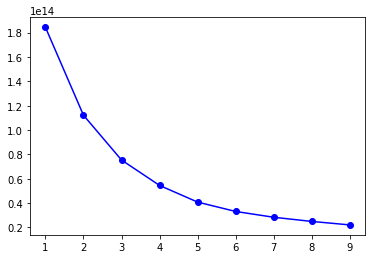

In [117]:
# Line plot # clusters on X-axis and WCSS on Y-axis 
plt.plot(range(1, 10), dist, 'bo-')
plt.show()

In [118]:
cluster  = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
# create 'cluster' column
cluster_data['cluster'] = cluster.fit_predict(cluster_data)

In [119]:
# Cluster centers
centroids = cluster.cluster_centers_

In [120]:
# Within cluster sum of squares
wcss = km.inertia_

In [121]:
centroids

array([[4.99987617e+00, 2.93134970e+00, 5.22844635e+01, 6.88469648e+02,
        4.47550441e+00, 3.17964069e+02, 7.45358001e+00, 1.28808614e+03,
        1.74039007e+02, 6.74806803e+01, 1.50358628e+03, 3.03319211e+03,
        1.00000000e+00, 2.34587635e+02, 3.05628478e+03],
       [4.99930420e+00, 1.67360145e+00, 5.00709574e+02, 7.36307334e+02,
        4.37983579e+00, 2.92213819e+02, 6.14973560e+00, 1.14897118e+04,
        1.21063211e+03, 1.10900626e+03, 1.59605618e+04, 2.97699120e+04,
        1.00000000e+00, 2.28731528e+03, 2.99784635e+04],
       [5.03067485e+00, 7.66871166e-01, 1.22836196e+03, 7.35668712e+02,
        4.65030675e+00, 2.58042945e+02, 7.07975460e+00, 7.34567448e+04,
        1.04900574e+04, 1.04482752e+04, 2.19017709e+05, 3.13412786e+05,
        1.00000000e+00, 1.39195126e+04, 3.58711400e+05],
       [5.00562660e+00, 1.04757033e+00, 1.11392634e+03, 7.35811765e+02,
        4.47314578e+00, 2.79008184e+02, 6.51508951e+00, 3.24503954e+04,
        3.28040710e+03, 4.98971090e+0

In [122]:
wcss

22118591672421.484

In [123]:
for col in cluster_data[cluster_data['cluster']==0].columns:
  print(cluster_data[col].mode())

0    5
dtype: int32
0    4
dtype: int32
   OSL Total  OSL Total
0          0        0.0
0    1025
dtype: int32
0    5
dtype: int32
0    91
dtype: int32
0    9
dtype: int32
0    0.0
dtype: float64
0    0.0
dtype: float64
   OSL Total  OSL Total
0          0        0.0
0    0.0
dtype: float64
0    0.0
dtype: float64
0    1
dtype: int64
0    1.0
dtype: float64
0    0.0
dtype: float64
0    0
dtype: int32


In [124]:
cluster_data.head()

Cust Type  Order Type  OSL Total  Model  Make  City  ServiceTime_category  \
0          5           1          0   1020     6   464                     0   
1          5           0          0    612     8   528                     9   
2          5           4          0    528     3    81                     9   
3          5           2          0      6     5     0                     5   
4          5           3          0   1301     3   596                     0   

   Labour Total  Misc Total  OSL Total  Parts Total  Total Amt Wtd Tax.  \
0       3429.34         0.0        0.0       834.41             4263.75   
1          0.00         0.0        0.0         0.00                0.00   
2        249.22         0.0        0.0         0.00              249.22   
3       1223.71         0.0        0.0         0.00             1223.71   
4      11031.37         0.0        0.0     35257.27            46288.64   

   Partner Type  Order Quantity  Net value  cluster  
0             1          1208.2    4263.75        0  
1             1             0.0       0.00        0  
2             1            84.0     249.22        0  
3             1           288.0    1223.71        0  
4             1           478.0   46288.64        1

In [125]:
cluster_data.to_csv('Cluster_from_EDACode.csv', index=False)

# EDA 3 

In [126]:
plant.columns

Index(['Plant', 'Name 1', 'Customer no. - plant', 'Vendor number plant',
       'House number and street', 'PO Box', 'Postal Code', 'City',
       'Sales organization', 'State'],
      dtype='object')

In [127]:
plant.drop(columns=['Vendor number plant', 'House number and street', 'PO Box', 'Sales organization', 'Customer no. - plant'], axis=1, inplace=True)

In [128]:
plant.shape, plant.isnull().sum()

((438, 5), Plant          0
 Name 1         0
 Postal Code    0
 City           0
 State          0
 dtype: int64)

In [129]:
customer_data.isnull().sum()

Business Partner    0
Customer No.        0
Partner Type        0
Data Origin         0
dtype: int64

In [130]:
invoice_data.head()

Cust Type Customer No. Gate Pass Time  Invoice No  Job Card No  KMs Reading  \
0    Retail        67849       00:00:00  7005200002       168303        49317   
1    Retail        84419       00:00:00  7005200003       173997        78584   
2    Retail        81055       00:00:00  7005200004       173889        33985   
3    Retail        84419       00:00:00  7005200005       174158        78584   
4    Retail        18980       00:00:00  7005200006       173860        50057   

   Labour Total            Make  Misc Total        Model  OSL Total  \
0       1203.14  GENERAL MOTORS        0.00        SPARK     500.06   
1        804.26     TATA MOTORS      197.03       INDICA       0.00   
2        180.19   MARUTI SUZUKI        0.00          ZEN       0.00   
3          0.00     TATA MOTORS        0.00       INDICA       0.00   
4       1202.97         HYUNDAI      100.00  SANTRO XING     499.99   

          Order Type  Parts Total  Pin code Plant Plant Name1 Print Status  \
0       Paid Service      2348.75    400601  BC01       THANE           NO   
1  SMC Value Package         0.00    400603  BC01       THANE           NO   
2    Running Repairs        52.95    400607  BC01       THANE           NO   
3     SMC Redemption         0.00    400603  BC01       THANE           NO   
4       Paid Service       944.16    400603  BC01       THANE           NO   

   Recovrbl Exp  Total Amt Wtd Tax.  User ID    Invoice_DateTime  \
0           0.0             4051.95  BC01FS1 2015-01-02 11:30:36   
1           0.0             1001.29  BC01SA2 2015-01-03 10:07:32   
2           0.0              233.14  BC01SA2 2015-01-03 11:12:57   
3           0.0                0.00  BC01SA2 2015-01-03 11:40:44   
4           0.0             2747.12  BC01SA2 2015-01-03 12:07:17   

     JobCard_DateTime     Service_Time Clean_CITY Clean_District  \
0 2014-12-13 14:29:43 19 days 21:00:53      Thane    Maharashtra   
1 2015-01-02 14:12:18  0 days 19:55:14      Thane    Maharashtra   
2 2015-01-02 11:40:44  0 days 23:32:13      Thane    Maharashtra   
3 2015-01-03 10:12:32  0 days 01:28:12      Thane    Maharashtra   
4 2015-01-02 10:45:42  1 days 01:21:35      Thane    Maharashtra   

                  Clean_Location_Area  
0  Thane R.S., Thane H.O, Thane Bazar  
1            Kopri Colony, Thane East  
2      Chitalsar Manpada, Sandozbaugh  
3            Kopri Colony, Thane East  
4            Kopri Colony, Thane East

In [131]:
invoice_2 = invoice_data

In [132]:
columns_irrelevant = ['Print Status', 'Gate Pass Time', 'Recovrbl Exp']

In [133]:
invoice_2= invoice_2.drop(columns=columns_irrelevant)

In [134]:
invoice_2.isnull().sum().sort_values()

Cust Type                  0
Service_Time               0
JobCard_DateTime           0
Invoice_DateTime           0
User ID                    0
Total Amt Wtd Tax.         0
Plant Name1                0
Plant                      0
Pin code                   0
Order Type                 0
Parts Total                0
Model                      0
Misc Total                 0
Make                       0
Labour Total               0
KMs Reading                0
Job Card No                0
Invoice No                 0
Customer No.               0
OSL Total                  0
Clean_District         47246
Clean_CITY             47246
Clean_Location_Area    47246
dtype: int64

In [135]:
invoice_2['Order Type'].value_counts()

Running Repairs      269455
Paid Service         135004
Accidental            44159
SMC Redemption        15738
Mechanical            15100
SMC Value Package      9781
Repeat Order           3043
WBW Order                17
Workshop Damage          17
Name: Order Type, dtype: int64

In [136]:
jtd_data.isnull().sum()

DBM Order                  0
Order Item                 0
Material               51629
Description            51629
Item Category              0
Order Quantity             0
Target quantity UoM    51629
Net value                  0
dtype: int64

In [137]:
invoice_customer.isnull().sum()

Cust Type                  0
Customer No.               0
Gate Pass Time             0
Invoice No                 0
Job Card No                0
KMs Reading                0
Labour Total               0
Make                       0
Misc Total                 0
Model                      0
OSL Total                  0
Order Type                 0
Parts Total                0
Pin code                   0
Plant                      0
Plant Name1                0
Print Status               0
Recovrbl Exp               0
Total Amt Wtd Tax.         0
User ID                    0
Invoice_DateTime           0
JobCard_DateTime           0
Service_Time               0
Clean_CITY             47246
Clean_District         47246
Clean_Location_Area    47246
Business Partner           0
Partner Type               0
Data Origin                0
dtype: int64

In [138]:
invoice_customer_plant.isnull().sum()

Cust Type                       0
Customer No.                    0
Gate Pass Time                  0
Invoice No                      0
Job Card No                     0
KMs Reading                     0
Labour Total                    0
Make                            0
Misc Total                      0
Model                           0
OSL Total                       0
Order Type                      0
Parts Total                     0
Pin code                        0
Plant                           0
Plant Name1                     0
Print Status                    0
Recovrbl Exp                    0
Total Amt Wtd Tax.              0
User ID                         0
Invoice_DateTime                0
JobCard_DateTime                0
Service_Time                    0
Clean_CITY                  20911
Clean_District              20911
Clean_Location_Area         20911
Business Partner                0
Partner Type                    0
Data Origin                     0
Name 1        

In [139]:
invoice_customer_plant.shape

(255761, 40)

In [140]:
invoice_customer_plant_2 = invoice_customer_plant

In [141]:
#to later merge with jtd
invoice_customer_plant_2.drop(columns=[ 'Invoice_DateTime', 'Invoice No', 'KMs Reading', 'Pin code', 'Plant', 'Plant Name1', 'User ID', 'Name 1', 'Postal Code', 'State', 'JobCard_DateTime', 'Service_Time_category','ServiceTime_category'], inplace=True)

# EDA 4

In [142]:
customer = pd.read_excel('Customer_Data.xlsx')

In [143]:
customer.dtypes

Business Partner            object
Customer No.                object
Partner Type               float64
Data Origin                 object
Title                      float64
Marital Status             float64
Occupation                 float64
Date of Birth               object
Death date          datetime64[ns]
dtype: object

In [144]:
new_invoice = pd.read_csv('Final_invoice.csv')
new_invoice

Unnamed: 0  Amt Rcvd From Custom  Amt Rcvd From Ins Co  \
0                0                   0.0                   0.0   
1                1                   0.0                   0.0   
2                2                   0.0                   0.0   
3                3                   0.0                   0.0   
4                4                   0.0                   0.0   
...            ...                   ...                   ...   
492309      984736                   NaN                   NaN   
492310      984737                   NaN                   NaN   
492311      984738                   NaN                   NaN   
492312      984739                   NaN                   NaN   
492313      984740                   NaN                   NaN   

       Area / Locality  CGST(14%)  CGST(2.5%)  CGST(6%)  CGST(9%)  \
0             MAJIWADA        0.0         0.0       0.0       0.0   
1                THNAE        0.0         0.0       0.0       0.0   
2                THANE        0.0         0.0       0.0       0.0   
3                THNAE        0.0         0.0       0.0       0.0   
4                THANE        0.0         0.0       0.0       0.0   
...                ...        ...         ...       ...       ...   
492309               .        NaN         NaN       NaN       NaN   
492310               .        NaN         NaN       NaN       NaN   
492311         CHENNAI        NaN         NaN       NaN       NaN   
492312  DK NAGAR EXTN,        NaN         NaN       NaN       NaN   
492313       2ND FLOOR        NaN         NaN       NaN       NaN   

                                       CITY Cash /Cashless Type Claim No.  \
0                                     Thane                 NaN       NaN   
1                                     THNAE                 NaN       NaN   
2                                  THANE[W]                 NaN       NaN   
3                                     THNAE                 NaN       NaN   
4                                     THANE                 NaN       NaN   
...                                     ...                 ...       ...   
492309                              Chennai                 NaN       NaN   
492310                           ADAMBAKKAM                 NaN       NaN   
492311                              CHENNAI                 NaN       NaN   
492312  Vijaya Nagar, 1 main road,Velacherr                 NaN       NaN   
492313                             saidapet                 NaN       NaN   

       Cust Type Customer No.     District Expiry Date Gate Pass Date  \
0         Retail        67849  Maharashtra         NaN            NaN   
1         Retail        84419  Maharashtra         NaN            NaN   
2         Retail        81055  Maharashtra         NaN            NaN   
3         Retail        84419  Maharashtra         NaN            NaN   
4         Retail        18980  Maharashtra         NaN            NaN   
...          ...          ...          ...         ...            ...   
492309    Retail       203820   Tamil Nadu         NaN            NaN   
492310    Retail       170411   Tamil Nadu         NaN            NaN   
492311    Retail        48811   Tamil Nadu         NaN            NaN   
492312    Retail       204067   Tamil Nadu         NaN            NaN   
492313    Retail       204288   Tamil Nadu         NaN            NaN   

       Gate Pass Time  IGST(12%)  IGST(18%)  IGST(28%)  IGST(5%)  \
0            00:00:00        0.0        0.0        0.0       0.0   
1            00:00:00        0.0        0.0        0.0       0.0   
2            00:00:00        0.0        0.0        0.0       0.0   
3            00:00:00        0.0        0.0        0.0       0.0   
4            00:00:00        0.0        0.0        0.0       0.0   
...               ...        ...        ...        ...       ...   
492309       00:00:00        NaN        NaN        NaN       NaN   
492310       00:00:00        NaN        

In [145]:
join=pd.merge(customer[['Customer No.','Partner Type','Data Origin','Occupation']],new_invoice[['Area / Locality','CITY','Claim No.','Cust Type','Customer No.','District','Insurance Company','Invoice Date','Job Card No','JobCard Date','KMs Reading','Make','Model','Pin code','ODN No.','Order Type','Plant Name1','Regn No','Total Amt Wtd Tax.']],how='inner', on ='Customer No.')

In [146]:
join

Customer No.  Partner Type Data Origin  Occupation Area / Locality  \
0         CS000018           NaN         NaN         NaN             NaN   
1           E10007           1.0        Z001         NaN             NaN   
2           E10013           1.0        Z001         NaN             NaN   
3           E10013           1.0        Z001         NaN             NaN   
4           E10014           1.0        Z001         NaN             NaN   
...            ...           ...         ...         ...             ...   
19722       PLX241           NaN         NaN         NaN            X241   
19723       PLX277           NaN         NaN         NaN            X277   
19724       PLX312           NaN         NaN         NaN            X312   
19725       PLX380           NaN         NaN         NaN             NaN   
19726       PLX386           NaN         NaN         NaN             NaN   

               CITY Claim No.  Cust Type        District  \
0      Chengalpattu       NaN     Retail      Tamil Nadu   
1         Hyderabad       NaN     Retail  Andhra Pradesh   
2         Hyderabad       NaN     Retail  Andhra Pradesh   
3         Hyderabad       NaN     Retail  Andhra Pradesh   
4         Hyderabad       NaN     Retail  Andhra Pradesh   
...             ...       ...        ...             ...   
19722      Kashipur       NaN  Franchise     Uttarakhand   
19723    Jalpaiguri       NaN     Retail     West Bengal   
19724        Barshi       NaN     Retail     Maharashtra   
19725        Meerut       NaN     Retail   Uttar Pradesh   
19726     Nizamabad       NaN  Franchise       Telangana   

                         Insurance Company Invoice Date  Job Card No  \
0      UNIVERSAL SOMPO GENERAL INSURANCE C   2016-04-28       350079   
1                                      NaN   2013-07-04        39254   
2                                      NaN   2013-12-14        71672   
3                                      NaN   2013-12-14        71797   
4                                      NaN   2013-04-20        29109   
...                                    ...          ...          ...   
19722                                  NaN   2016-10-14       483985   
19723                                  NaN   2016-10-26       493813   
19724                                  NaN   2016-08-09       419364   
19725                                  NaN   2016-09-30       473182   
19726                                  NaN   2016-09-27       464105   

      JobCard Date  KMs Reading                  Make          Model  \
0       2016-04-09         3000                 HONDA        MOBILIO   
1       2013-07-04       172979  MAHINDRA &  MAHINDRA  BOLERO PIK UP   
2       2013-12-14        42413         MARUTI SUZUKI         WAGONR   
3       2013-12-14        42413         MARUTI SUZUKI         WAGONR   
4       2013-04-19        79041         MARUTI SUZUKI         WAGONR   
...            ...          ...                   ...            ...   
19722   2016-10-14        56328         MARUTI SUZUKI           RITZ   
19723   2016-10-24        52358           TATA MOTORS           SUMO   
19724   2016-07-23        57841  MAHINDRA &  MAHINDRA   SCORPIO CRDE   
19725   2016-09-30        90704  MAHINDRA &  MAHINDRA        XUV 500   
19726   2016-09-21        55222               HYUNDAI         SANTRO   

       Pin code       ODN No.         Order Type  \
0        603204           NaN         Mechanical   
1        500037  7.000039e+09    Running Repairs   
2        500012  7.000071e+09  SMC Value Package   
3        500012  7.000071e+09     SMC Redemption   
4        500037  7.000029e+09       Paid Service   
...         ...           ...                ...   
19722    244713           NaN    Running Repairs   
19723    735121           NaN    Running Repairs   
19724    413401           NaN    Running Repairs   
19725    250103           NaN    Running Repairs   
19726    503230           NaN    Running Repairs   

                 

In [147]:
# join.to_csv('join.csv')

In [148]:
join.isnull().sum()
join['Occupation']=join['Occupation'].apply(lambda x:'Others' if x=='0' else x )

In [149]:
join['District']=join['District'].apply(lambda x:str(x))
join['District']=join['District'].apply(lambda x:x.lower())
city=join['District'].unique()

In [150]:
join['Model']=join['Model'].fillna(value='Others')
join['Insurance Company']=join['Insurance Company'].fillna(value='Others')

In [151]:
join['Invoice Date']=join['Invoice Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date()) 
join['monthno']=join['Invoice Date'].apply(lambda x:x.month)

In [152]:
join['month']=join['monthno'].apply(lambda x:calendar.month_name[x])
join.rename(columns={'Invoice Date':'InvoiceDate'},inplace=True)
join.rename(columns={'Total Amt Wtd Tax.':'Revenue'},inplace=True)

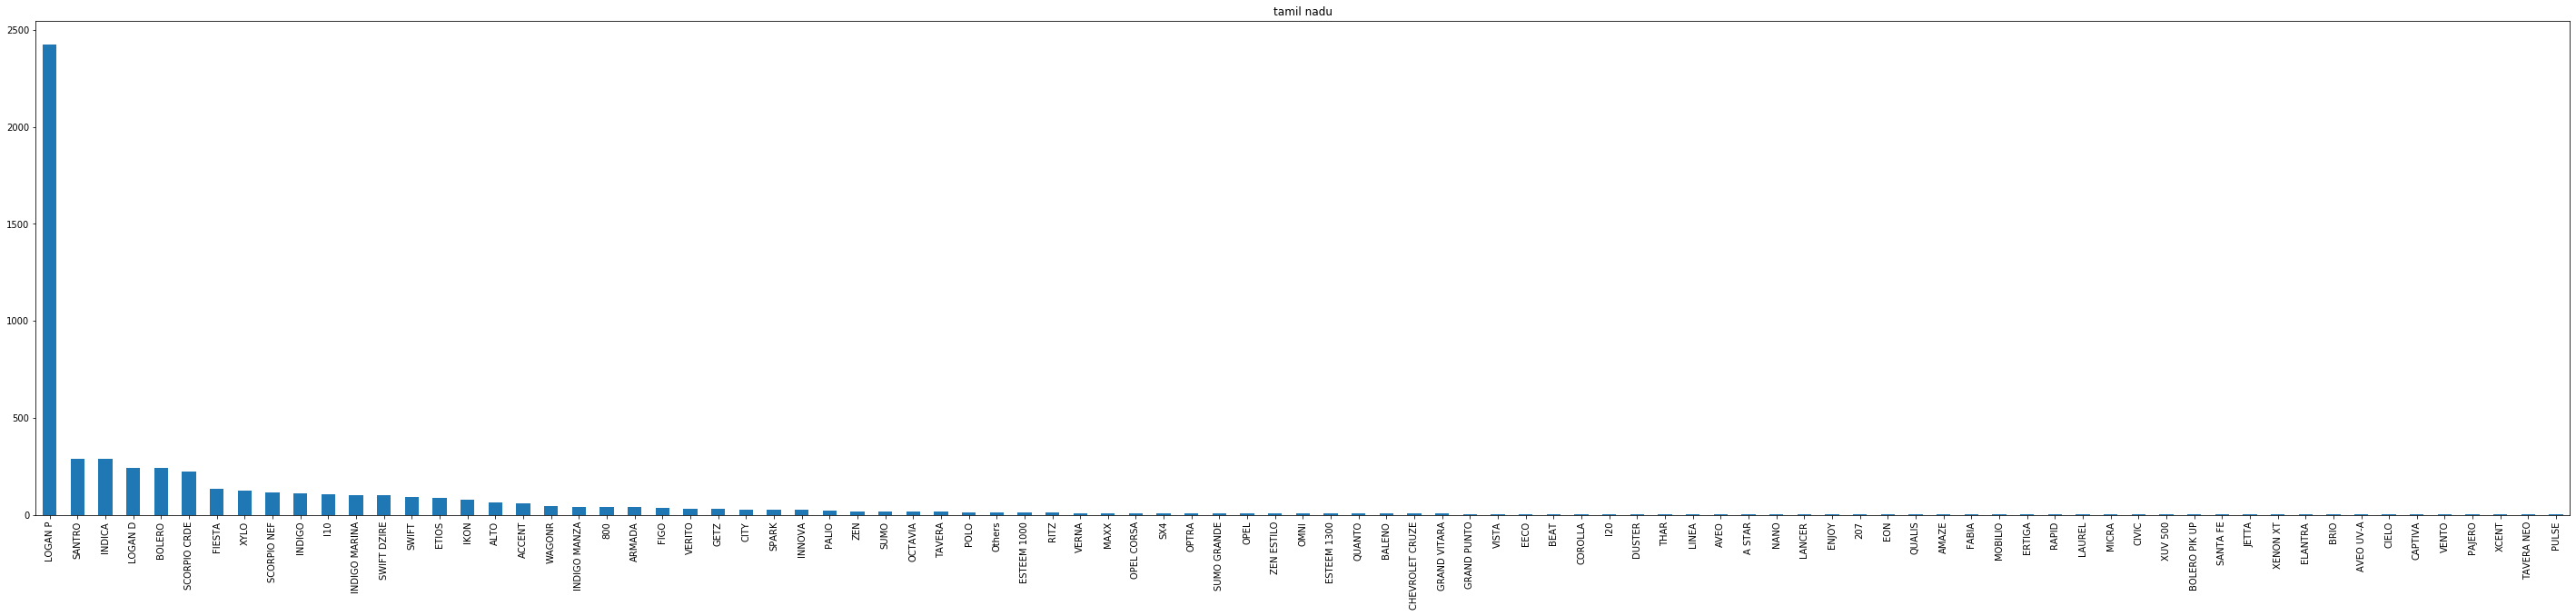

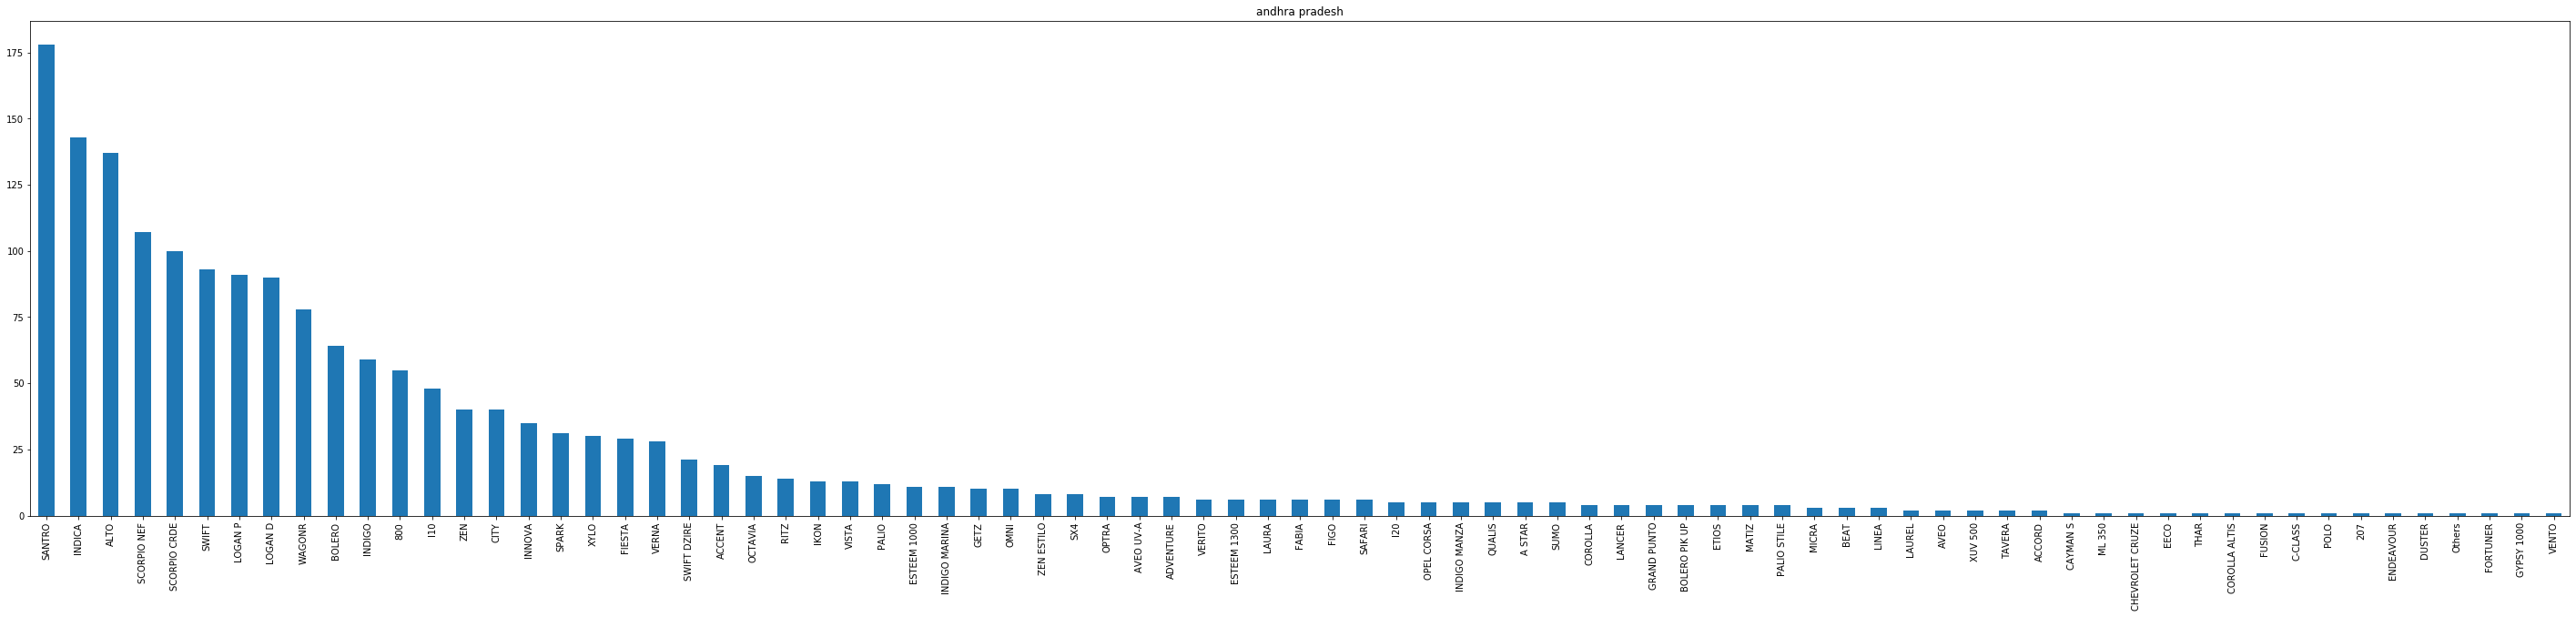

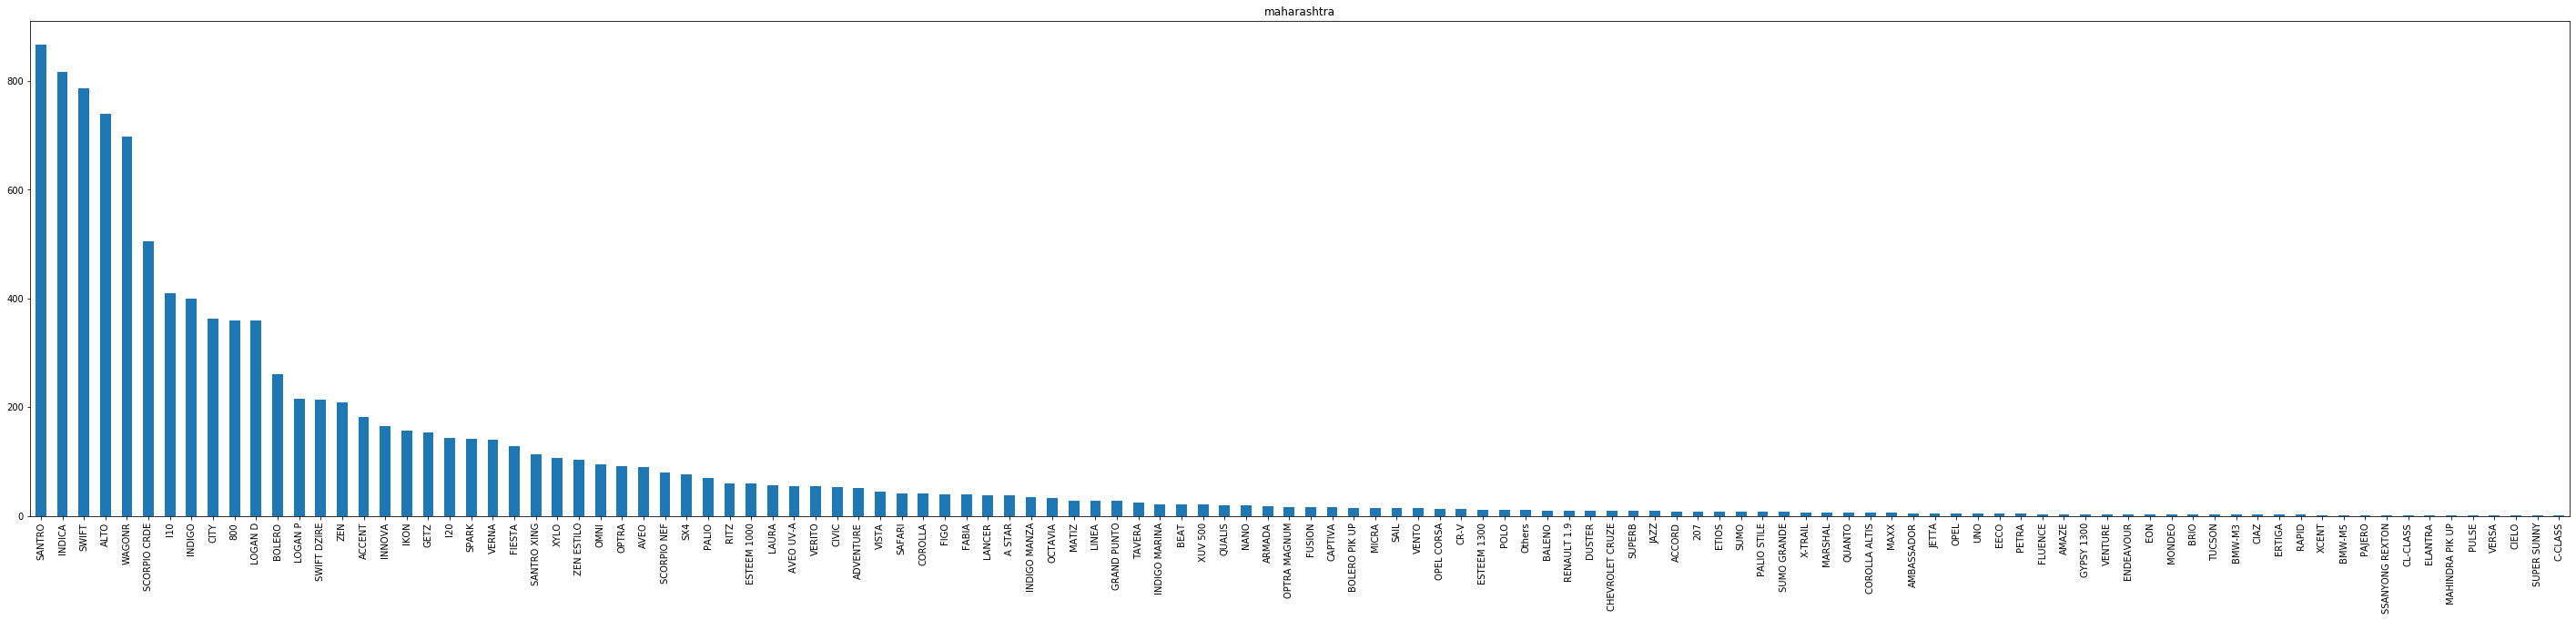

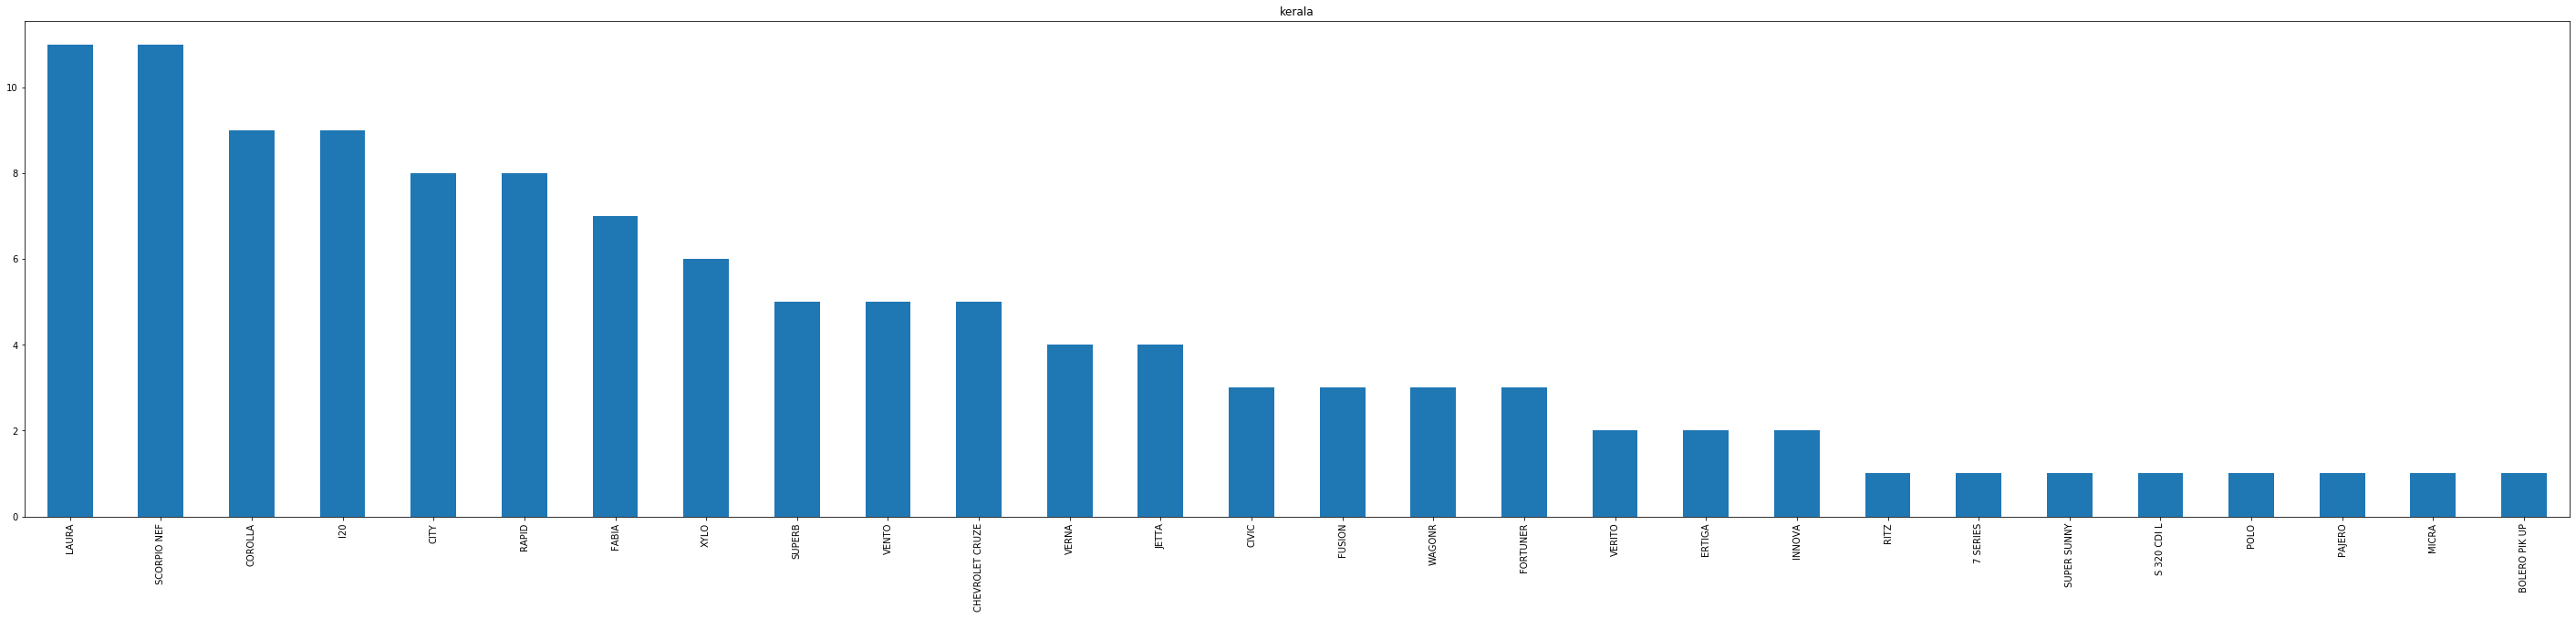

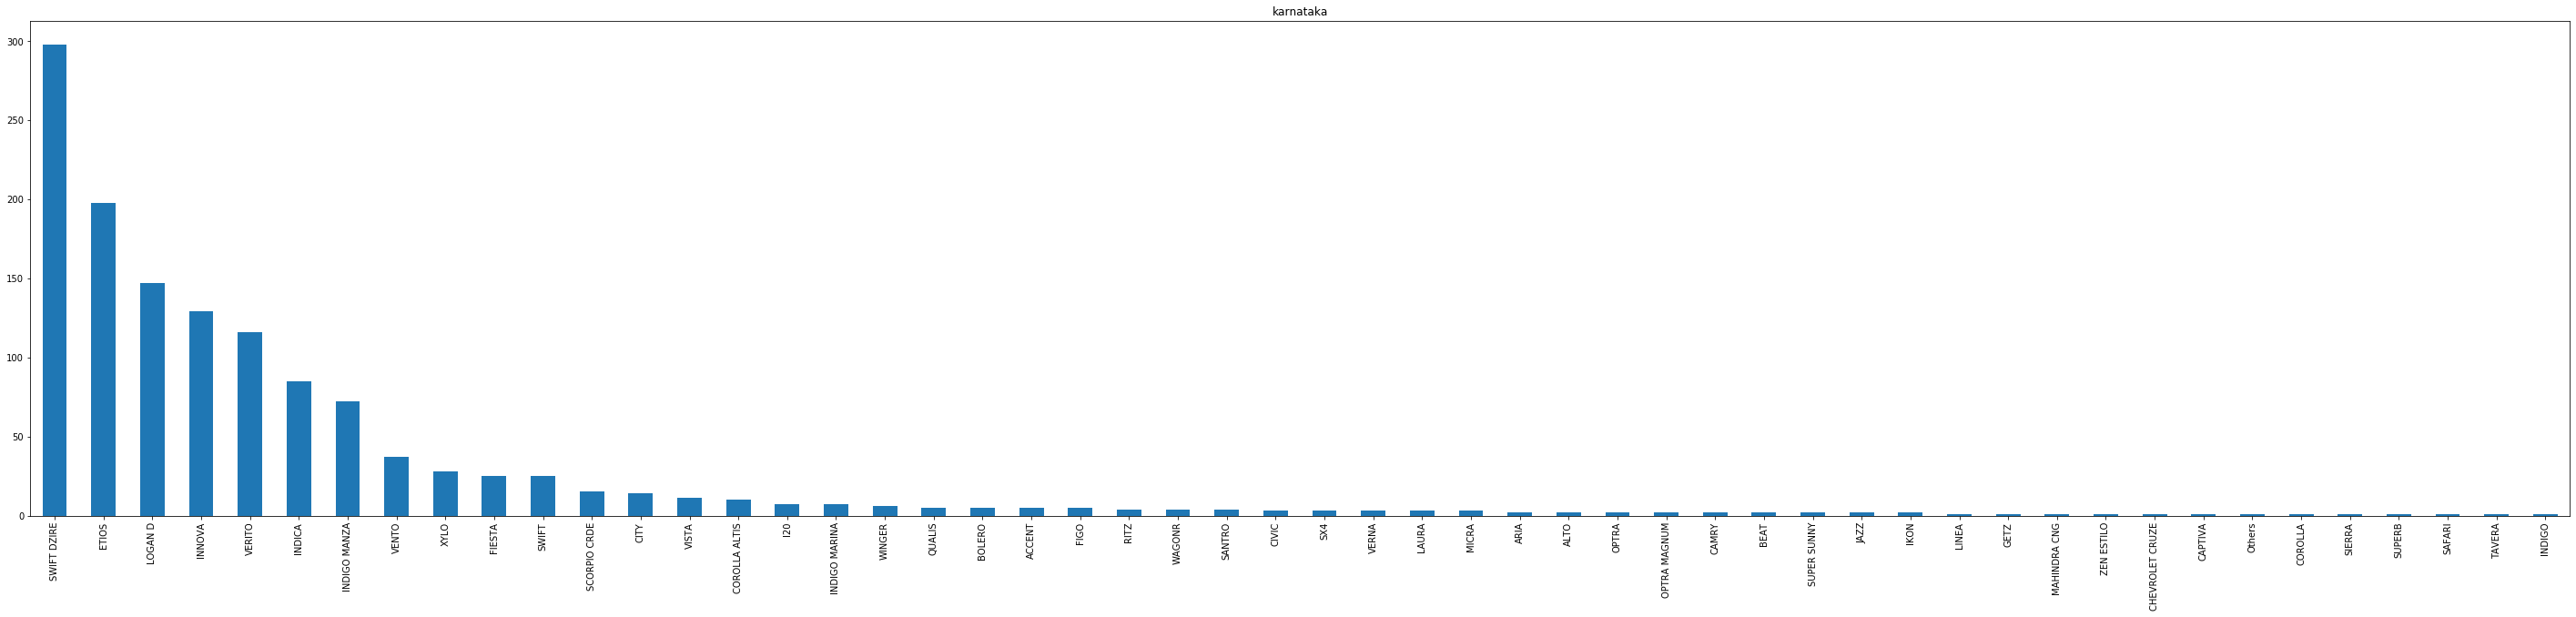

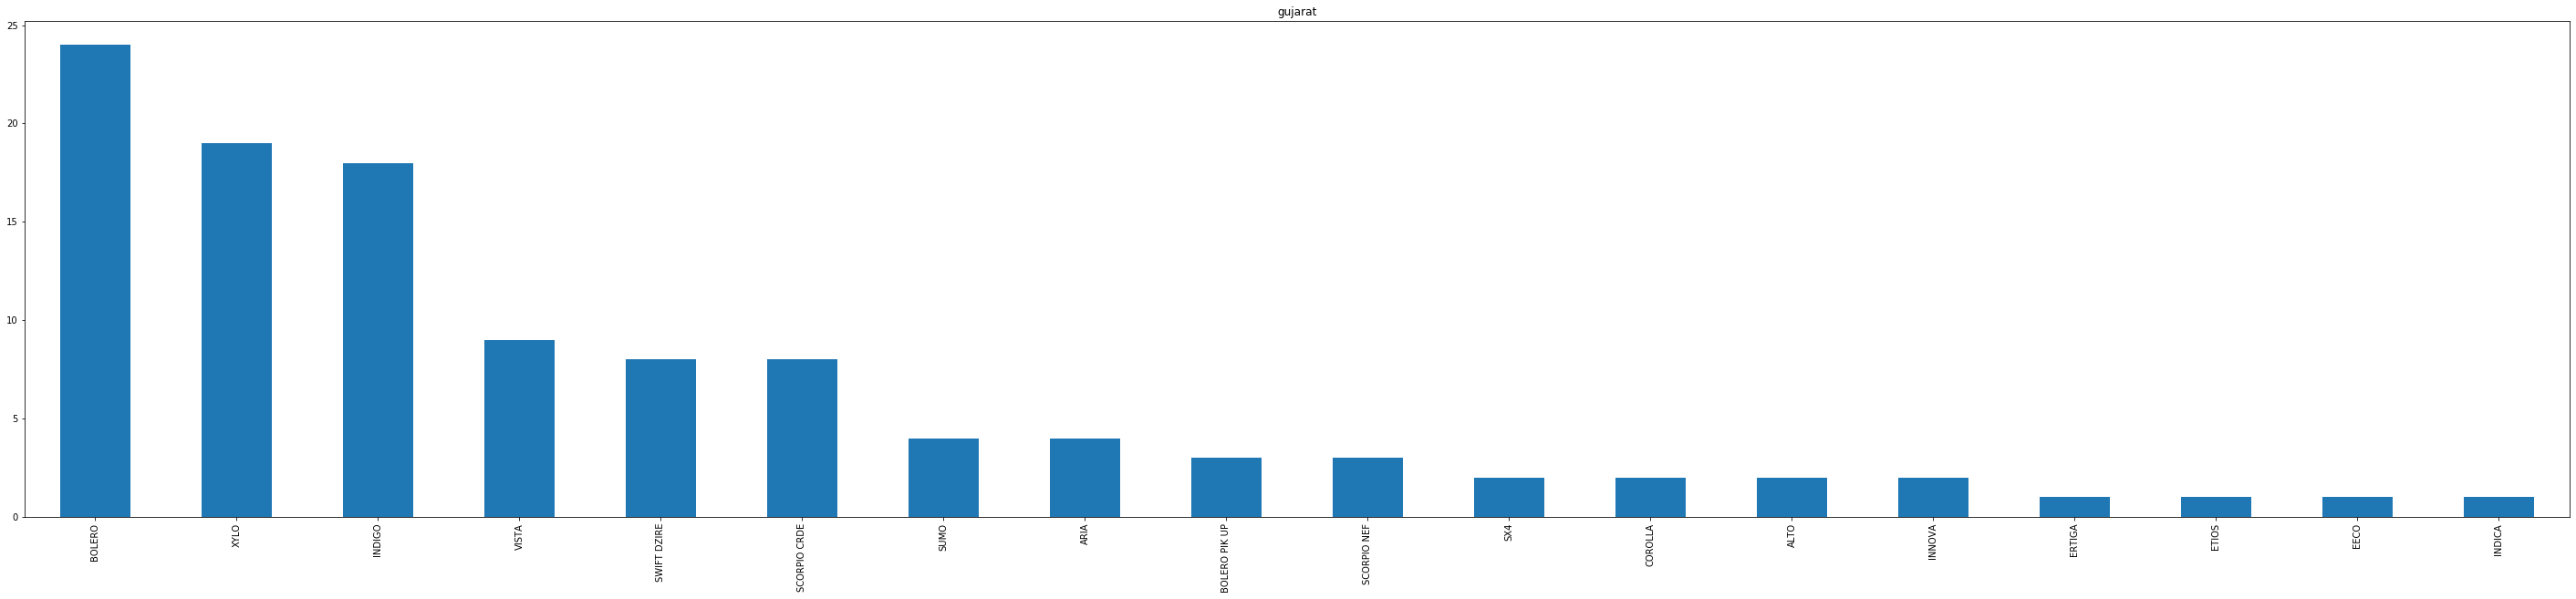

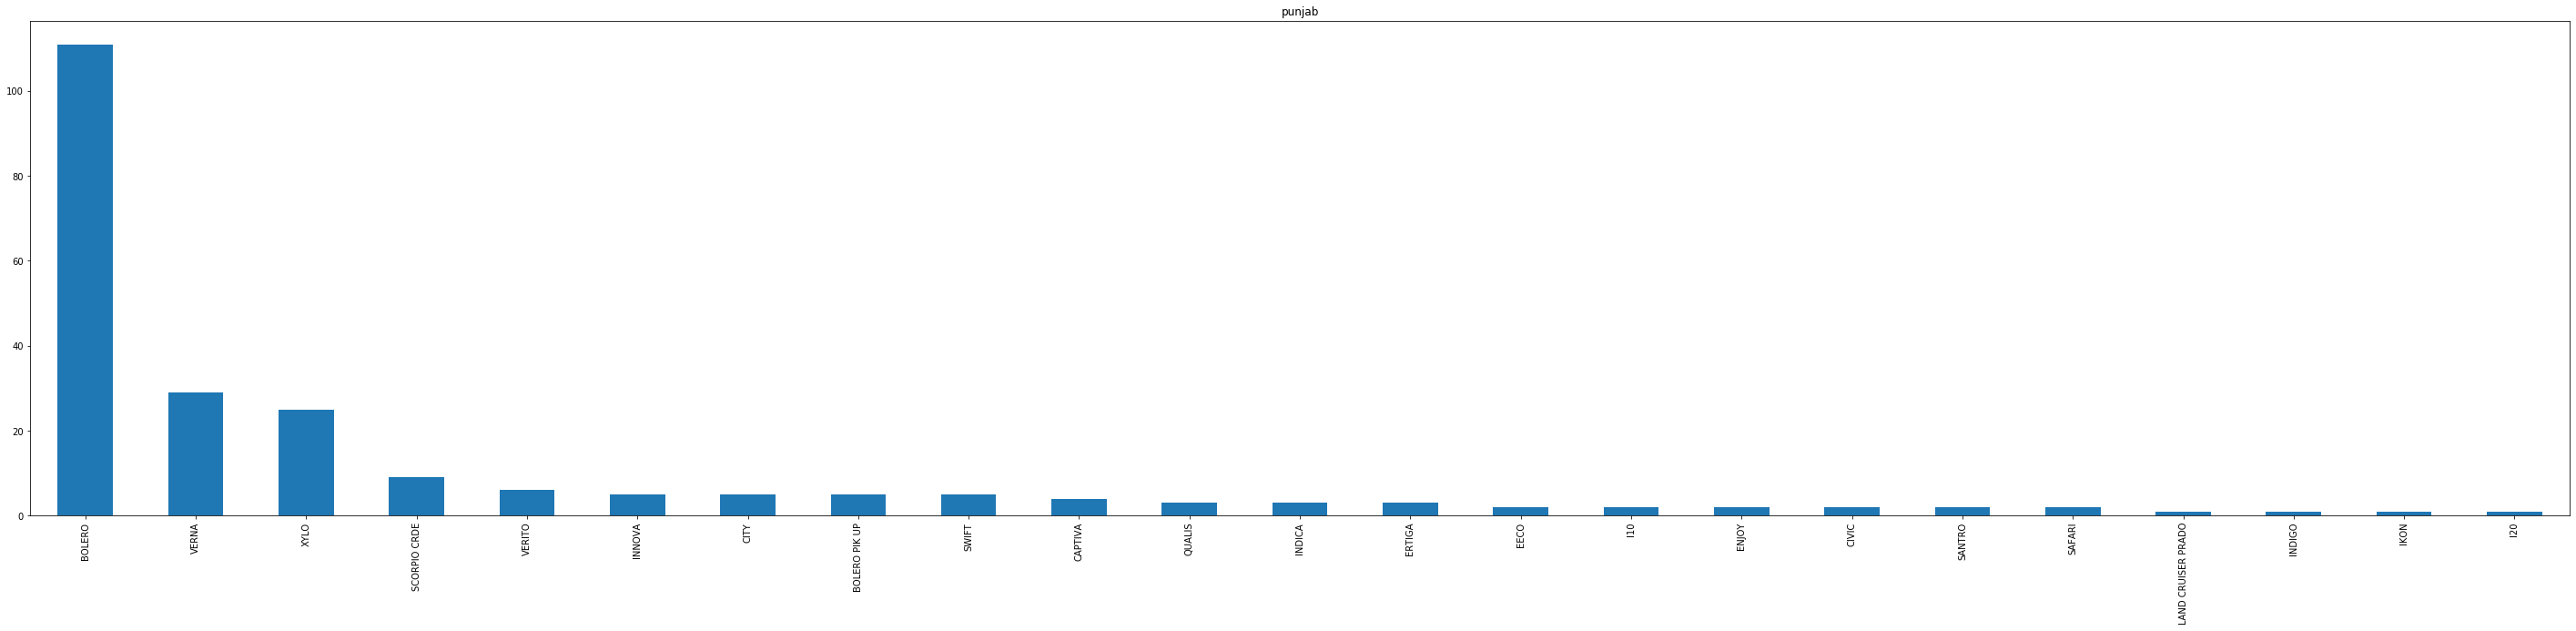

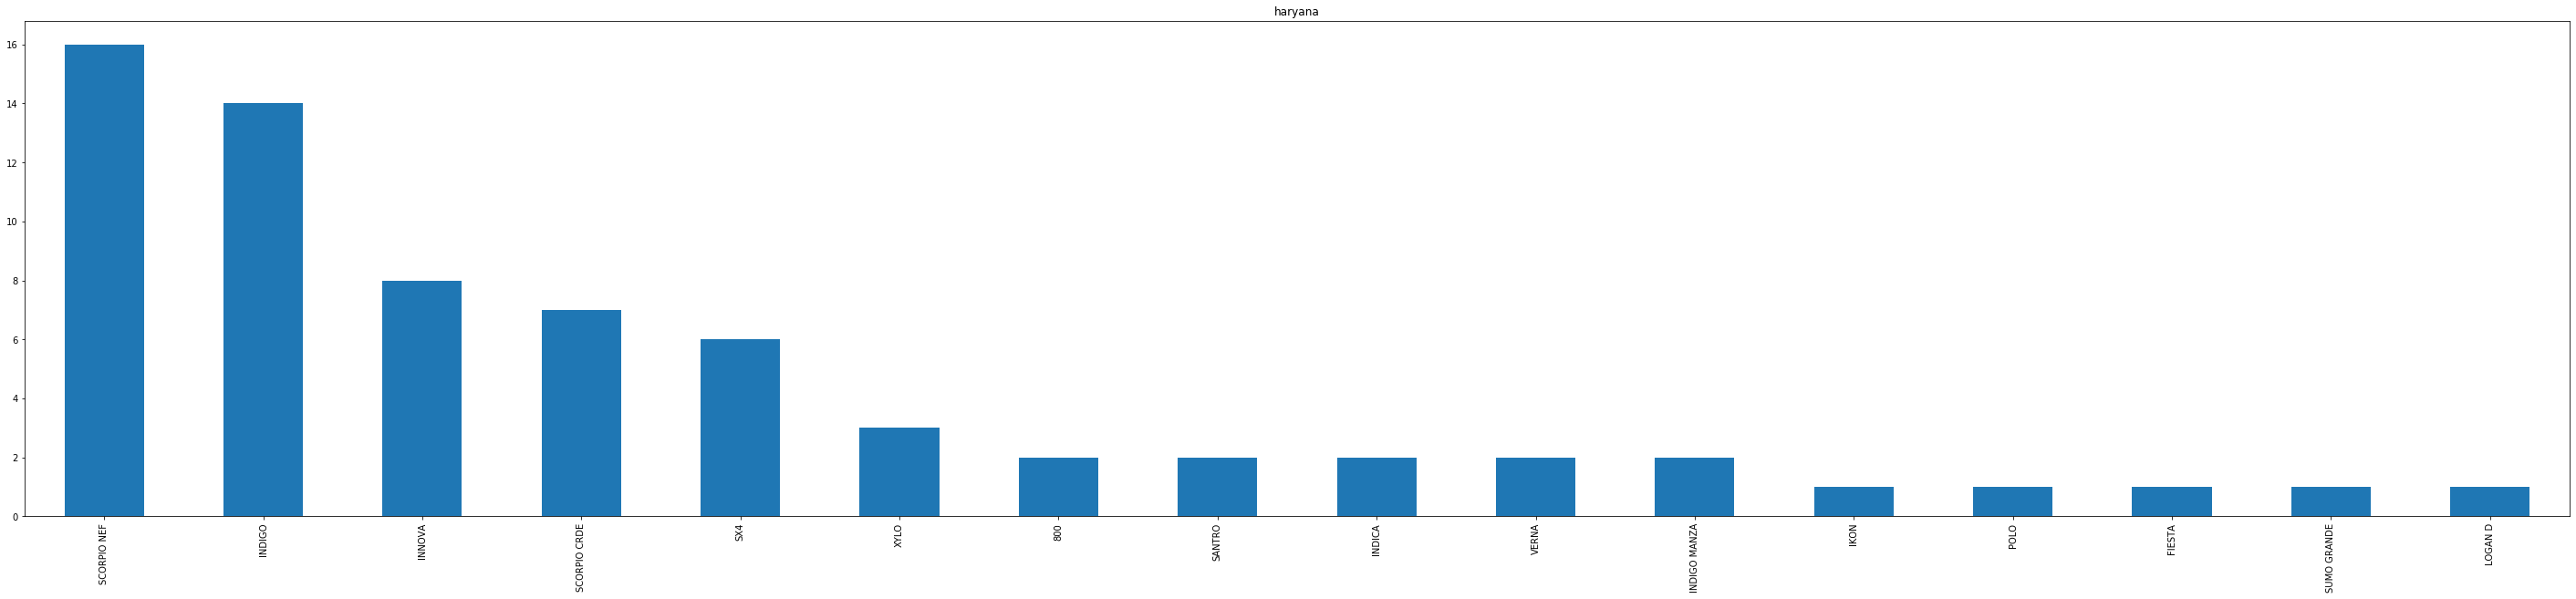

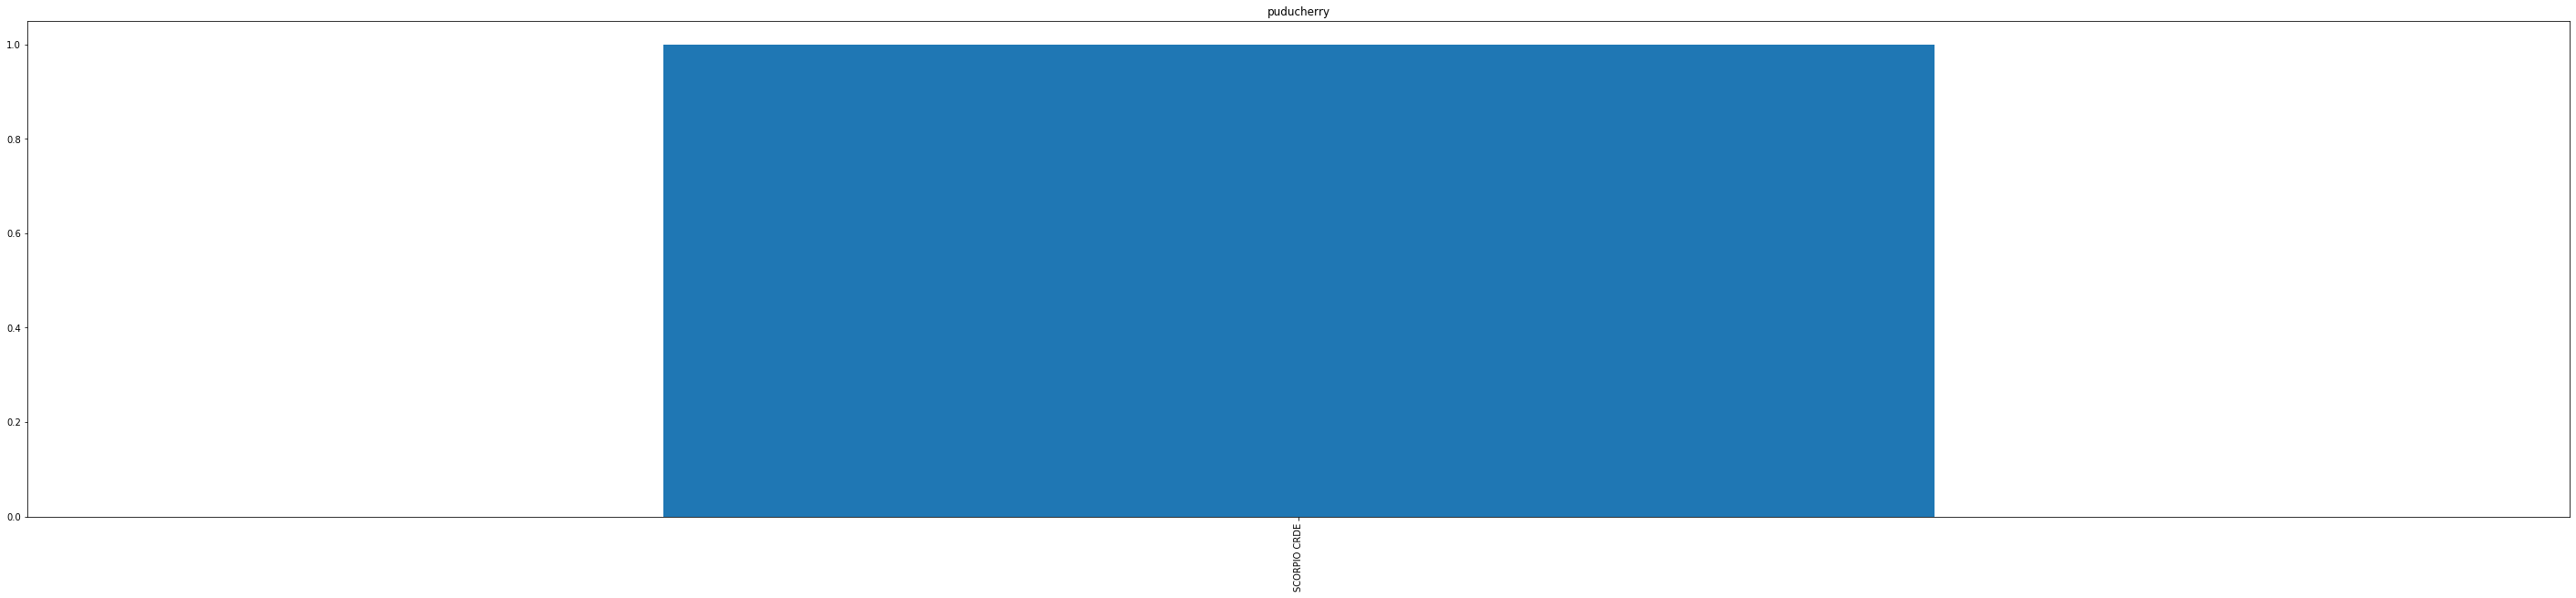

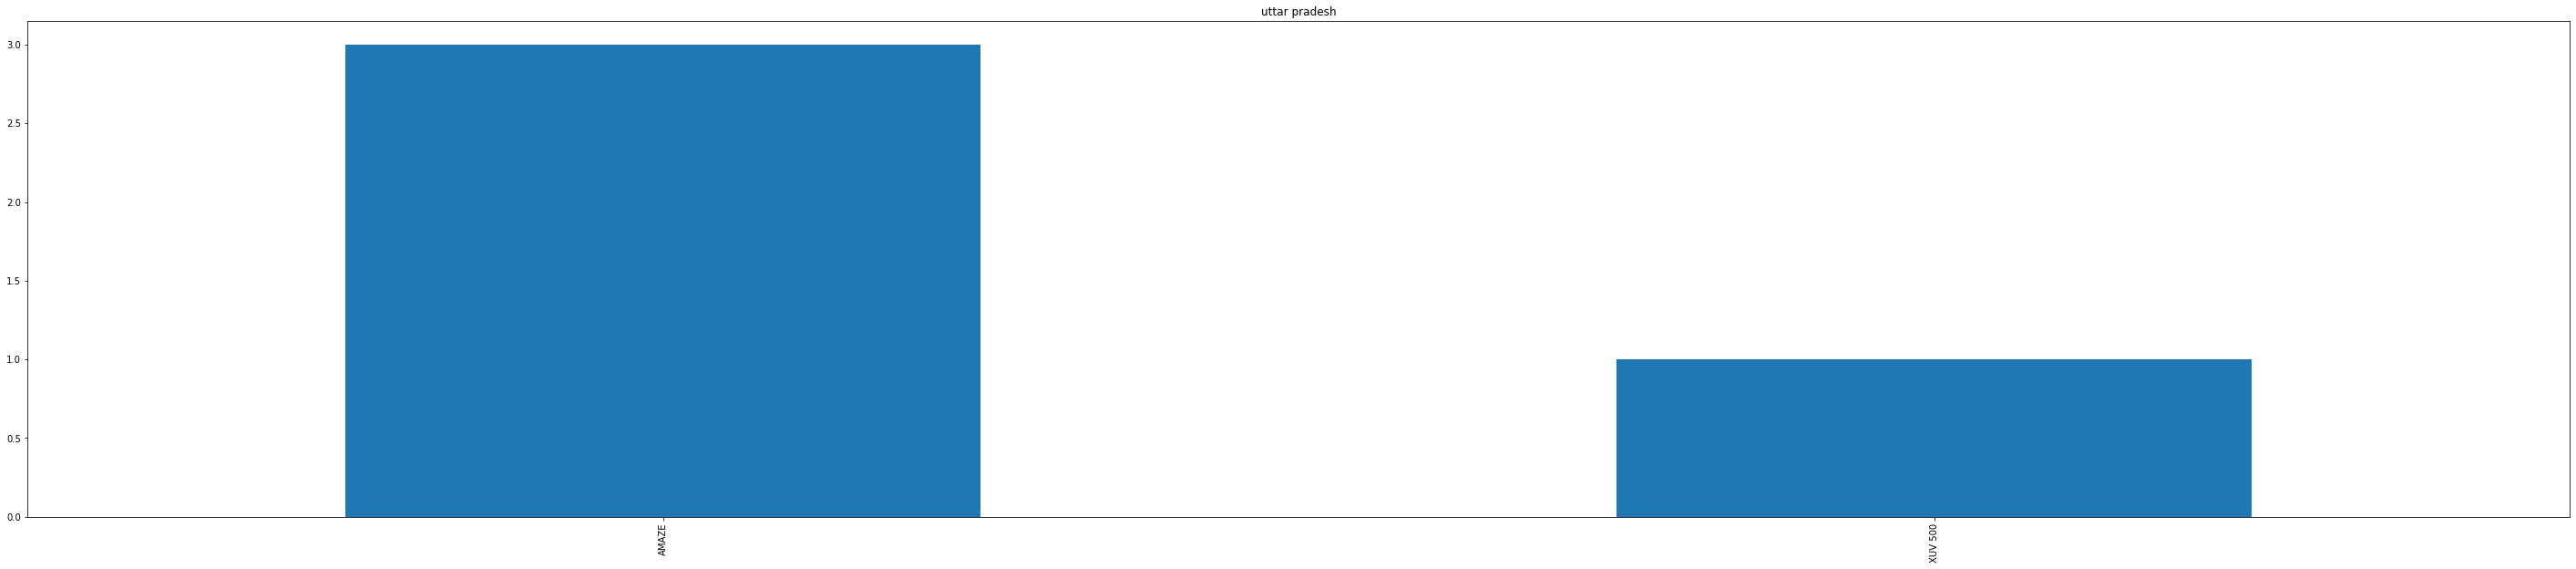

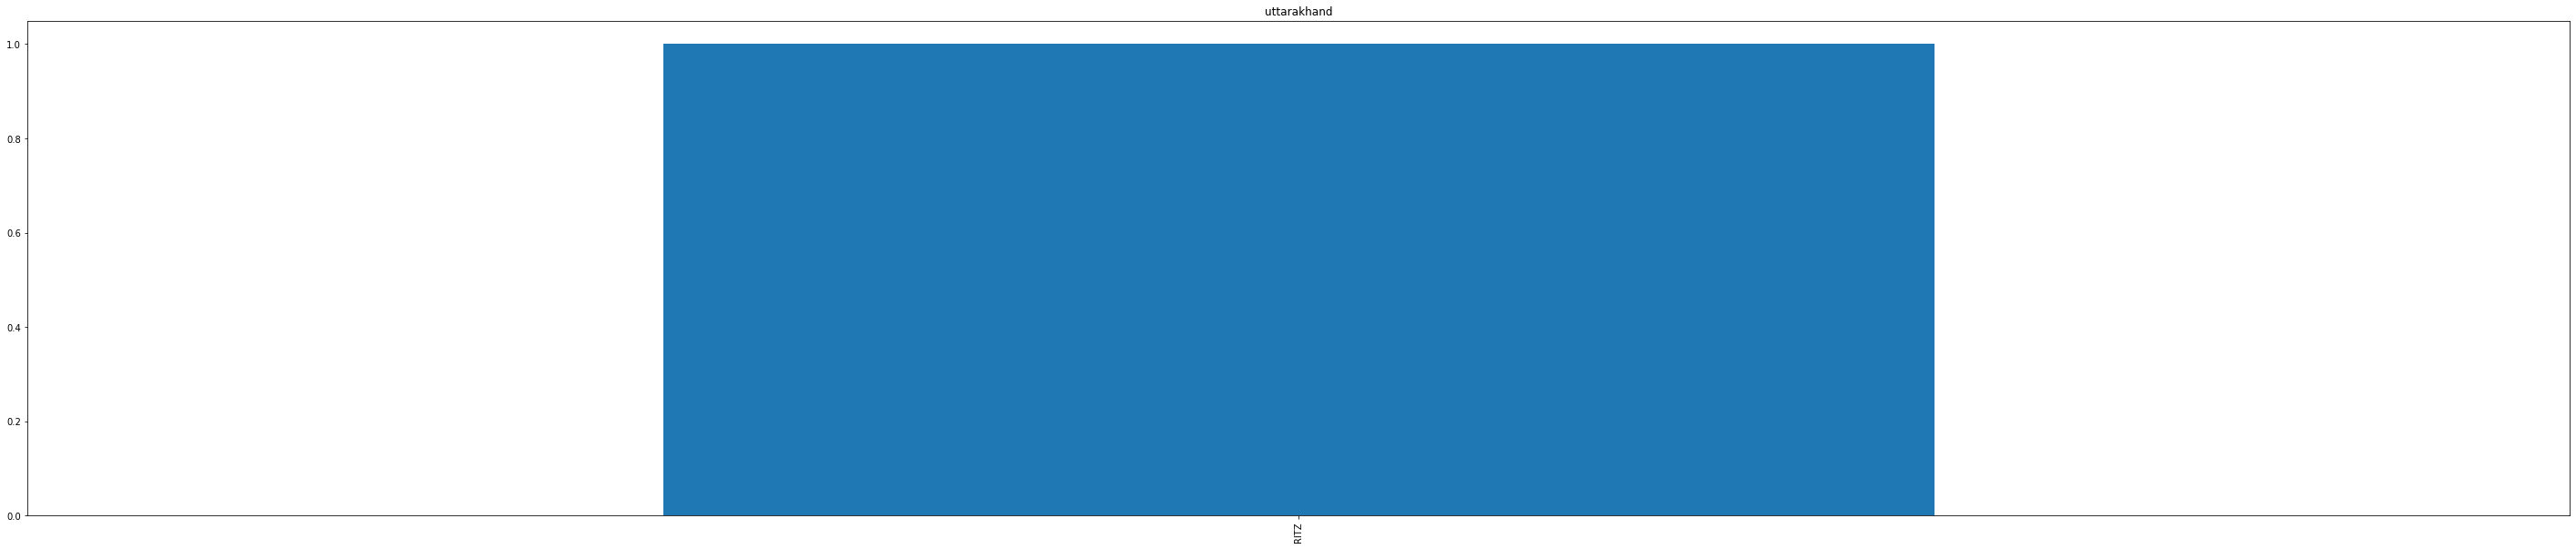

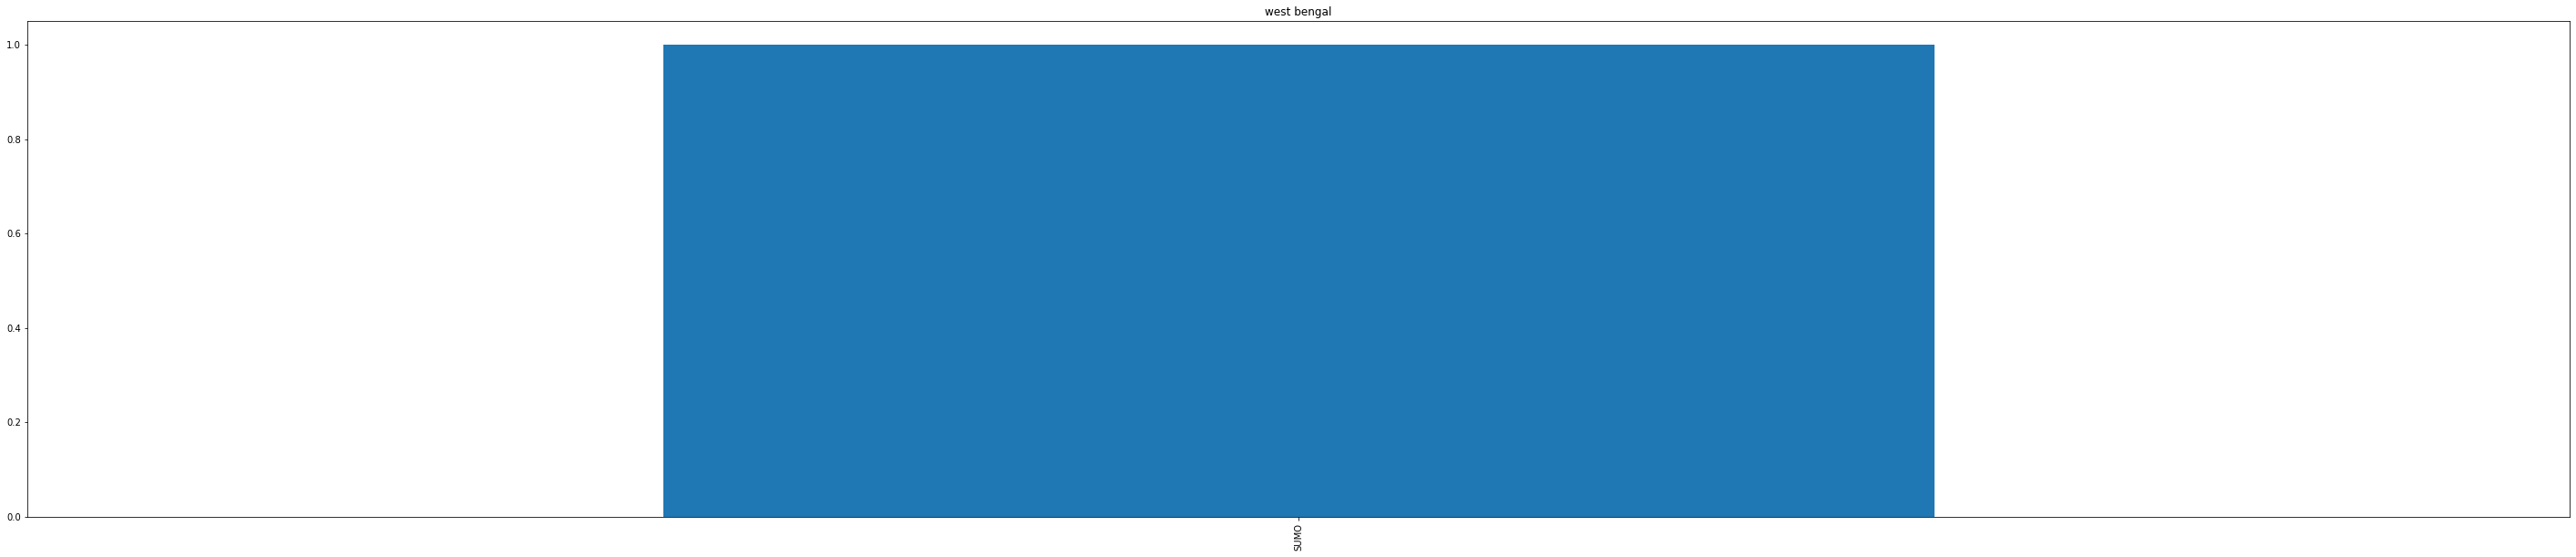

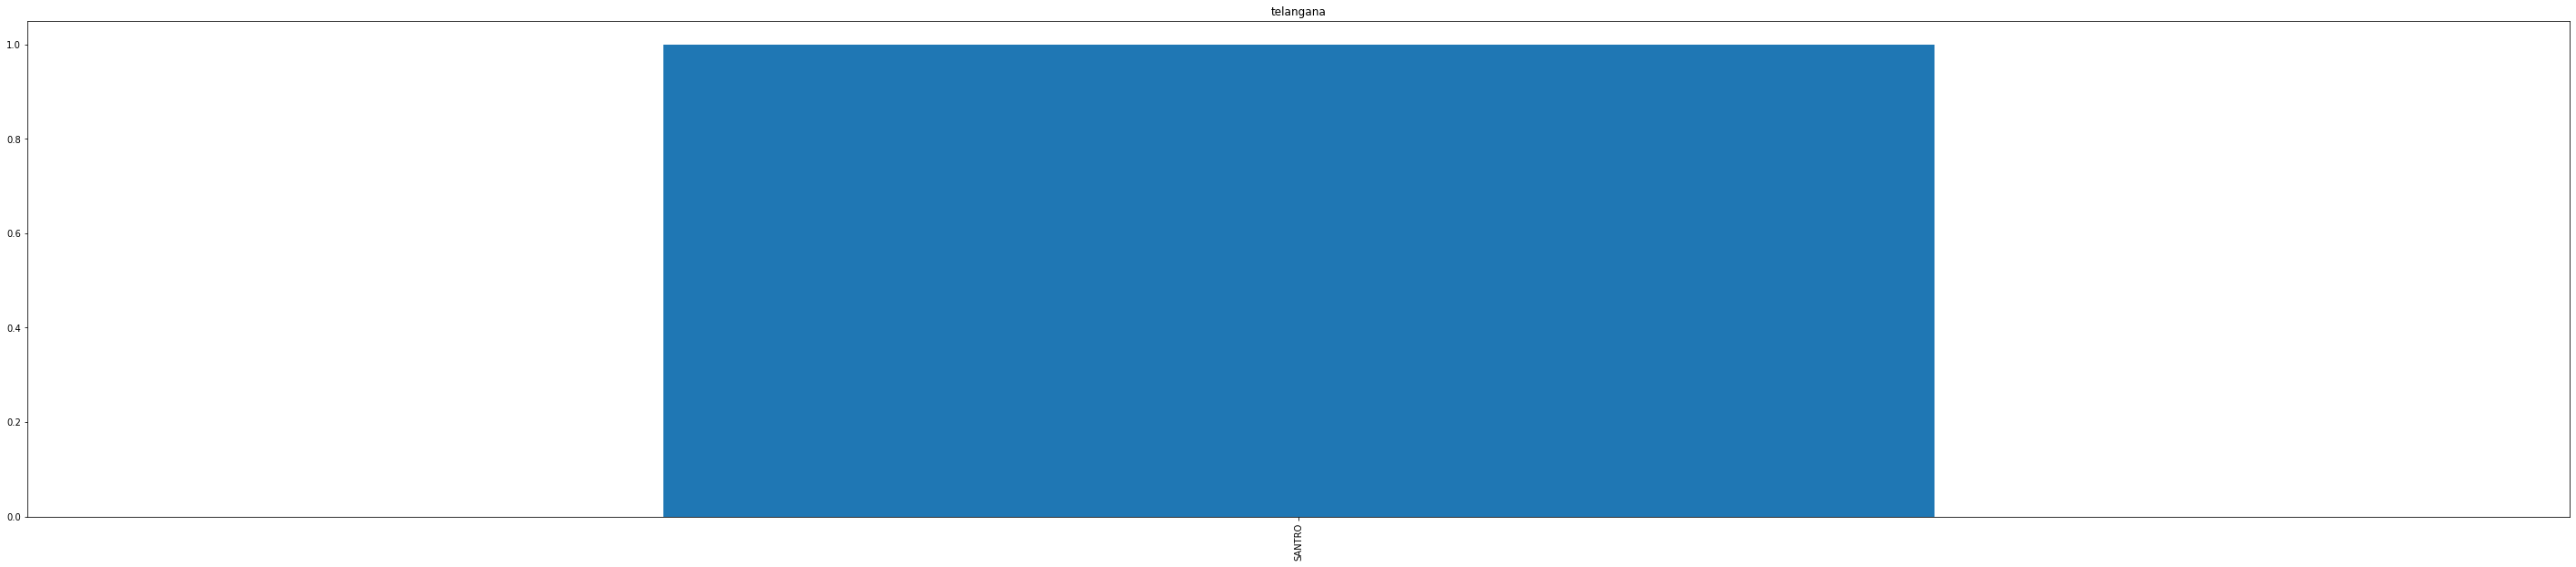

In [153]:
city=[]
city=join['District'].unique()
for i in city:
    cars=join[join['District']==i]
    
    fig=plt.figure(figsize=(50,10))
    plt.title(i)
    cars['Model'].value_counts().plot(kind='bar')
    plt.show()

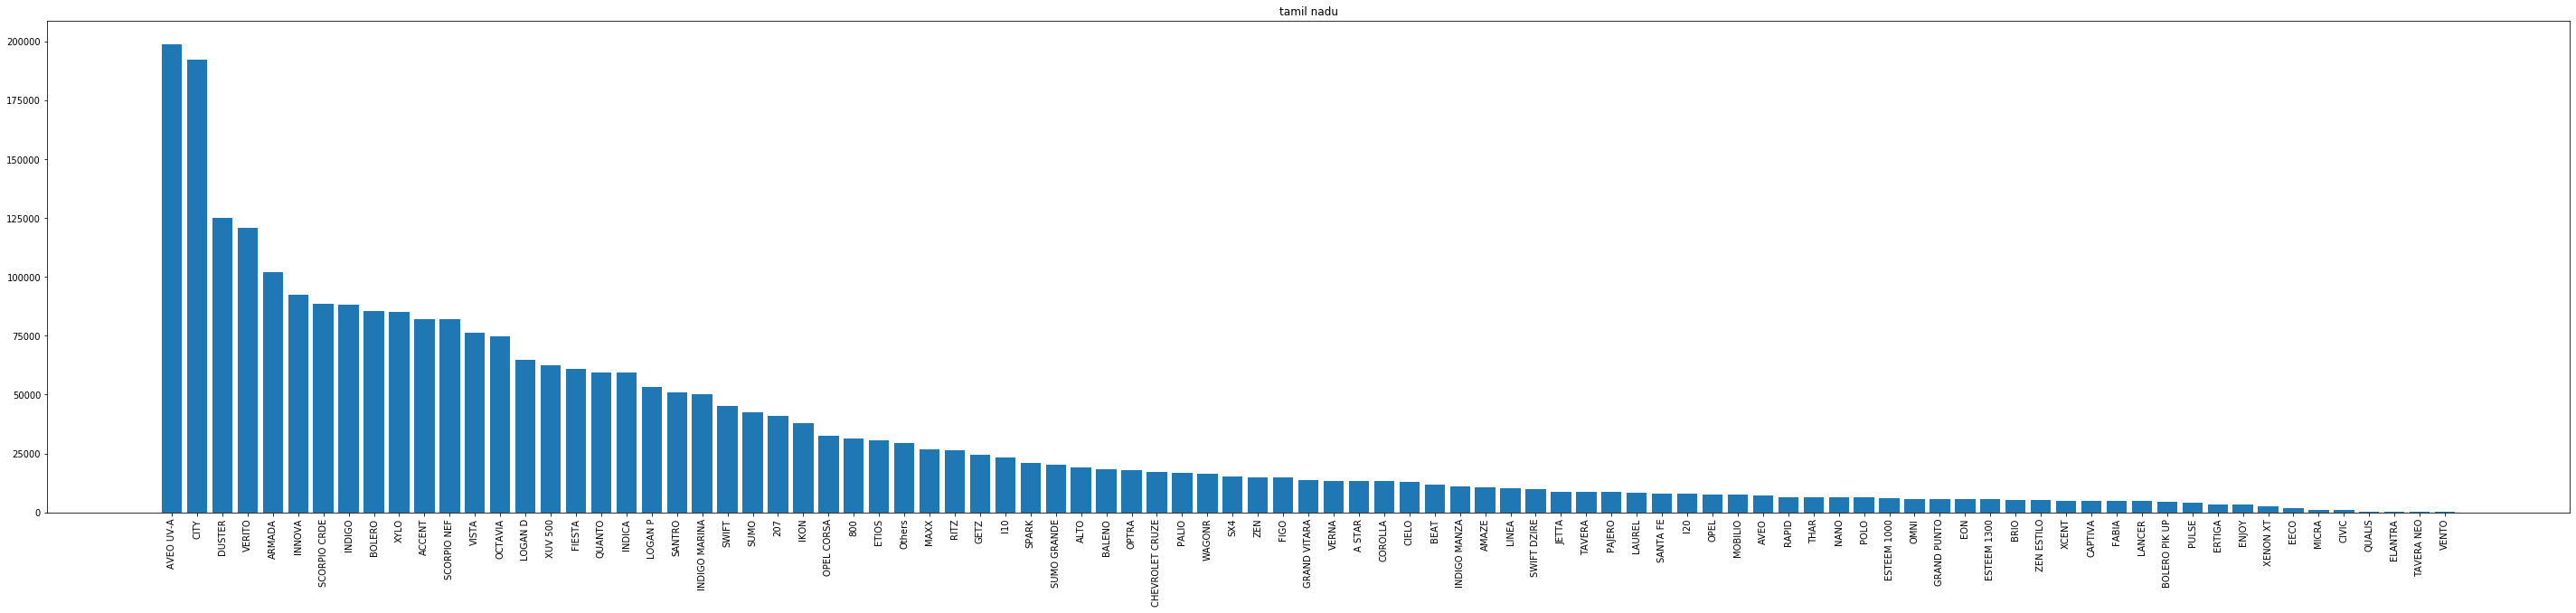

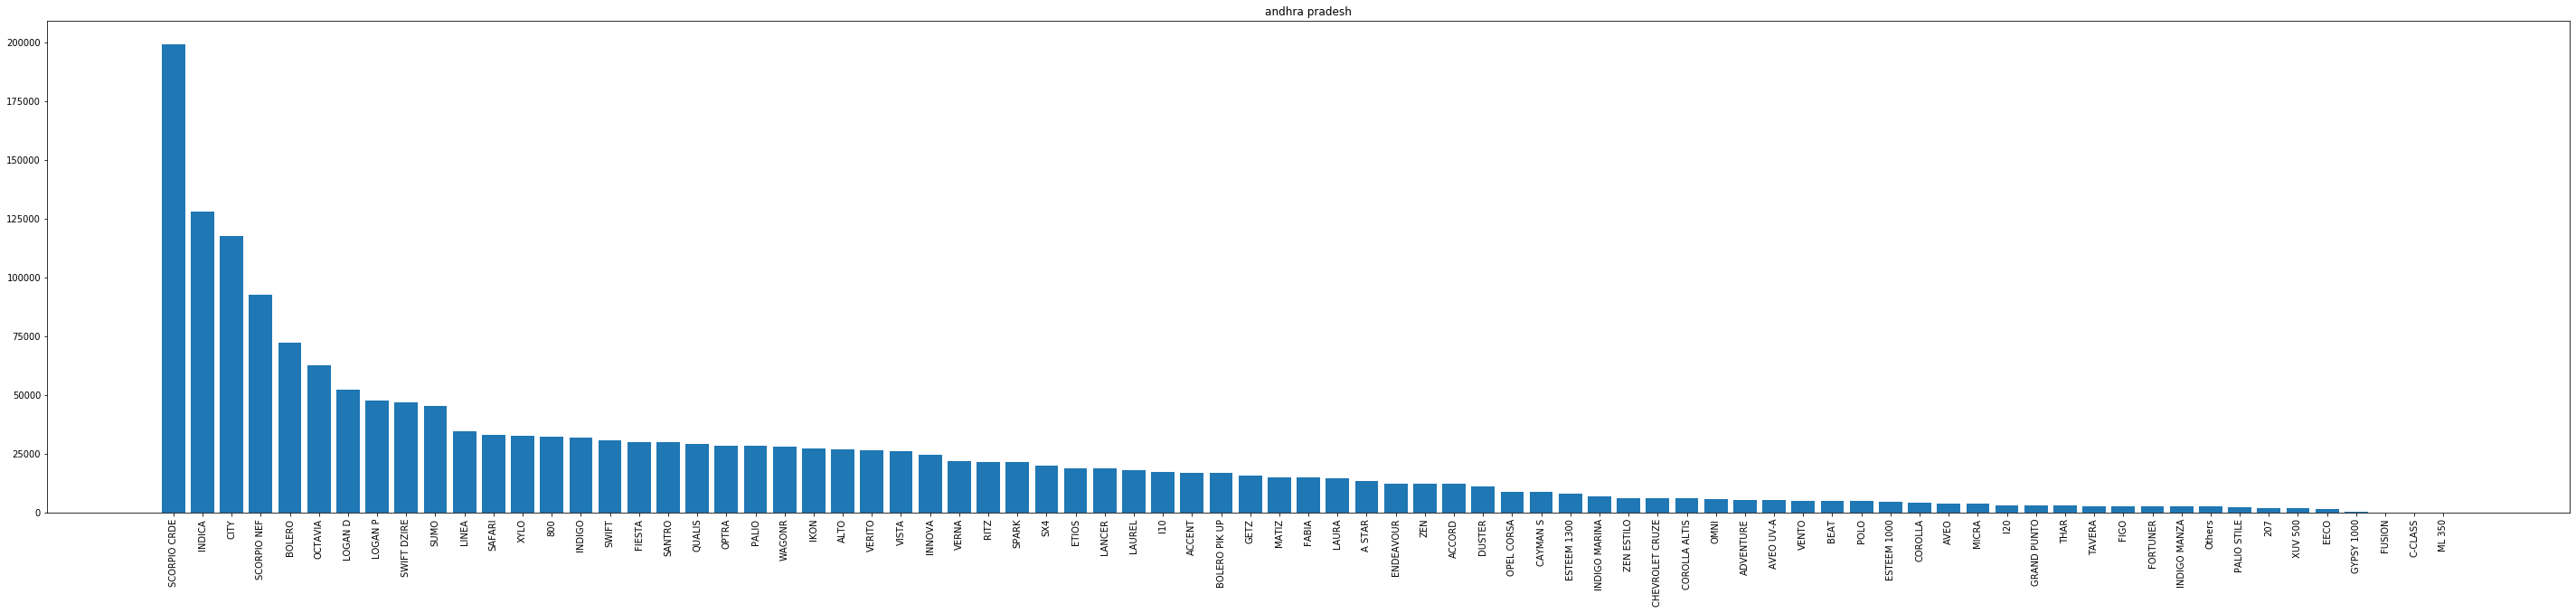

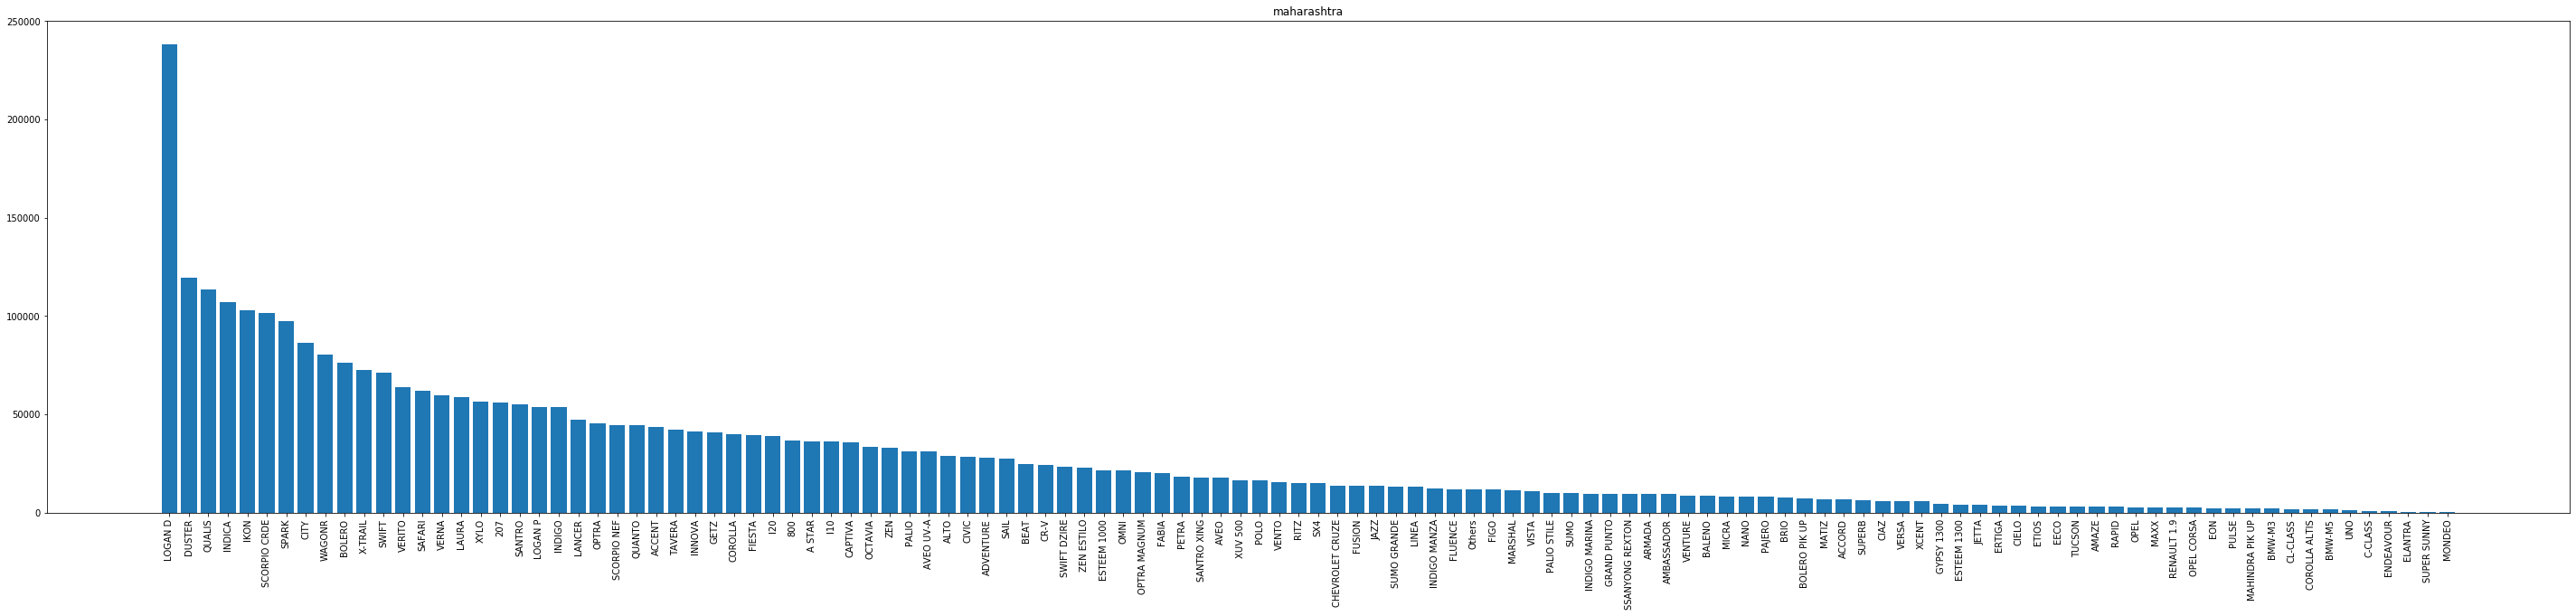

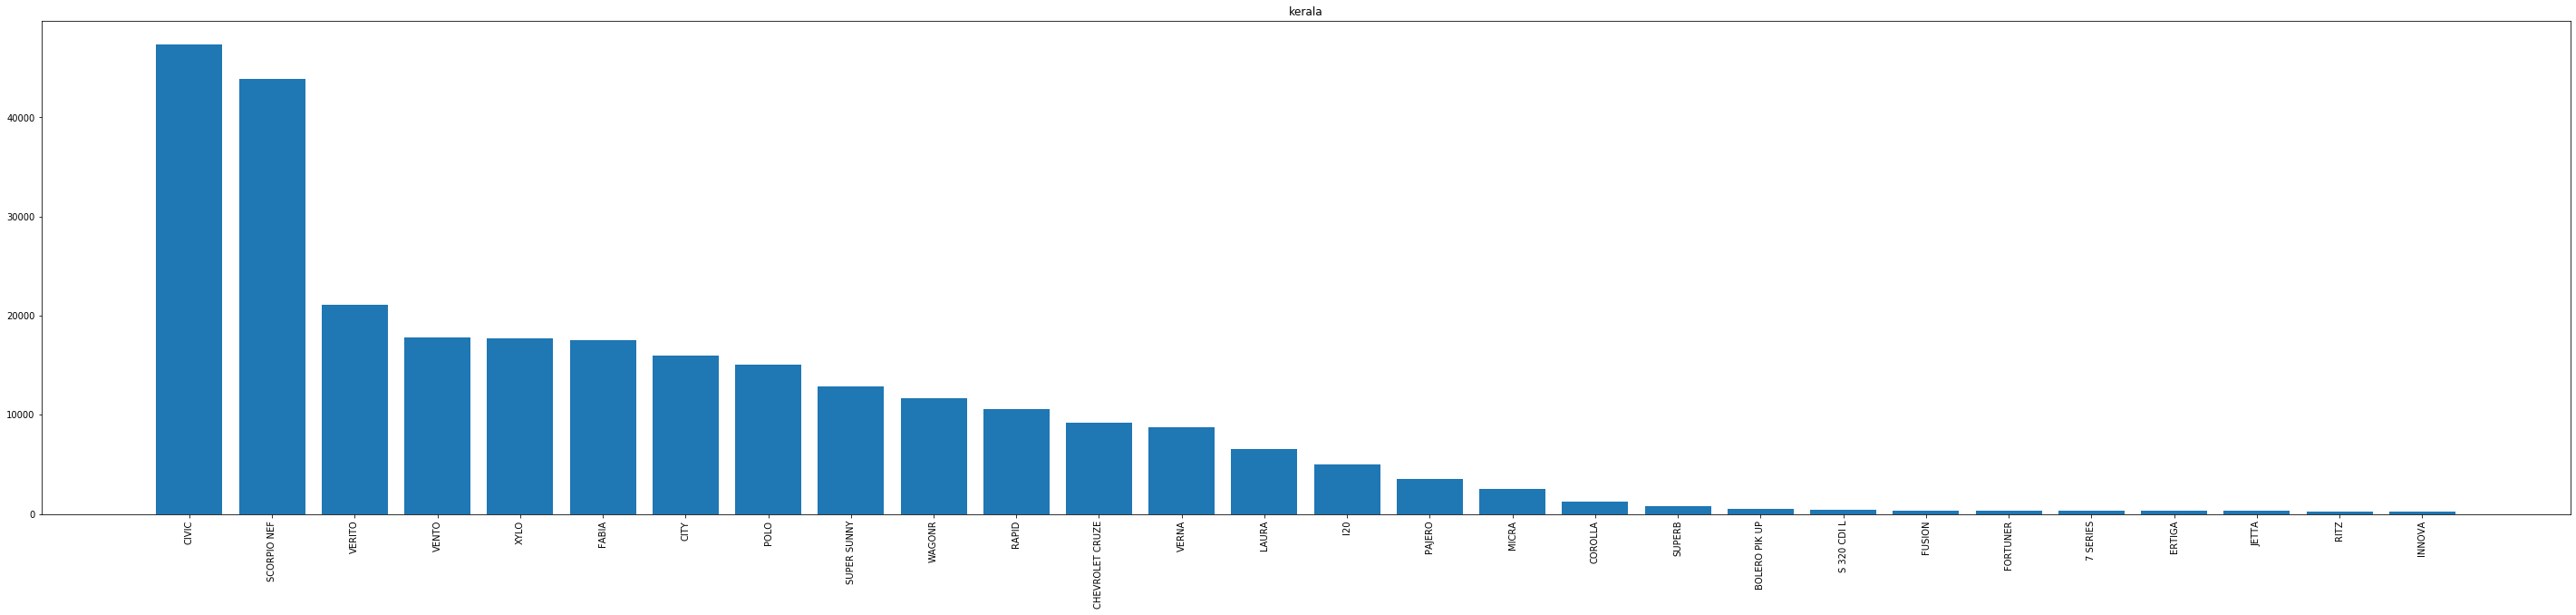

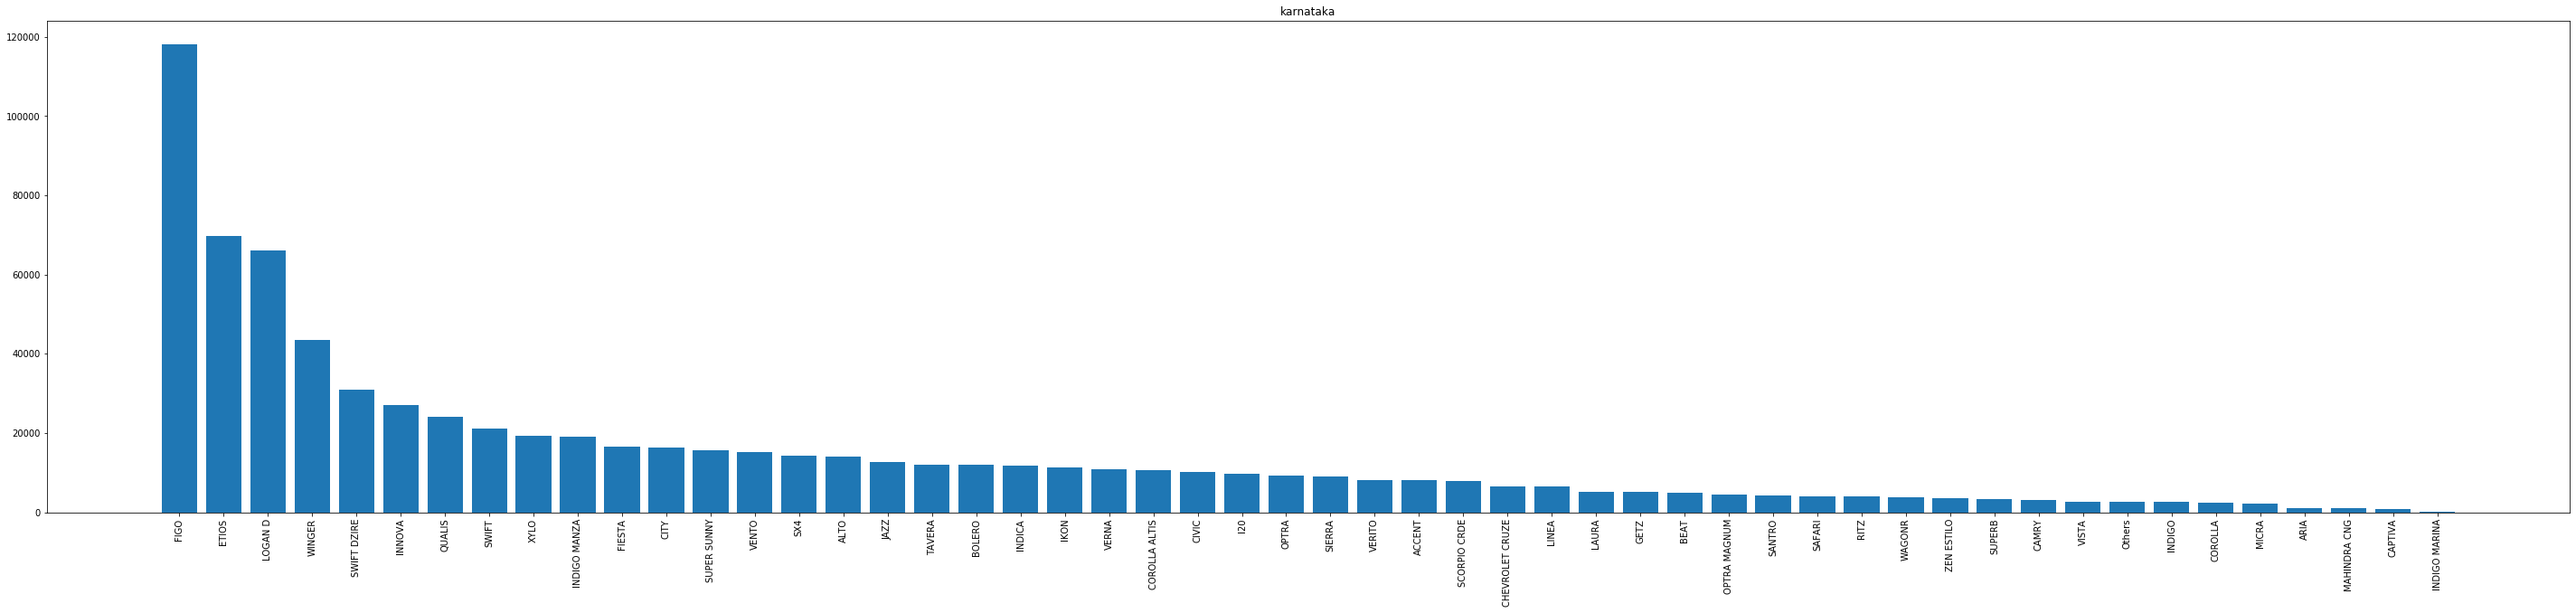

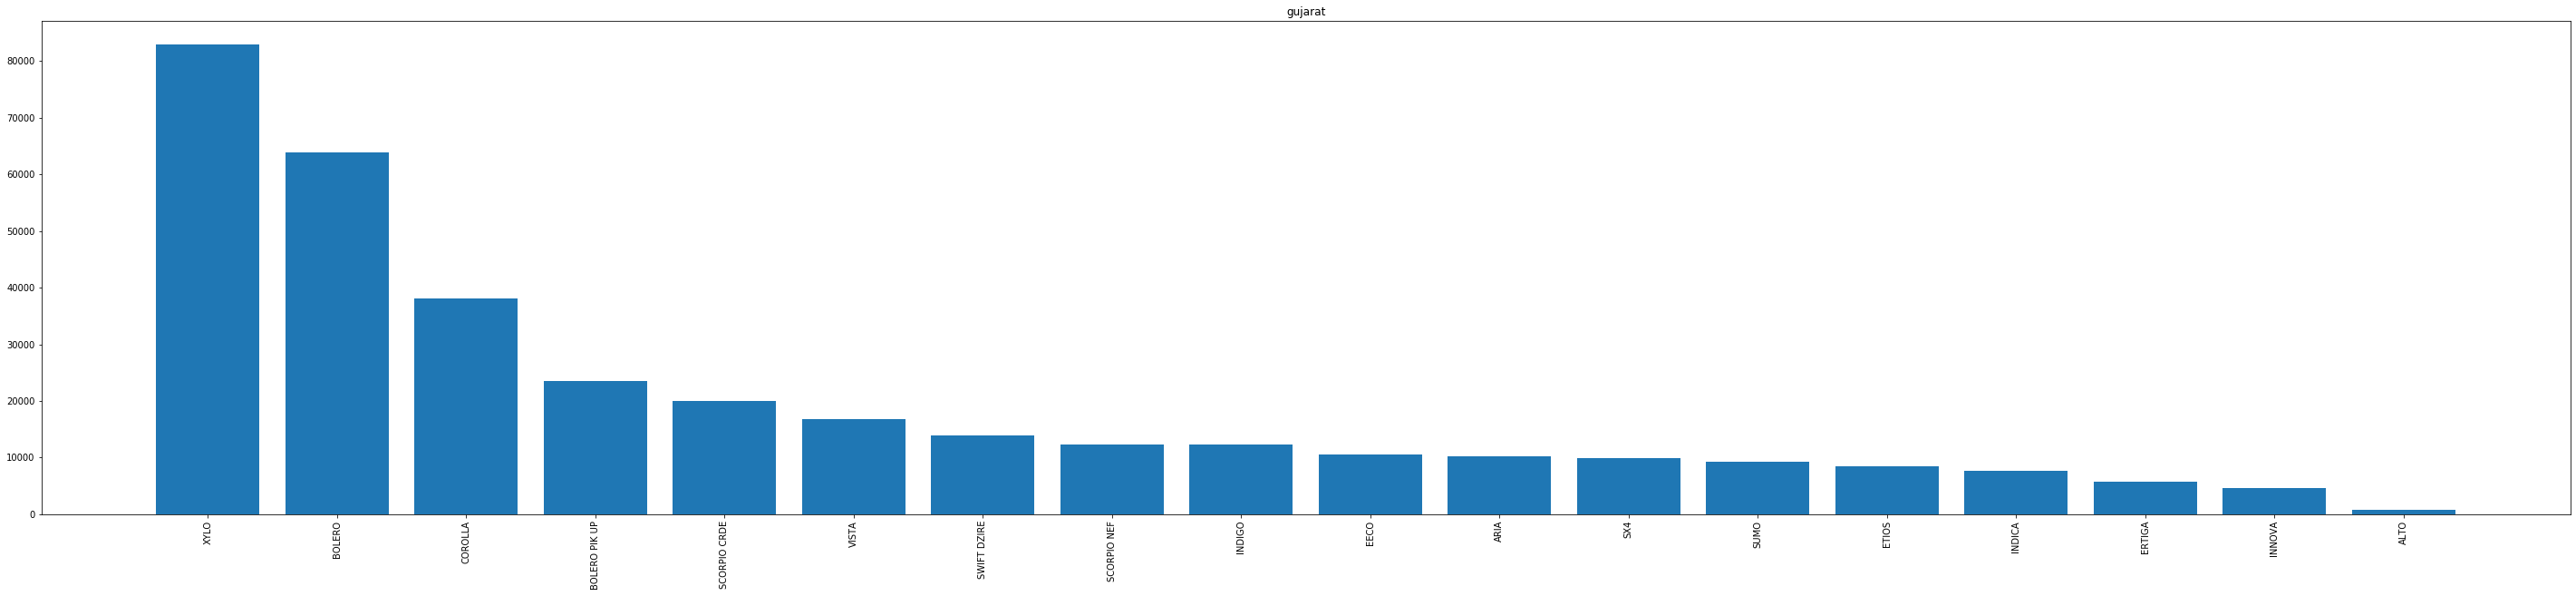

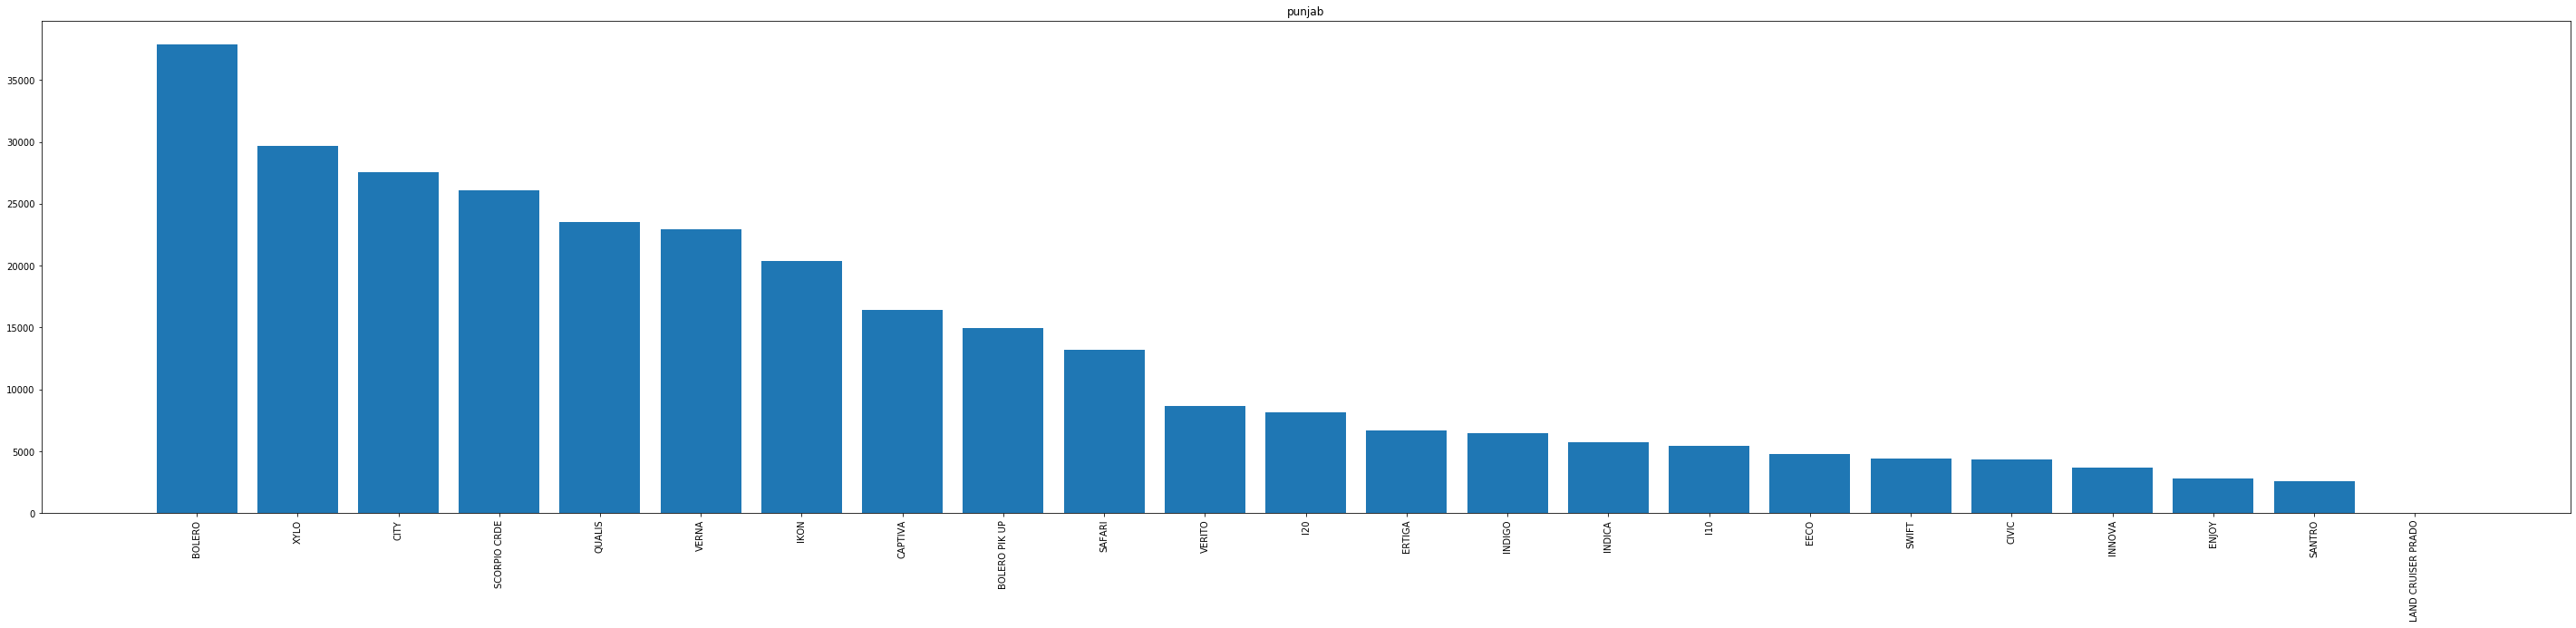

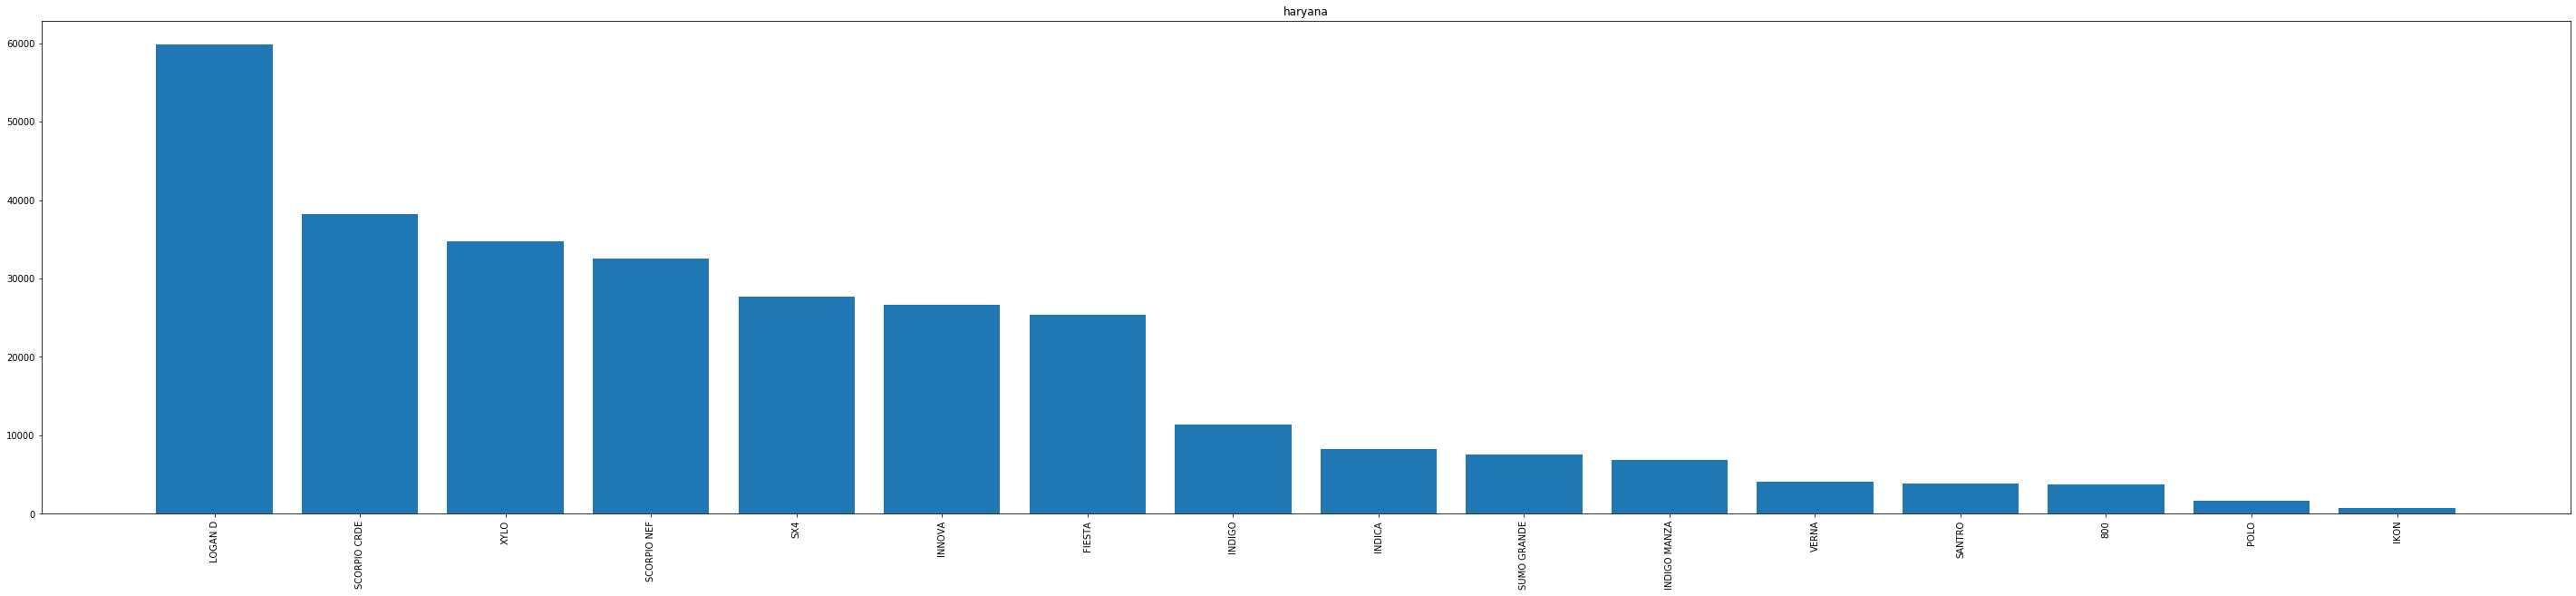

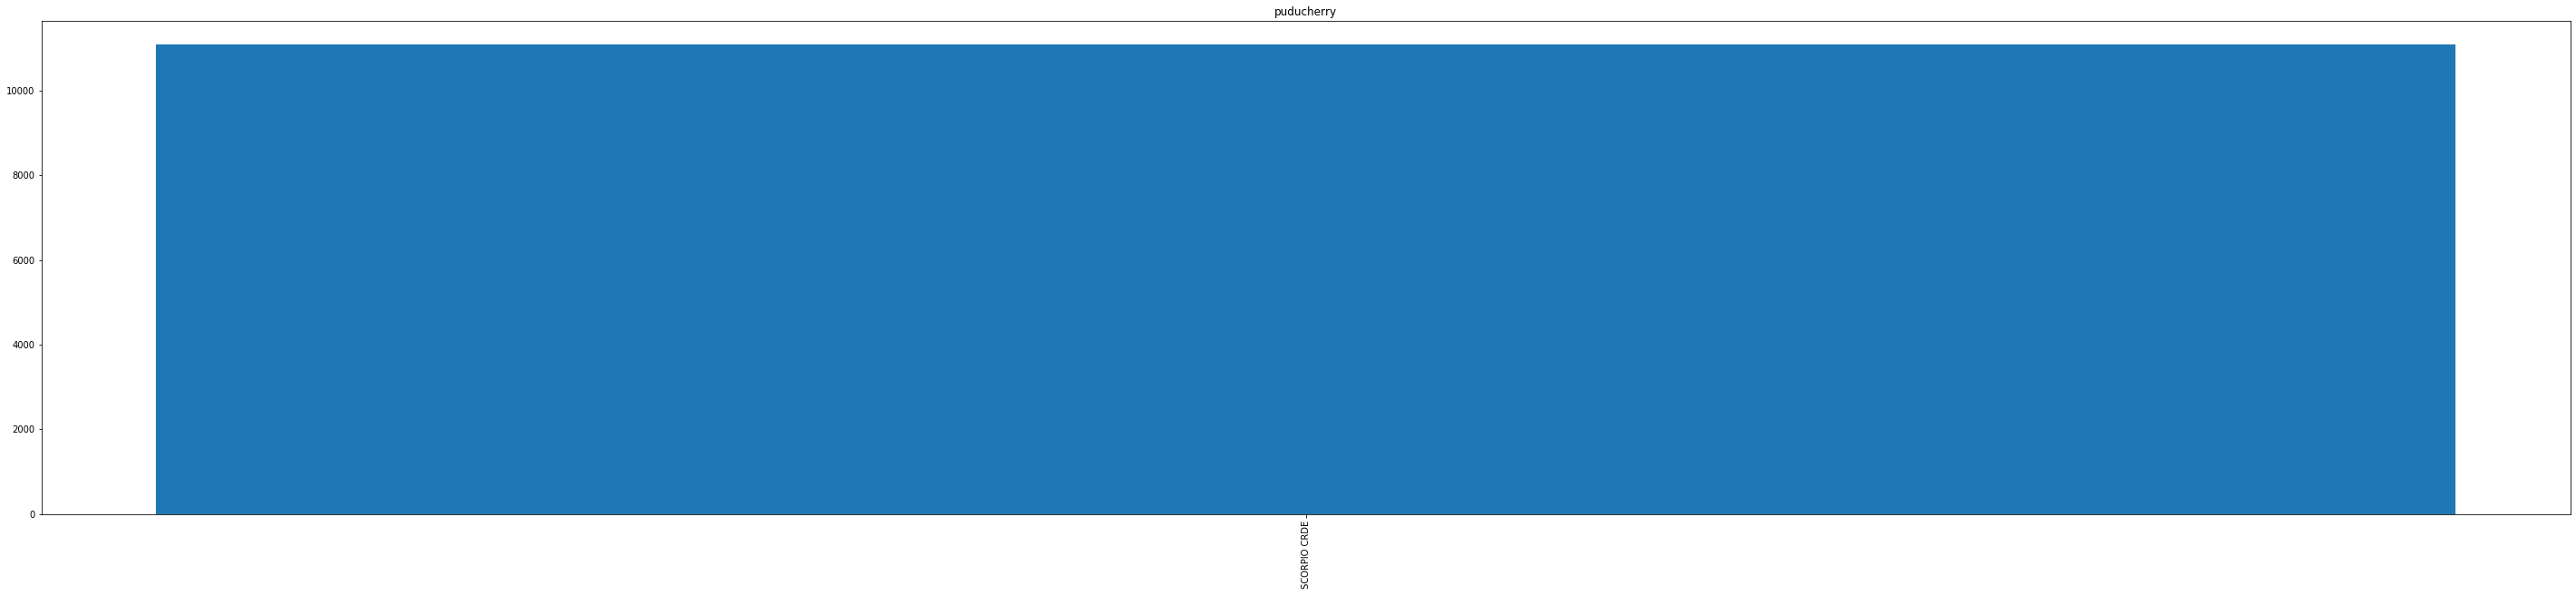

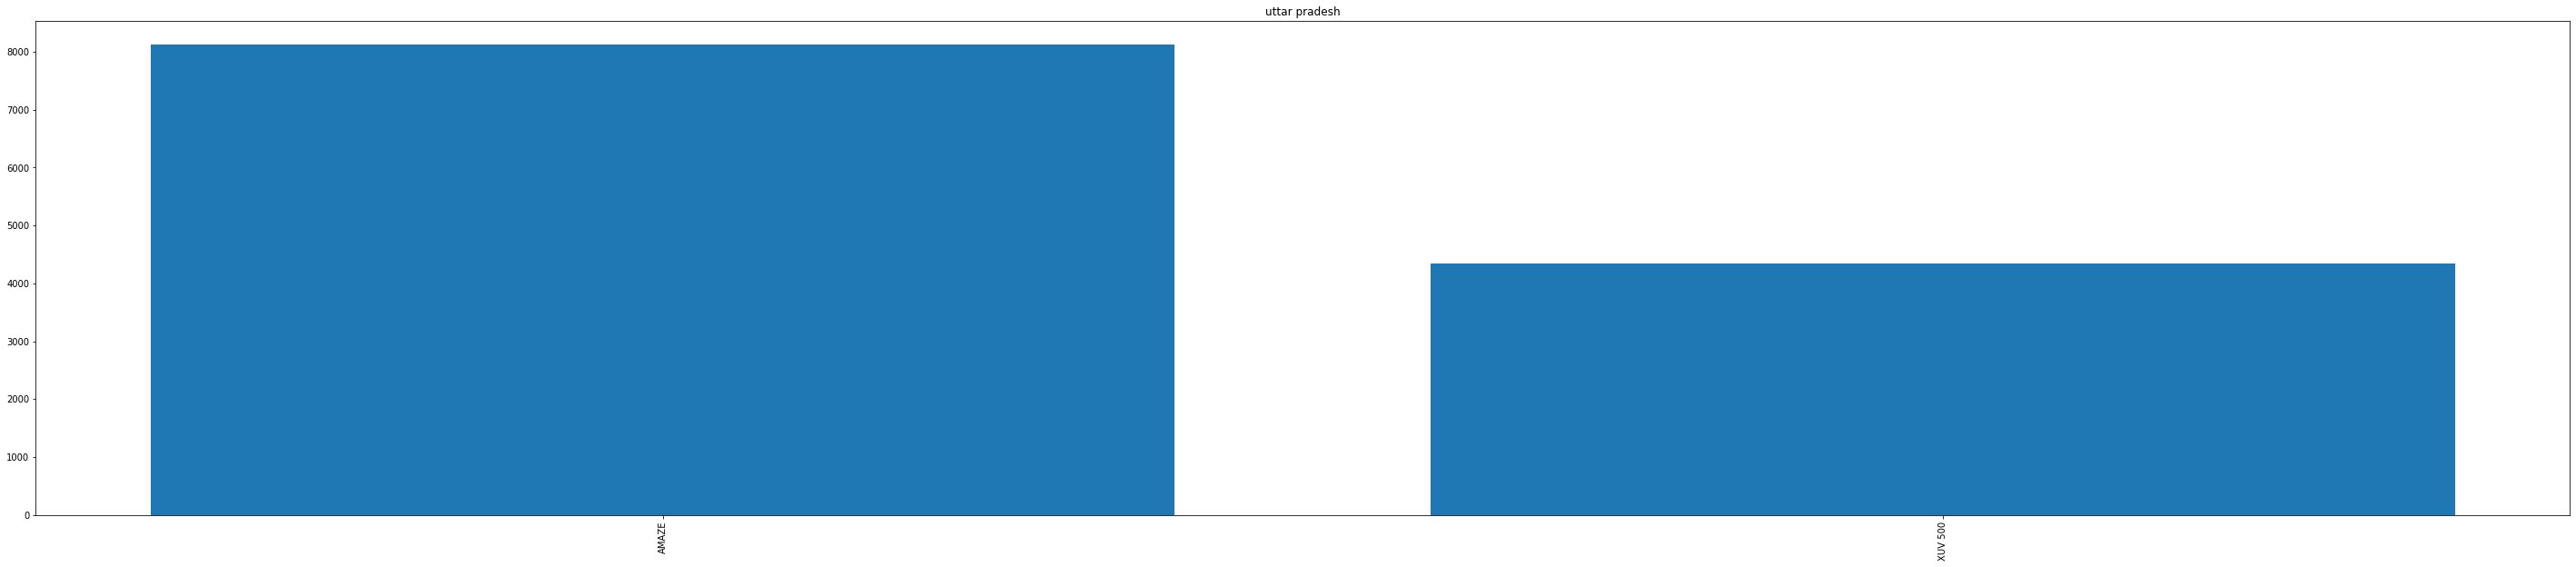

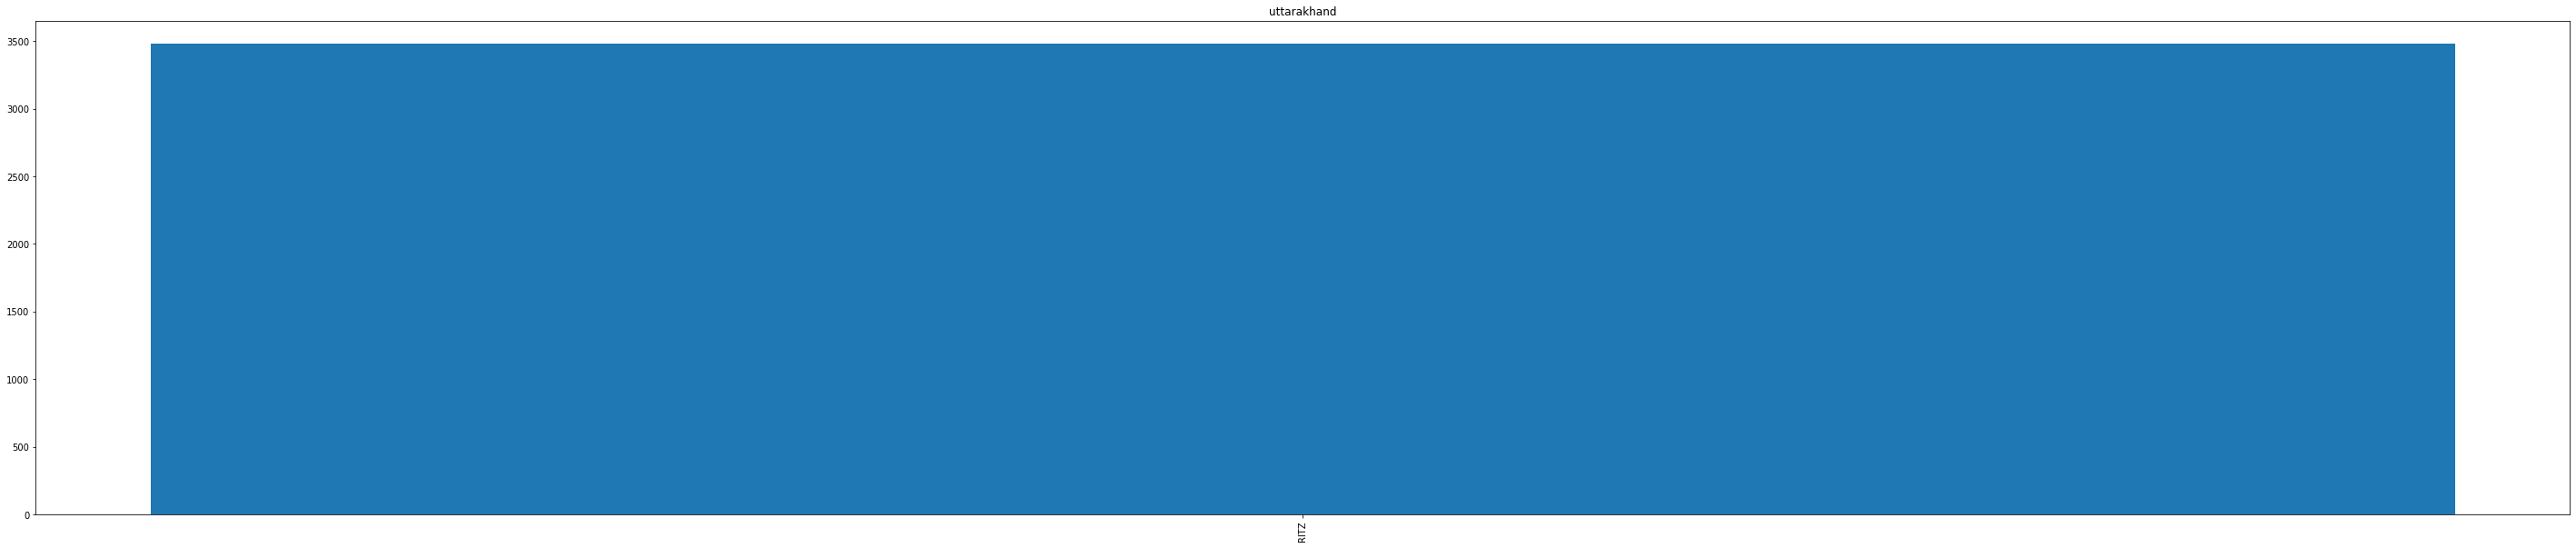

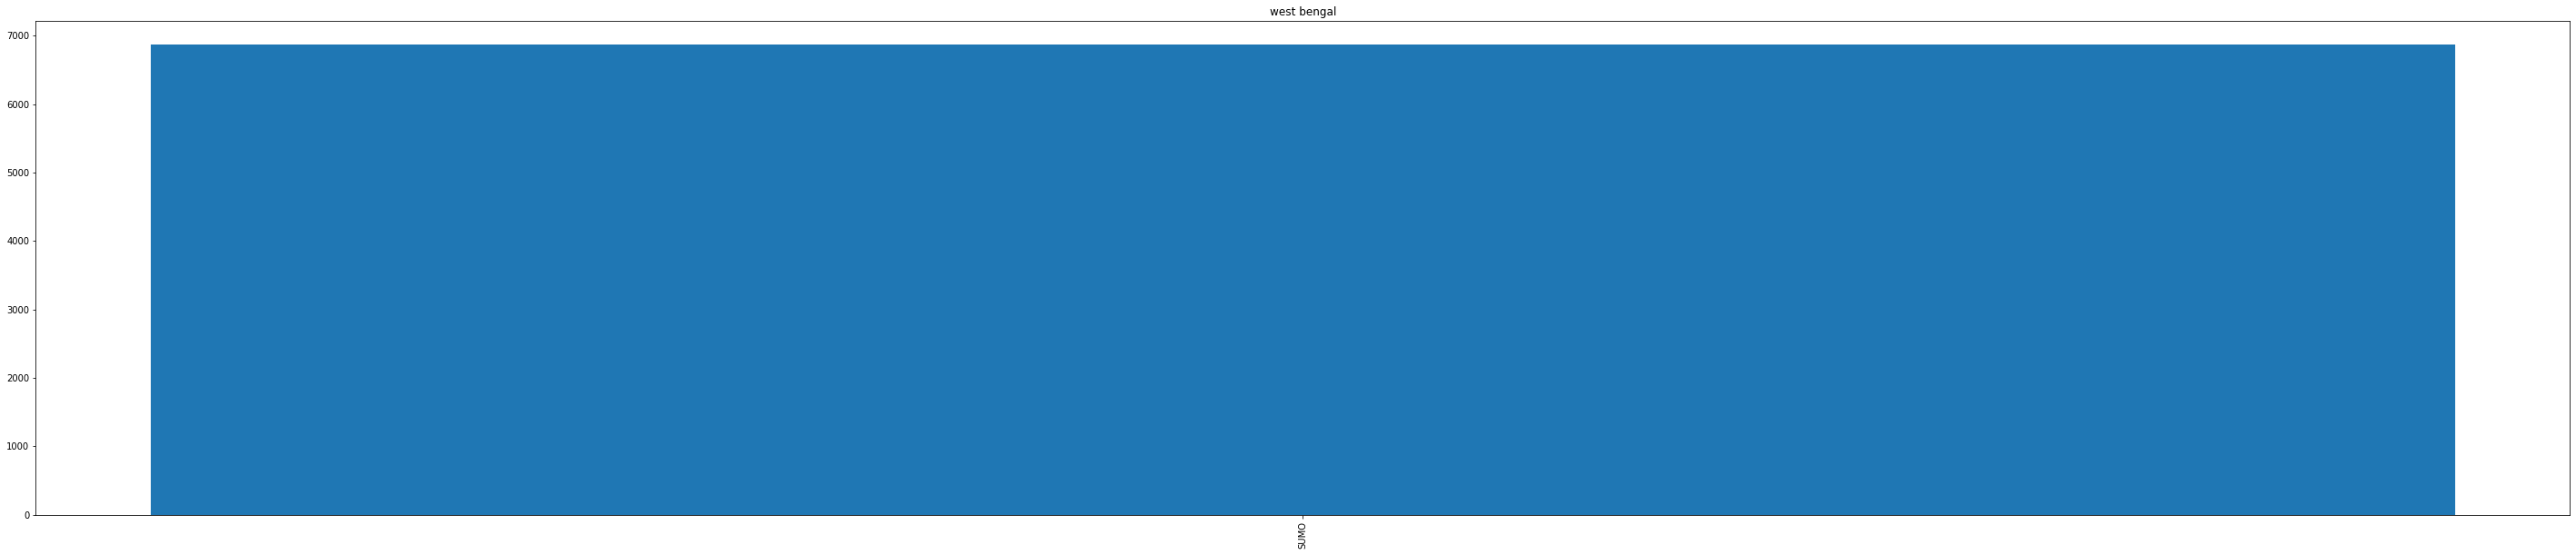

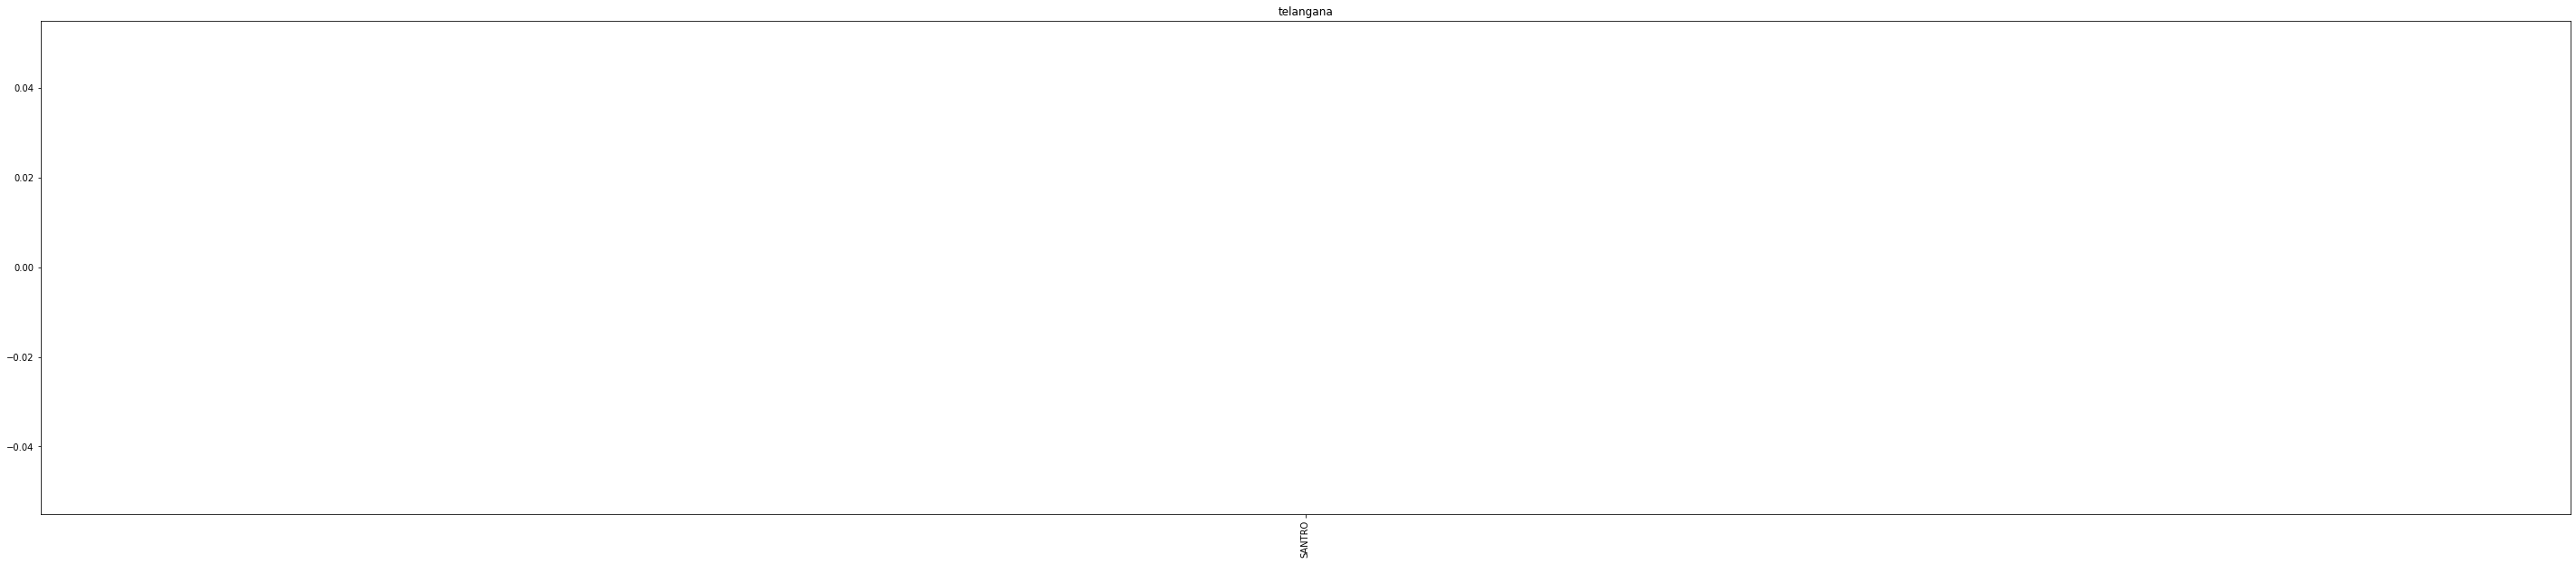

In [154]:
city=[]
city=join['District'].unique()
for i in city:
    cars=join[join['District']==i]
    
    fig=plt.figure(figsize=(50,10))
    plt.title(i)
    cars=cars.sort_values('Revenue',ascending=False)
    plt.bar(cars['Model'],cars['Revenue'])
    plt.xticks(rotation=90)
    plt.show()

In [155]:
join.columns

Index(['Customer No.', 'Partner Type', 'Data Origin', 'Occupation',
       'Area / Locality', 'CITY', 'Claim No.', 'Cust Type', 'District',
       'Insurance Company', 'InvoiceDate', 'Job Card No', 'JobCard Date',
       'KMs Reading', 'Make', 'Model', 'Pin code', 'ODN No.', 'Order Type',
       'Plant Name1', 'Regn No', 'Revenue', 'monthno', 'month'],
      dtype='object')

ACCENT


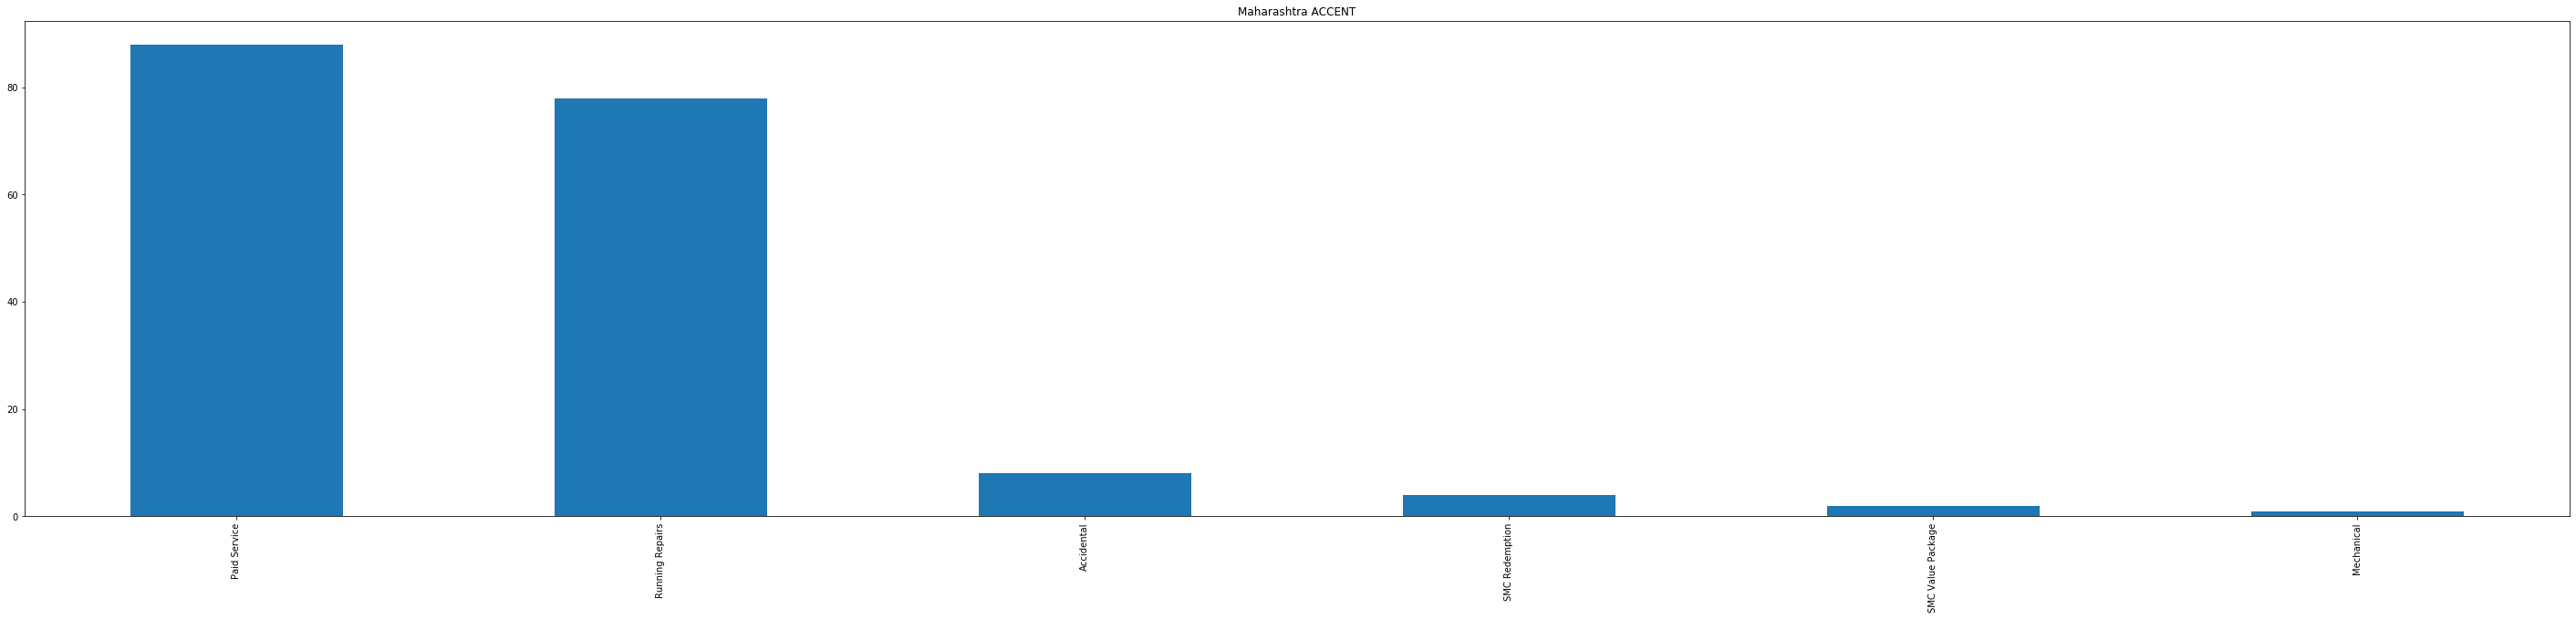

PALIO


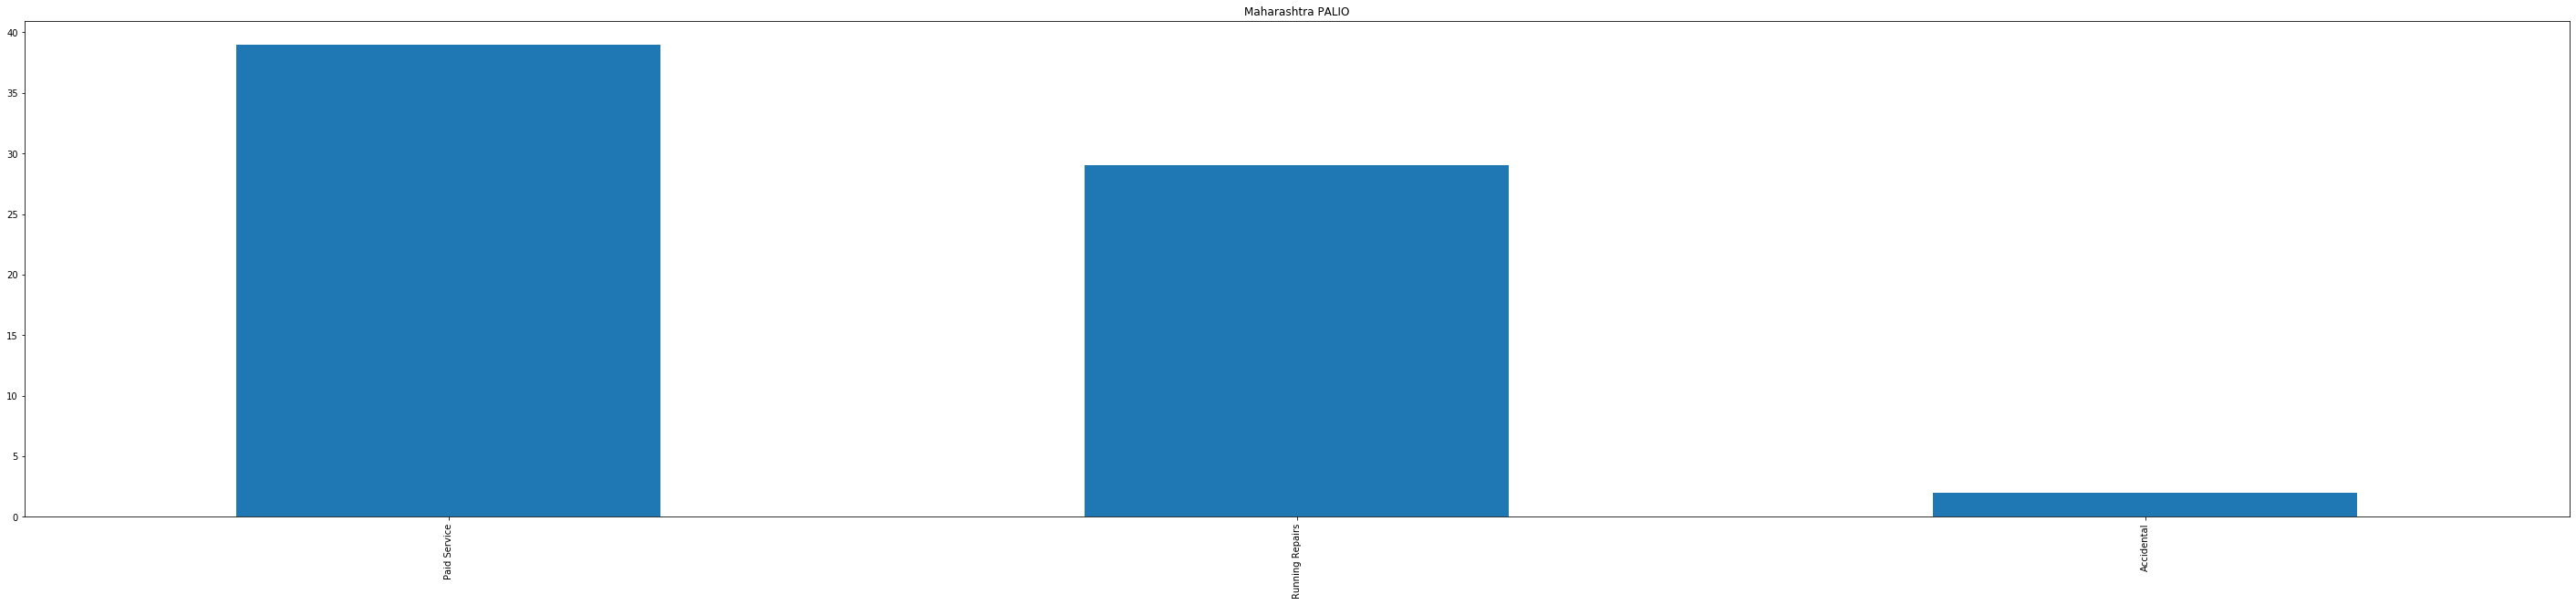

SCORPIO CRDE


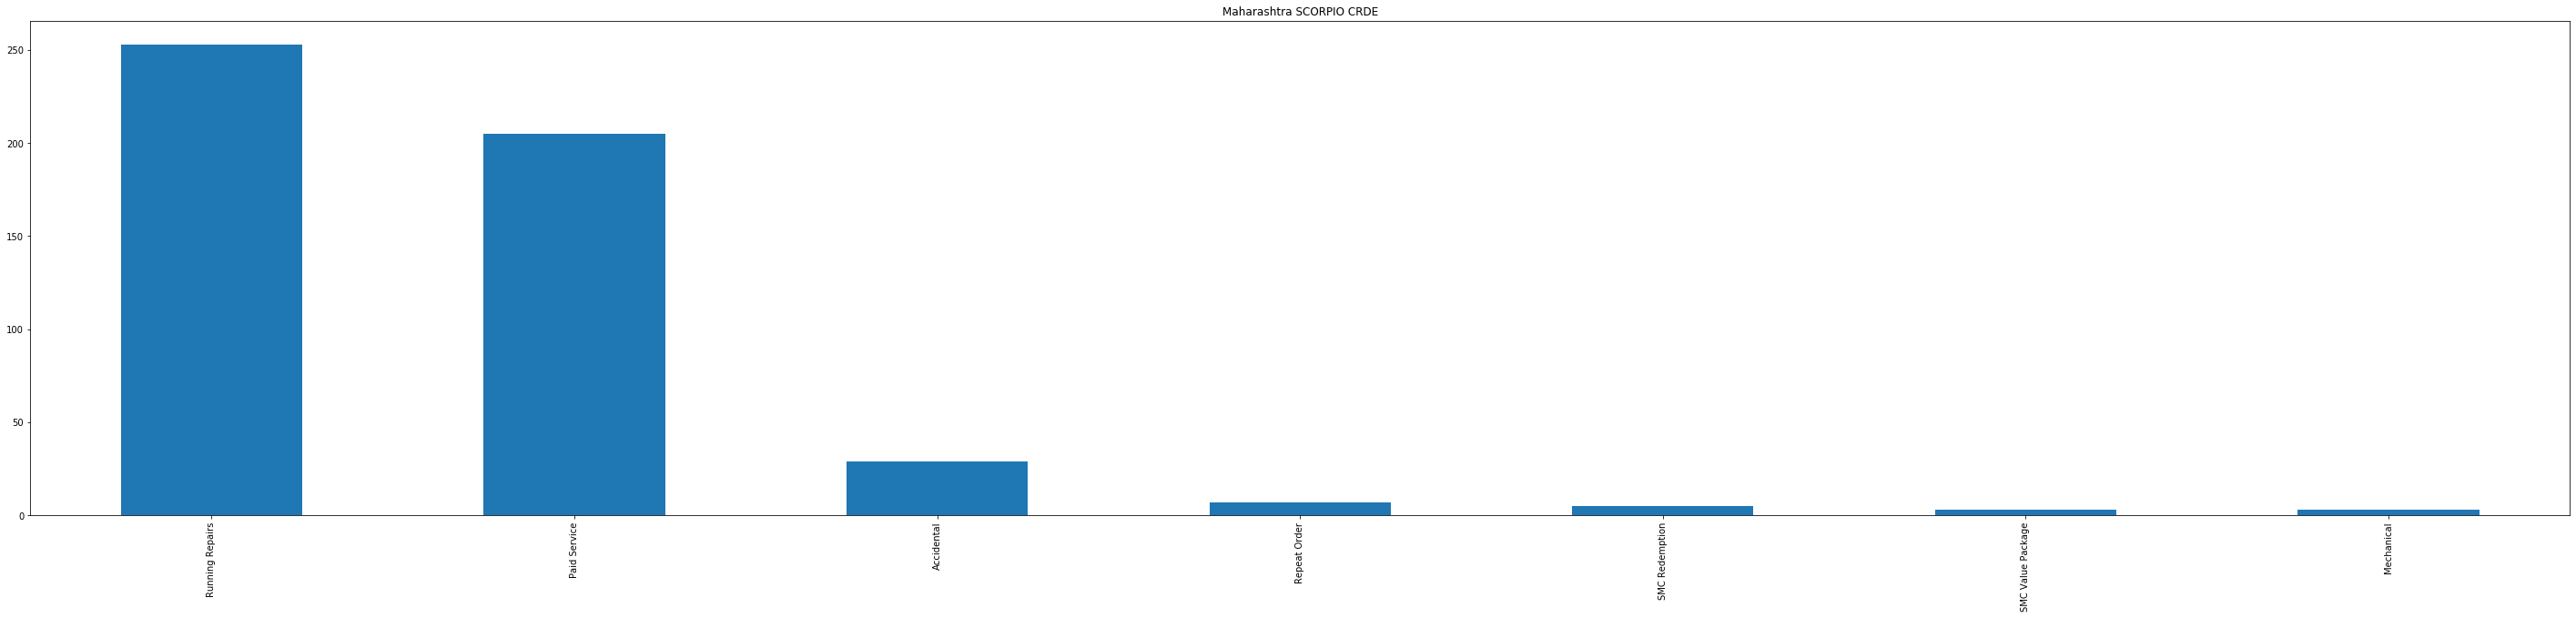

SANTRO


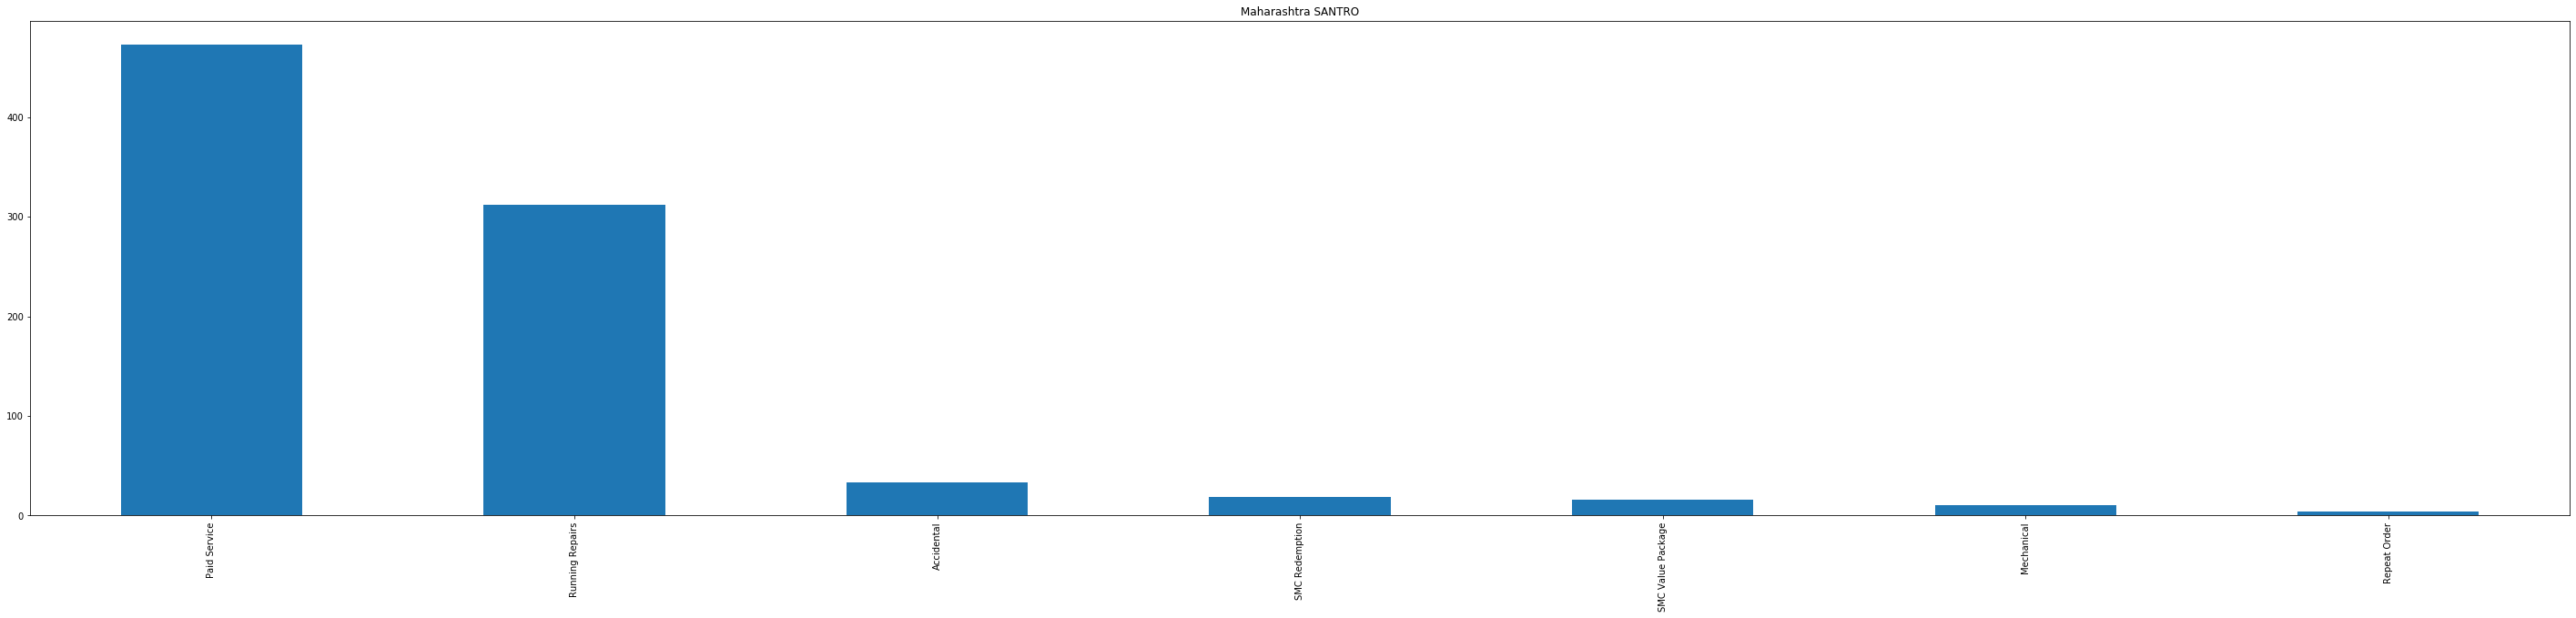

SCORPIO NEF


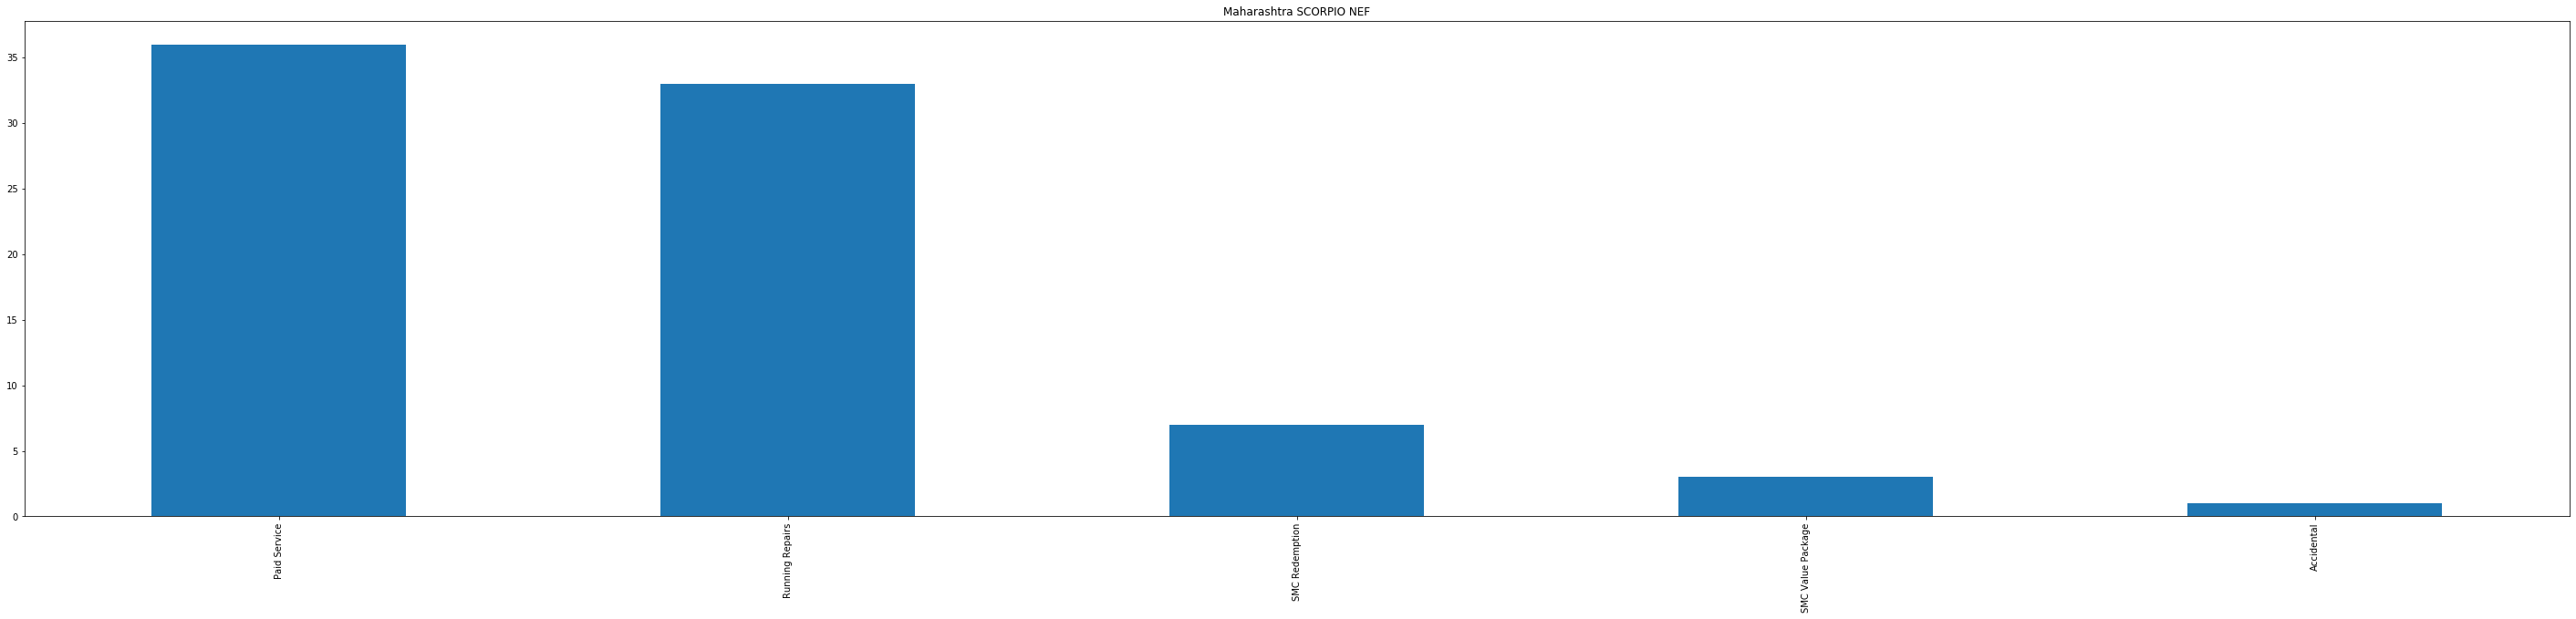

LOGAN P


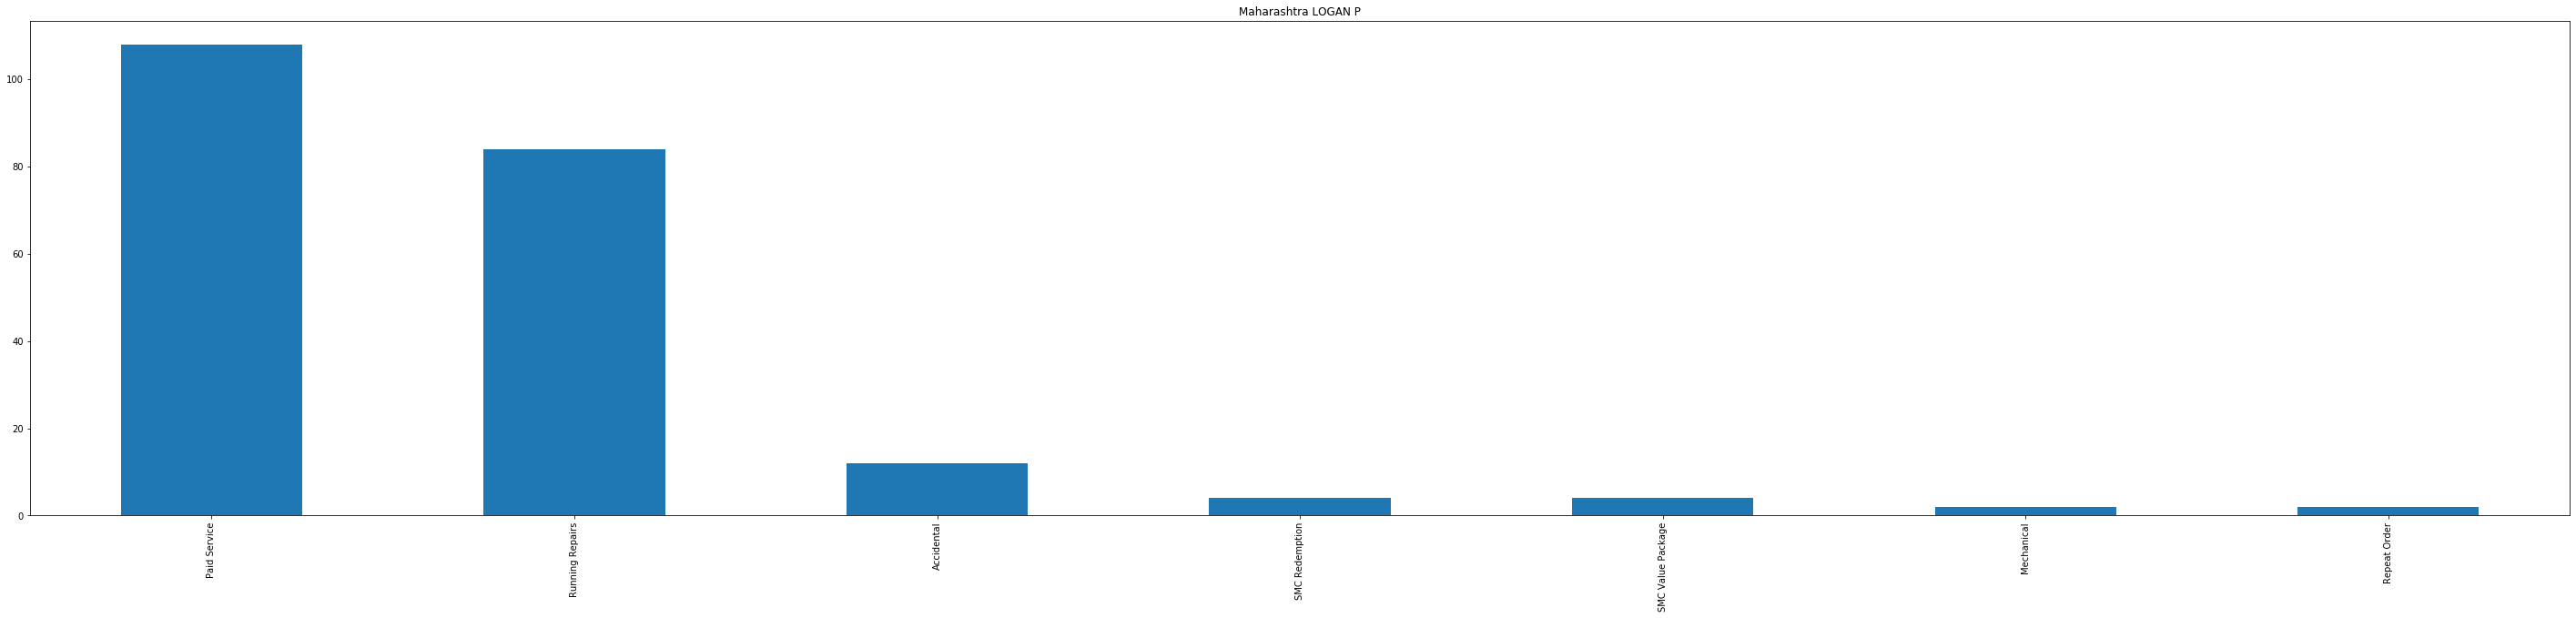

SWIFT DZIRE


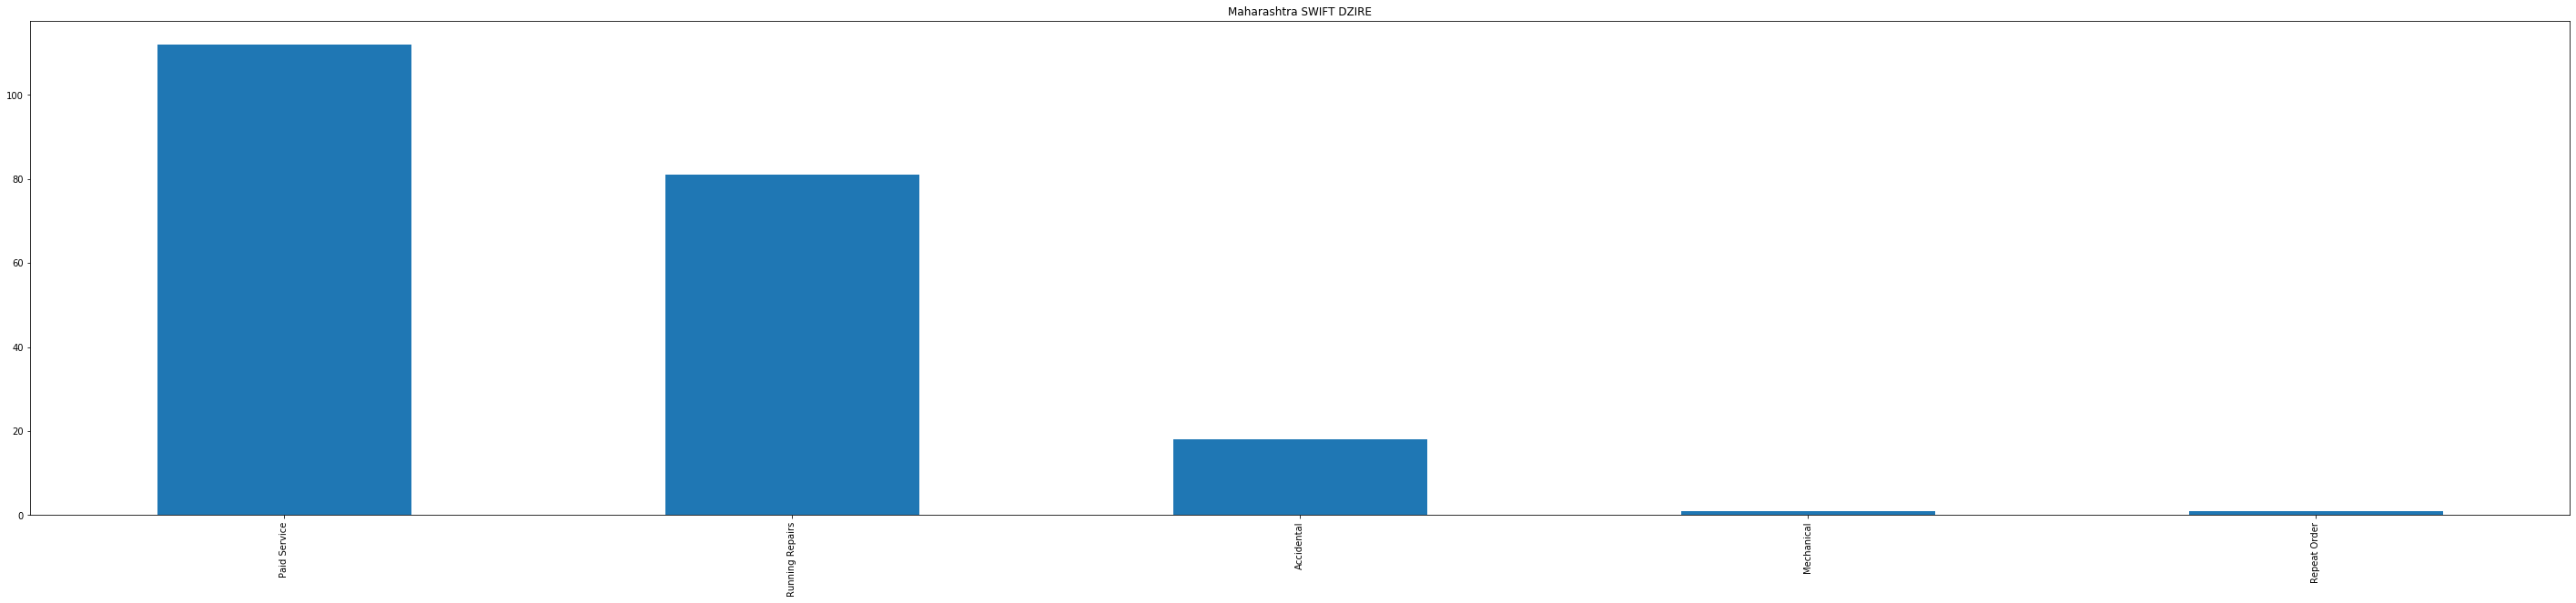

INDICA


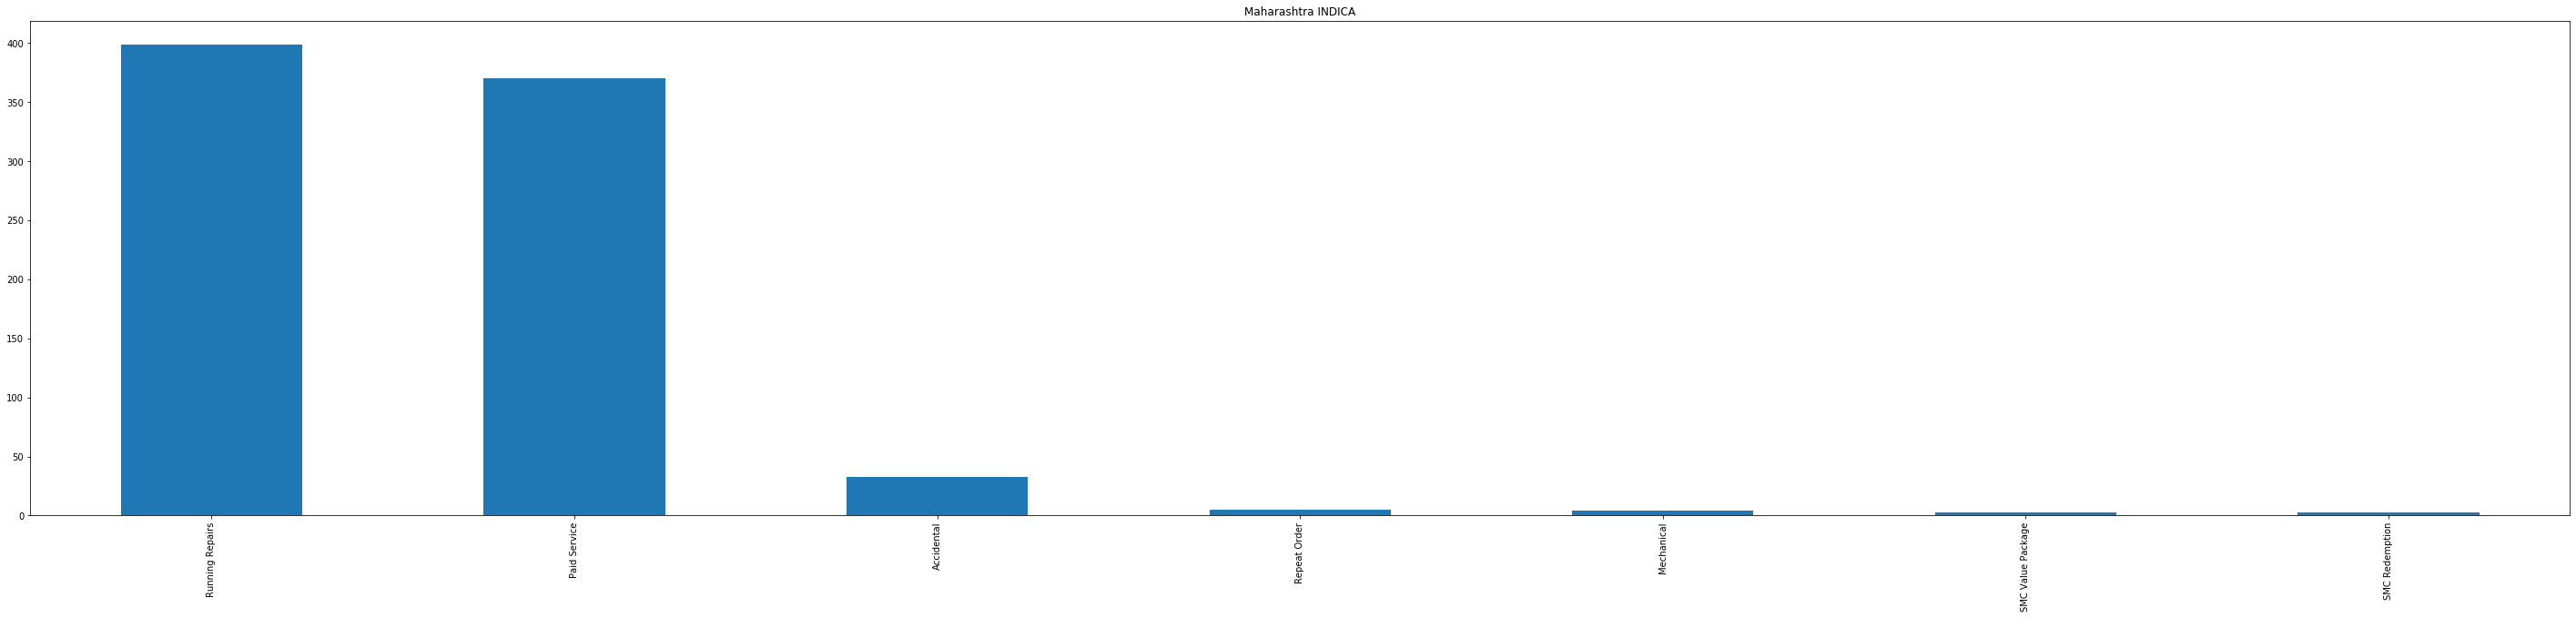

LAURA


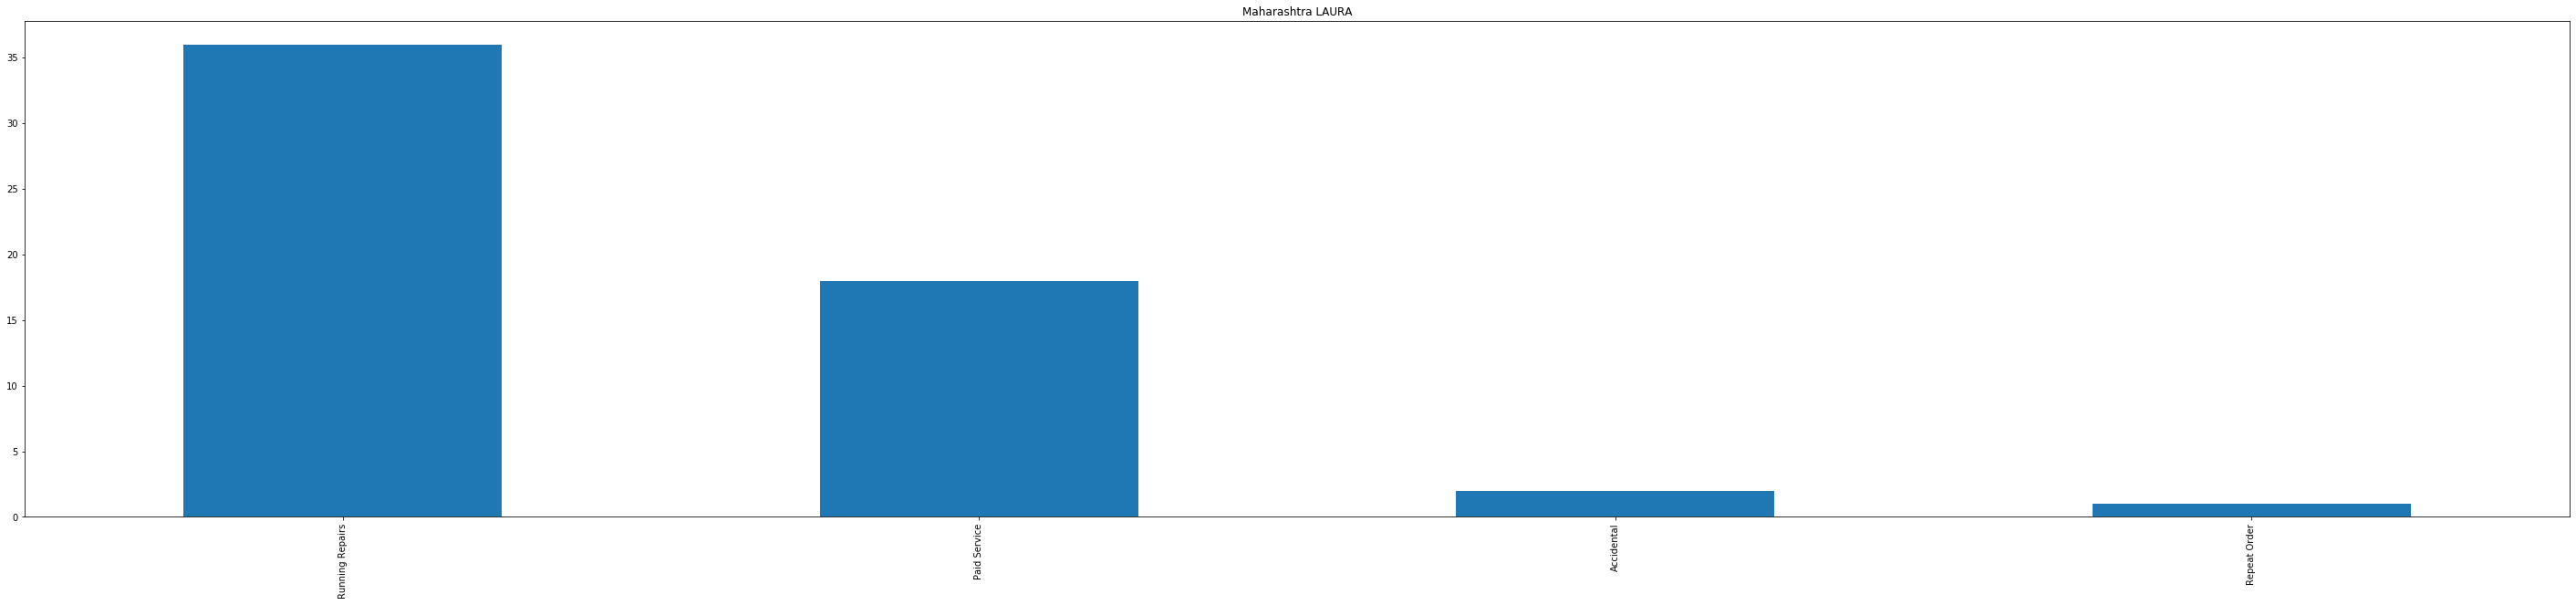

INDIGO MANZA


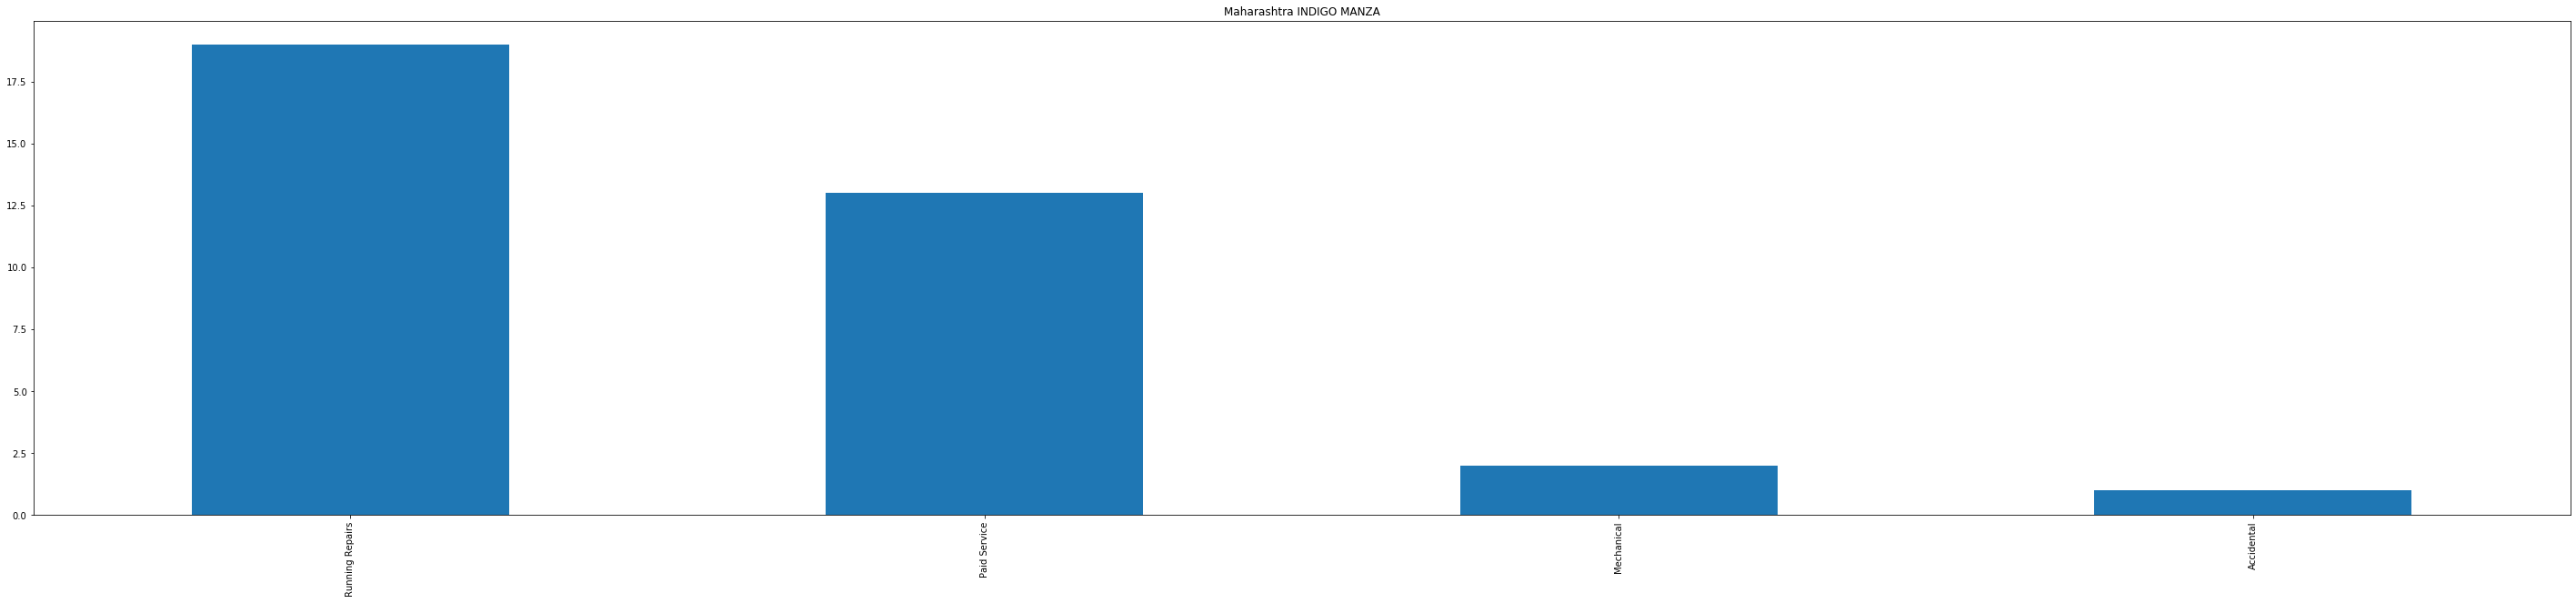

FIESTA


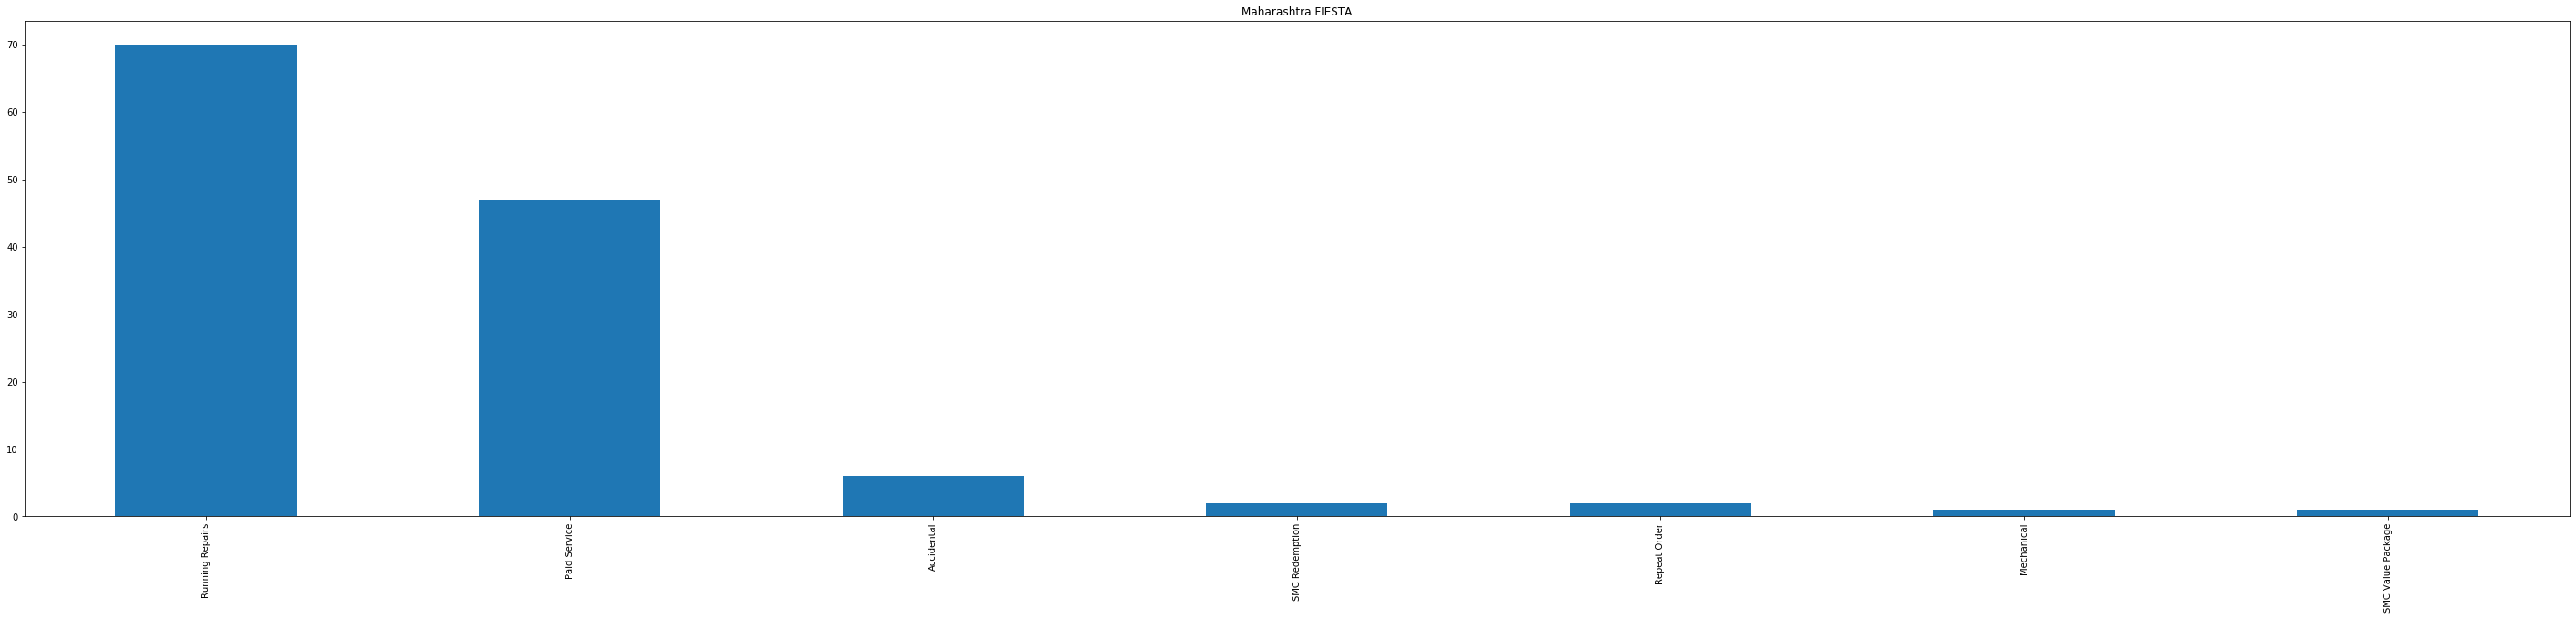

Others


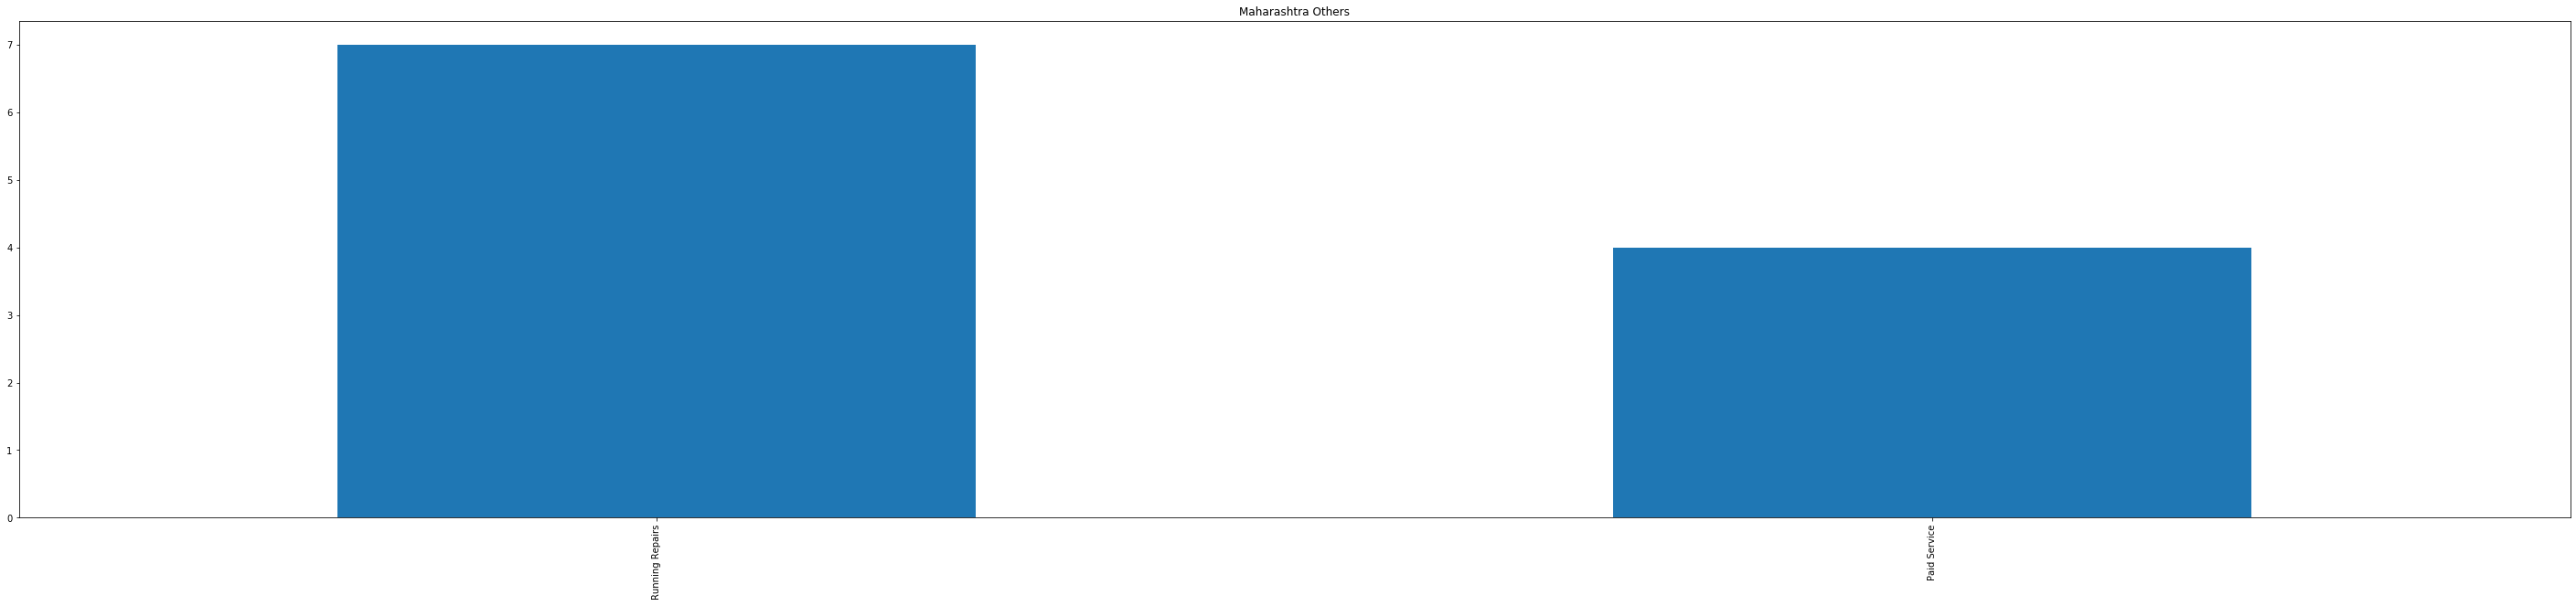

SUMO GRANDE


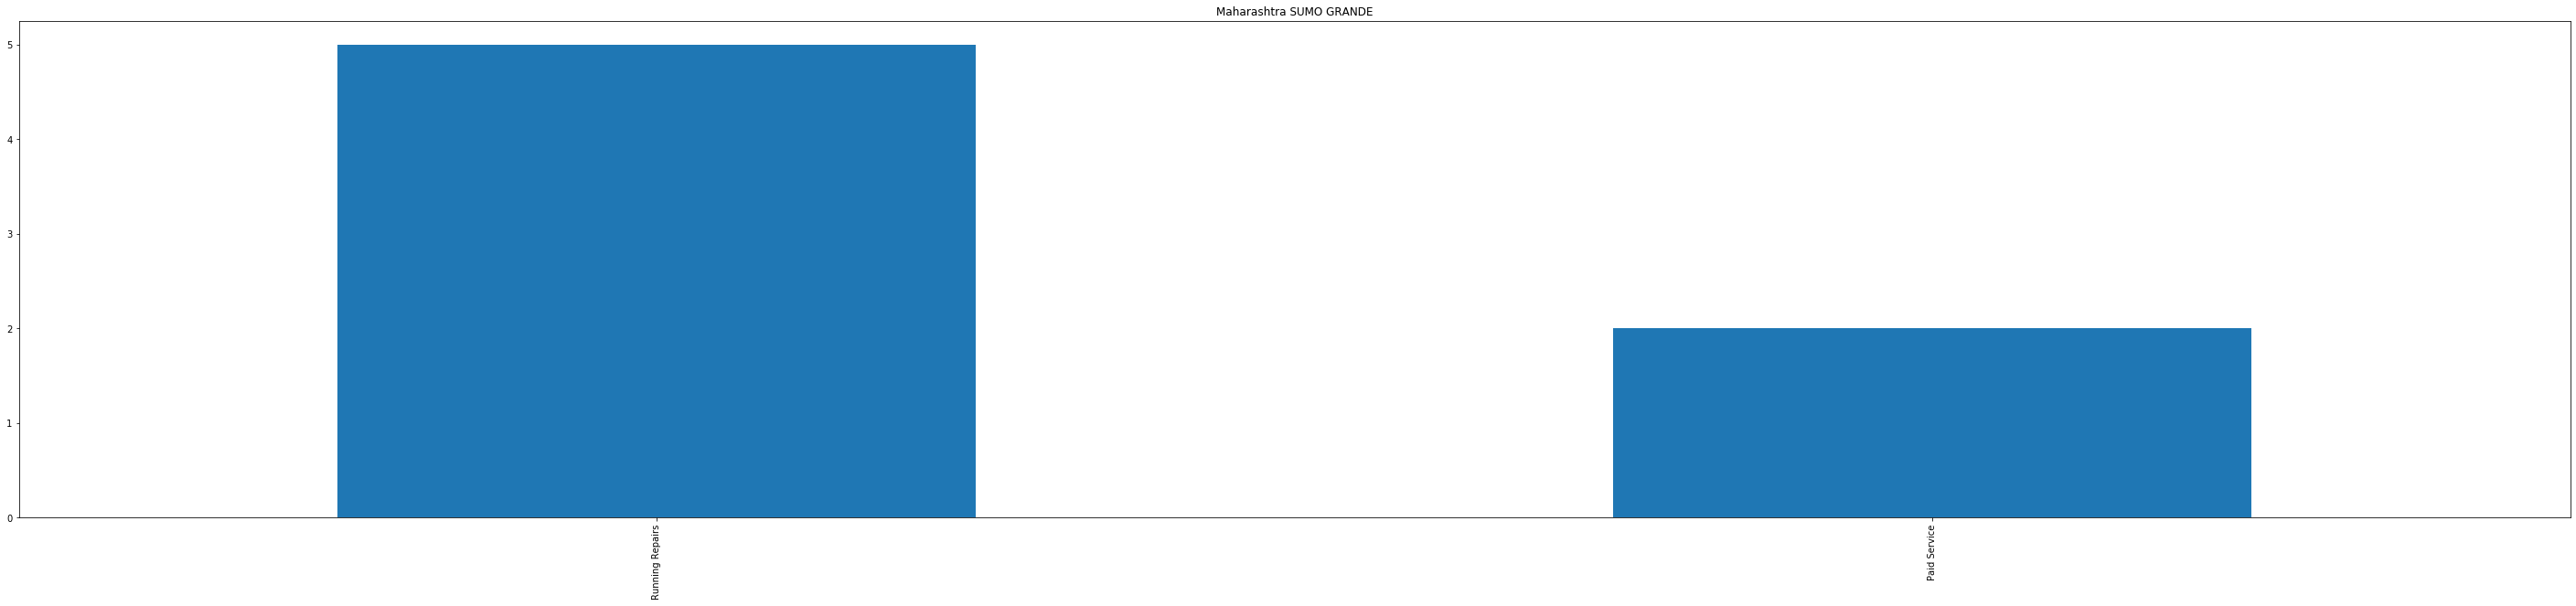

VISTA


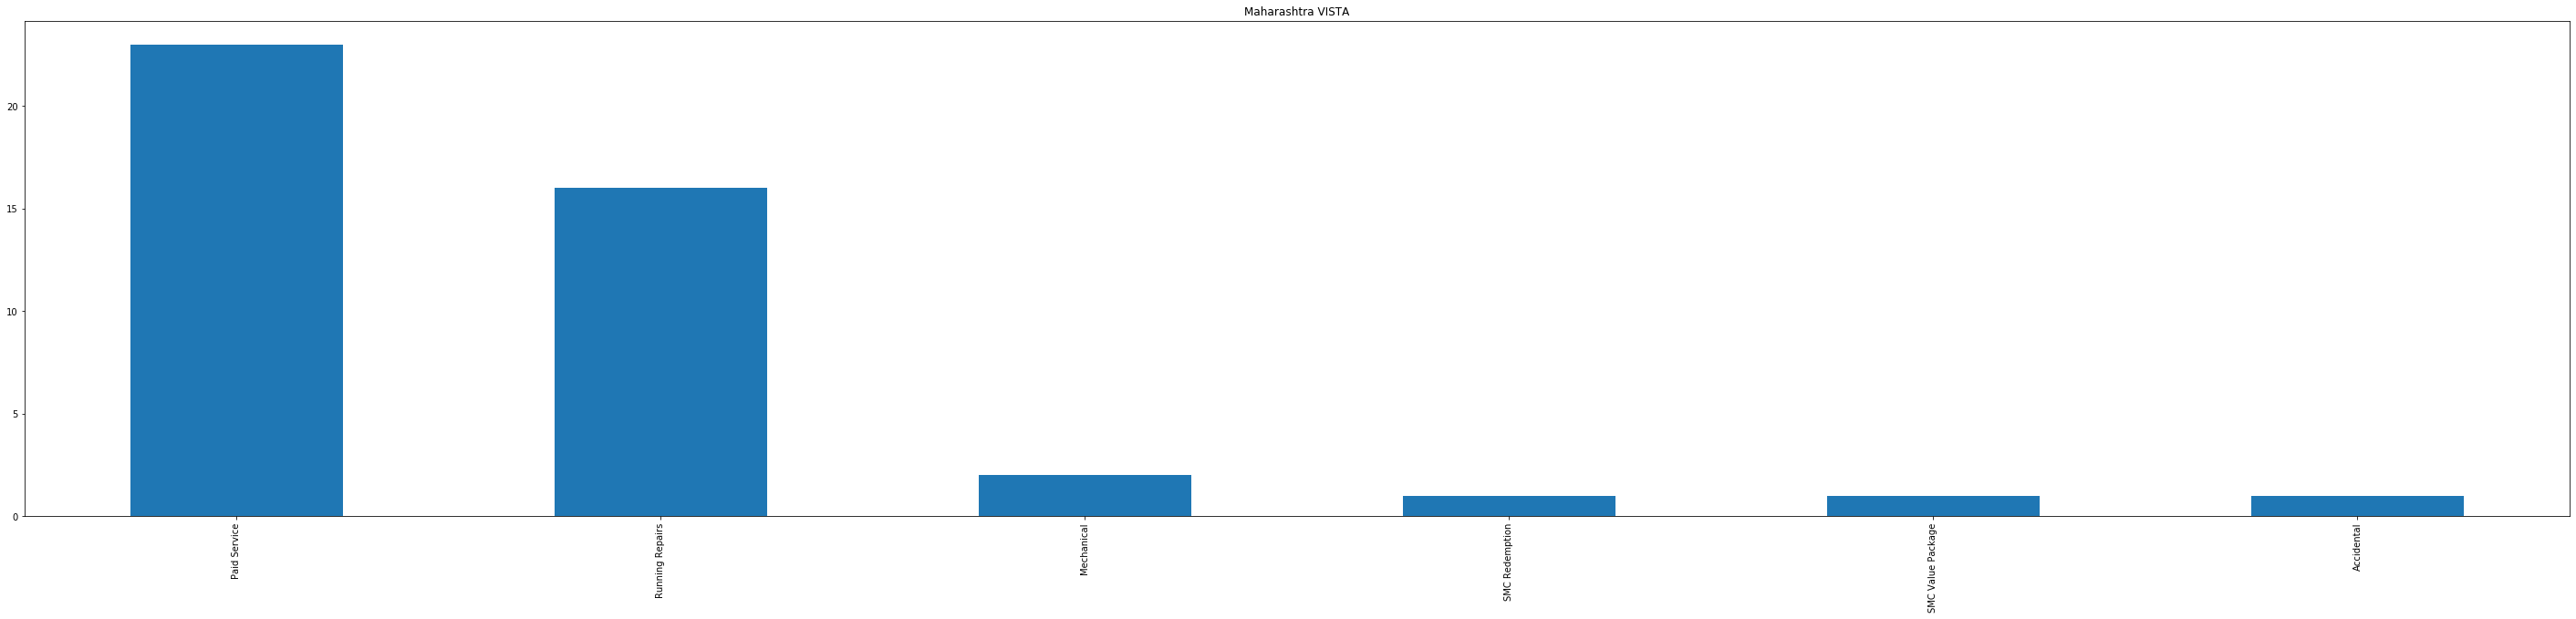

BOLERO


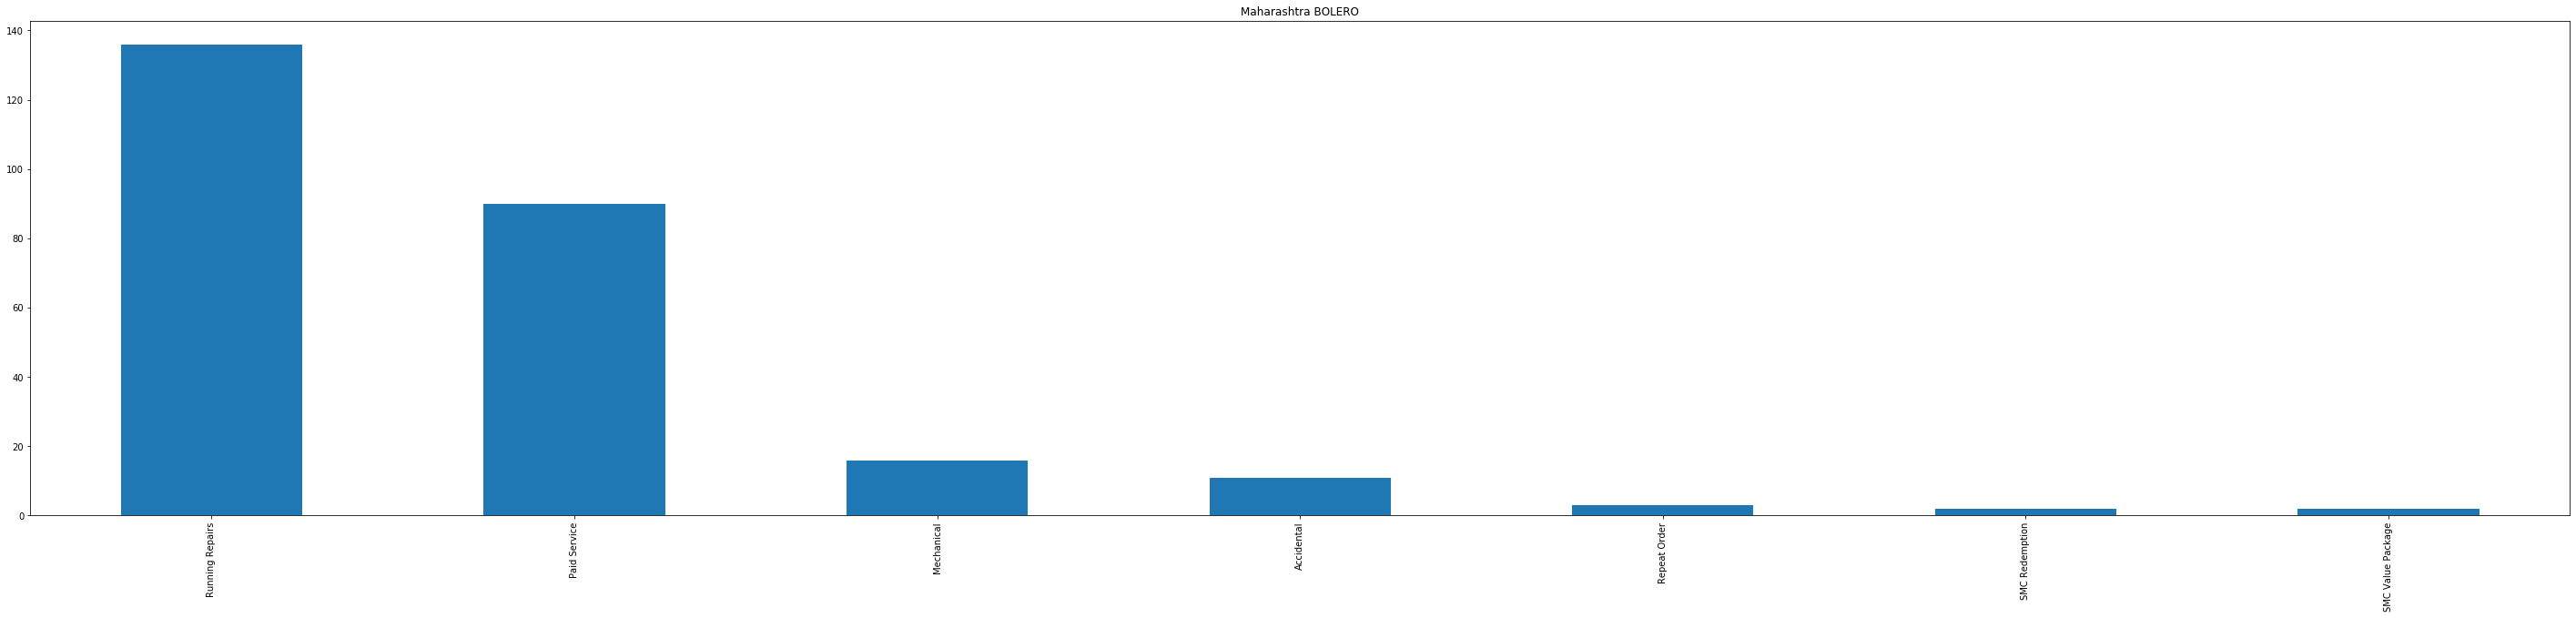

CIVIC


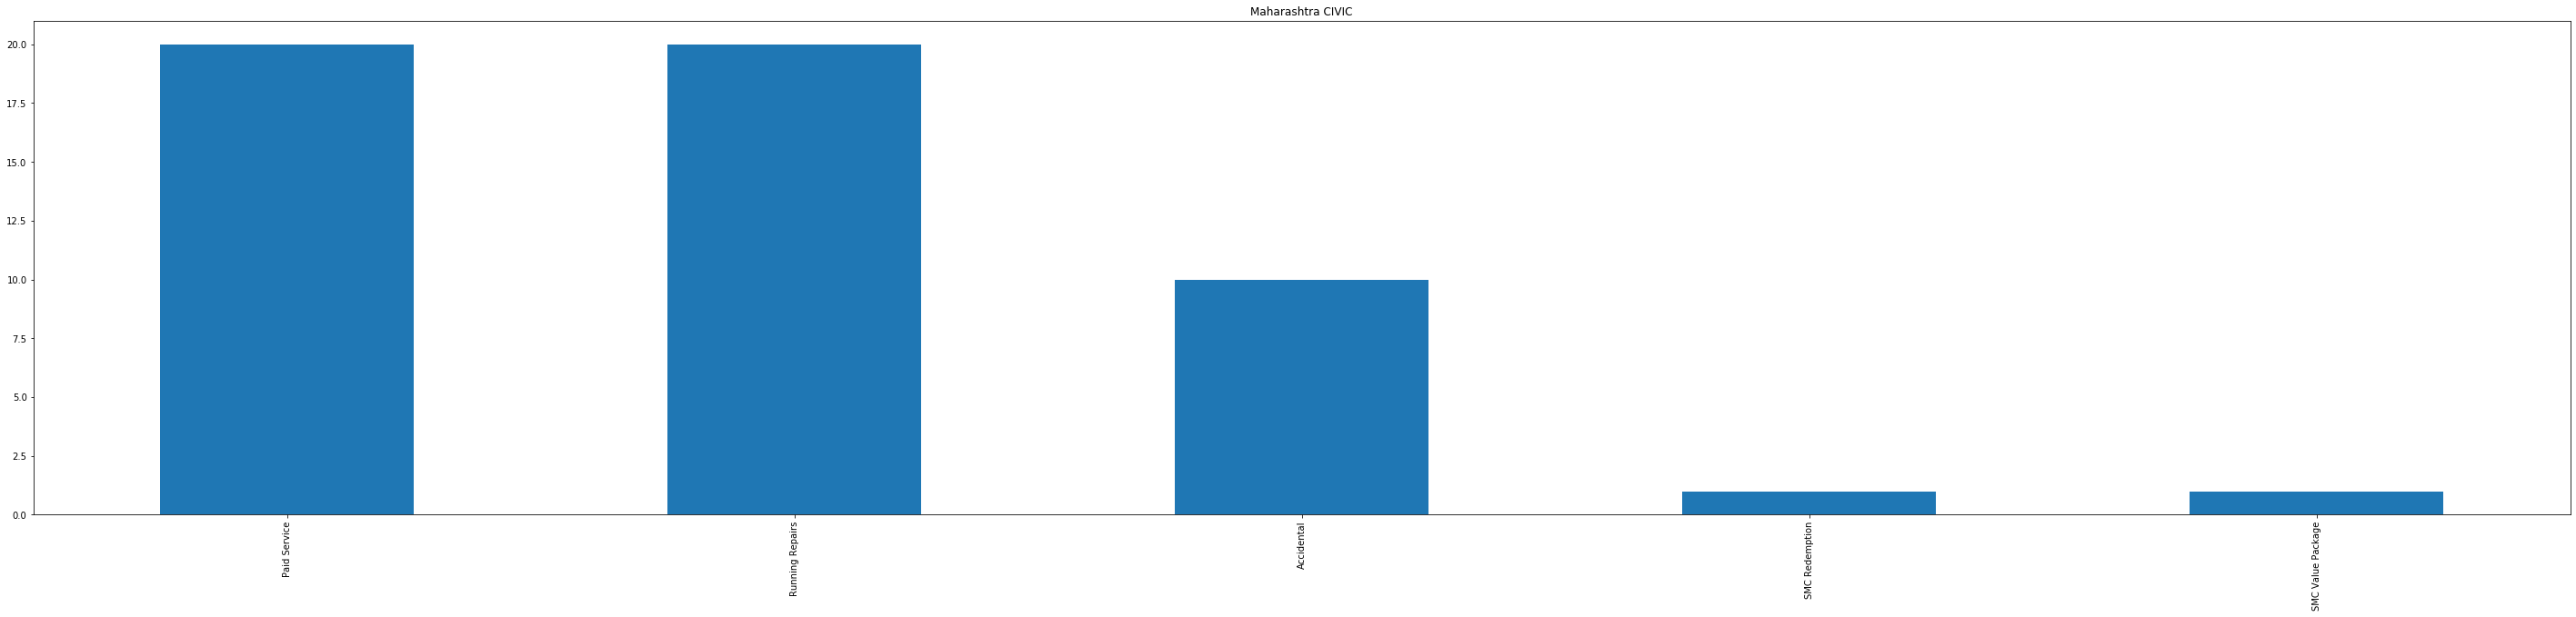

800


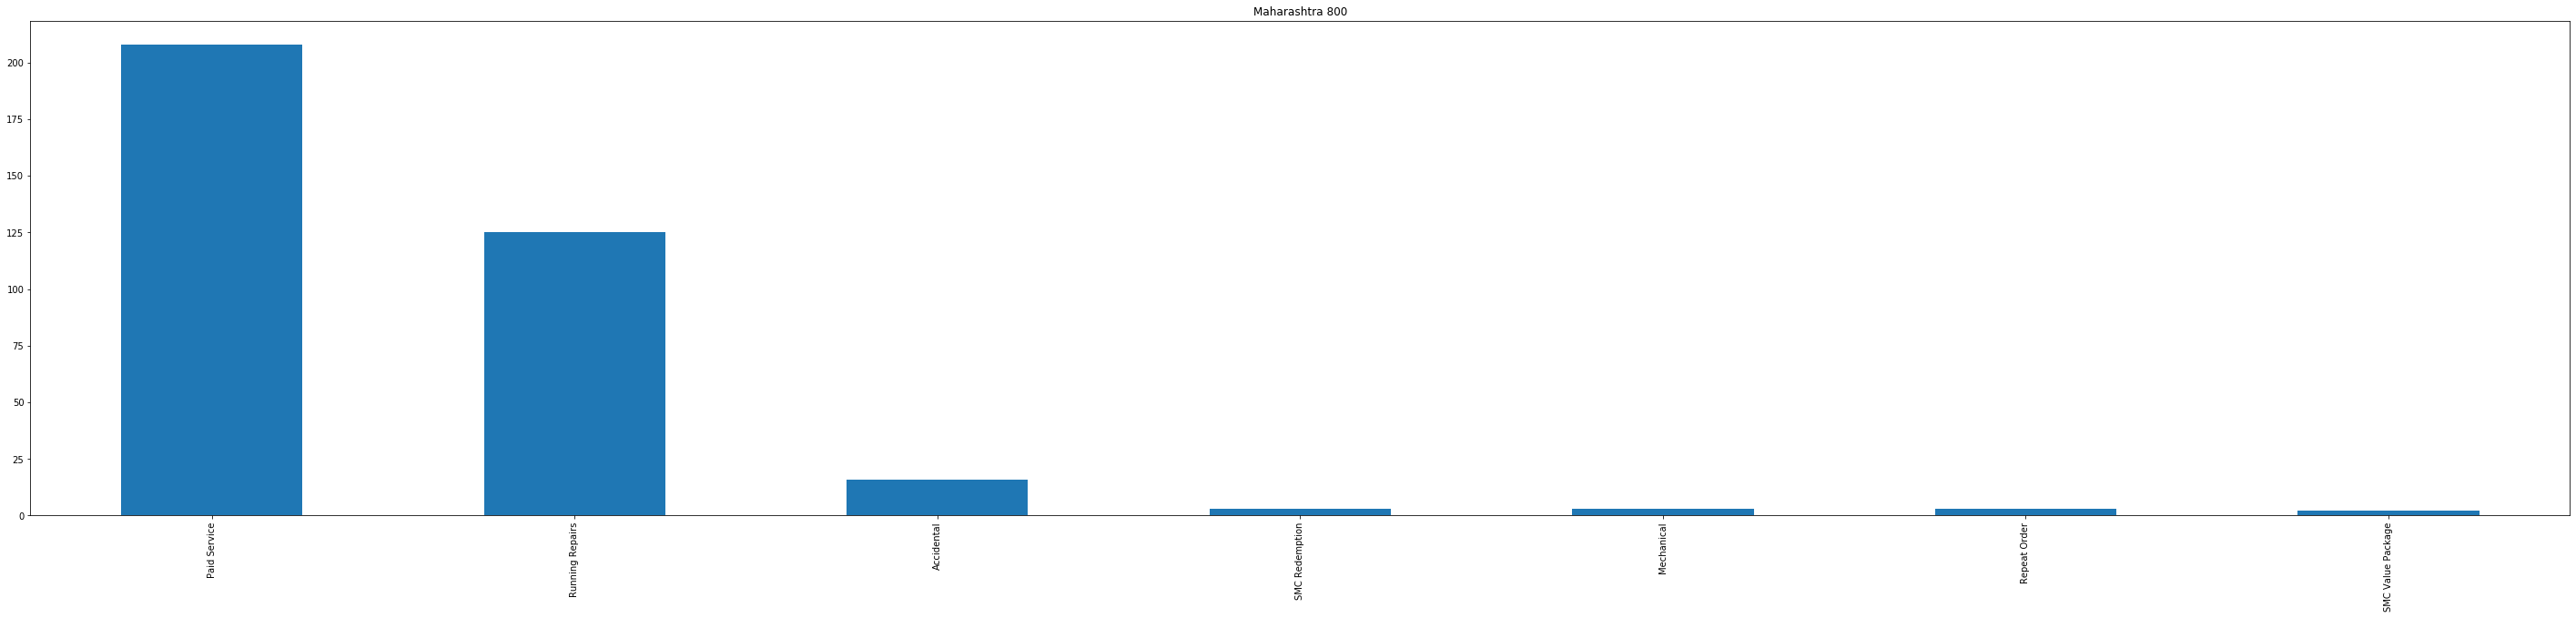

INNOVA


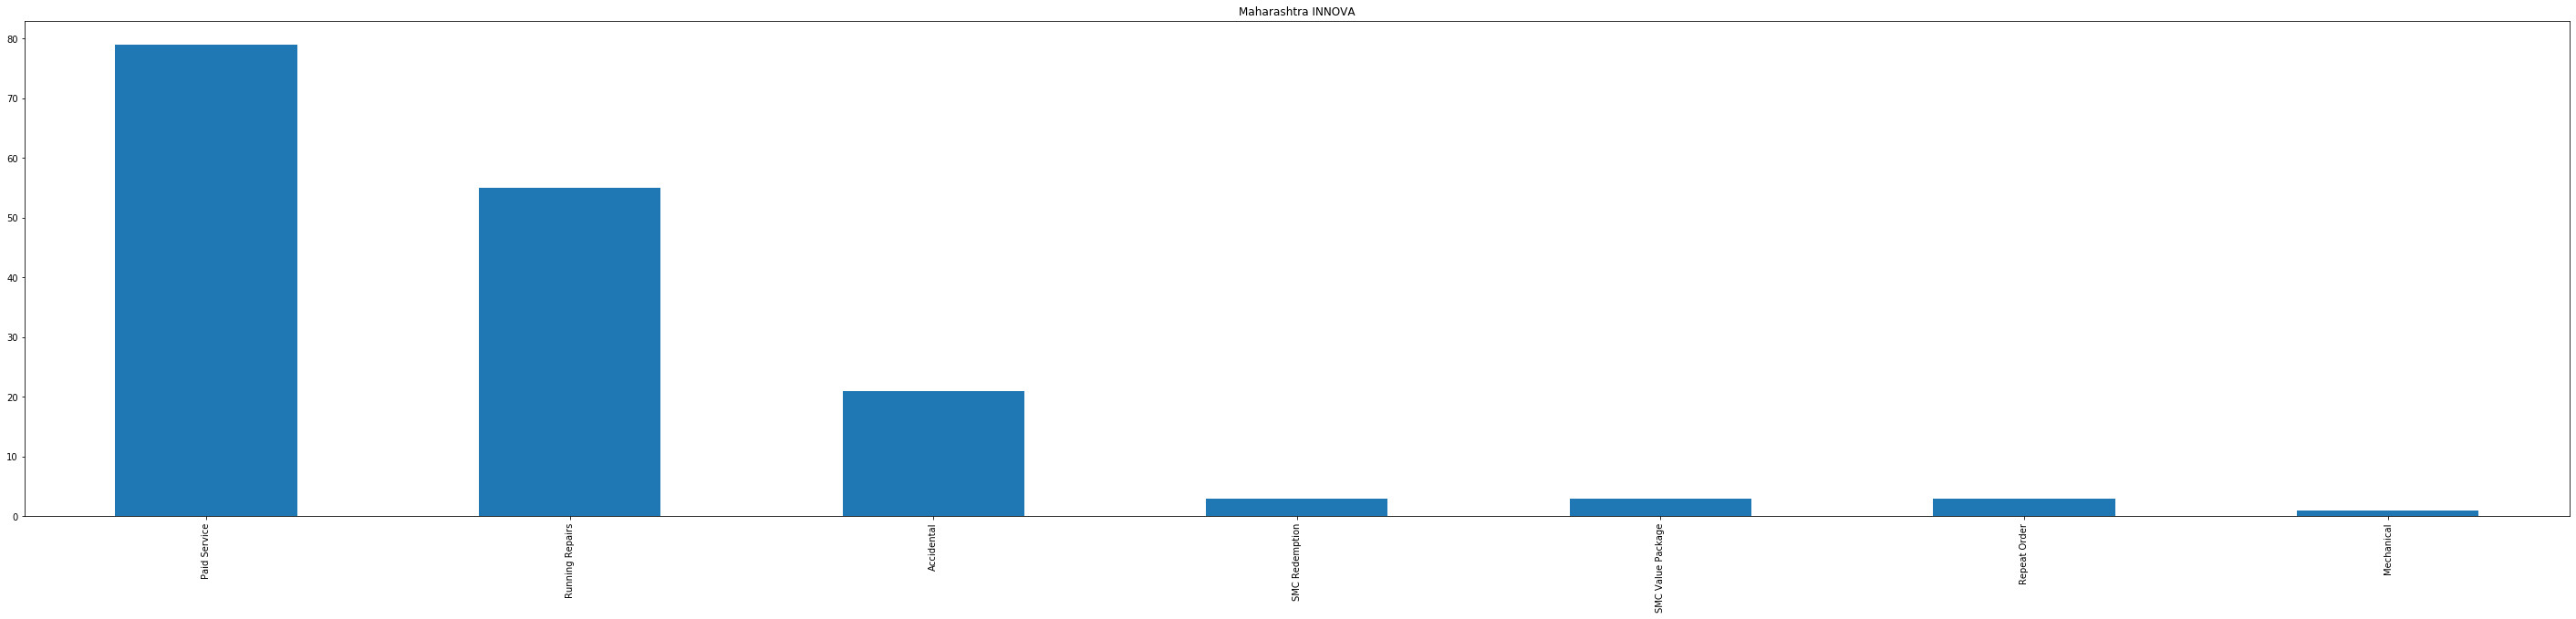

TAVERA


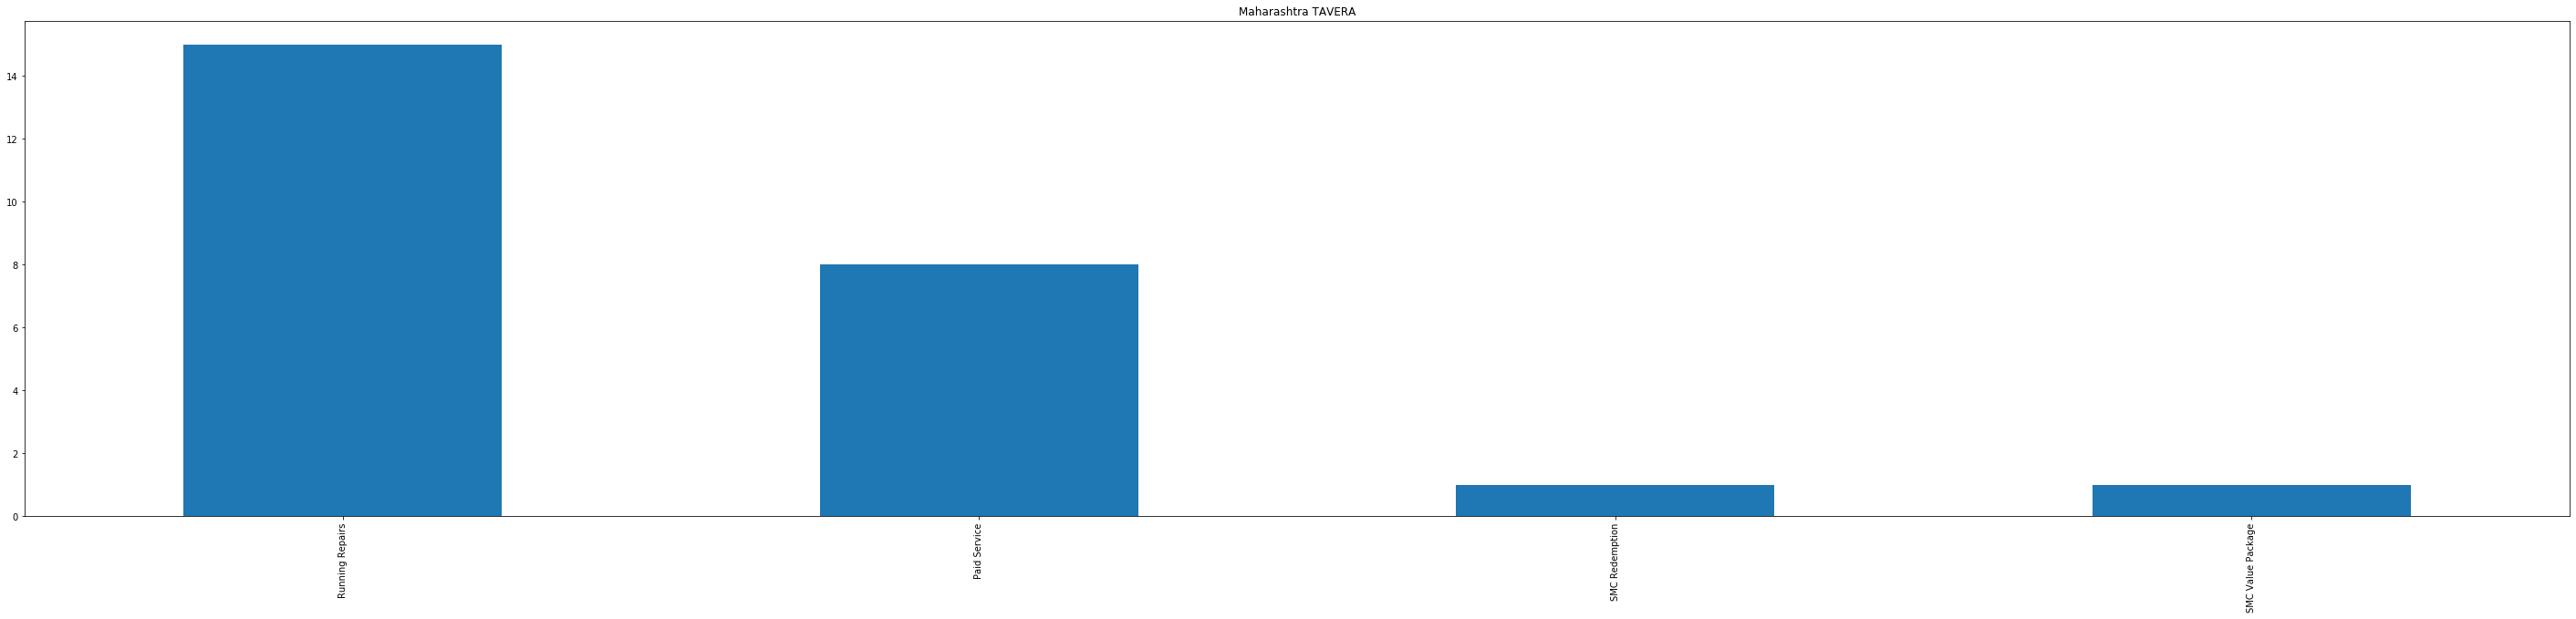

ALTO


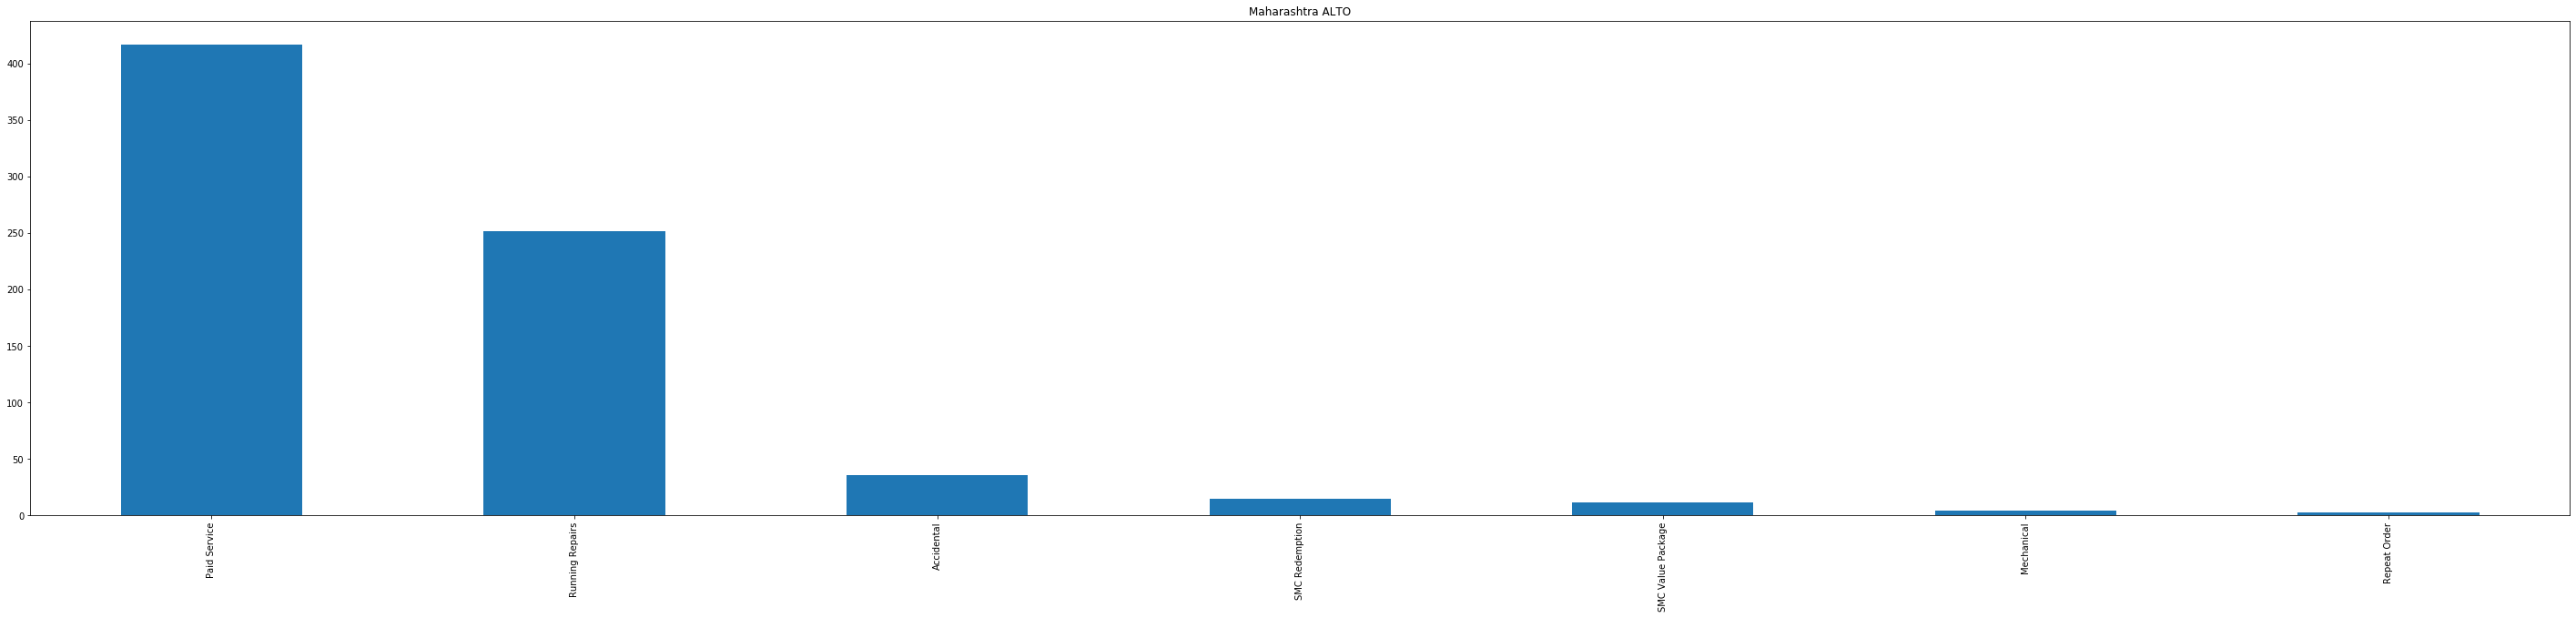

CITY


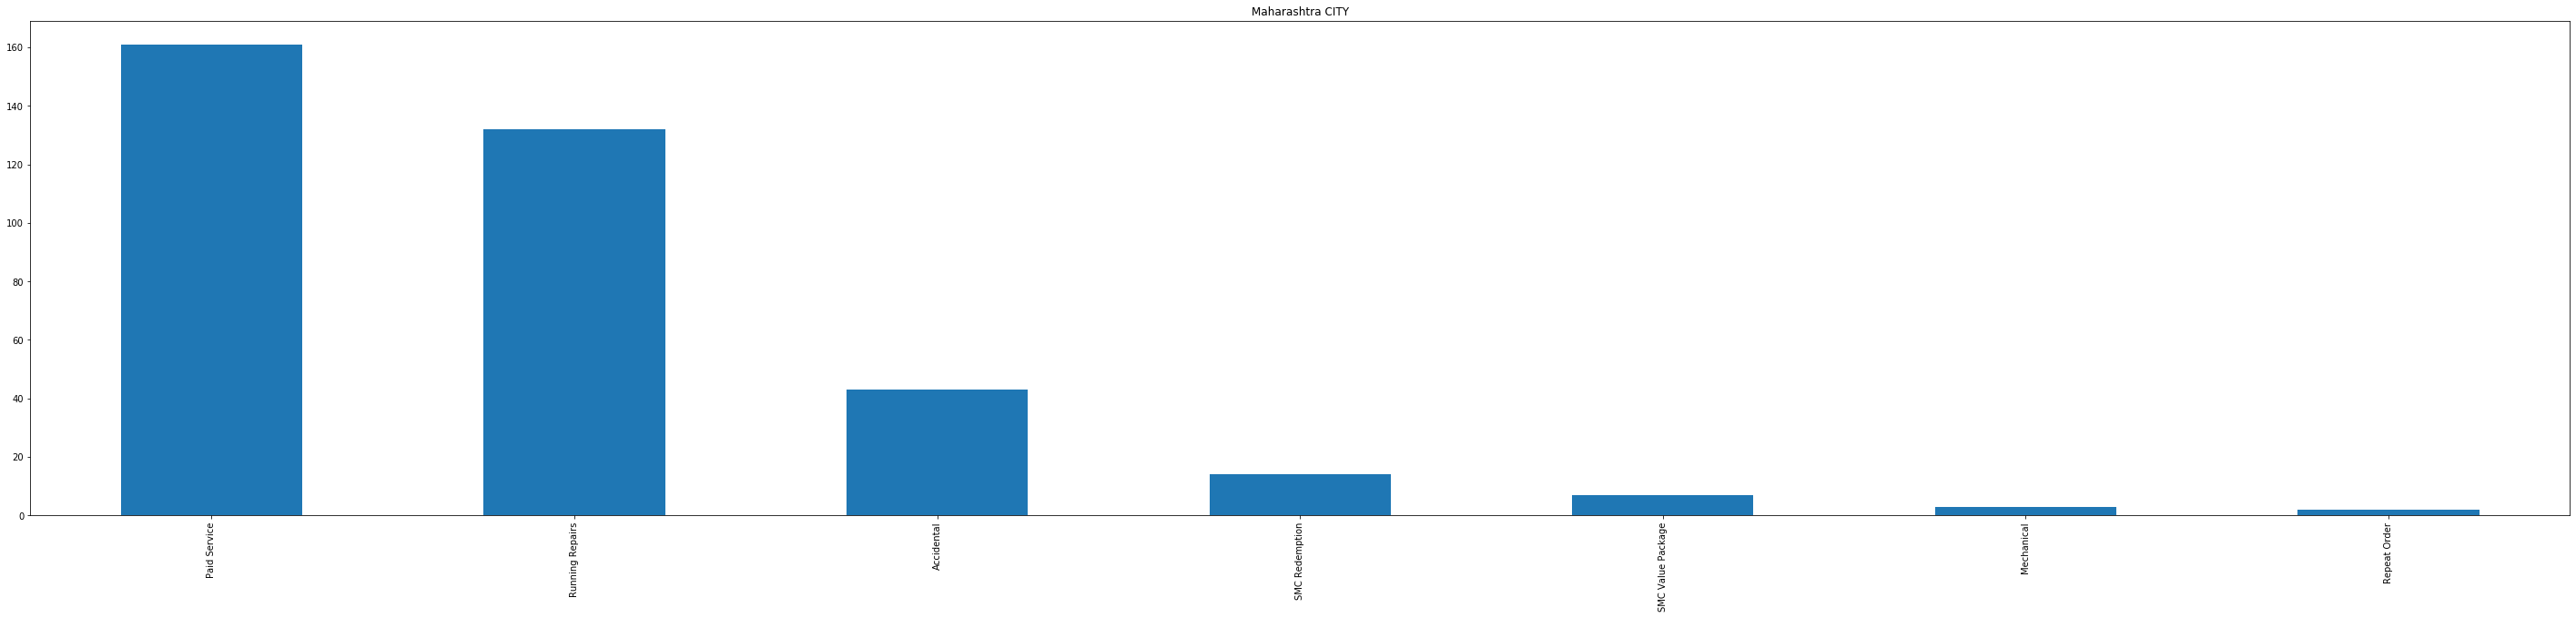

SX4


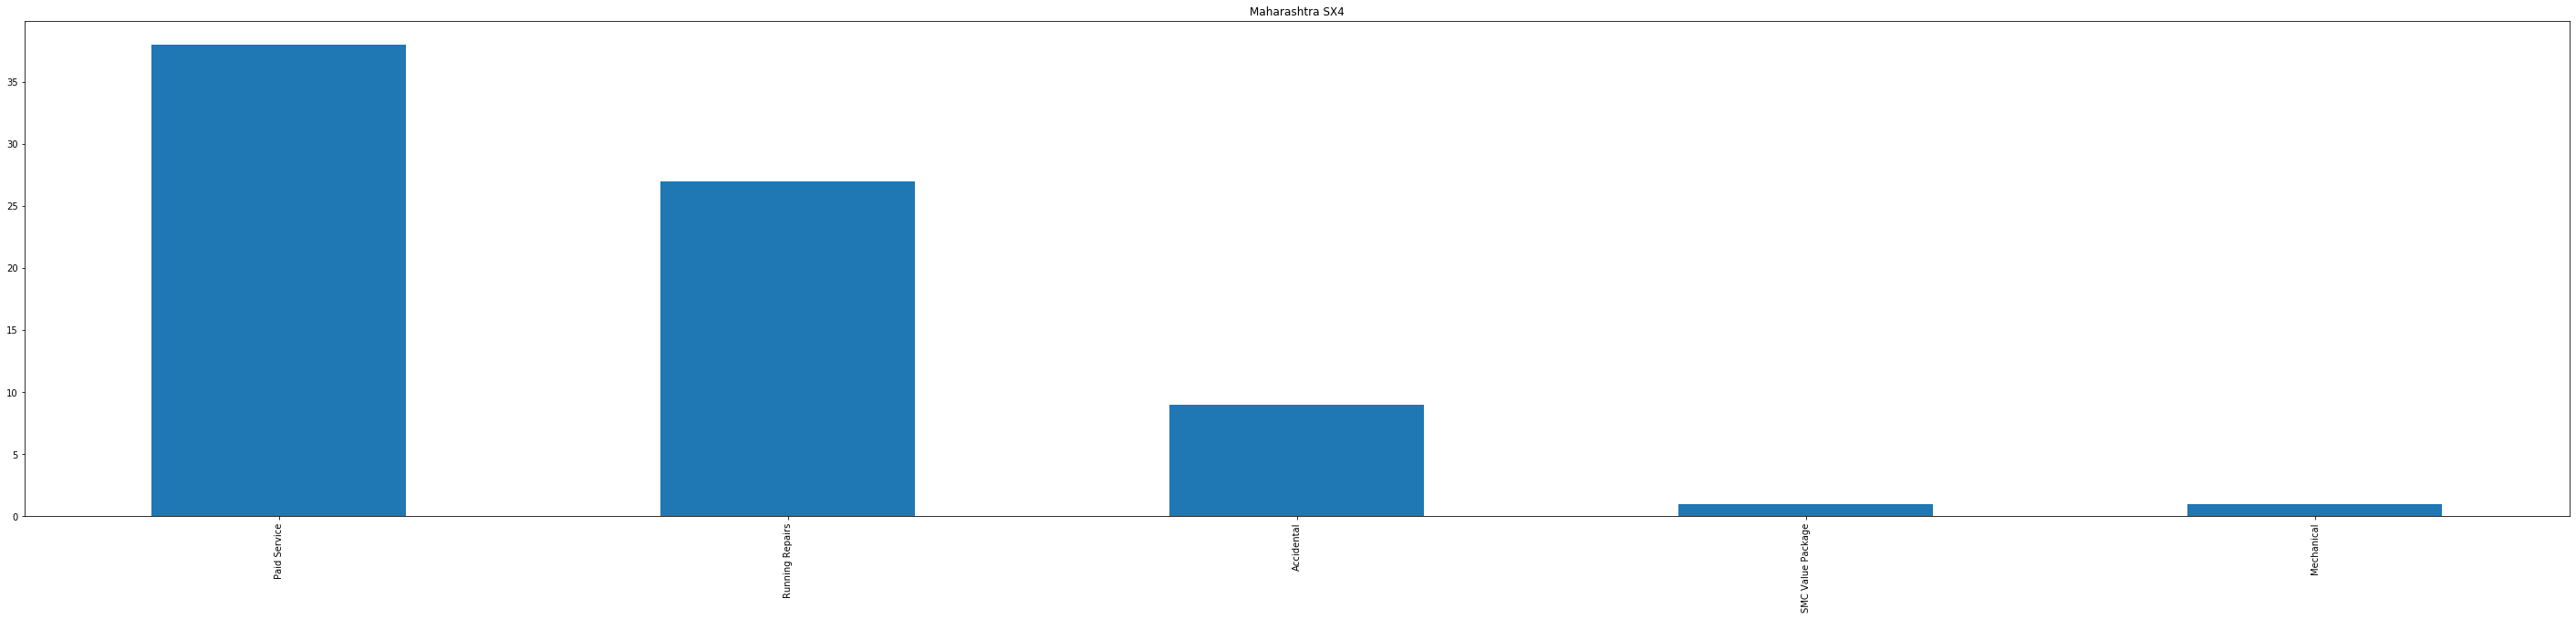

MICRA


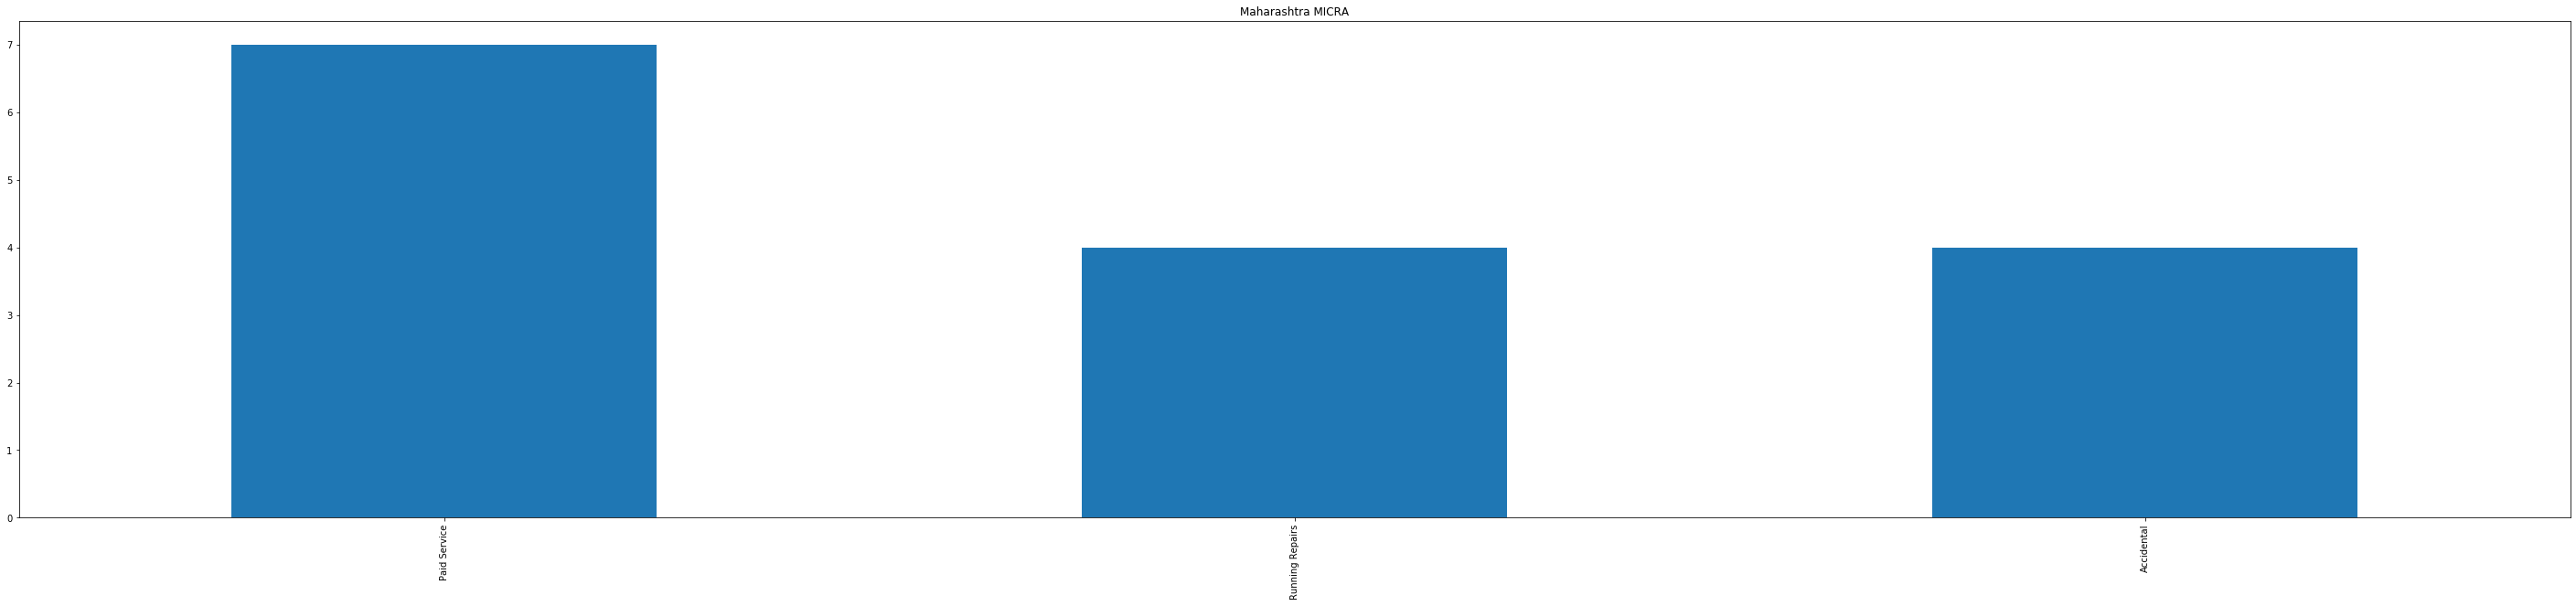

ESTEEM 1000


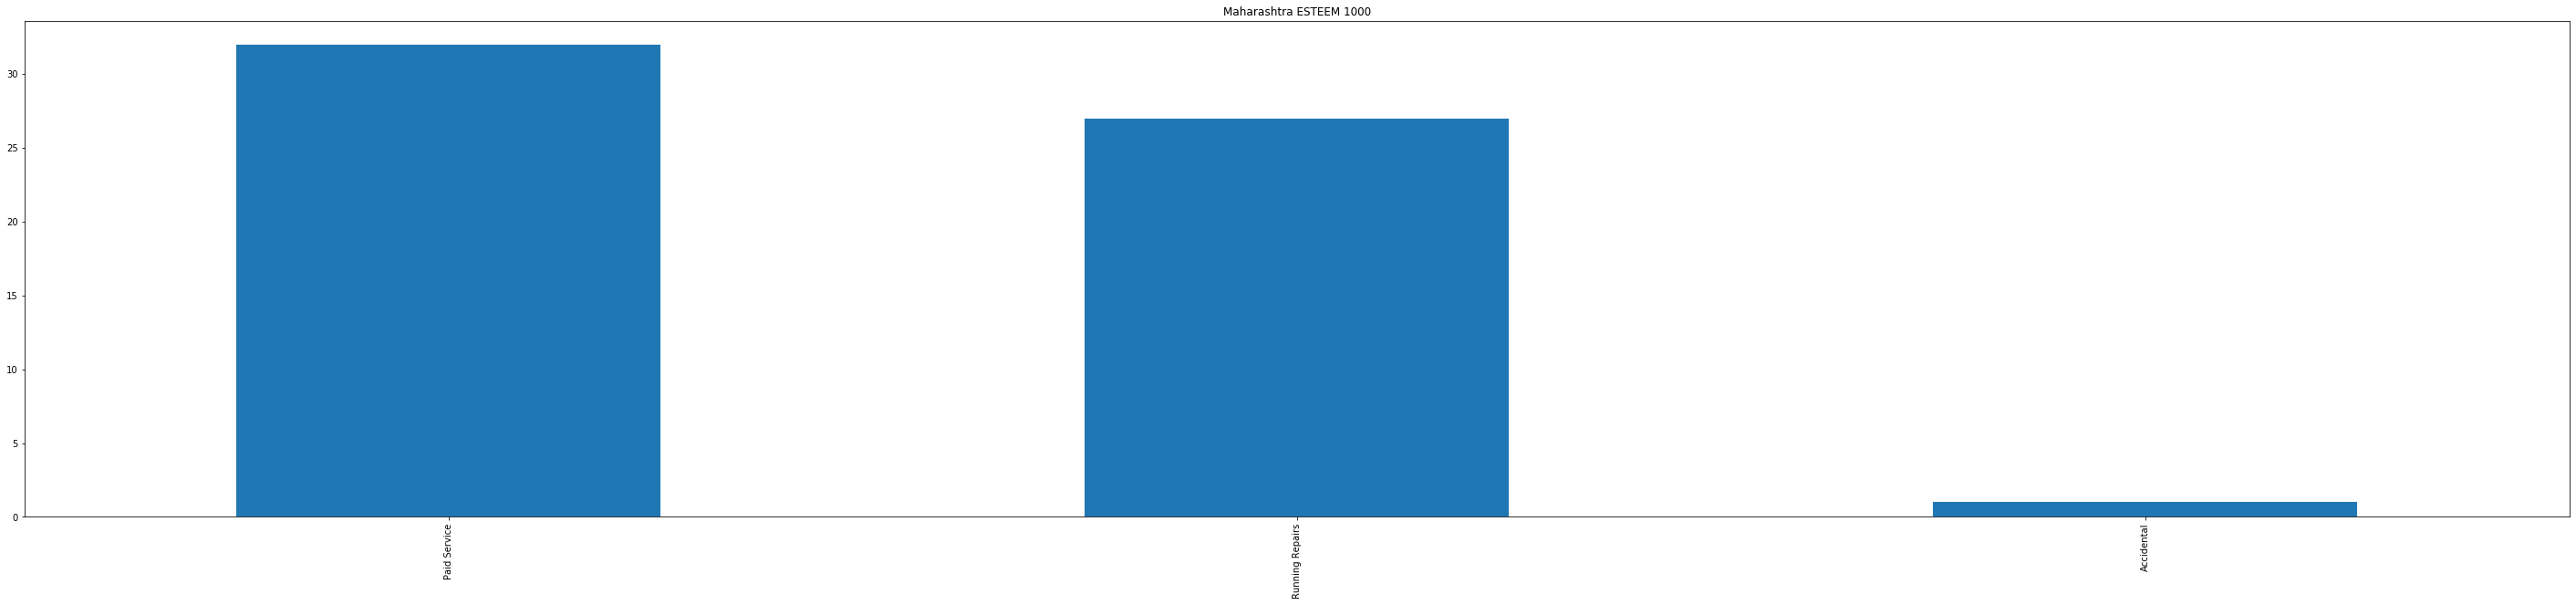

WAGONR


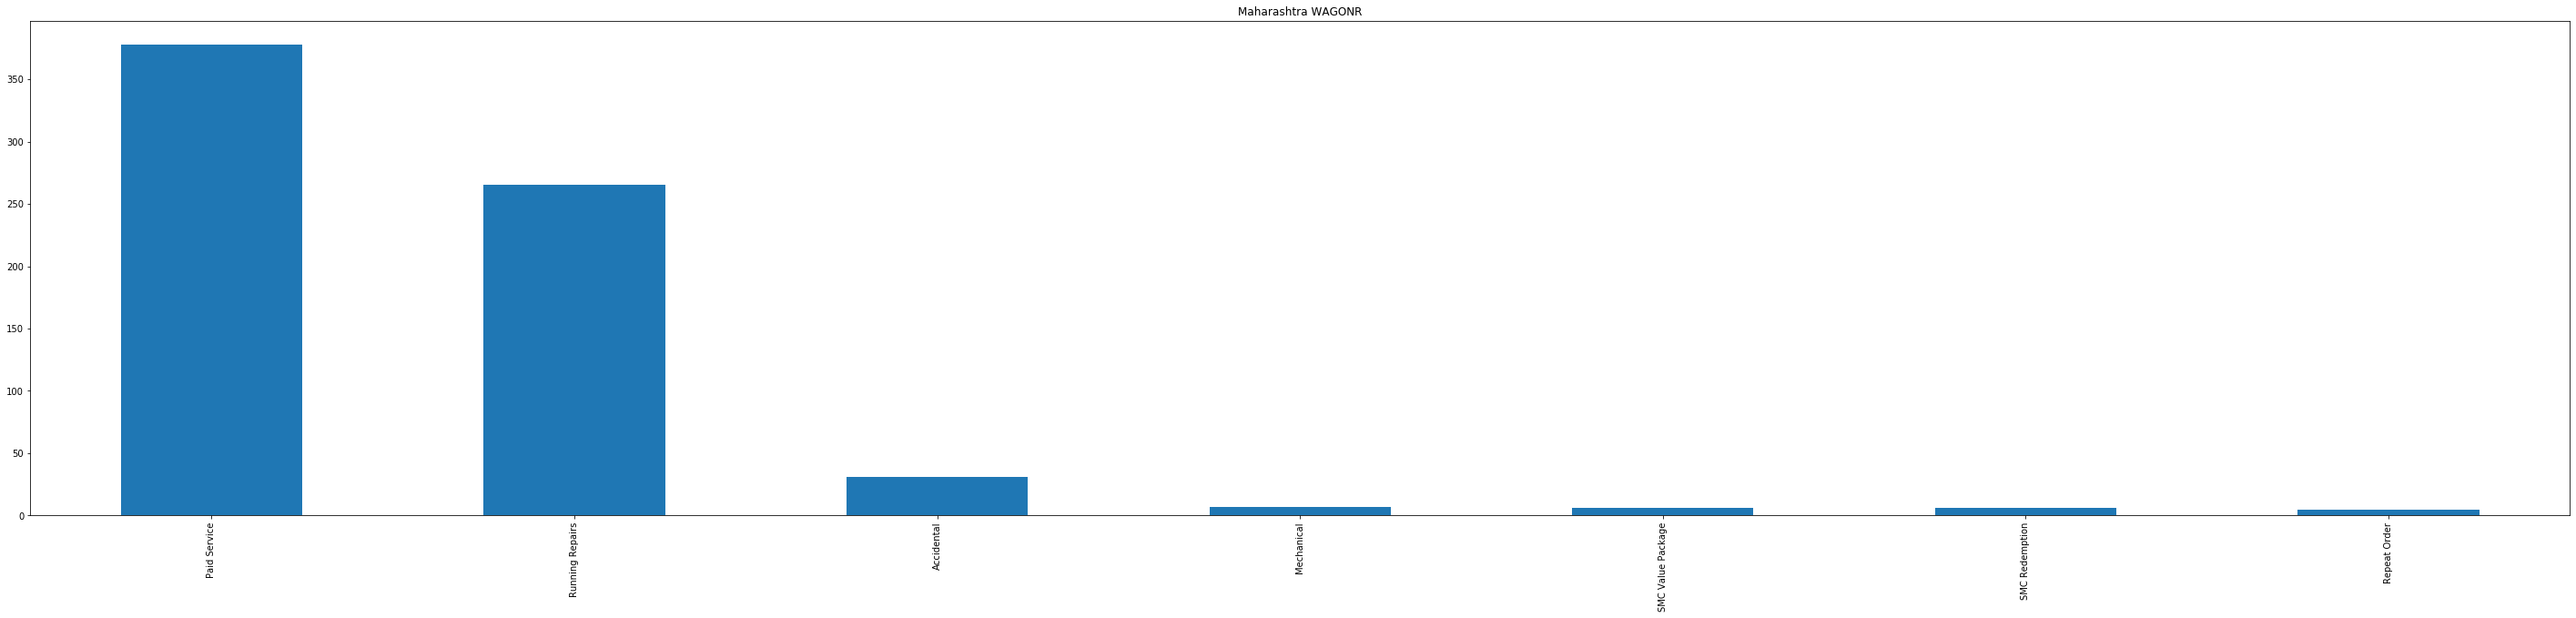

OMNI


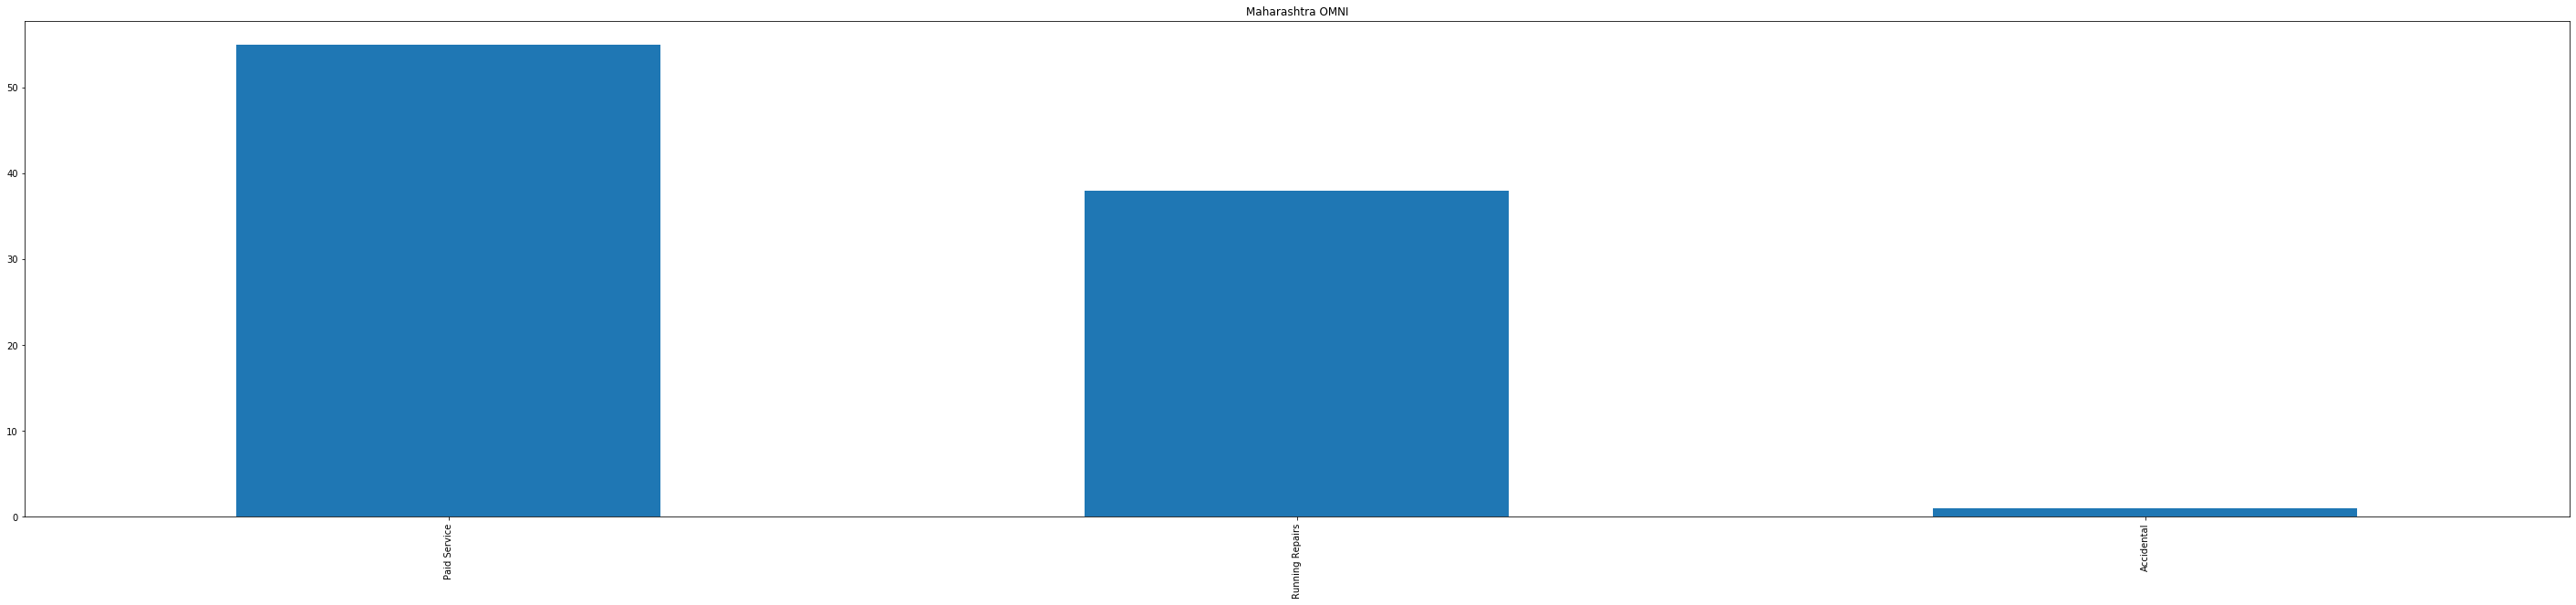

RAPID


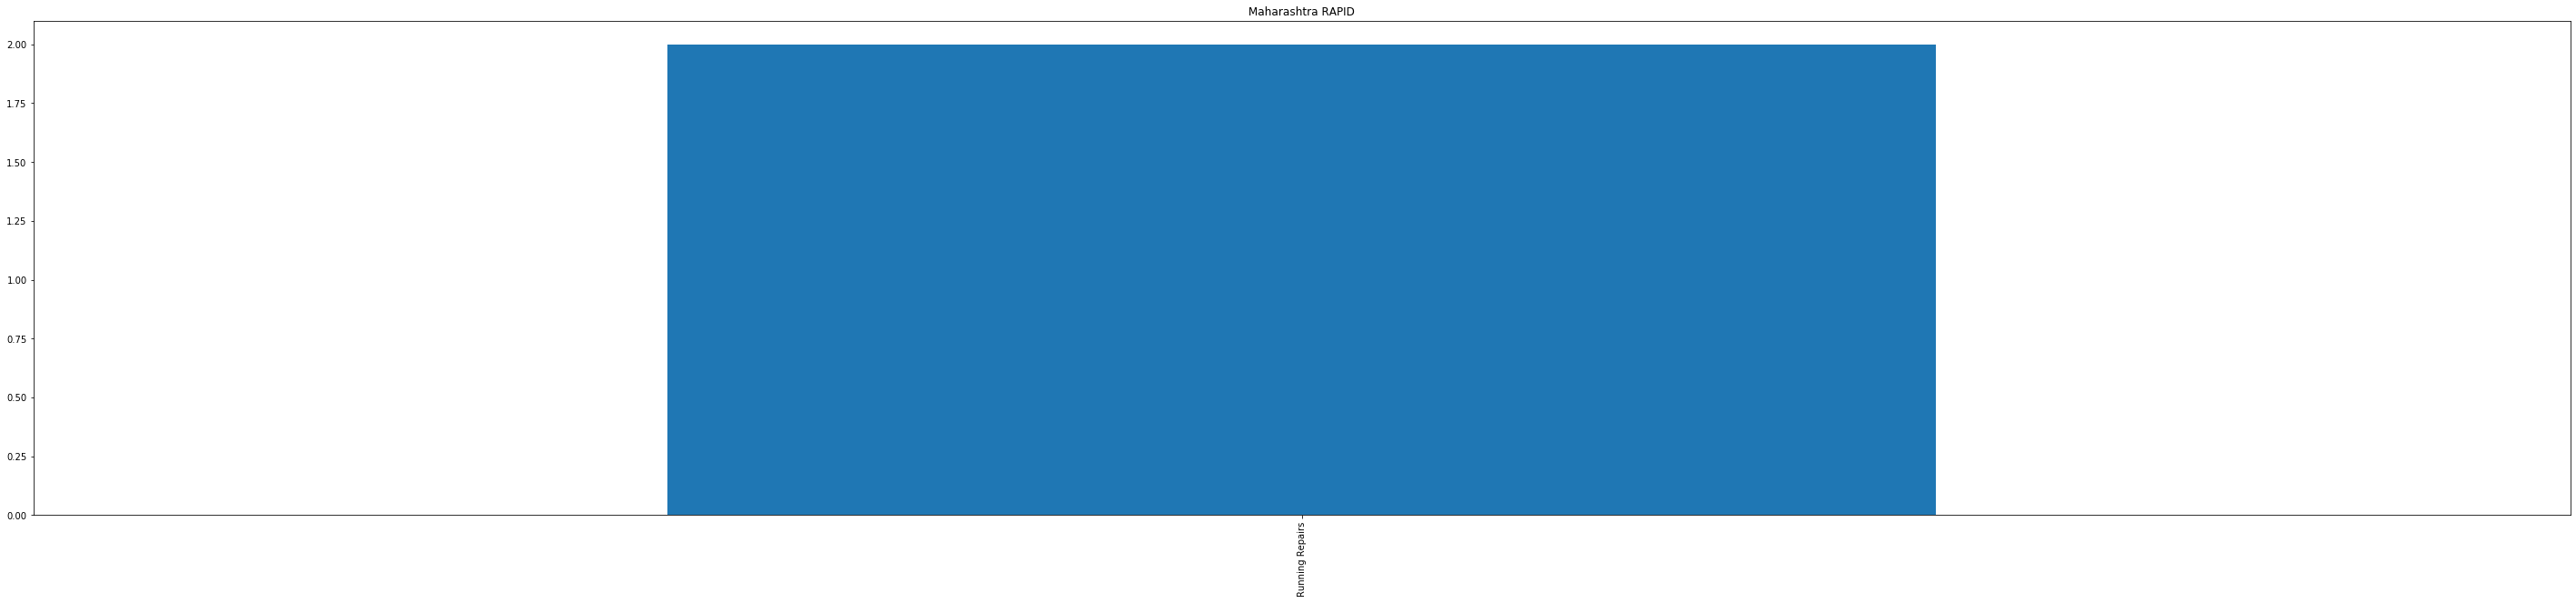

VERNA


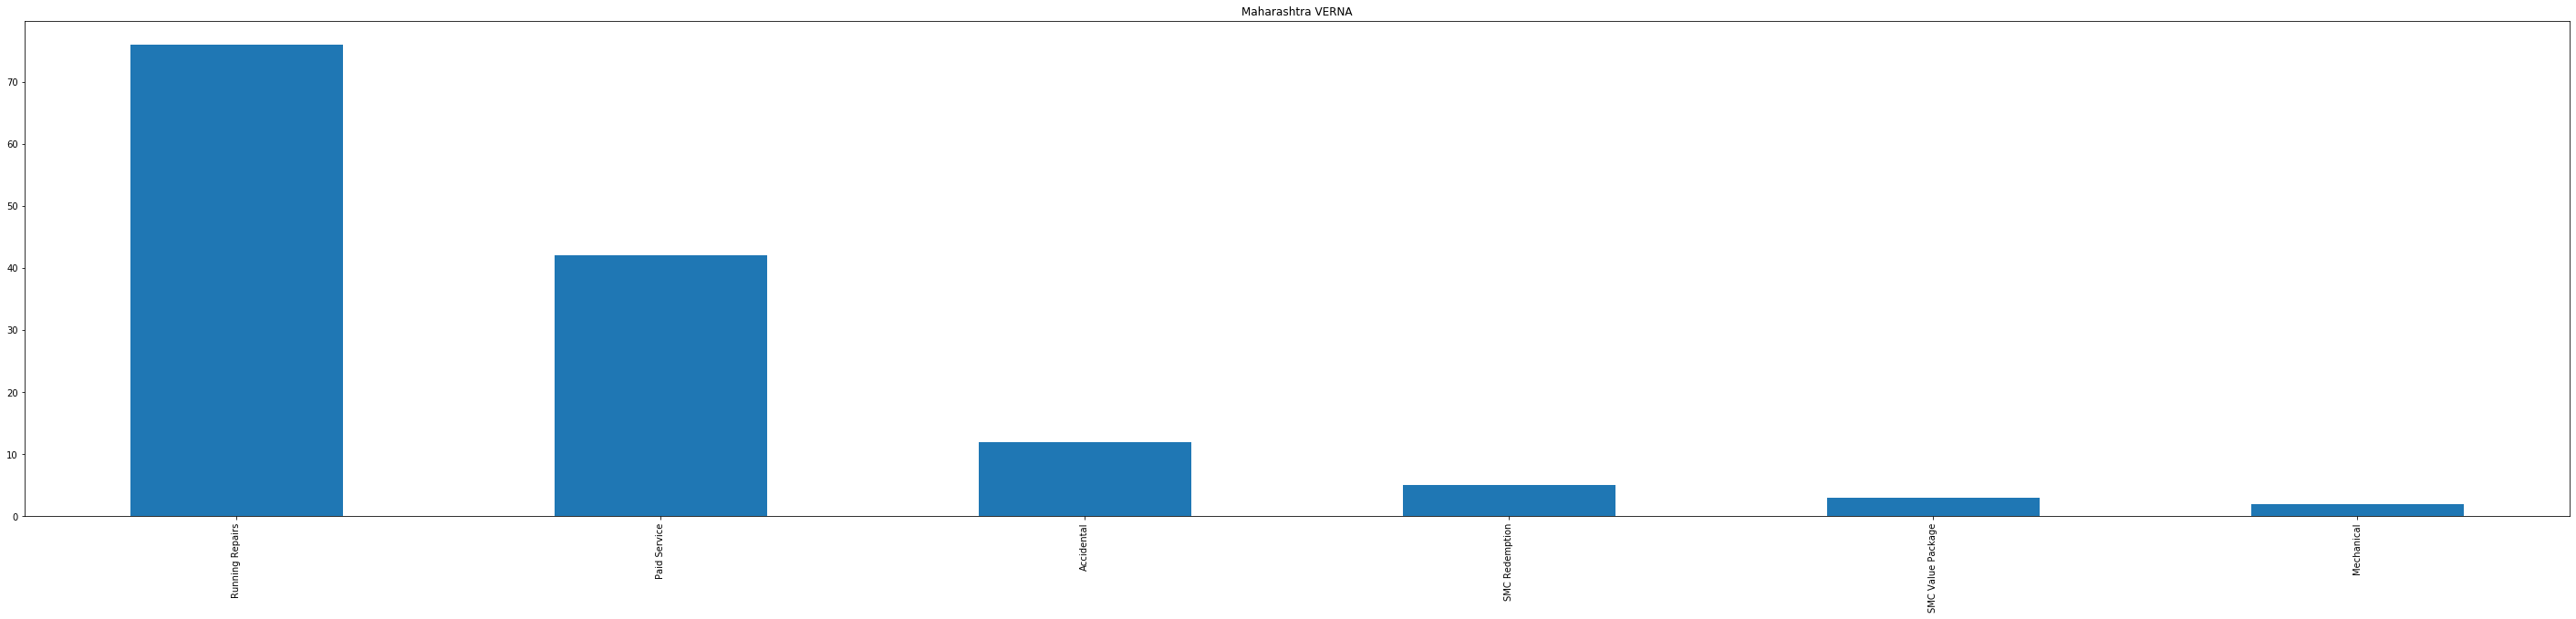

ZEN ESTILO


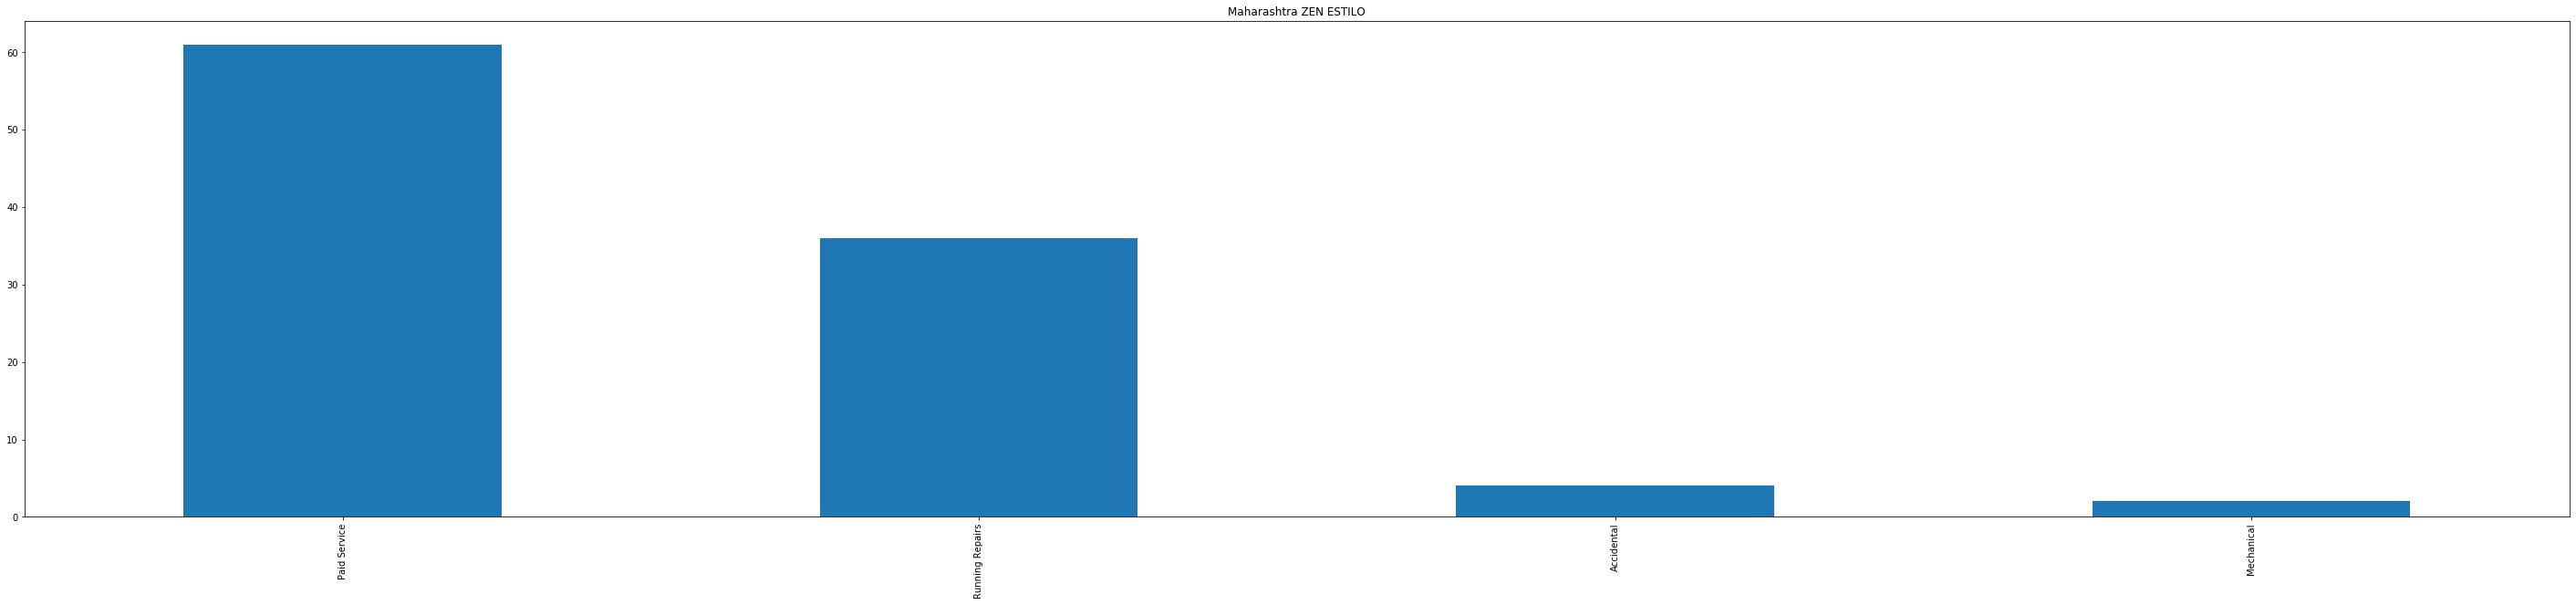

INDIGO


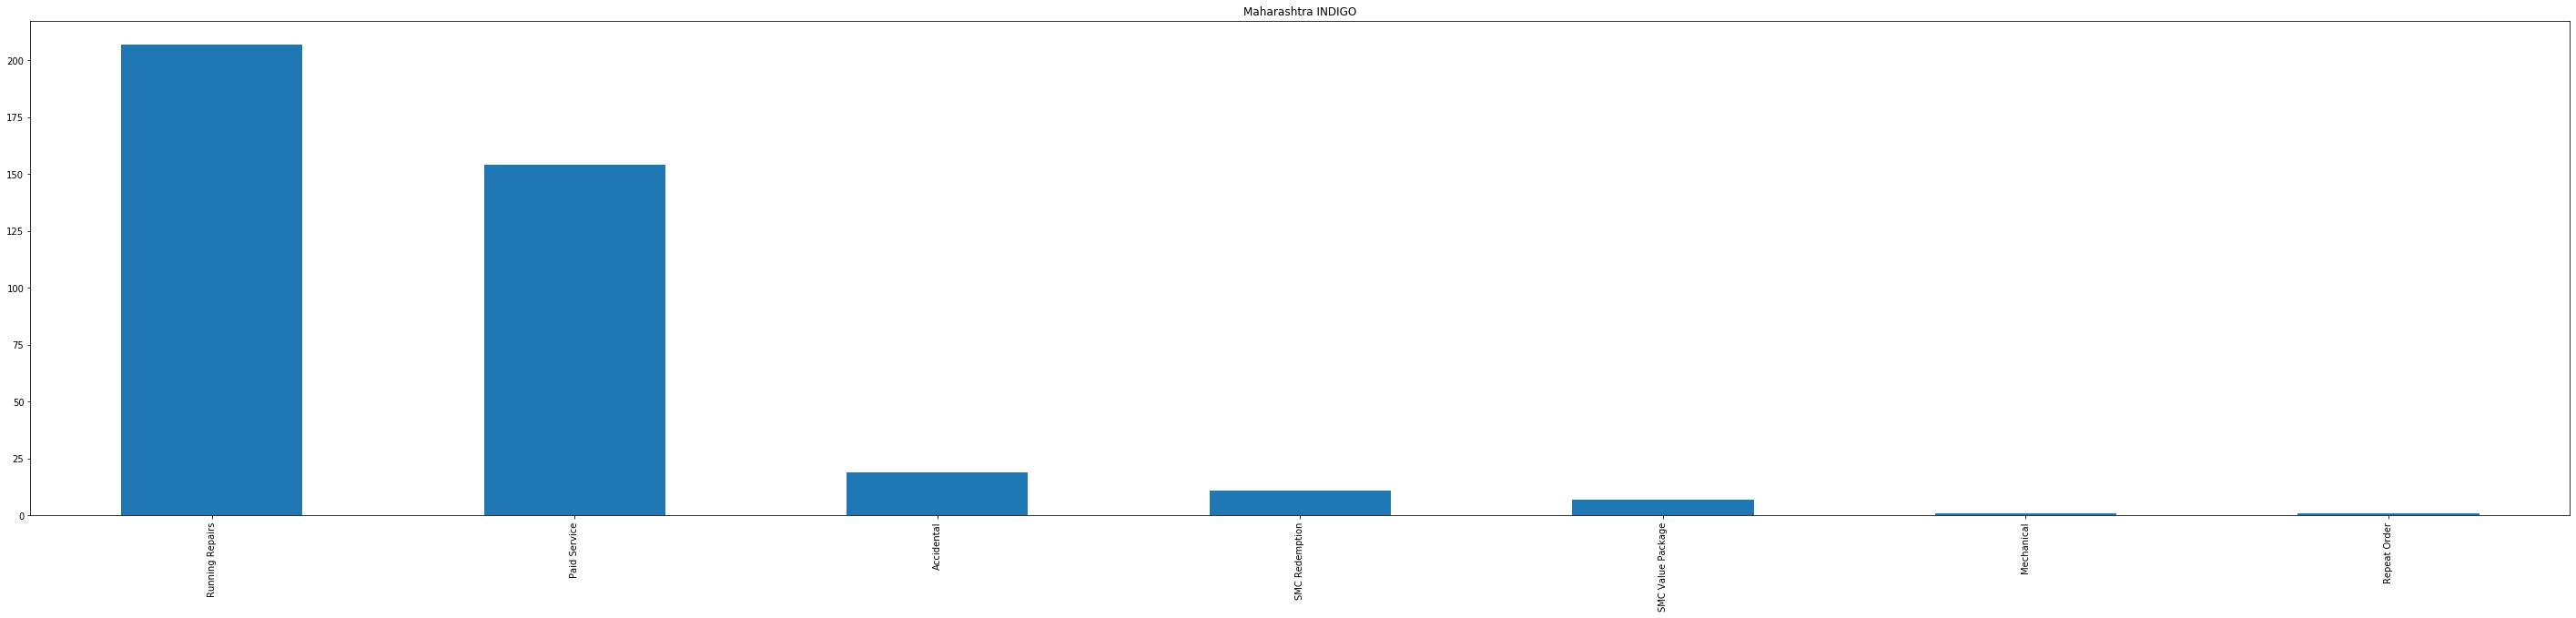

AVEO UV-A


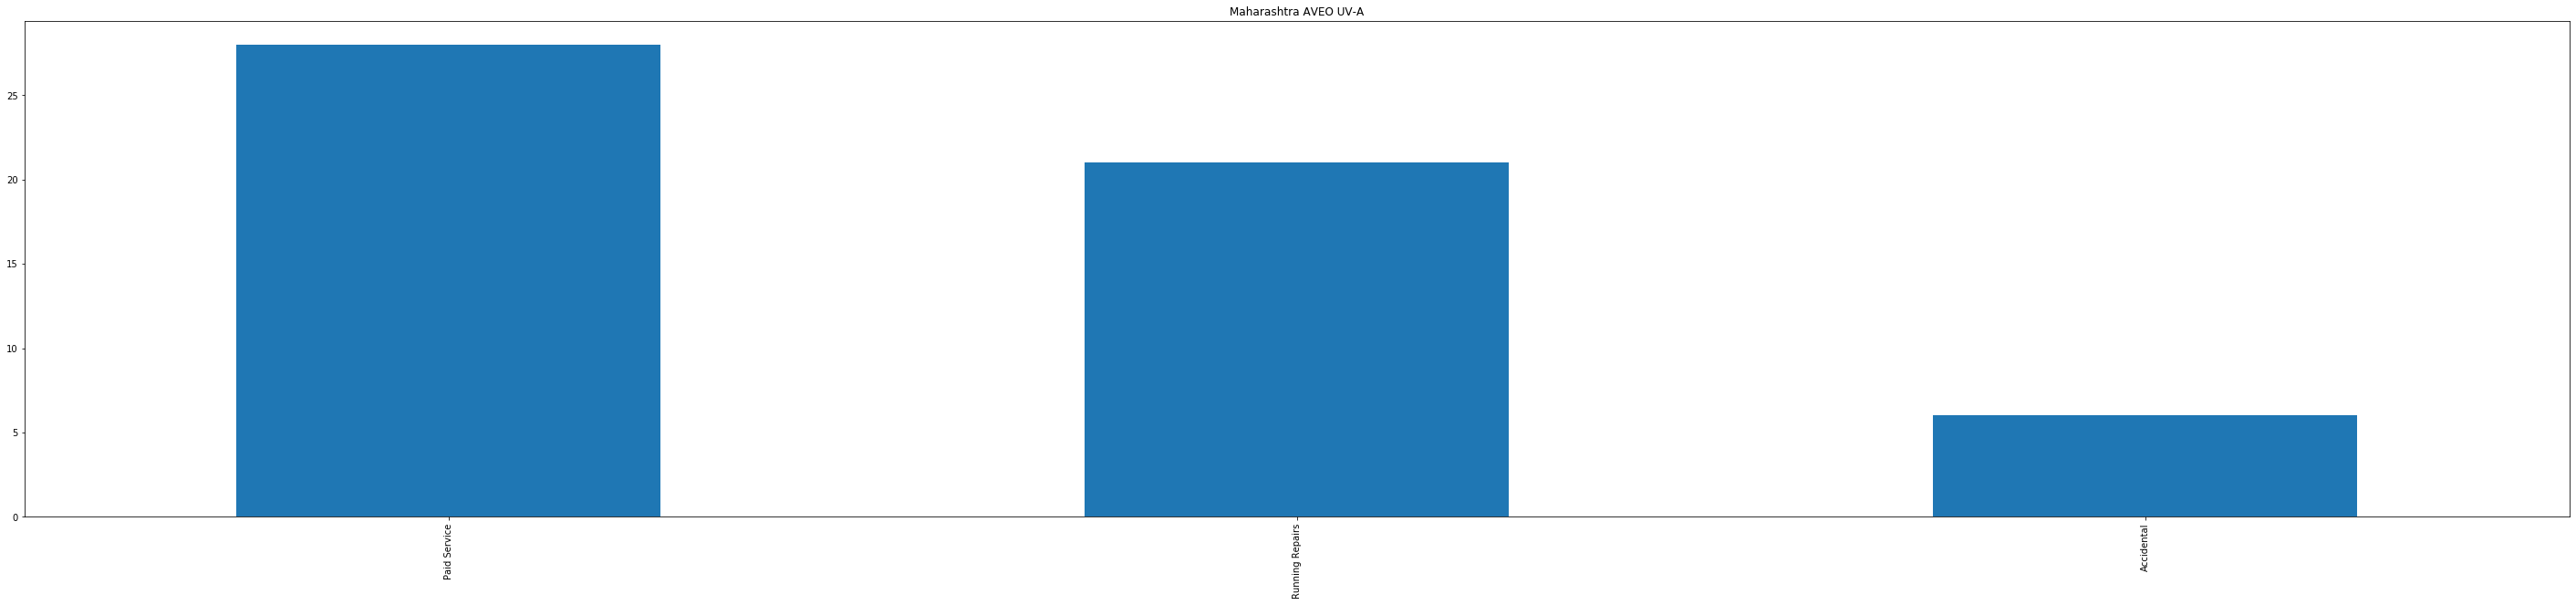

POLO


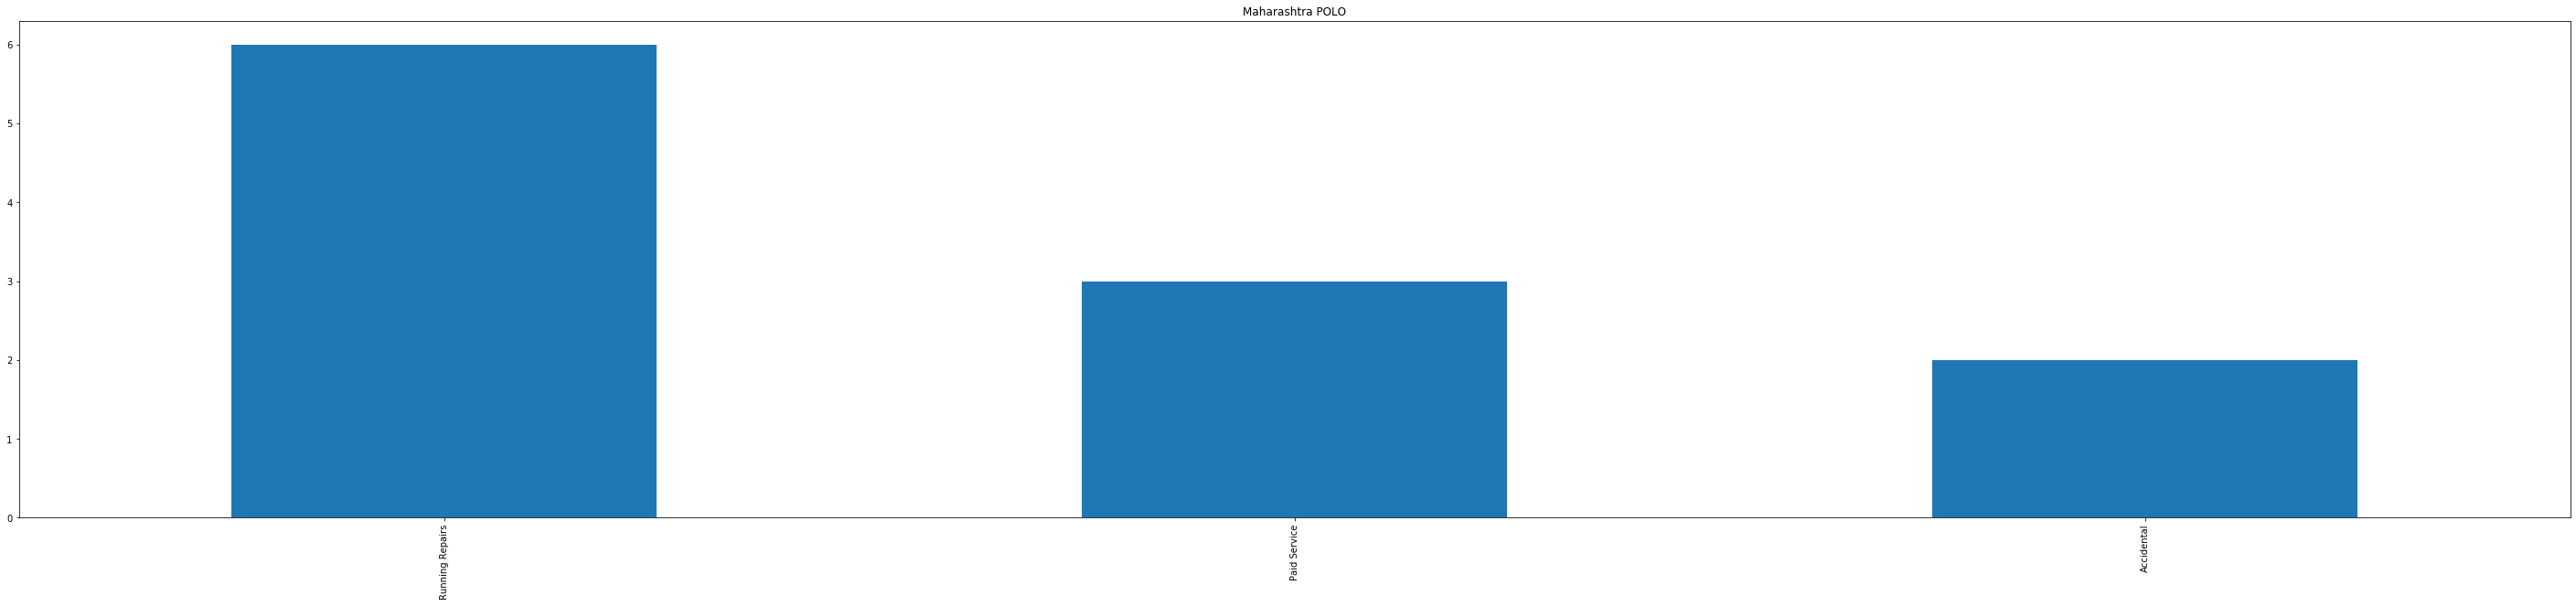

SWIFT


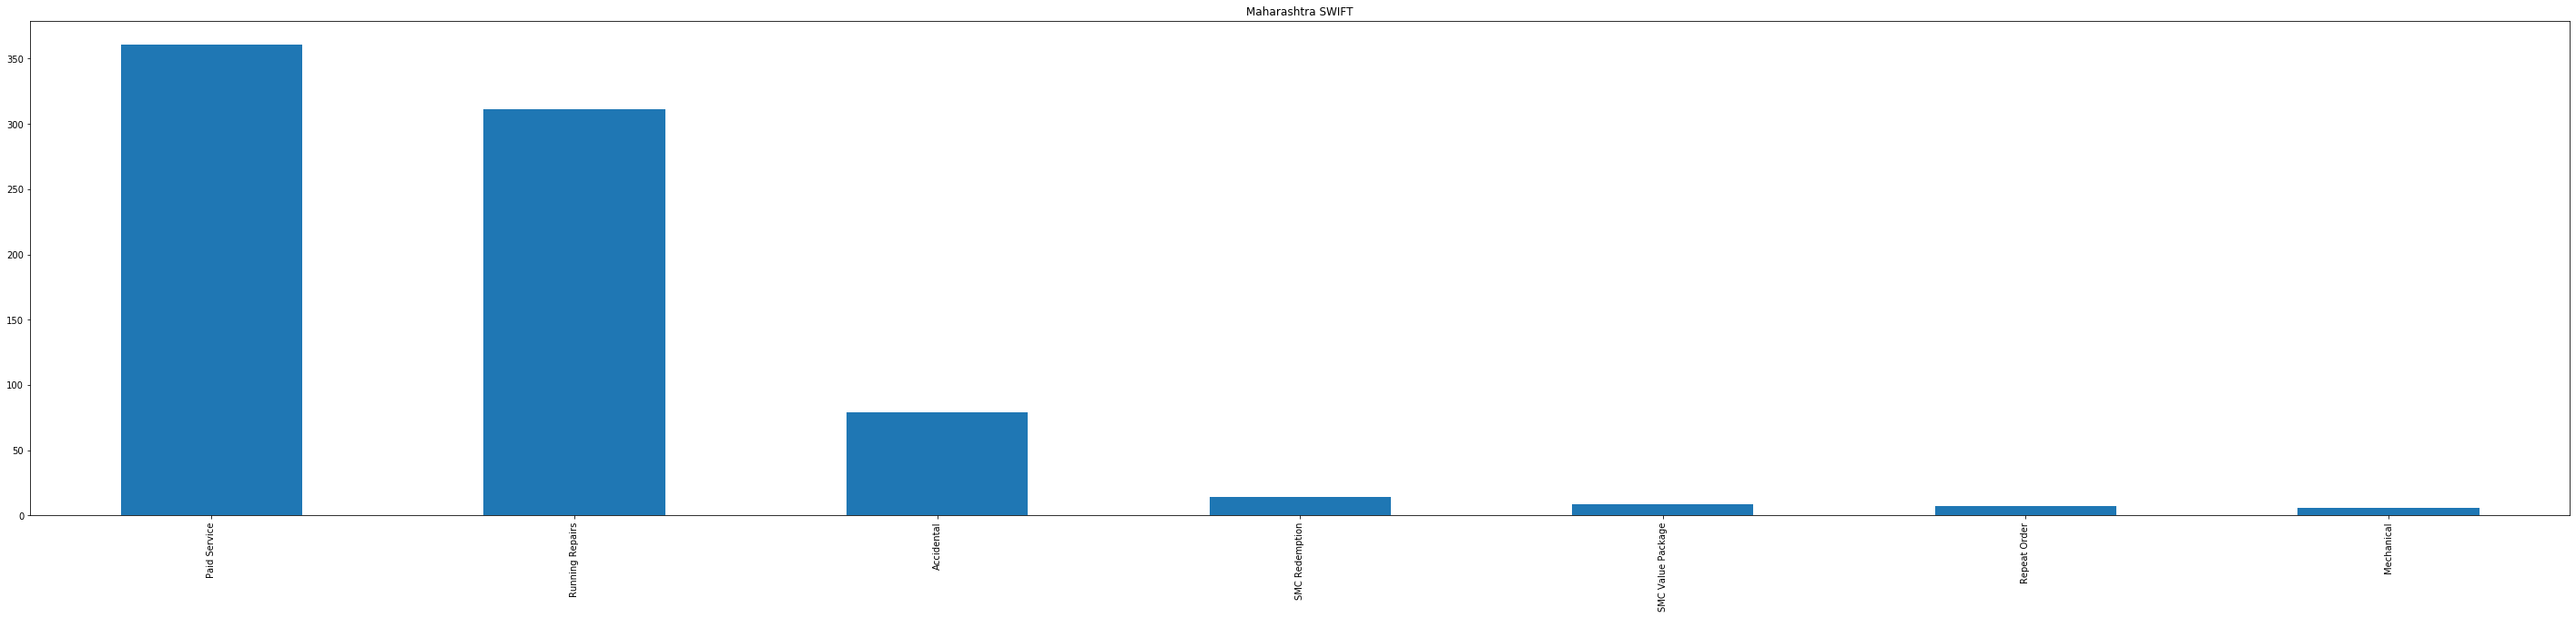

EECO


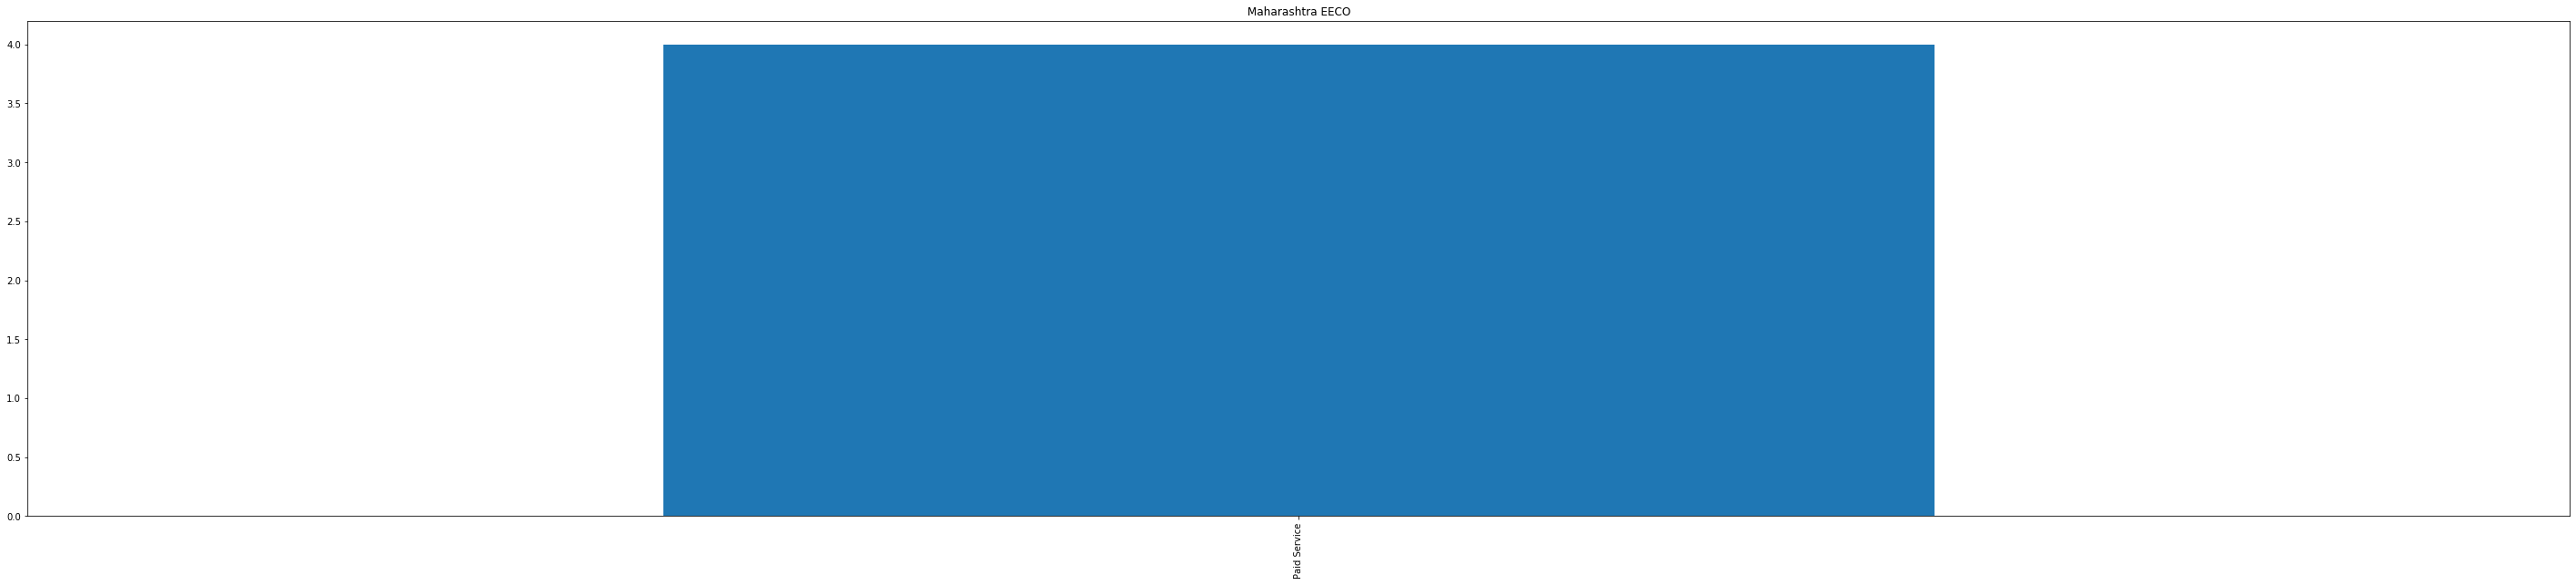

SANTRO XING


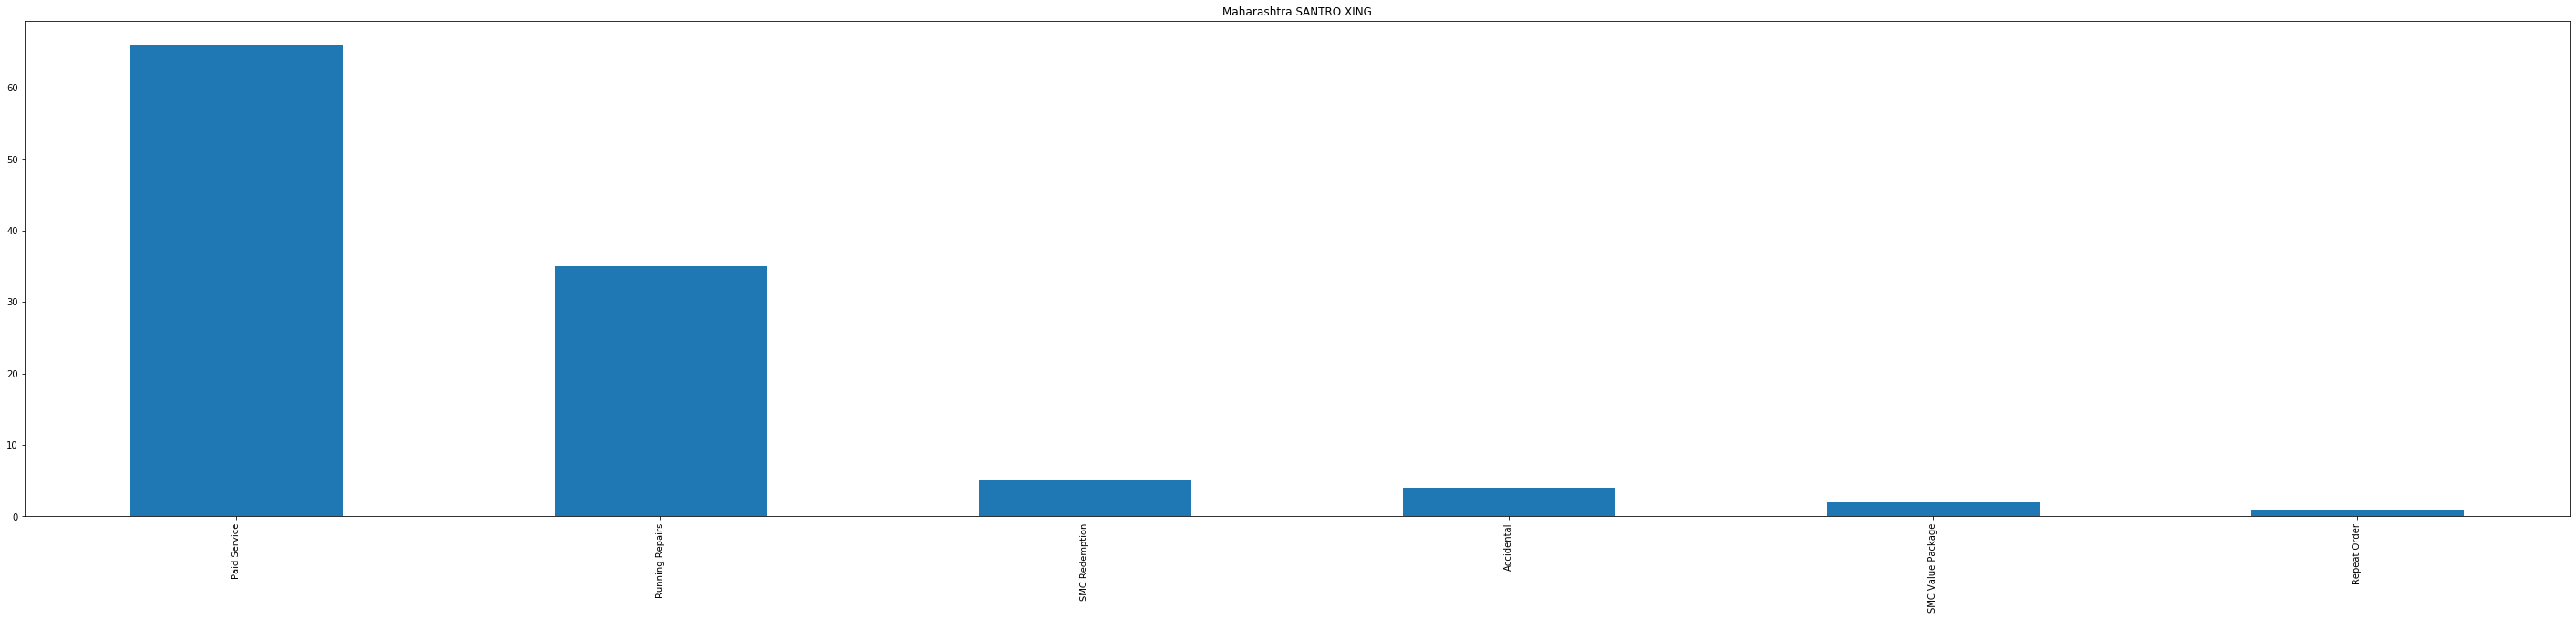

LOGAN D


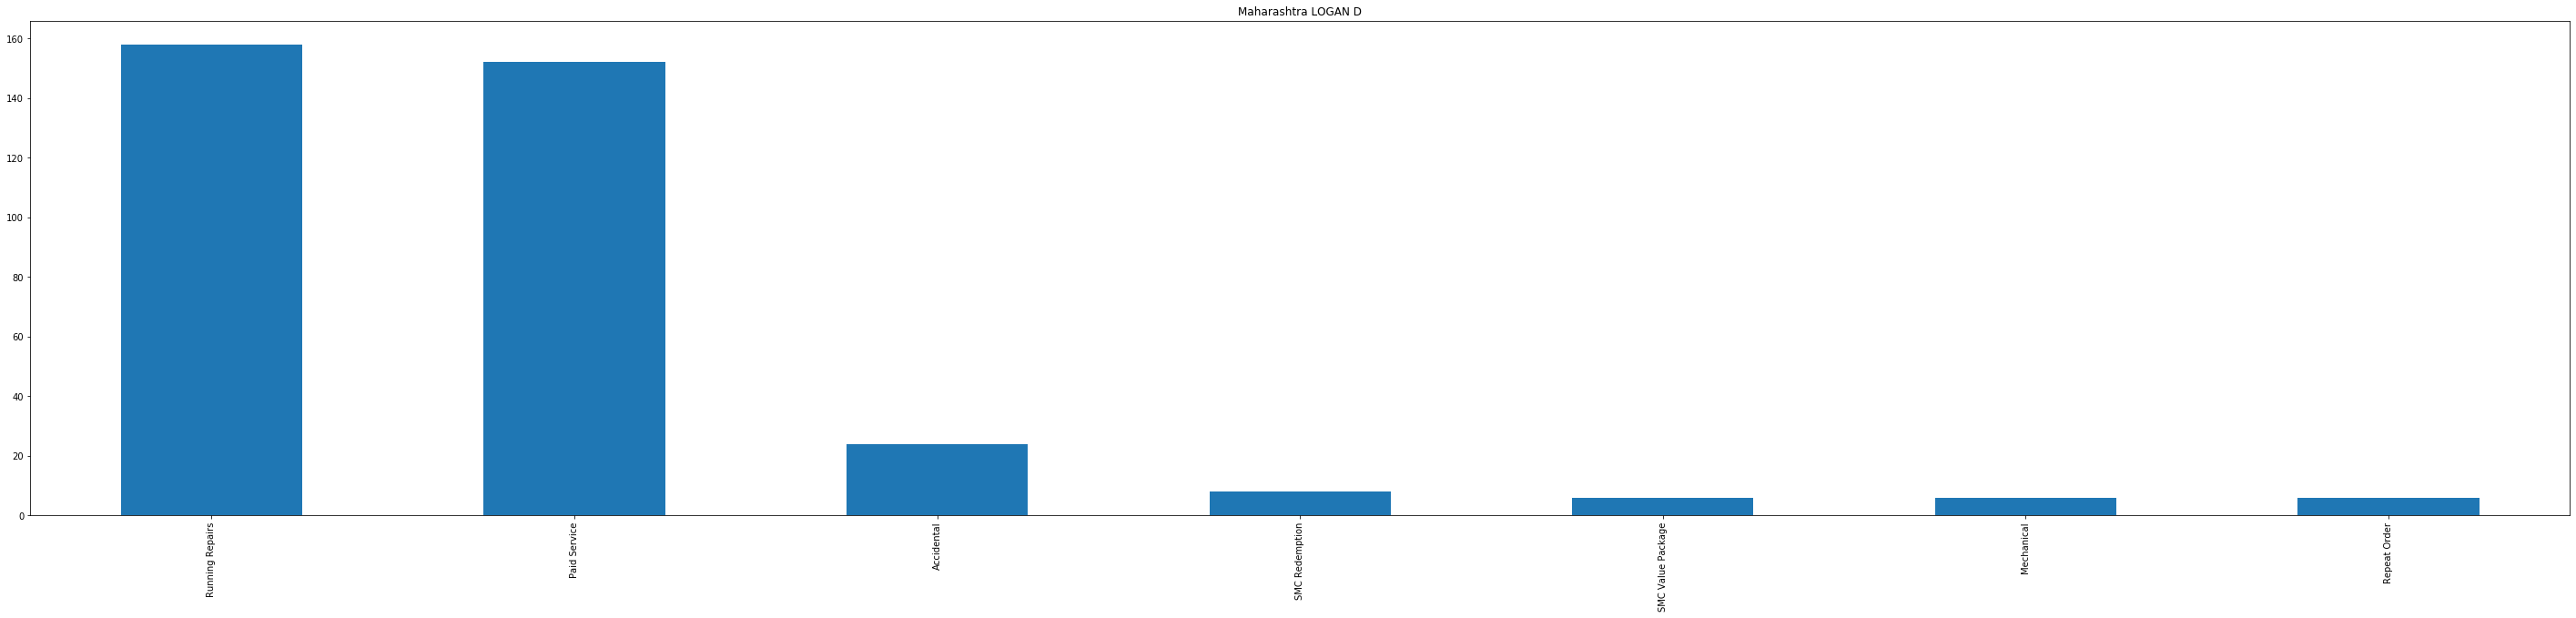

VERITO


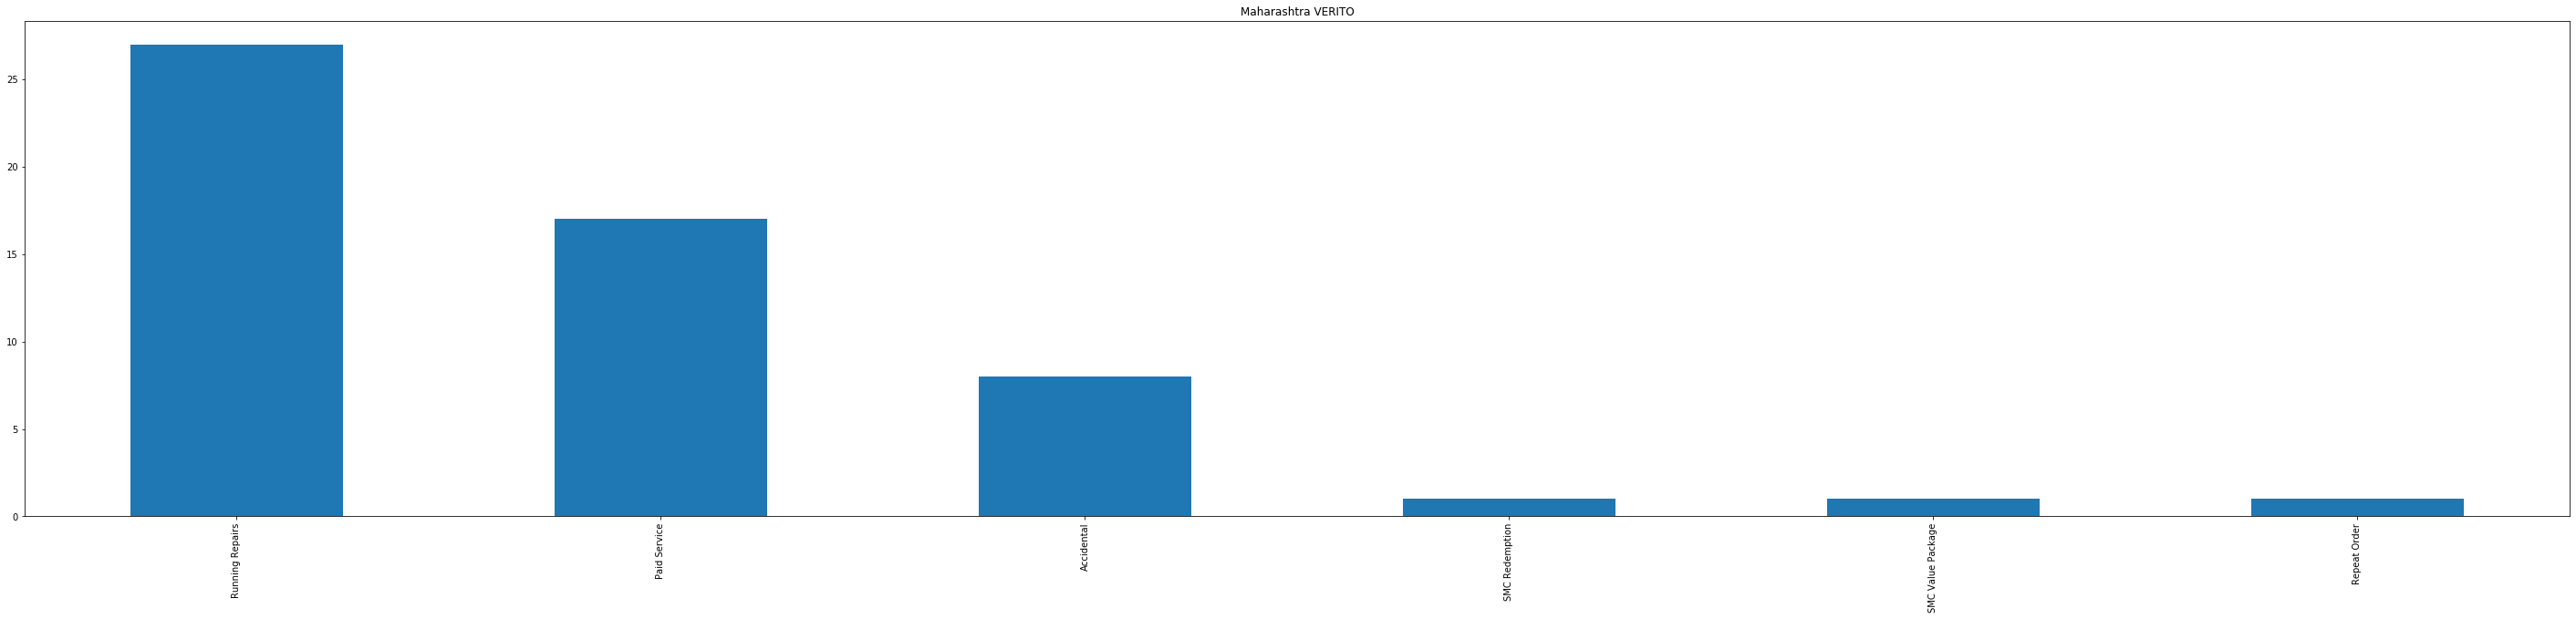

DUSTER


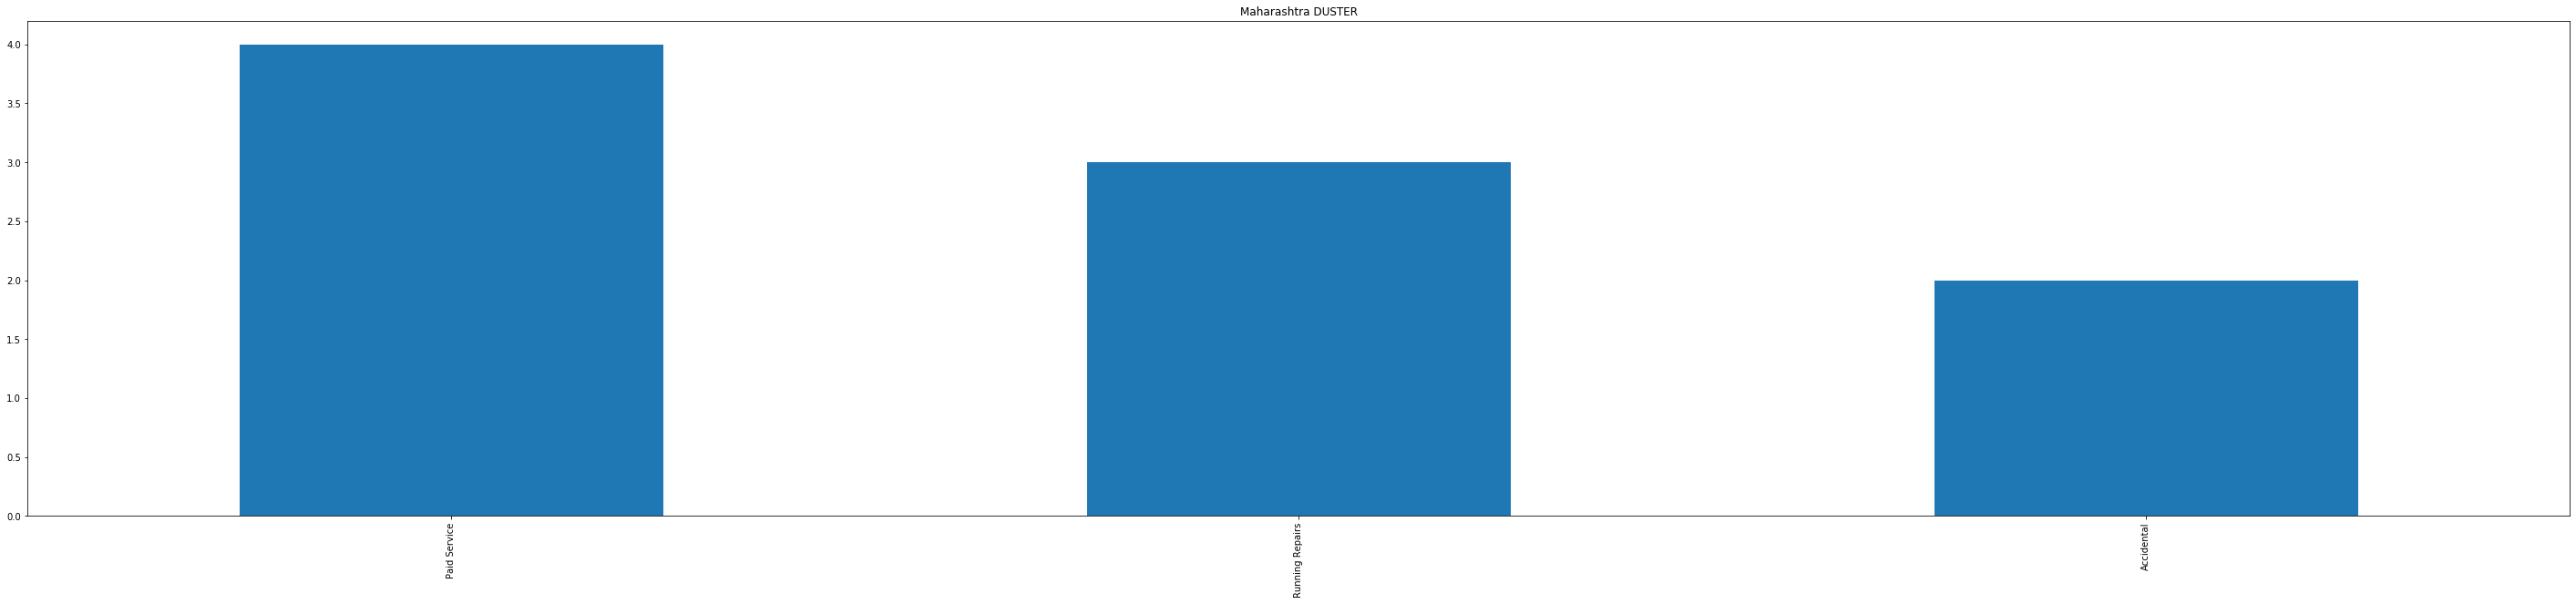

GETZ


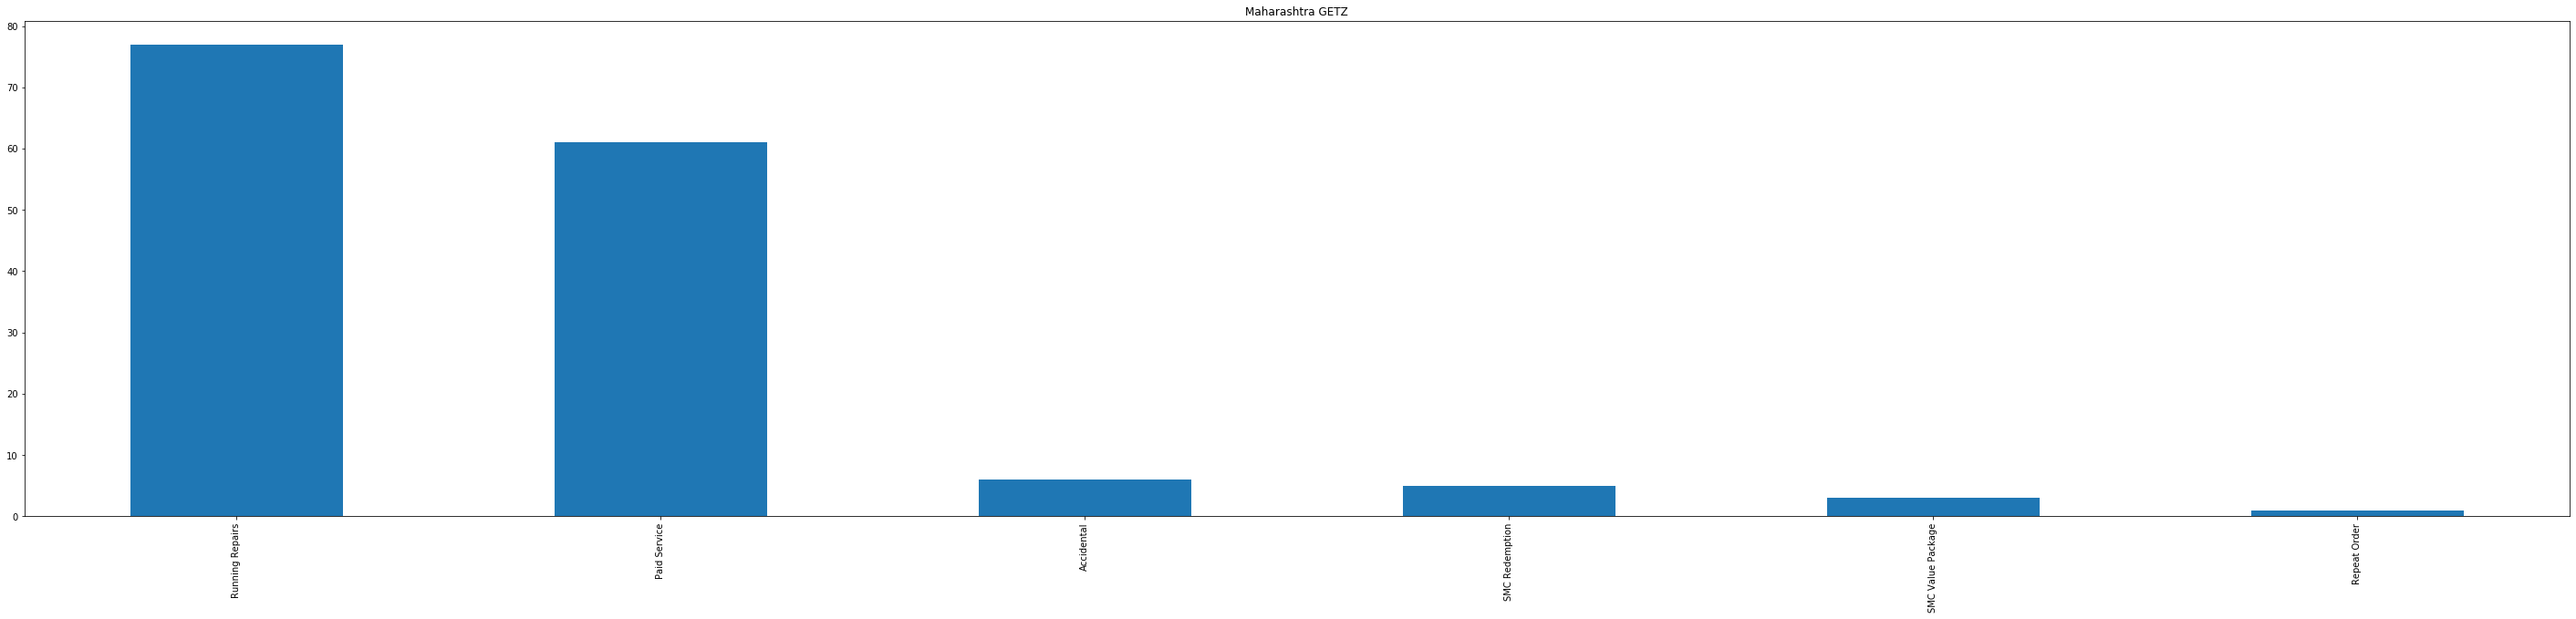

BALENO


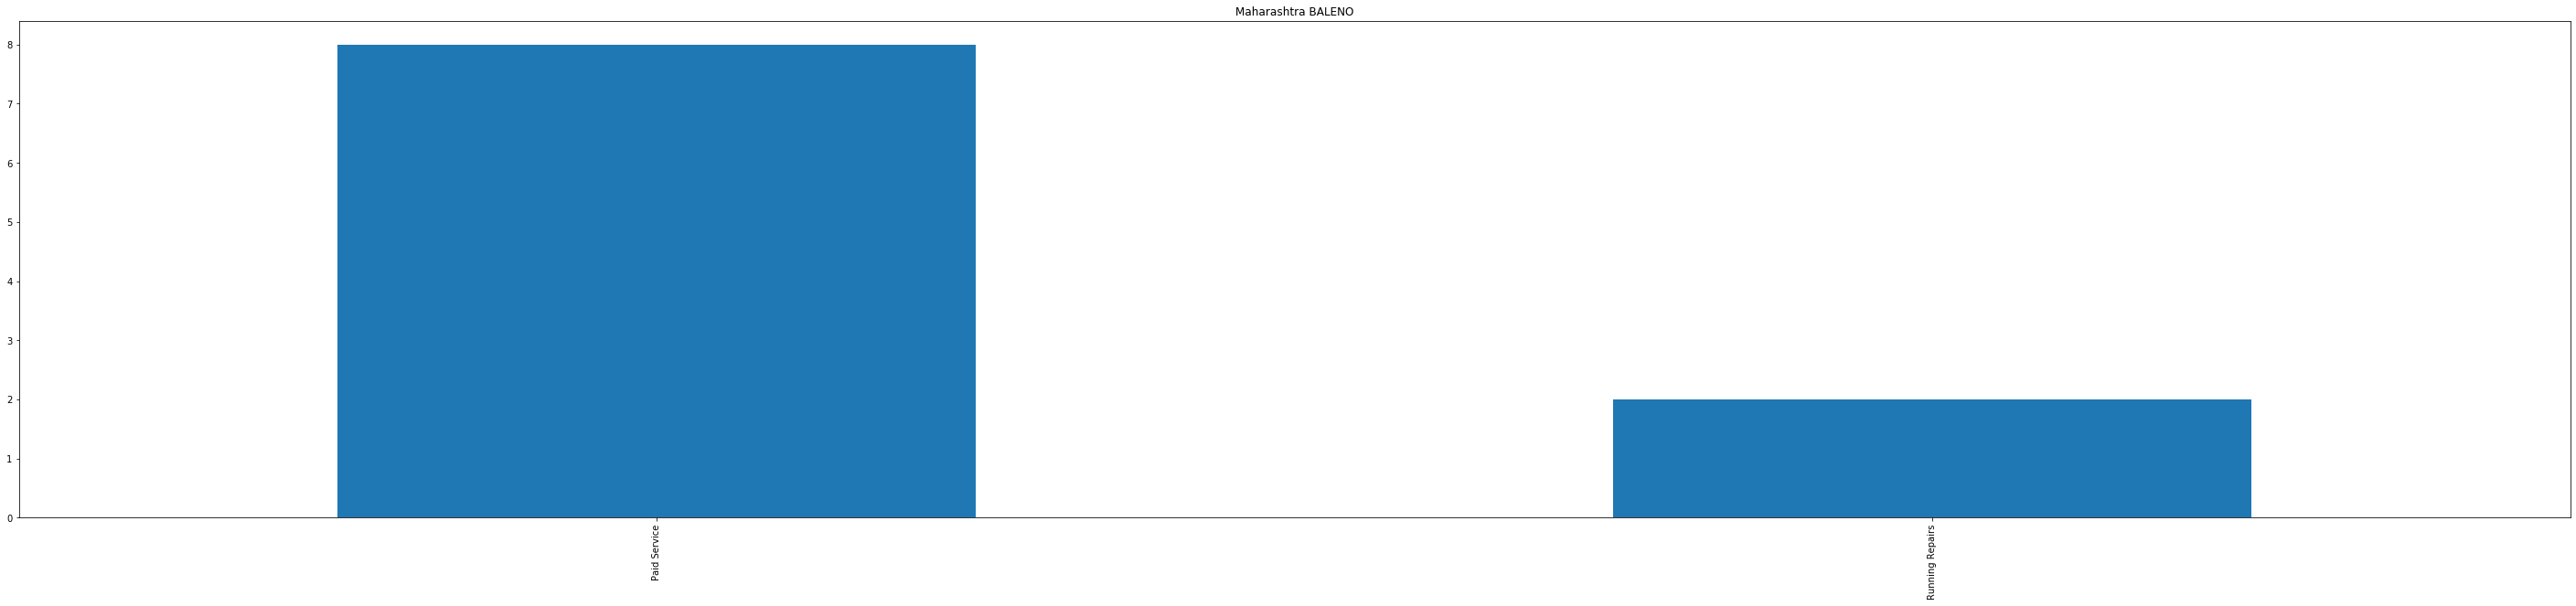

GYPSY 1300


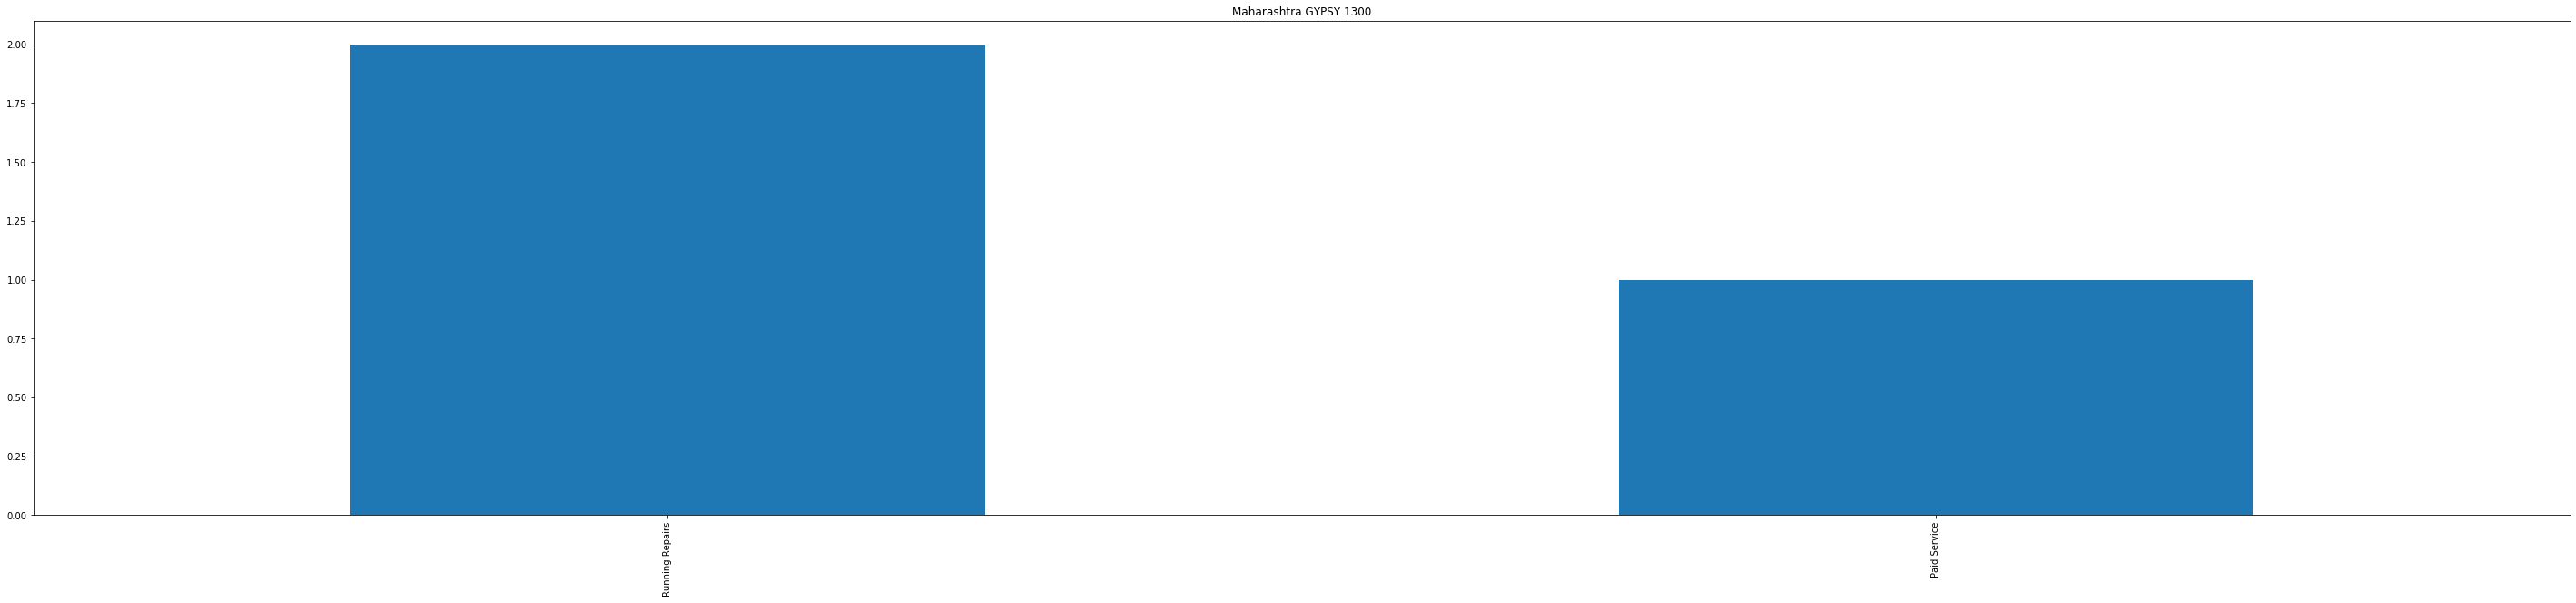

SUMO


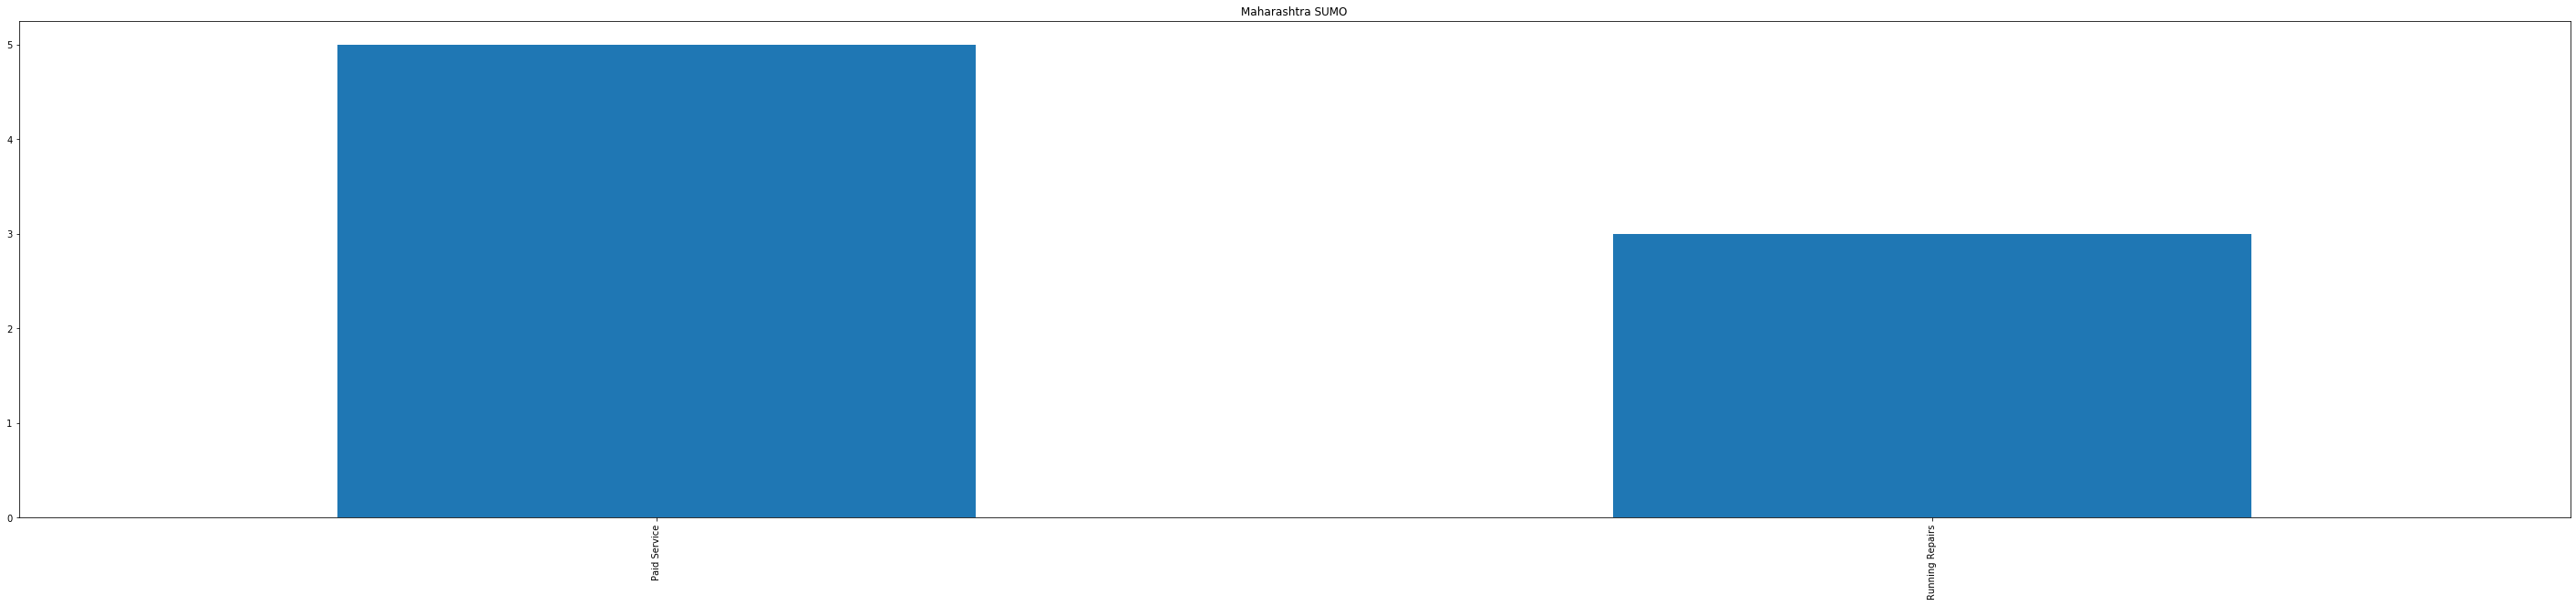

I20


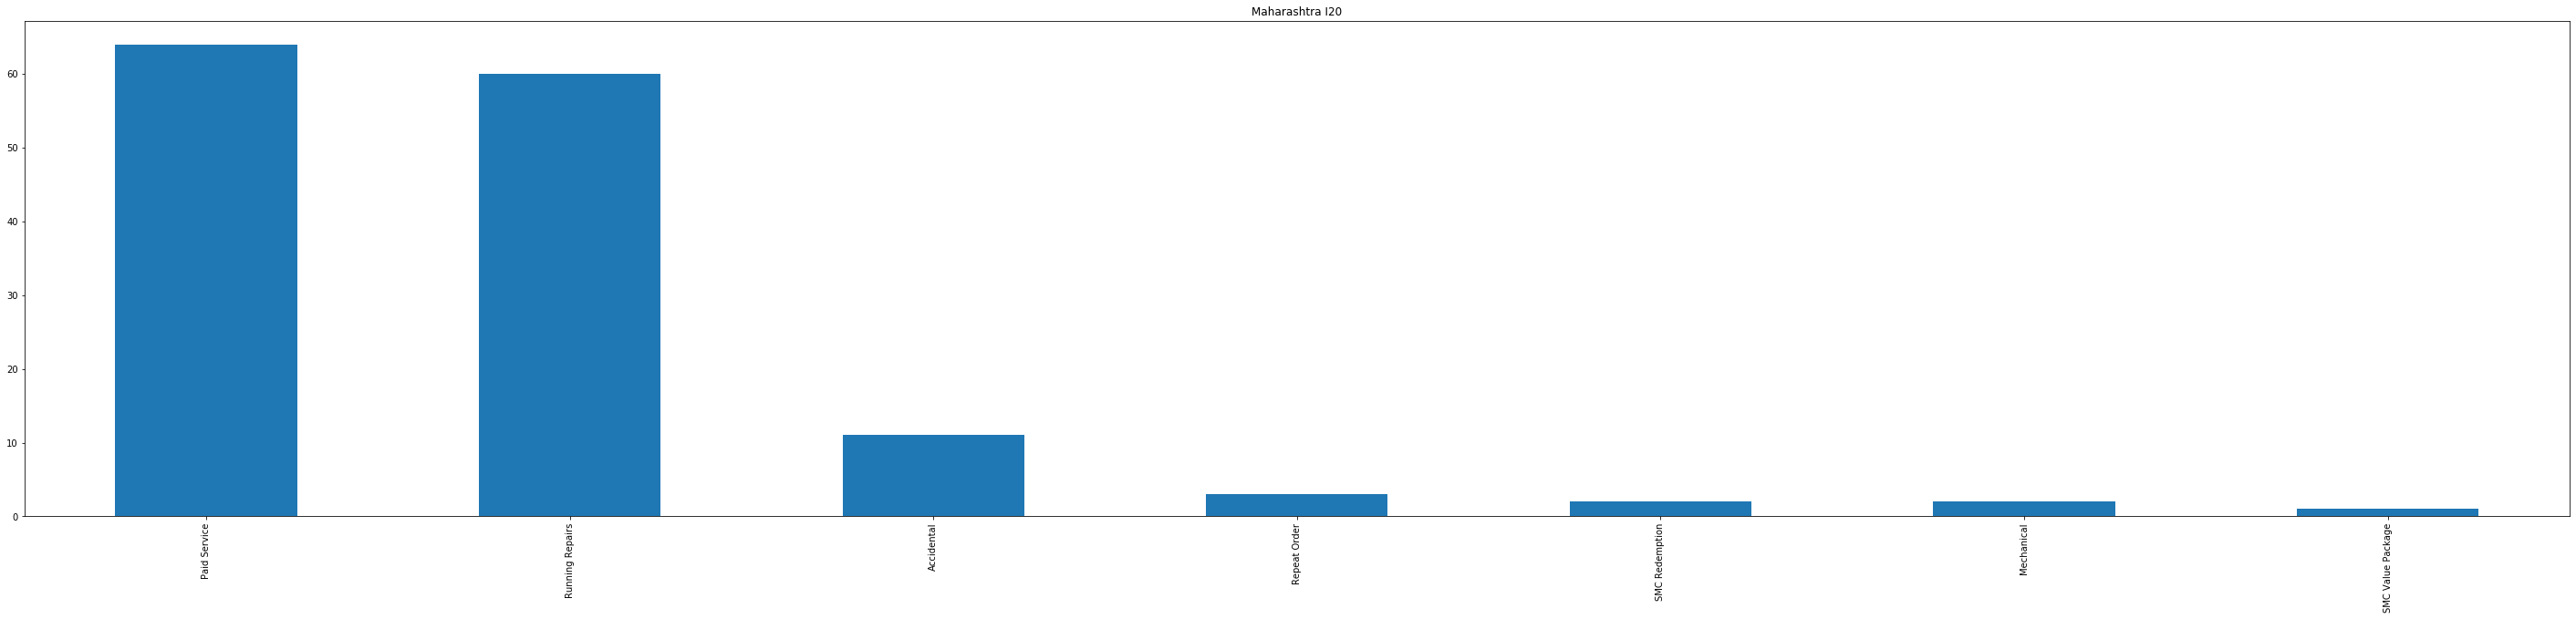

IKON


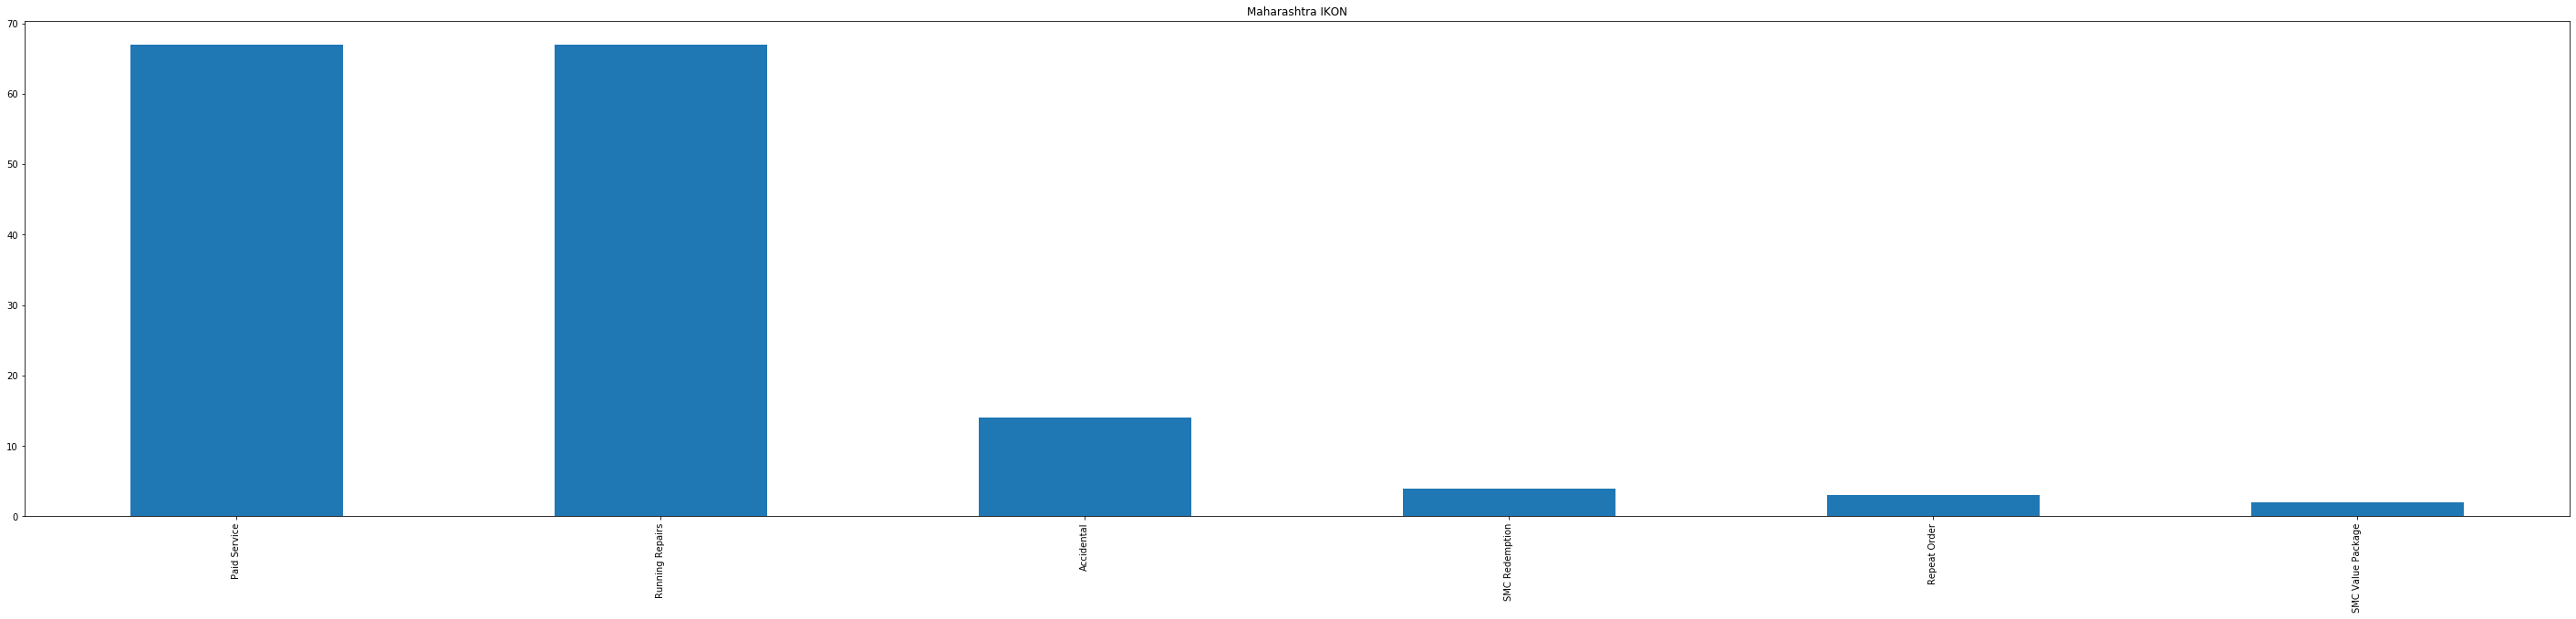

ACCORD


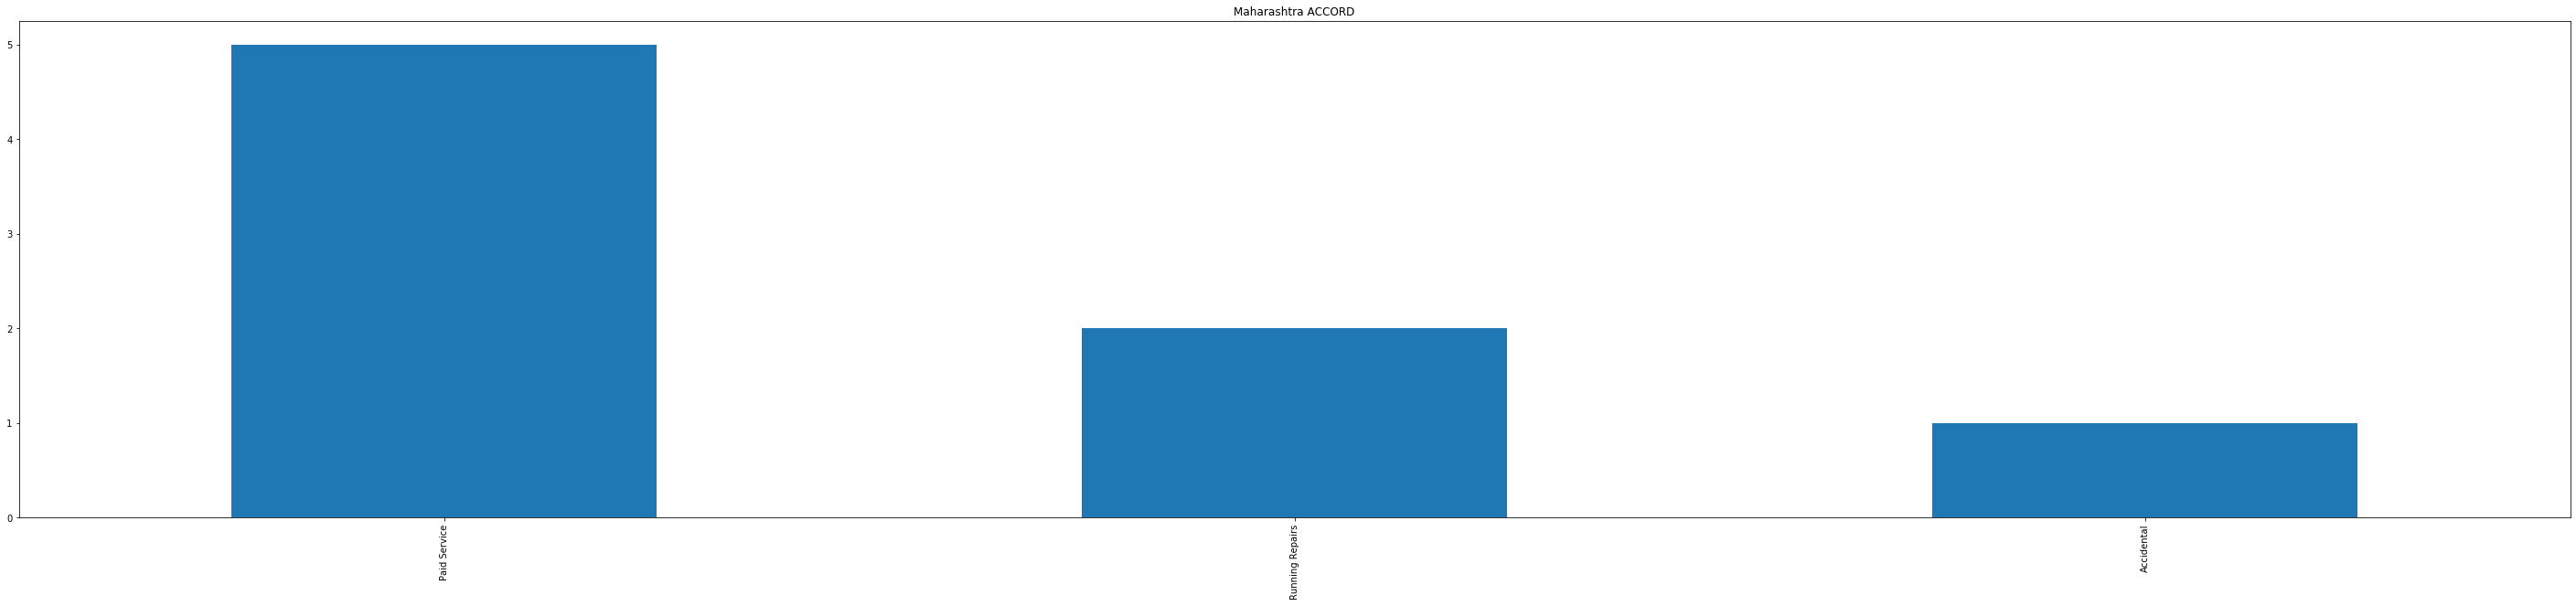

C-CLASS


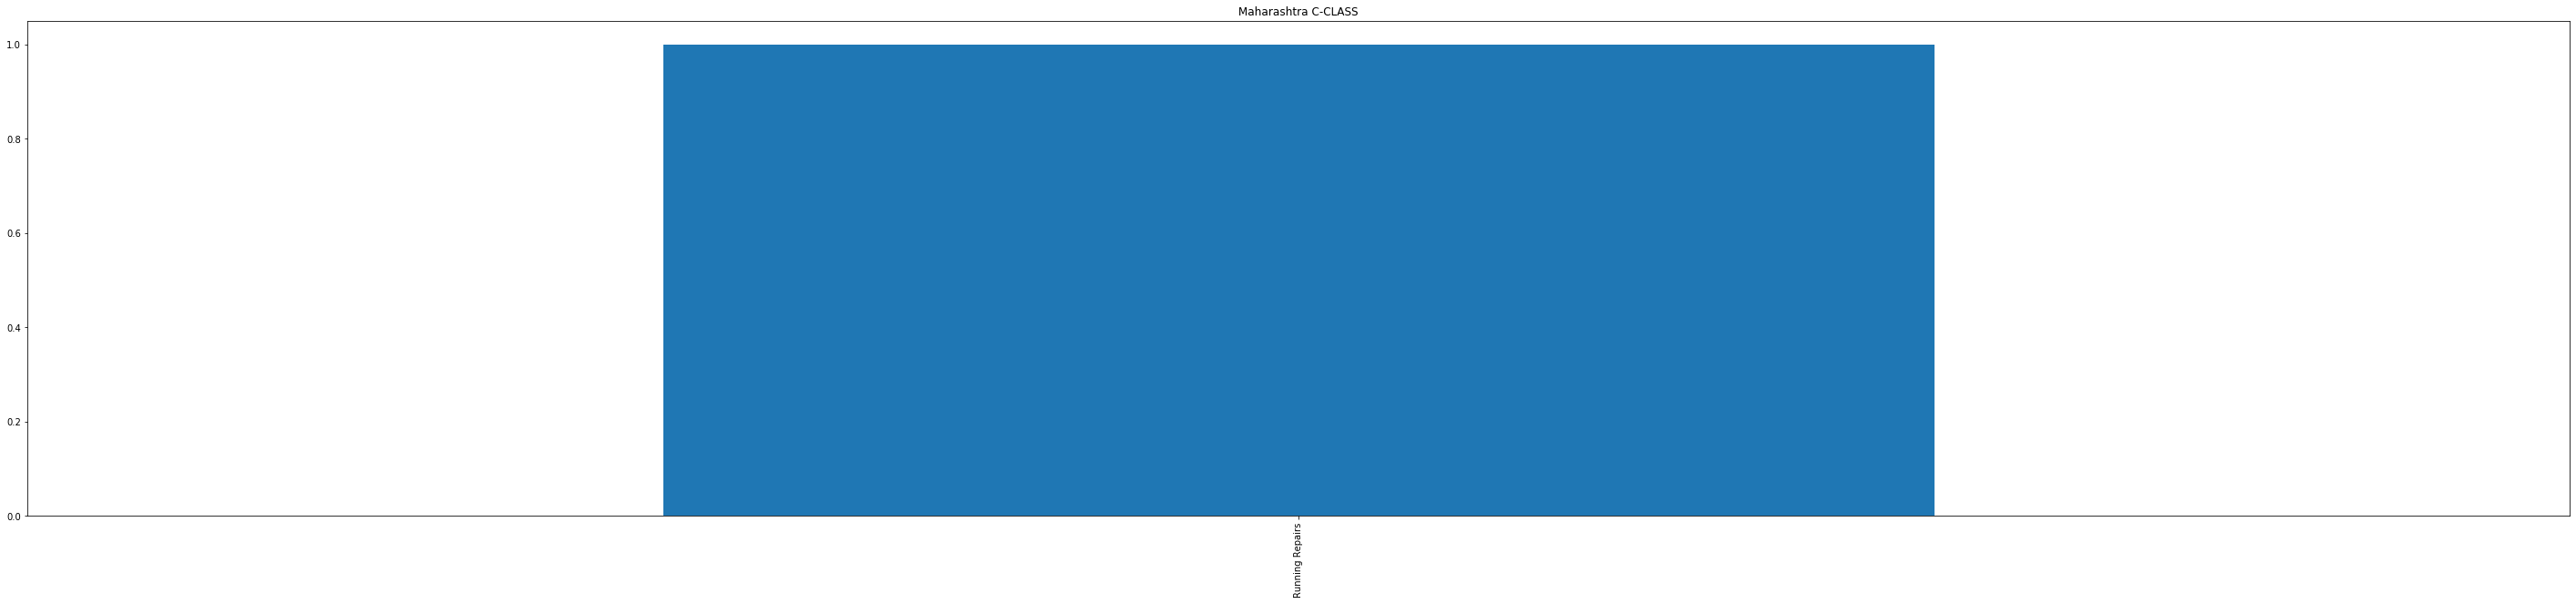

I10


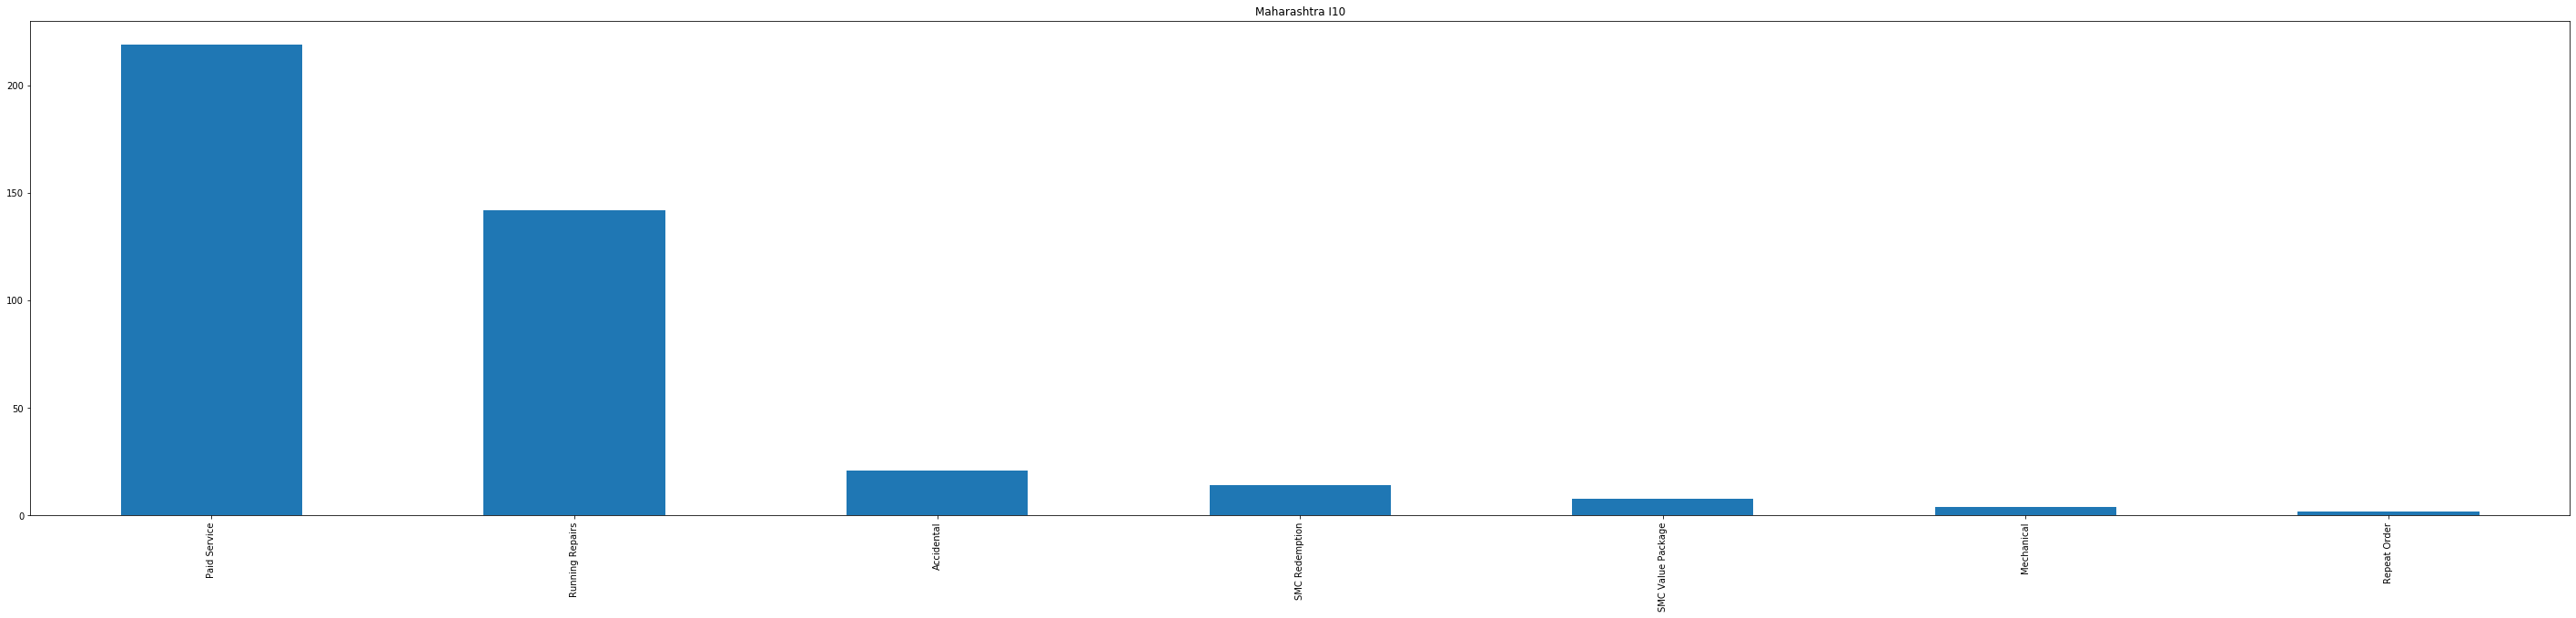

OPTRA


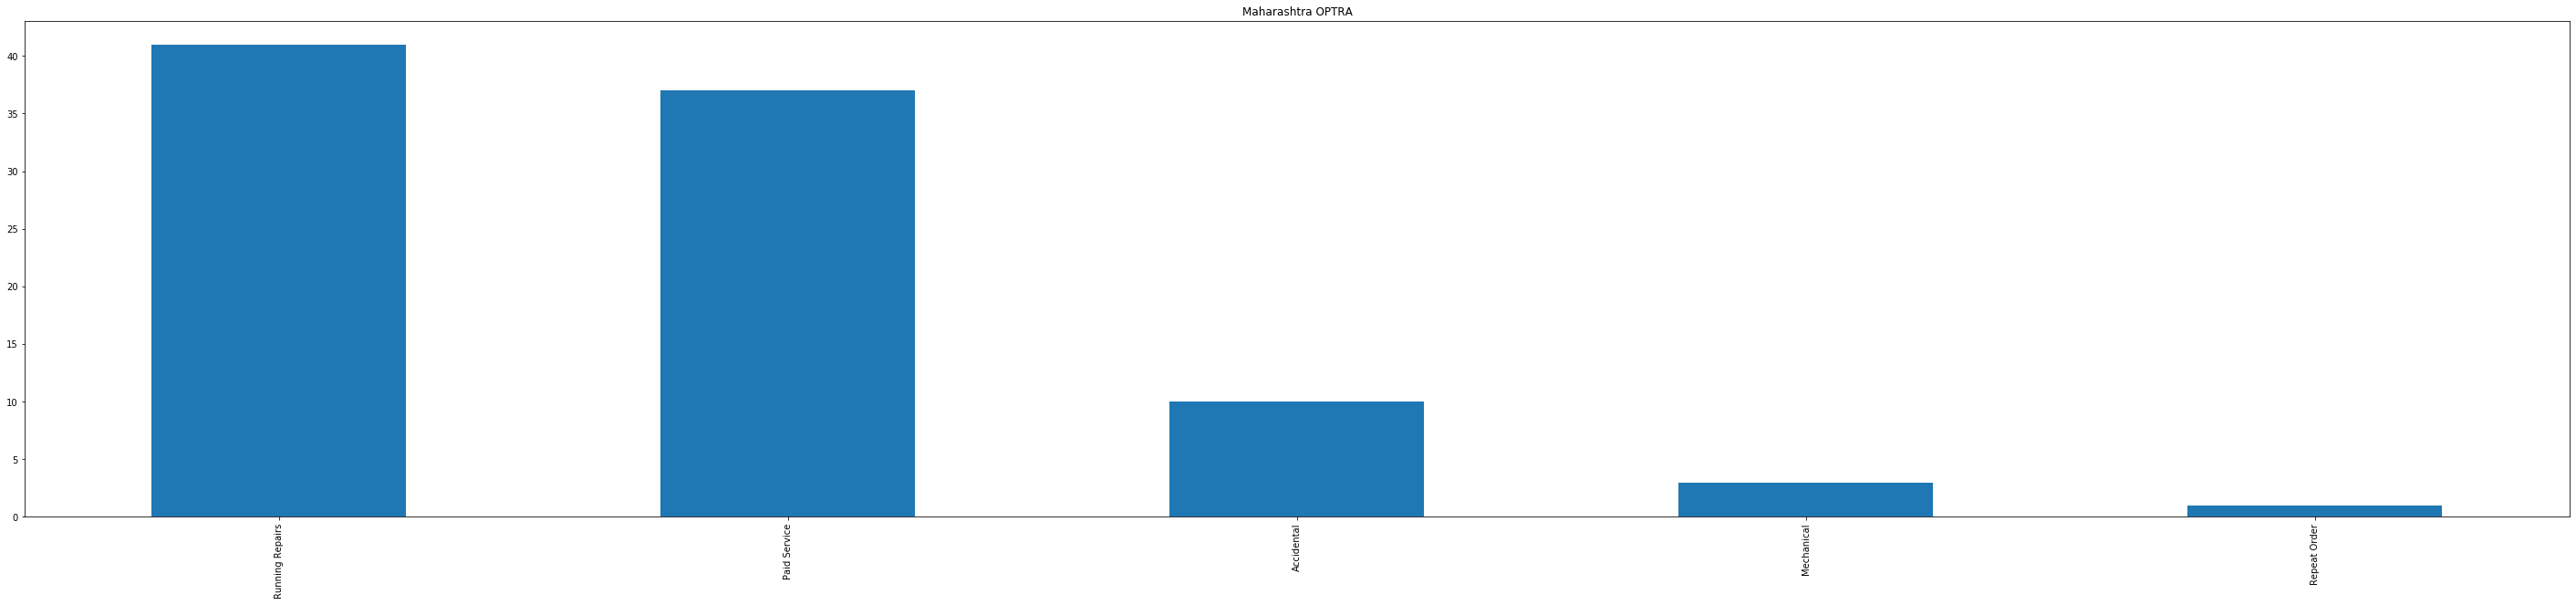

LANCER


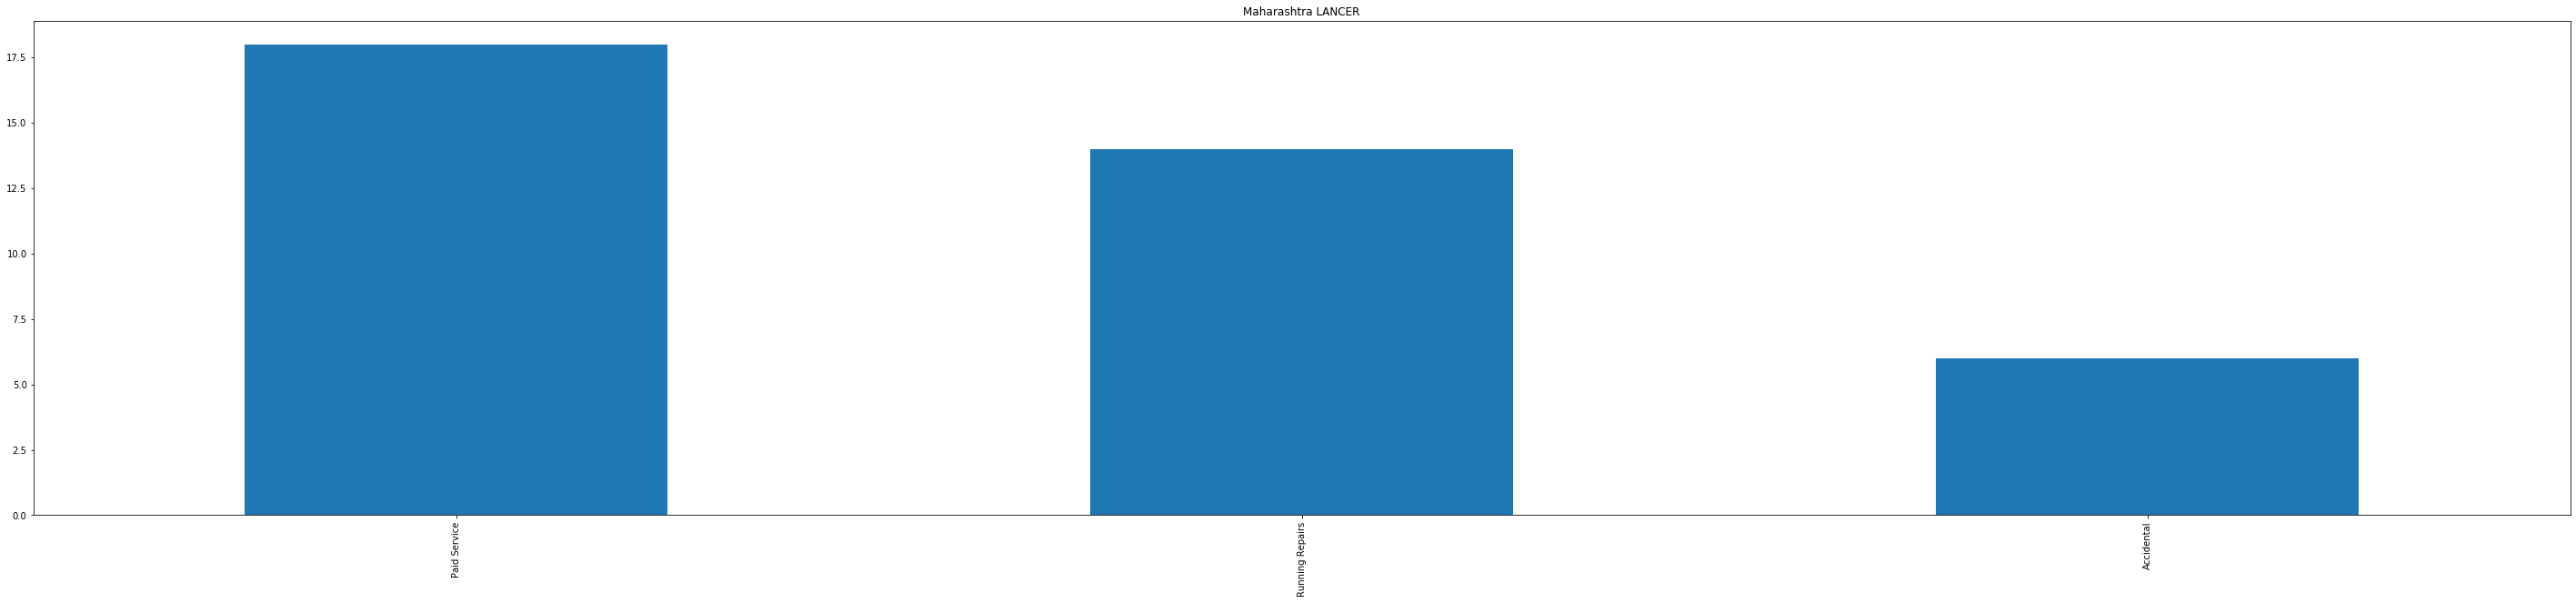

SPARK


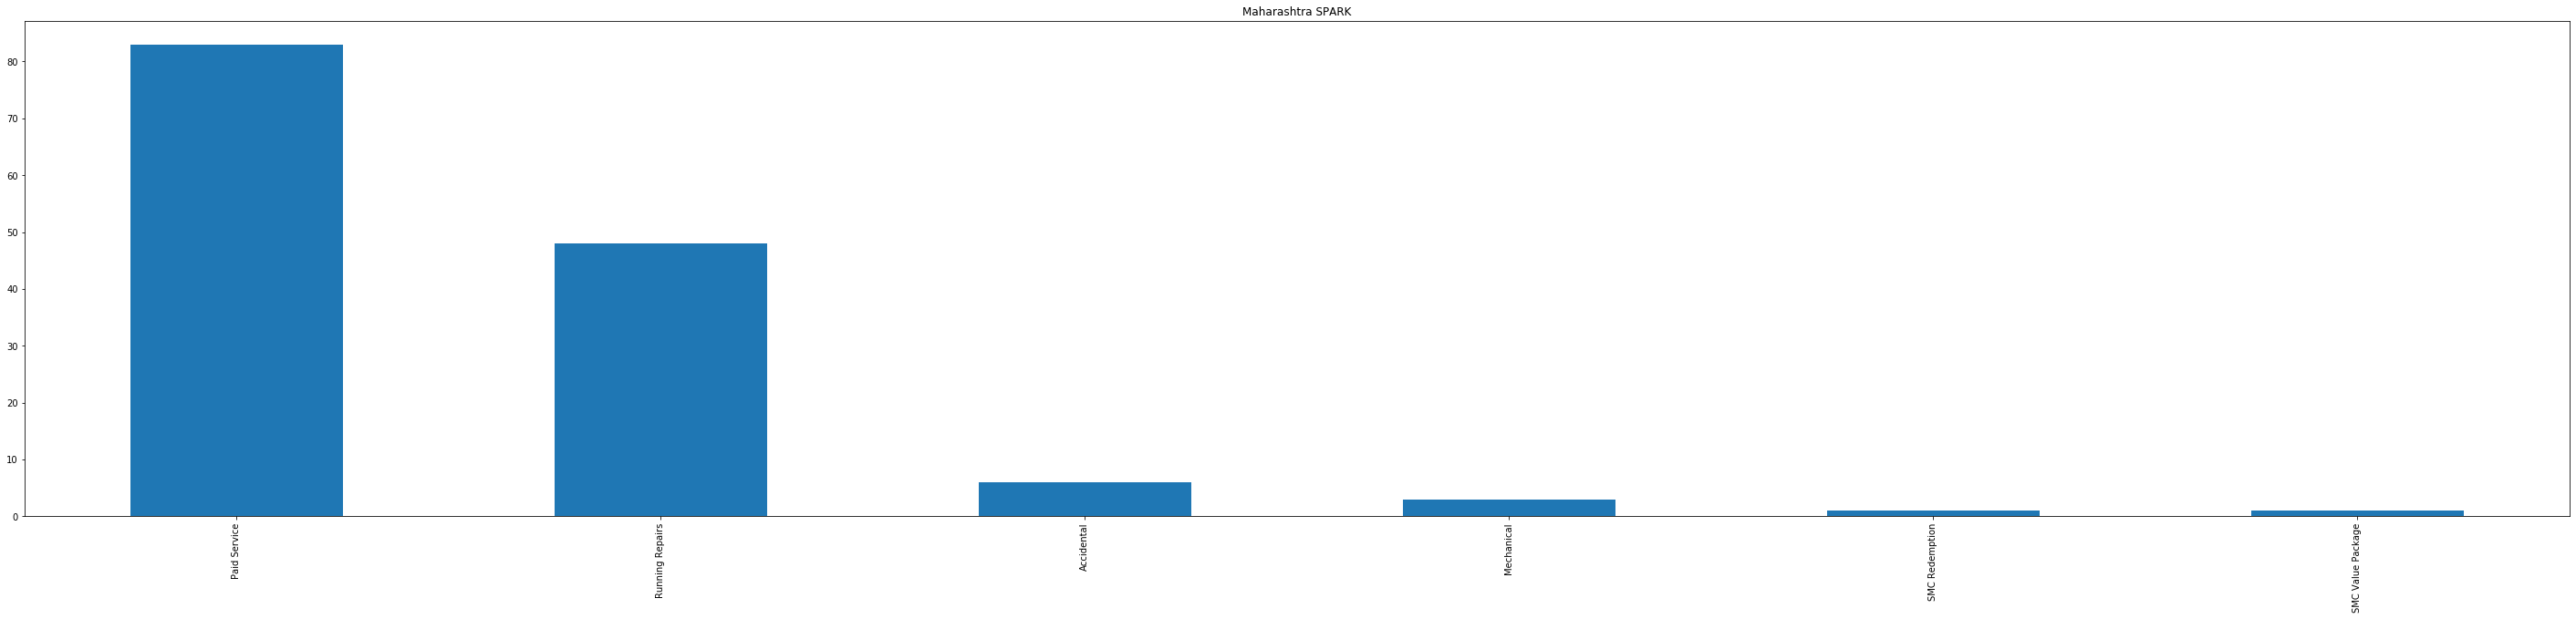

SAFARI


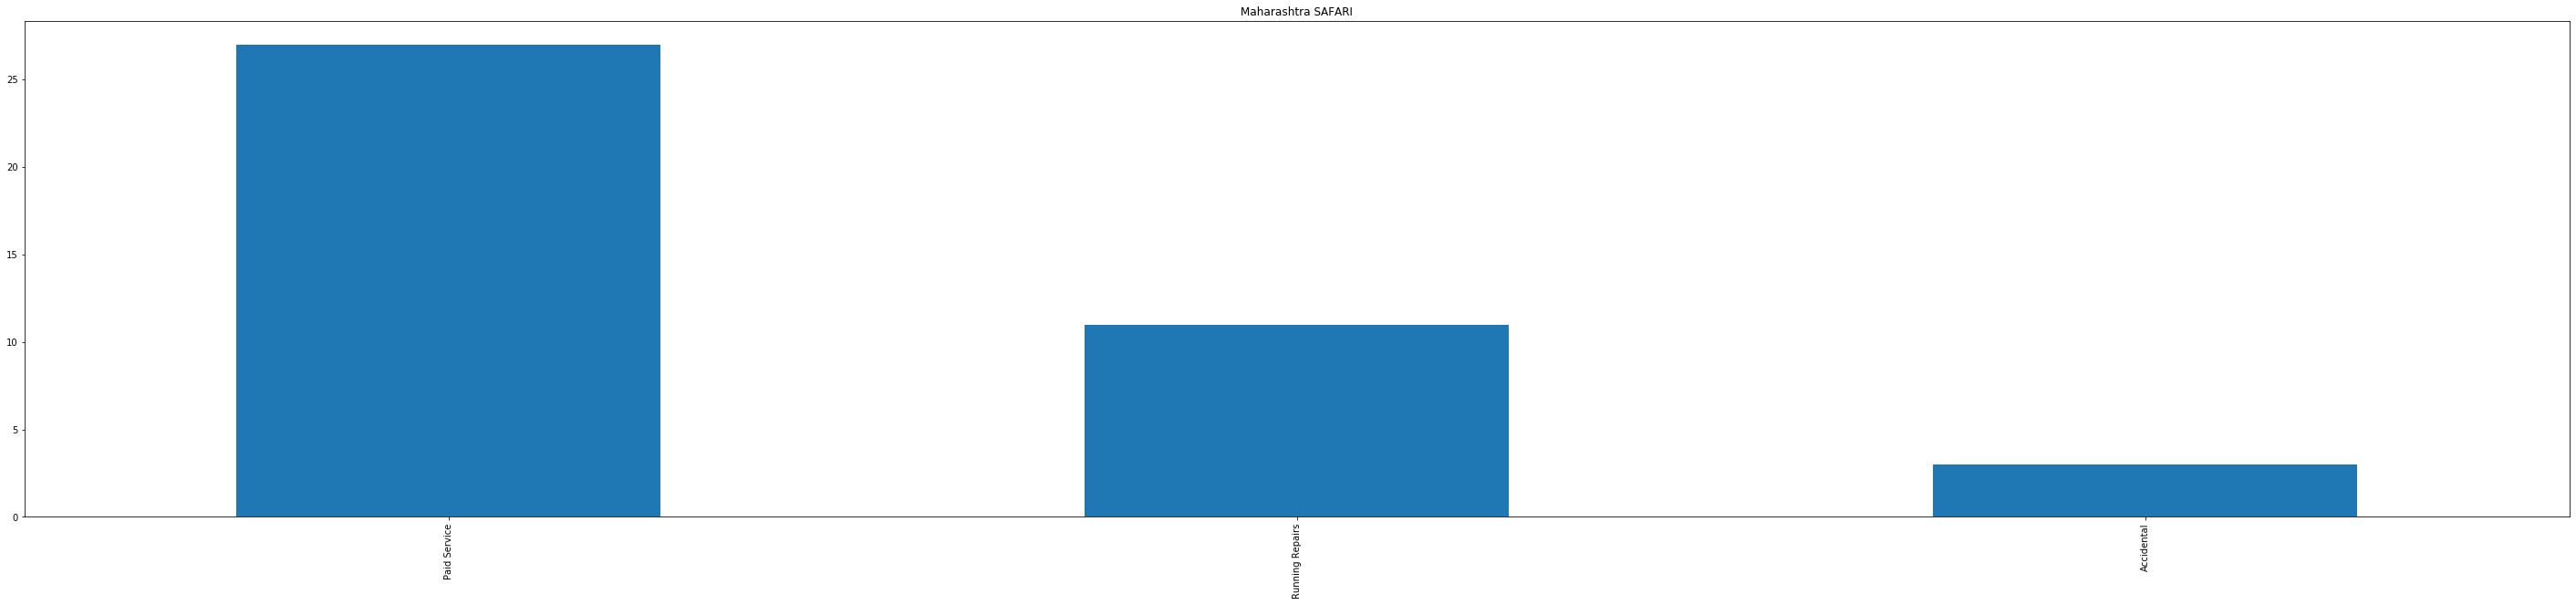

SAIL


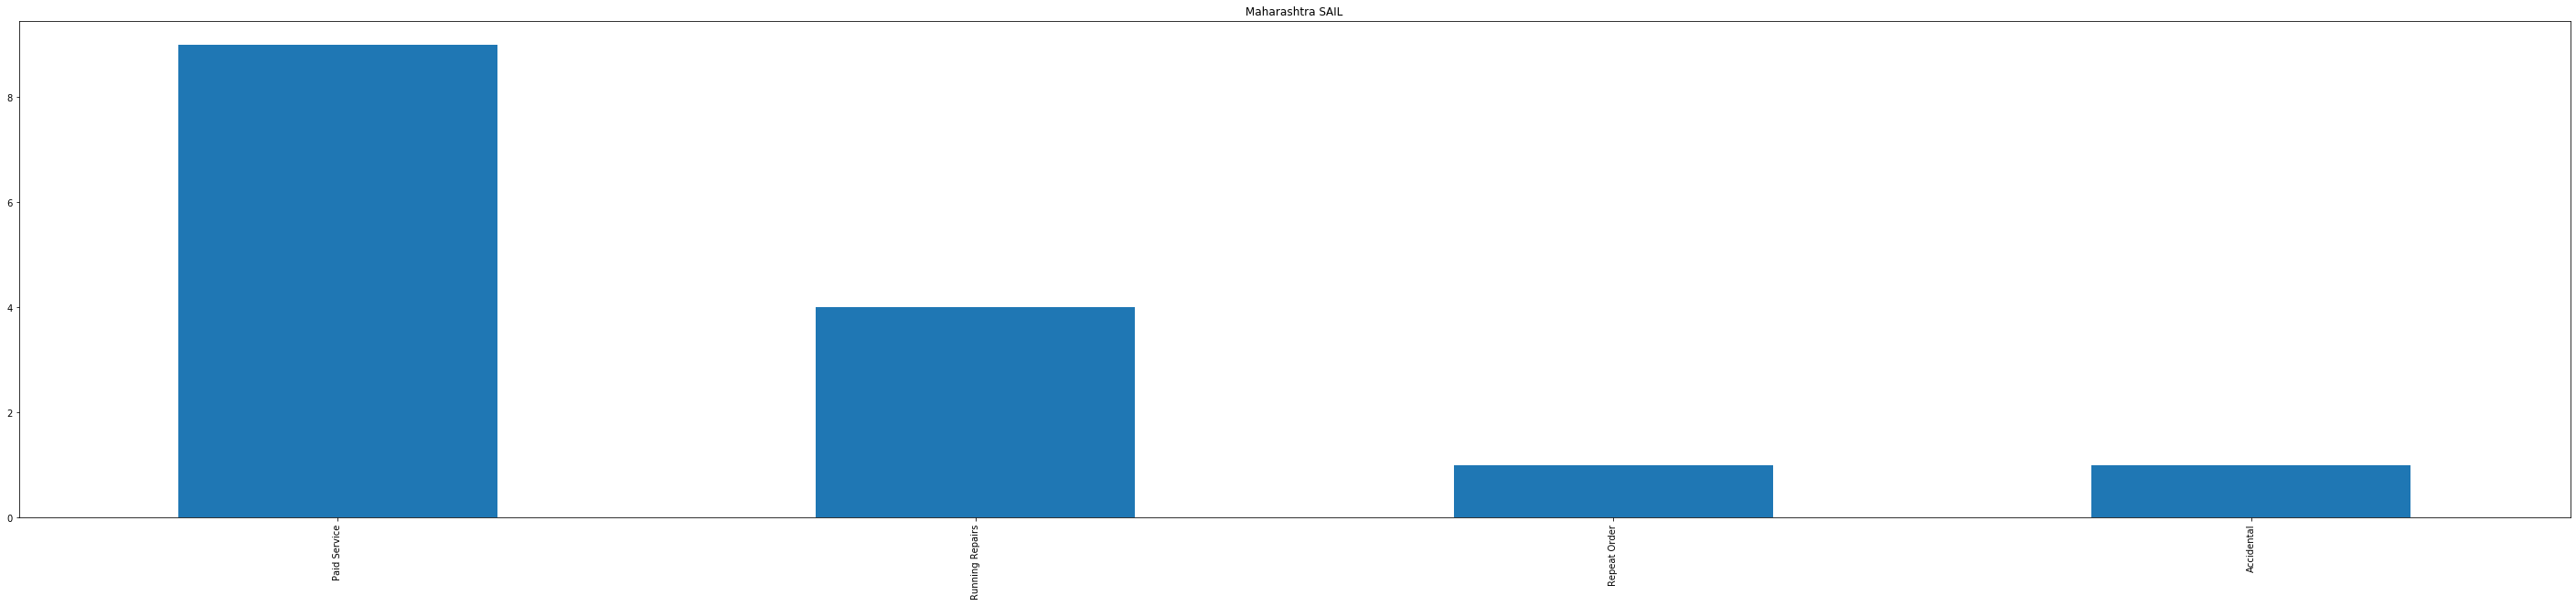

MATIZ


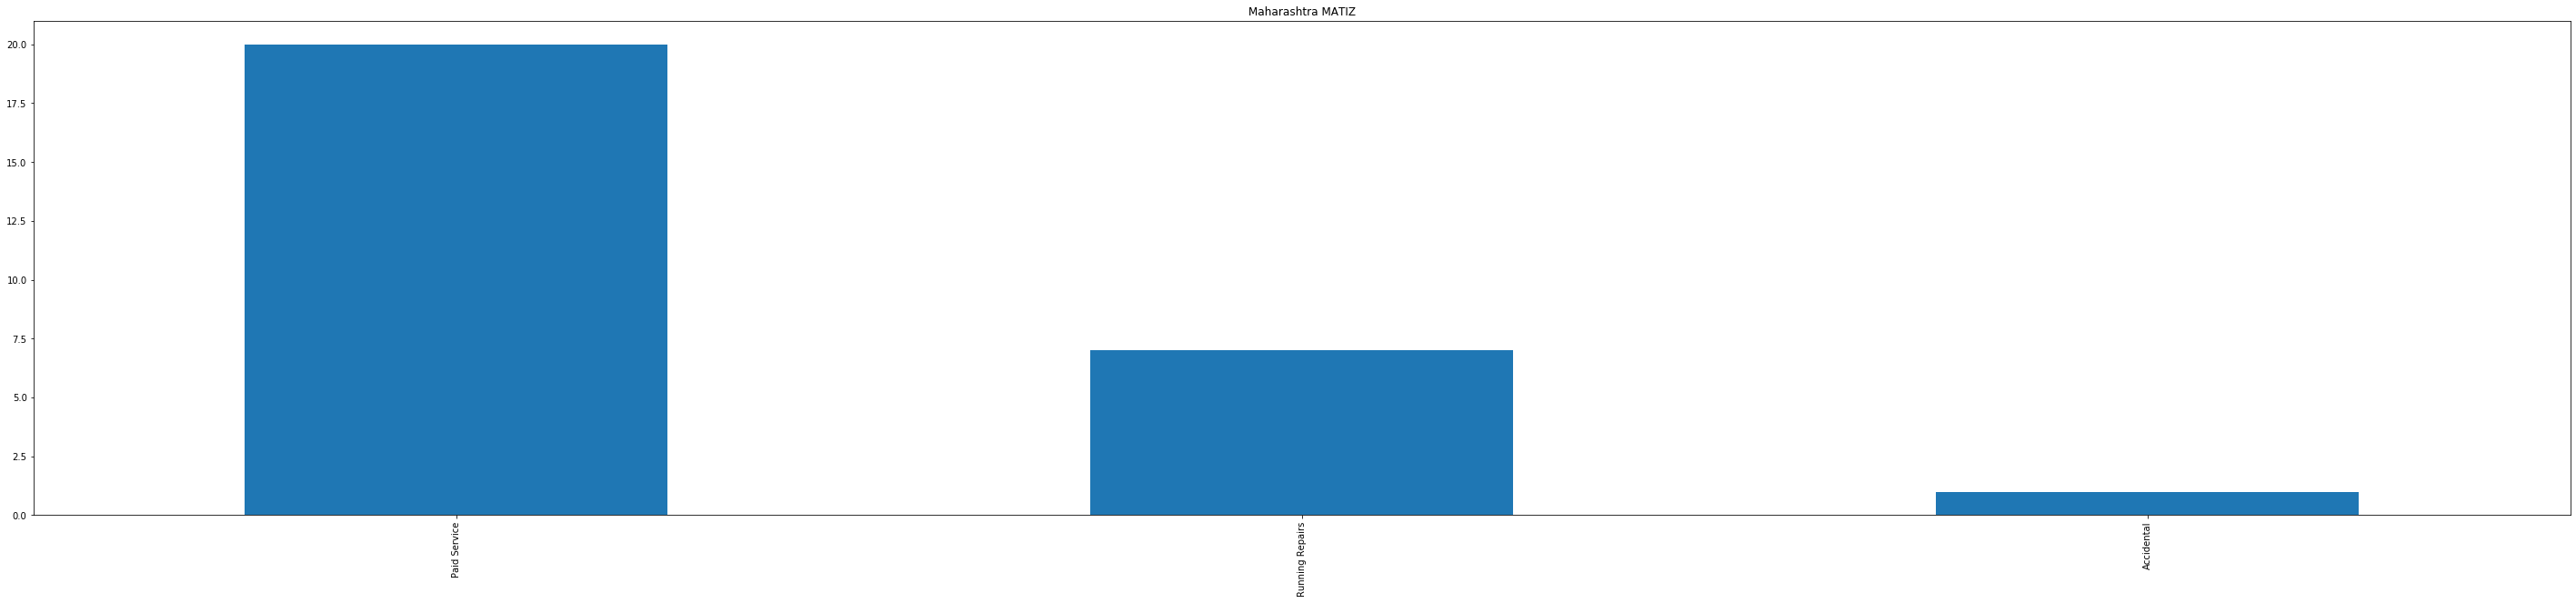

ZEN


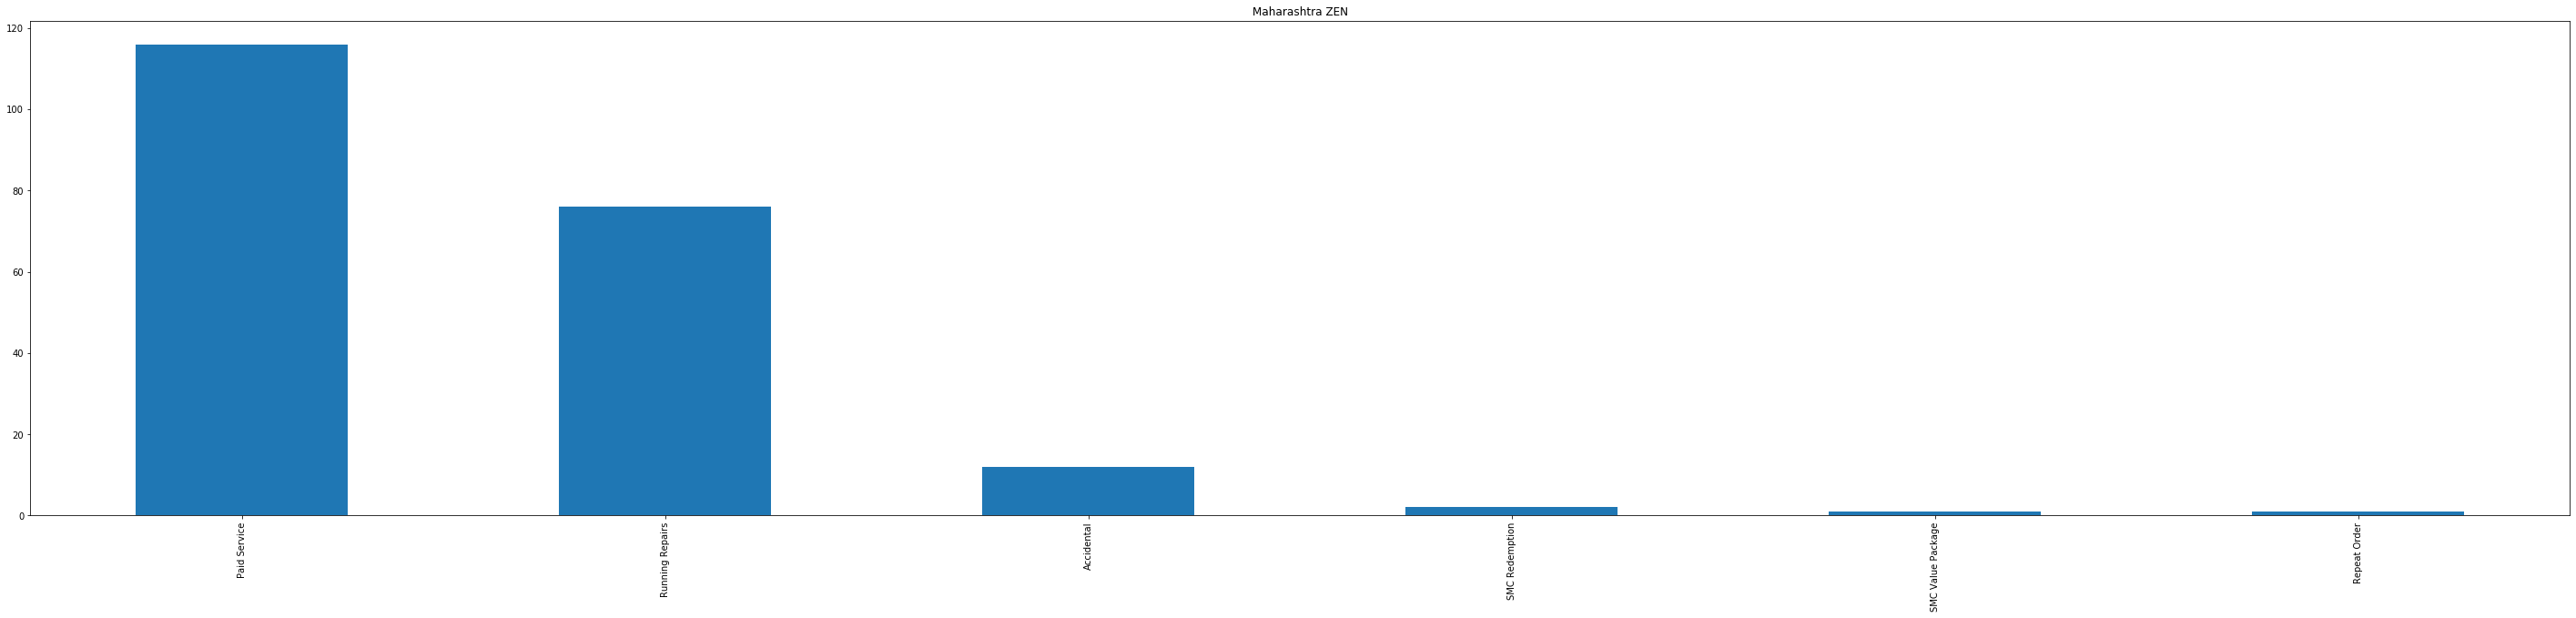

OCTAVIA


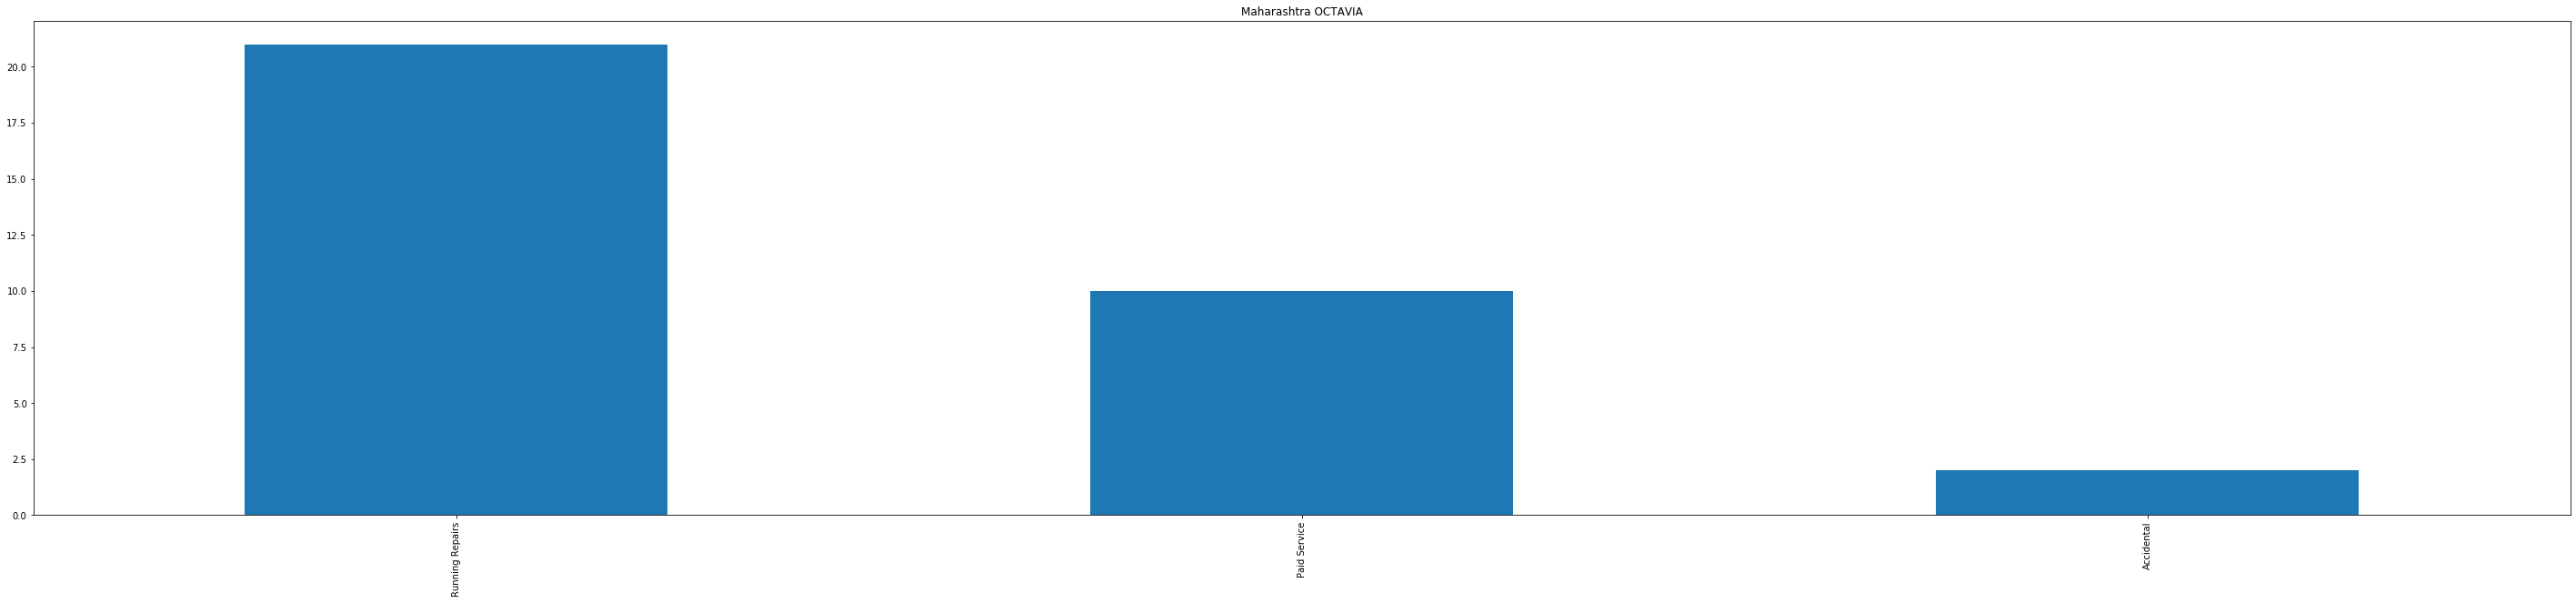

RENAULT 1.9


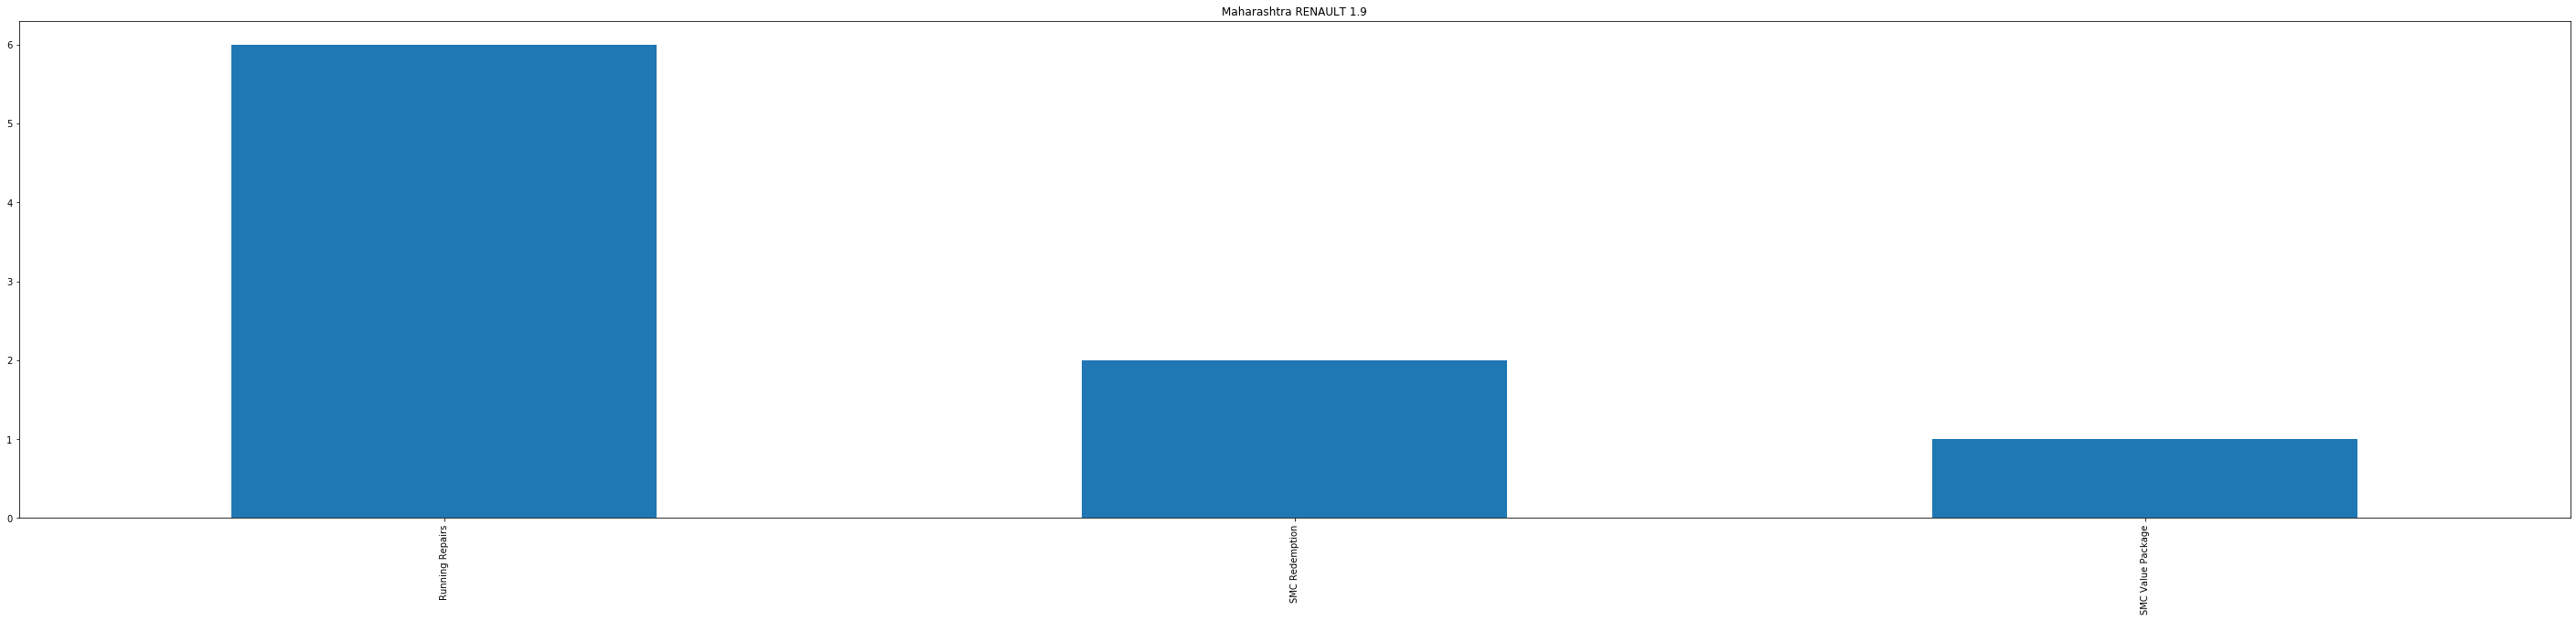

SUPERB


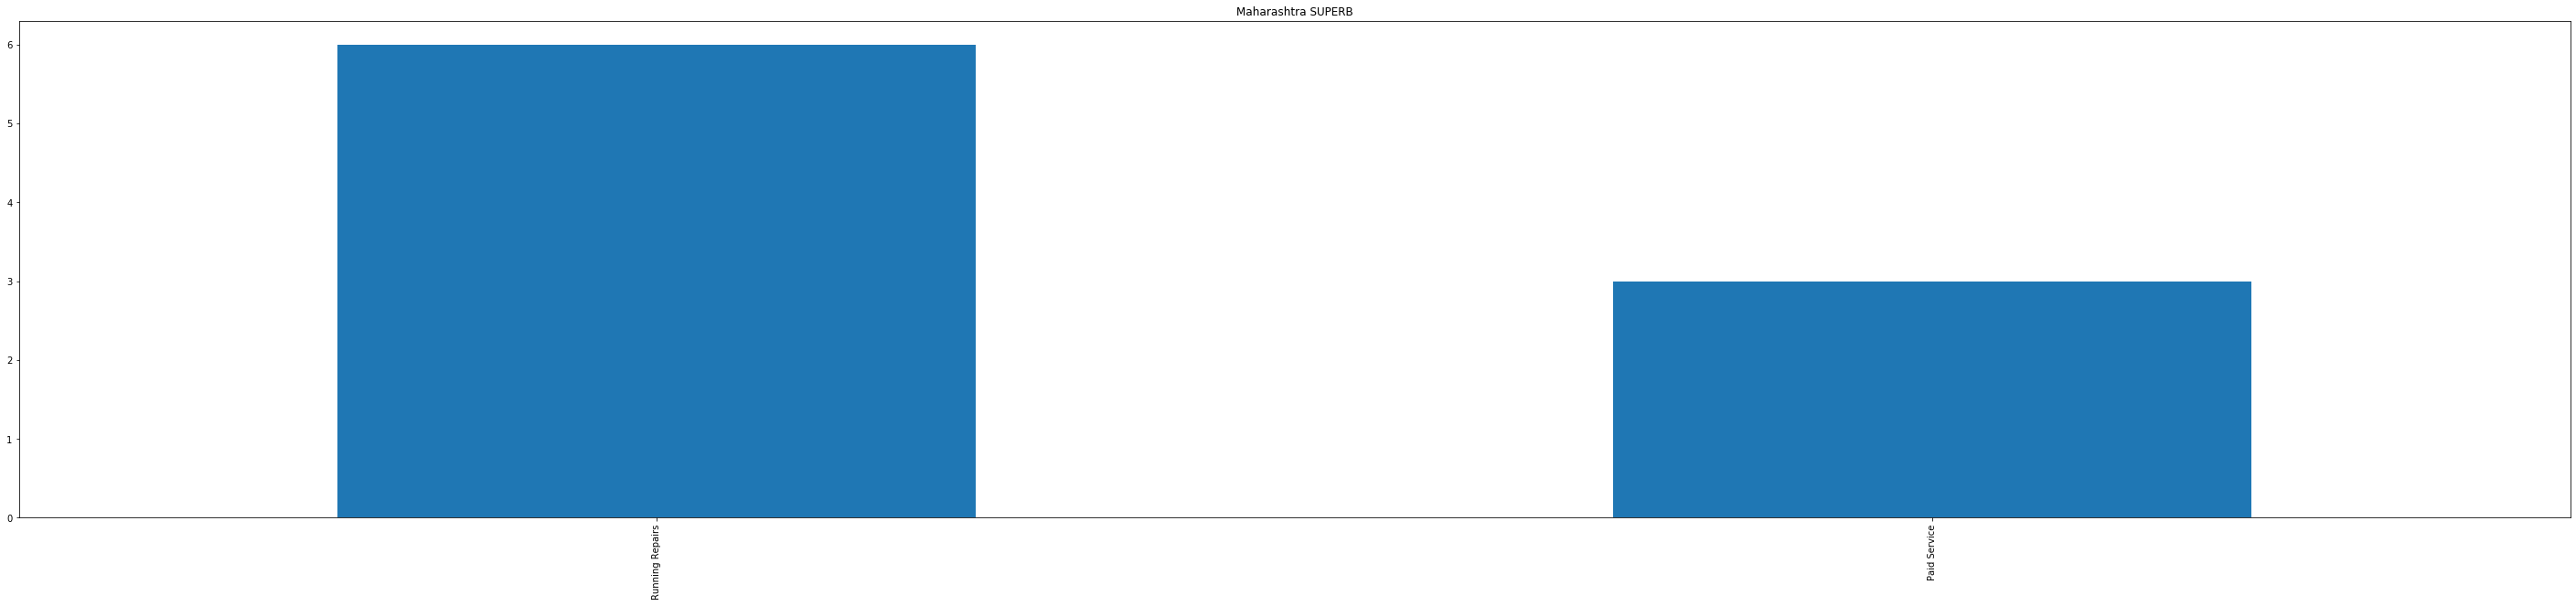

MAHINDRA PIK UP


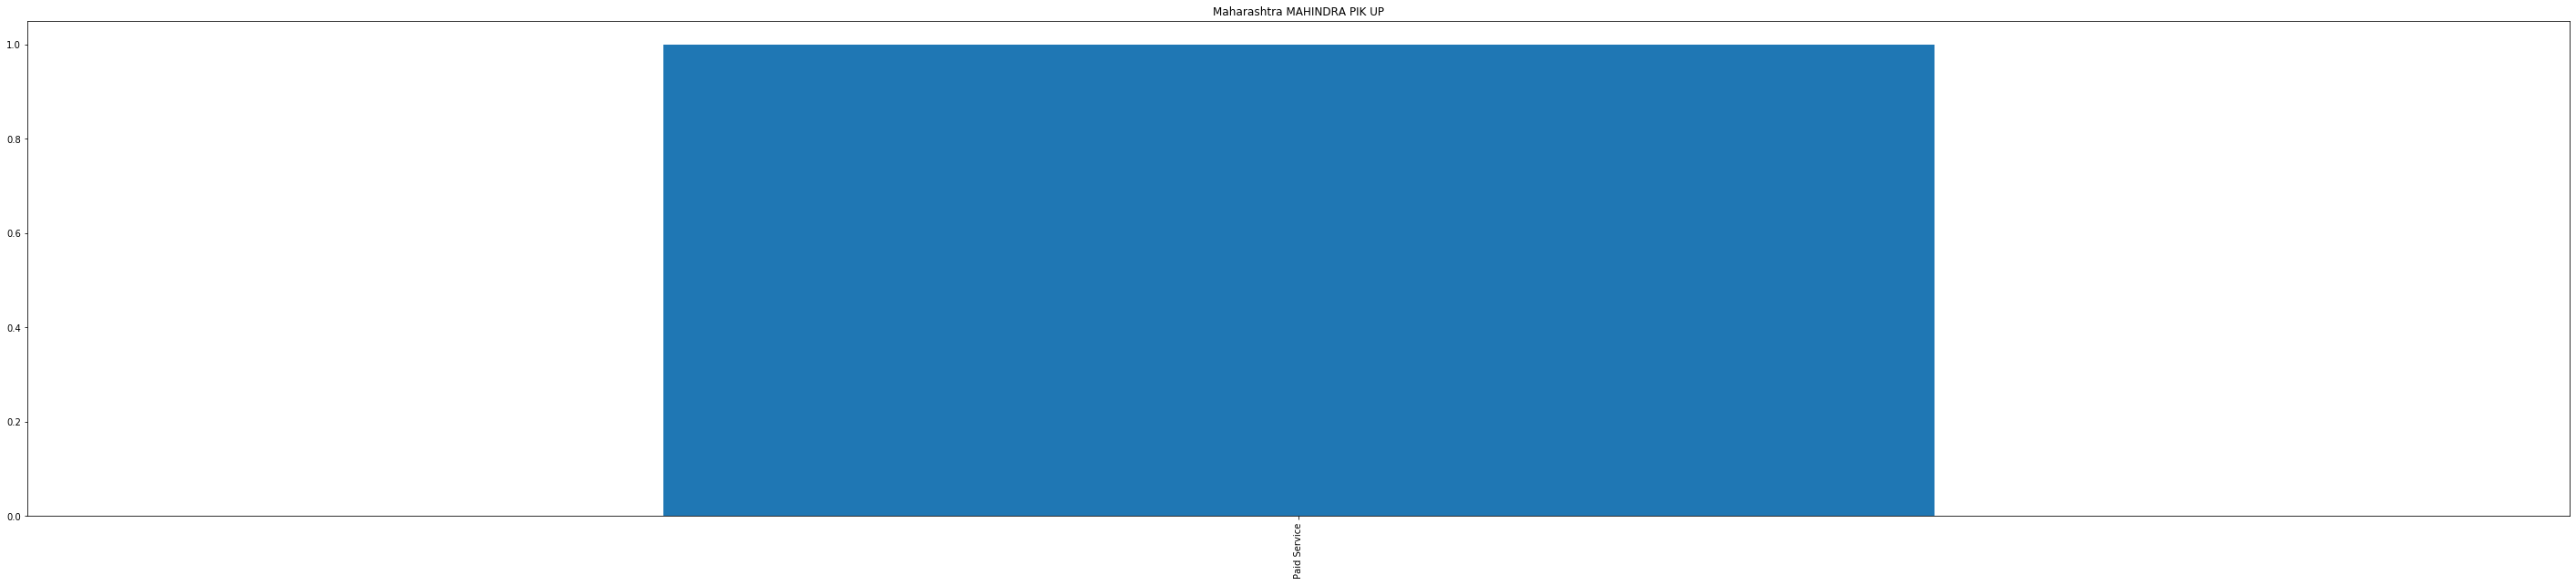

UNO


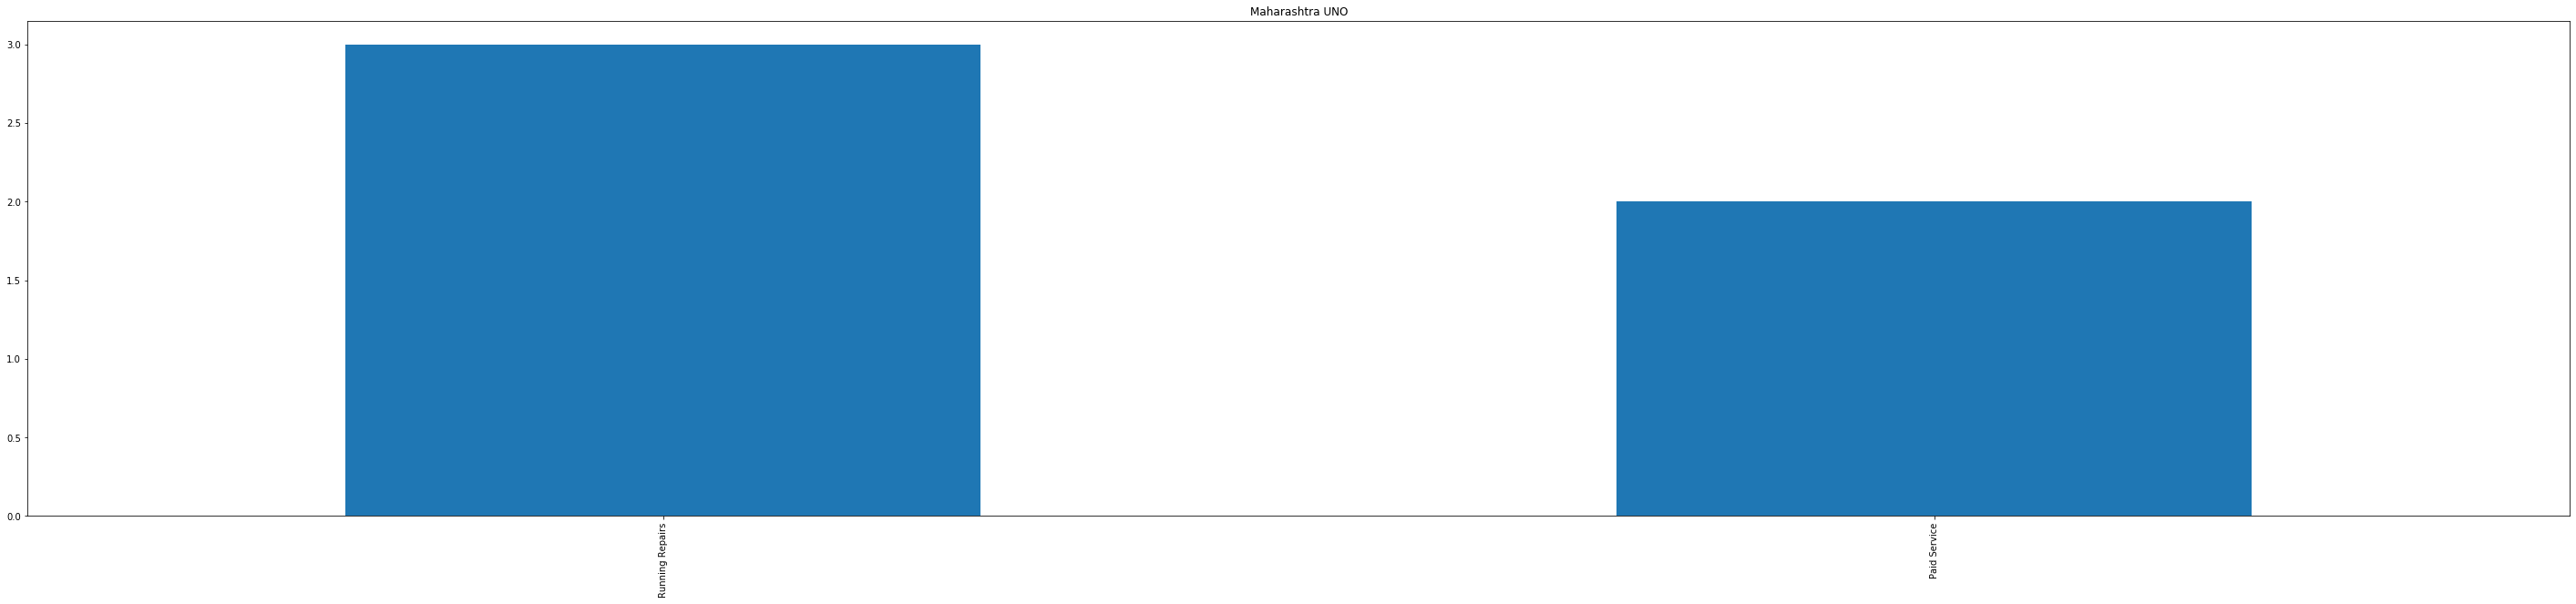

LINEA


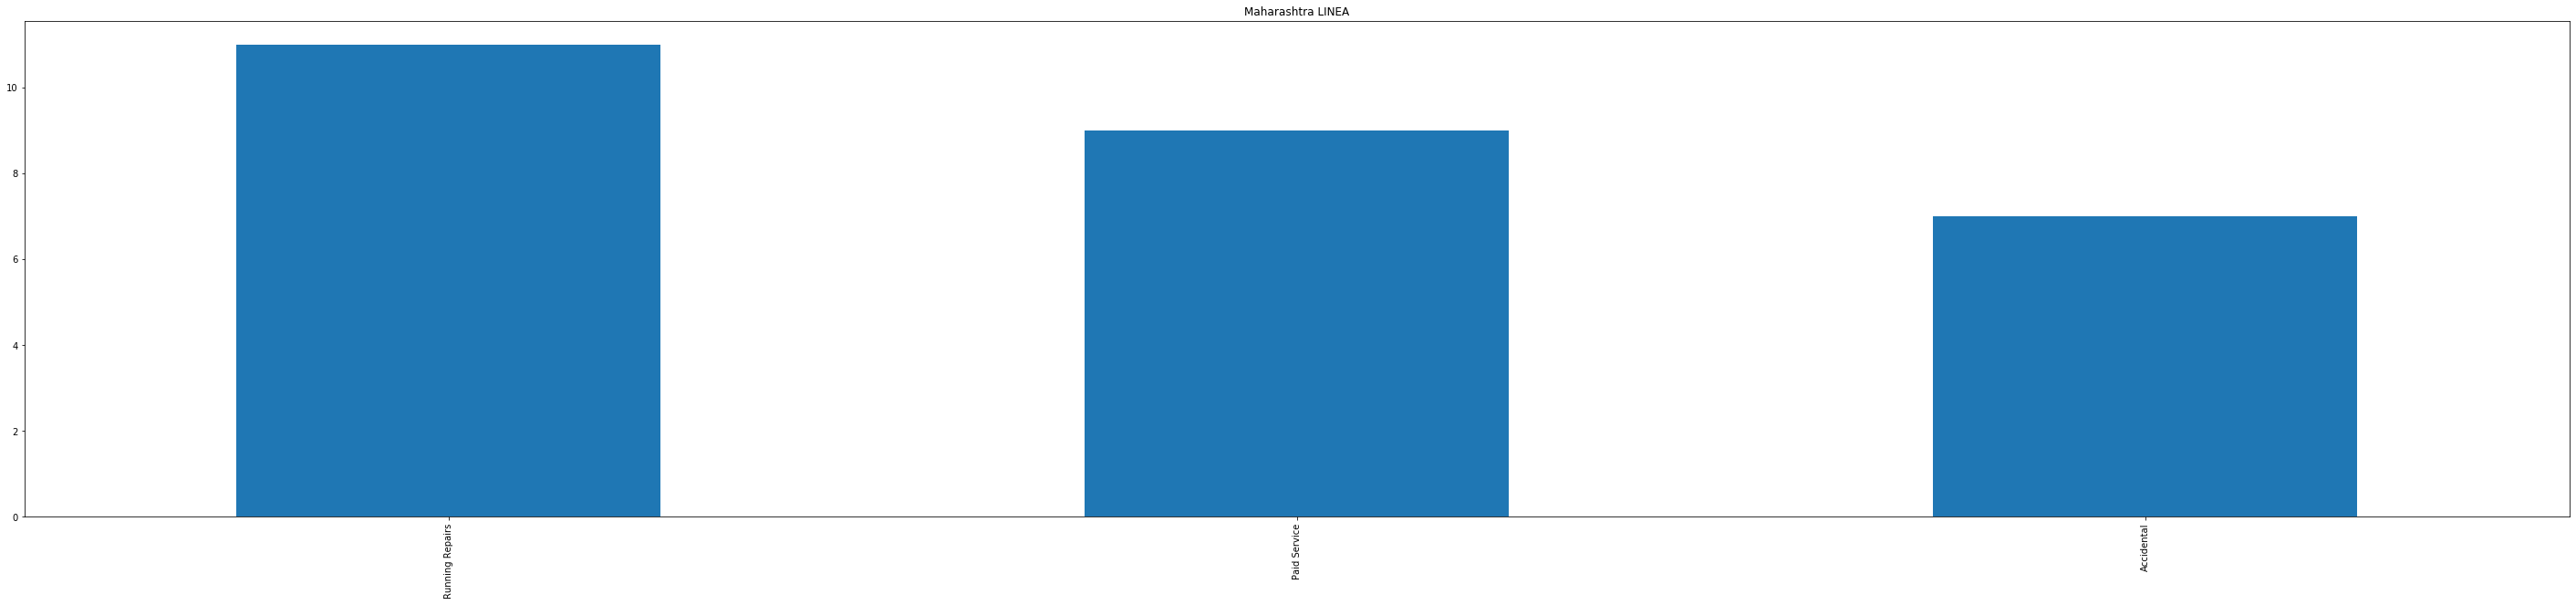

FIGO


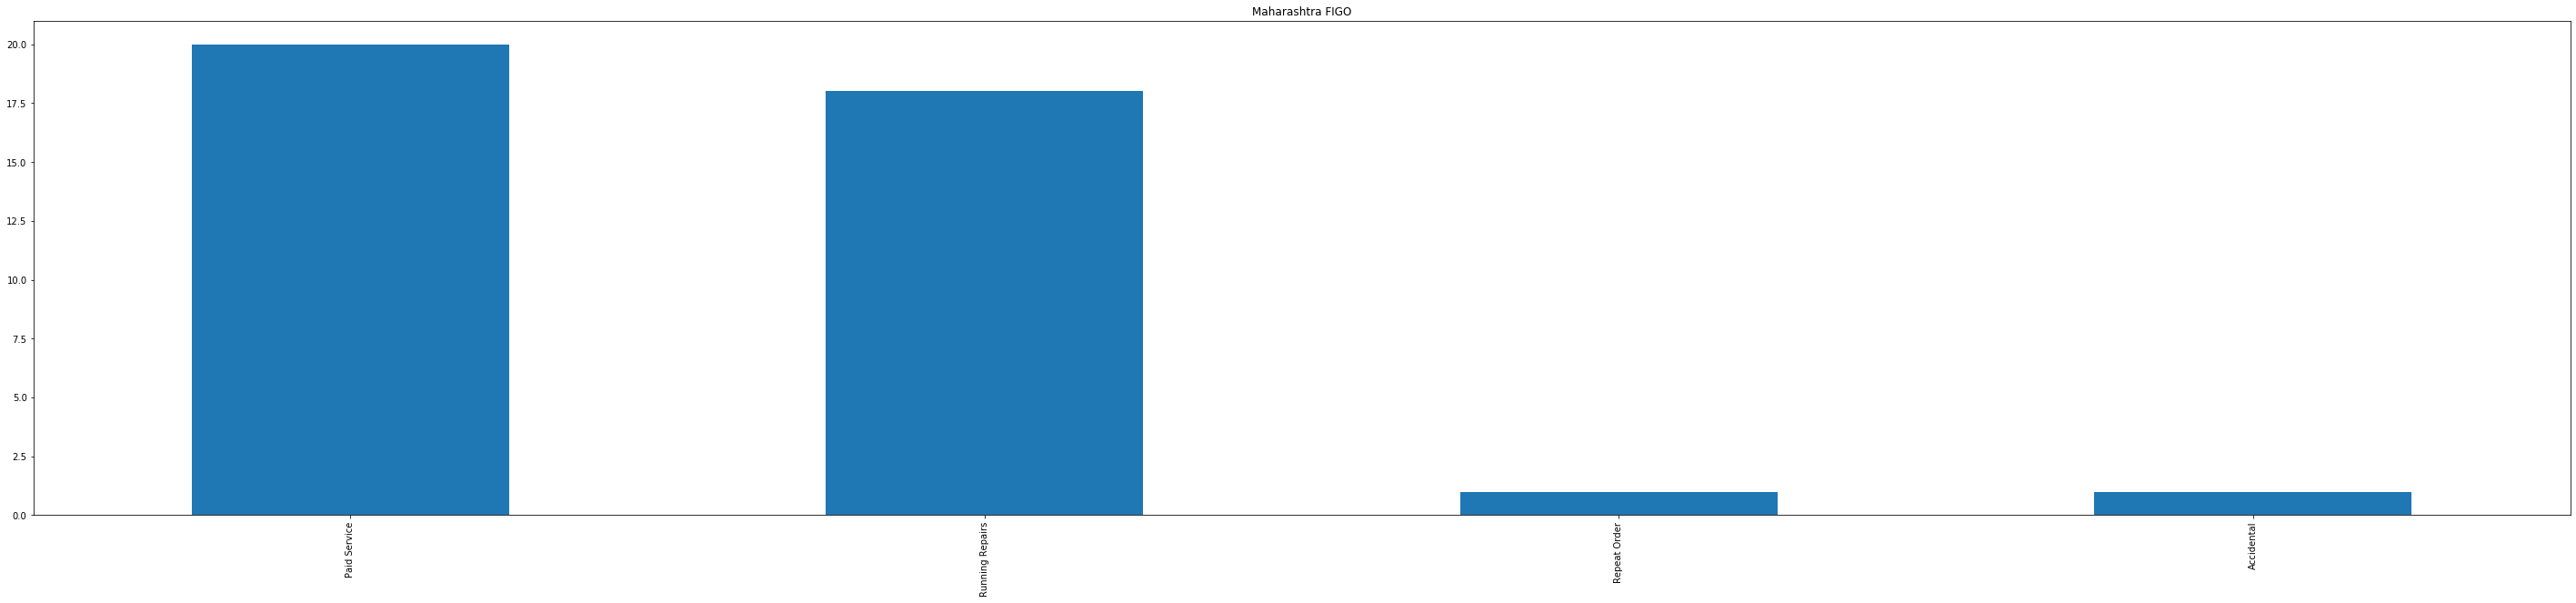

A STAR


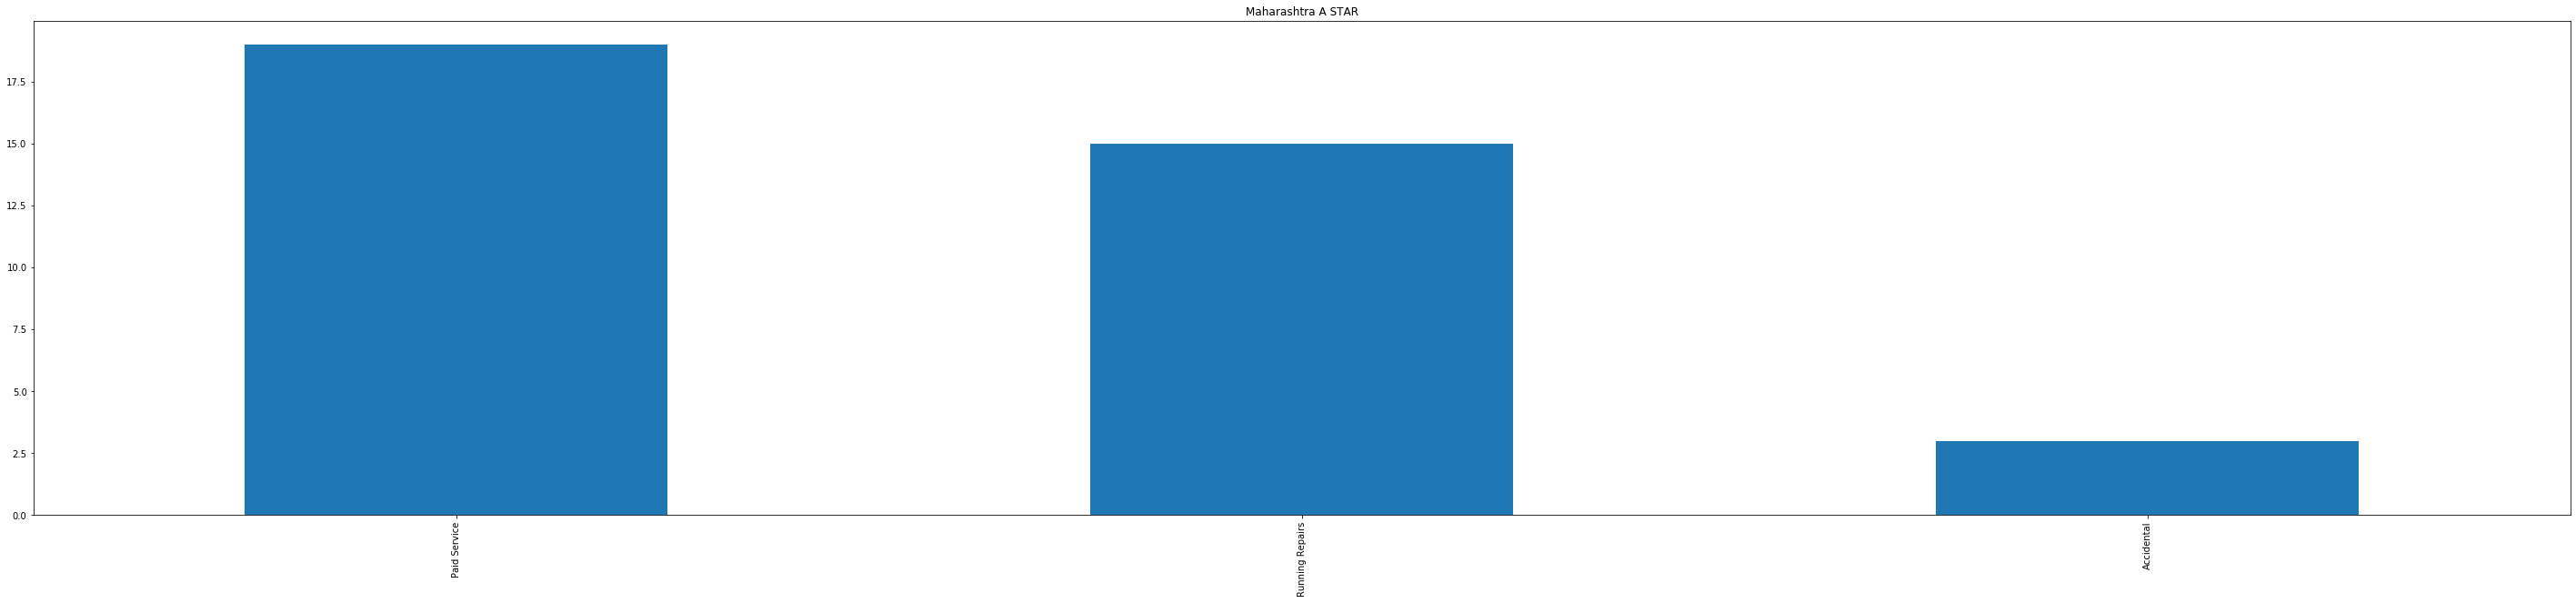

XYLO


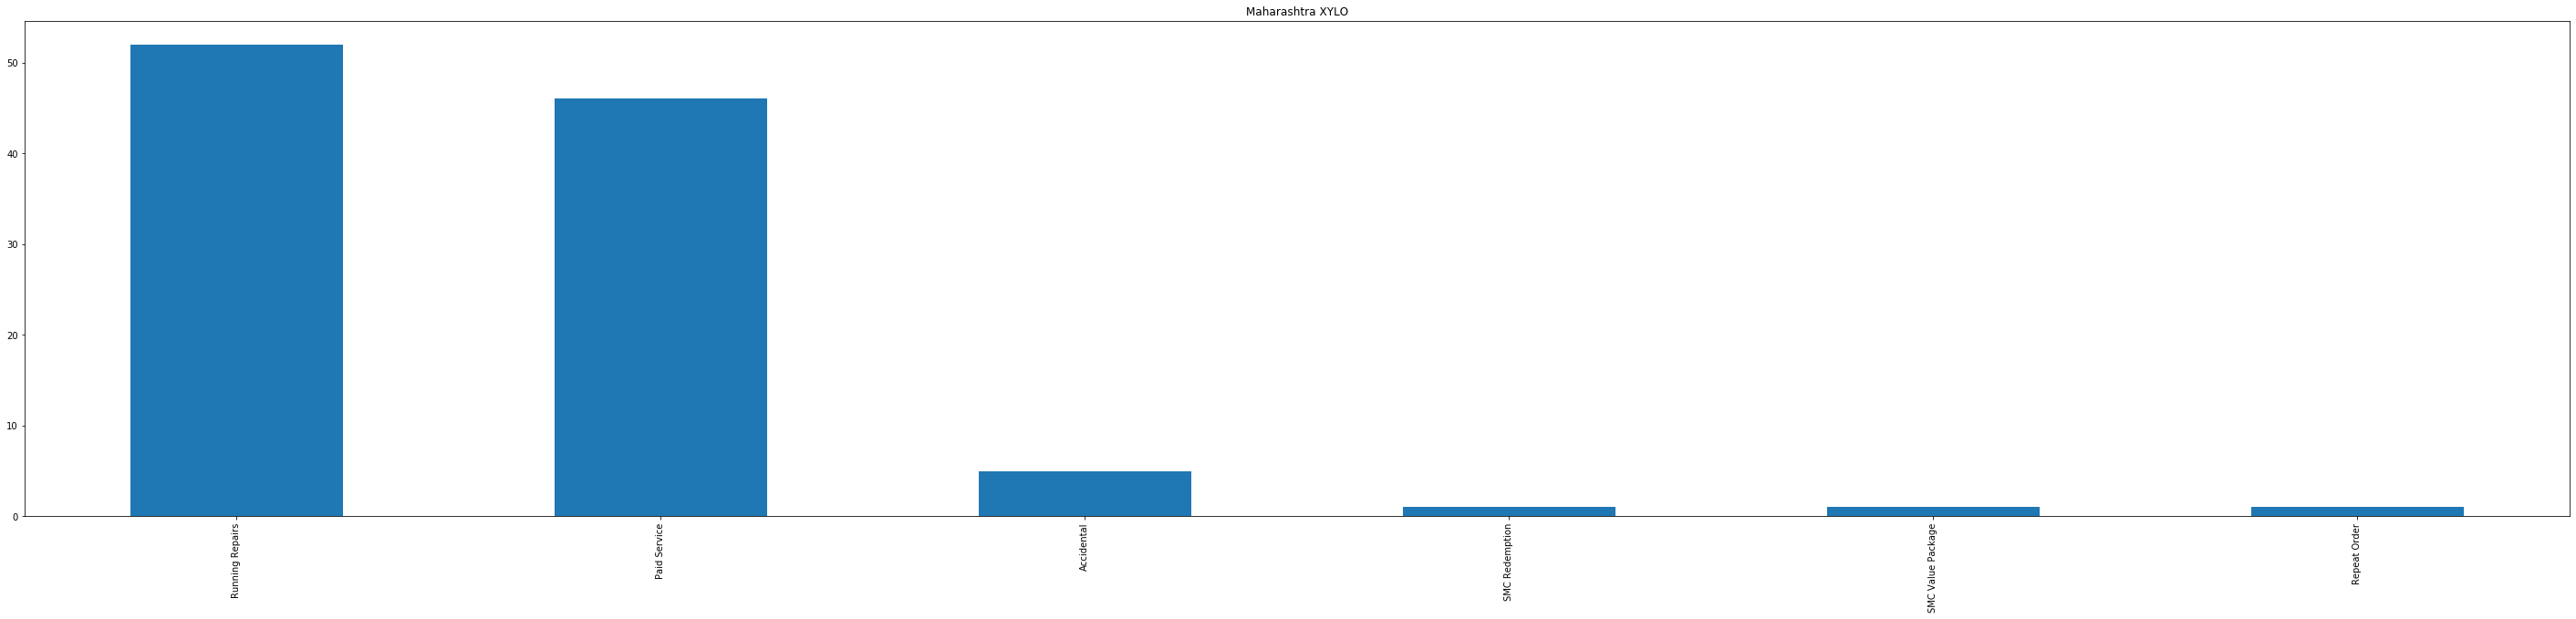

FABIA


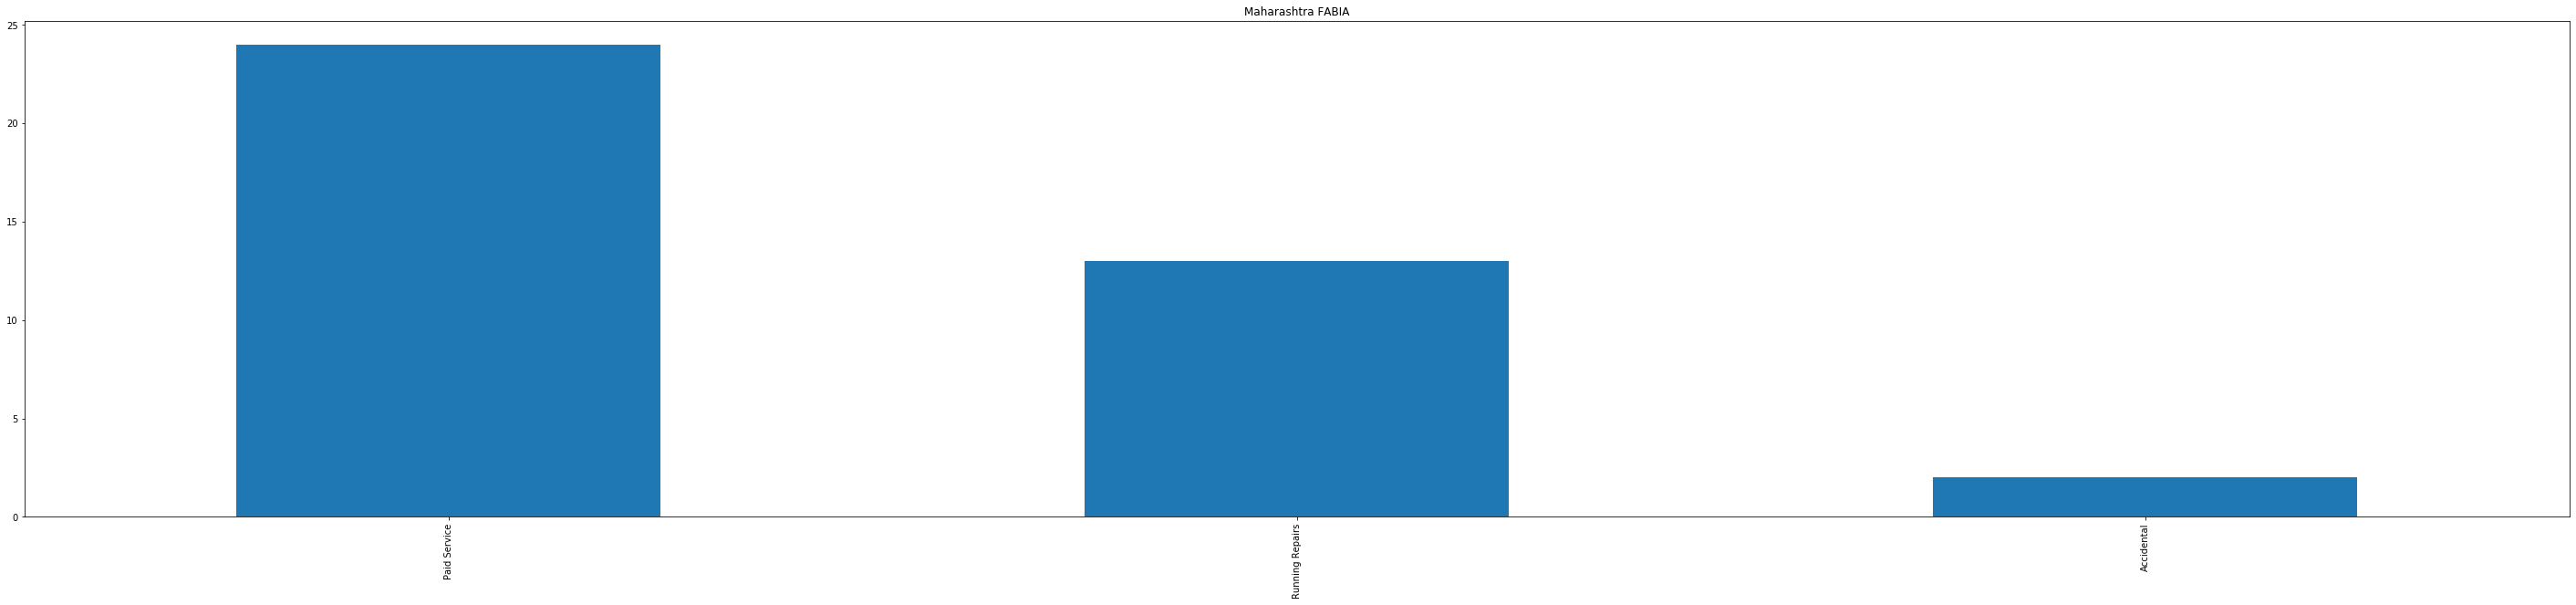

COROLLA


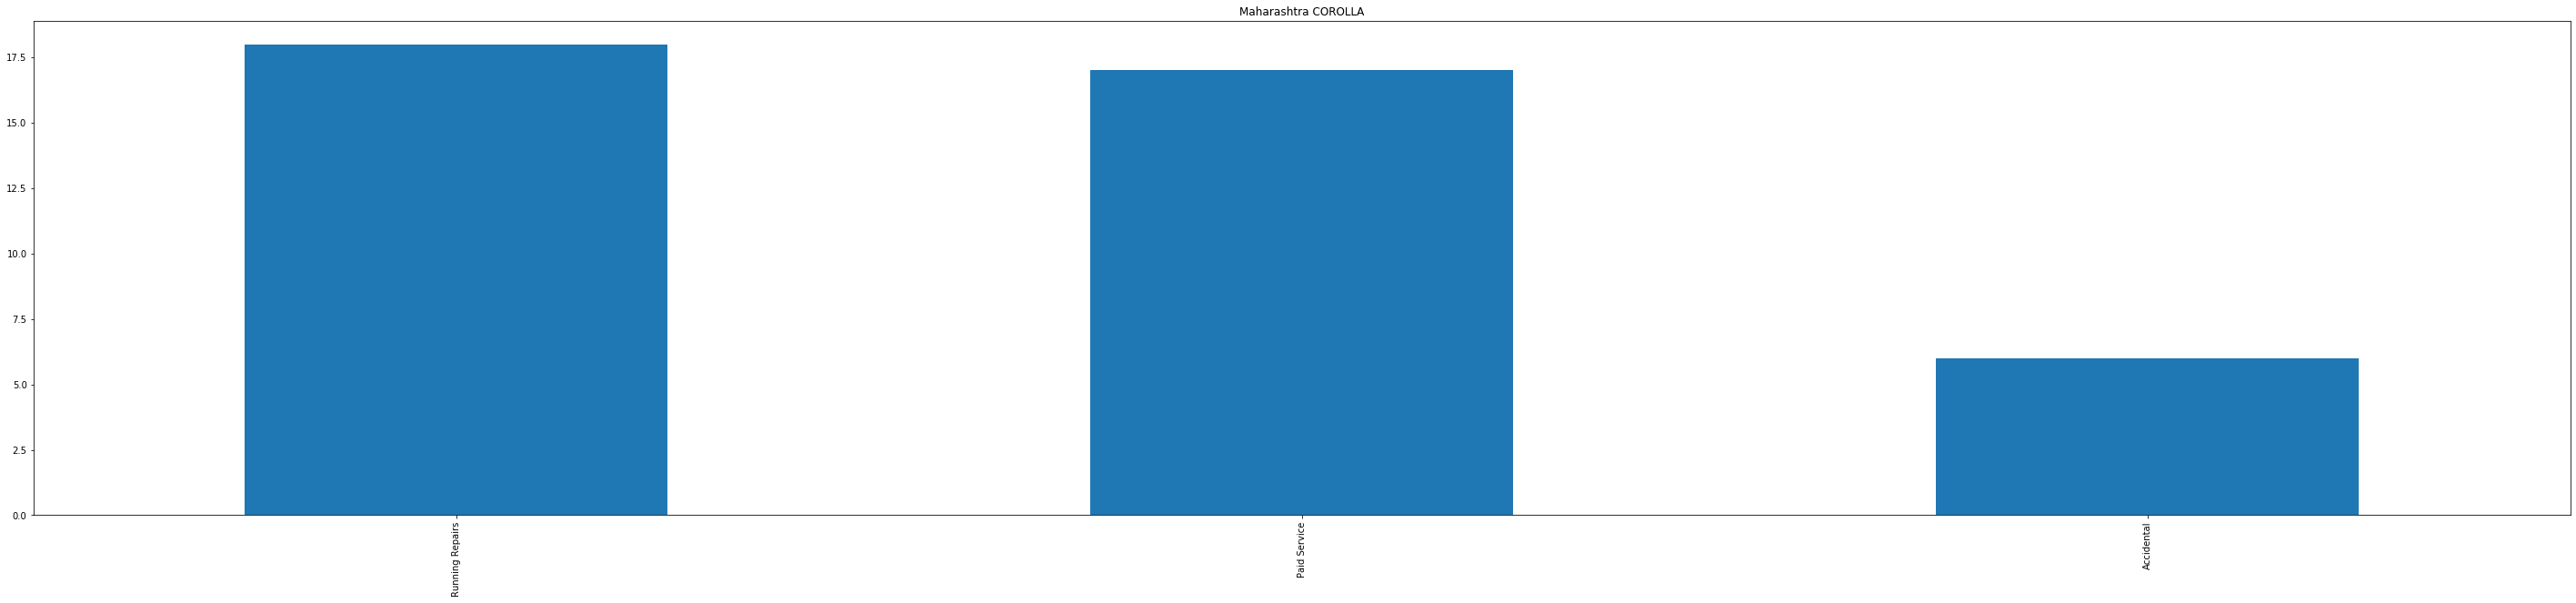

AVEO


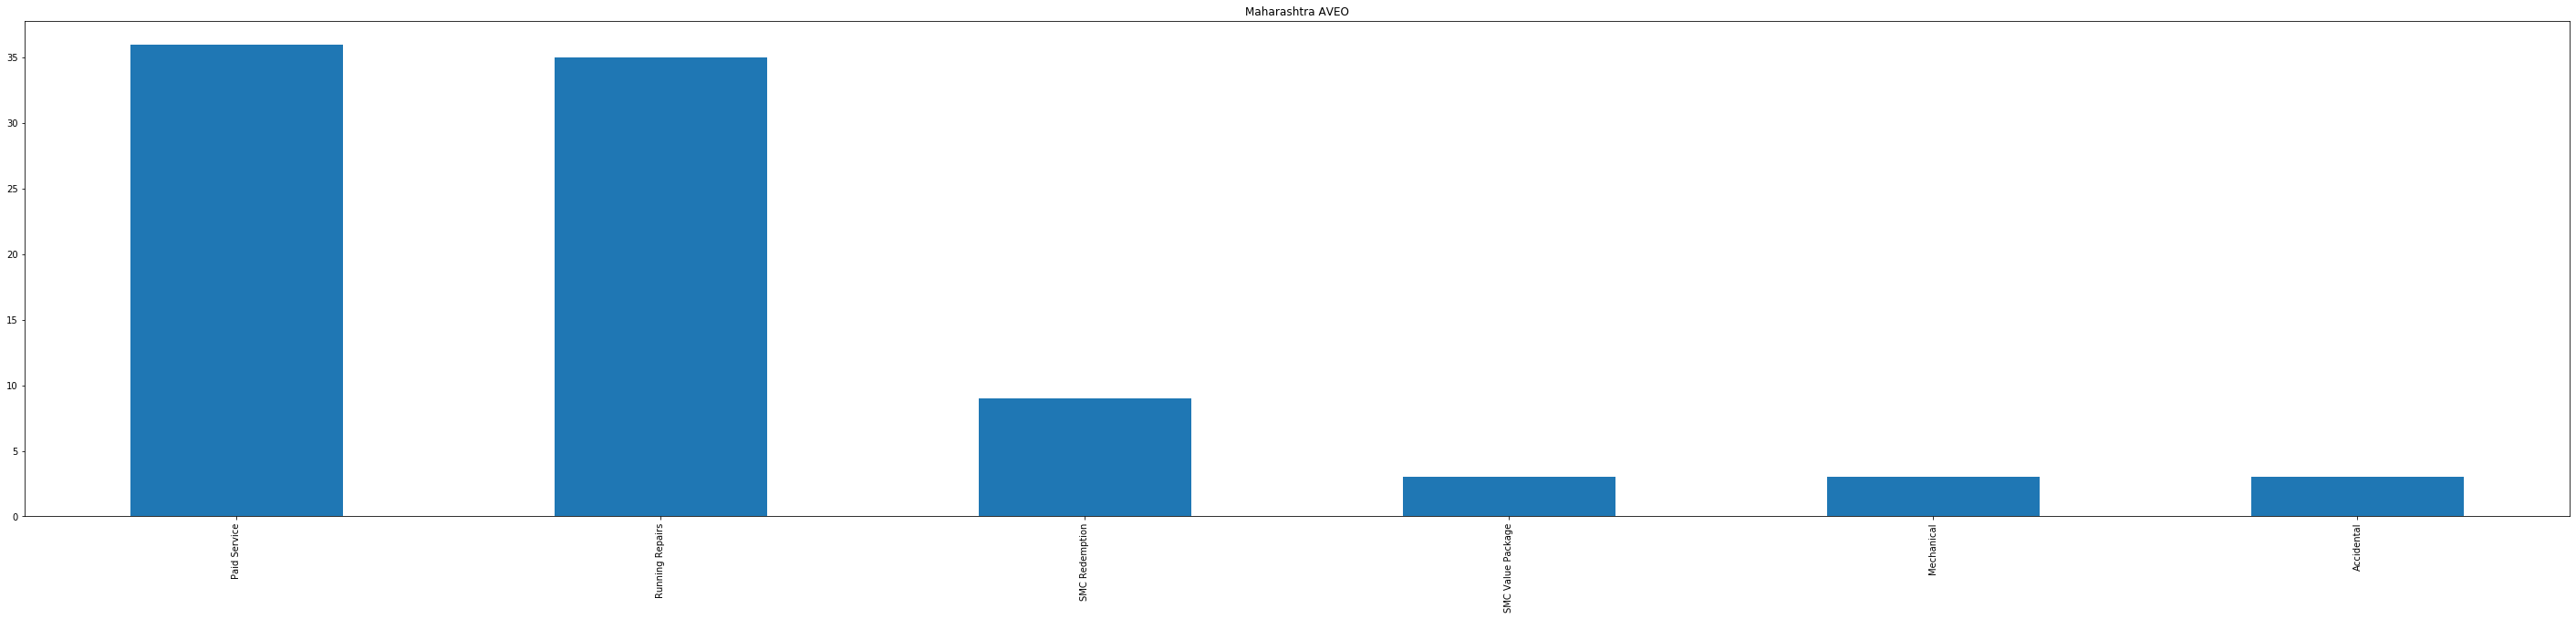

RITZ


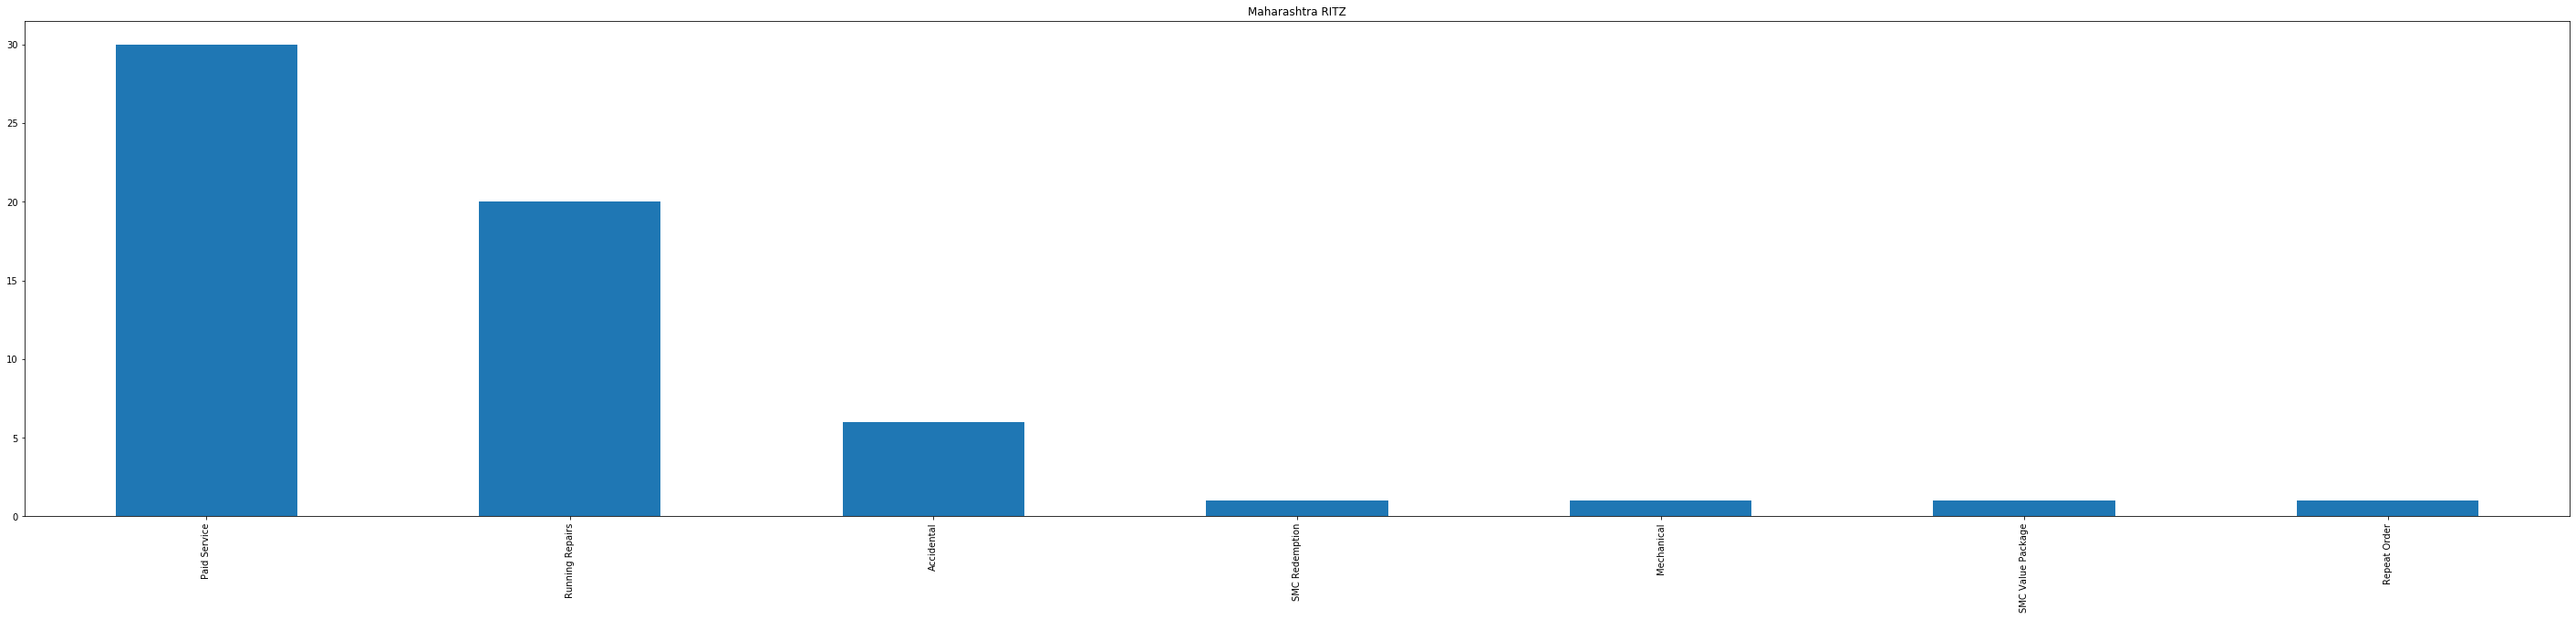

ARMADA


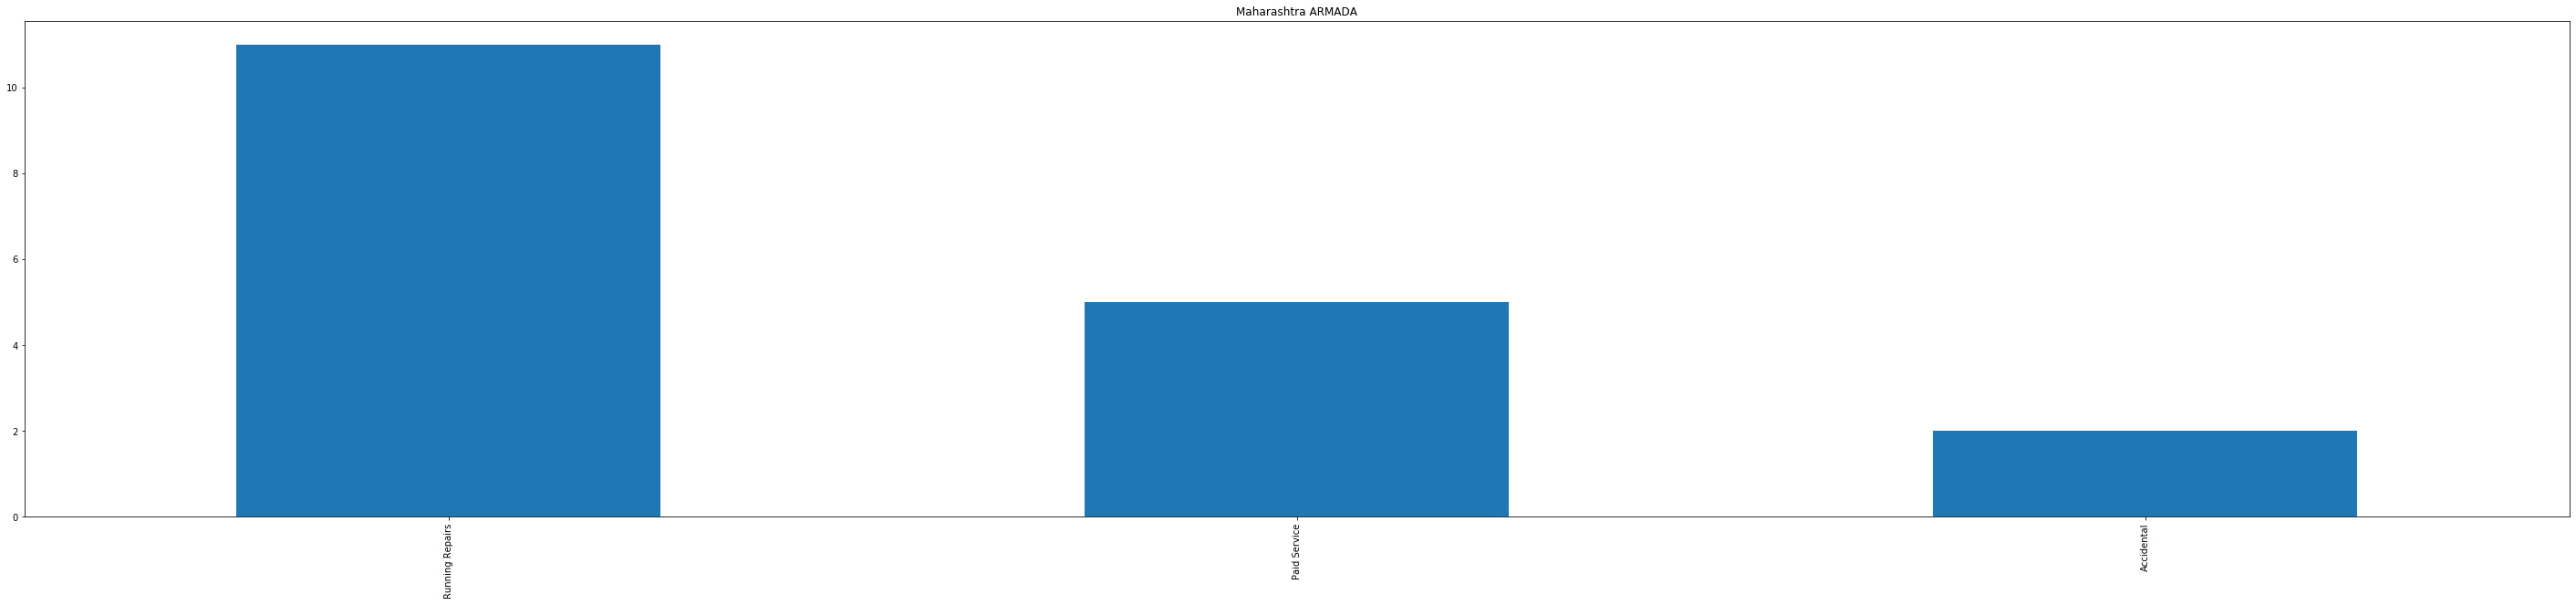

VENTO


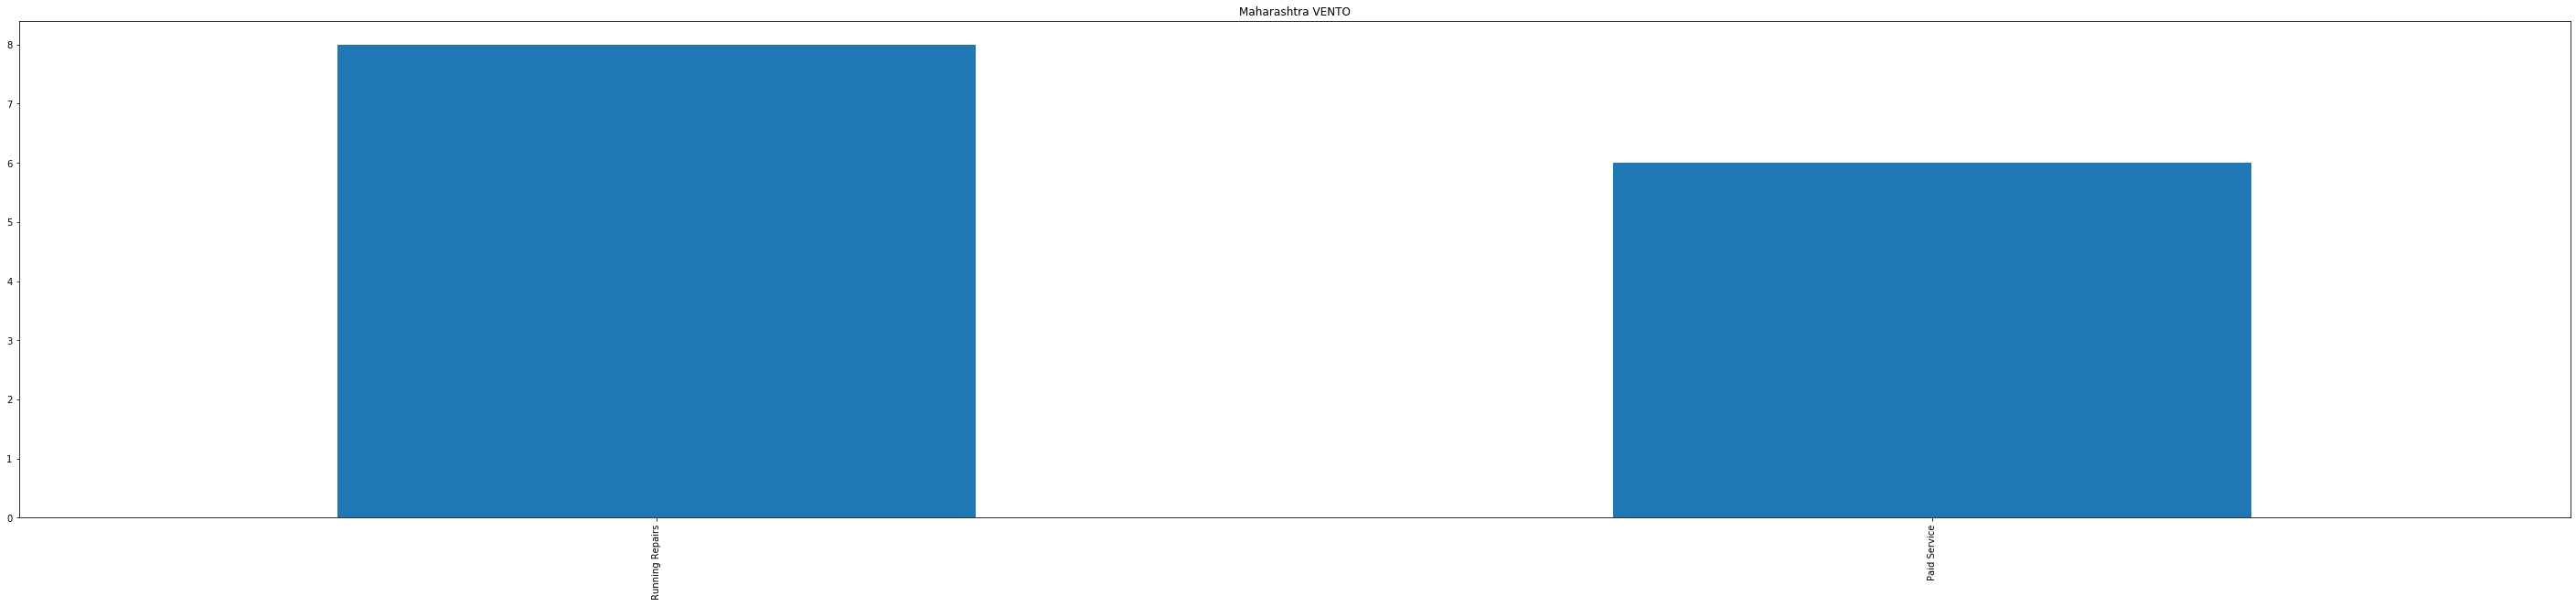

XUV 500


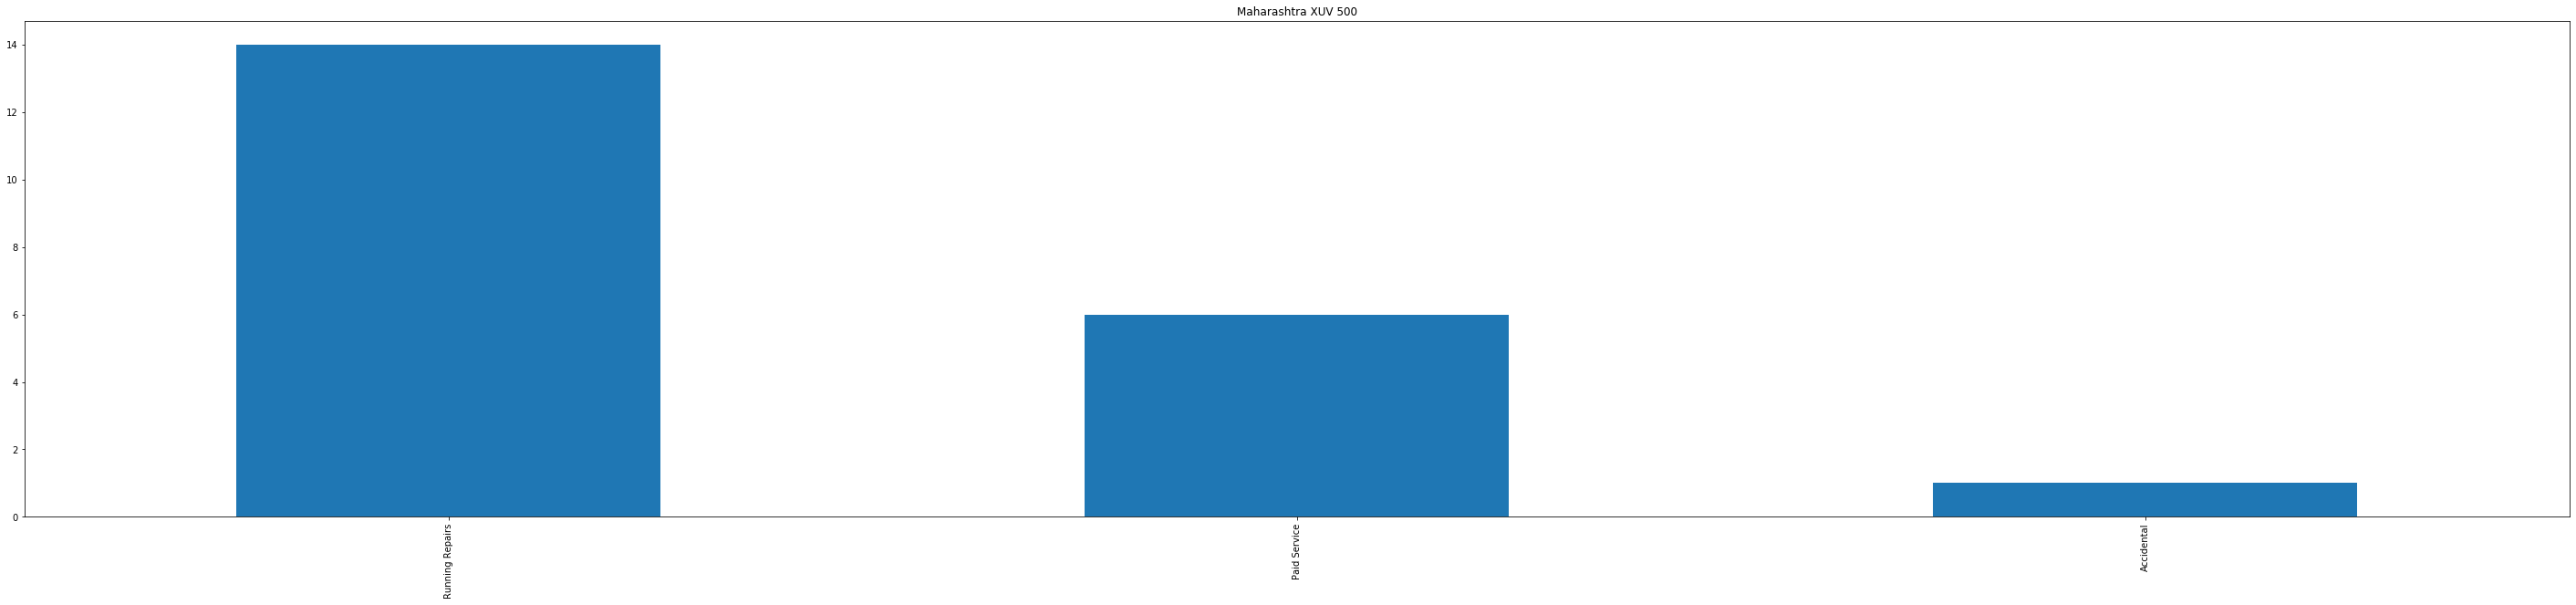

TUCSON


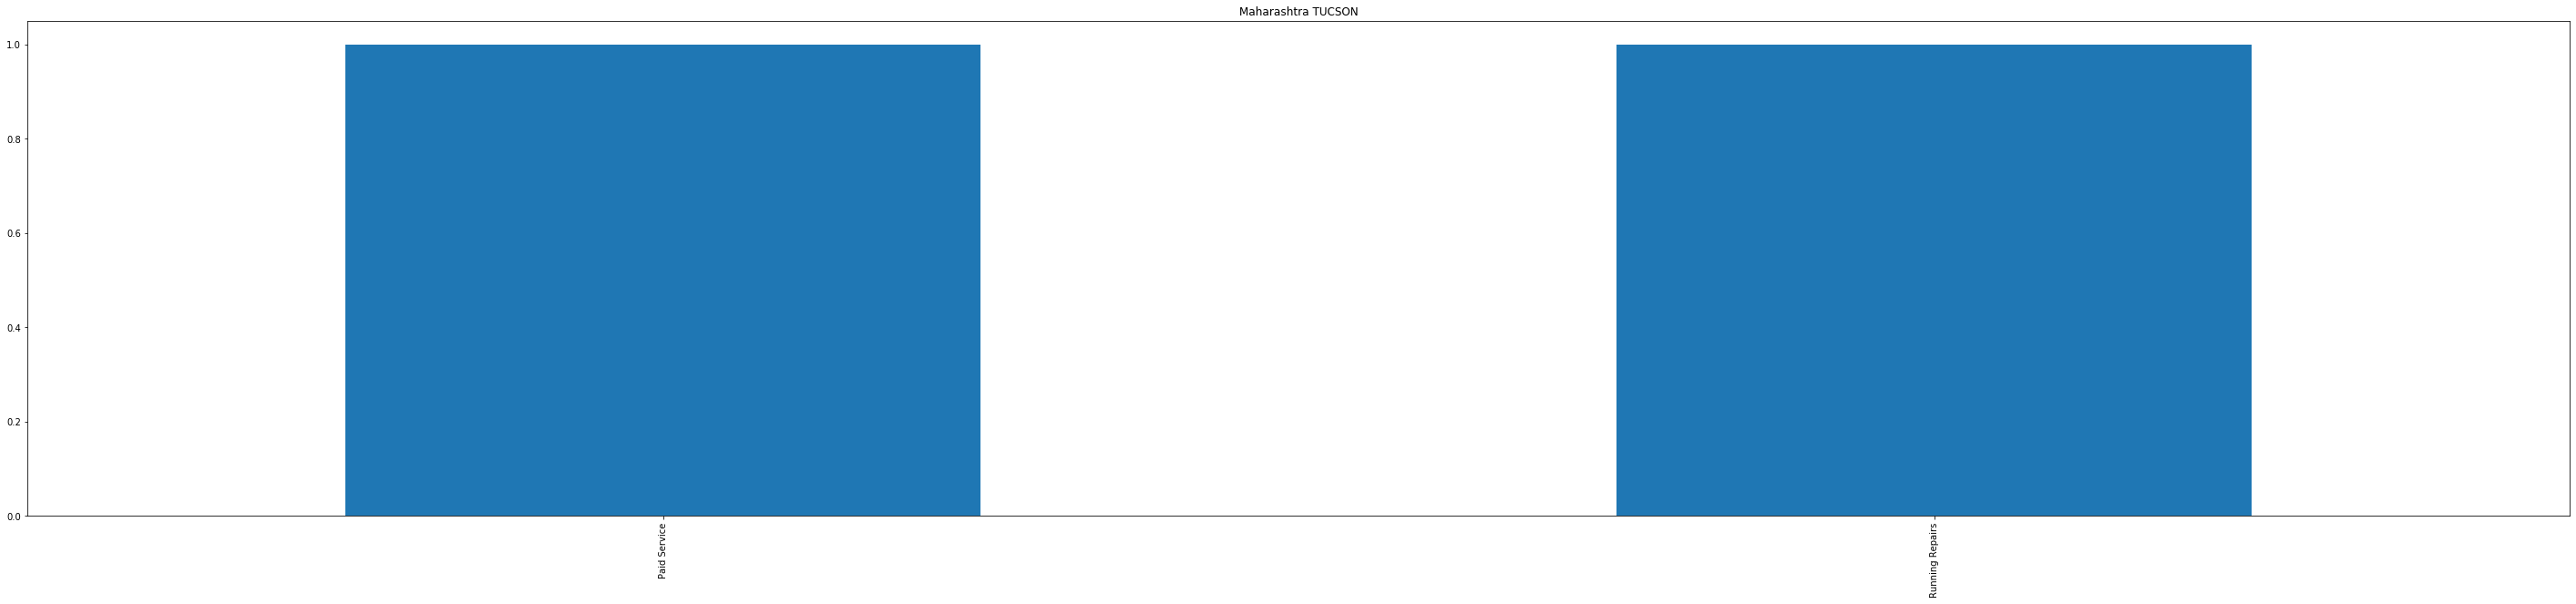

QUALIS


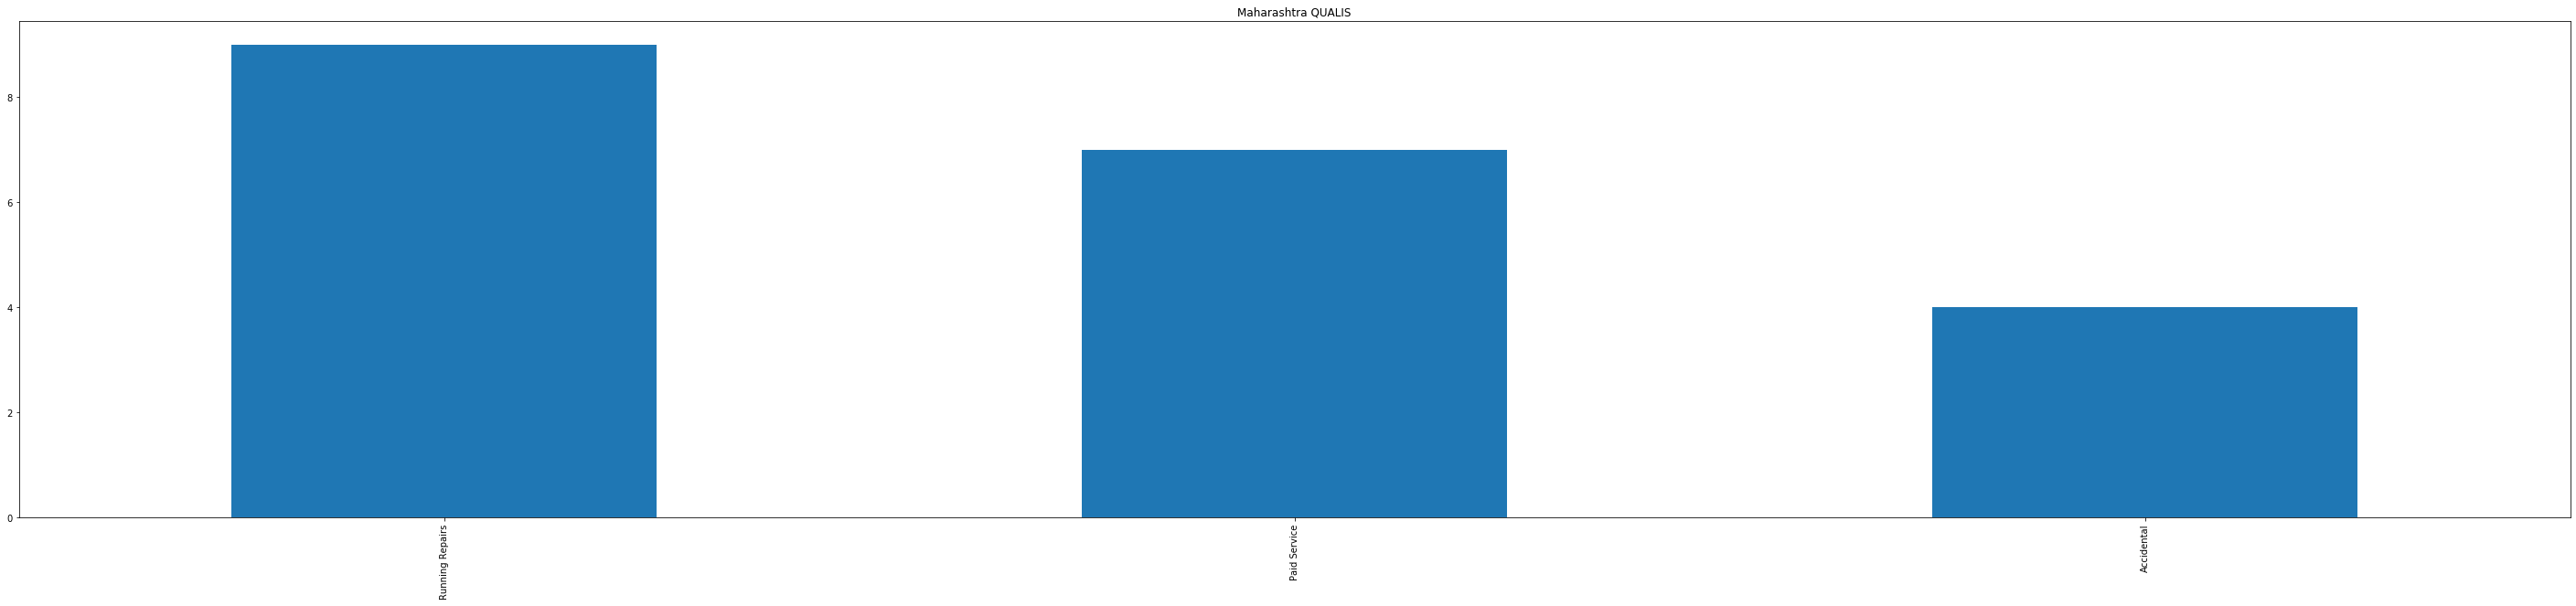

FUSION


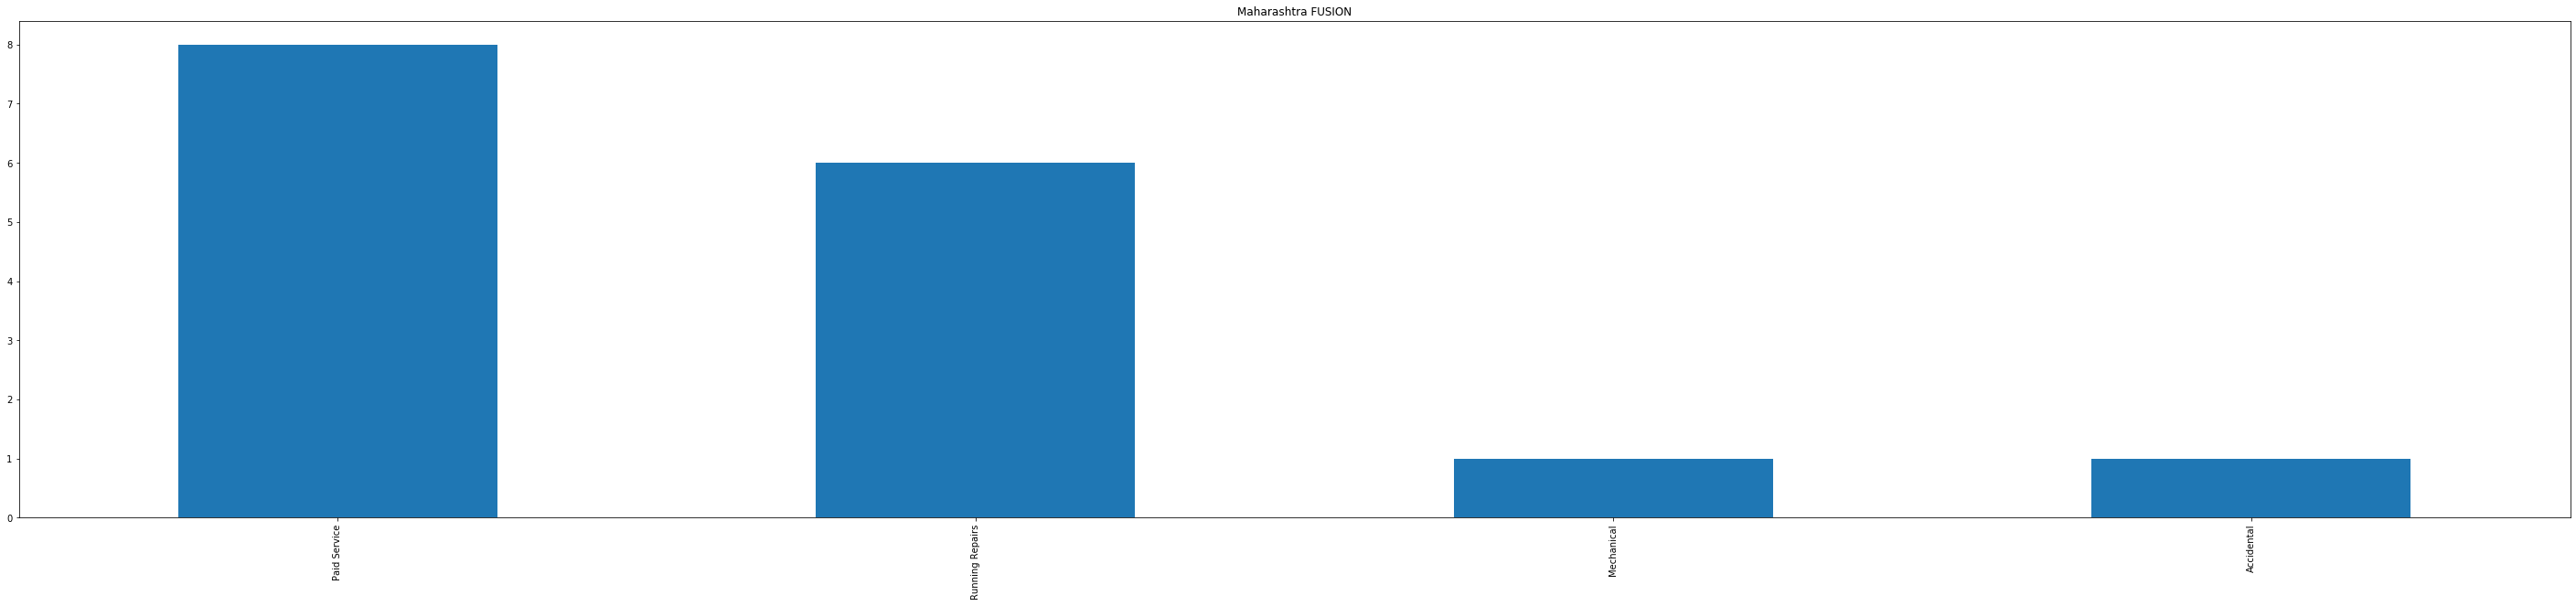

COROLLA ALTIS


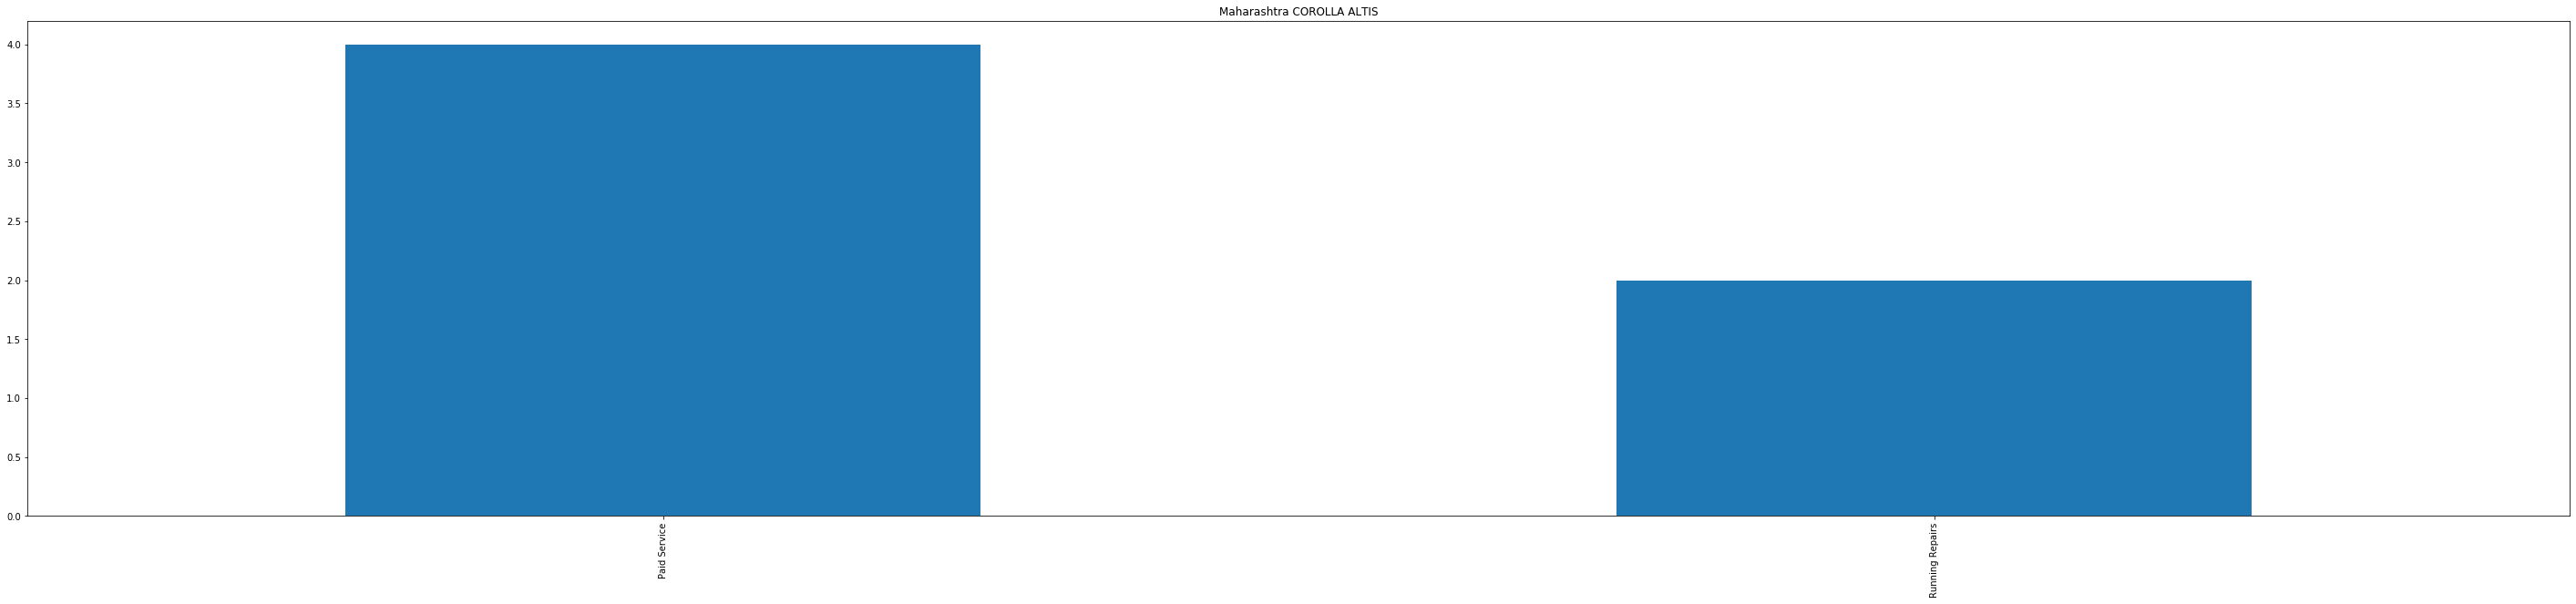

ESTEEM 1300


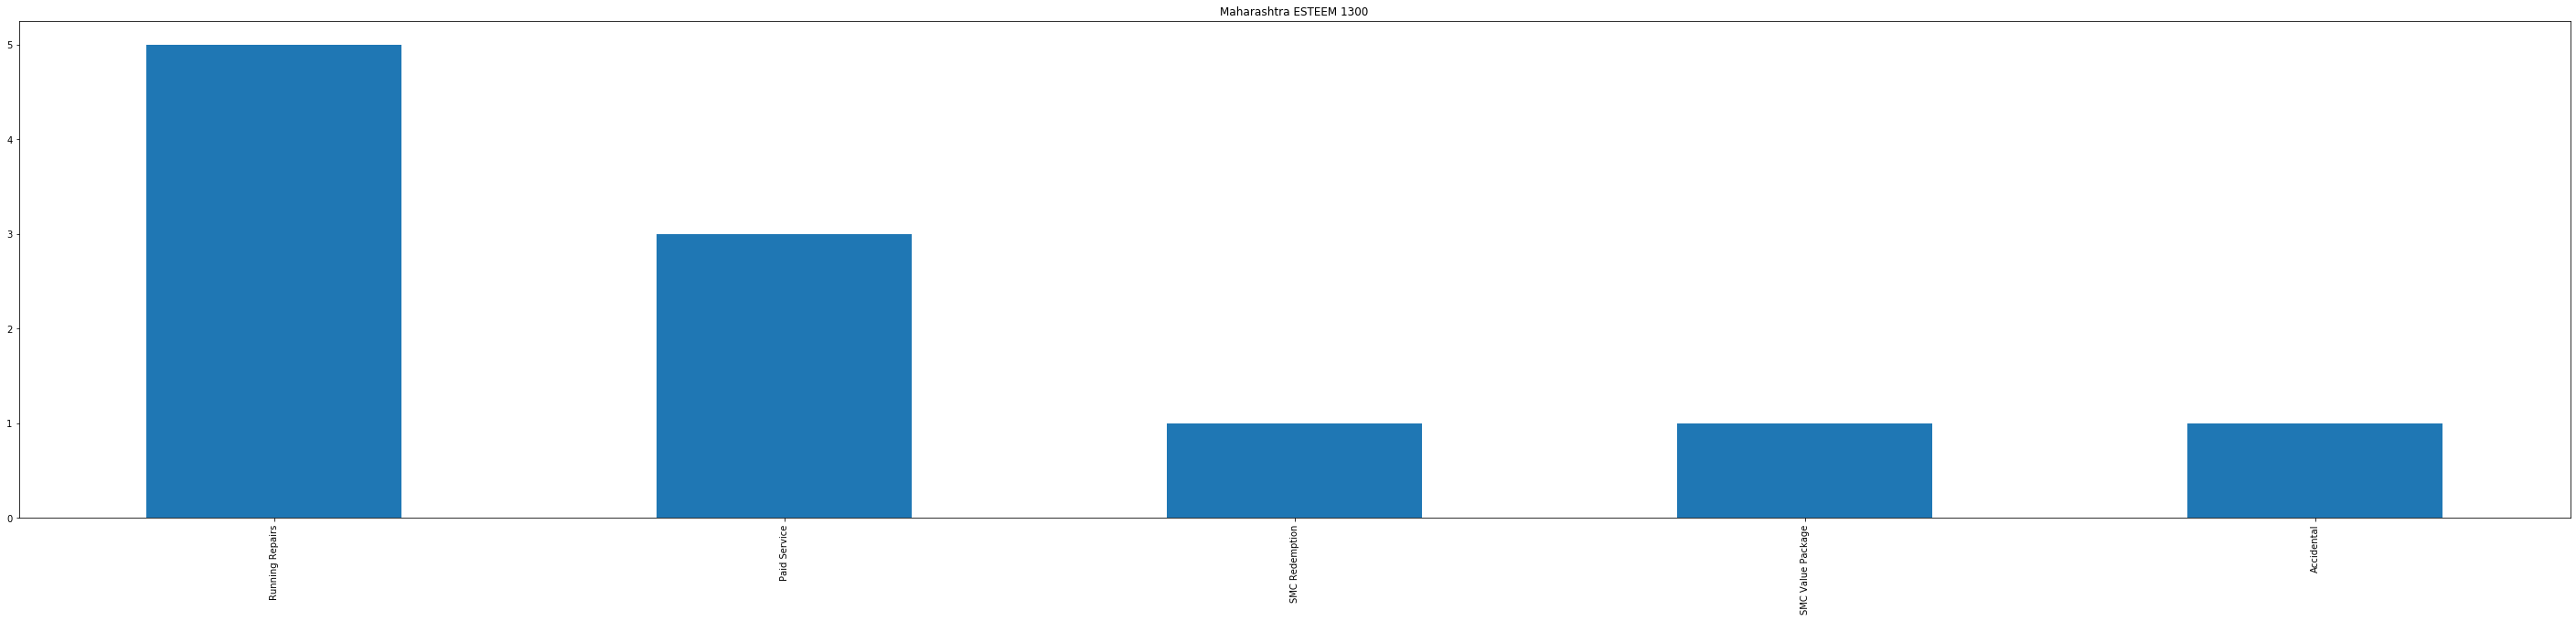

PAJERO


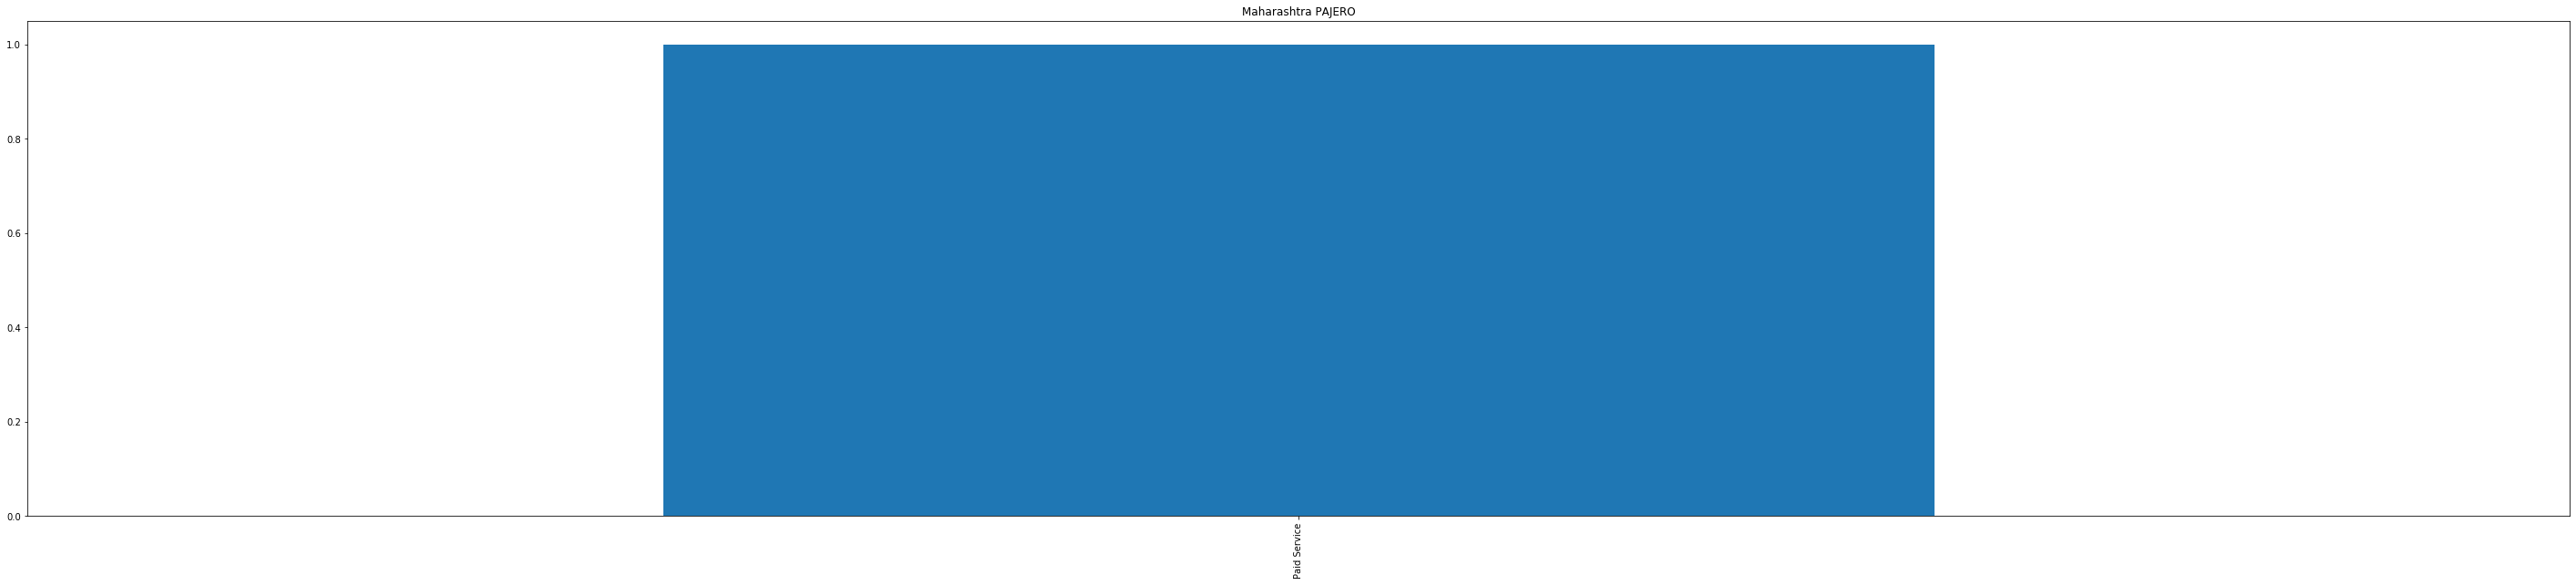

207


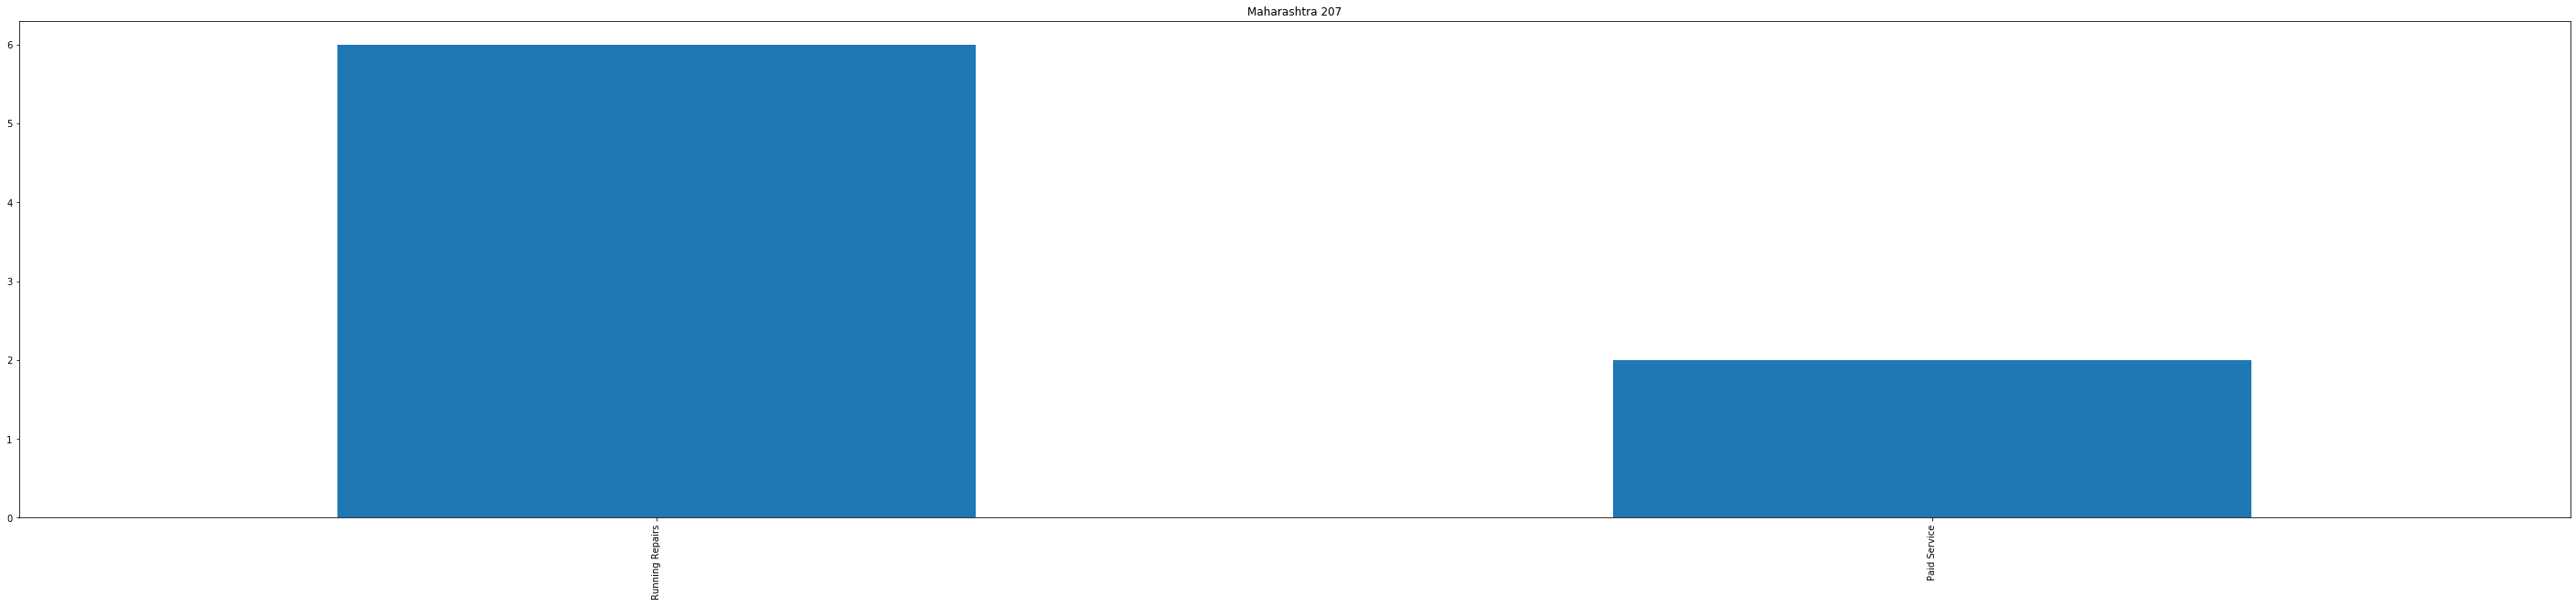

MARSHAL


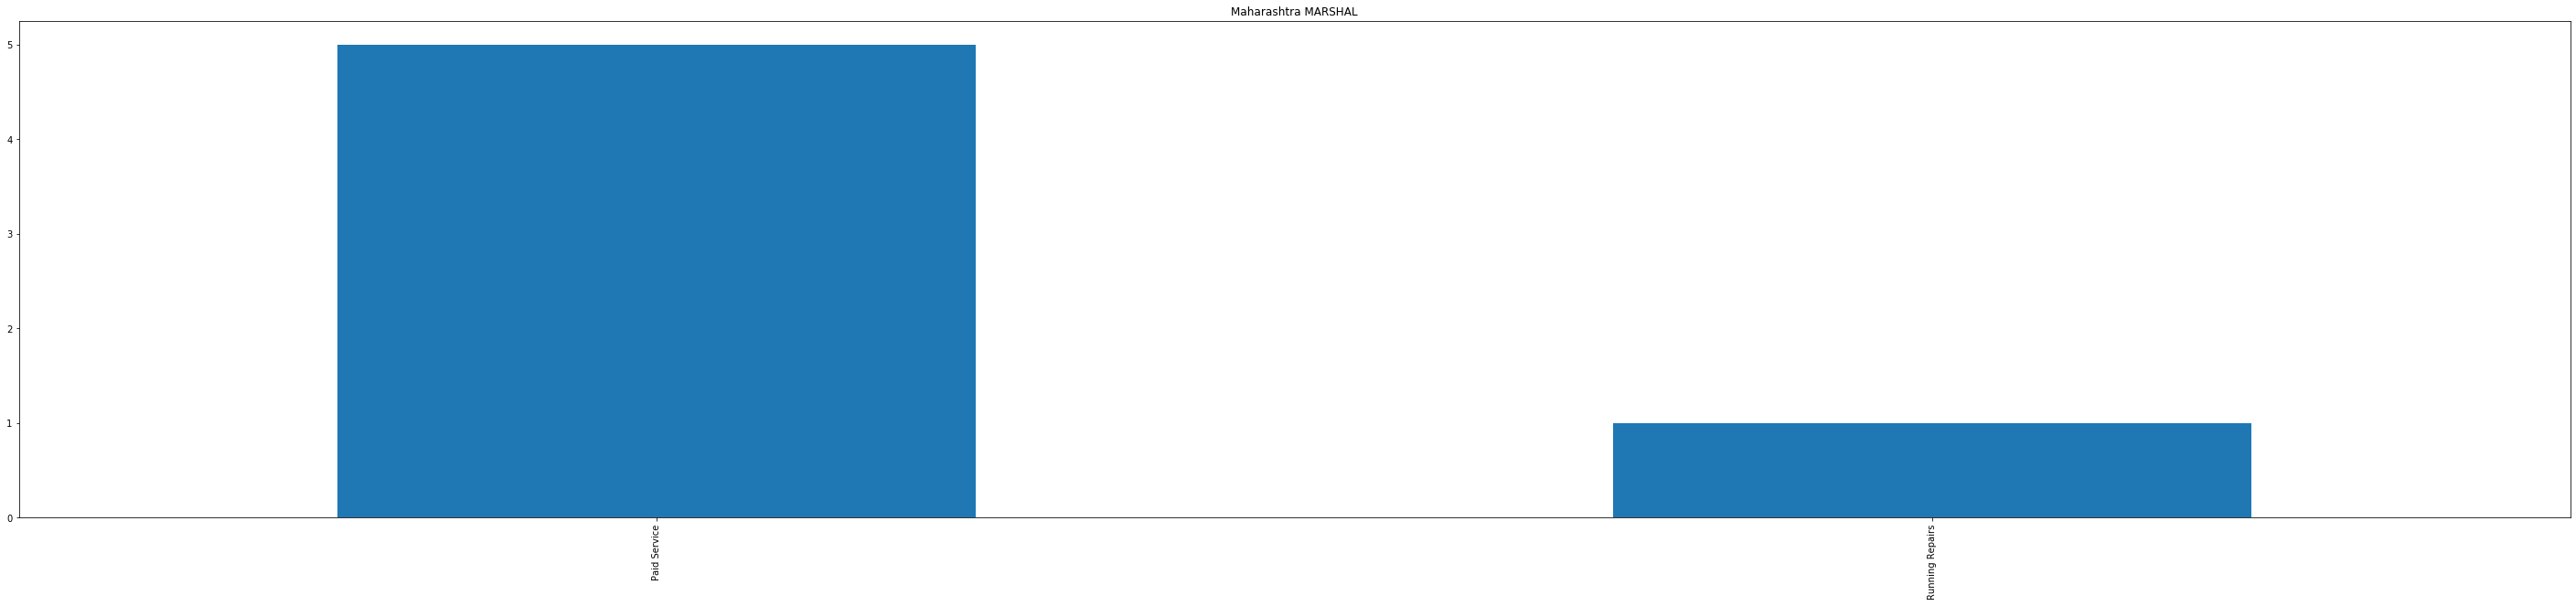

ELANTRA


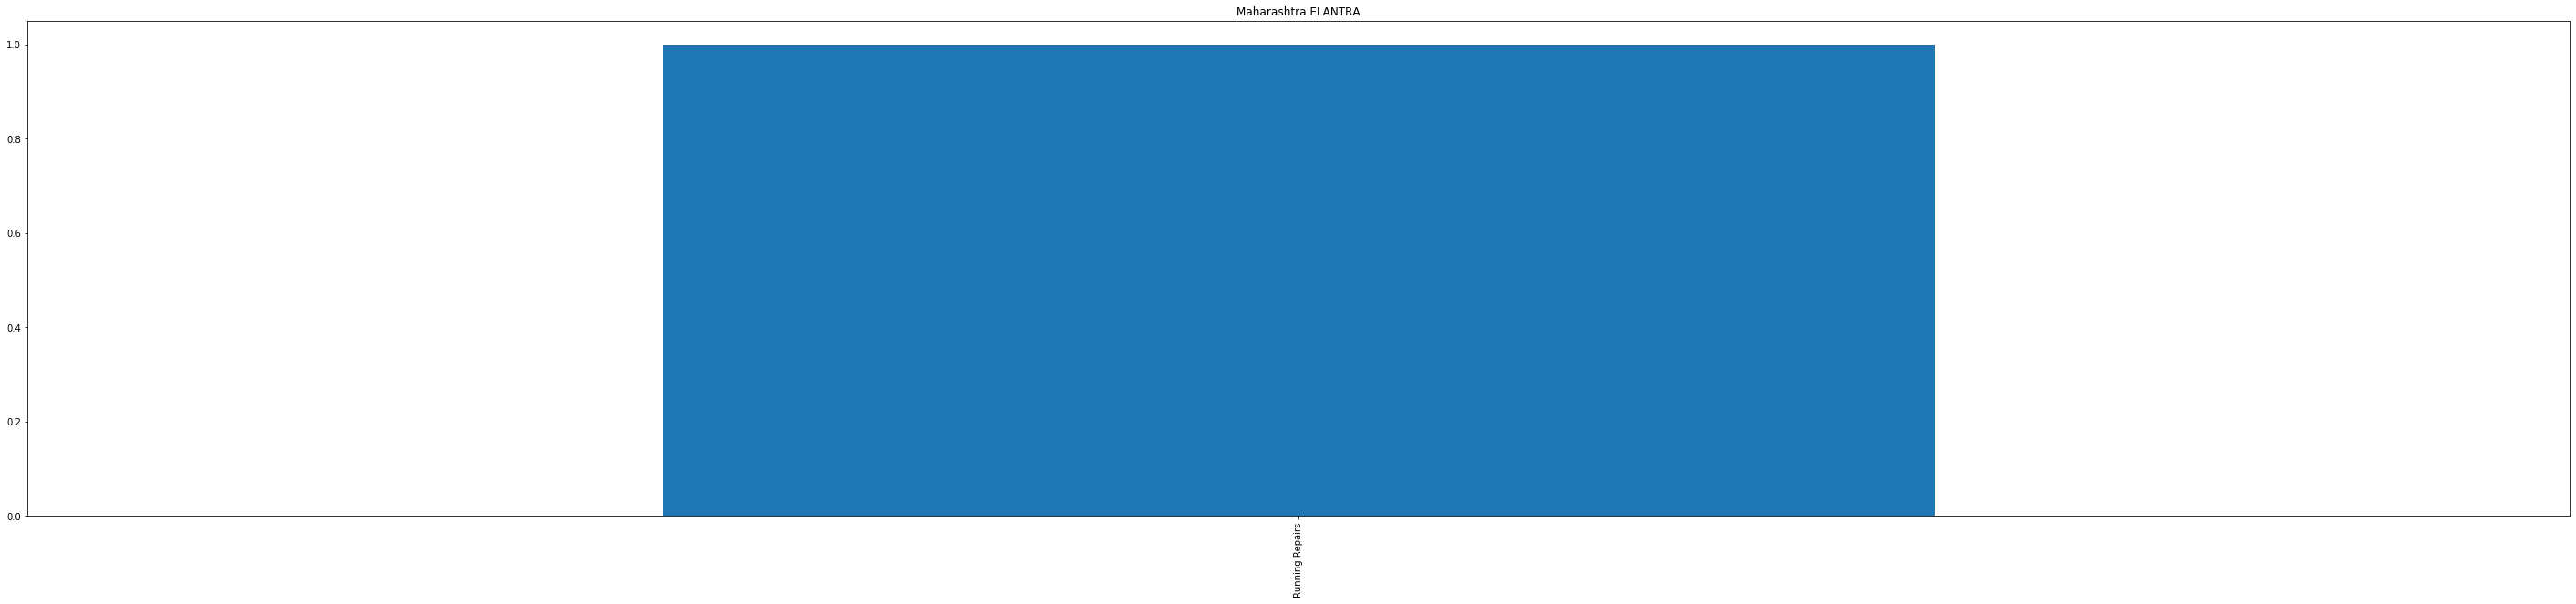

AMAZE


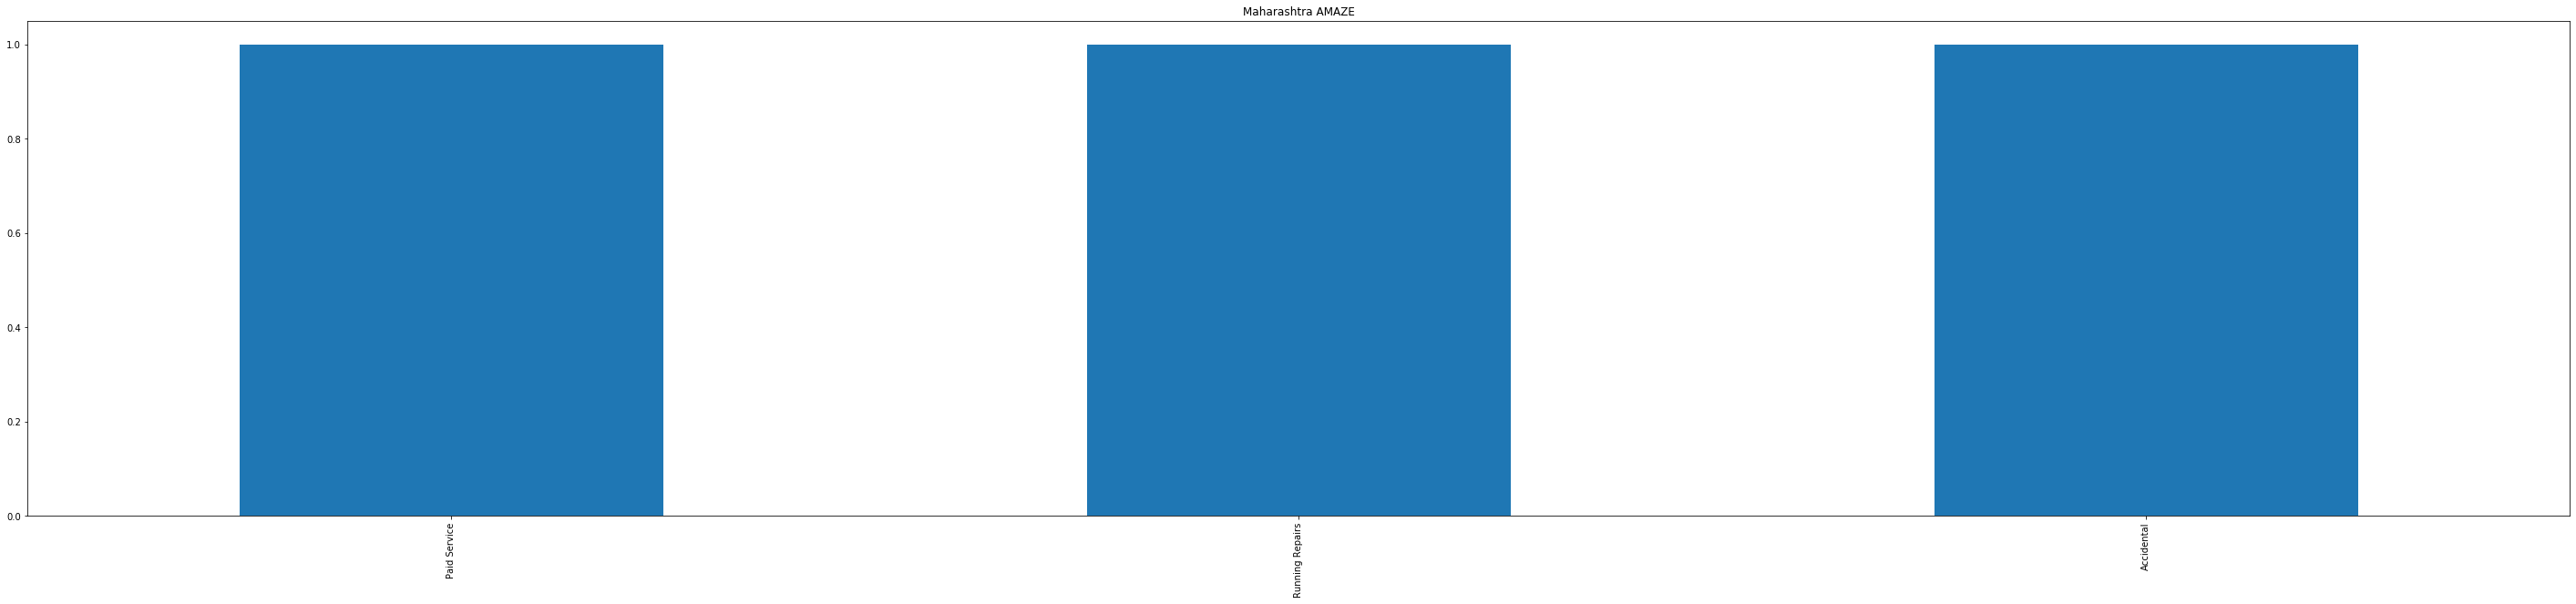

MONDEO


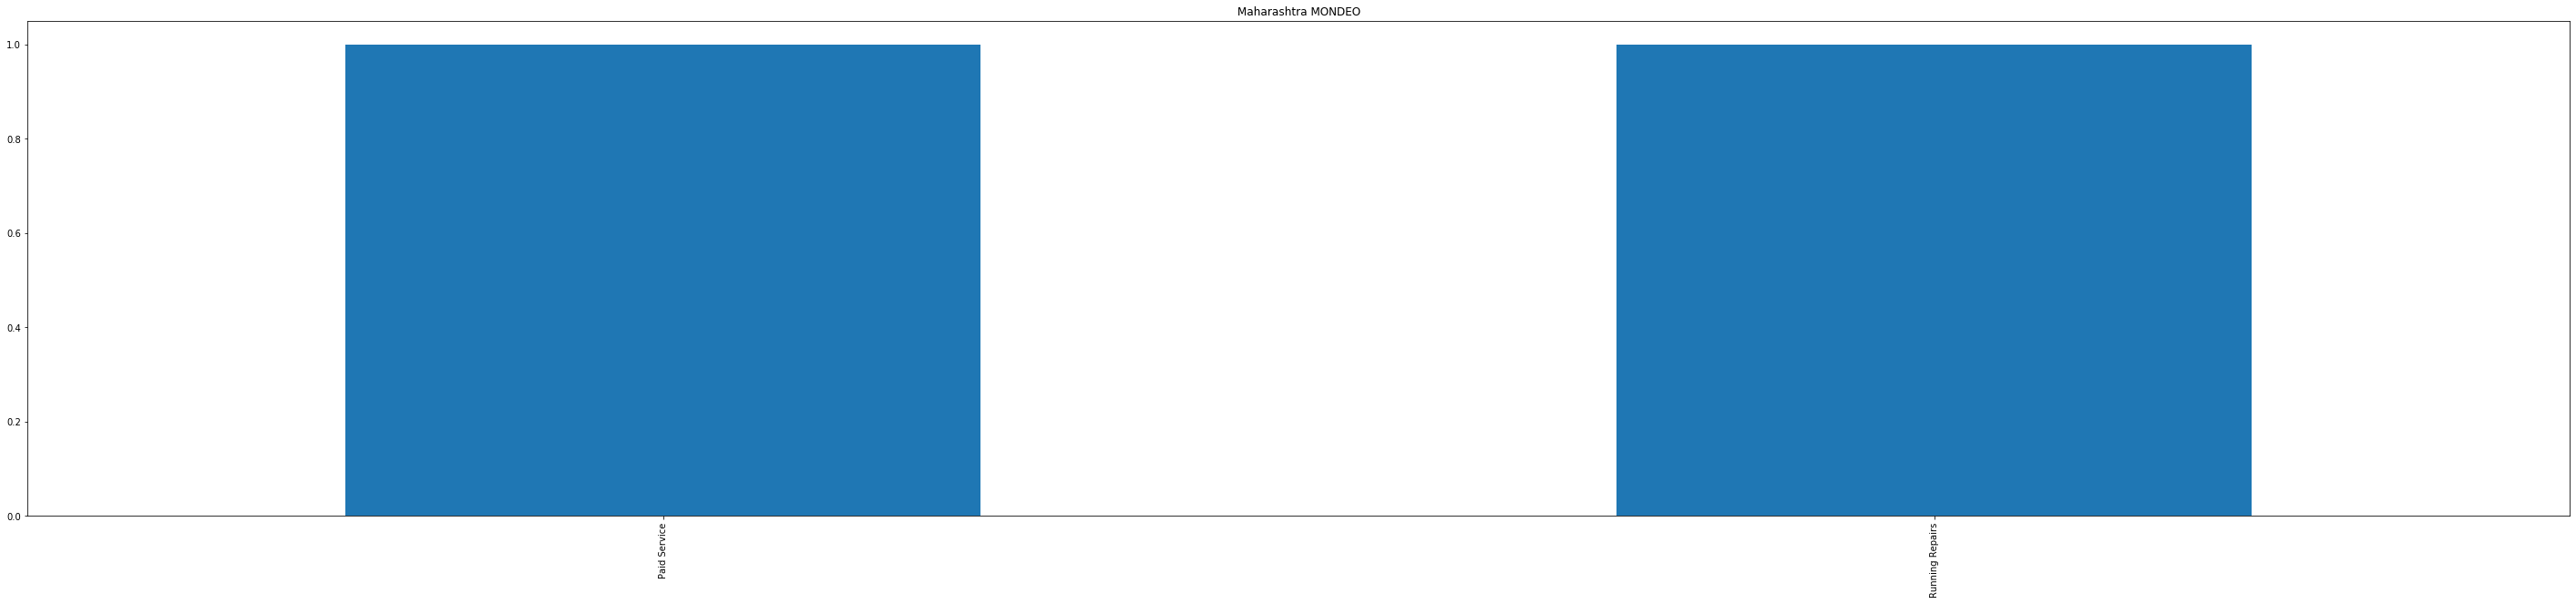

BMW-M5


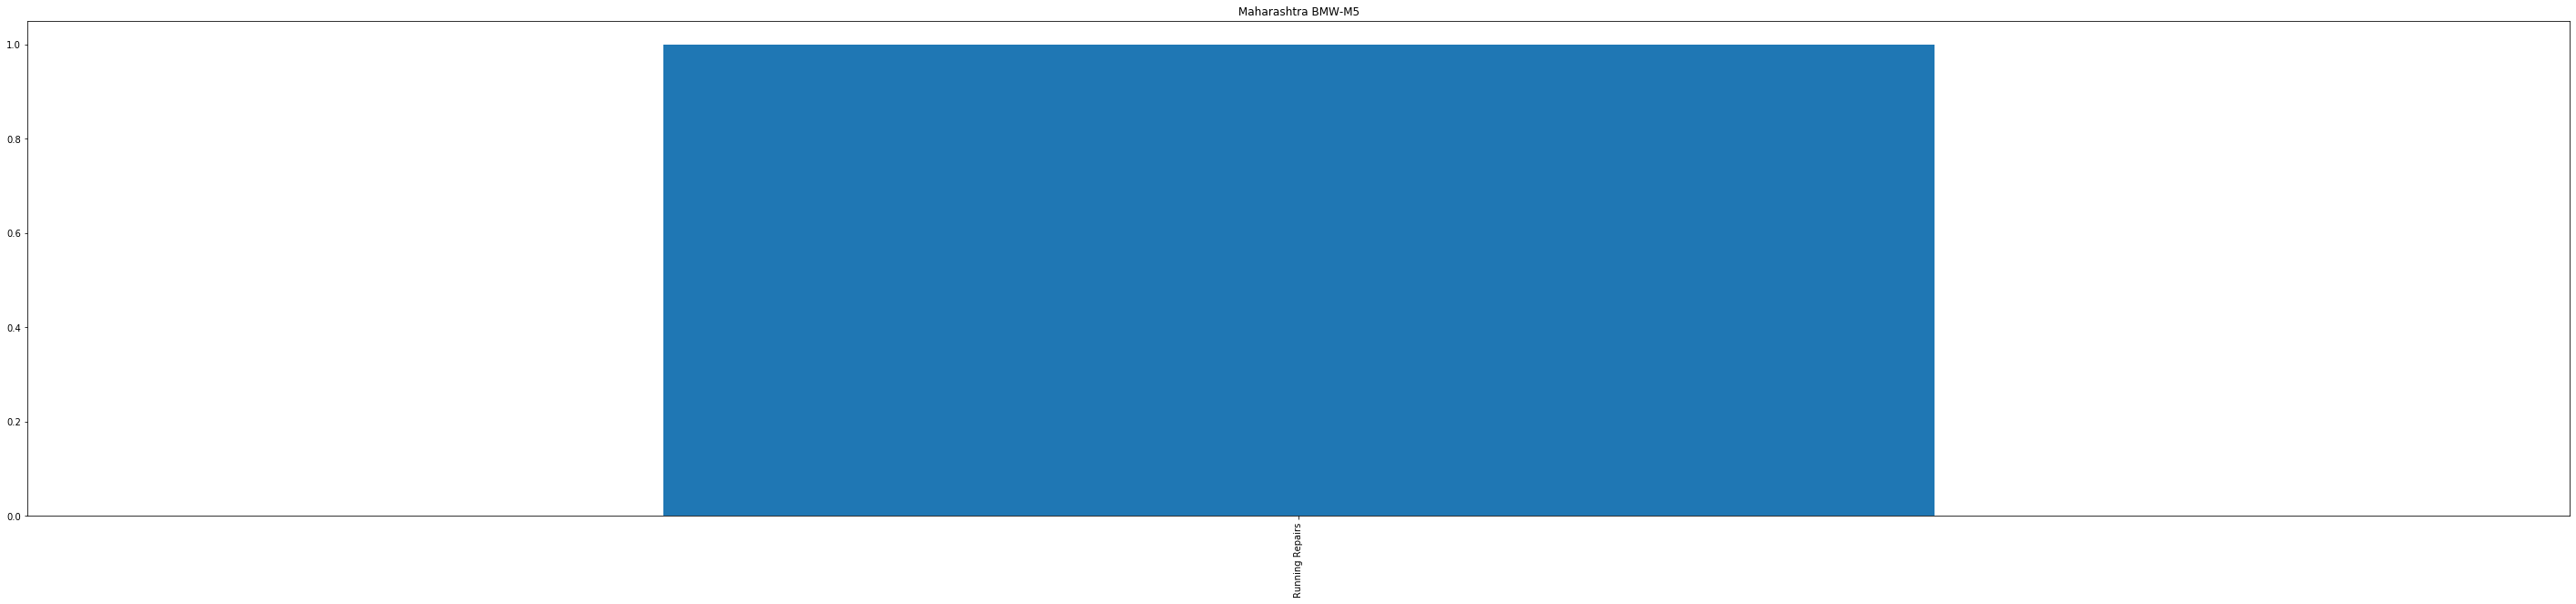

CAPTIVA


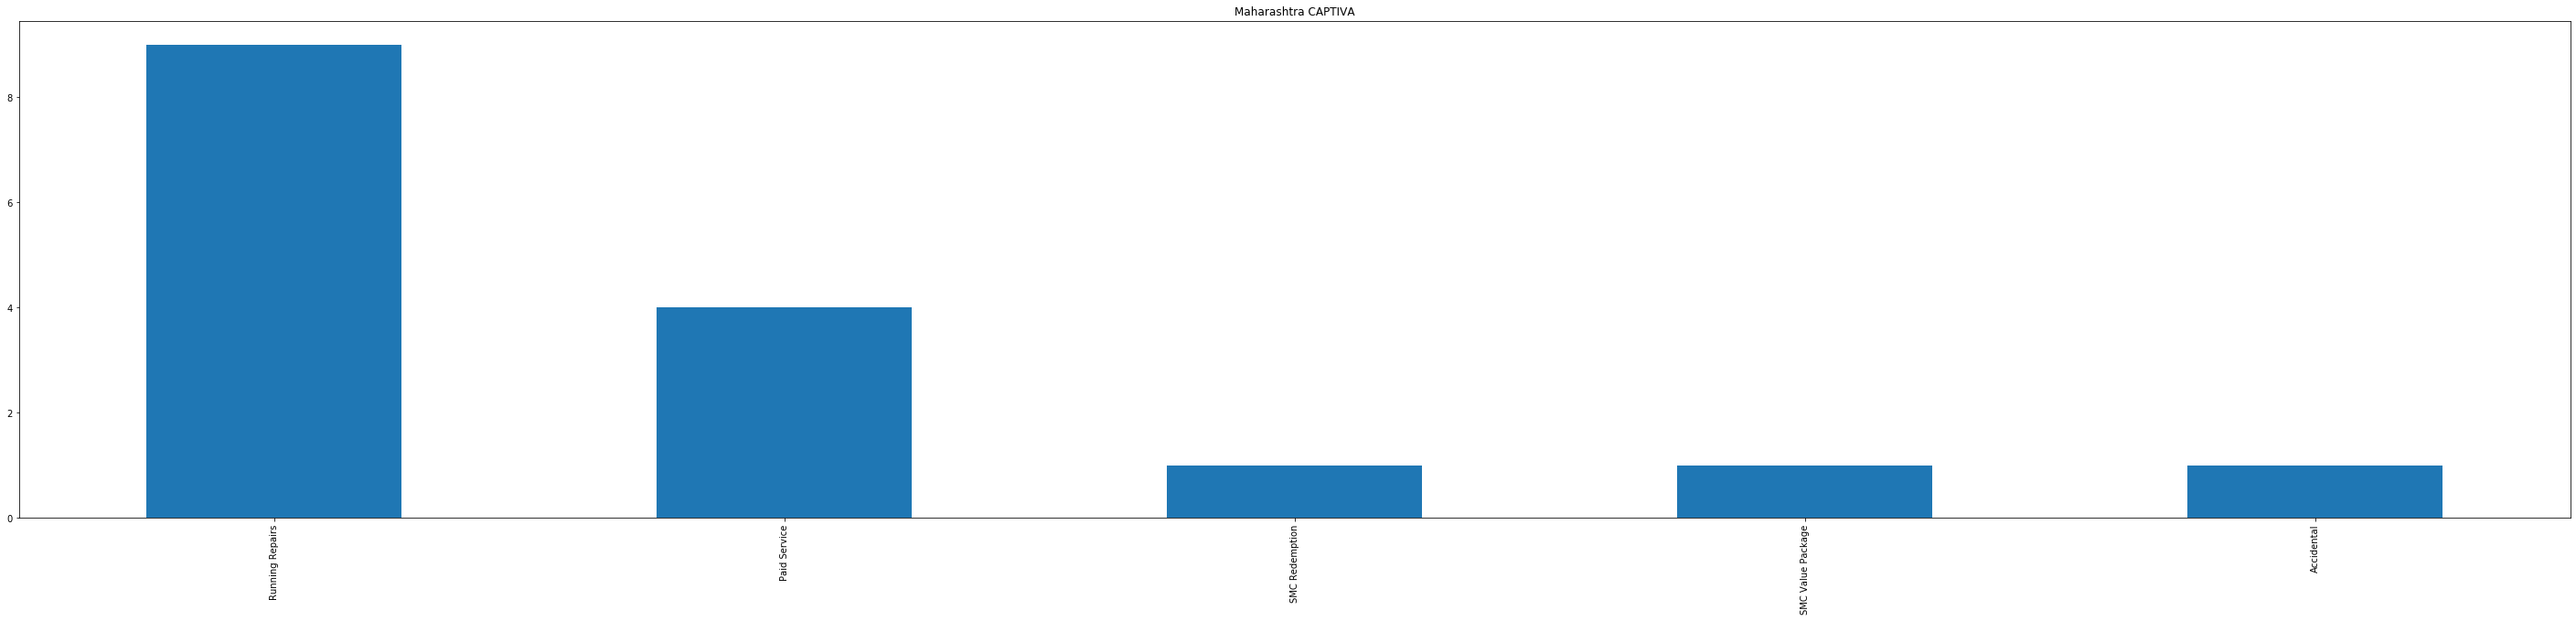

CR-V


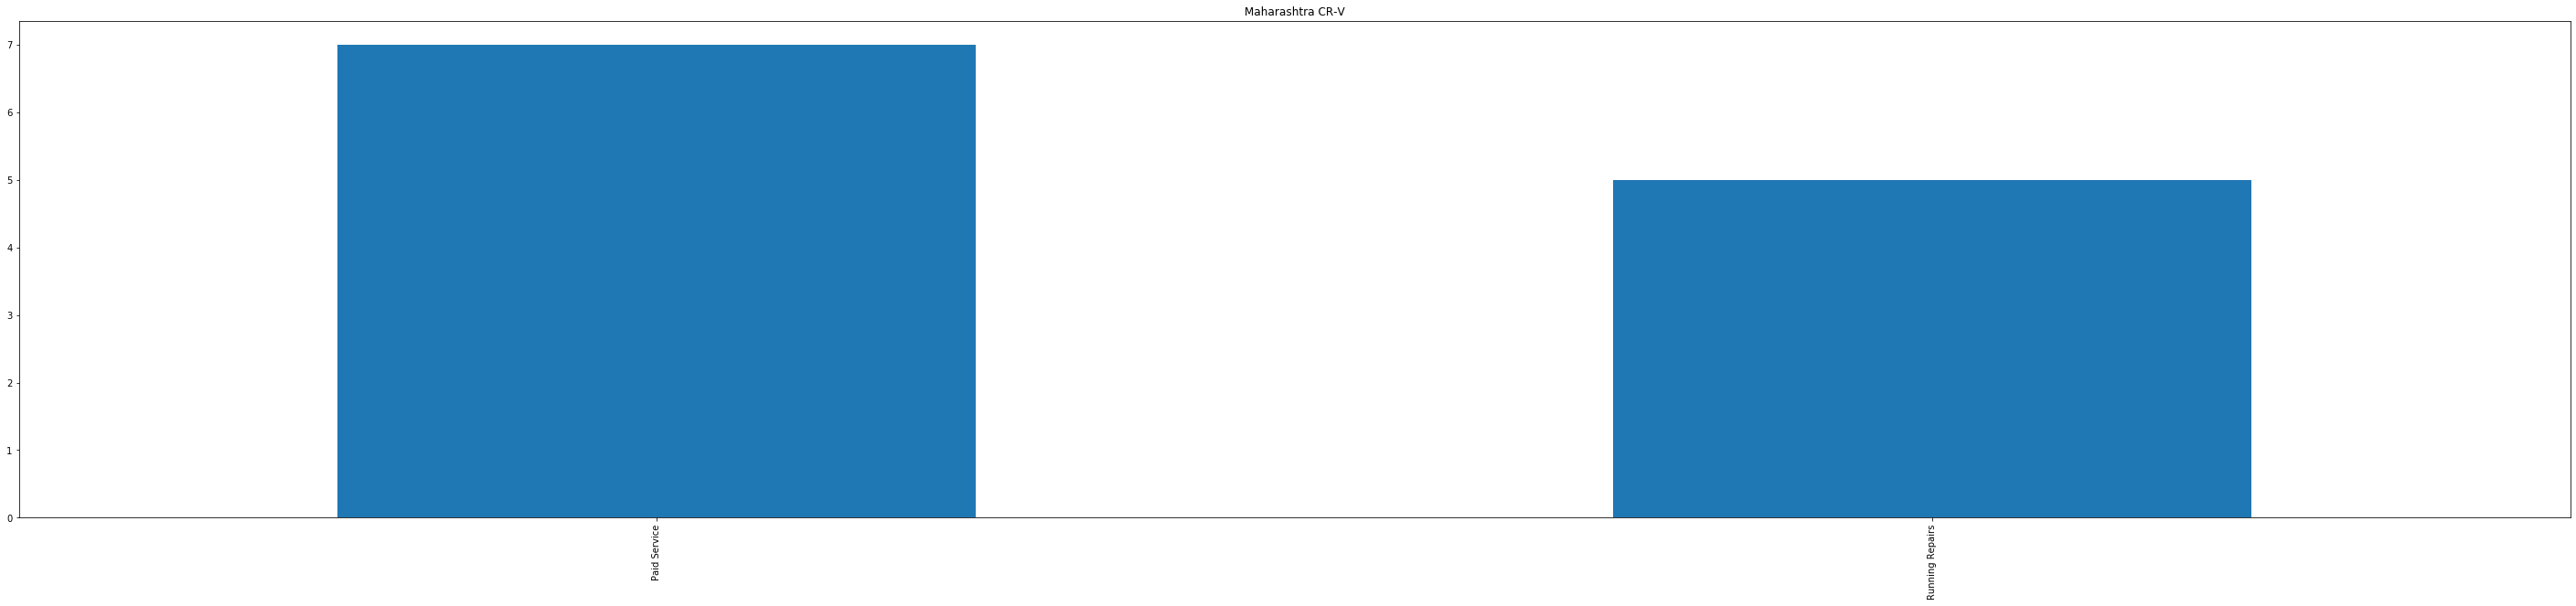

CIELO


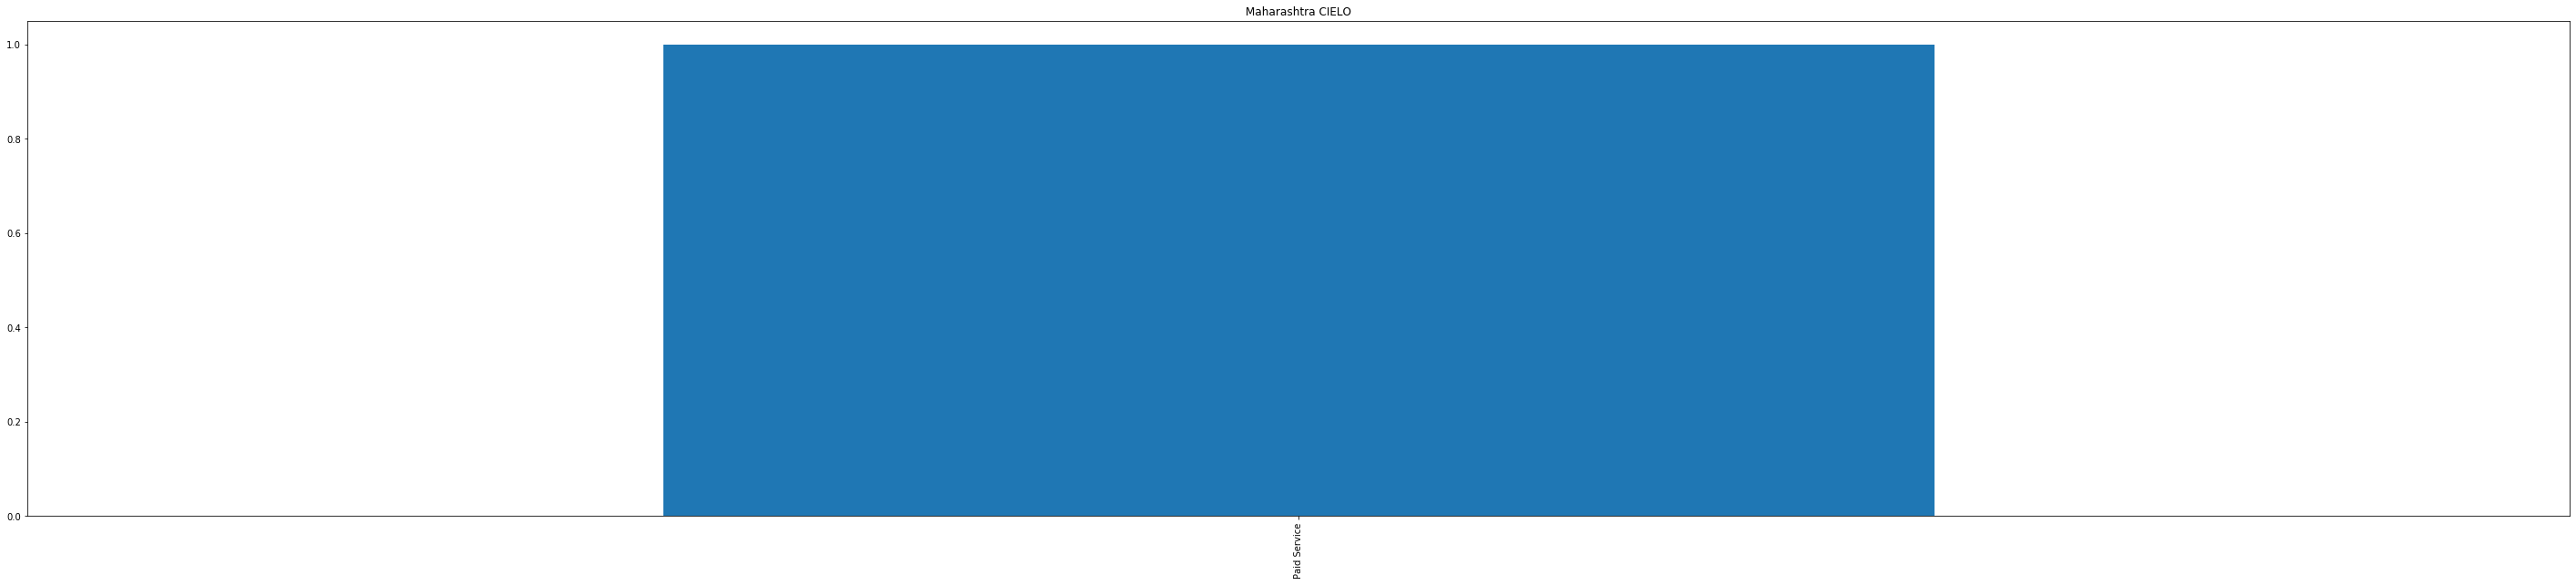

QUANTO


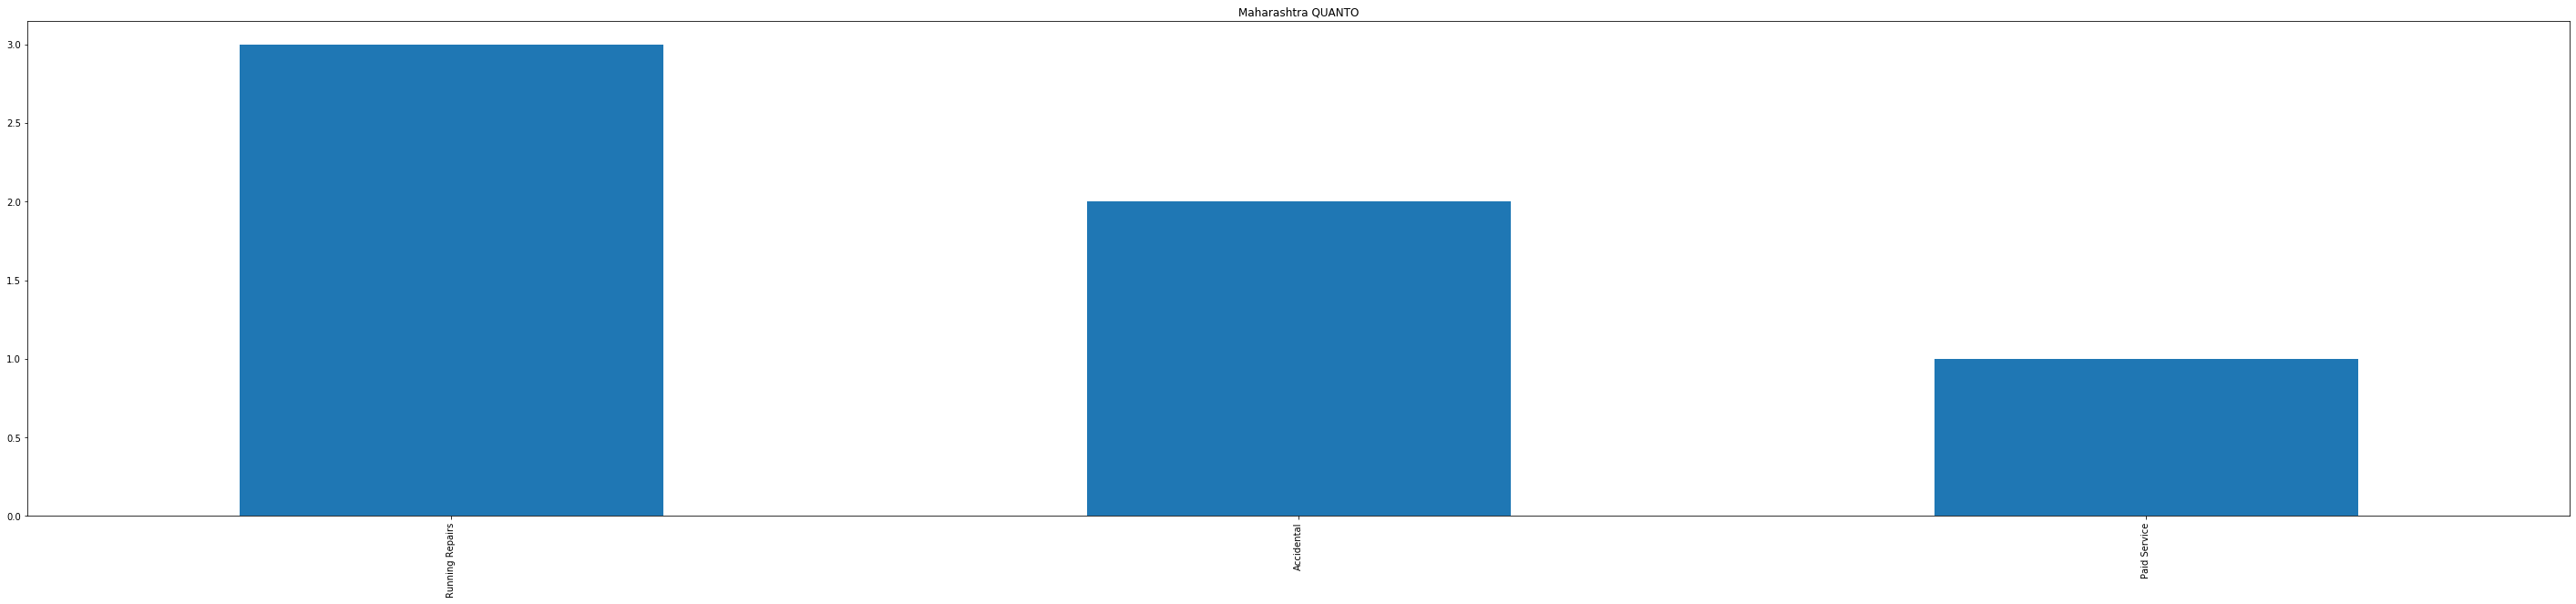

CL-CLASS


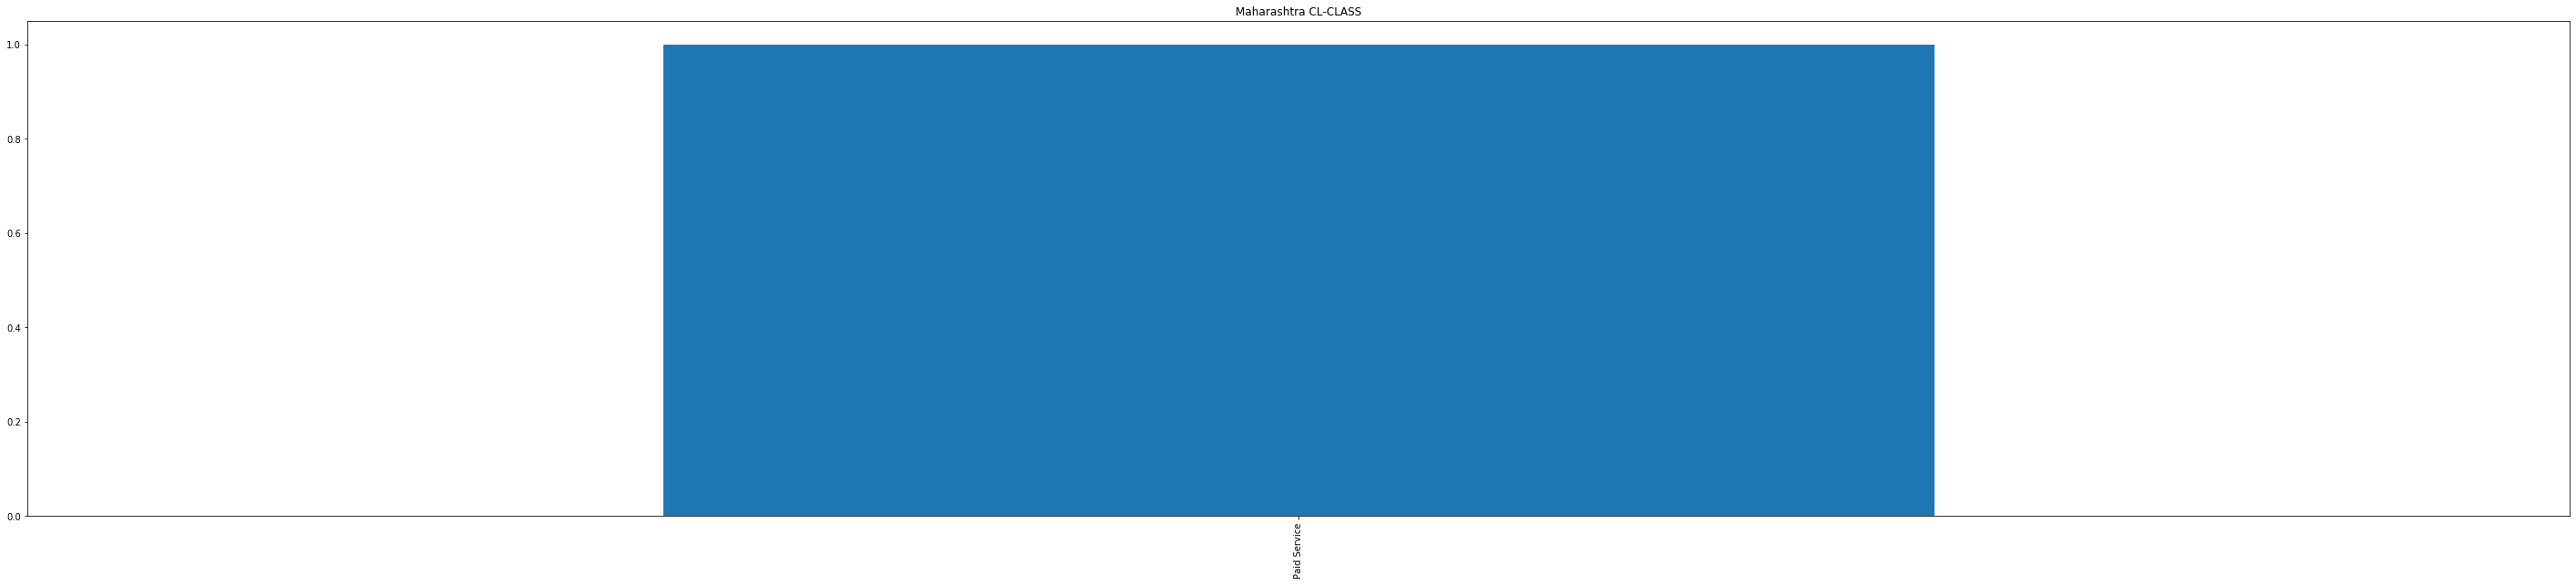

MAXX


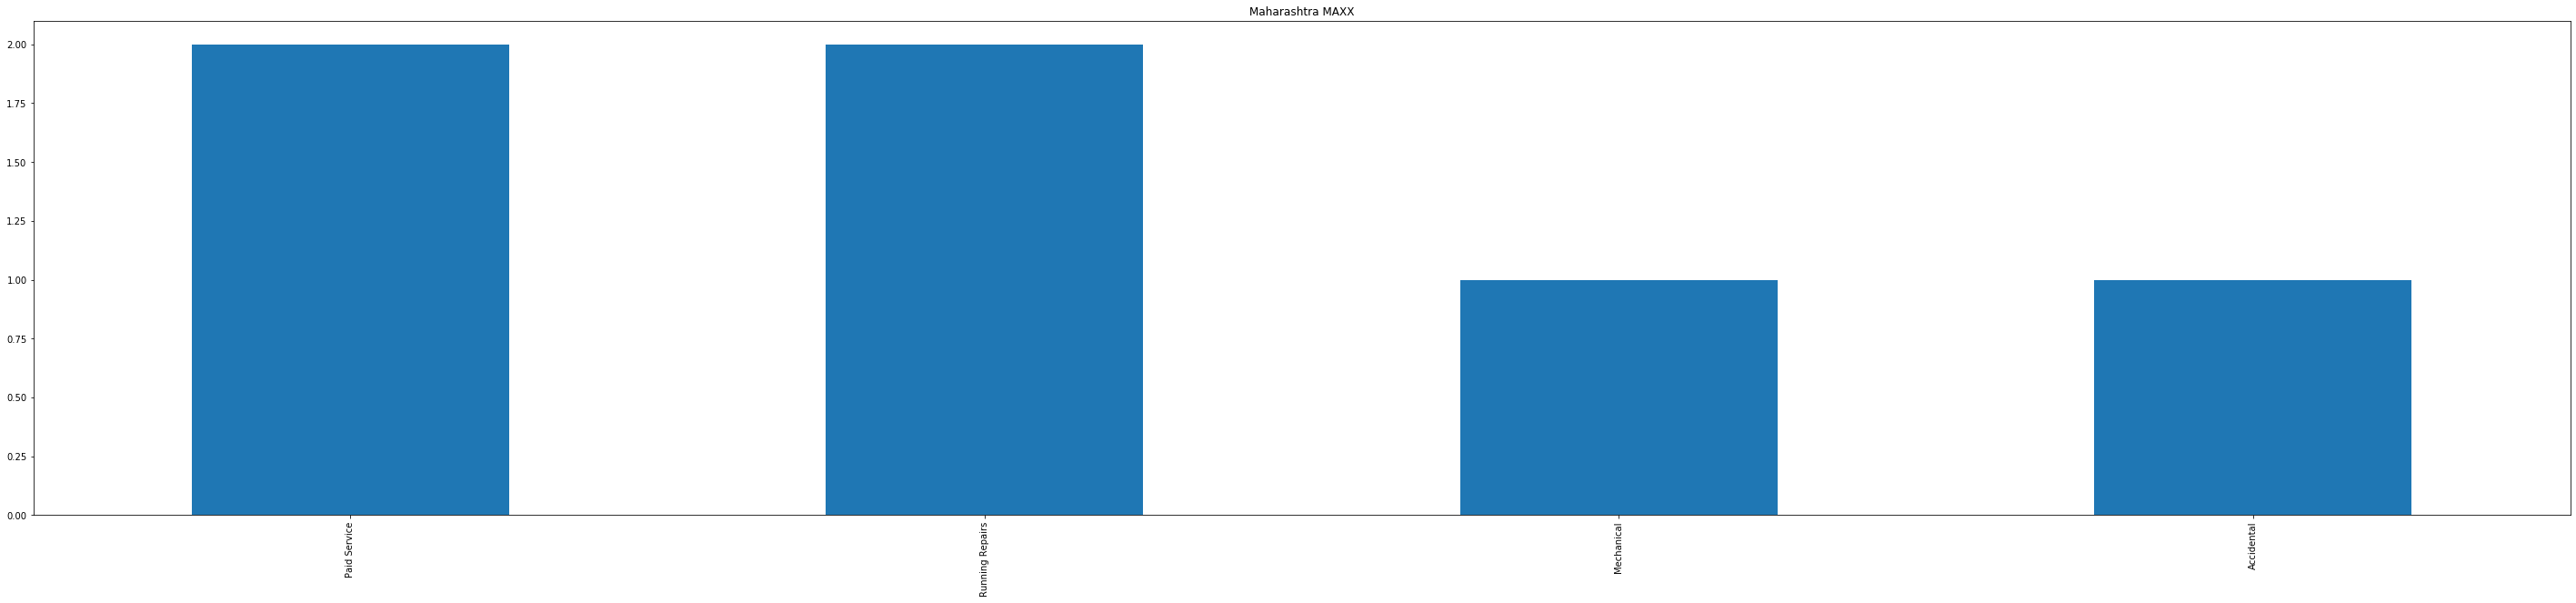

OPEL CORSA


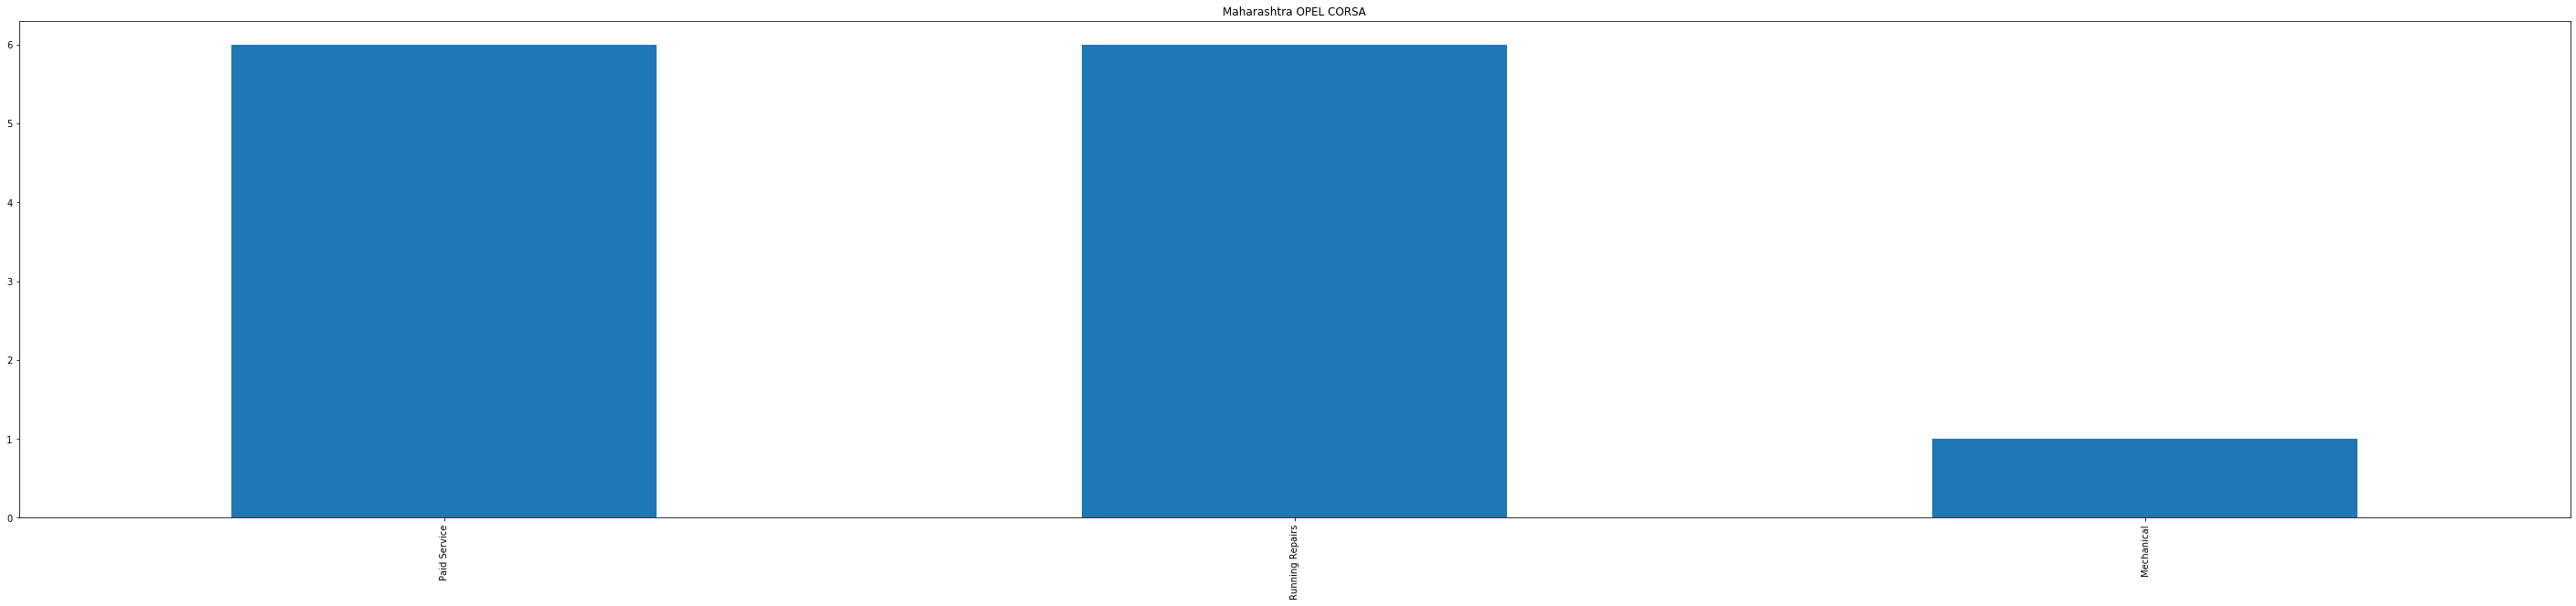

CHEVROLET CRUZE


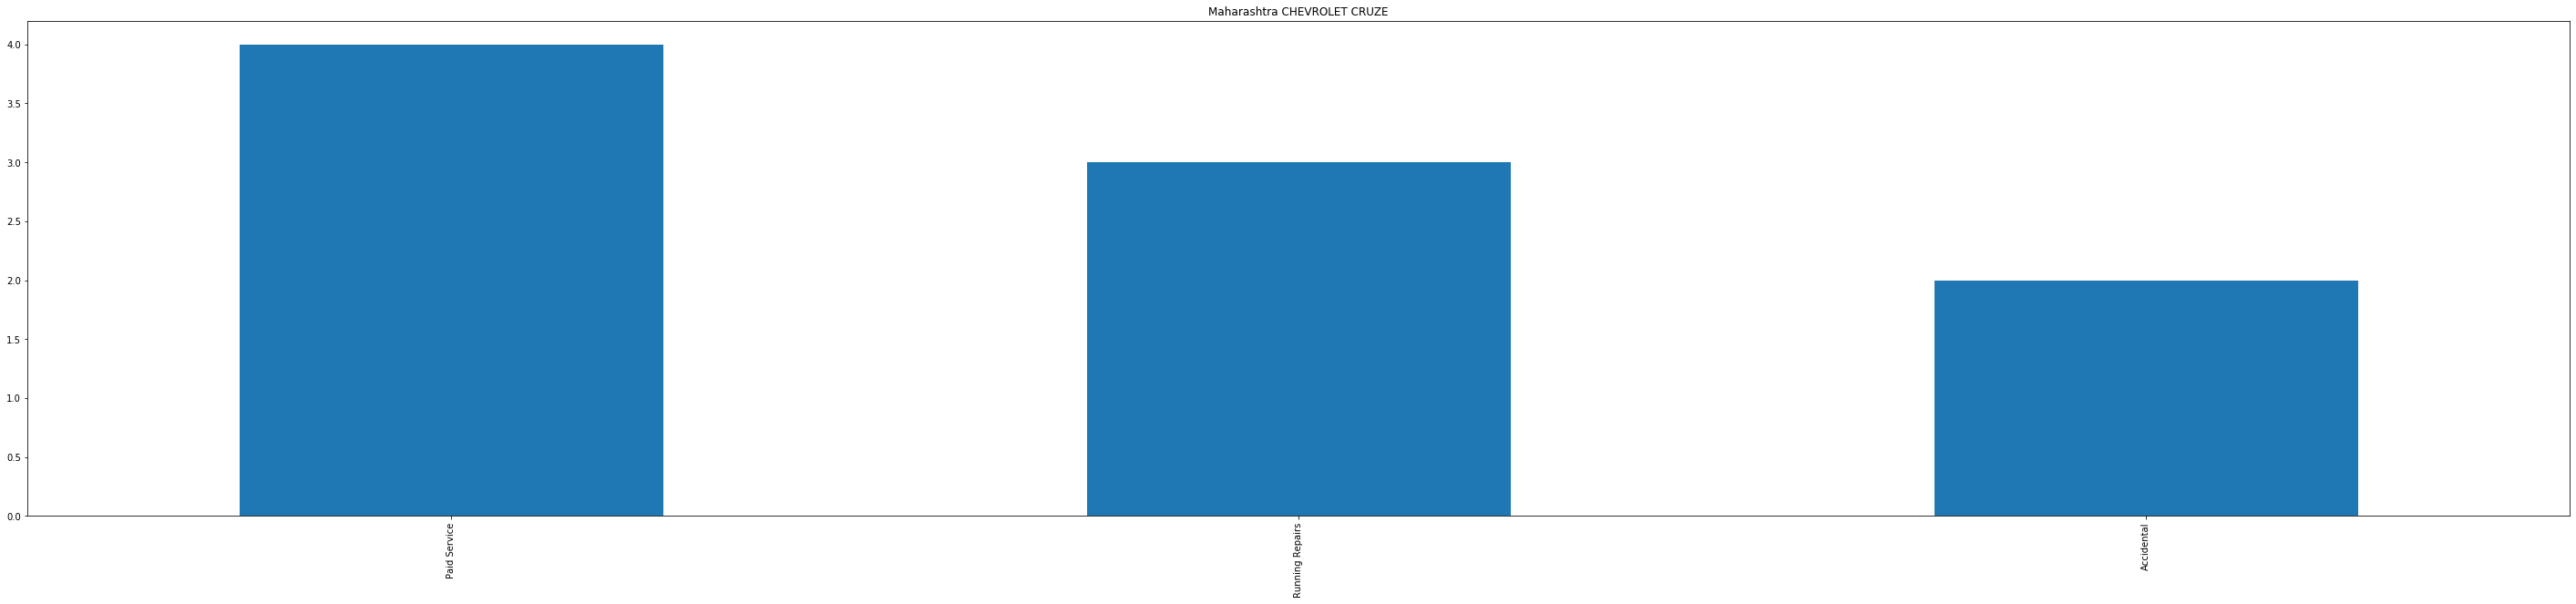

GRAND PUNTO


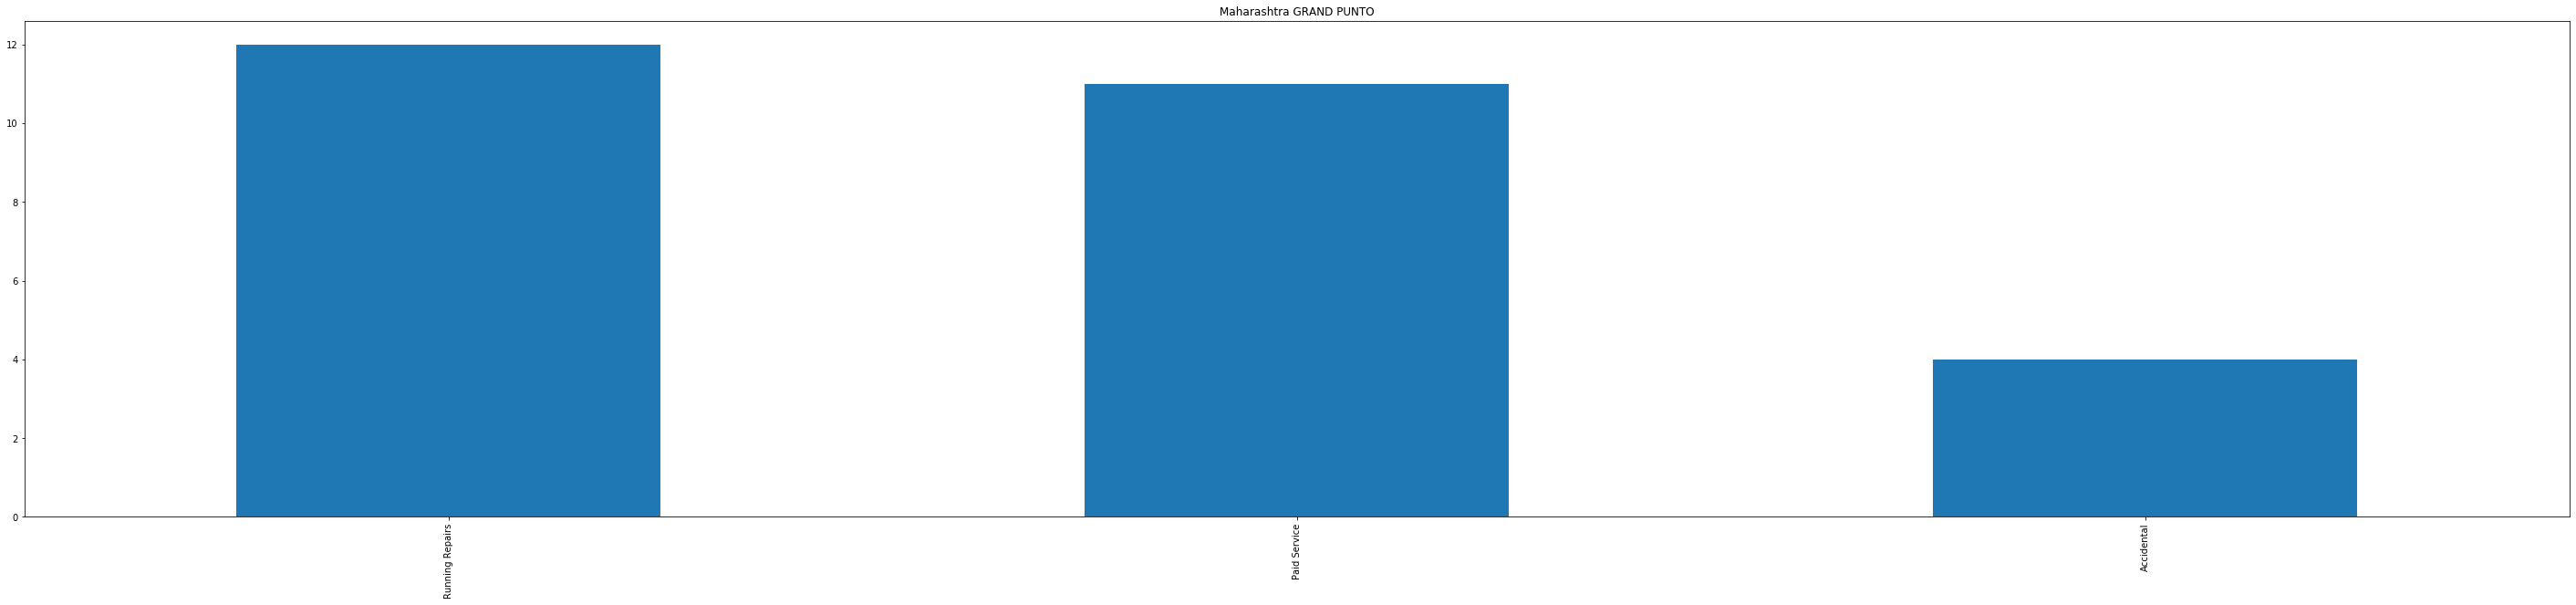

ENDEAVOUR


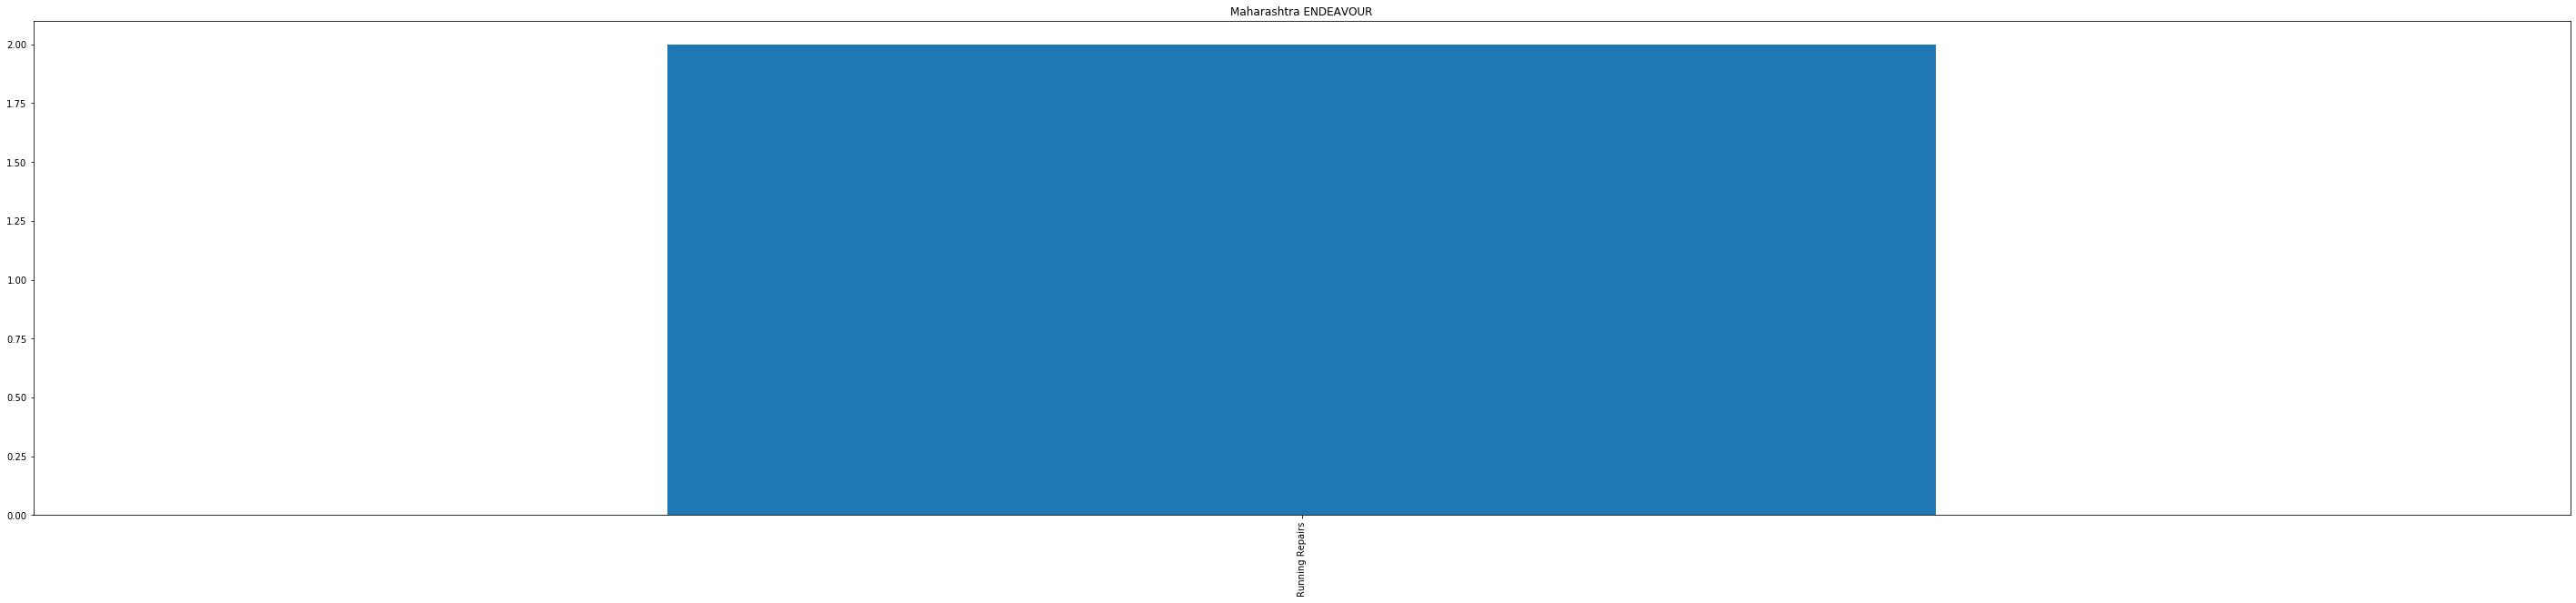

CIAZ


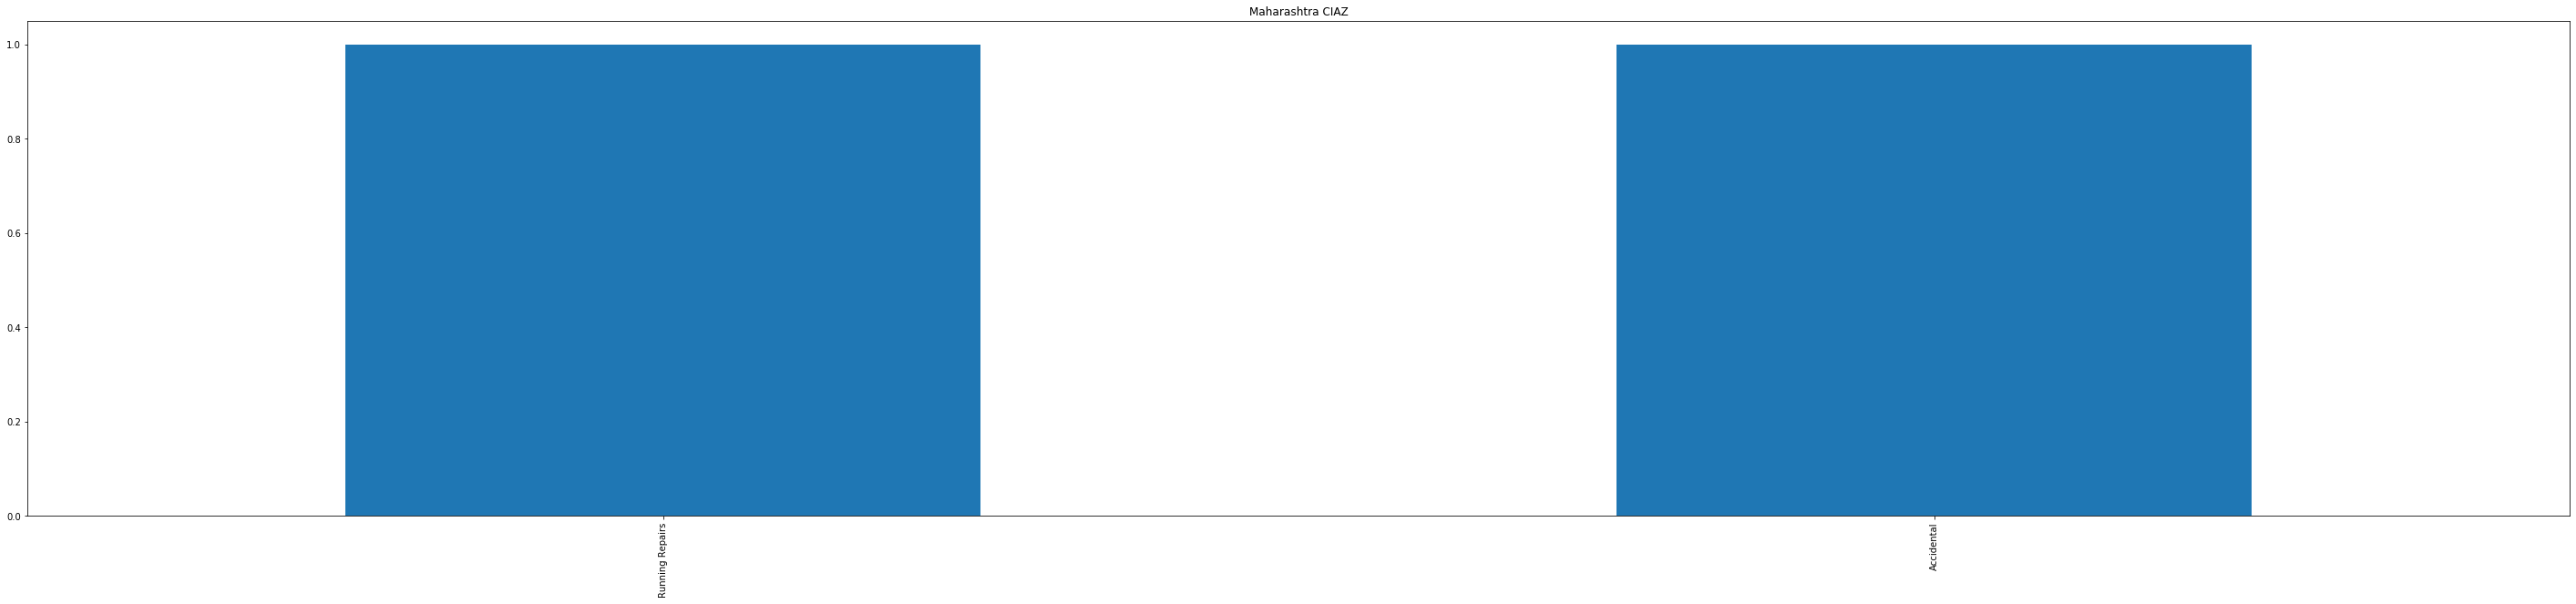

INDIGO MARINA


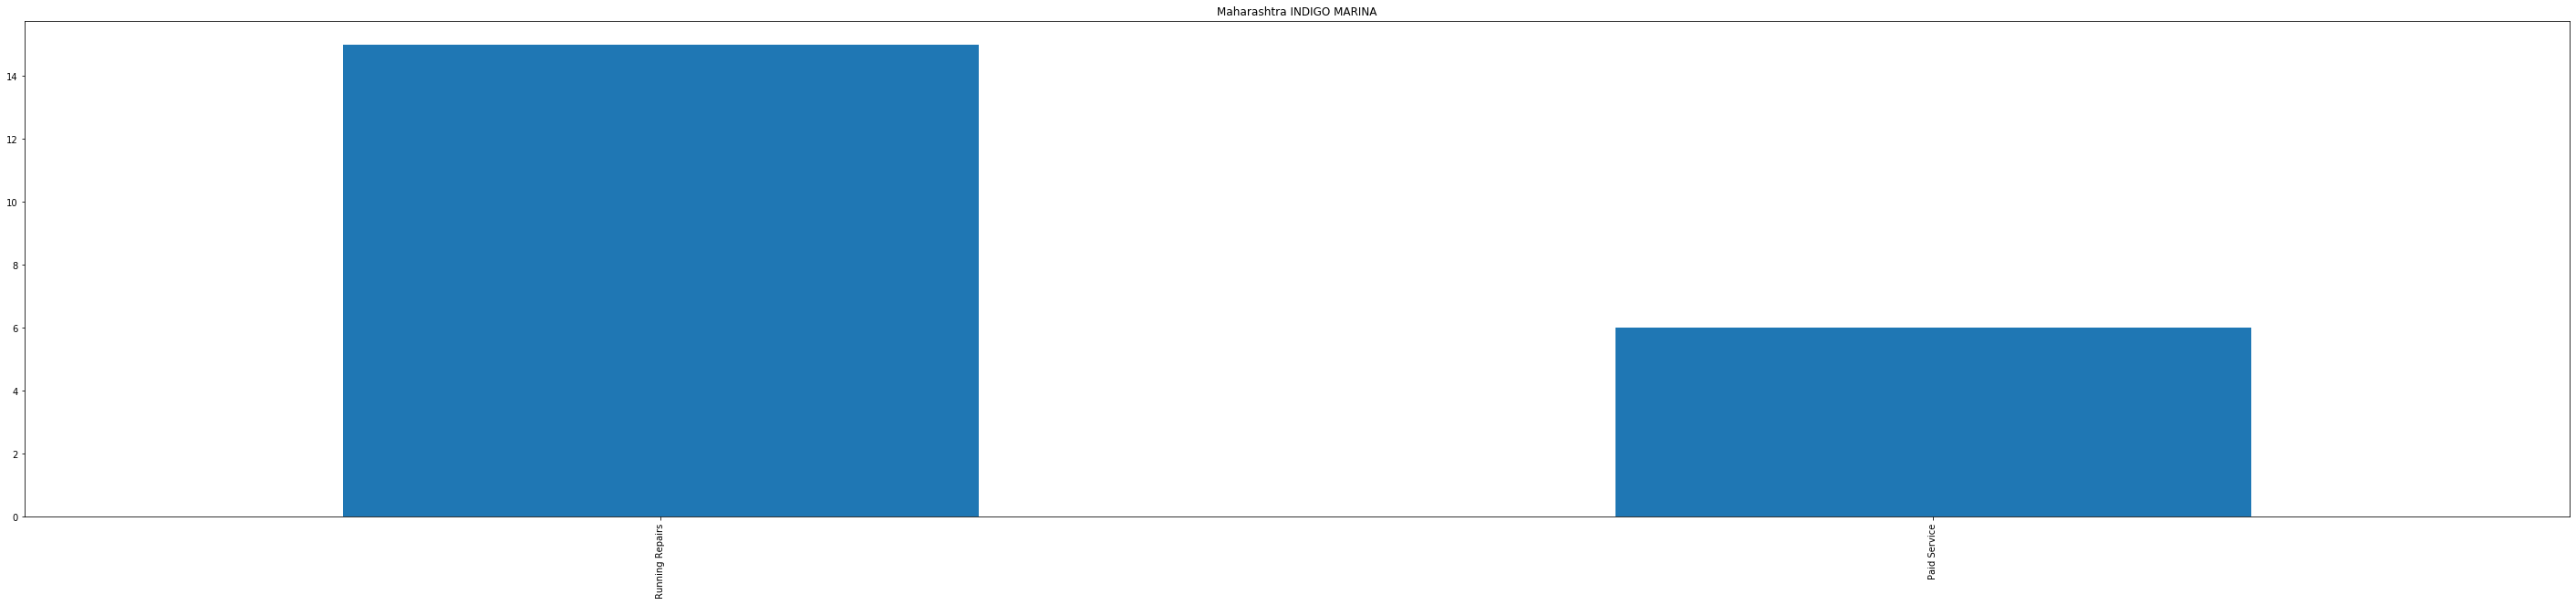

OPTRA MAGNUM


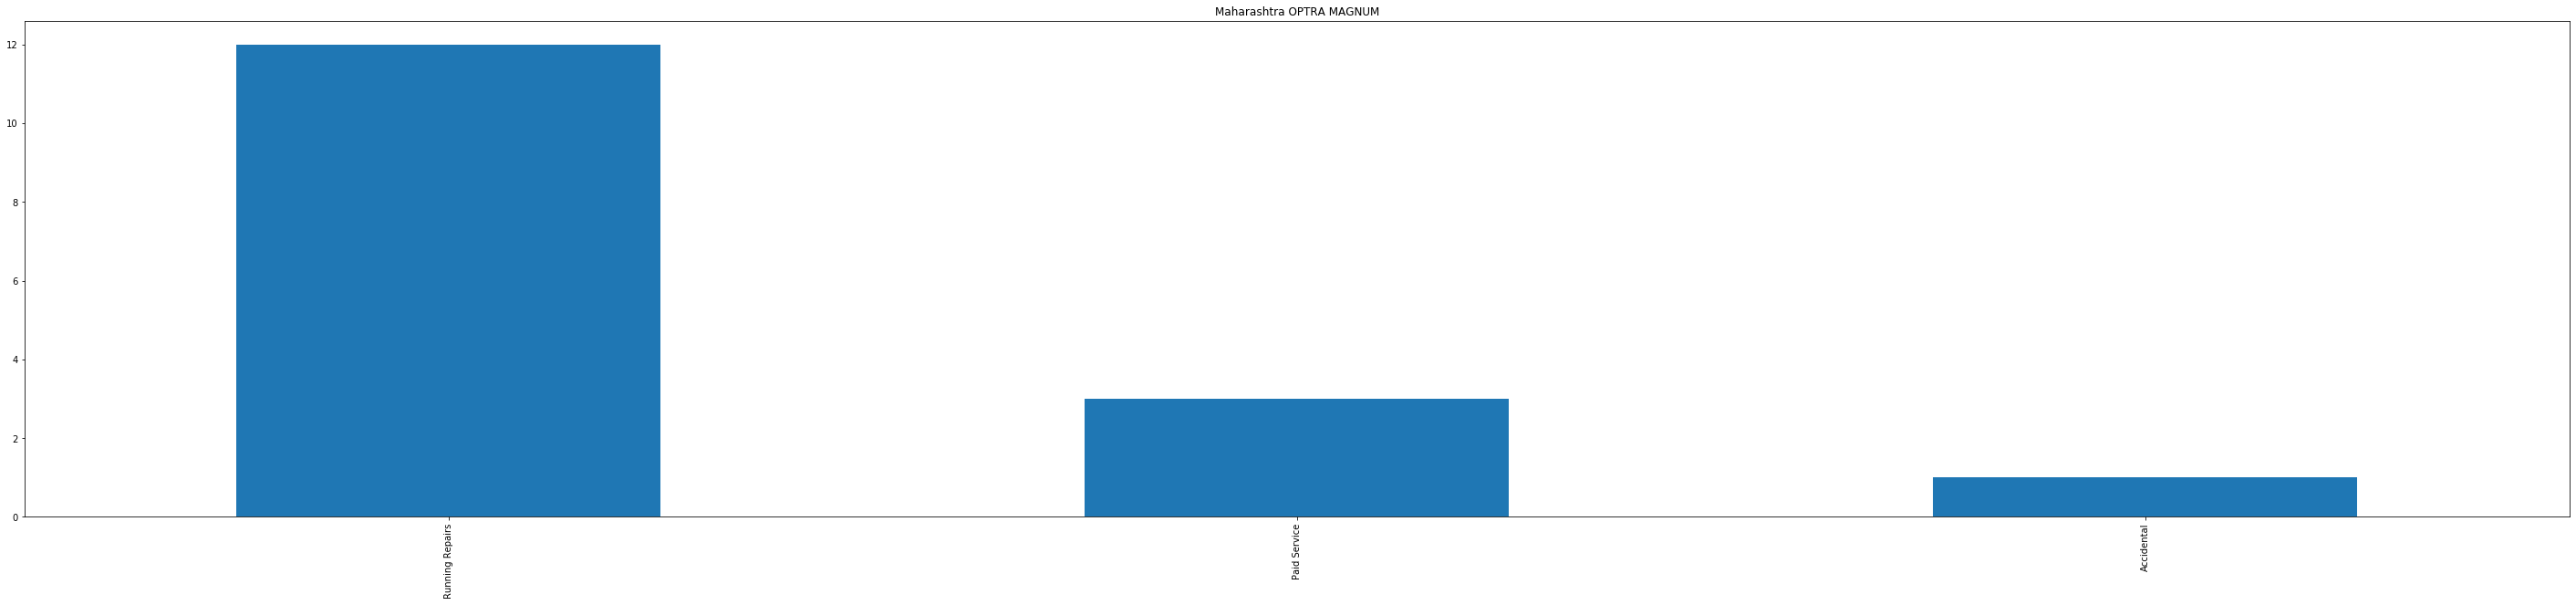

OPEL


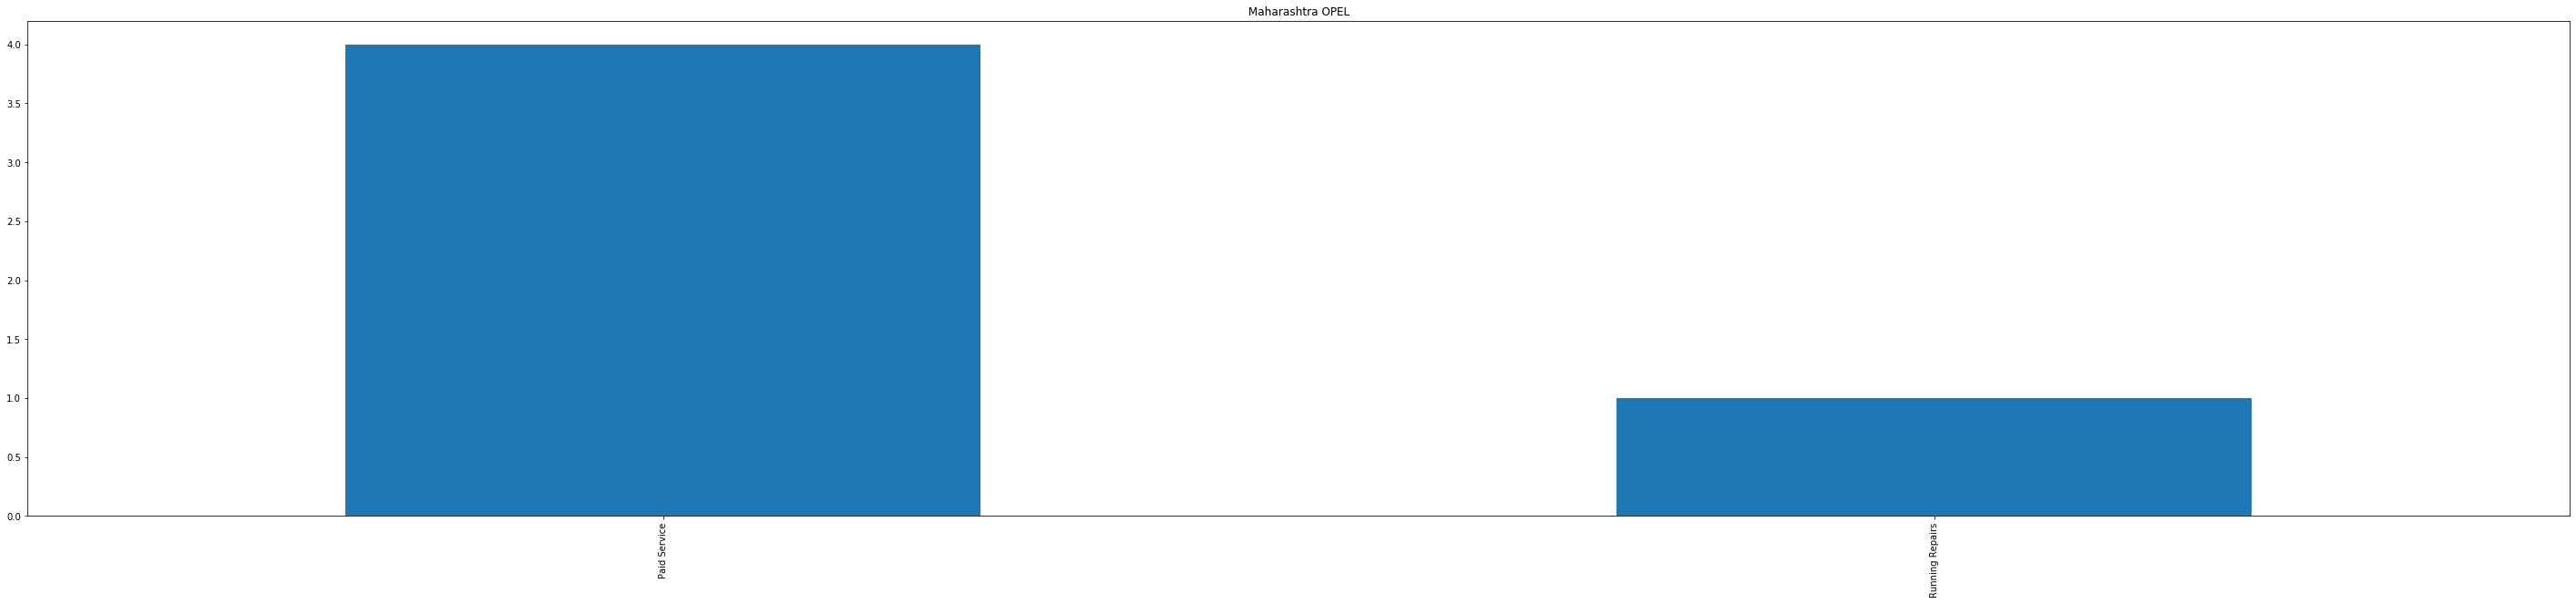

BMW-M3


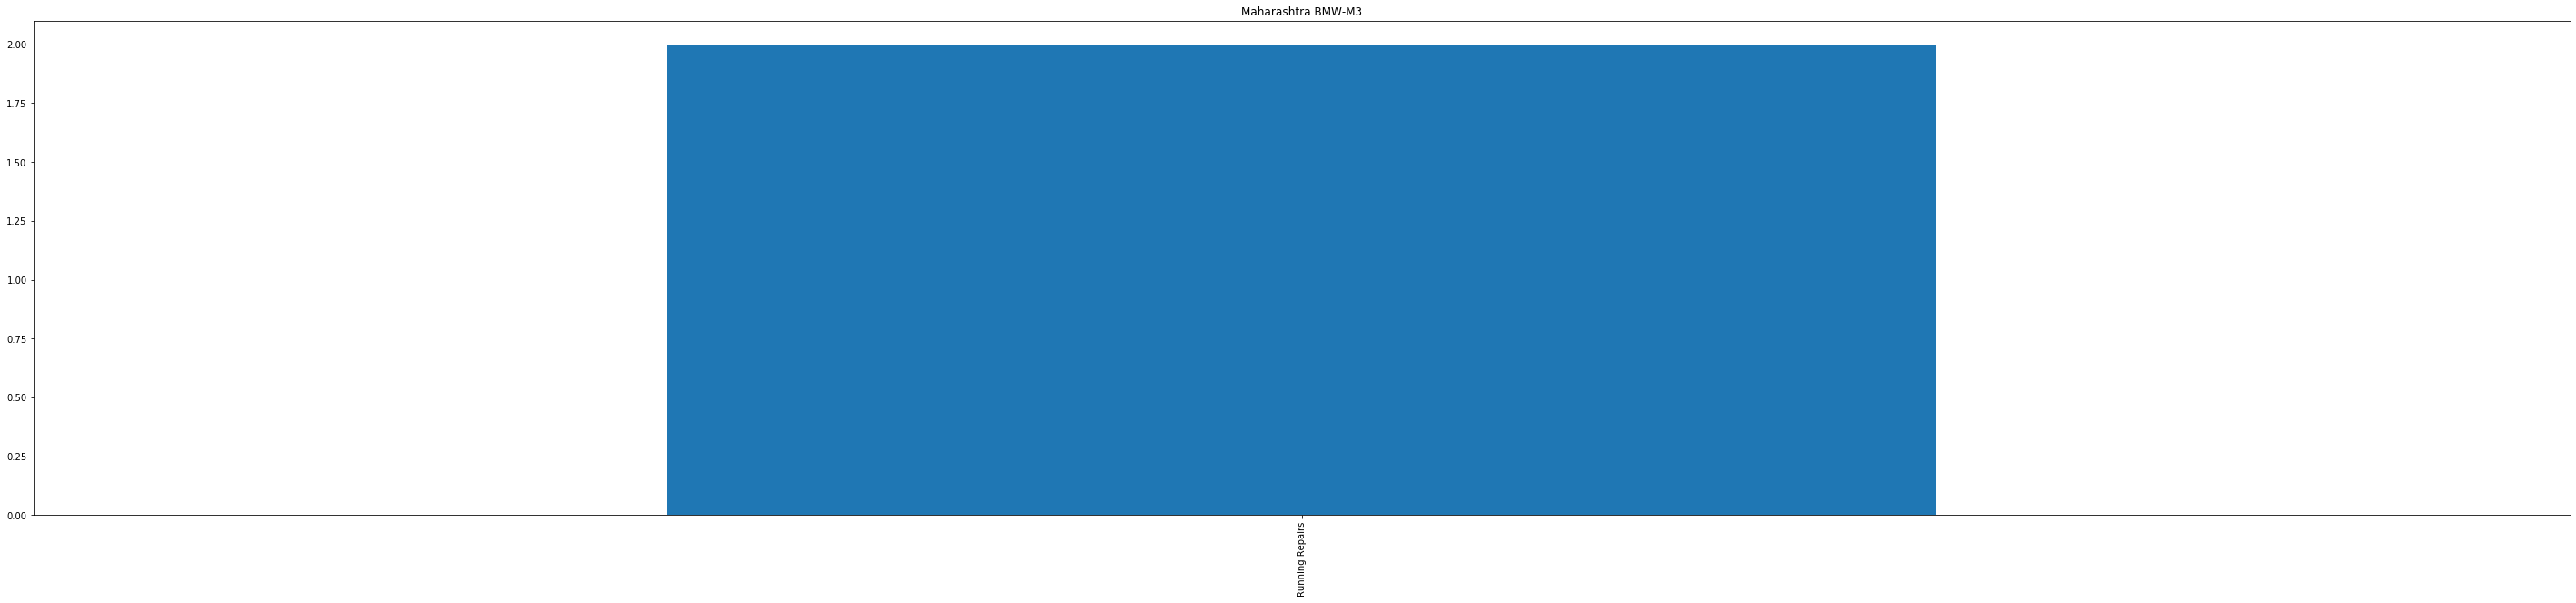

VERSA


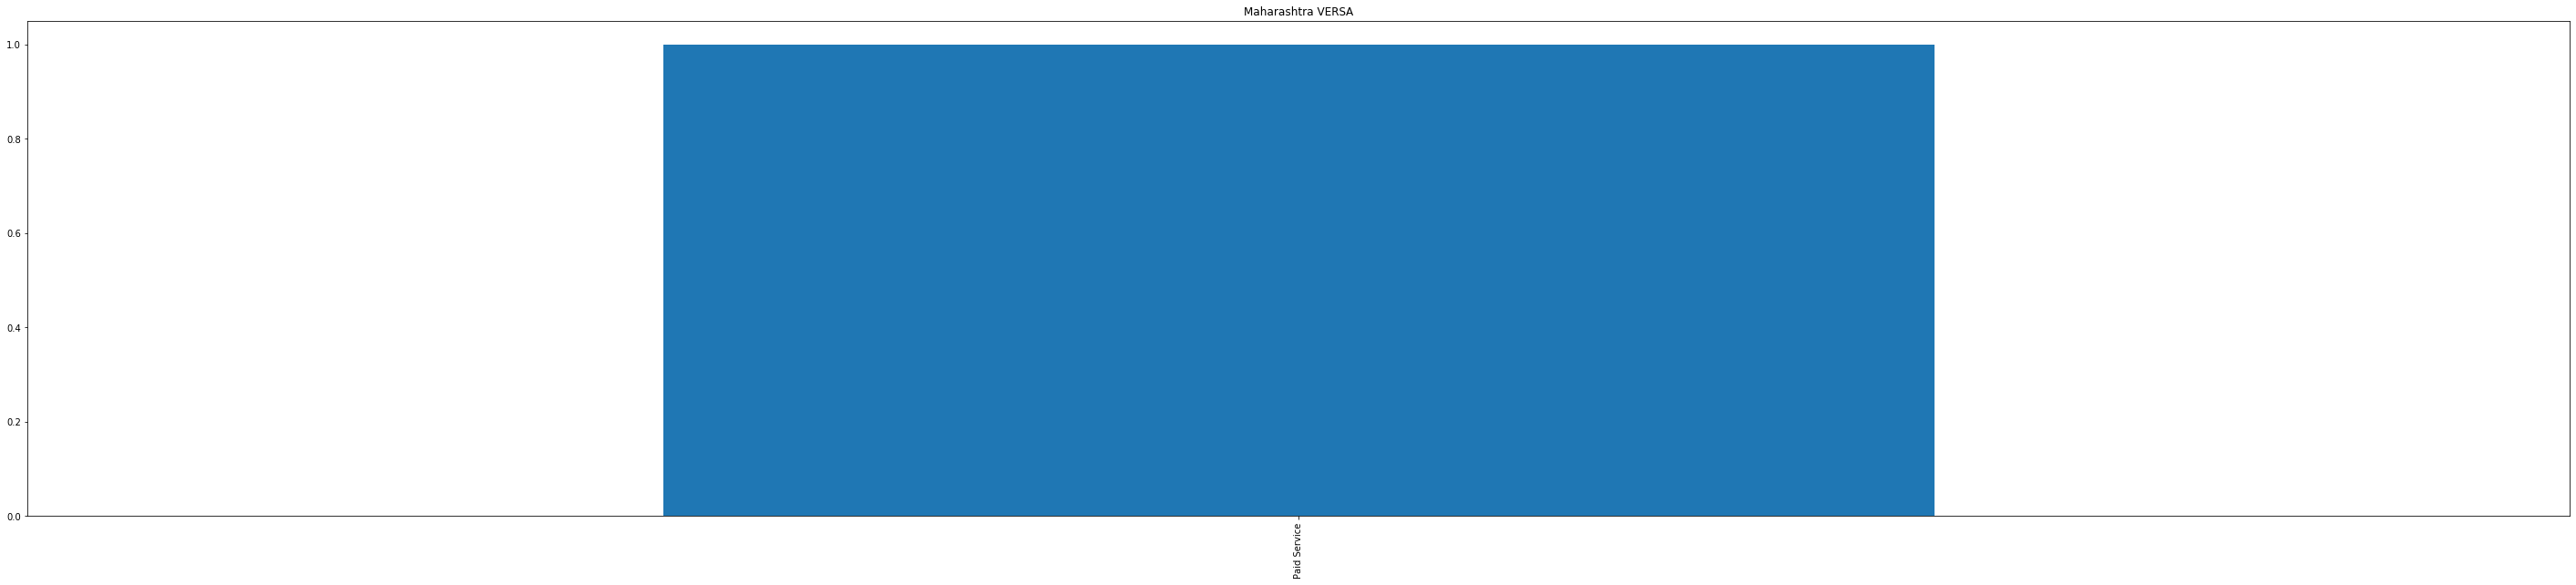

NANO


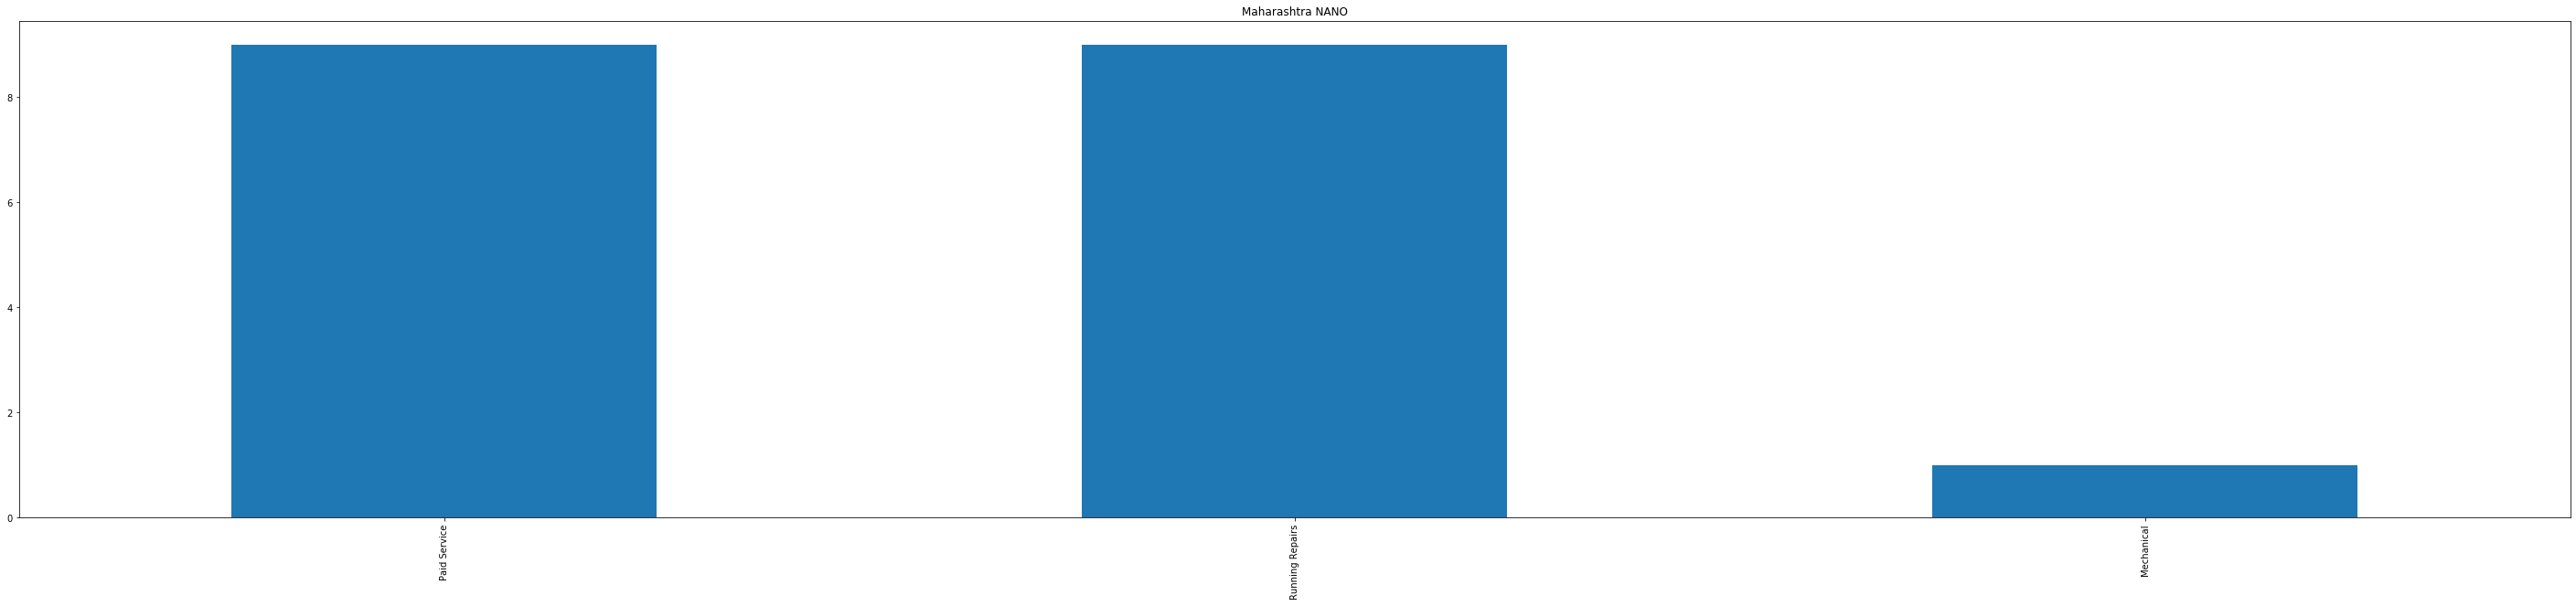

ERTIGA


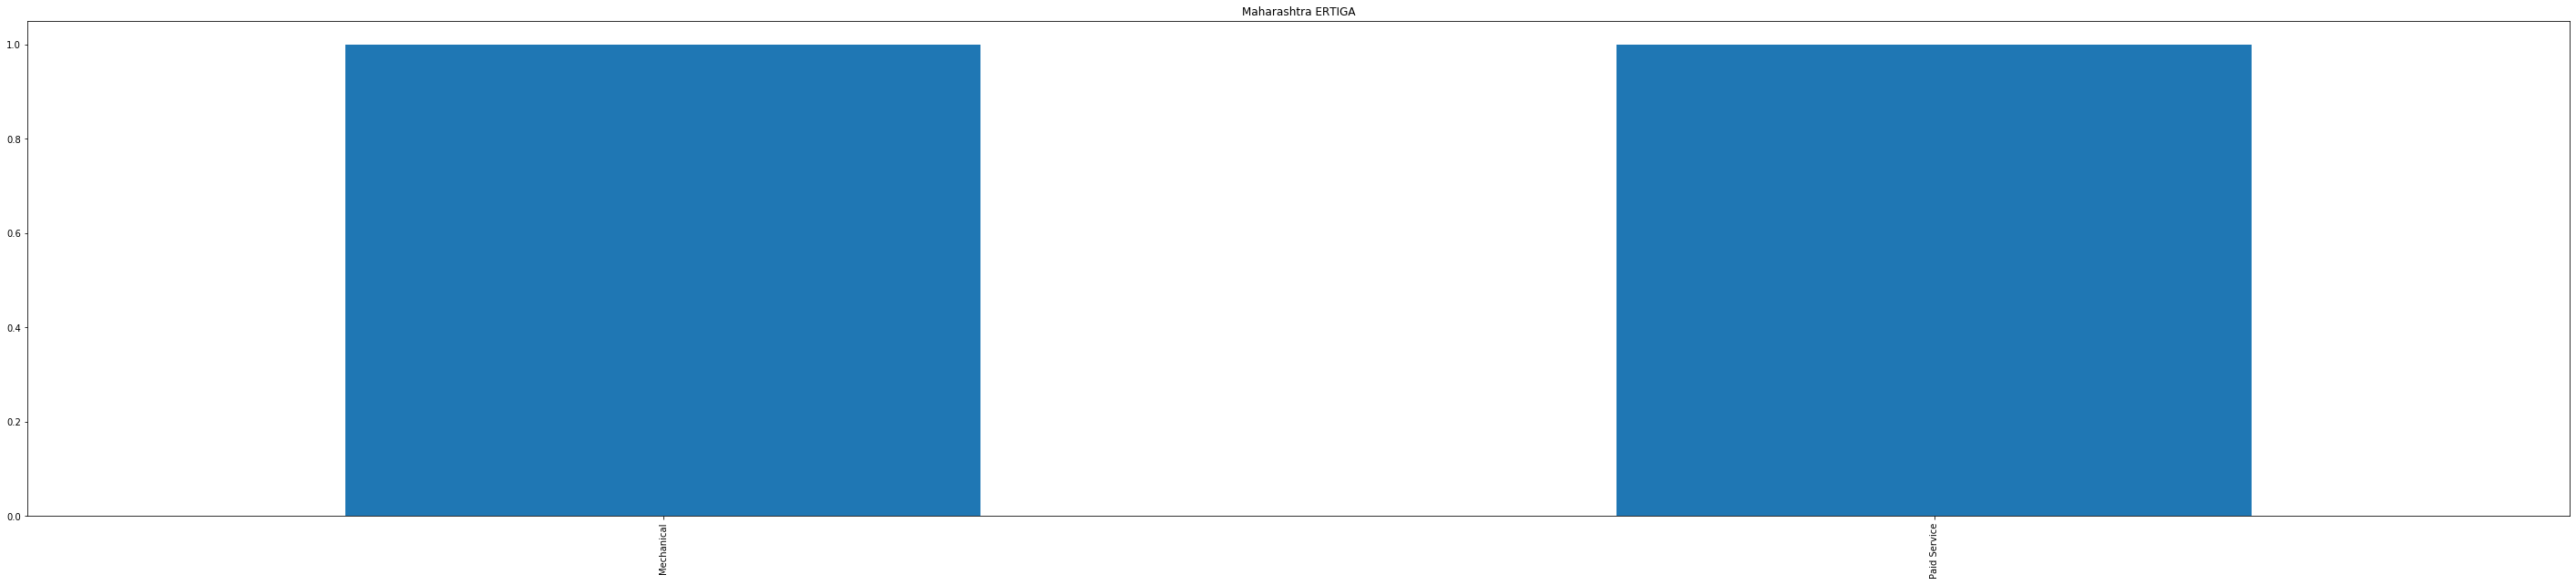

JETTA


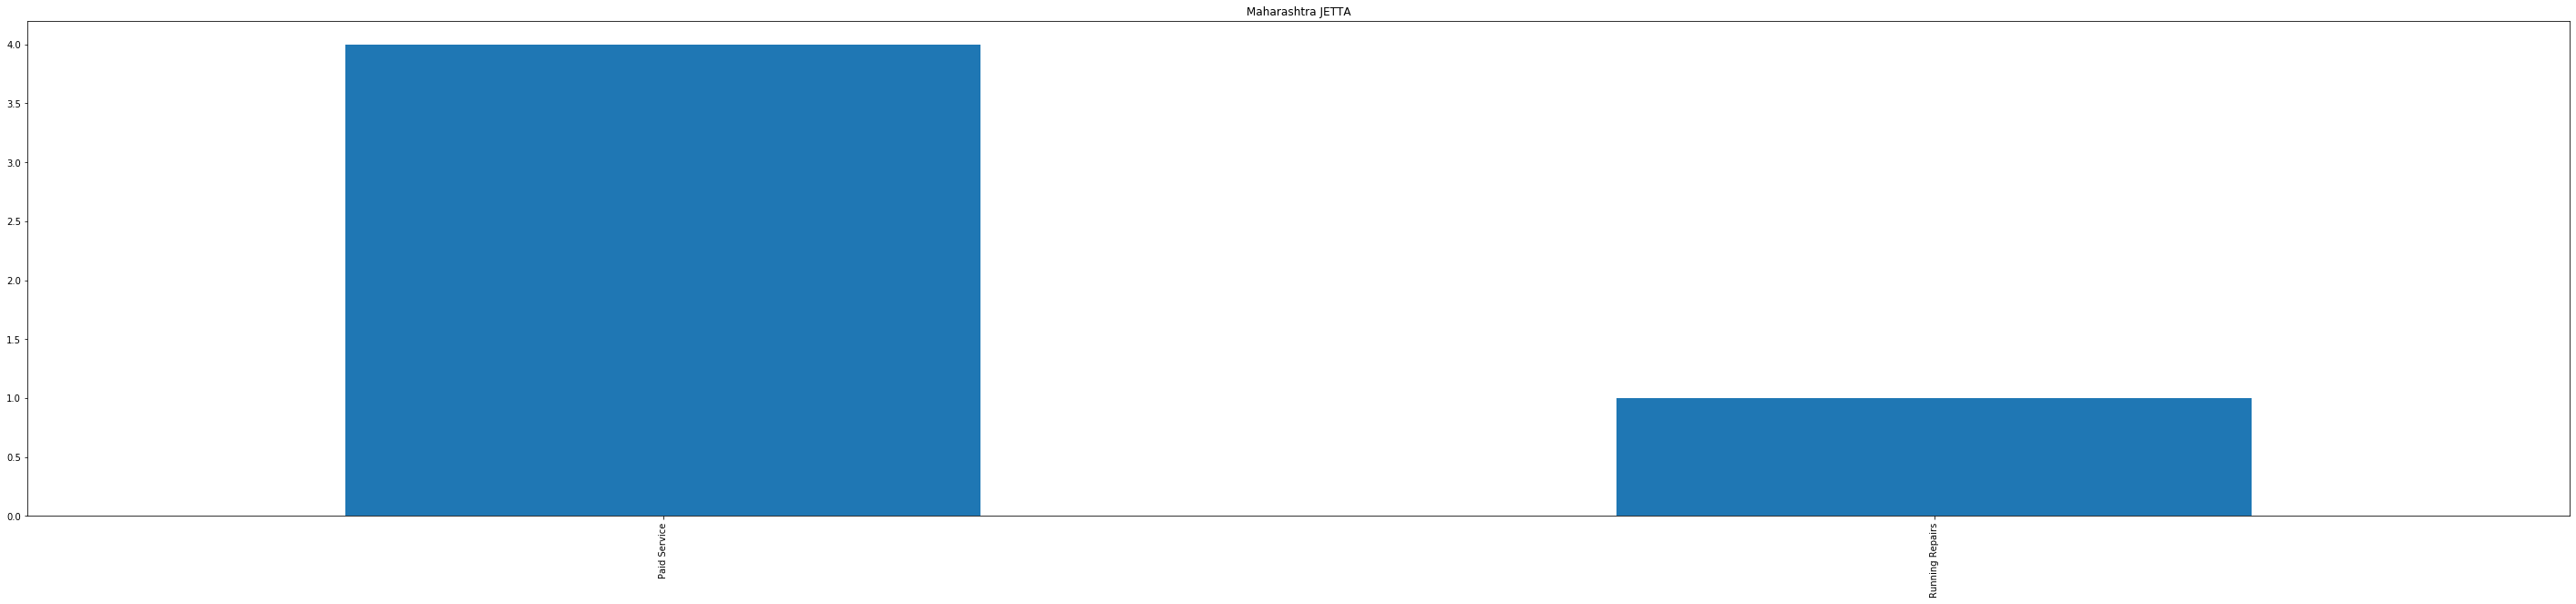

BEAT


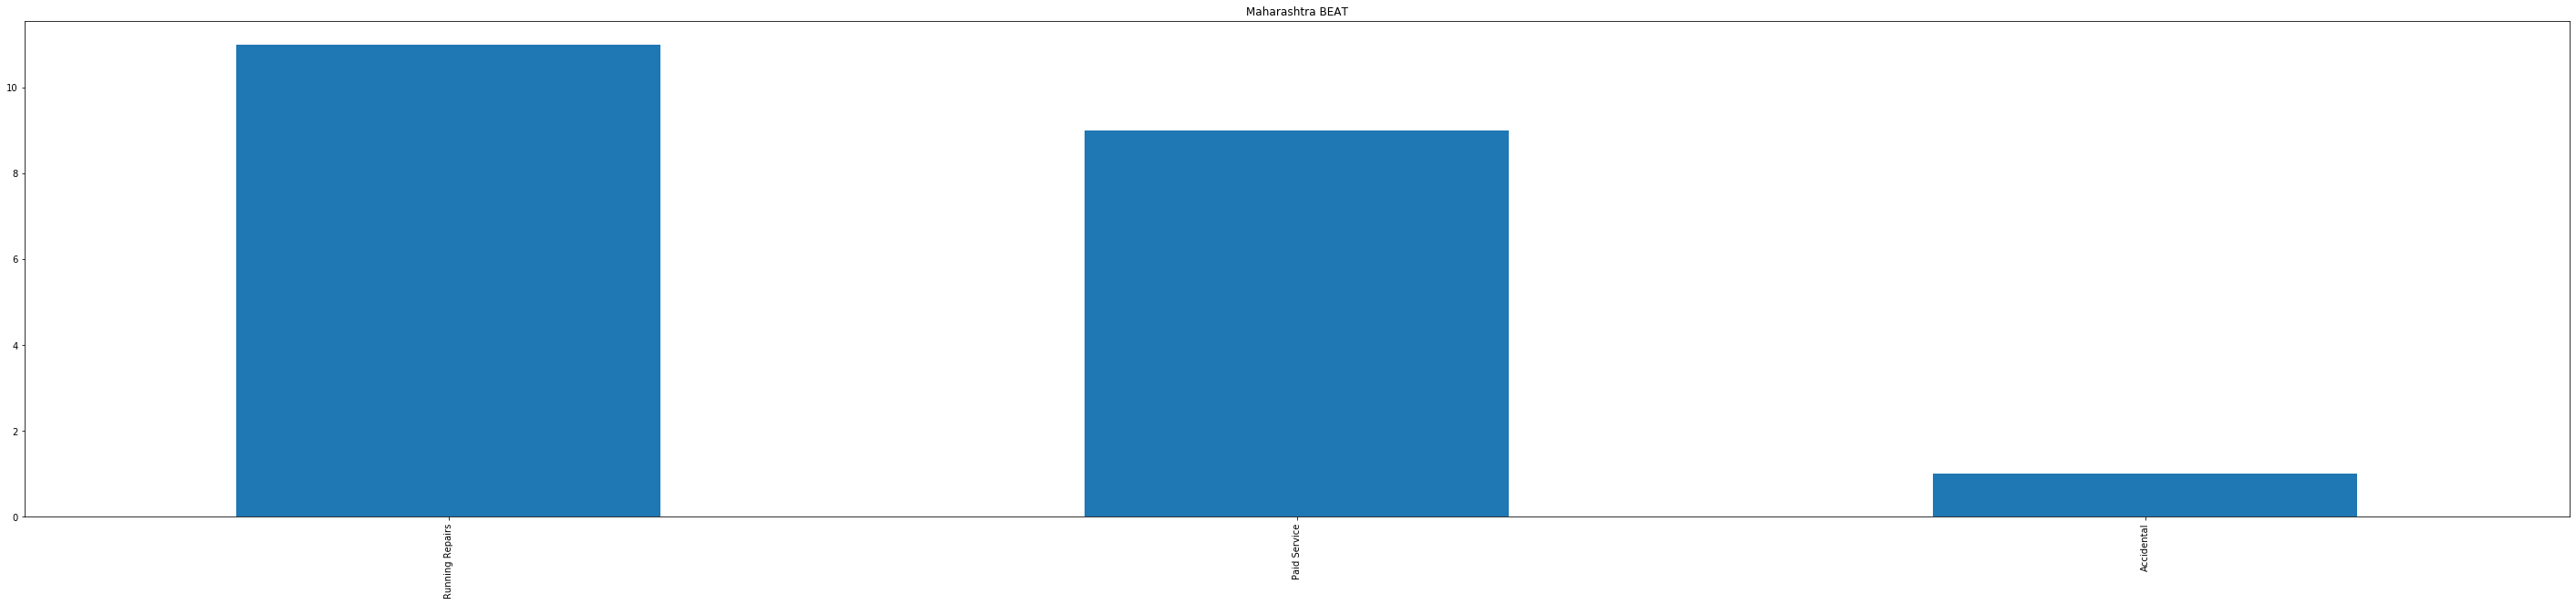

PULSE


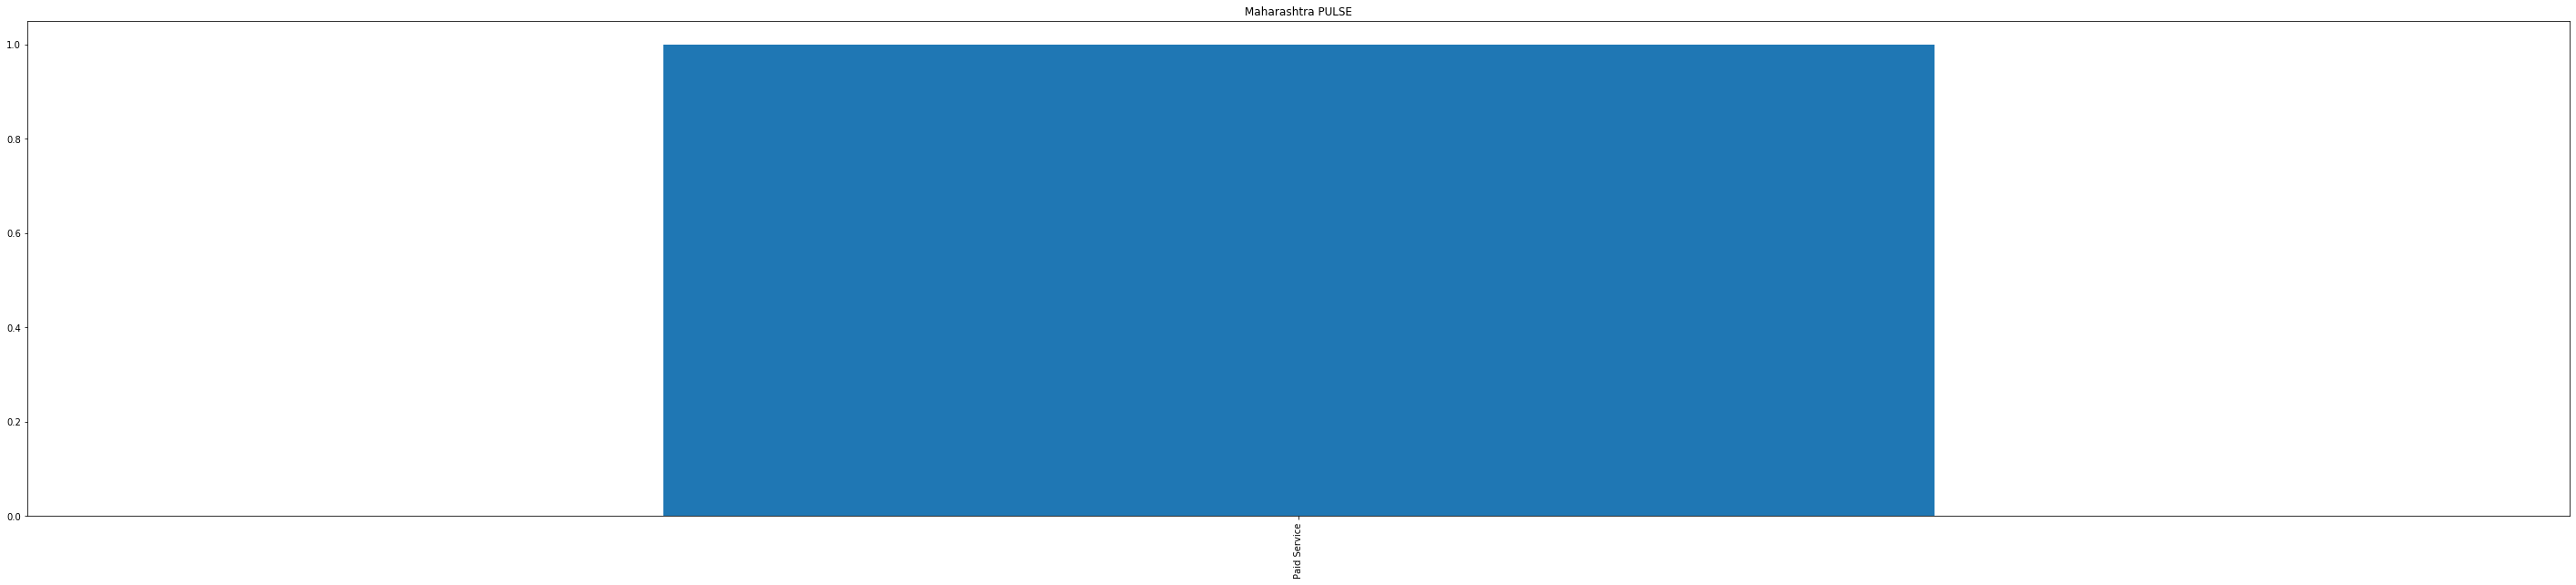

JAZZ


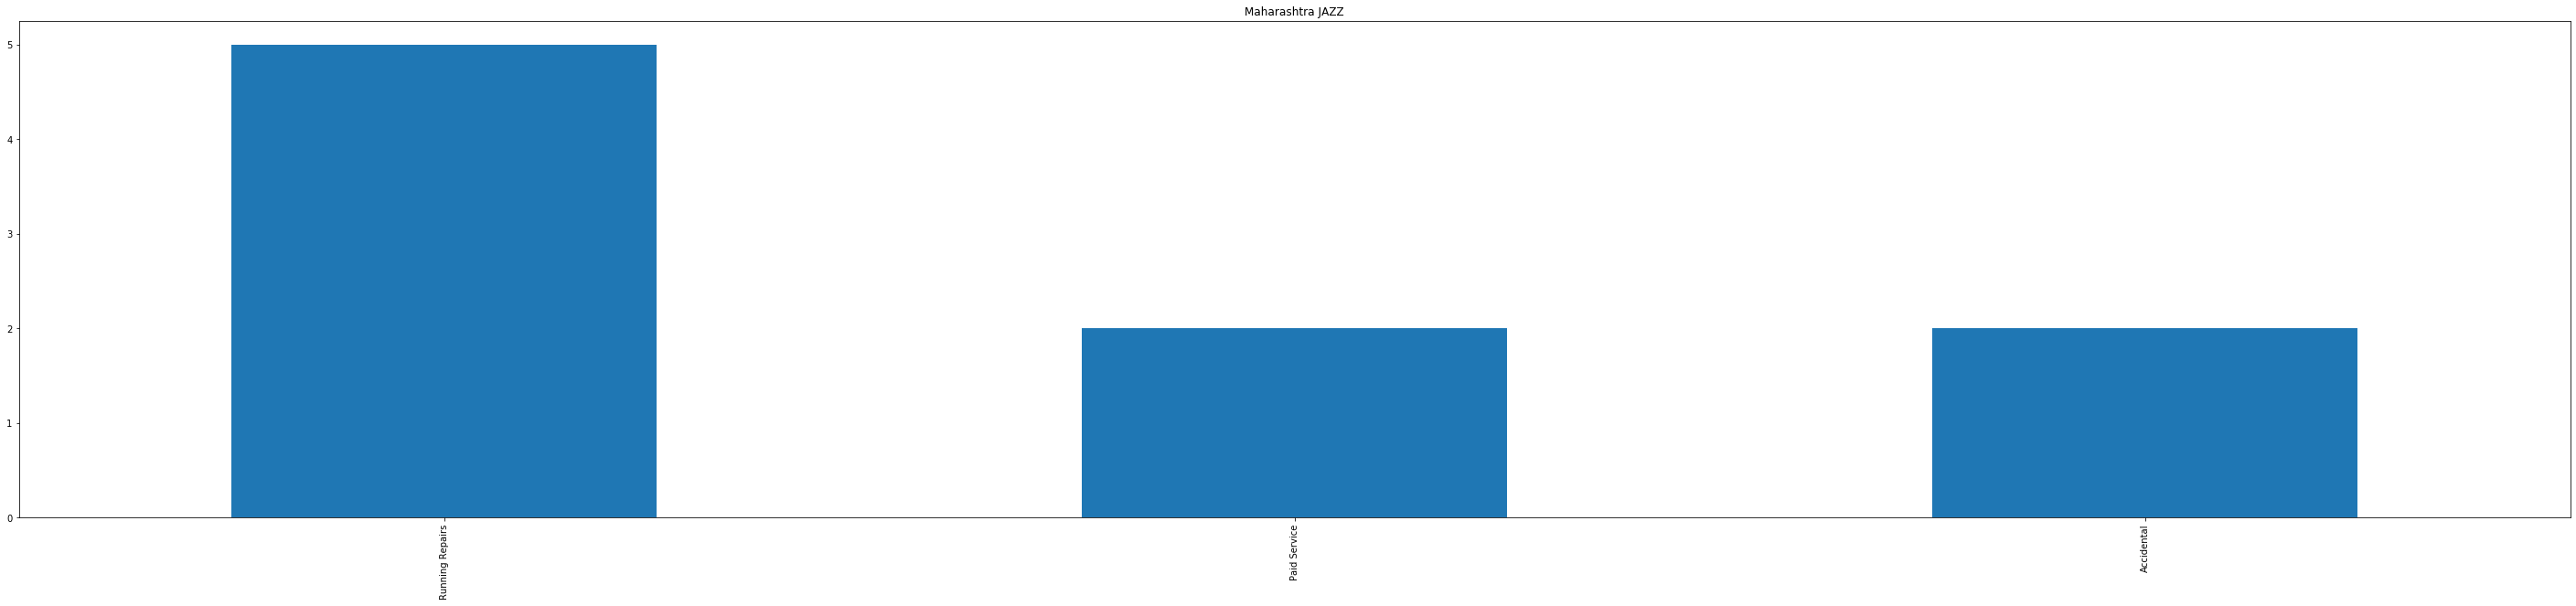

PETRA


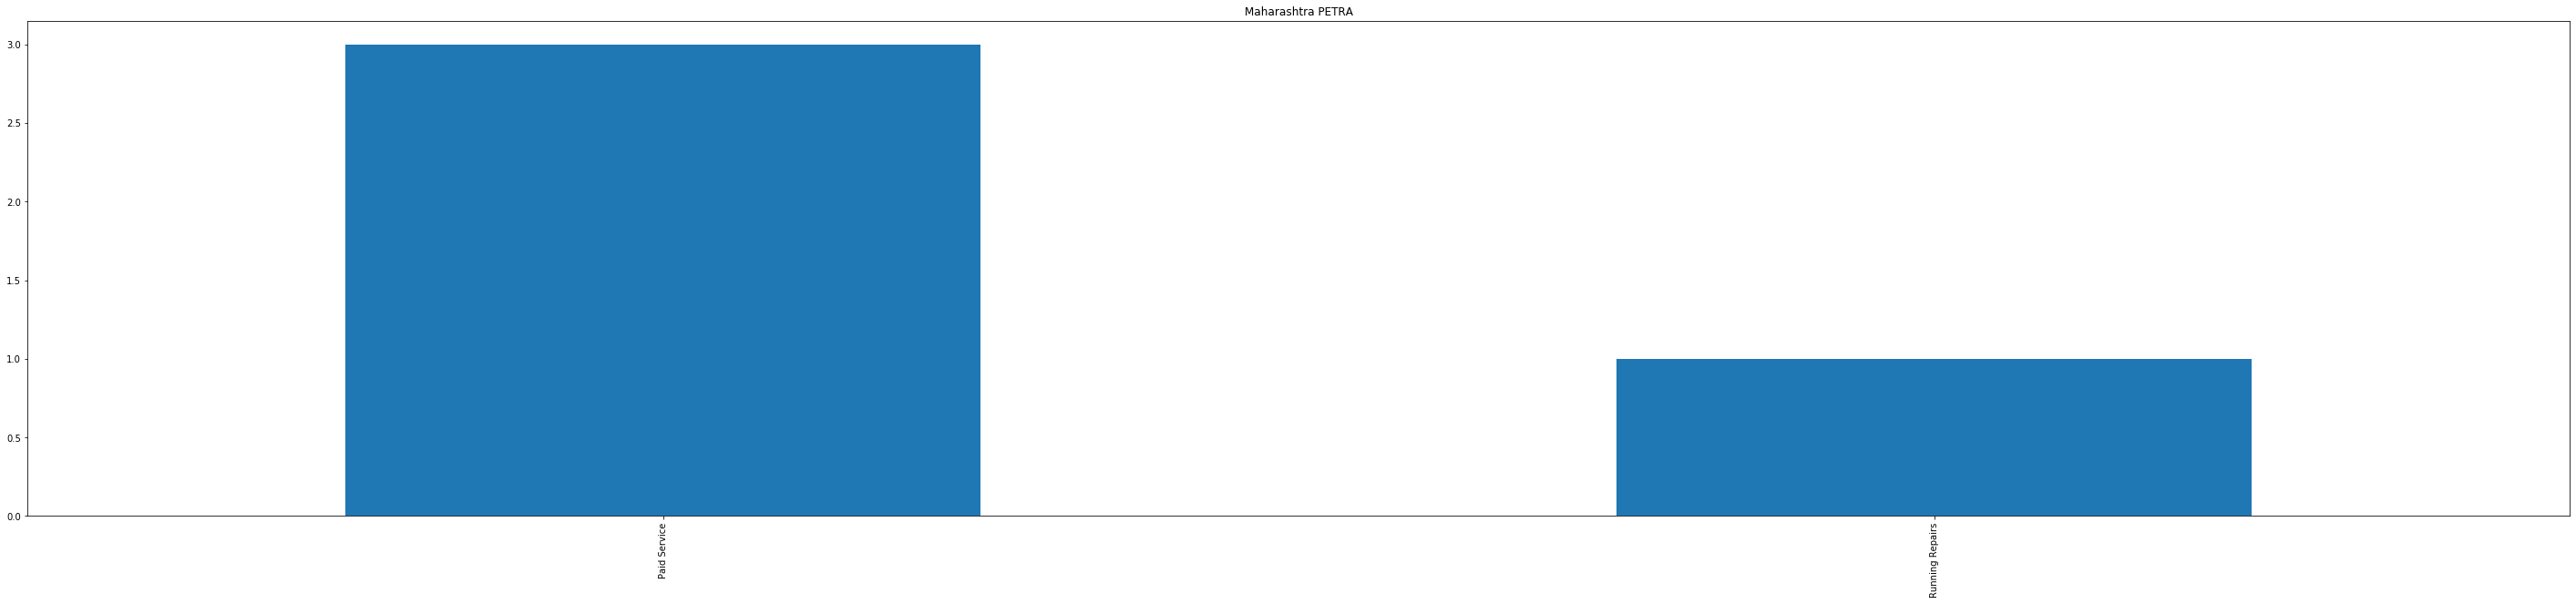

ADVENTURE


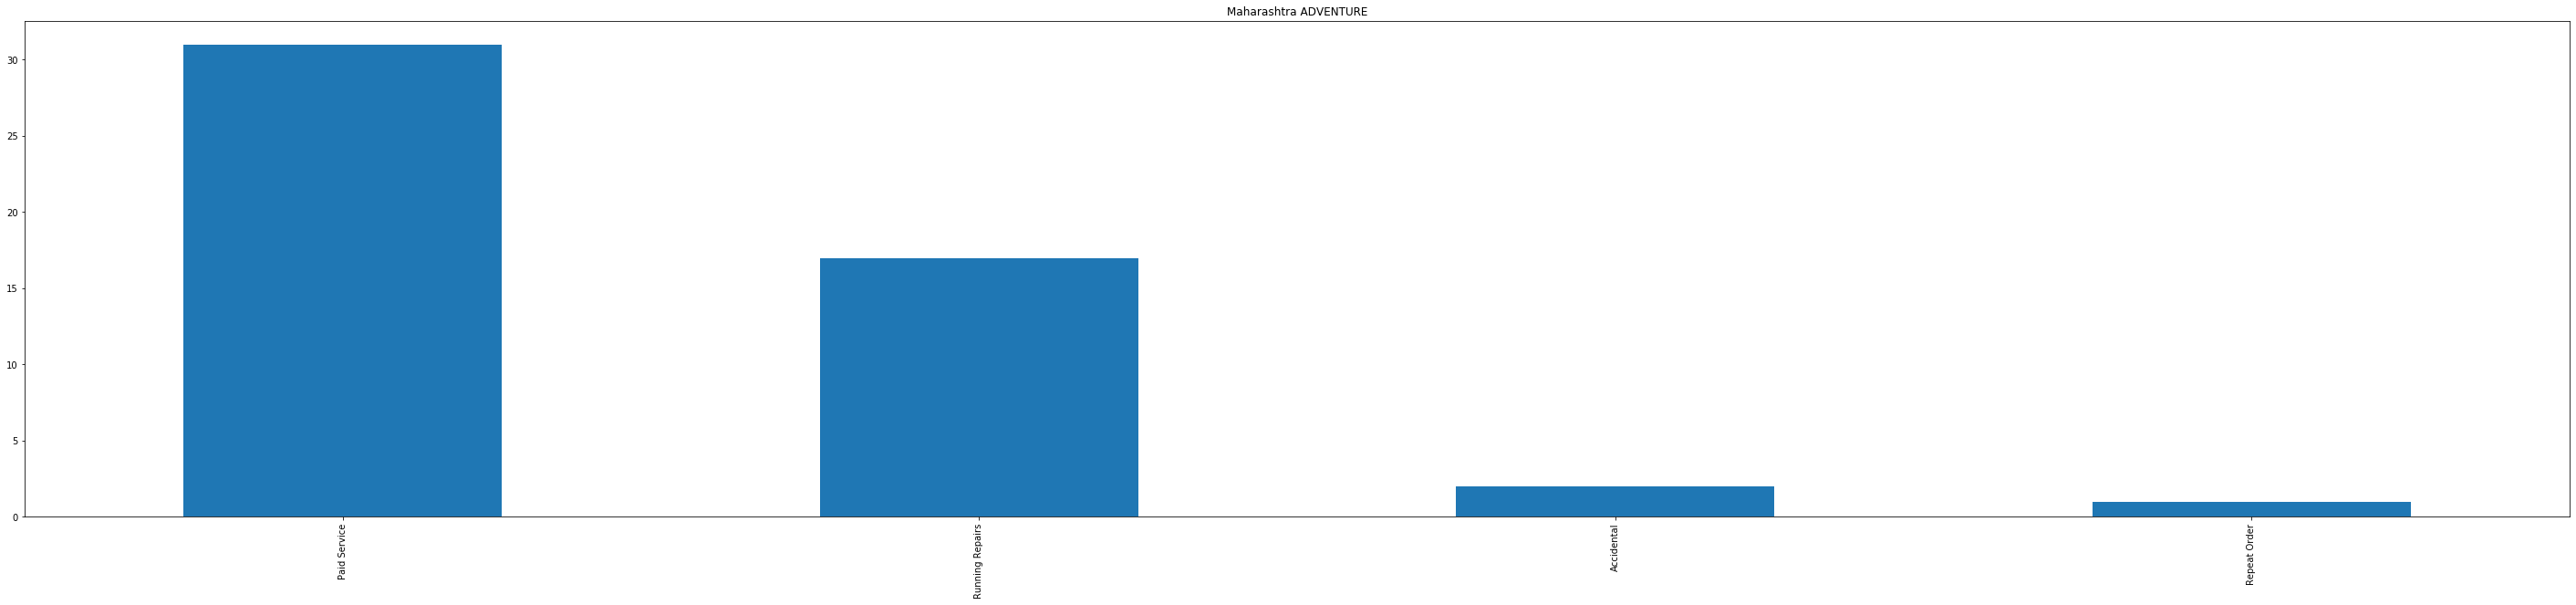

PALIO STILE


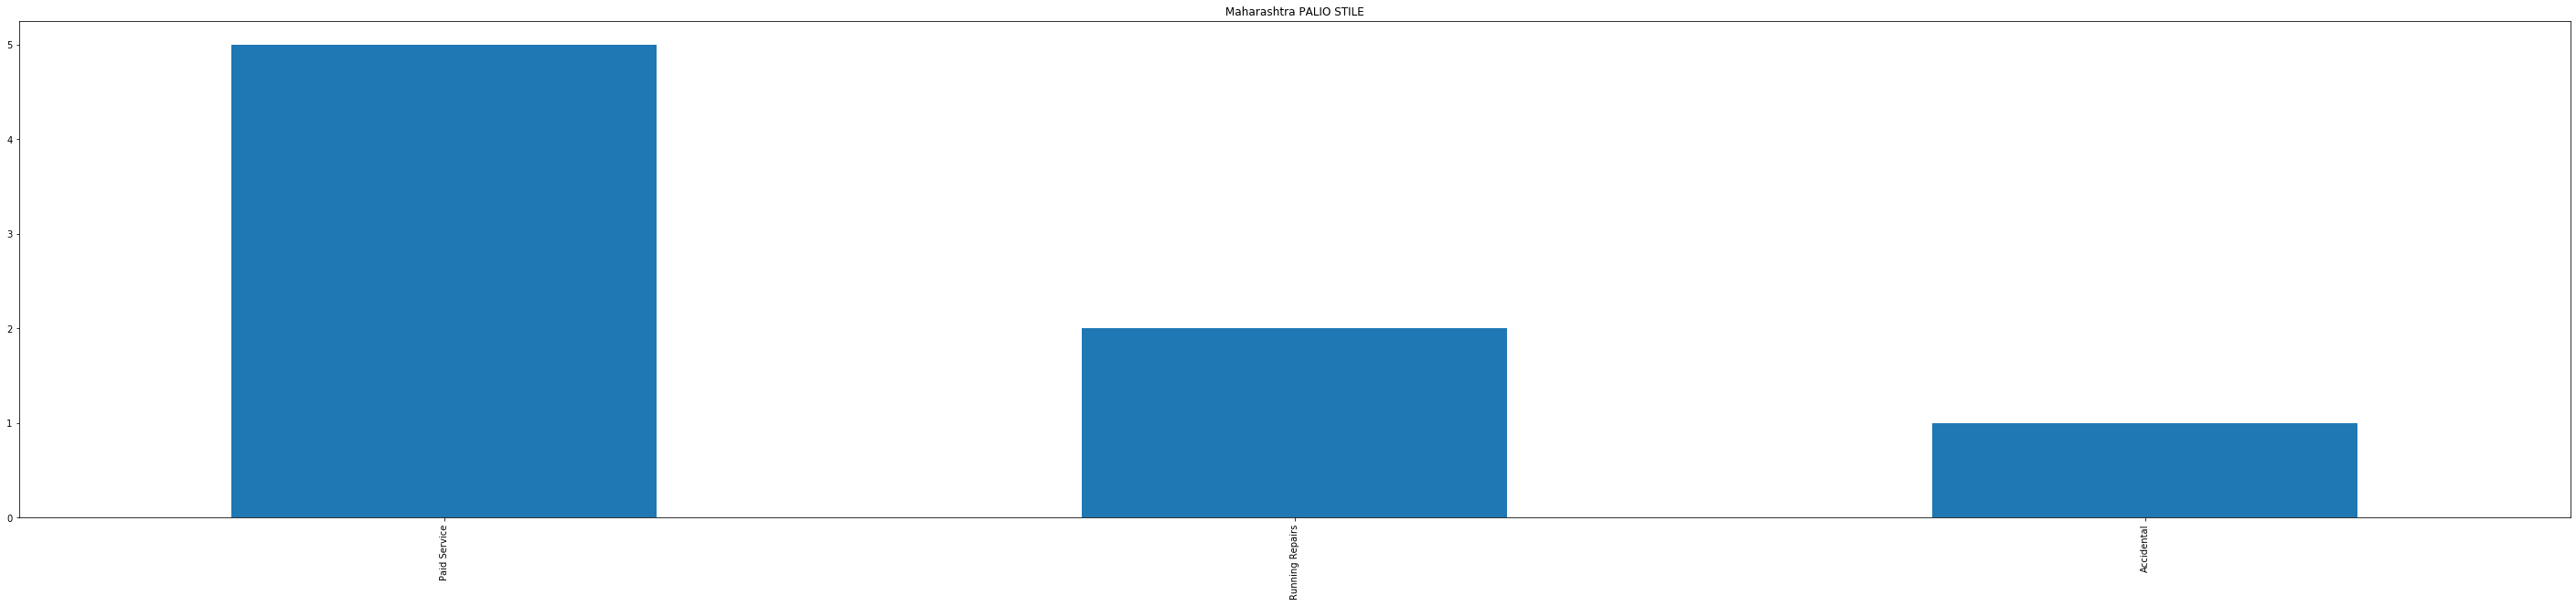

EON


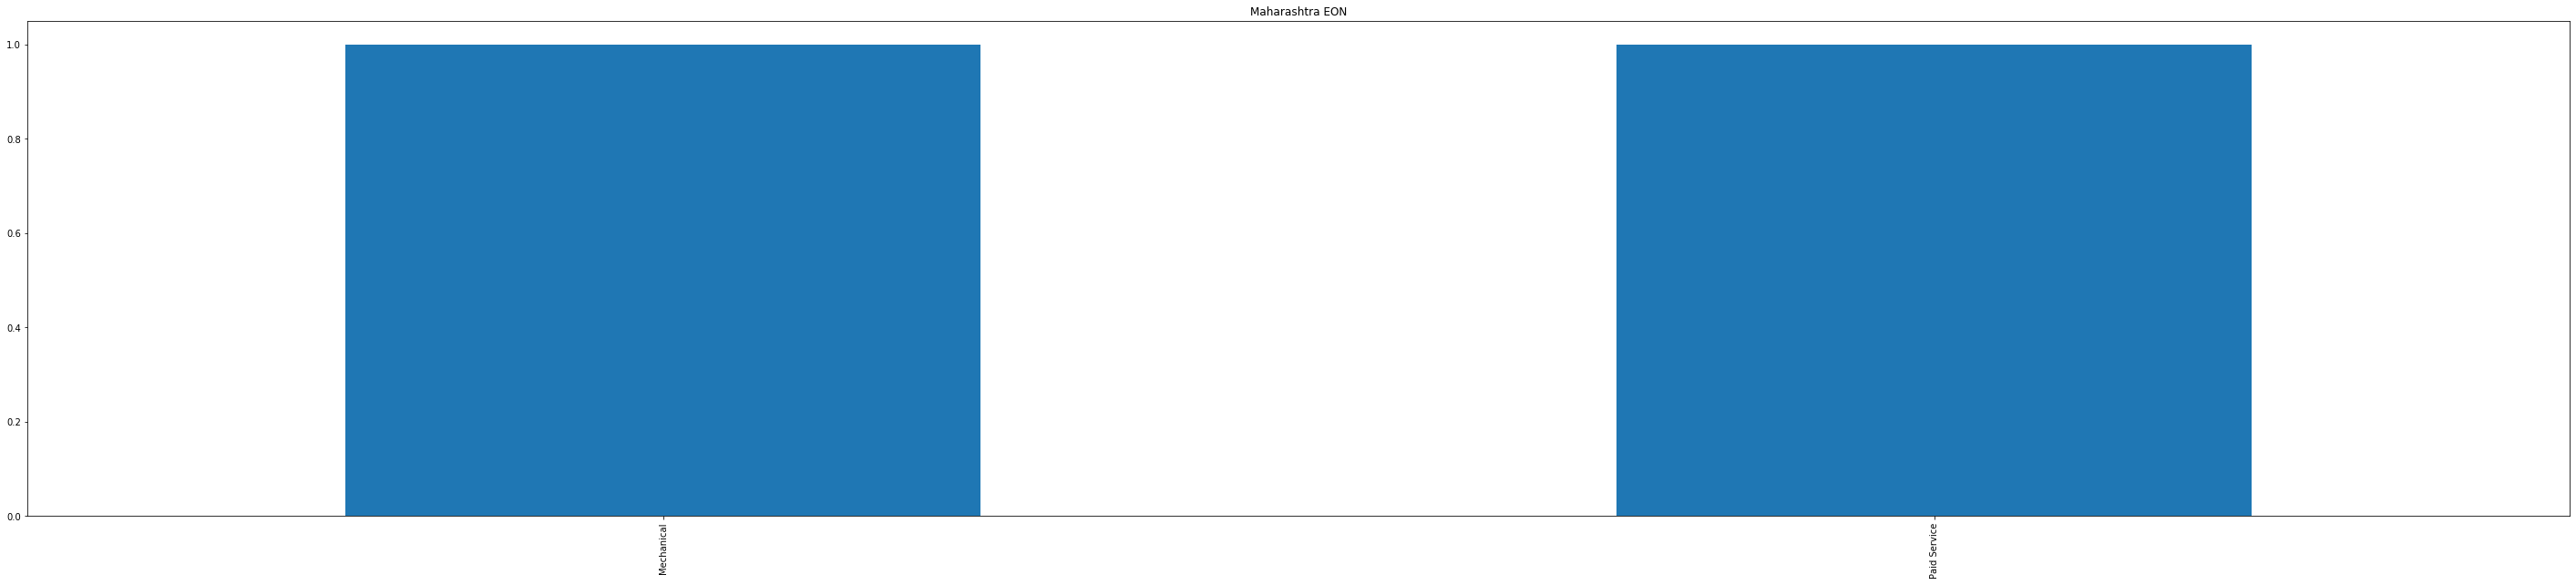

ETIOS


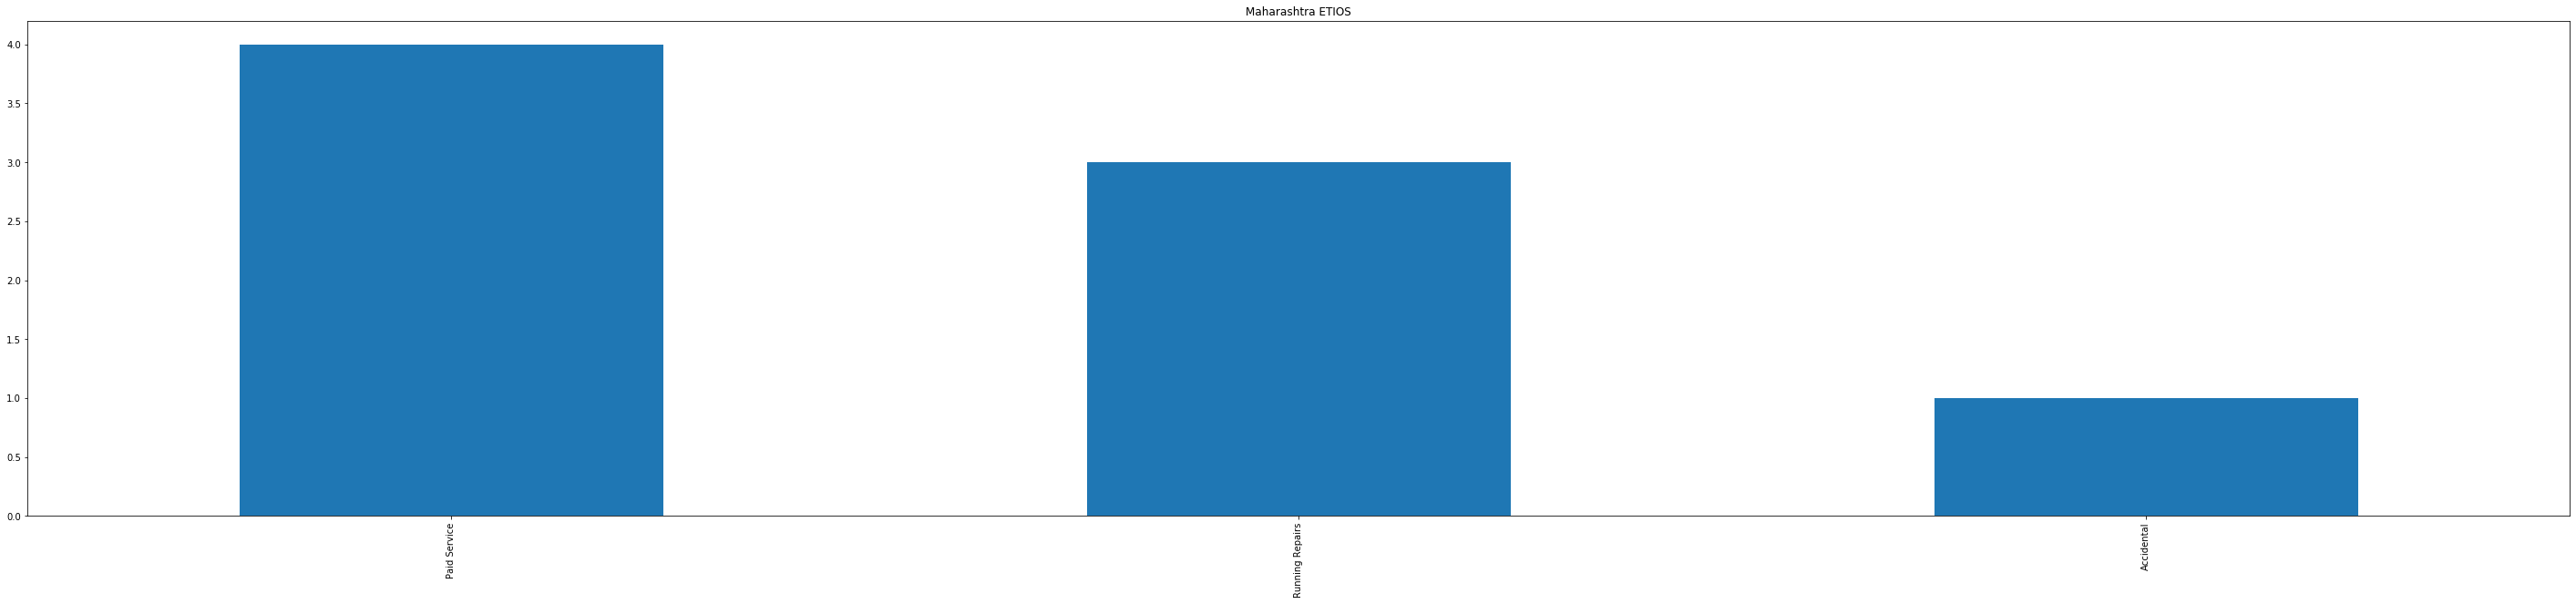

X-TRAIL


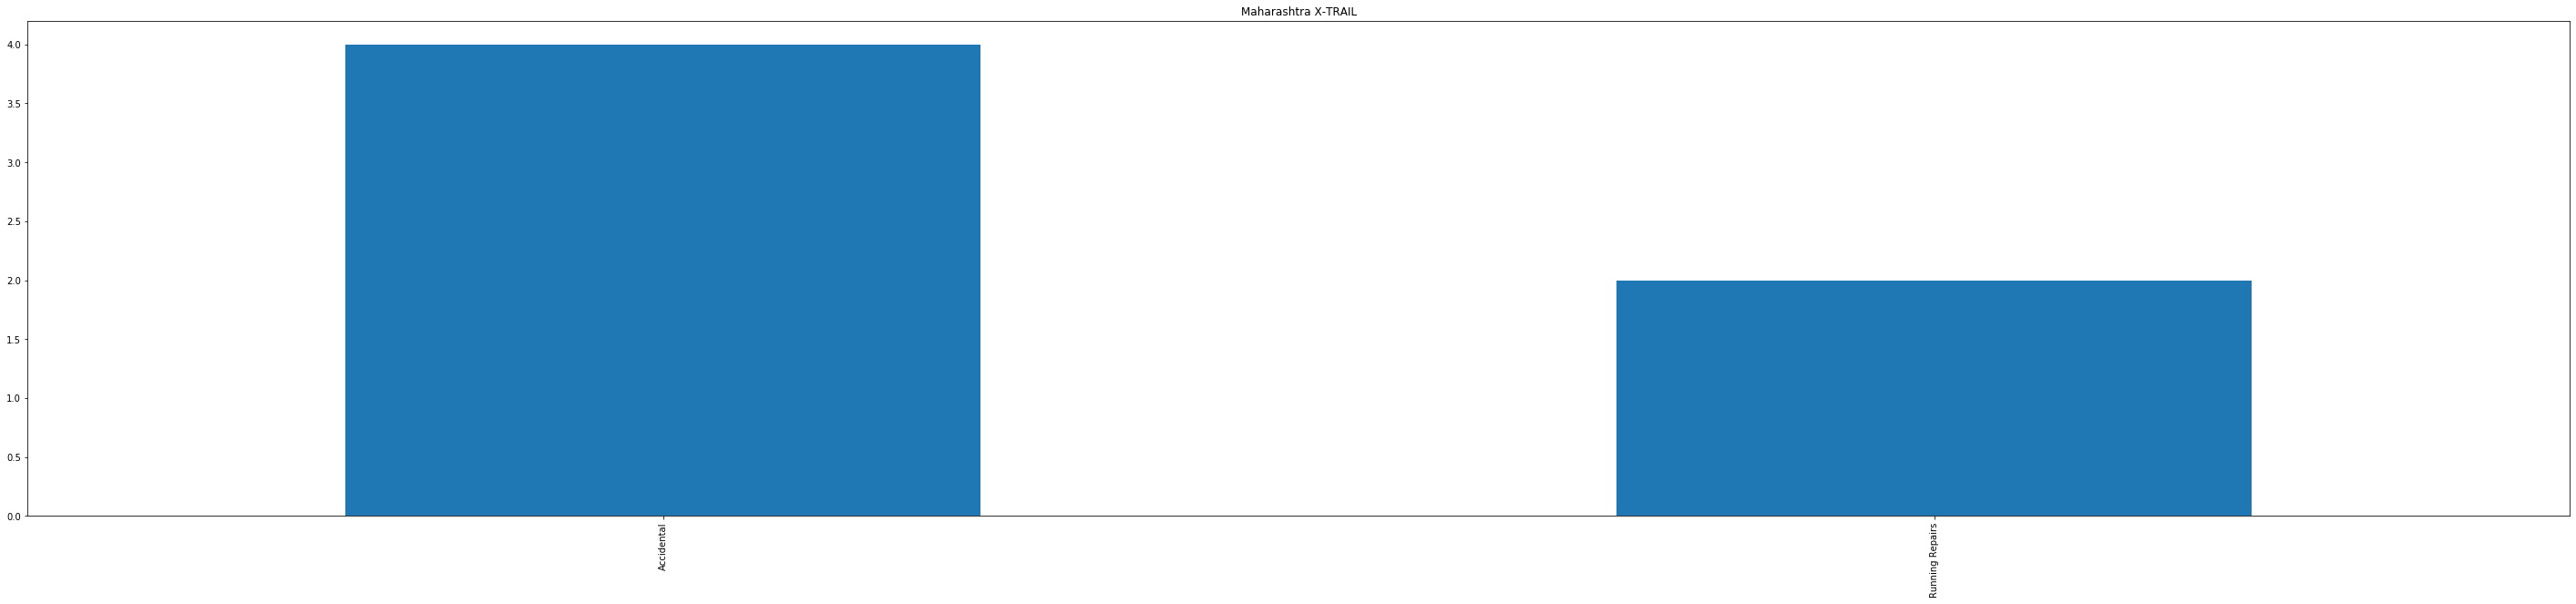

SUPER SUNNY


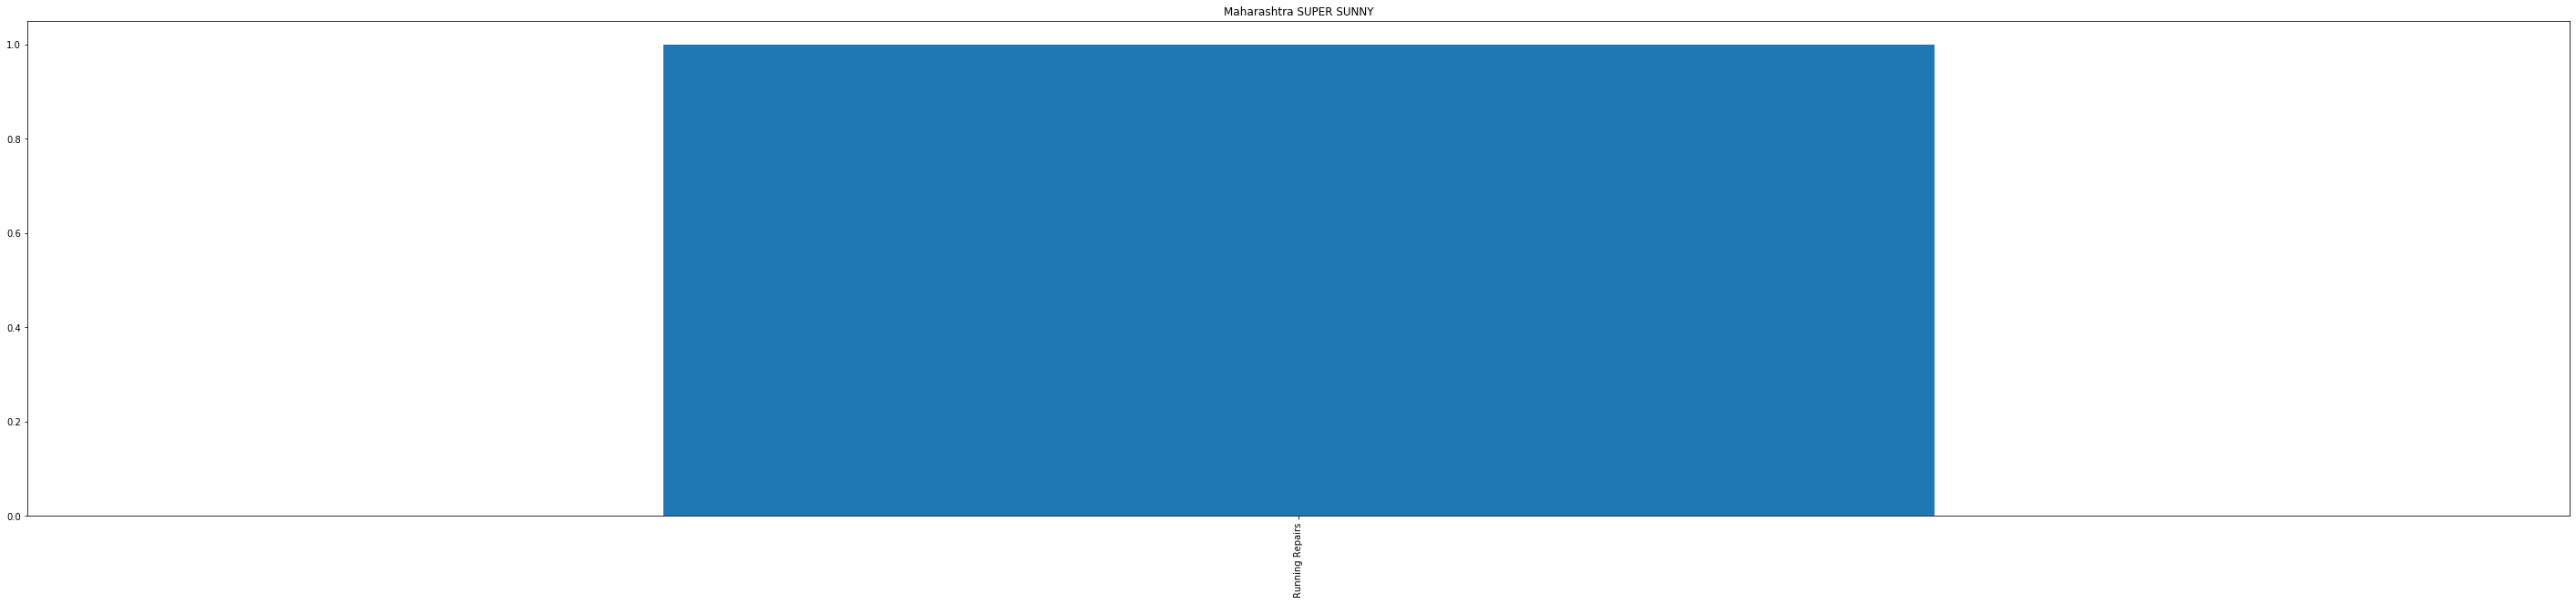

AMBASSADOR


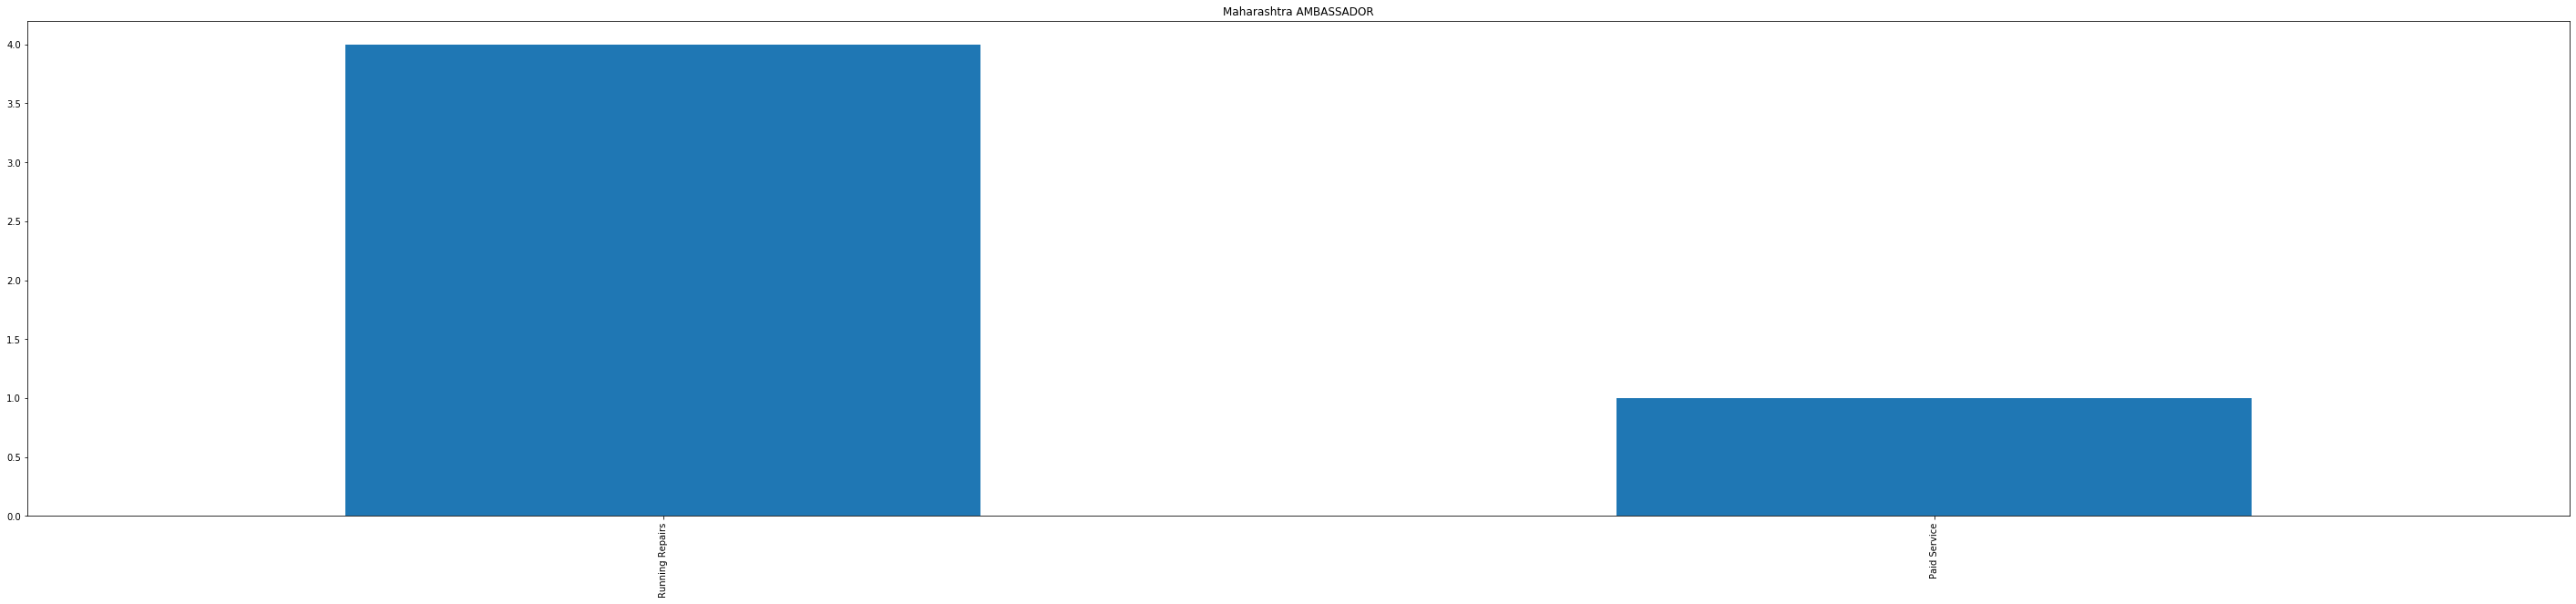

VENTURE


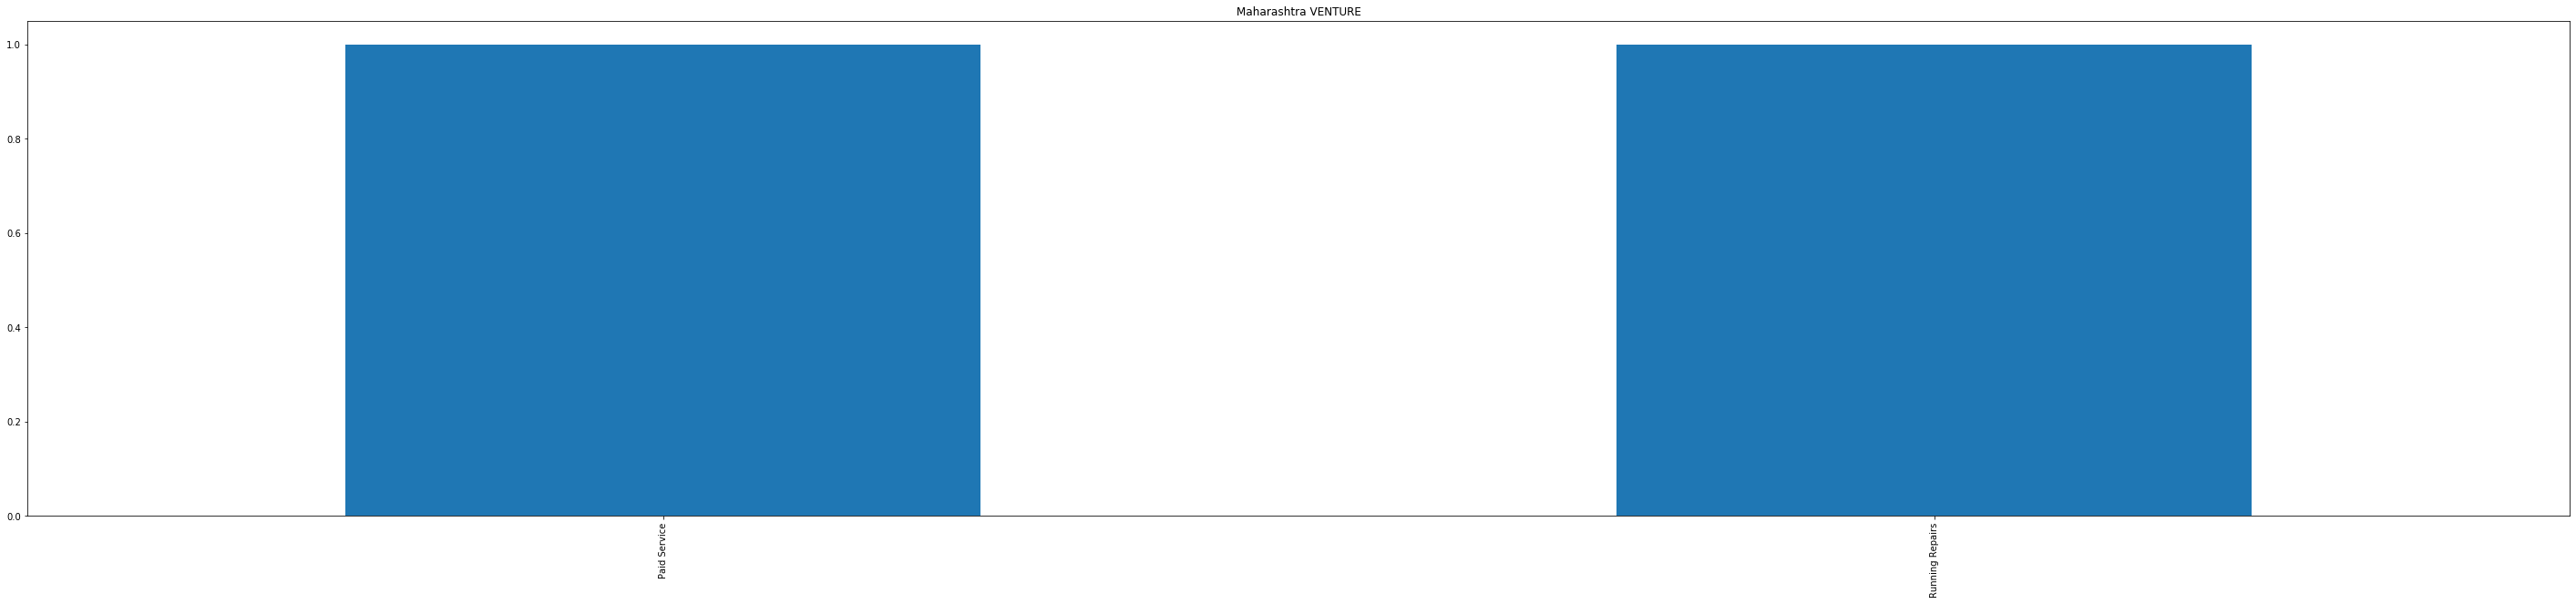

BOLERO PIK UP


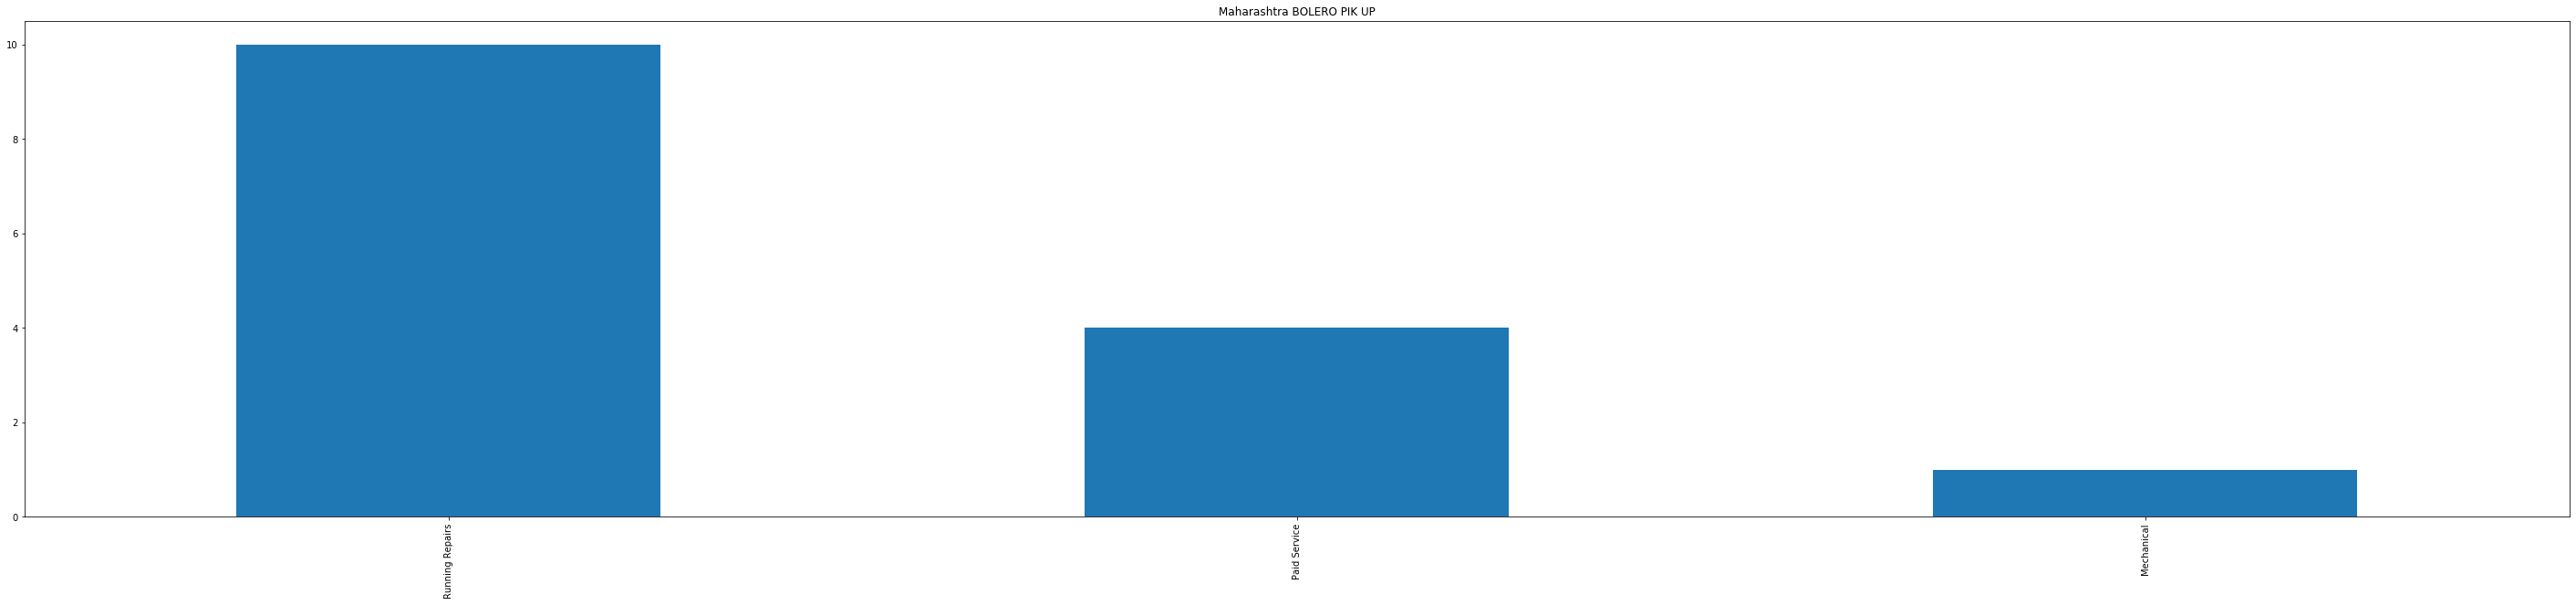

XCENT


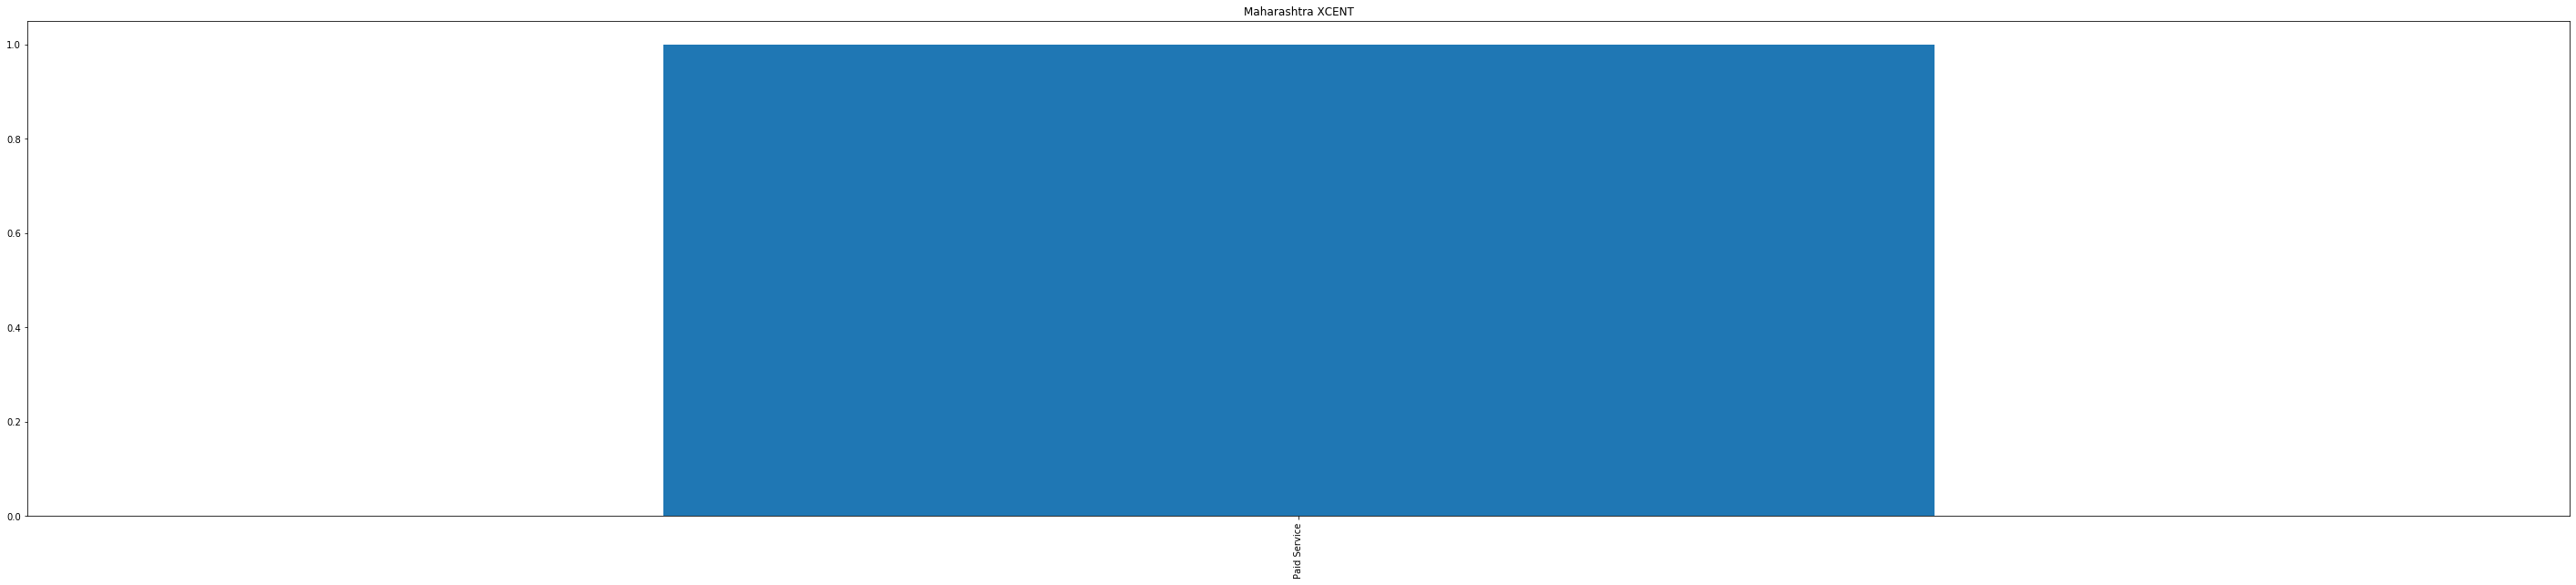

BRIO


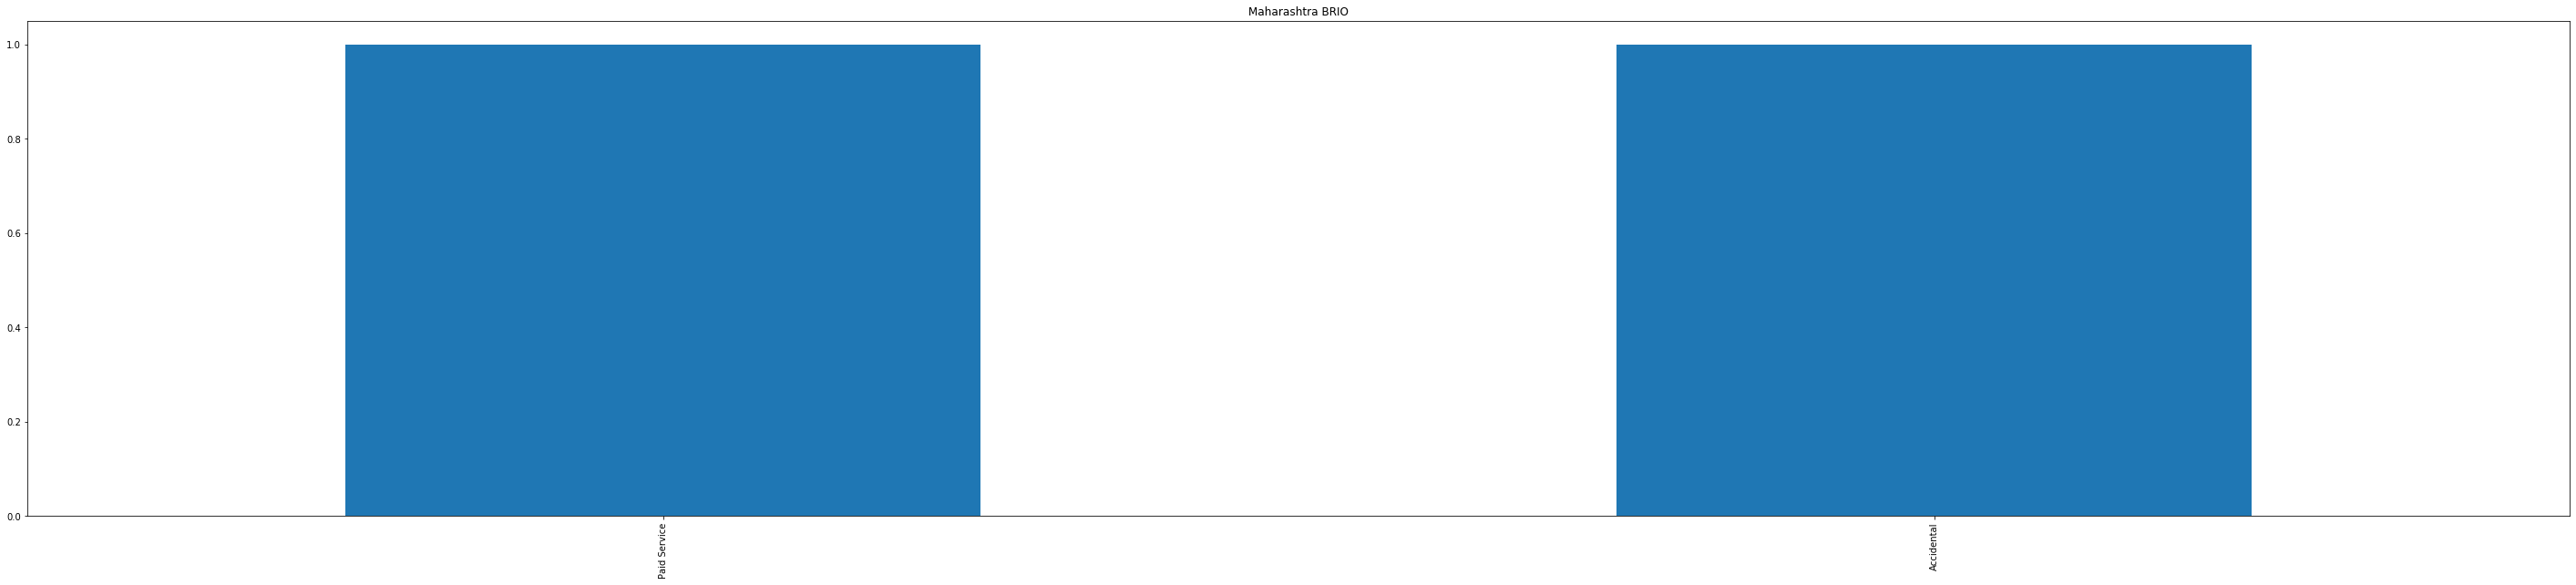

FLUENCE


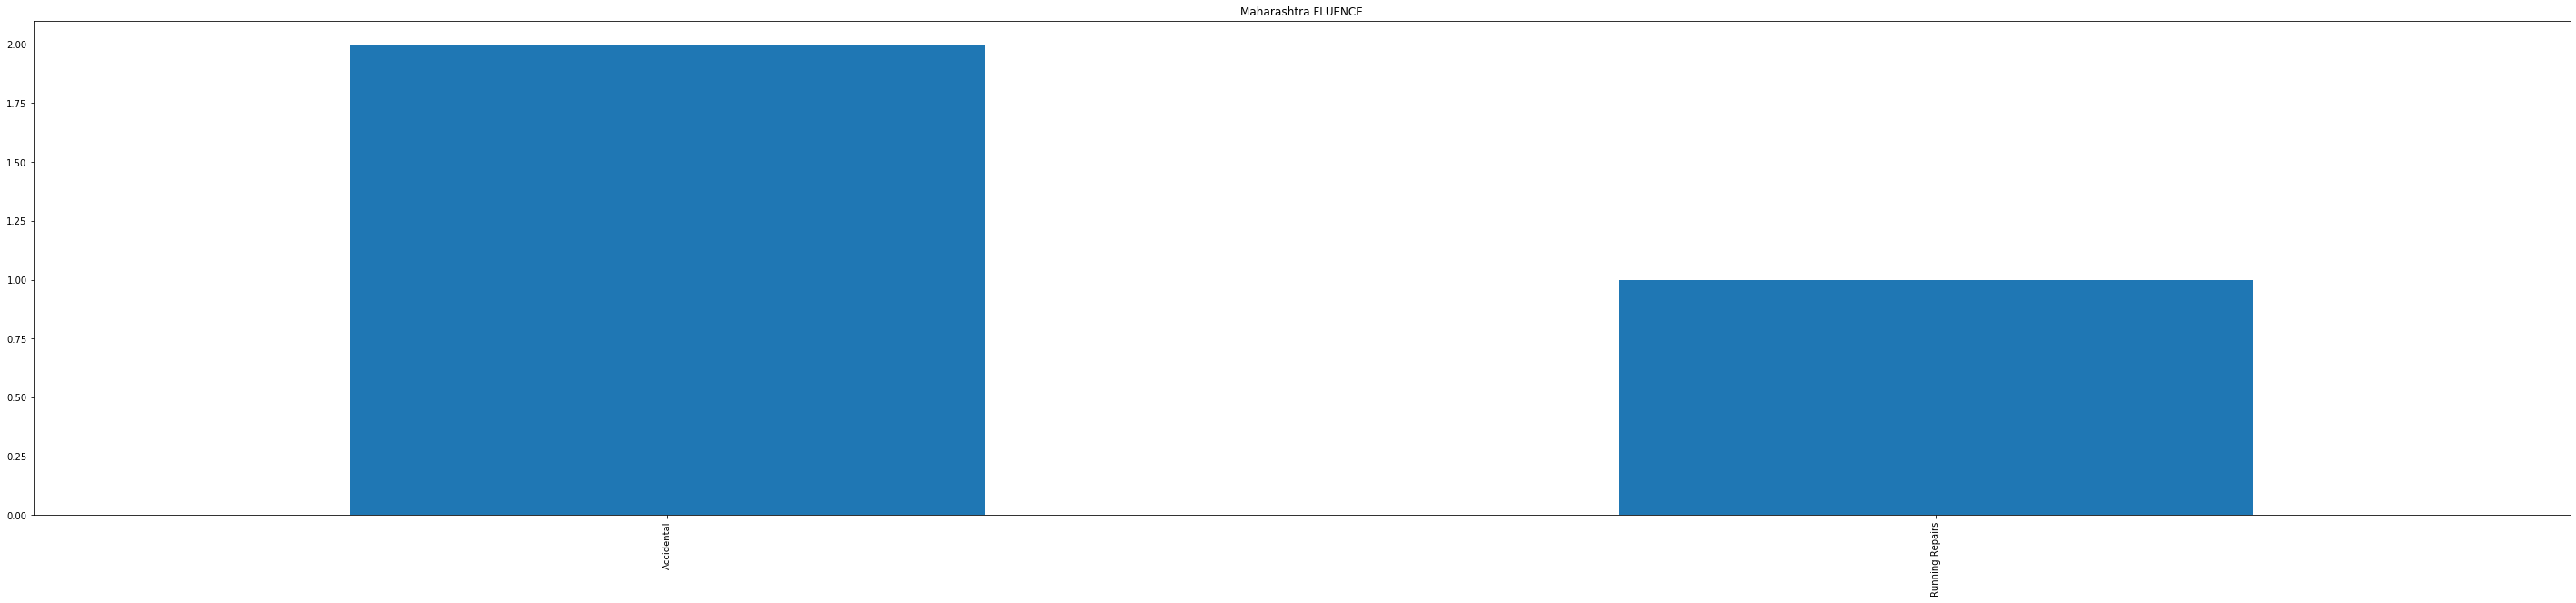

SSANYONG REXTON


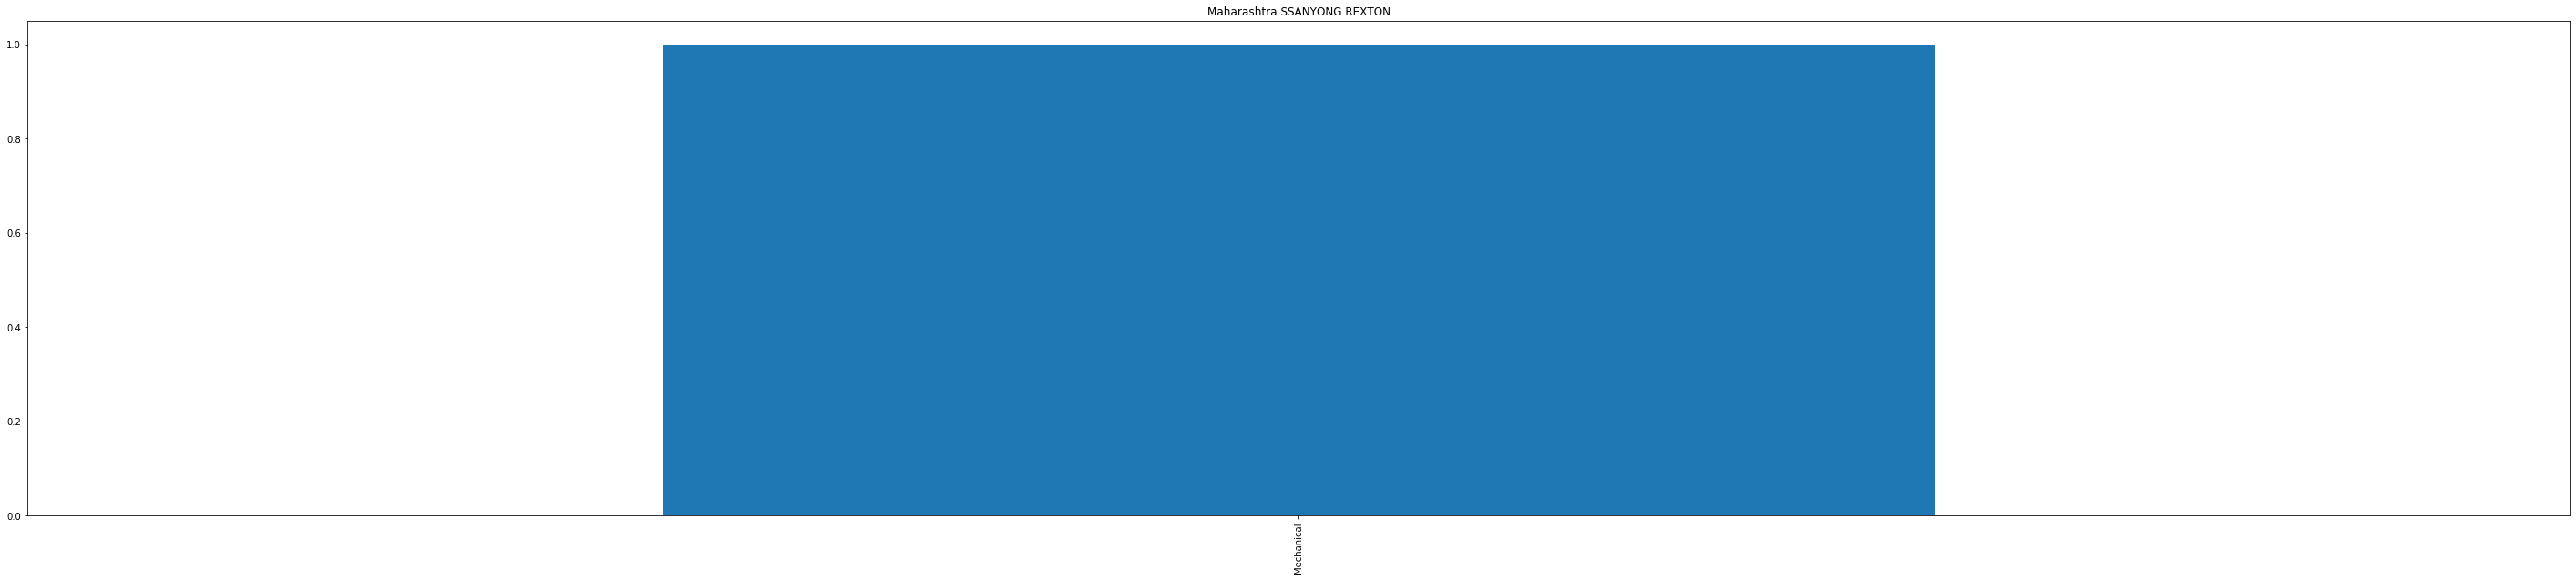

In [156]:
def model_order(state):
    city=[]
    city=join['District'].unique()
    order=join['Order Type'].unique()
    #print(cars['Order Type'].value_counts())

    cars=join[join['District']==state]
    for j in cars['Model'].unique():
        print(j)
        order=cars[cars['Model']==j]
        fig=plt.figure(figsize=(50,10))
        plt.title('Maharashtra'+" "+j)
        #cars=cars.sort_values('Total Amt Wtd Tax.',ascending=False)
        order['Order Type'].value_counts().plot(kind='bar')
        plt.xticks(rotation=90)
        plt.show()
    
model_order('maharashtra')   

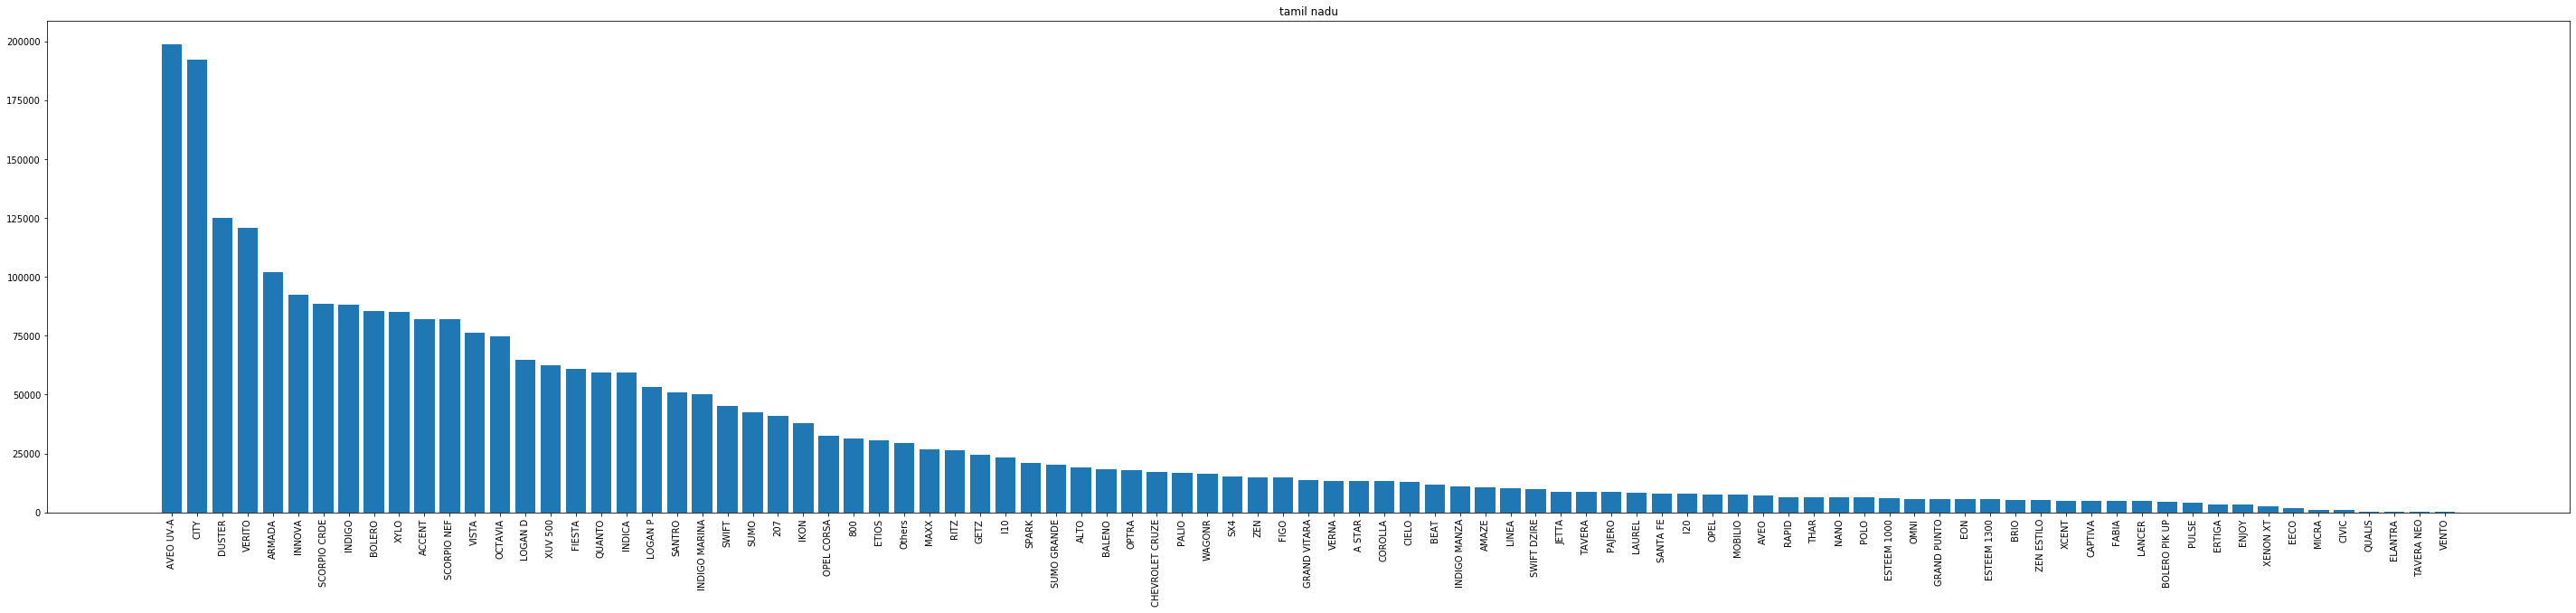

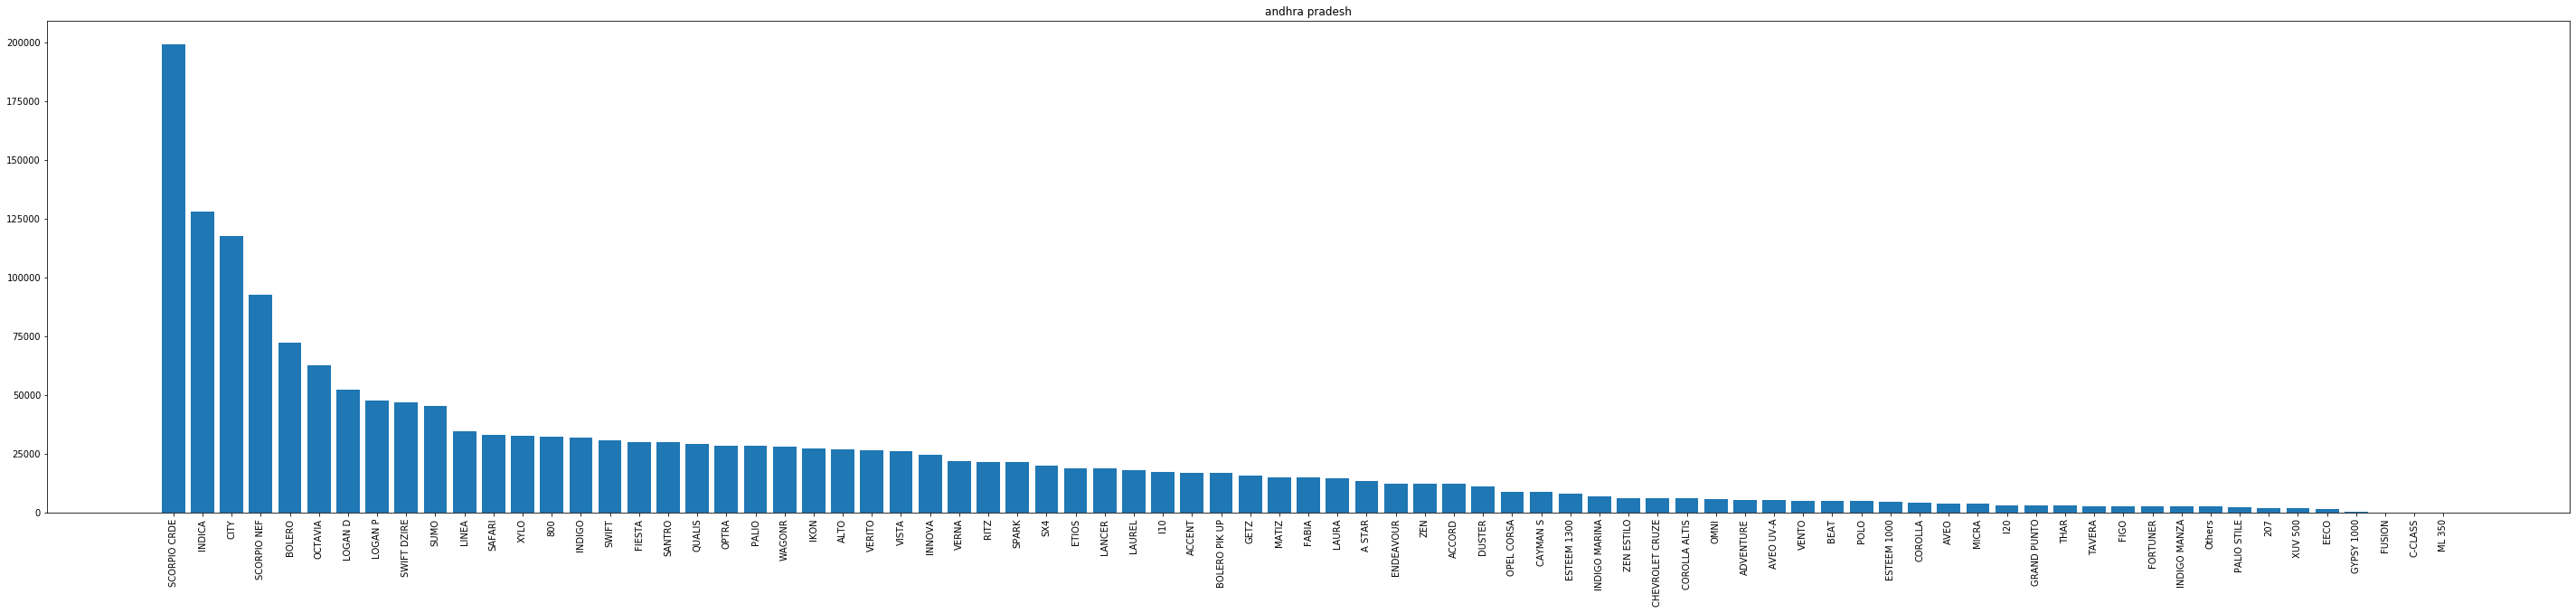

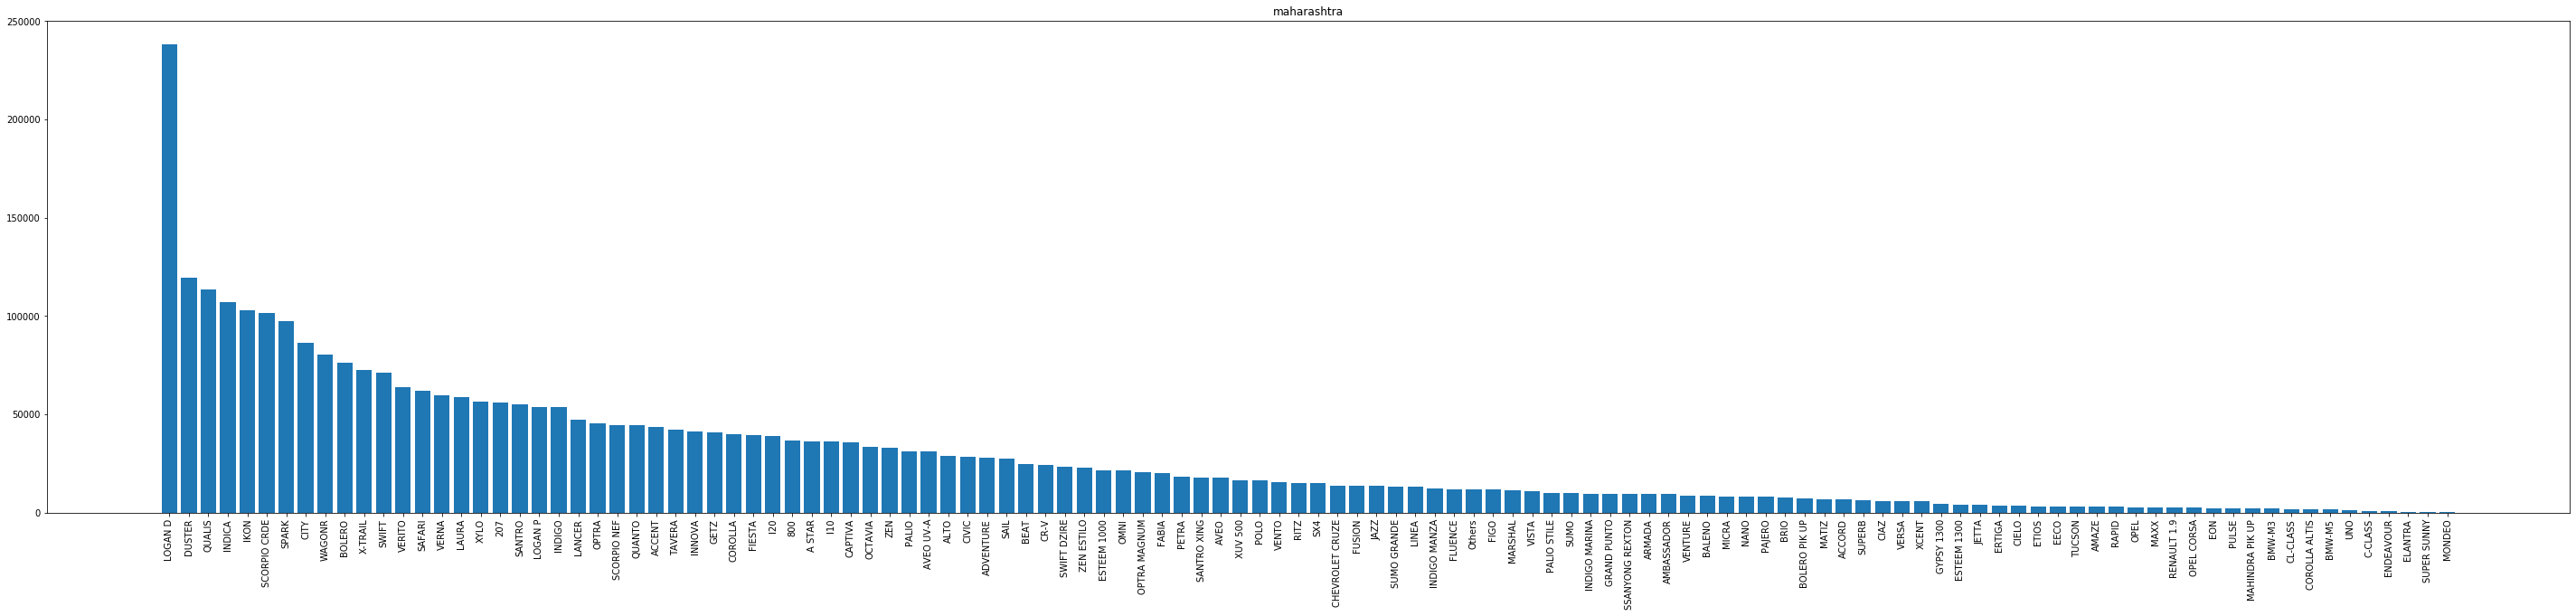

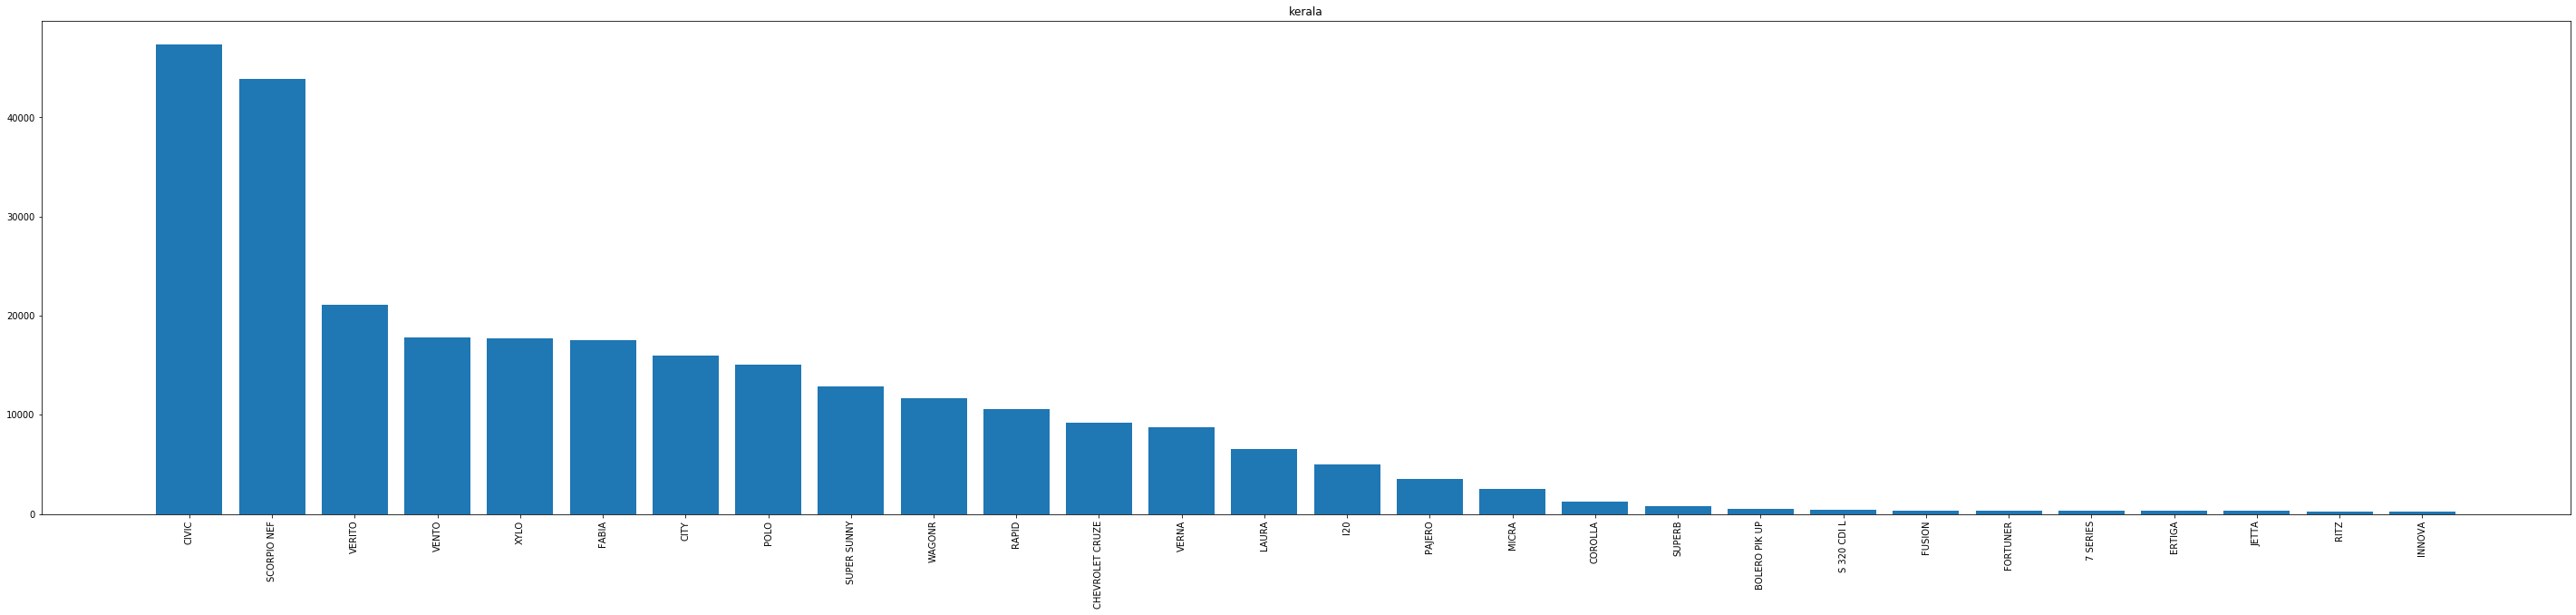

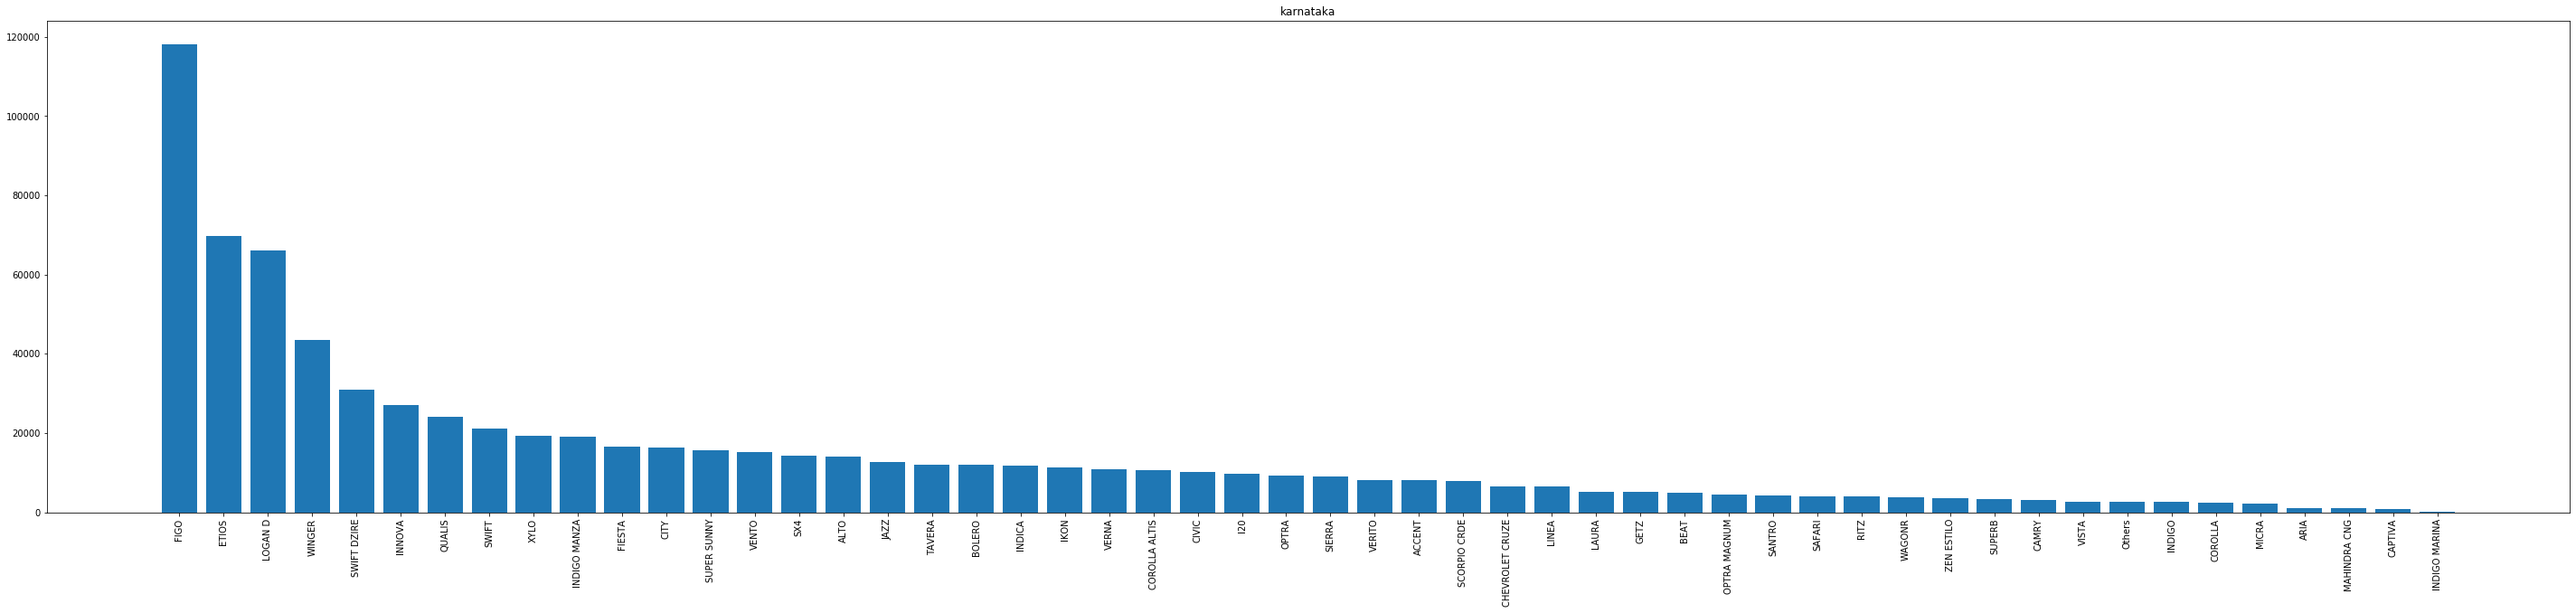

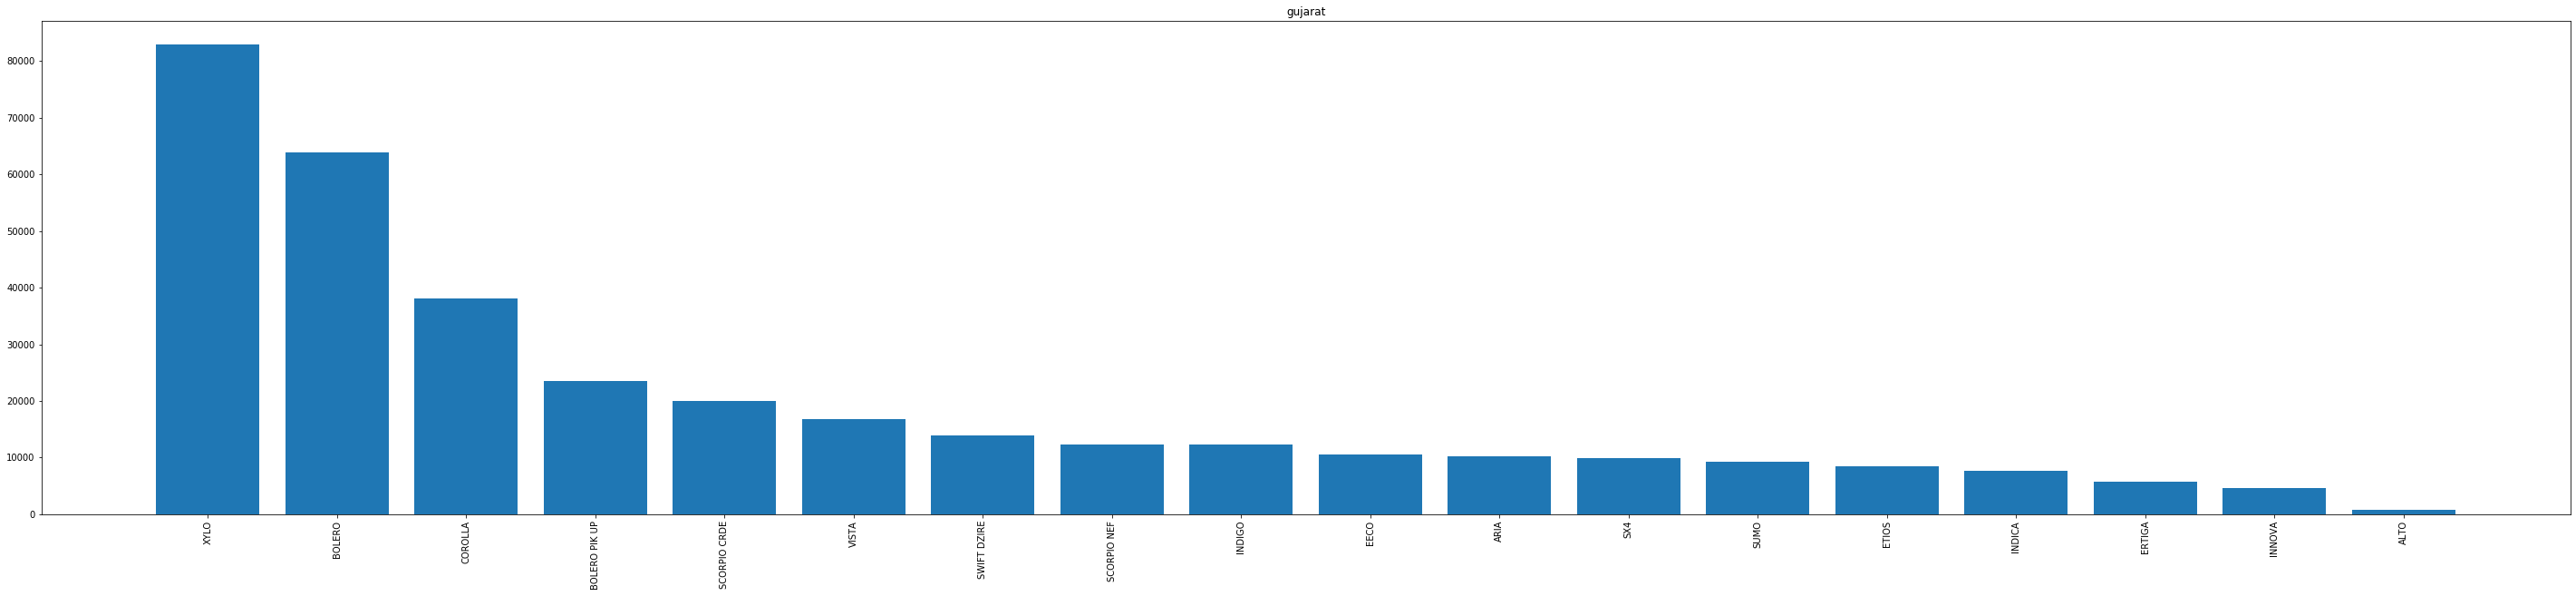

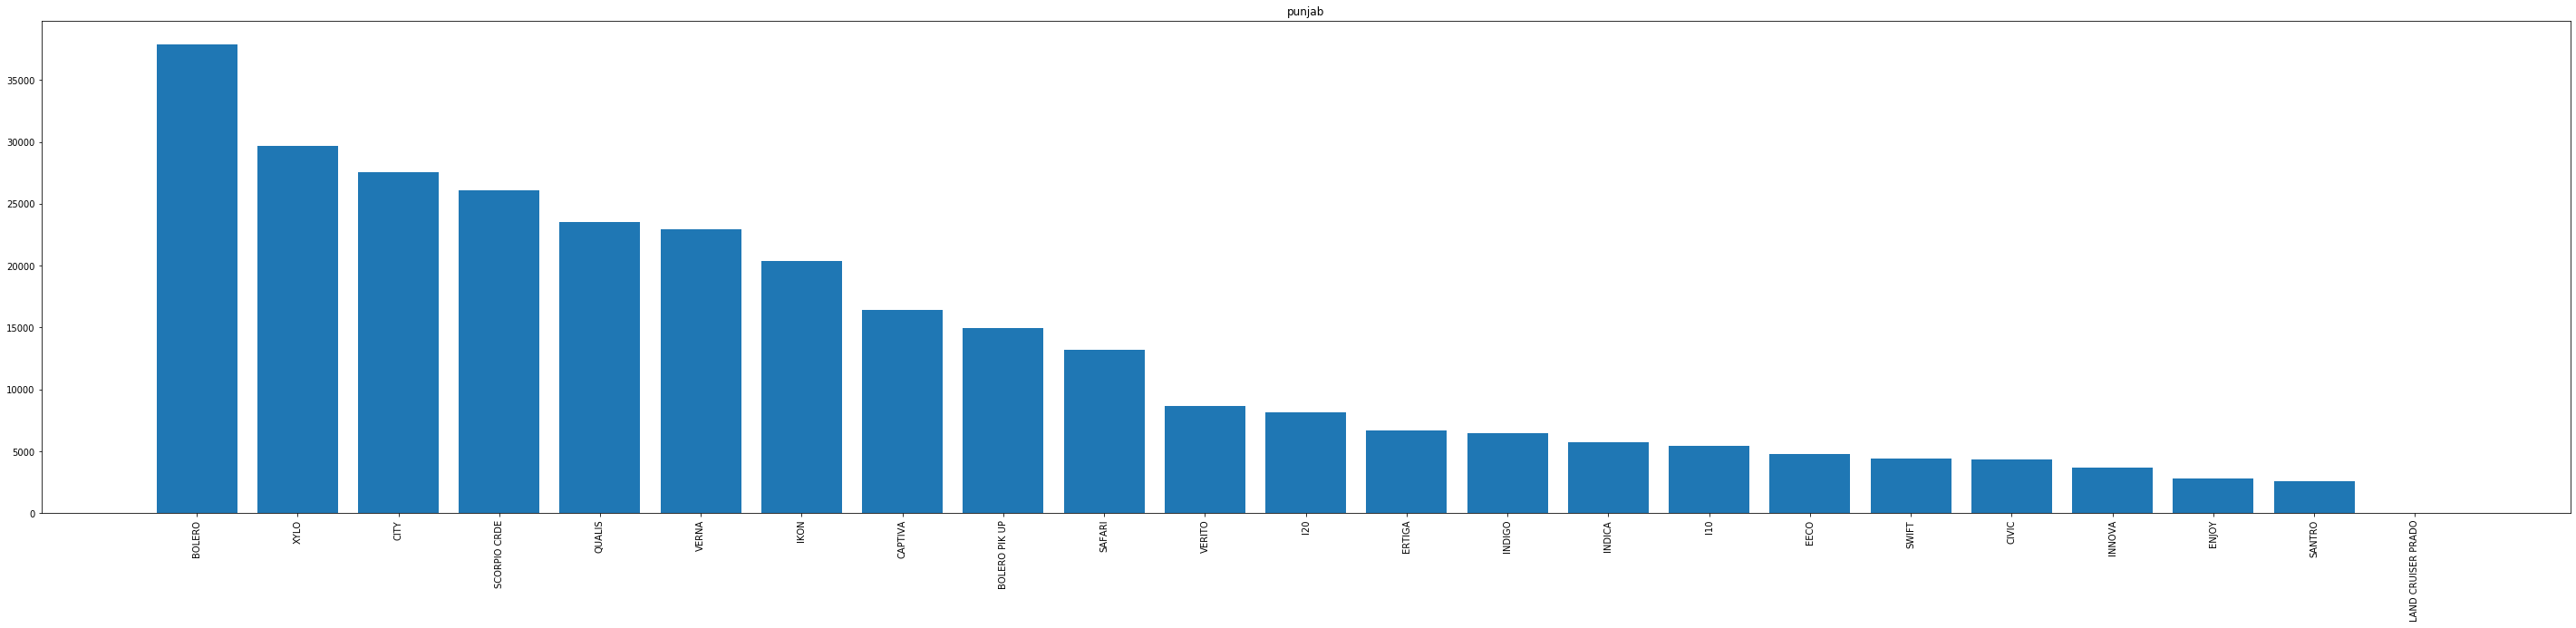

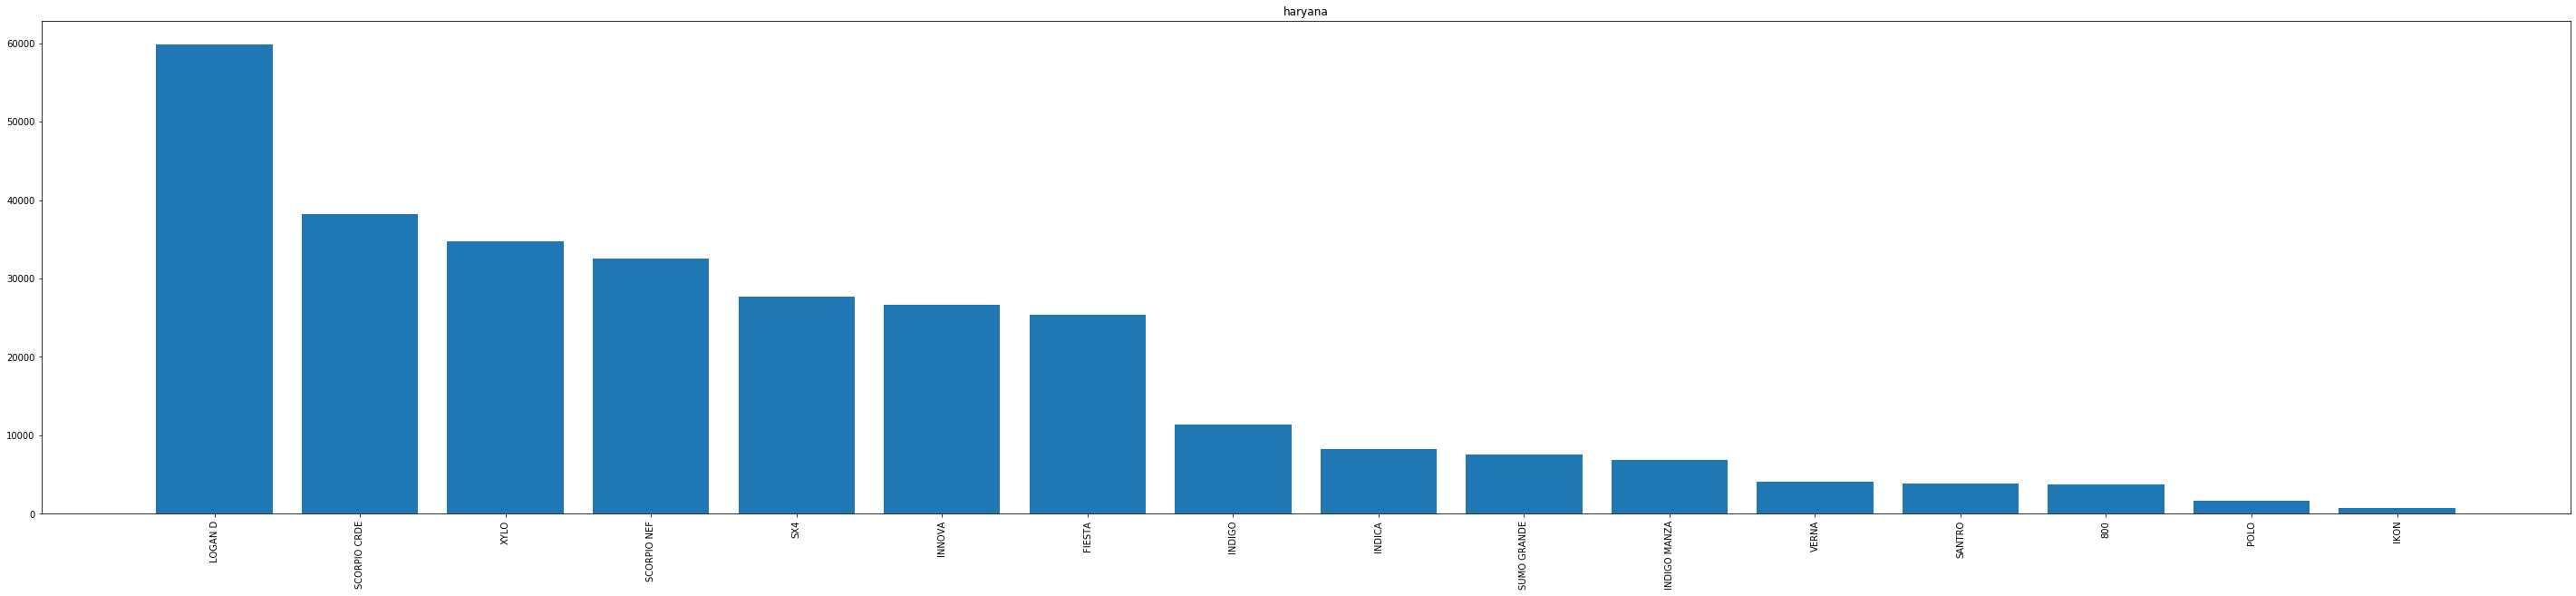

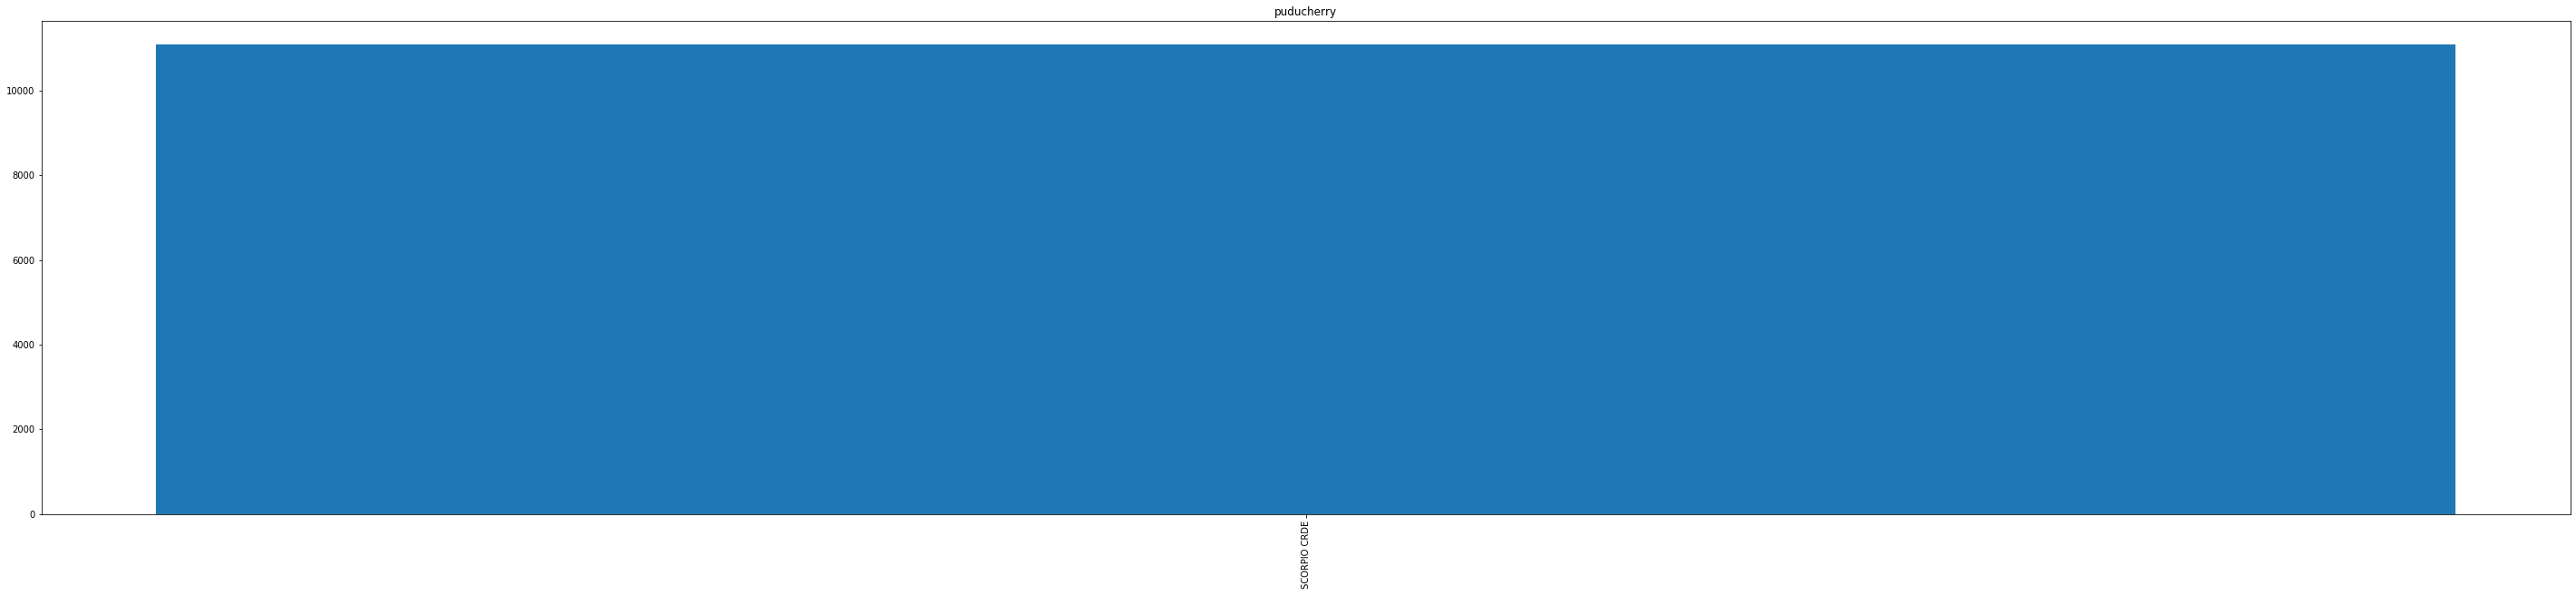

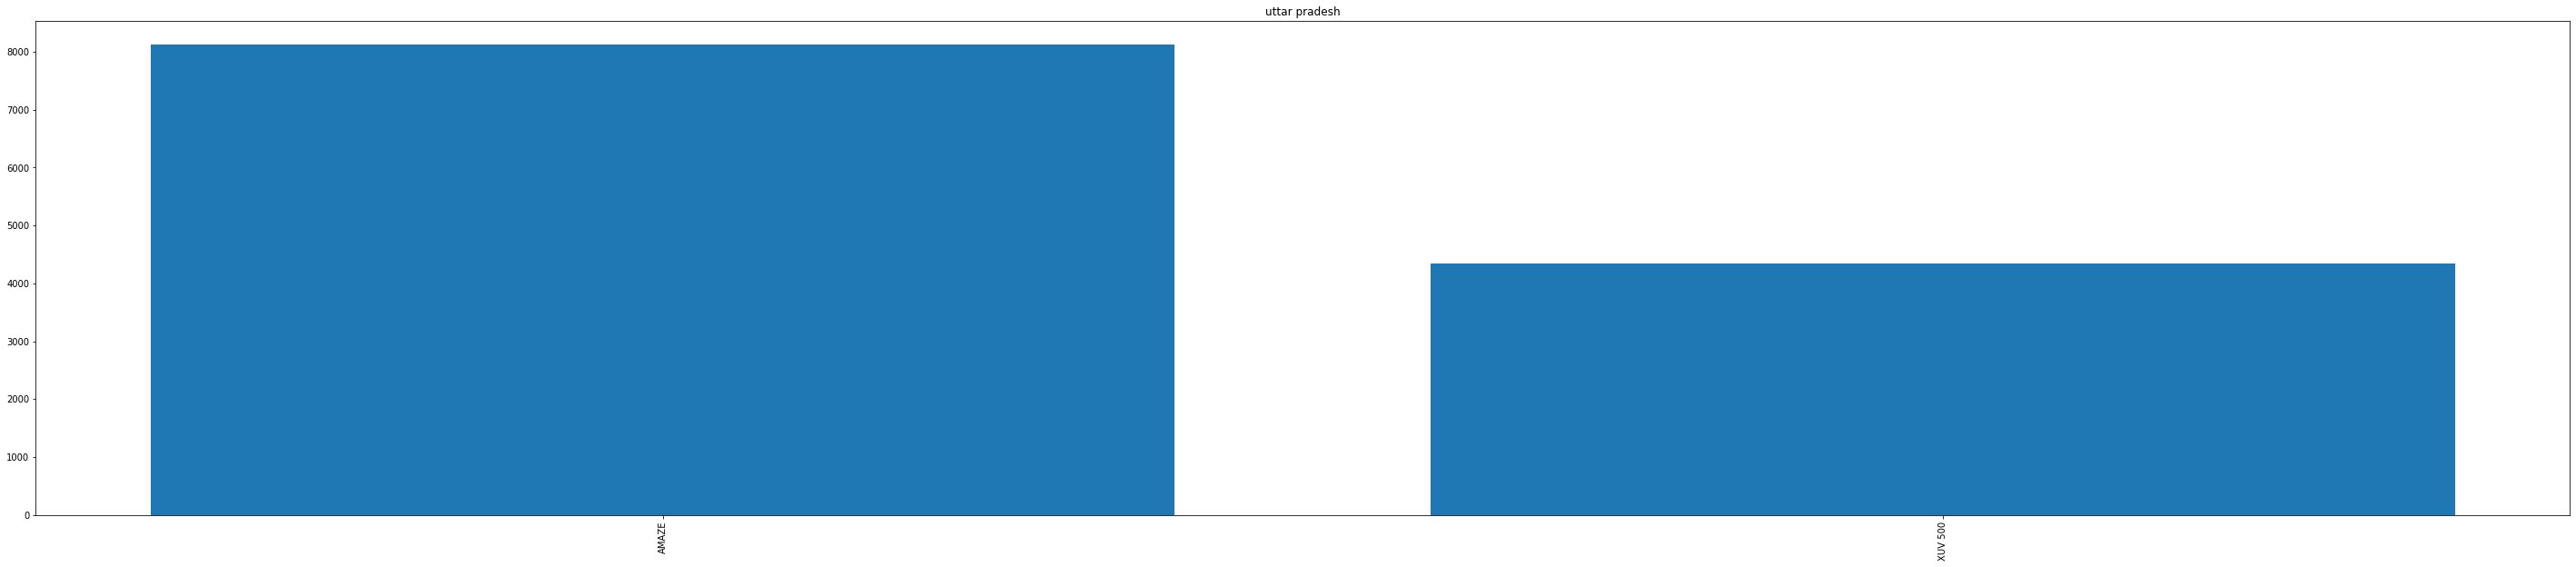

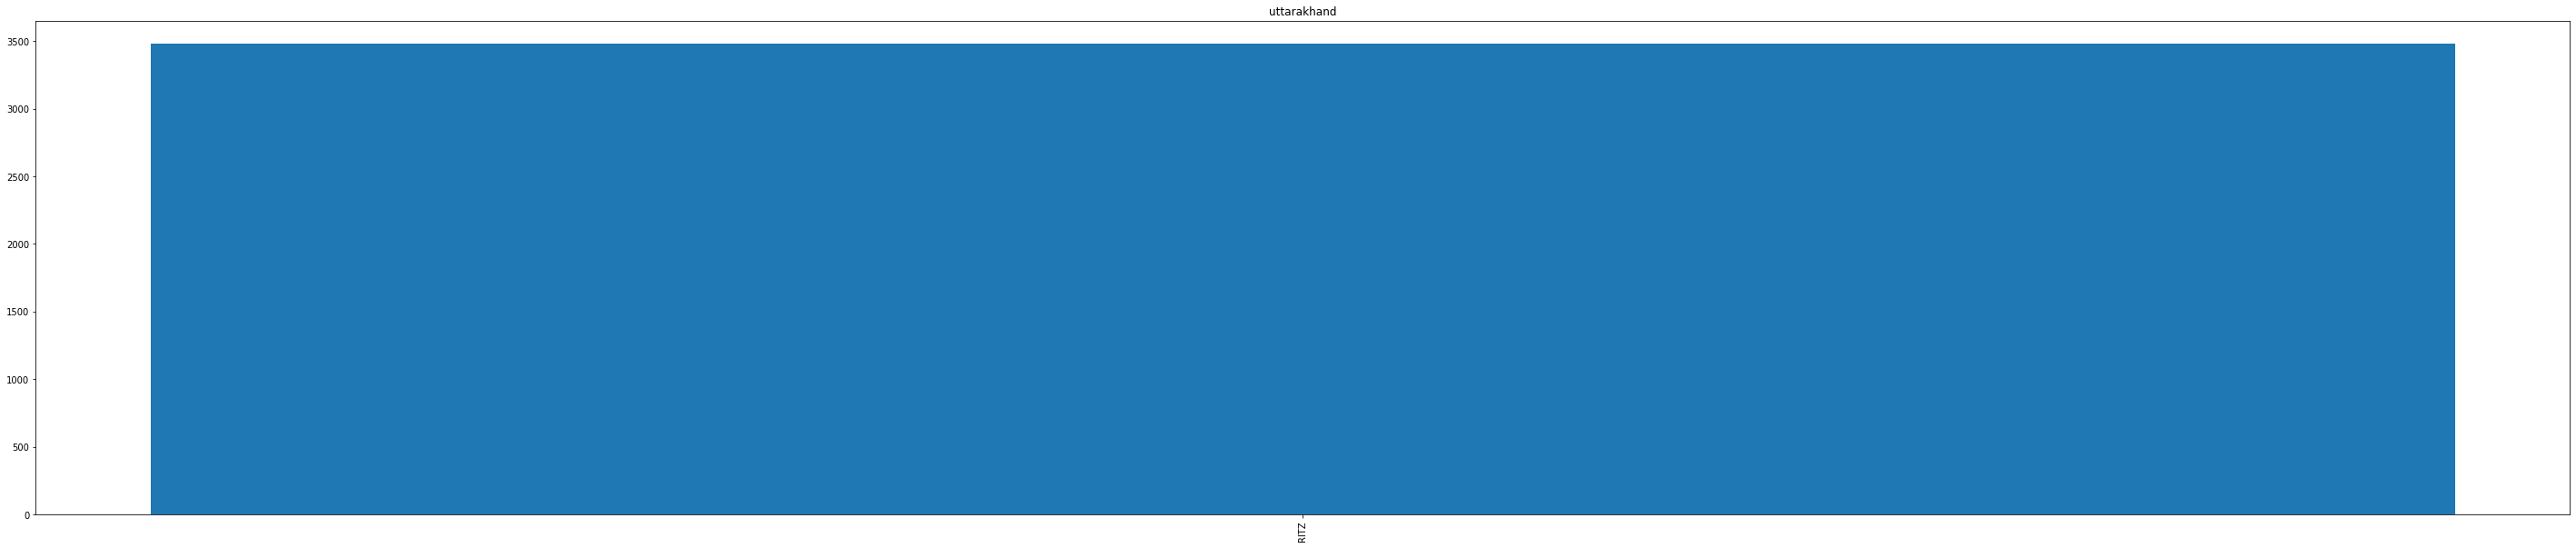

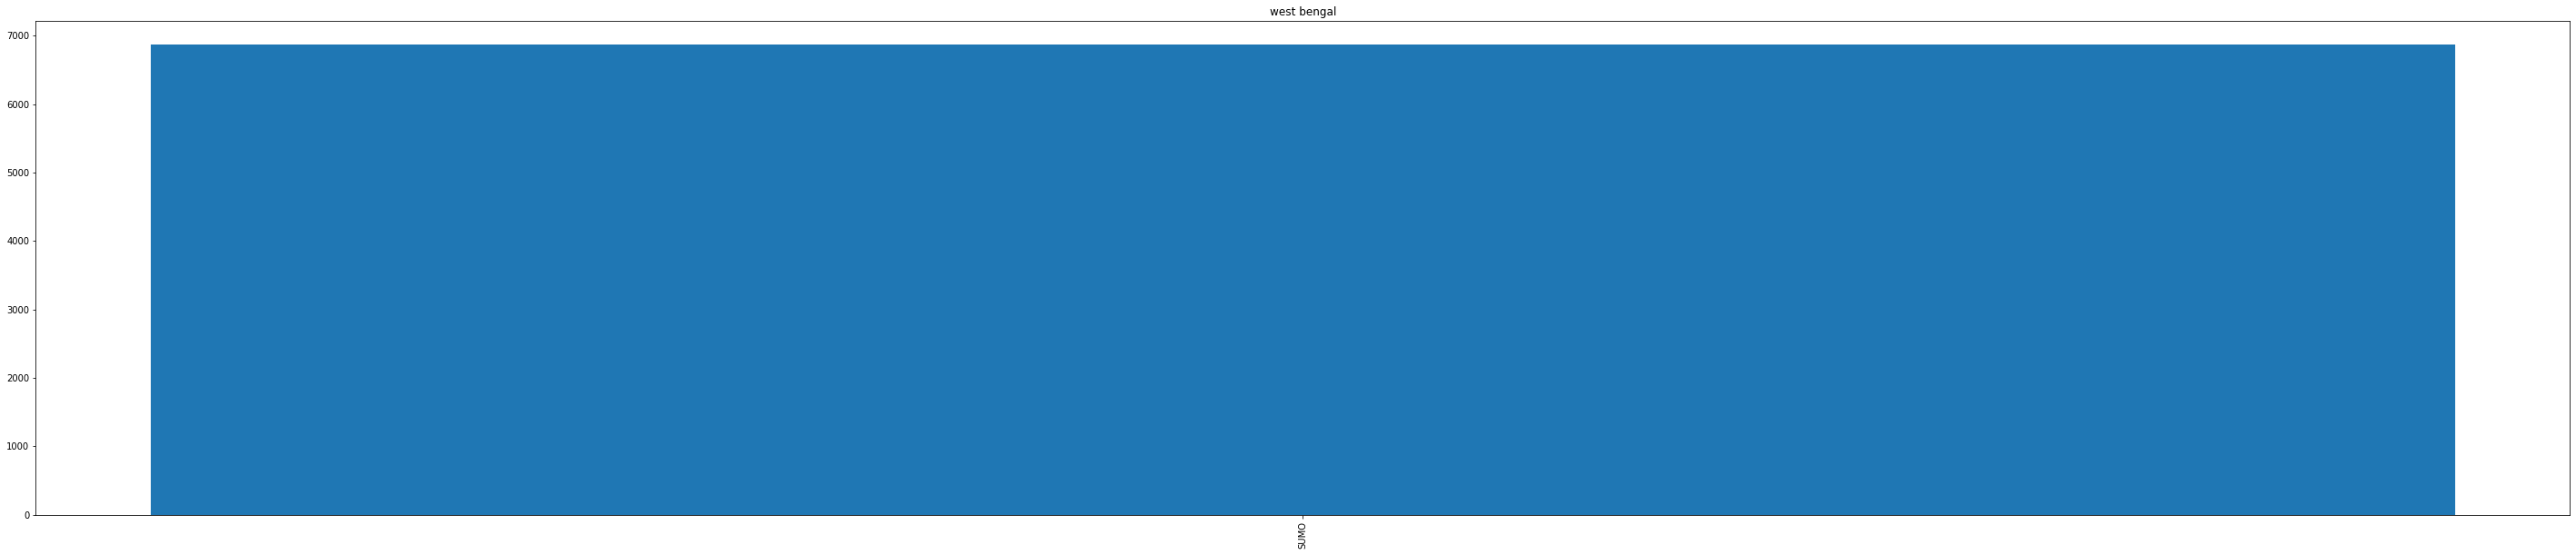

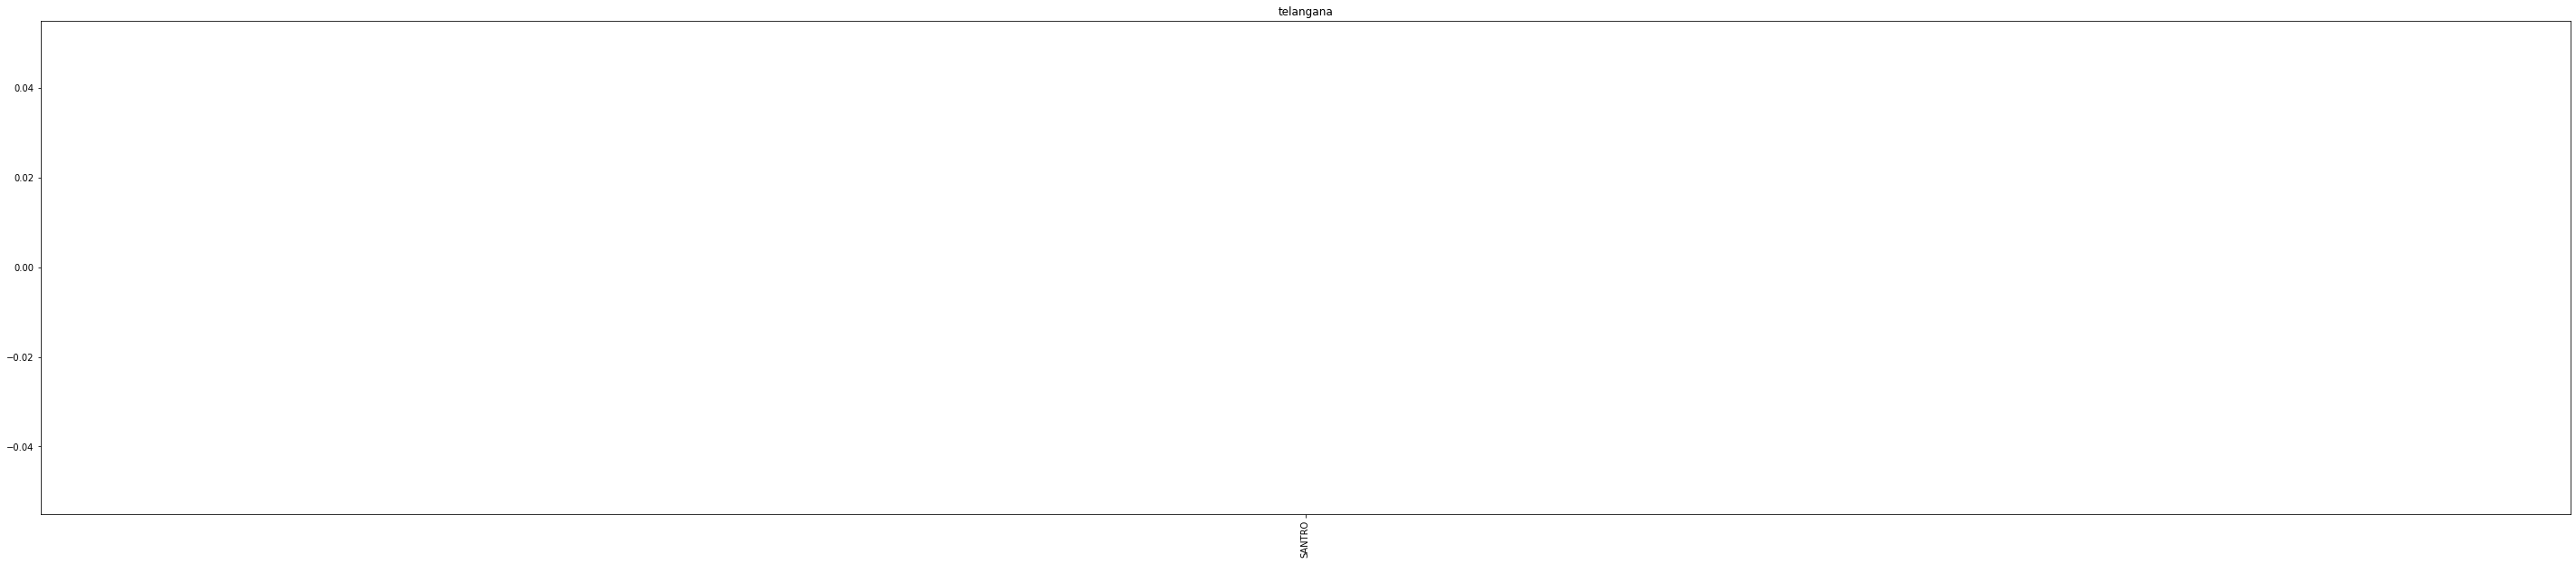

In [157]:
city=[]
city=join['District'].unique()
for i in city:
    cars=join[join['District']==i]
    
    fig=plt.figure(figsize=(50,10))
    plt.title(i)
    cars=cars.sort_values('Revenue',ascending=False)
    plt.bar(cars['Model'],cars['Revenue'])
    plt.xticks(rotation=90)
    plt.show()

ACCENT


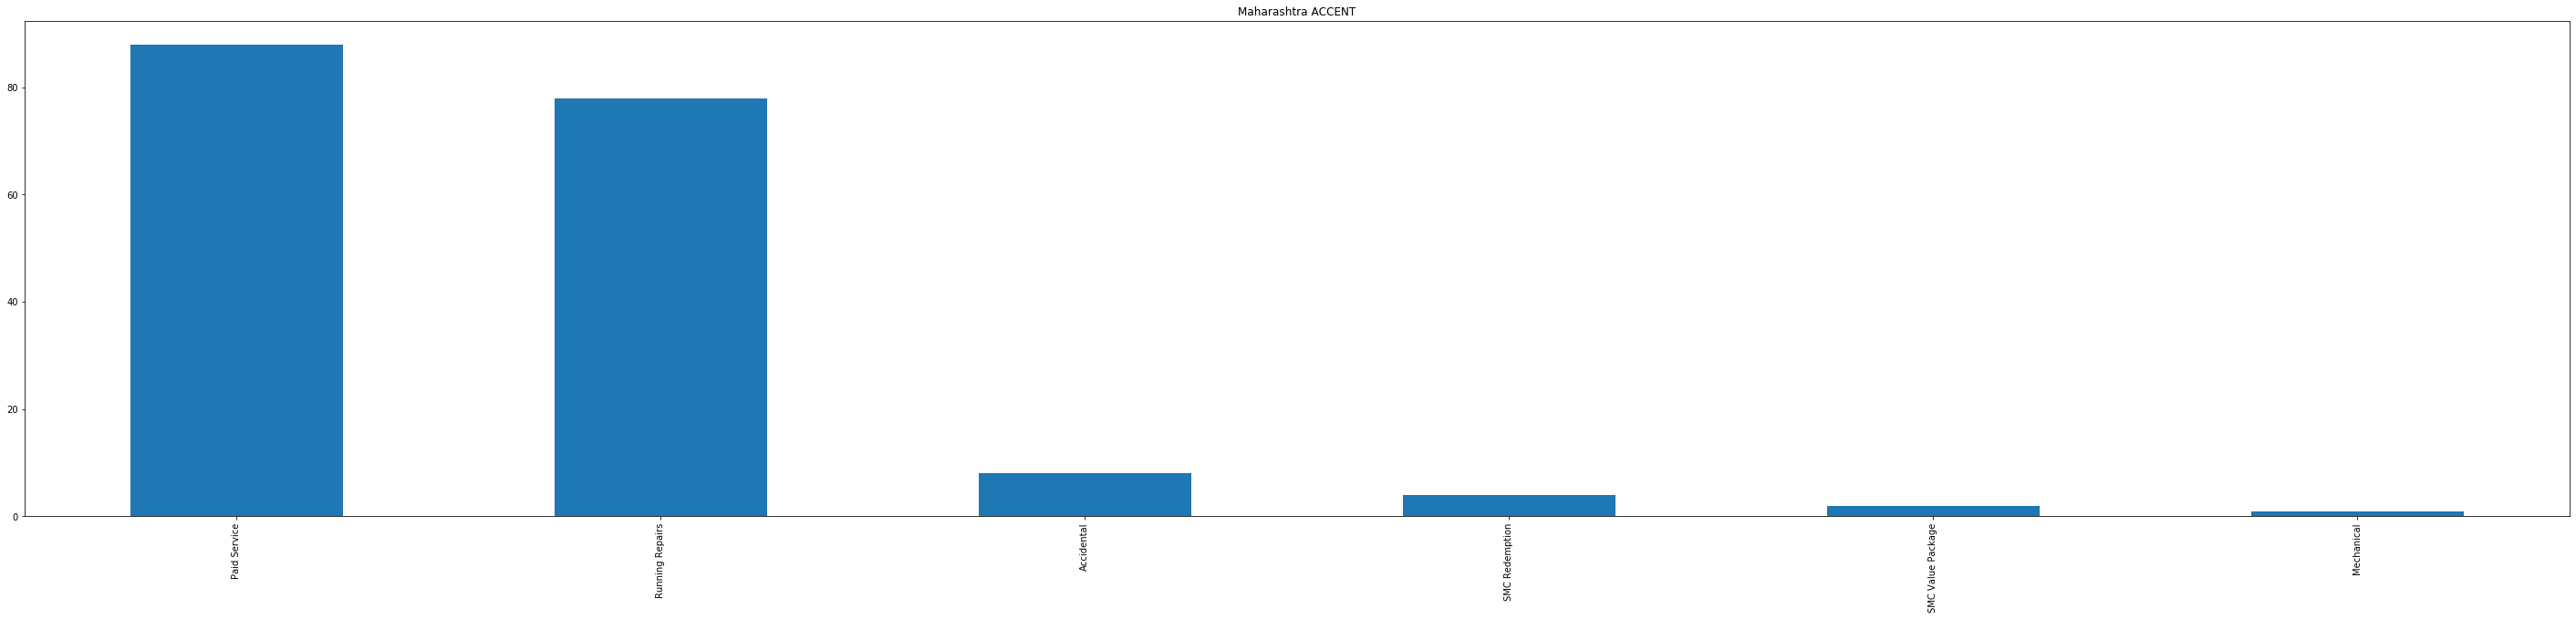

PALIO


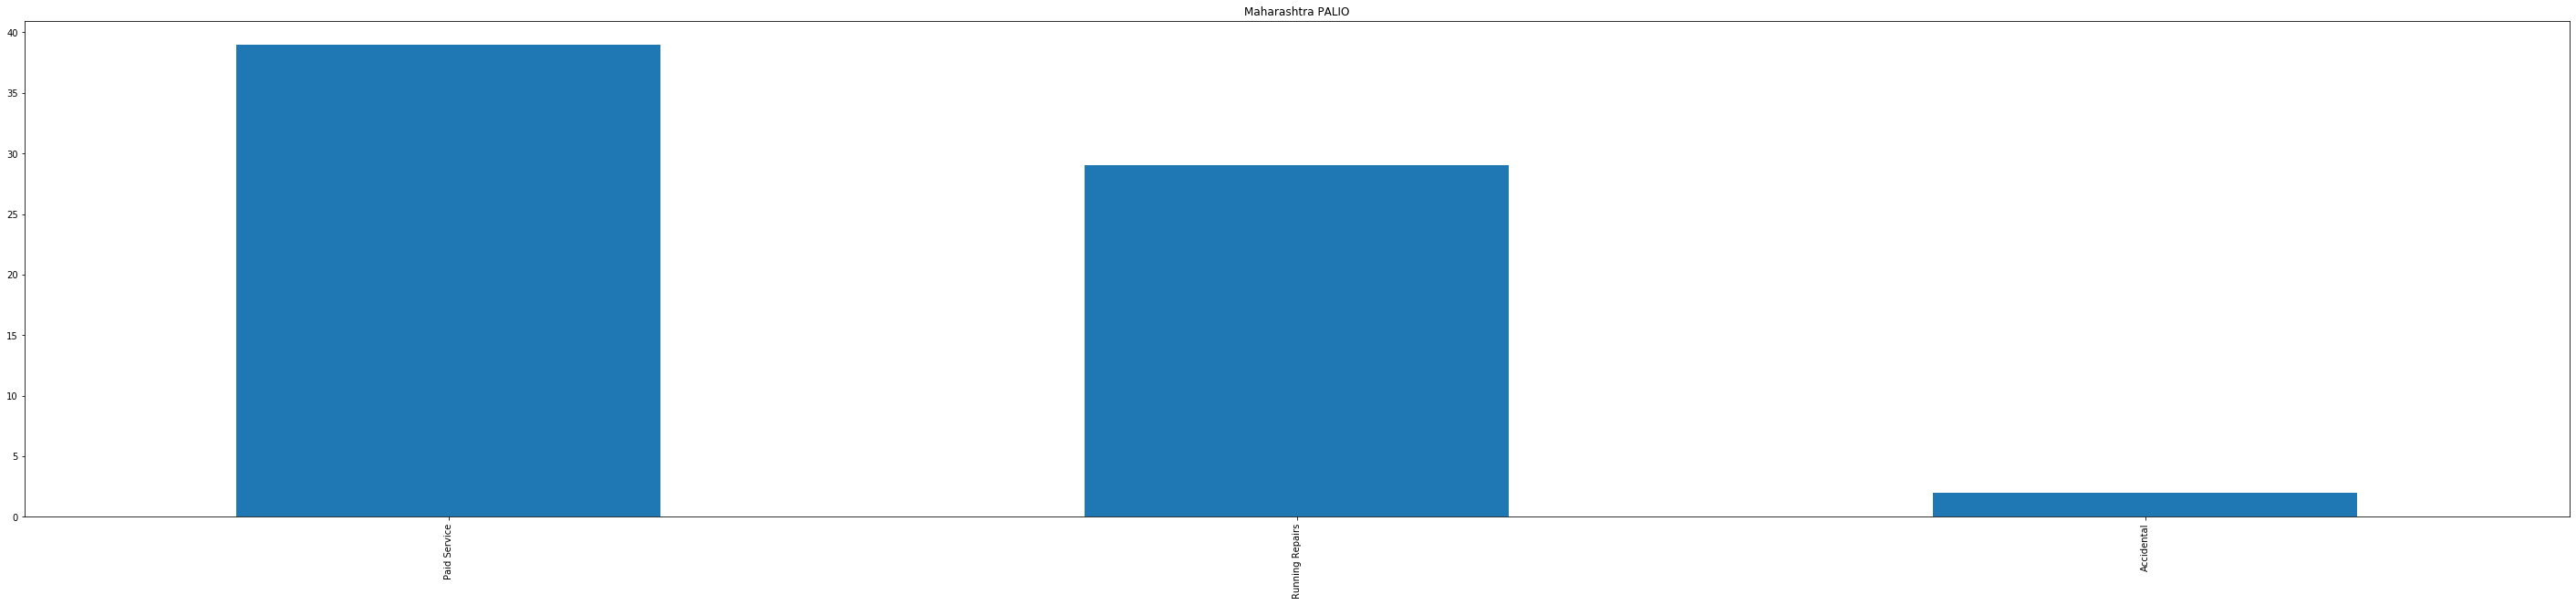

SCORPIO CRDE


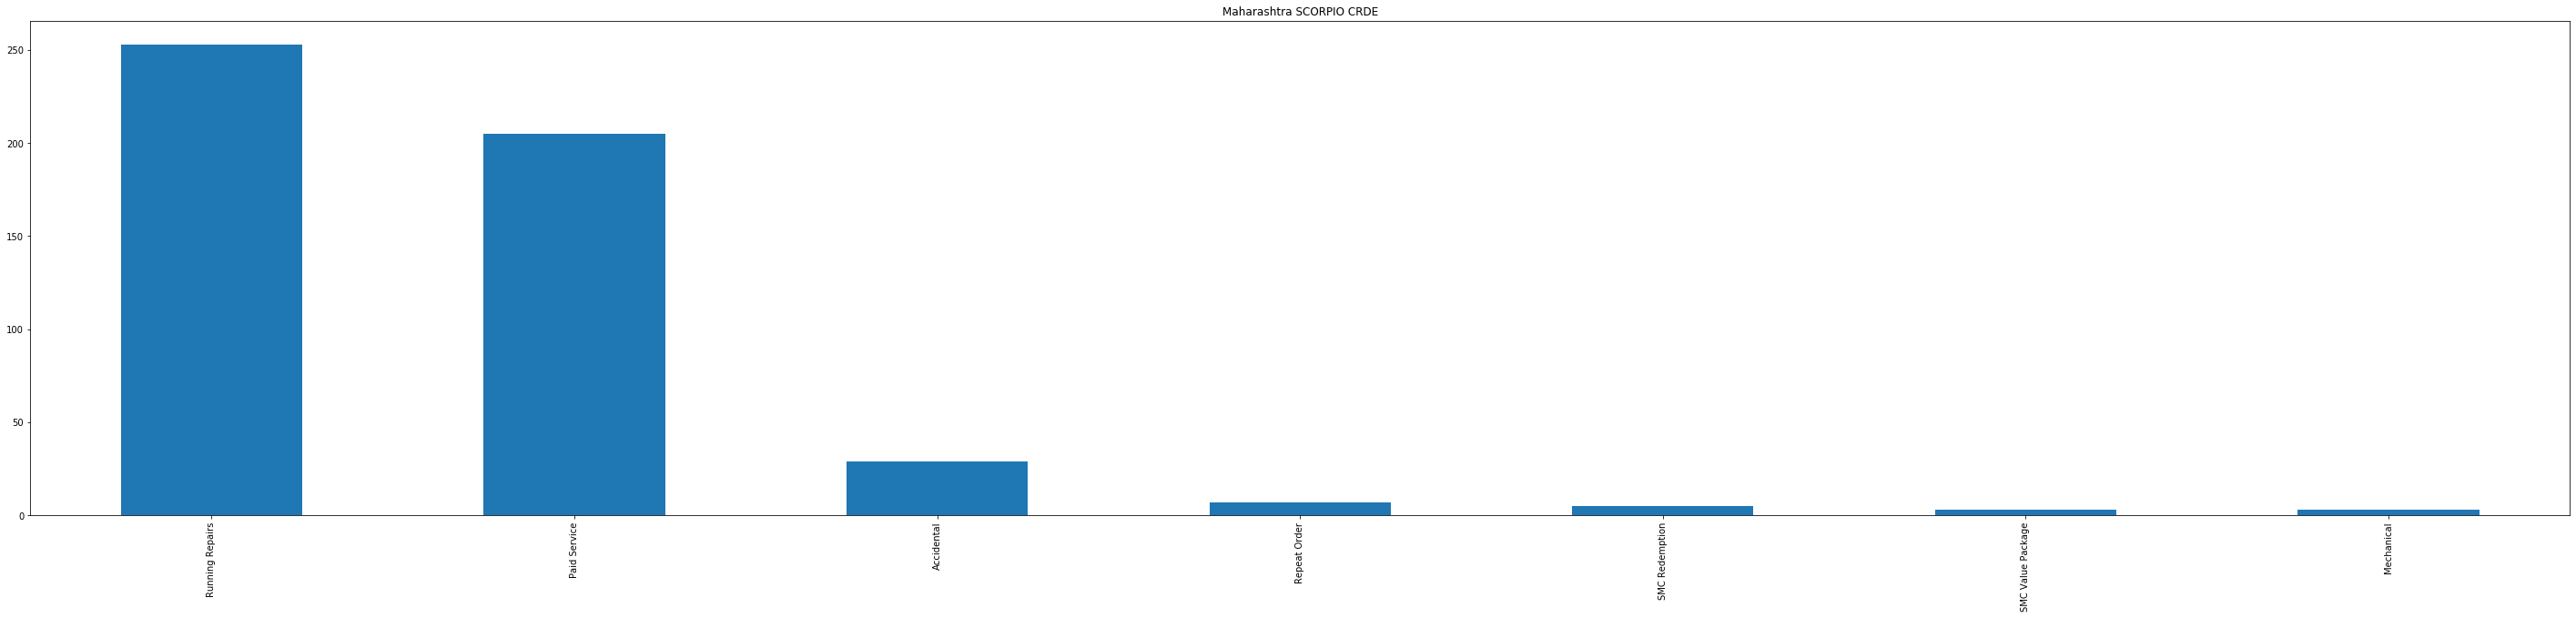

SANTRO


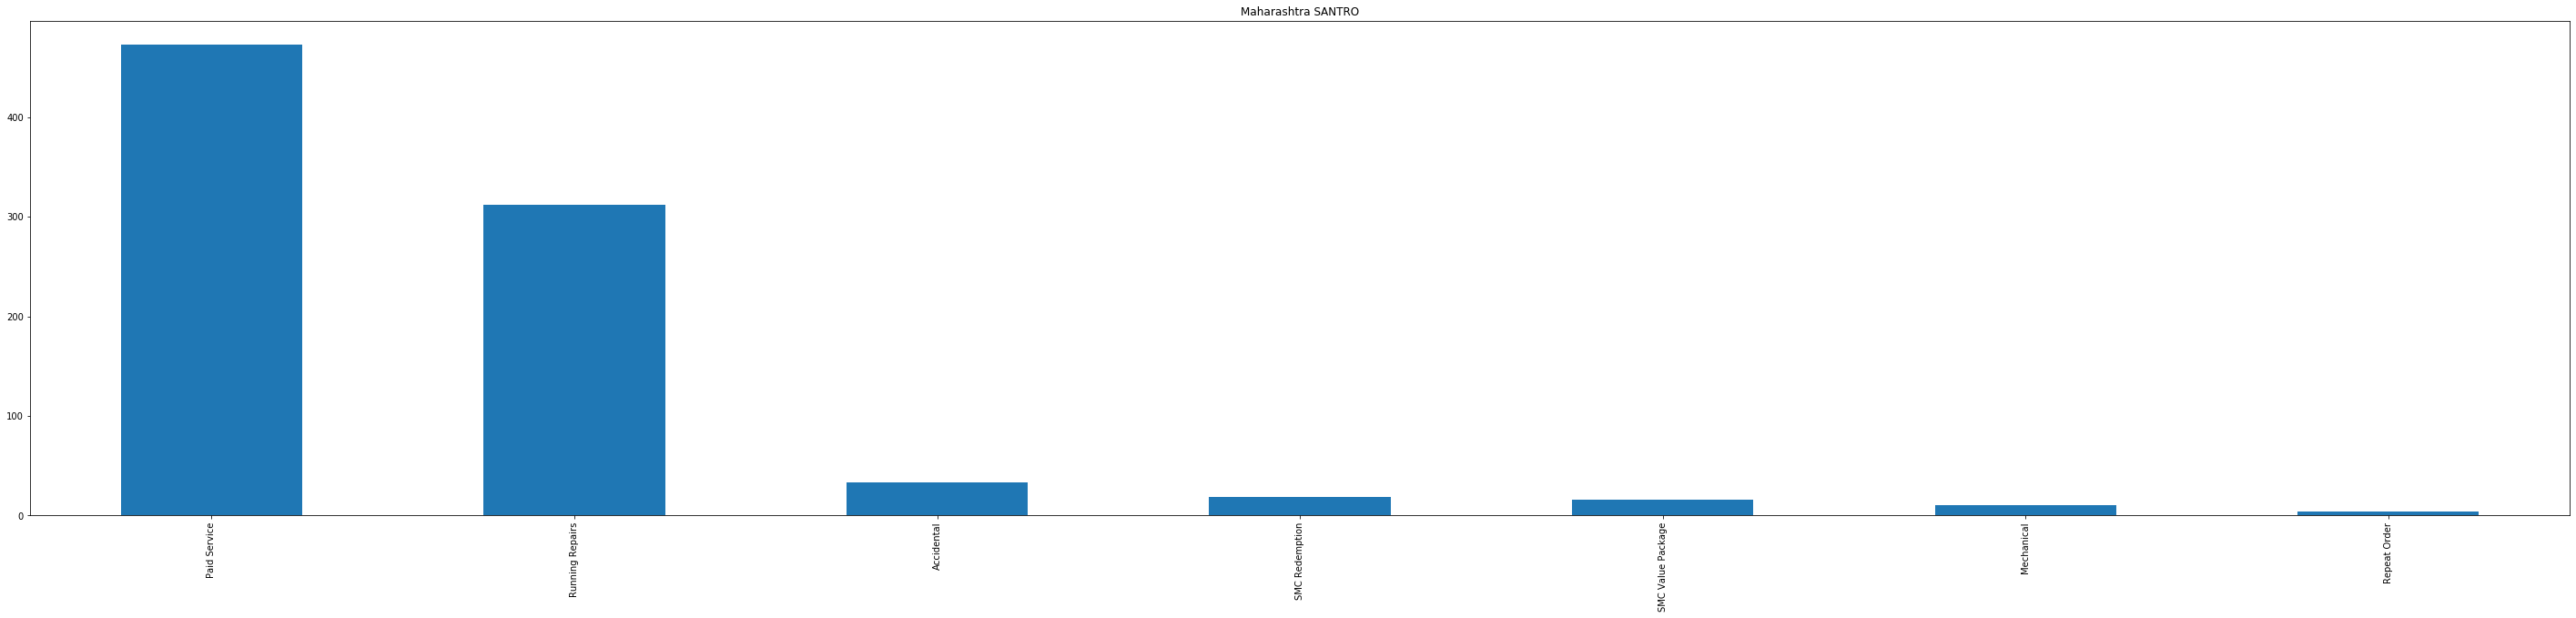

SCORPIO NEF


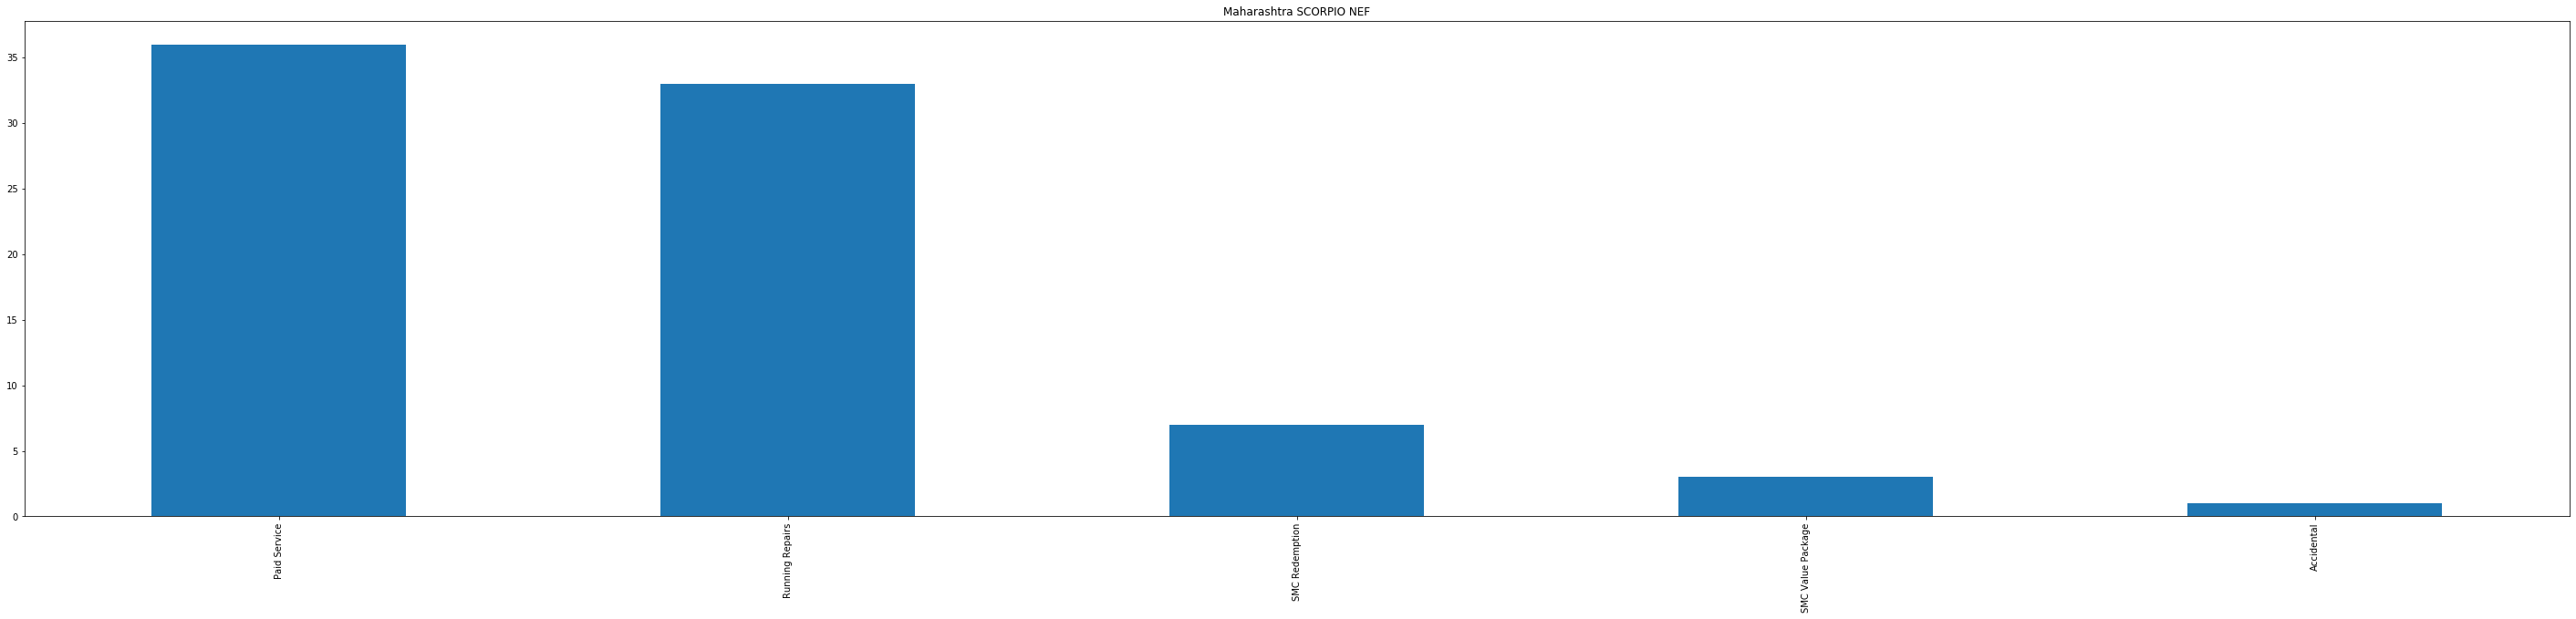

LOGAN P


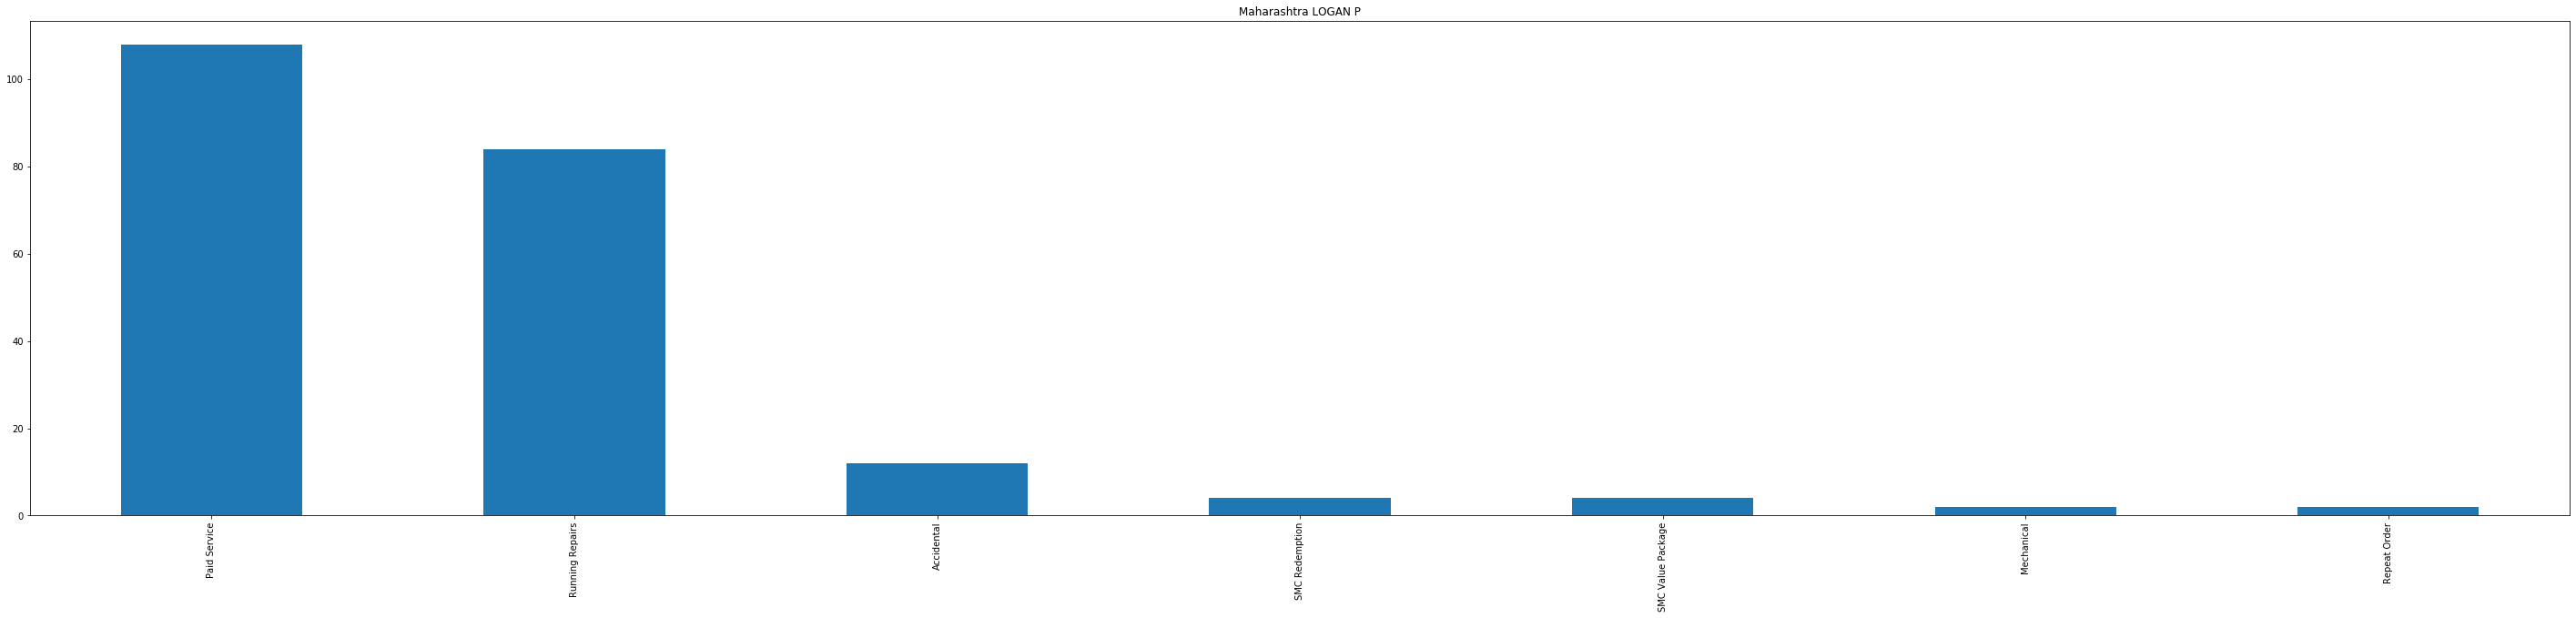

SWIFT DZIRE


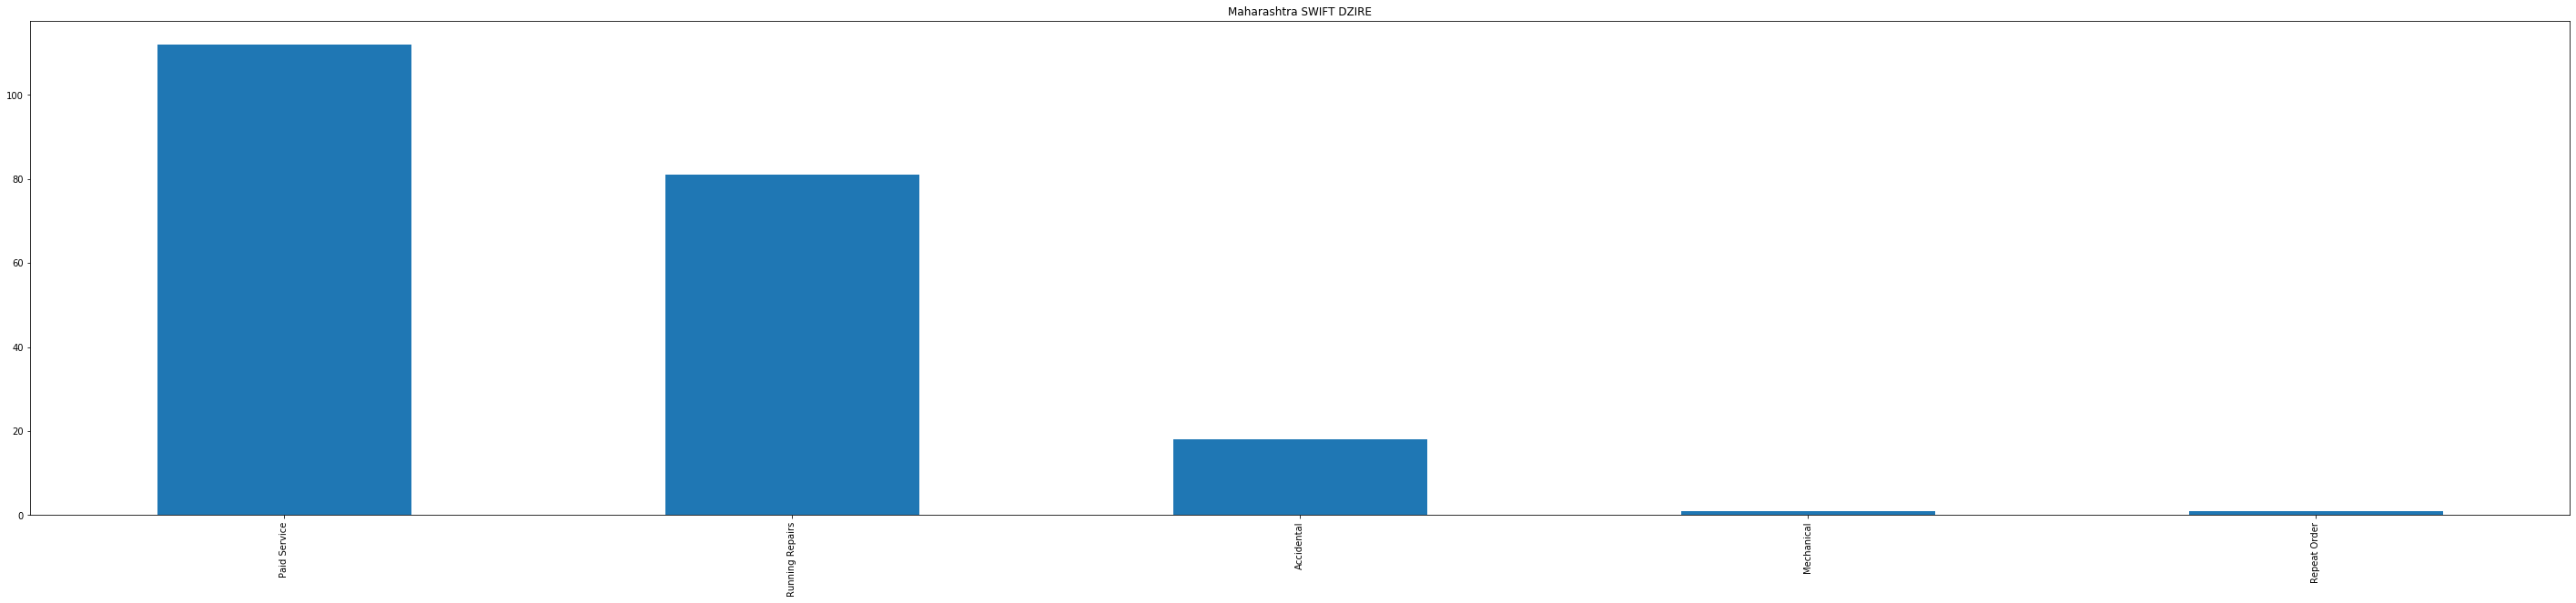

INDICA


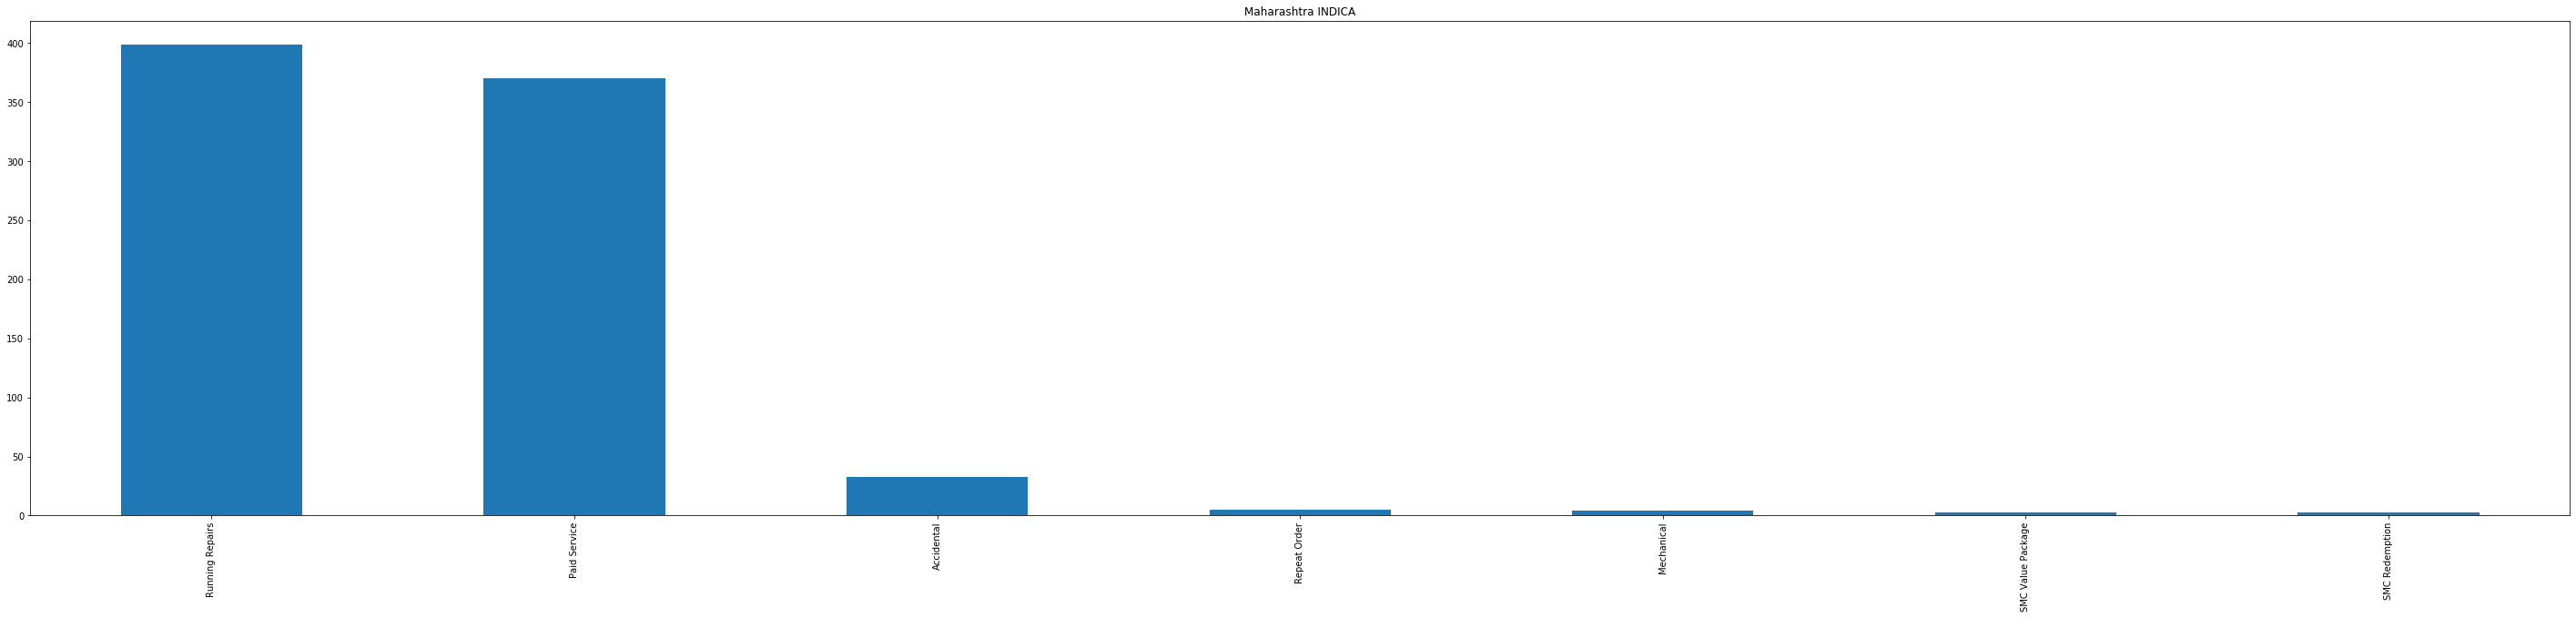

LAURA


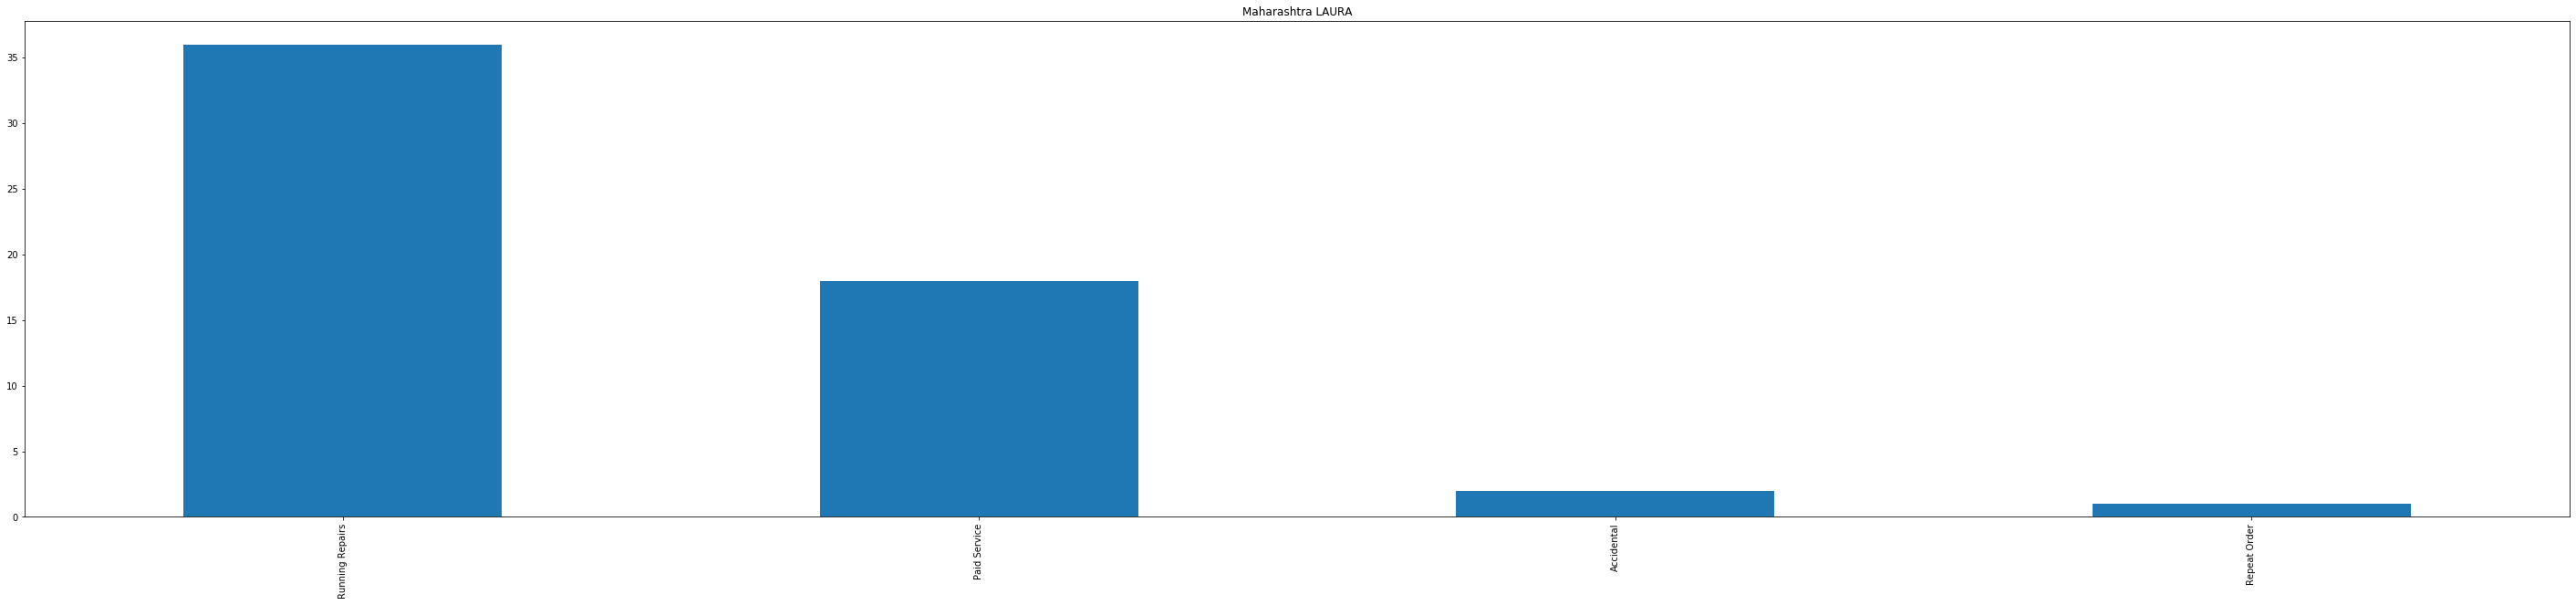

INDIGO MANZA


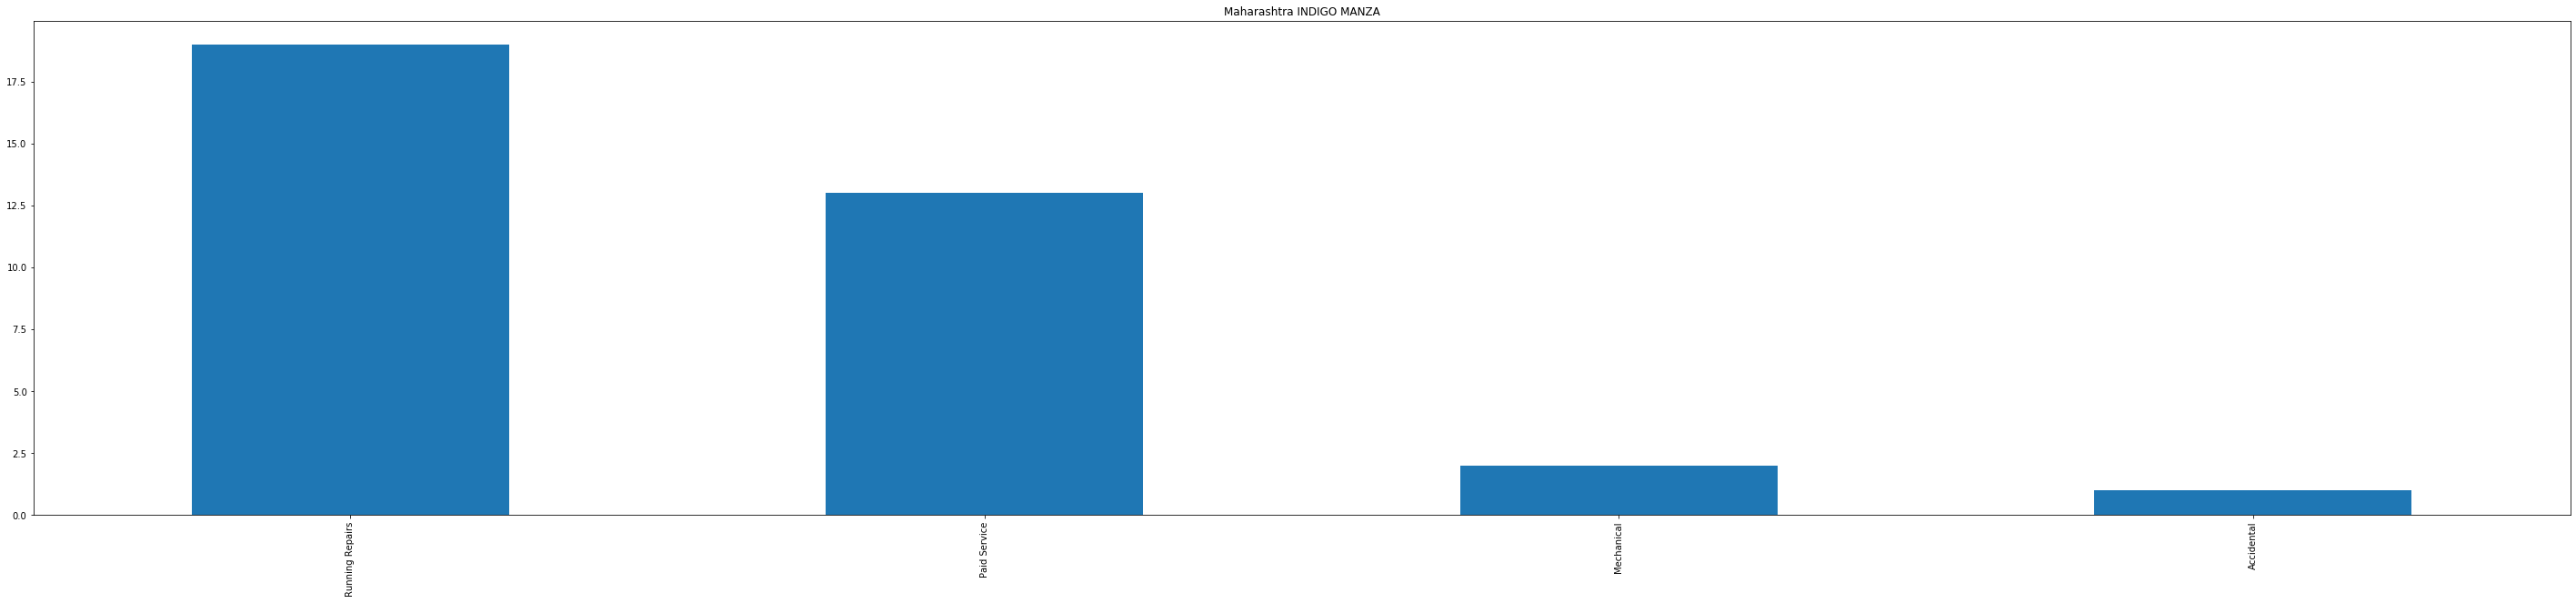

FIESTA


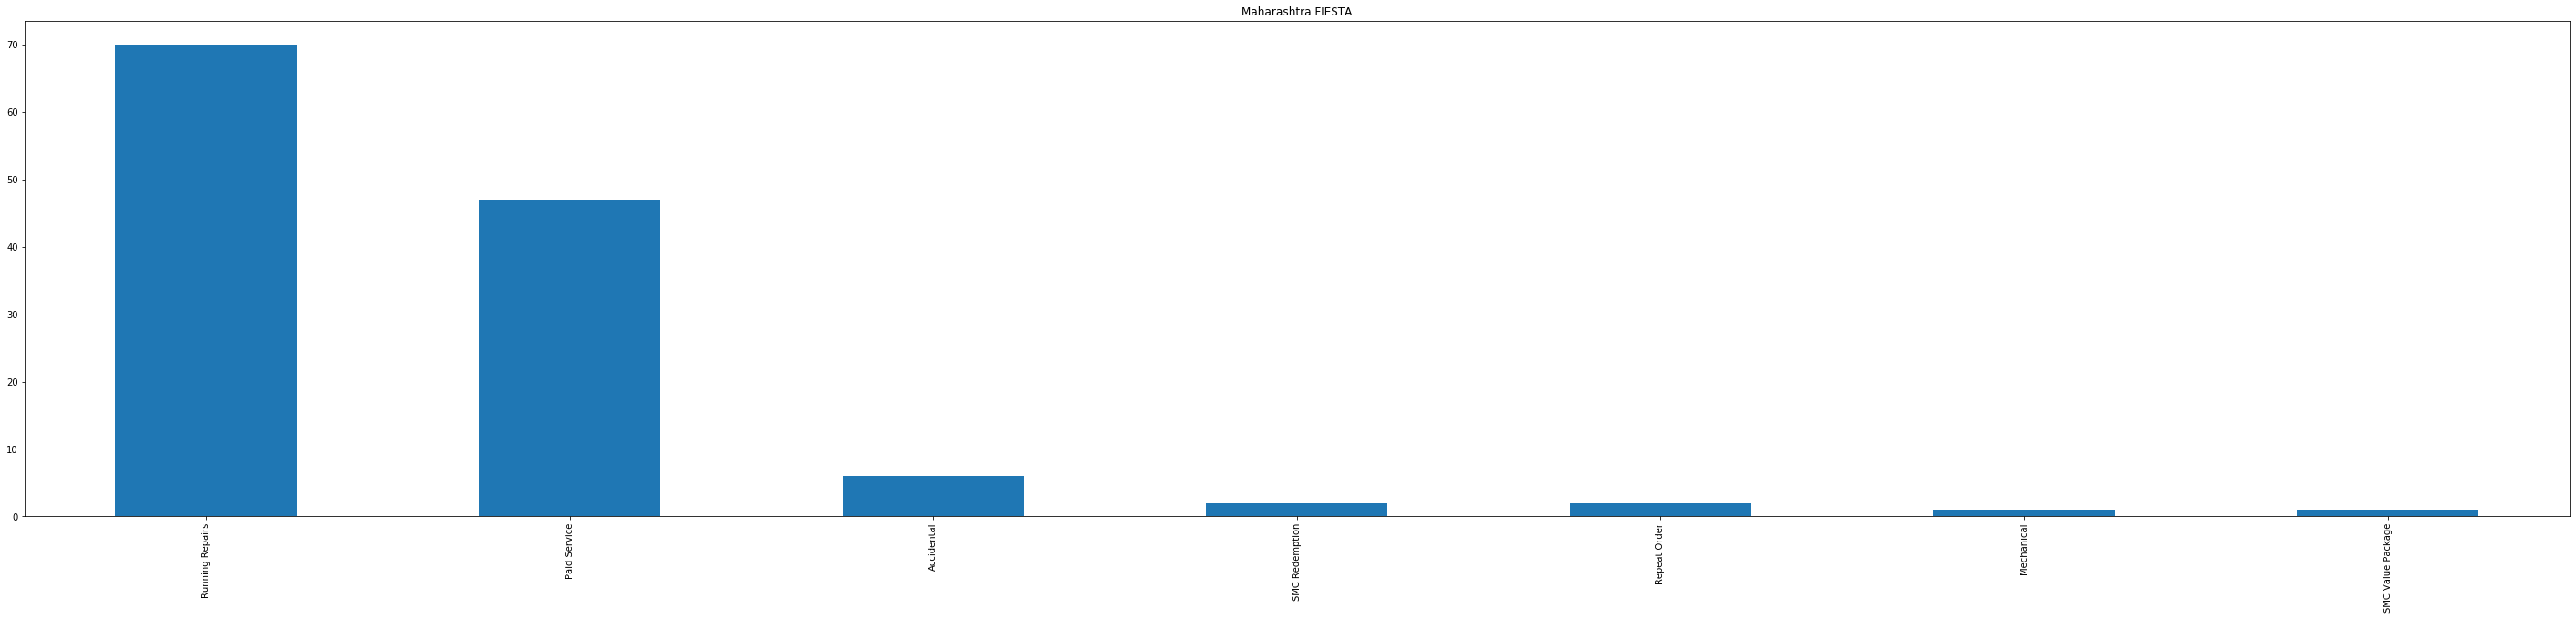

Others


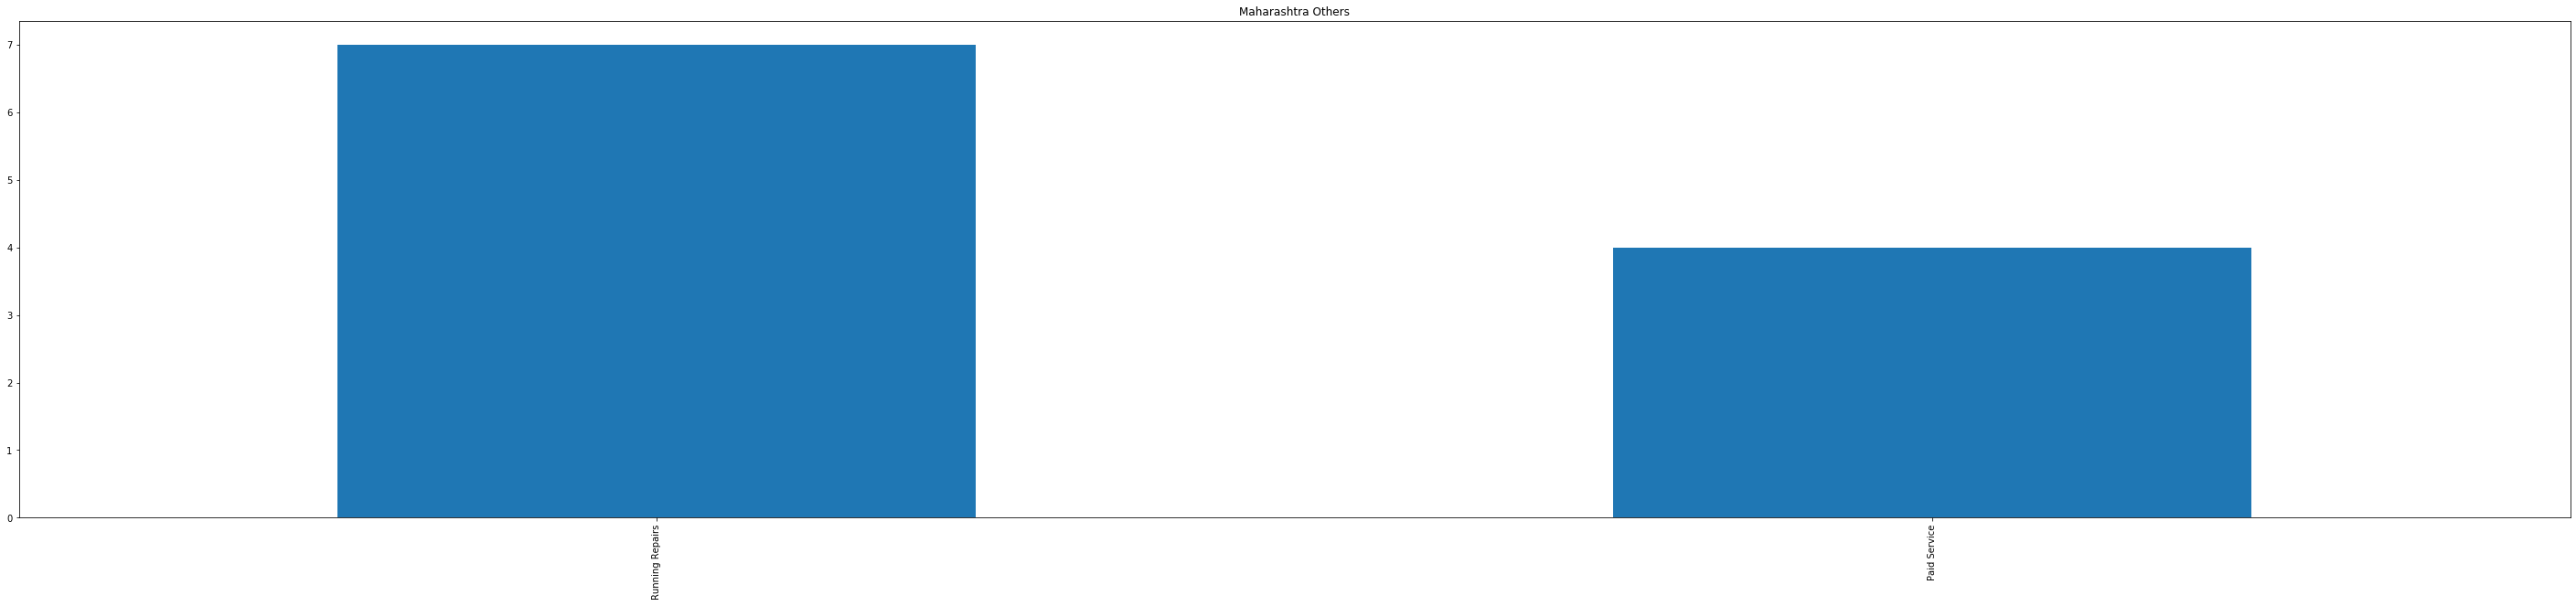

SUMO GRANDE


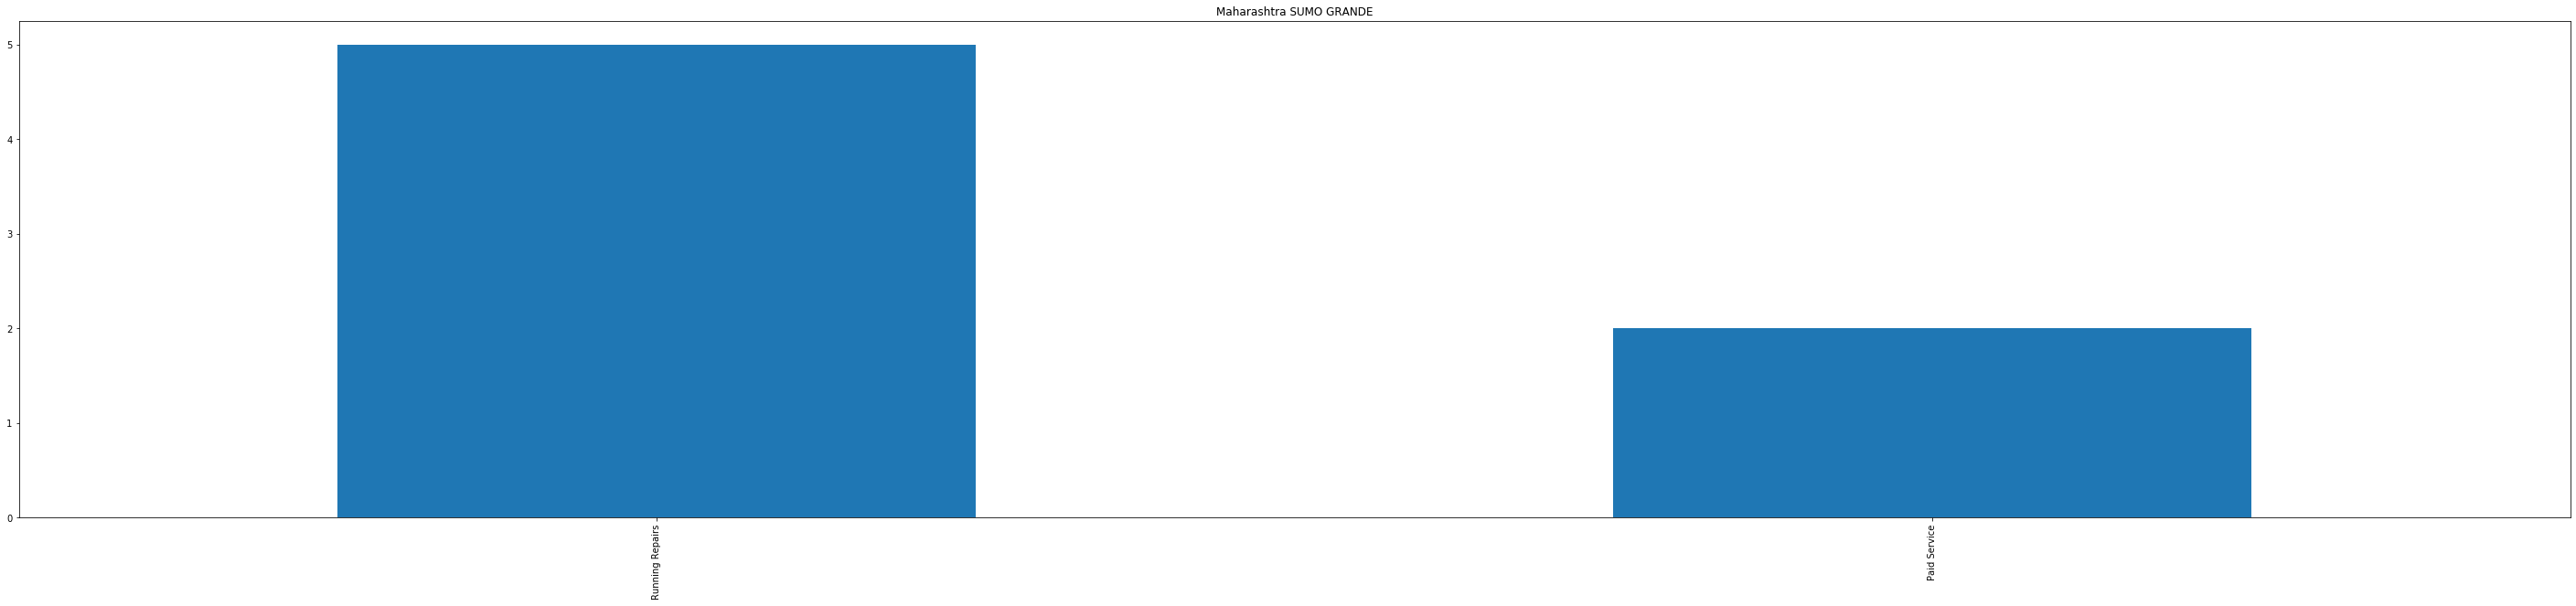

VISTA


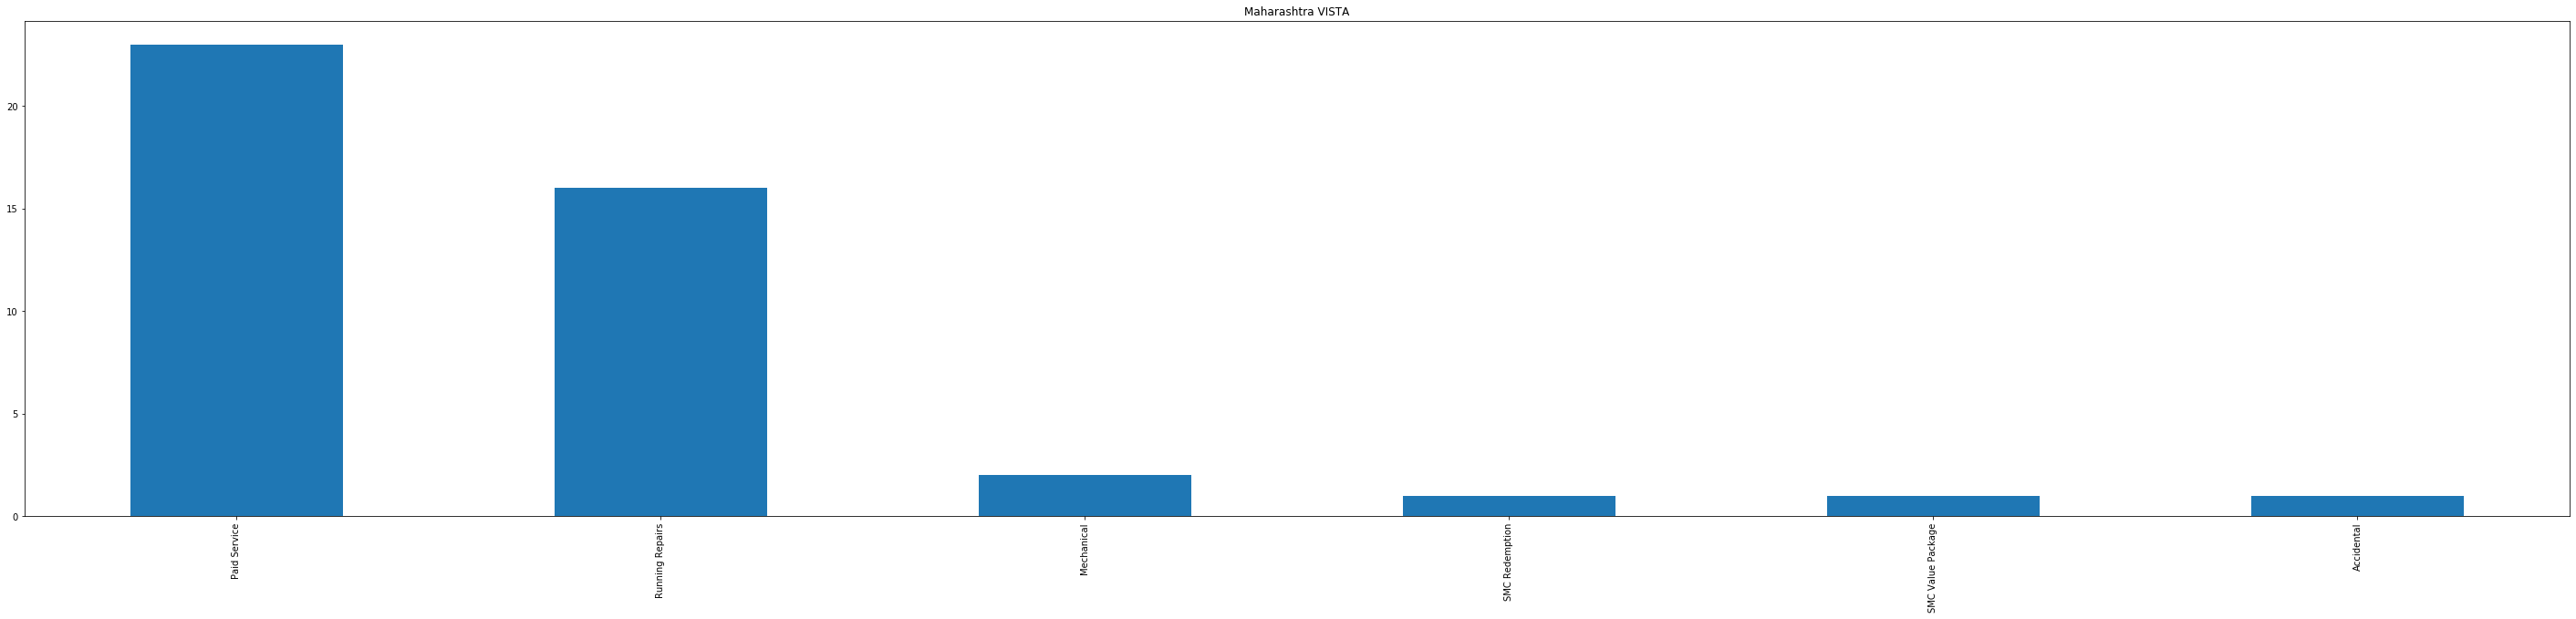

BOLERO


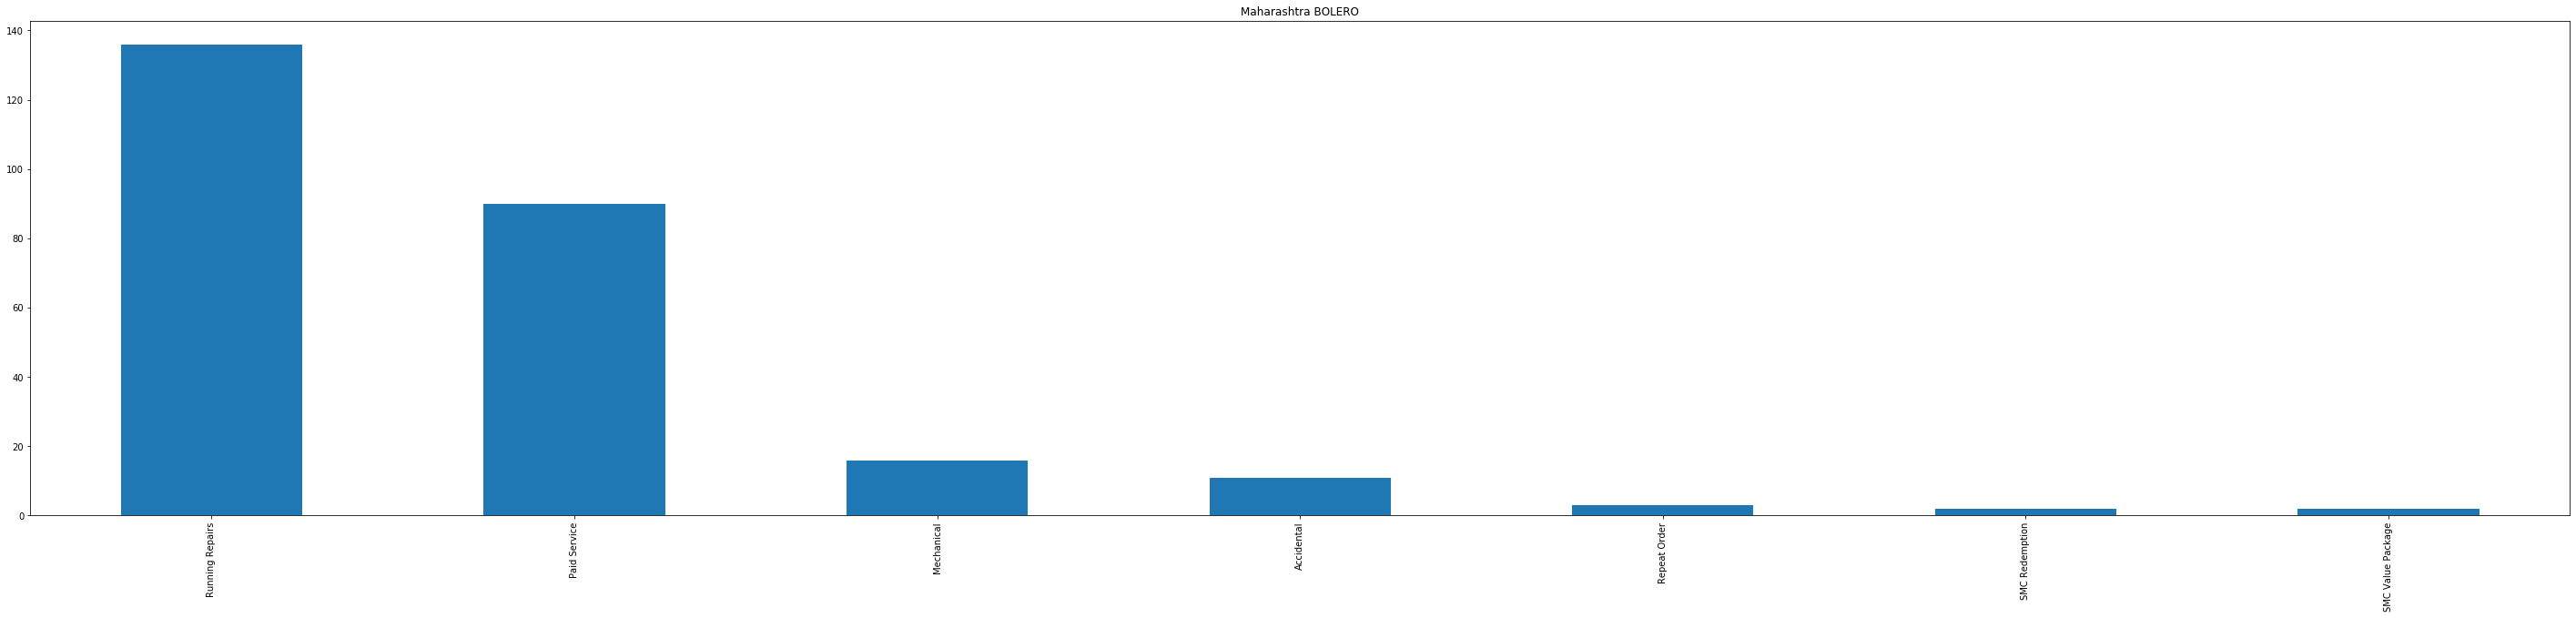

CIVIC


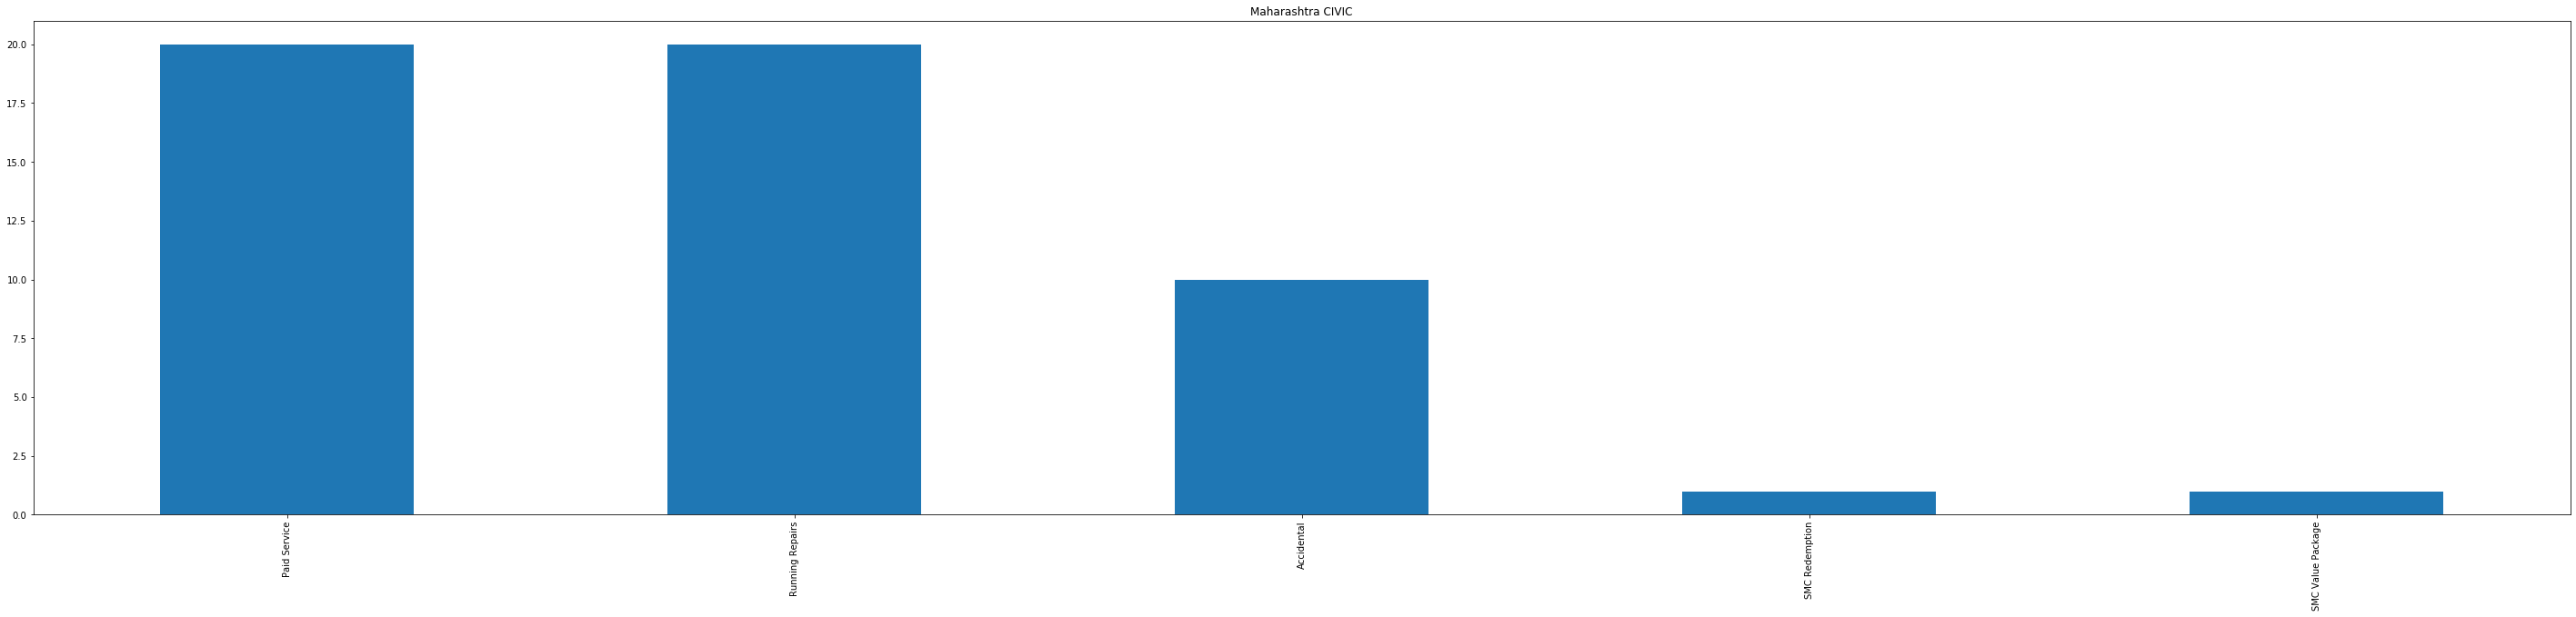

800


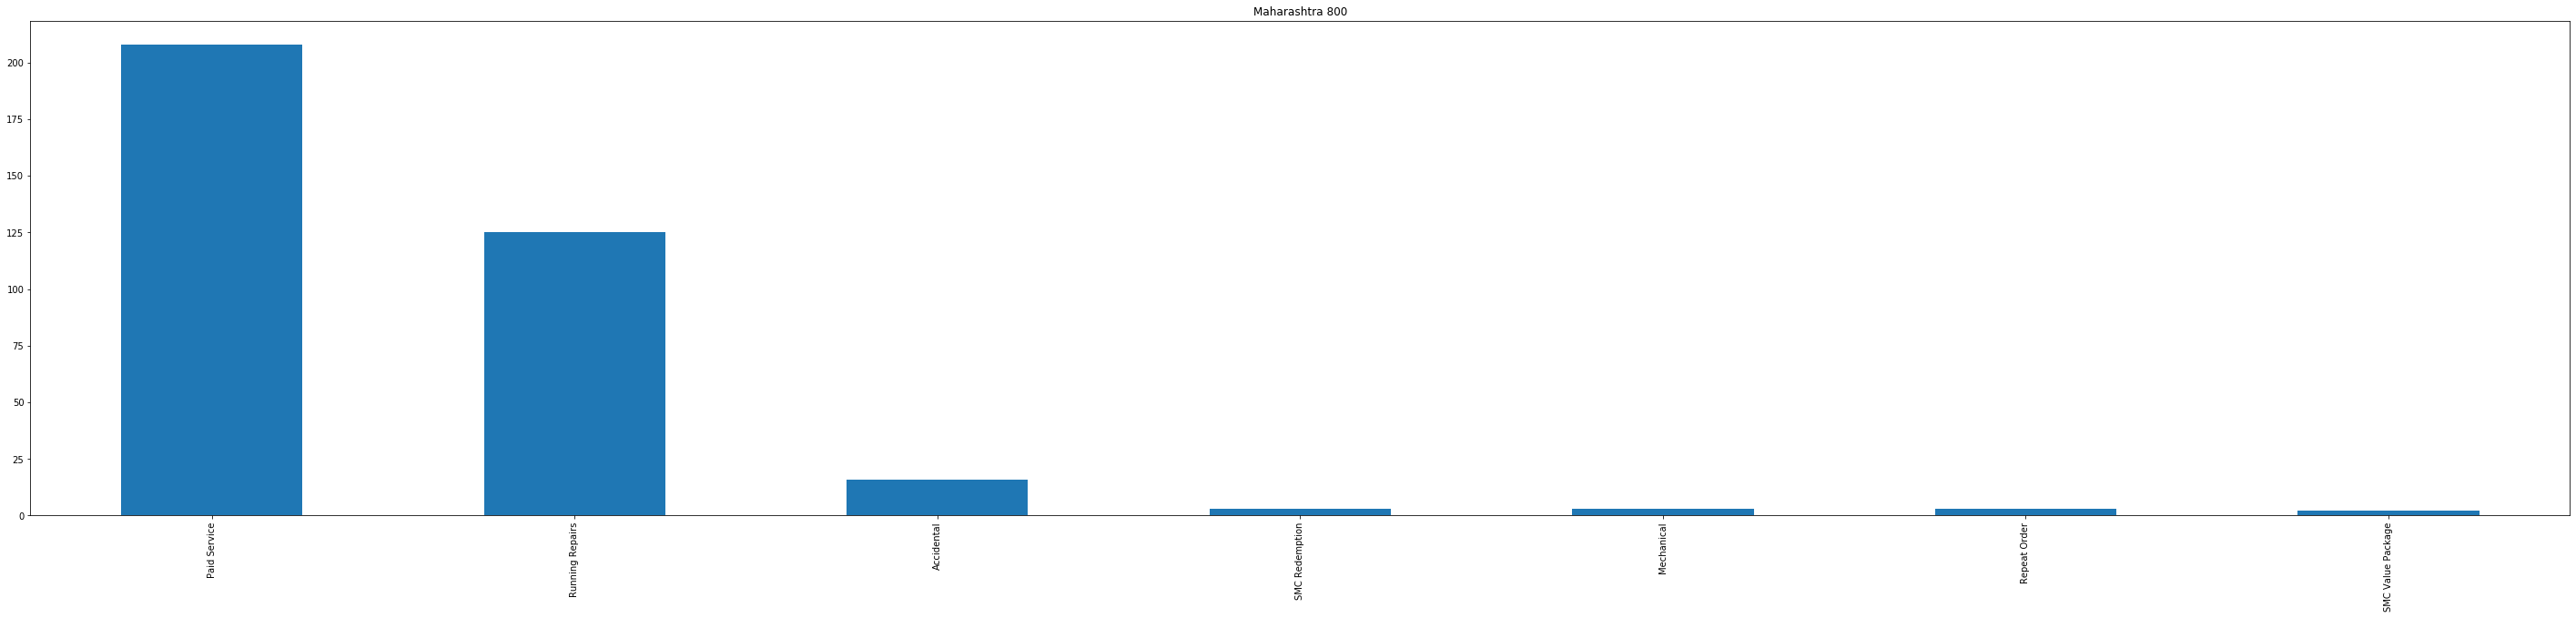

INNOVA


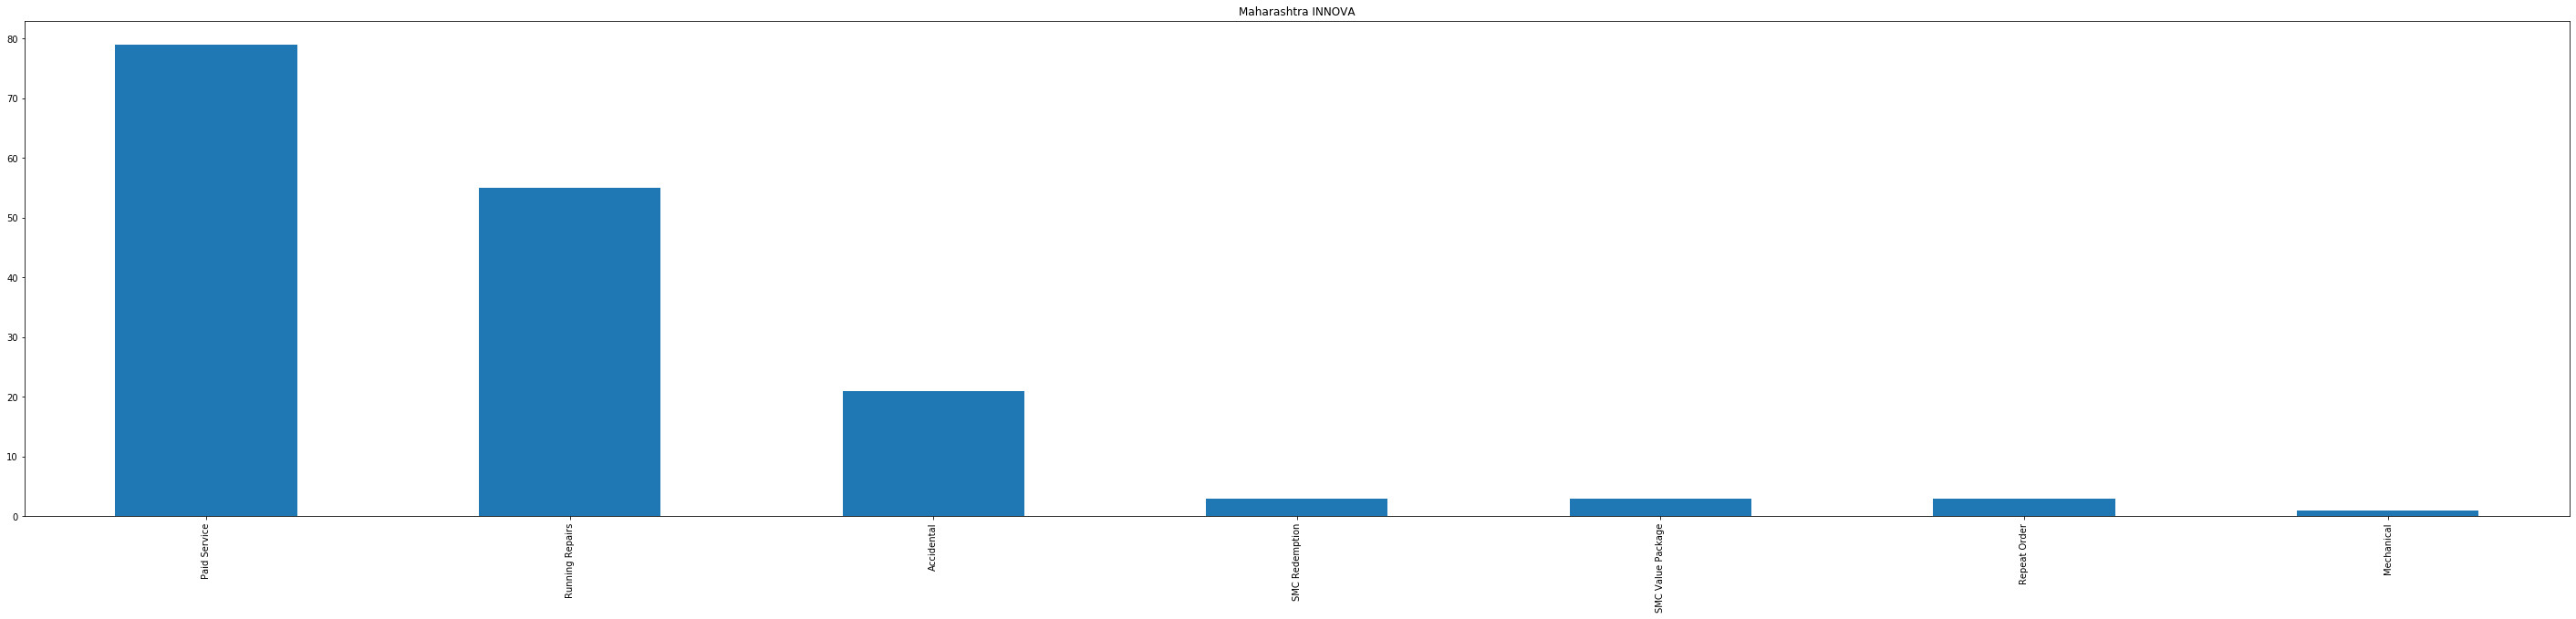

TAVERA


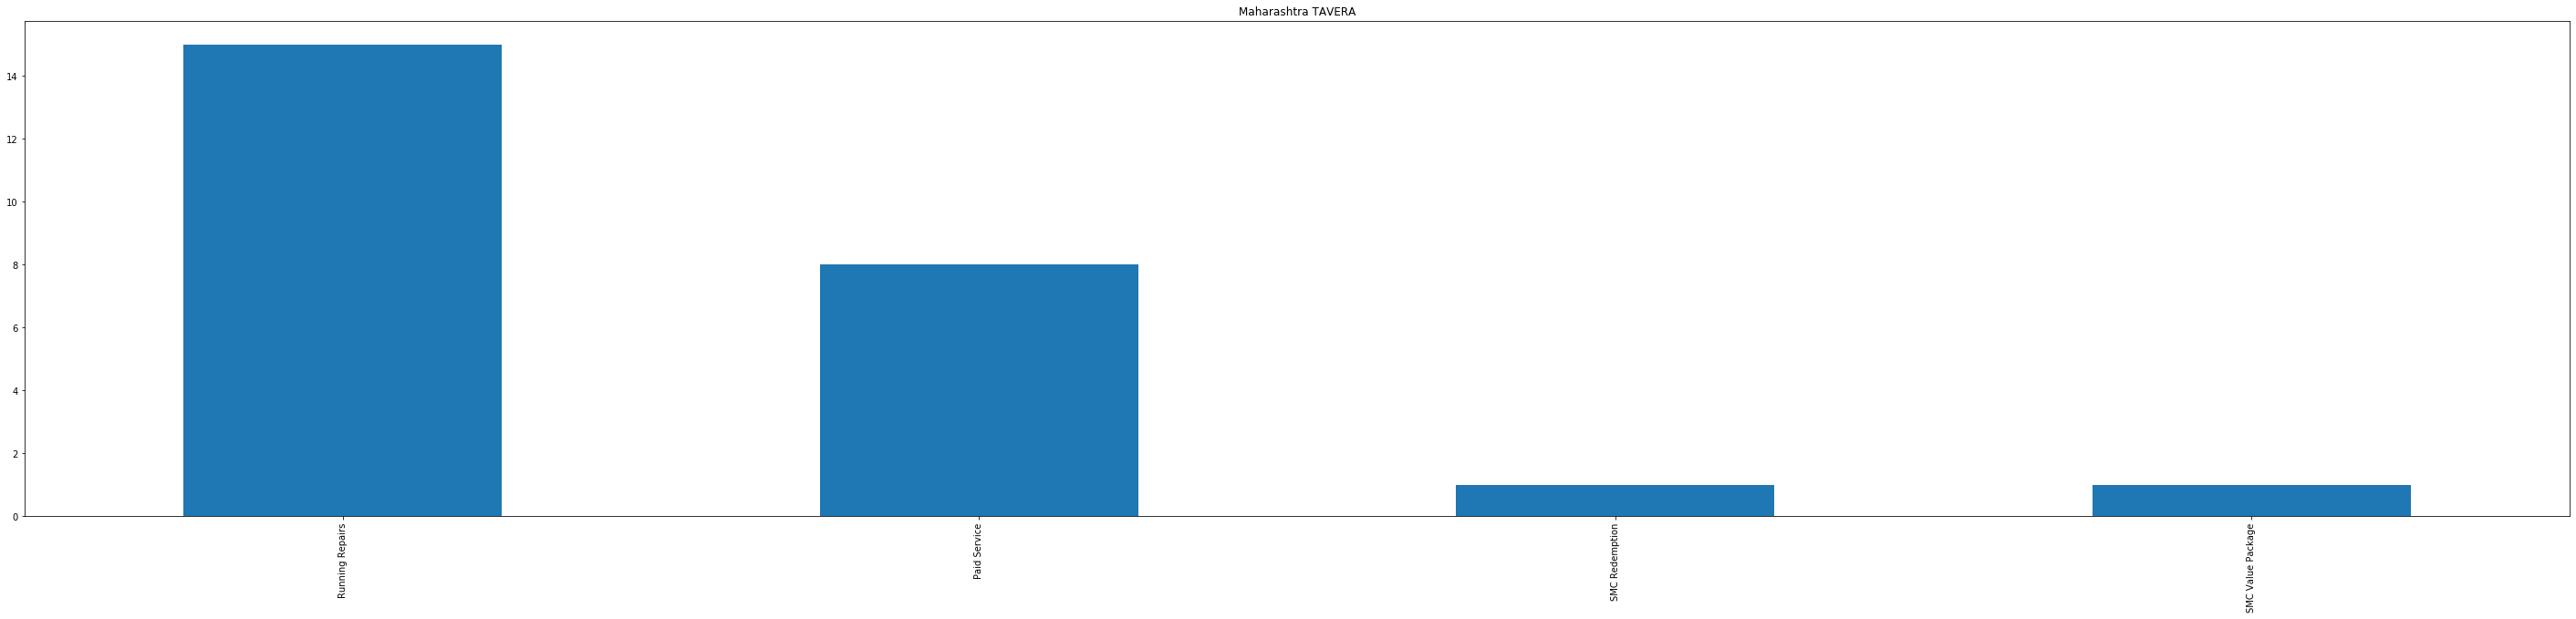

ALTO


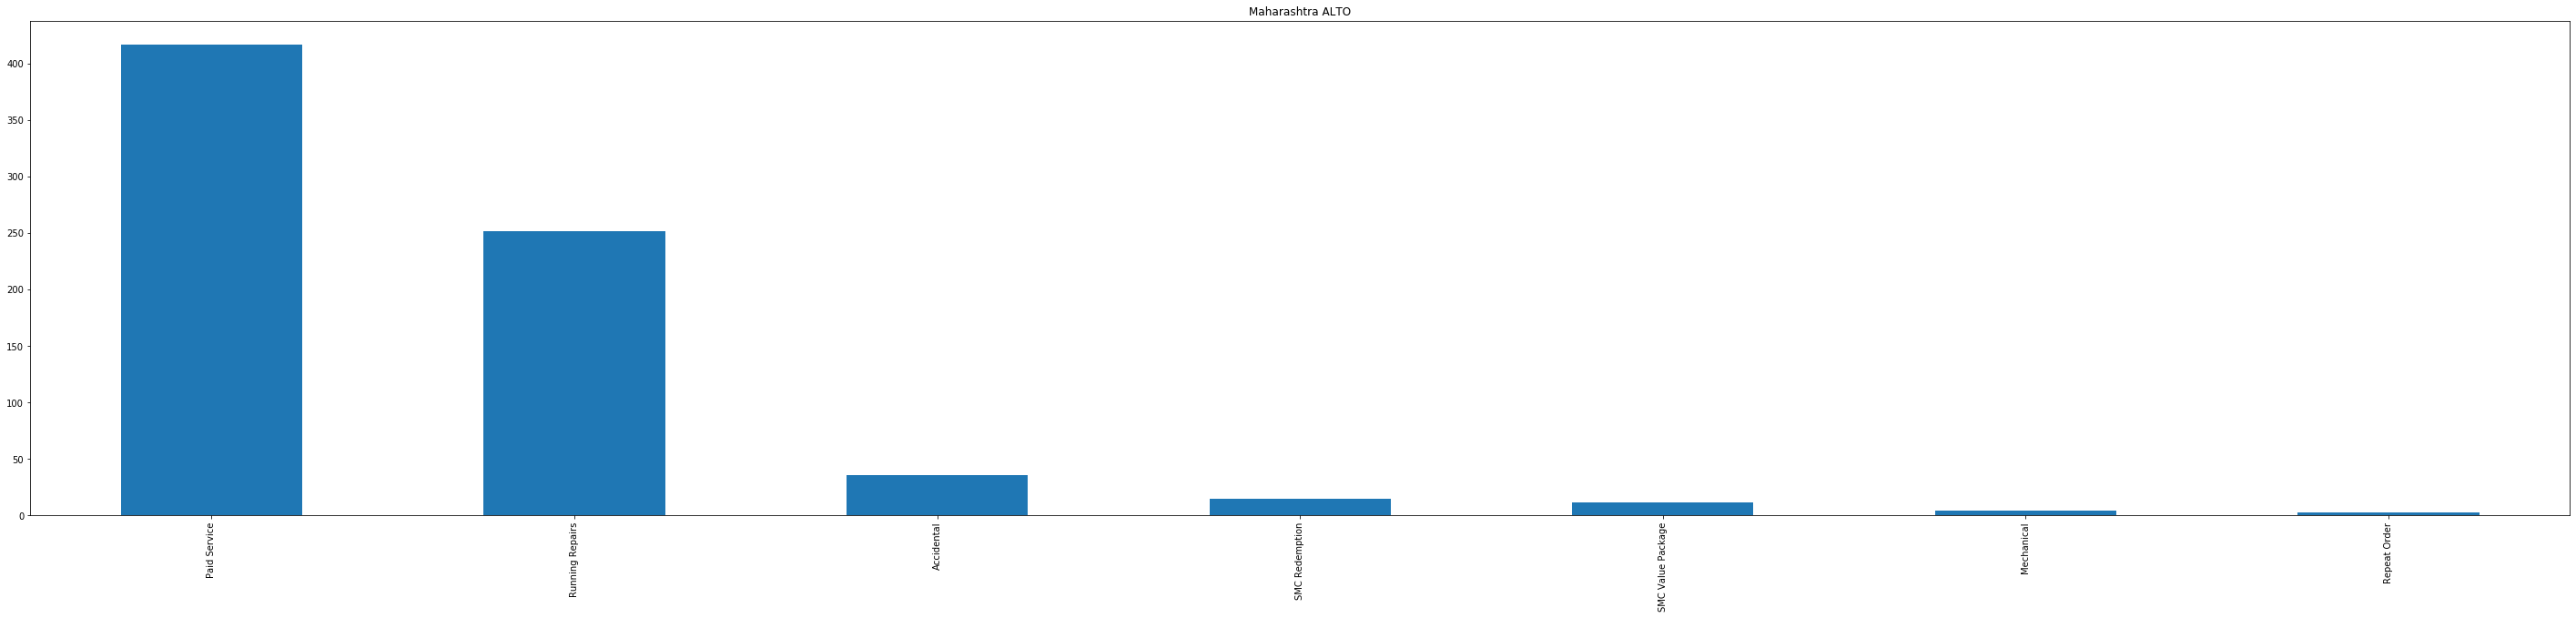

CITY


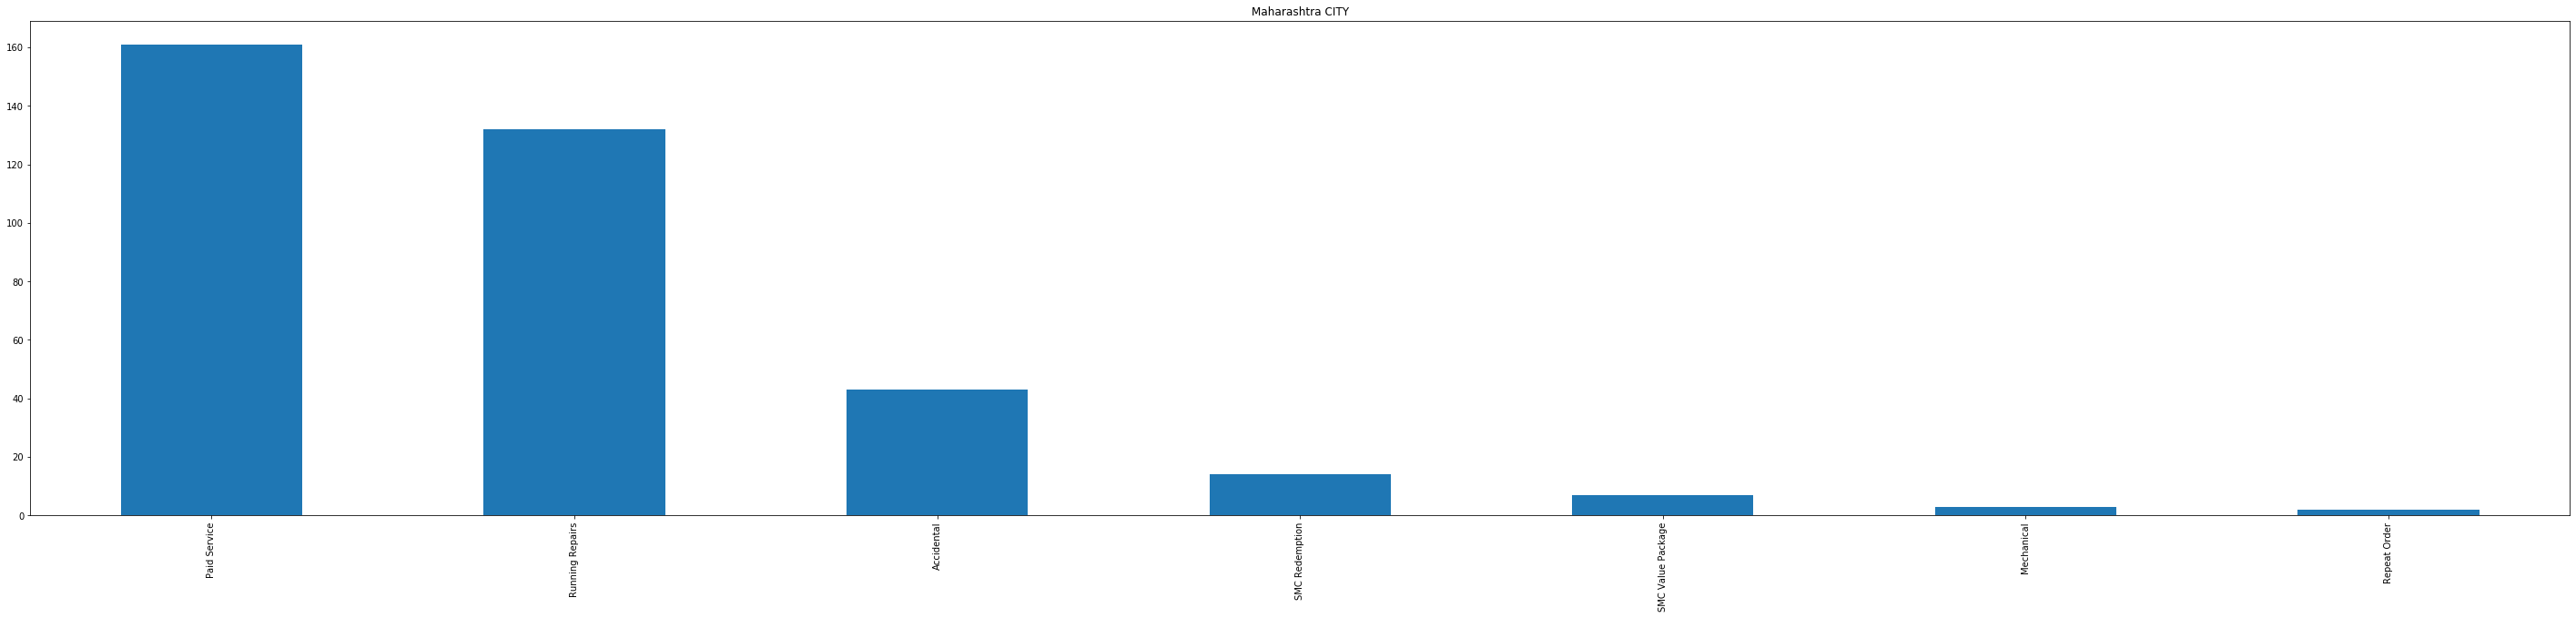

SX4


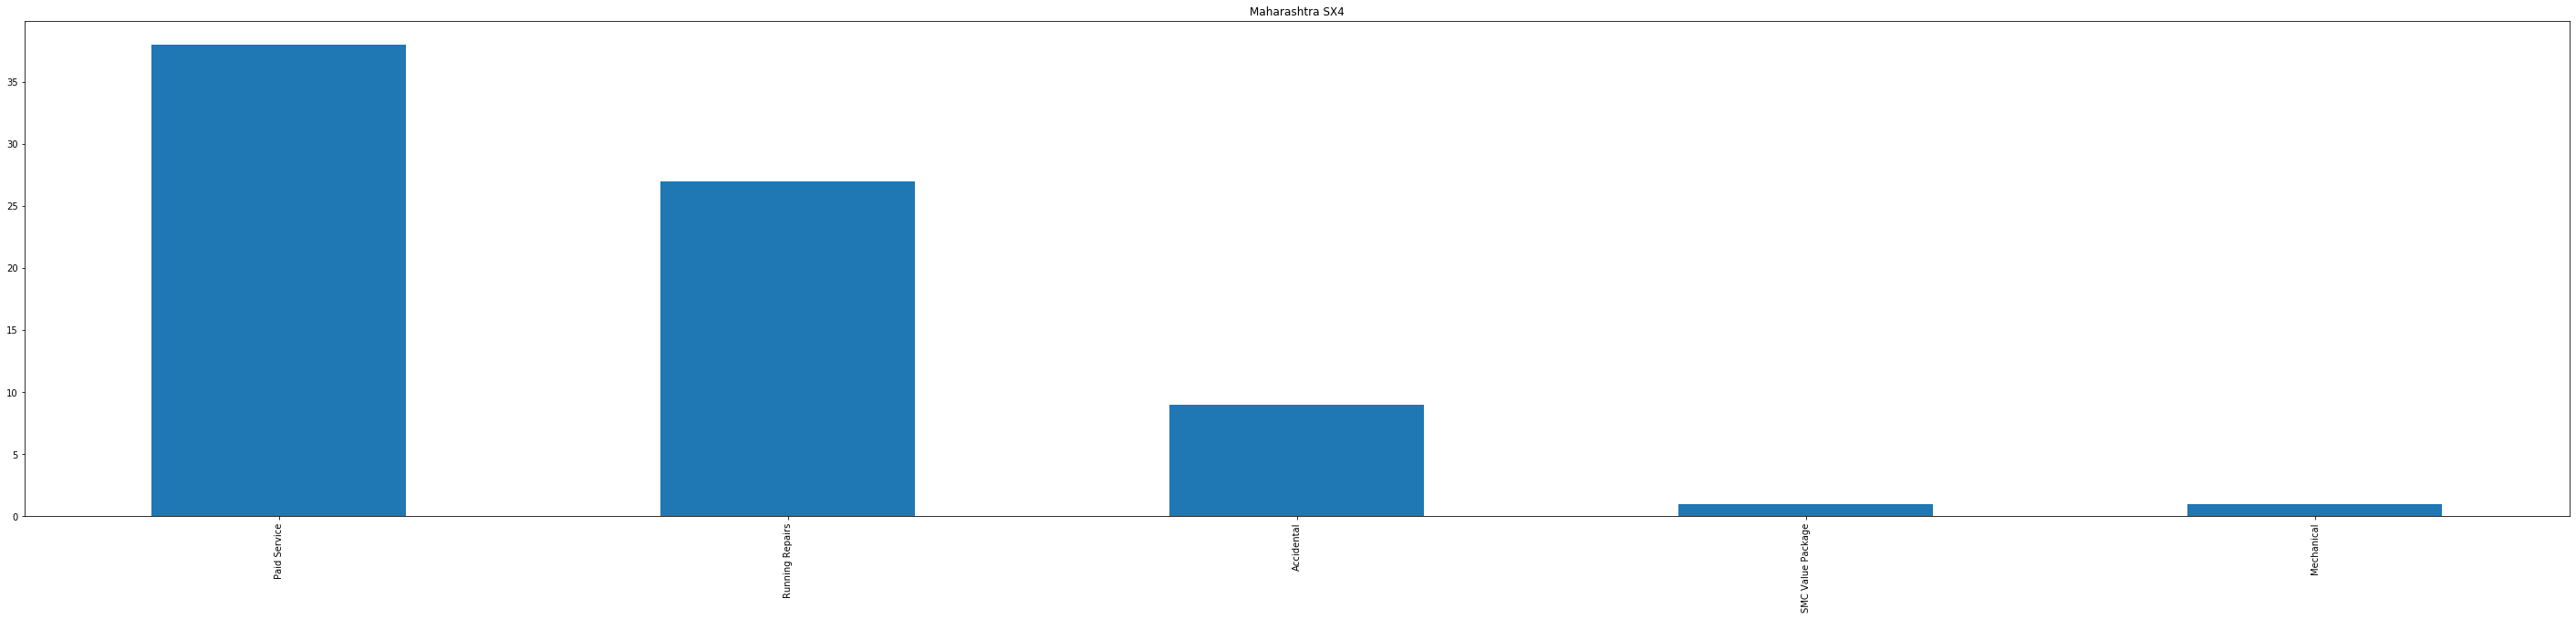

MICRA


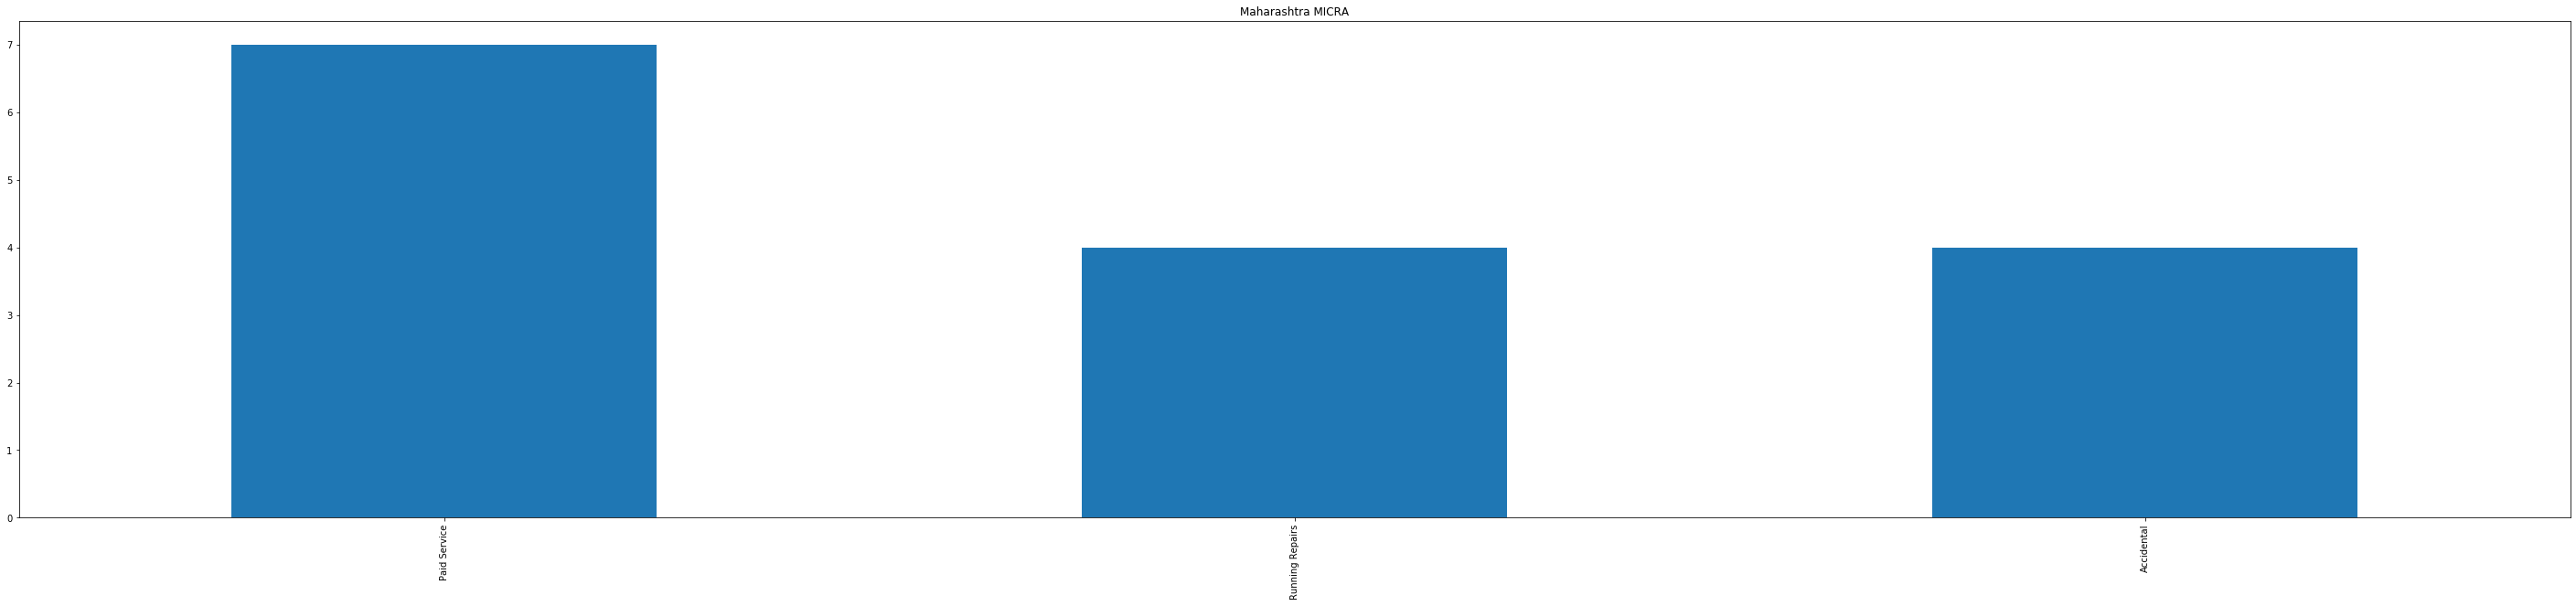

ESTEEM 1000


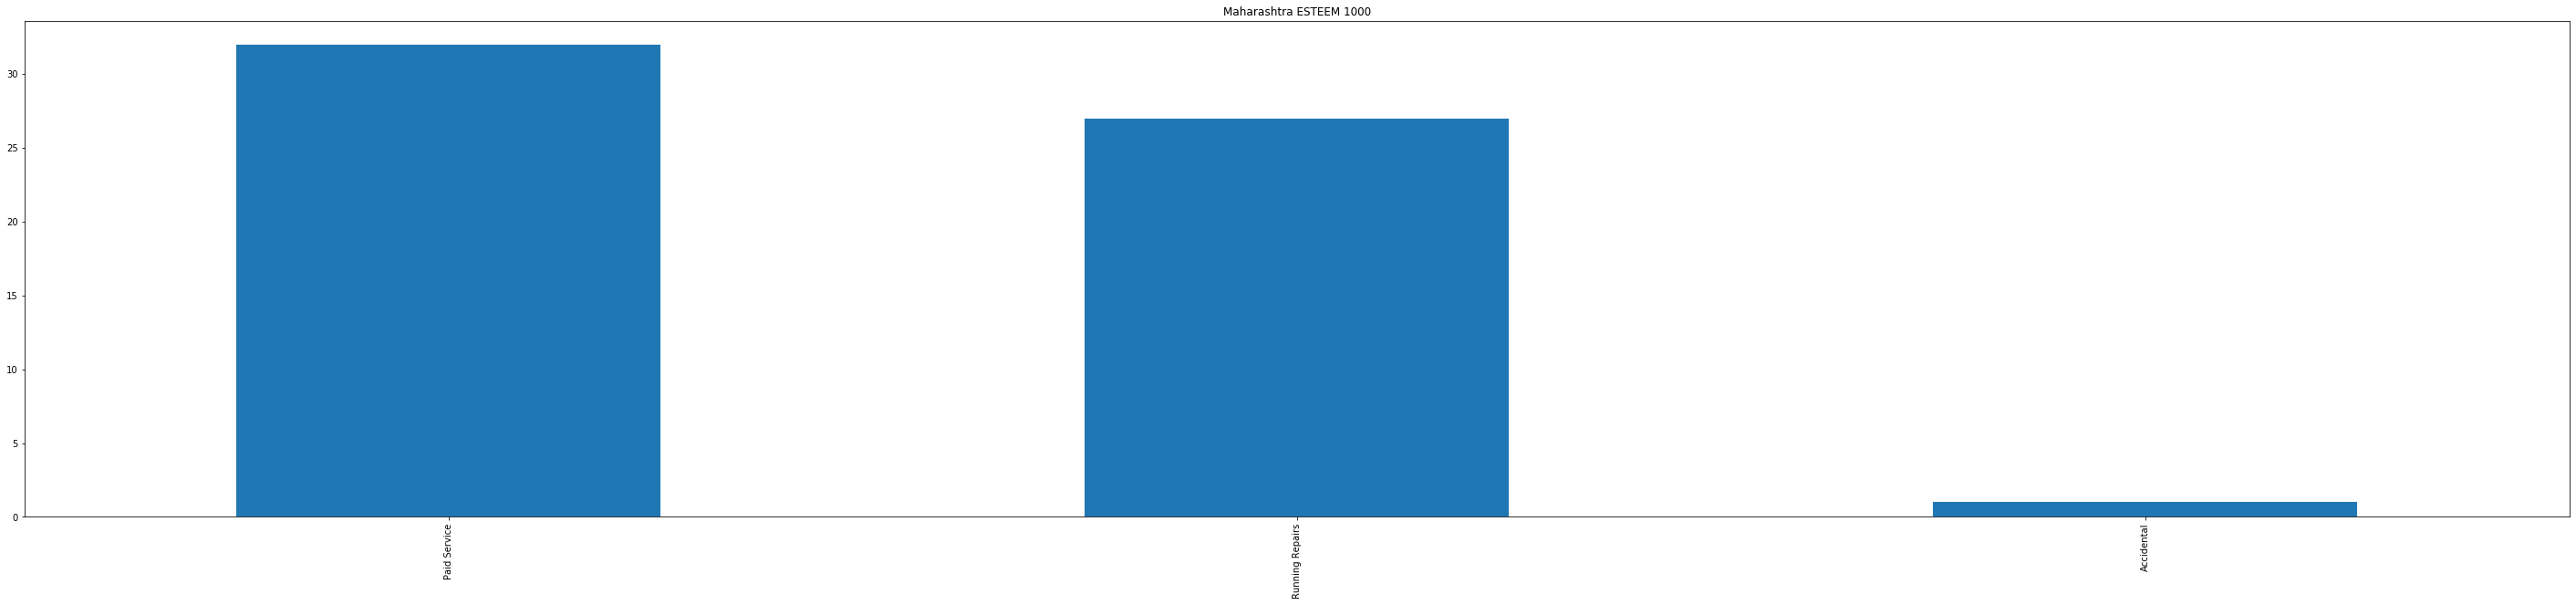

WAGONR


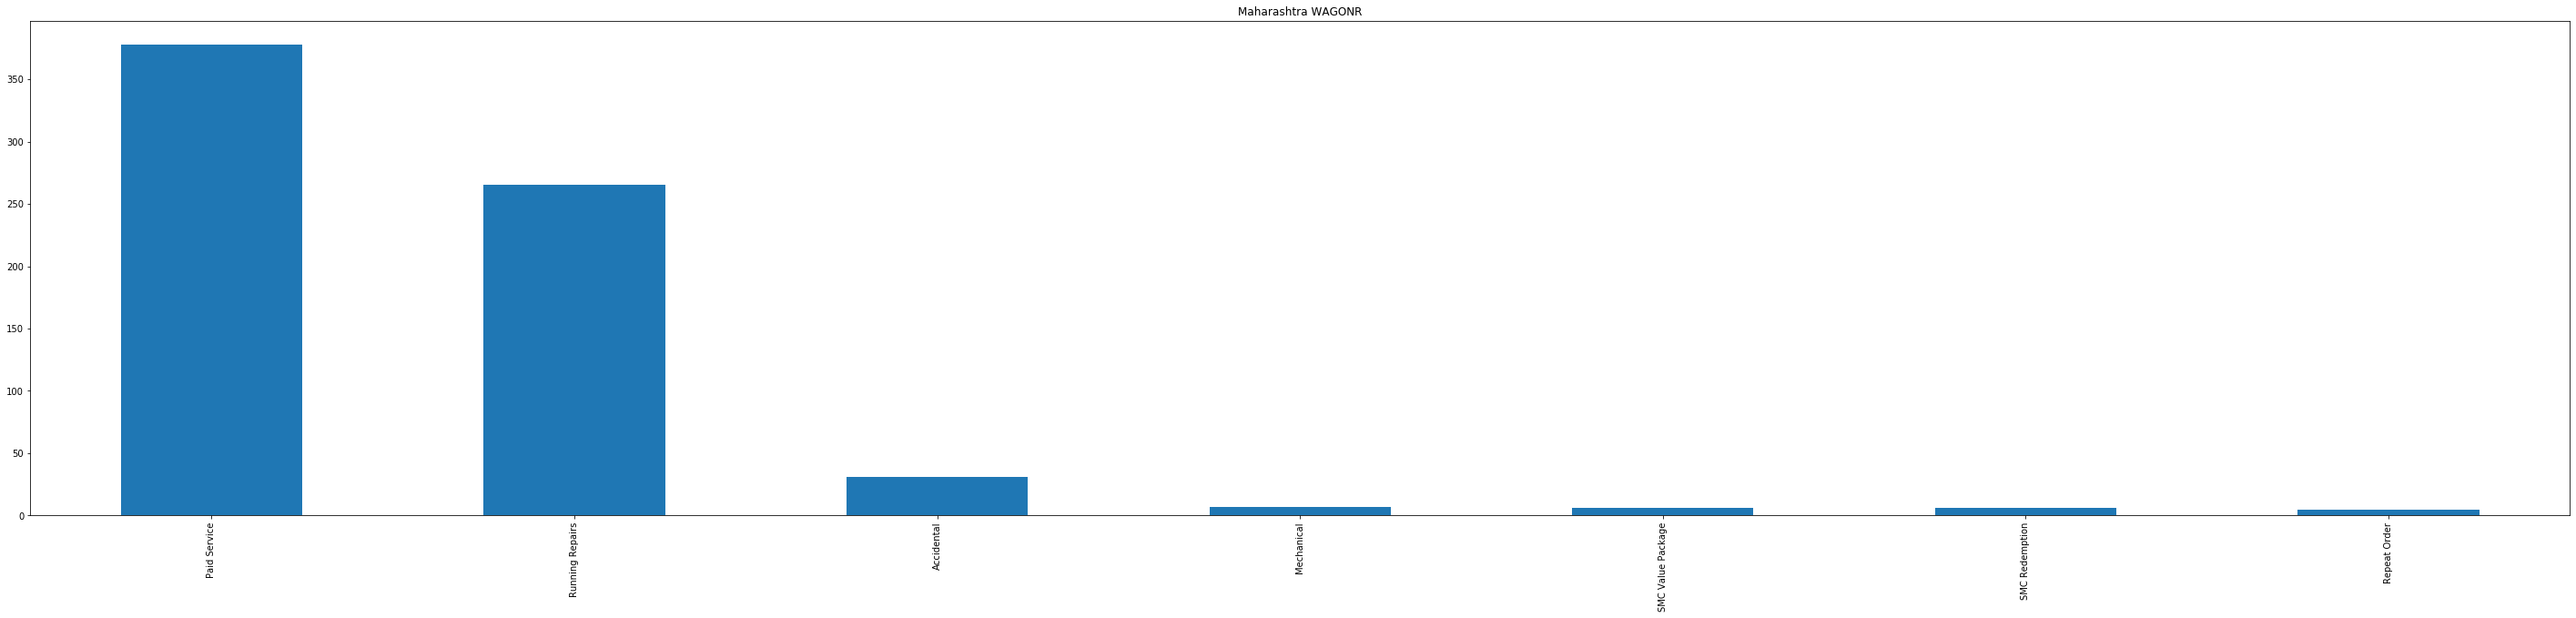

OMNI


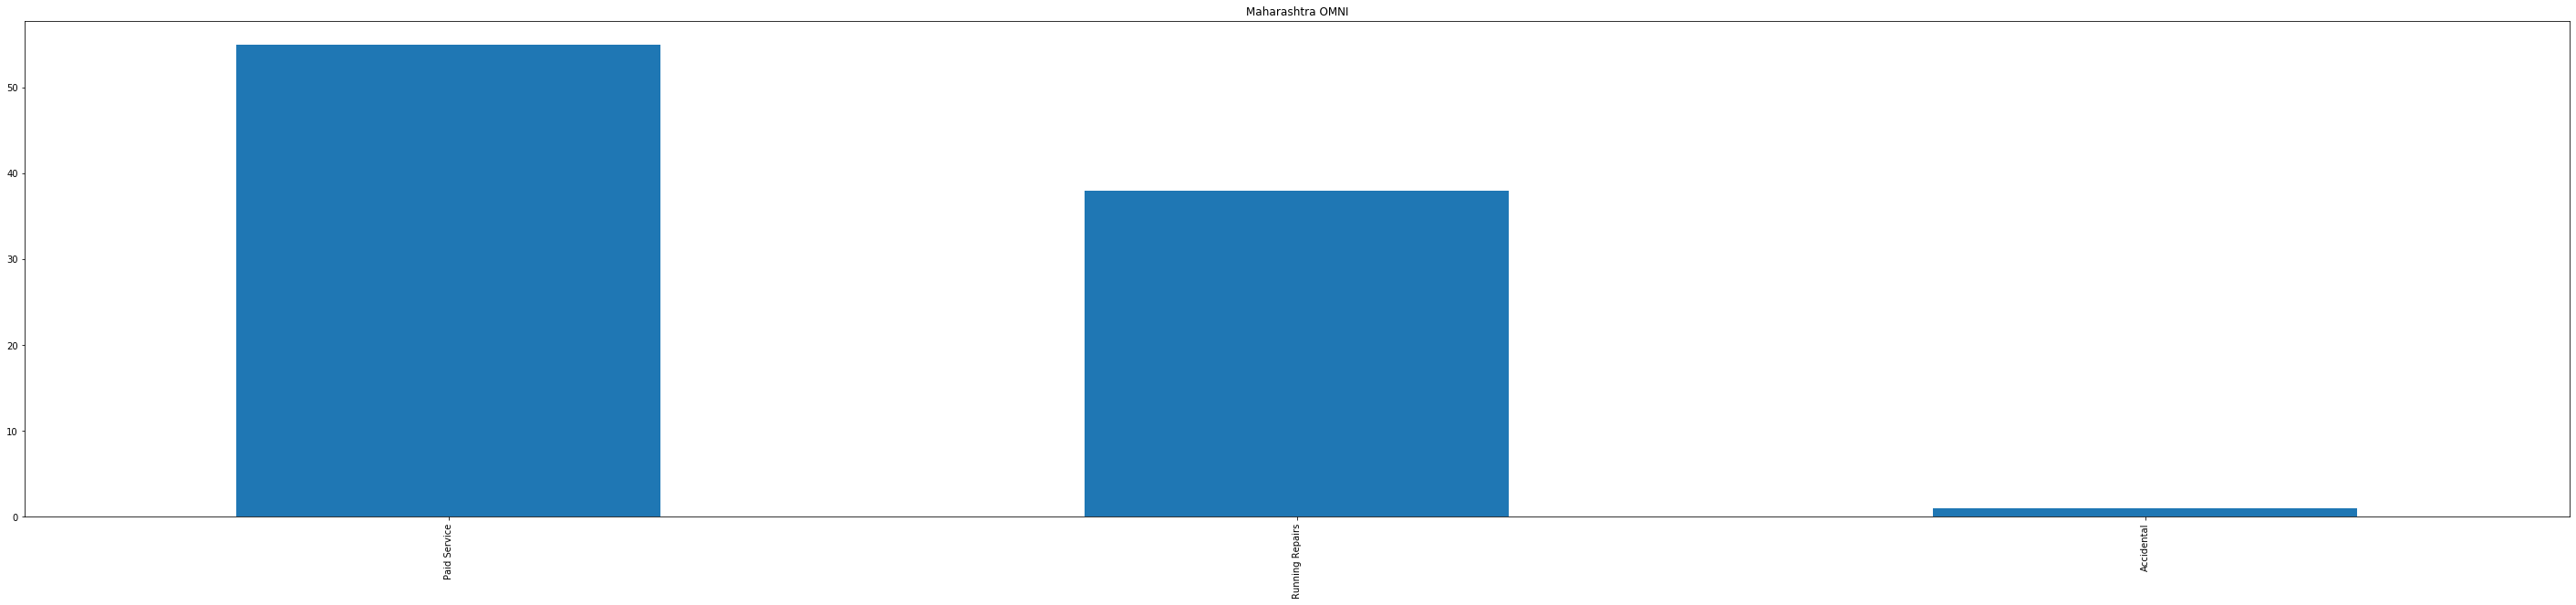

RAPID


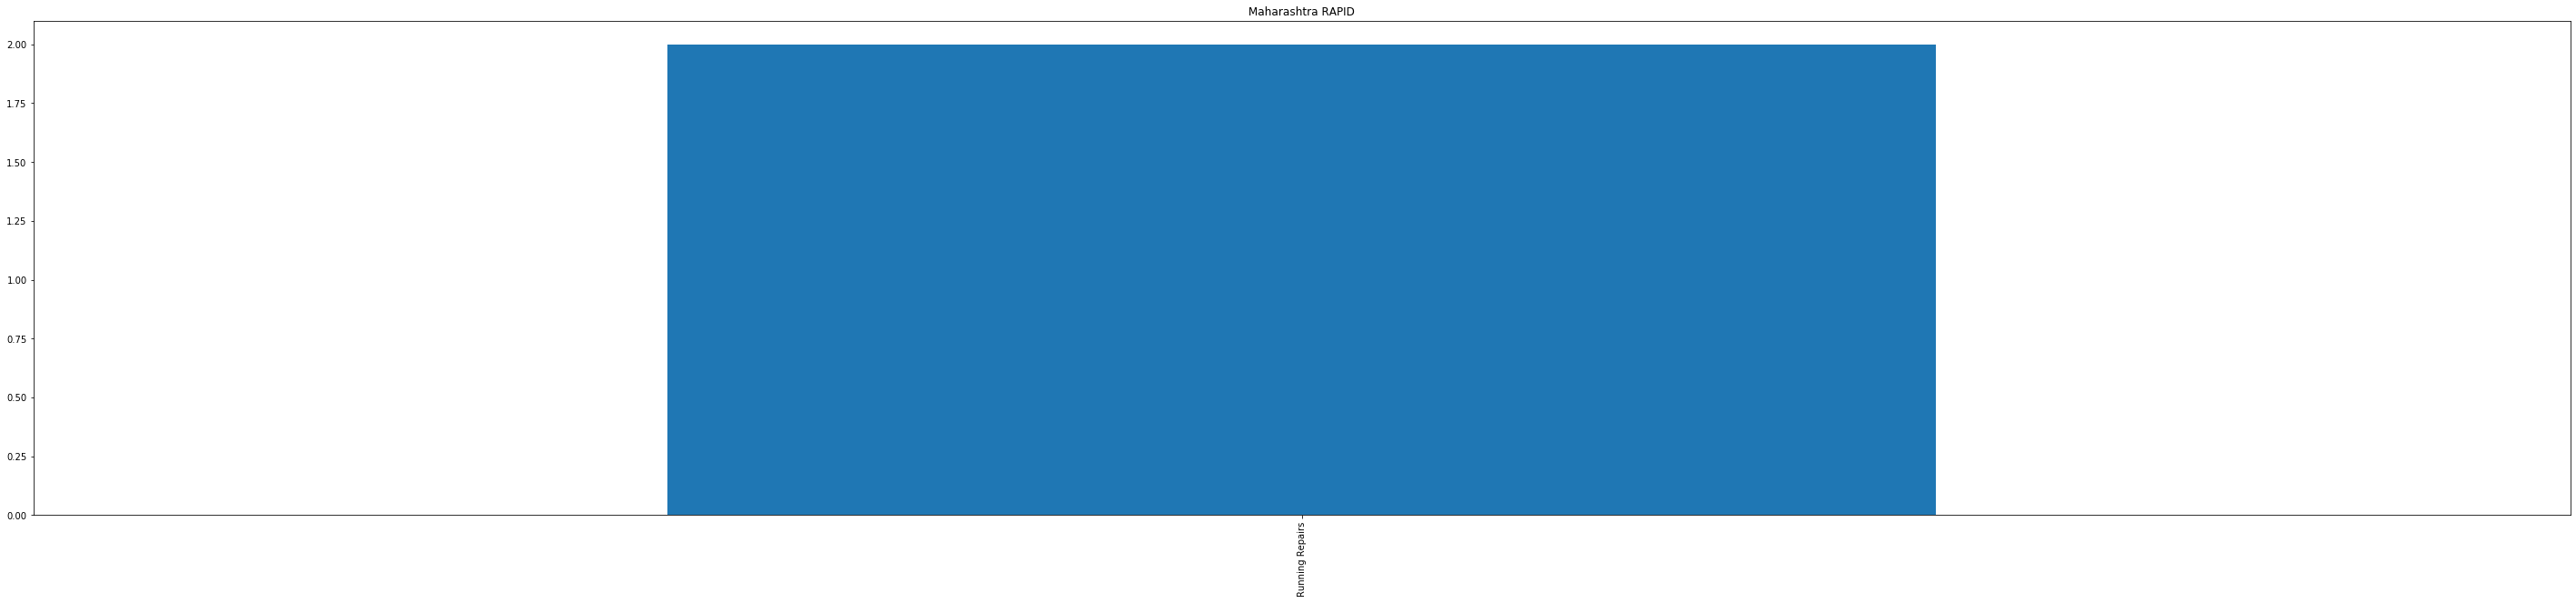

VERNA


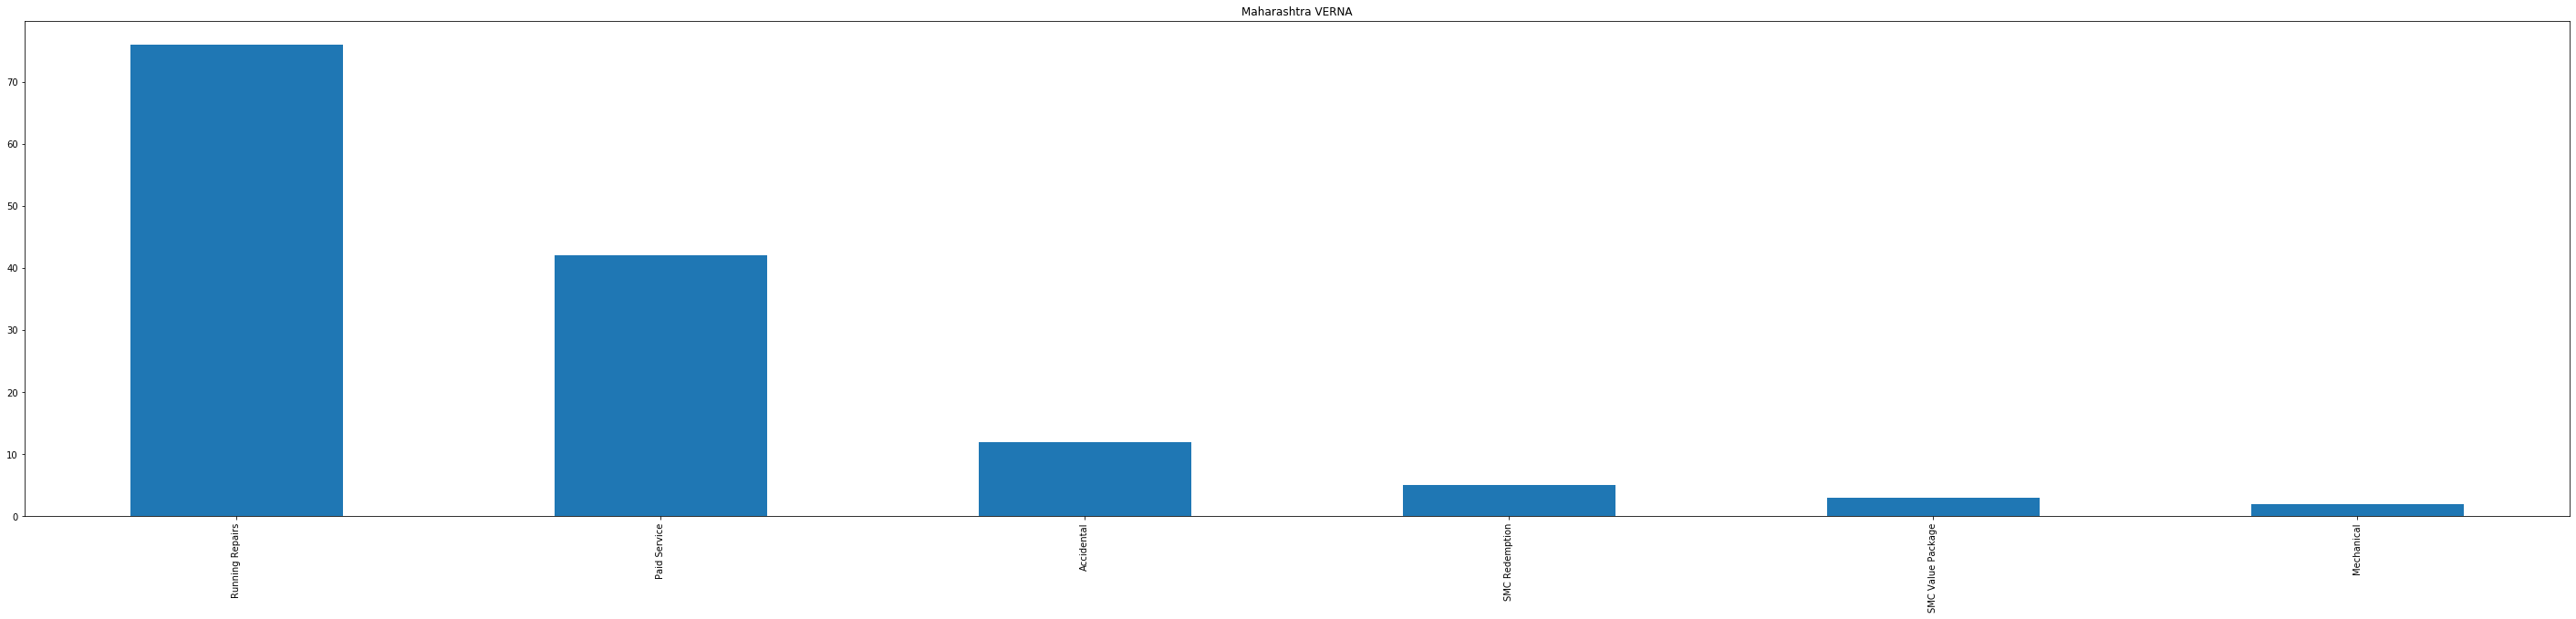

ZEN ESTILO


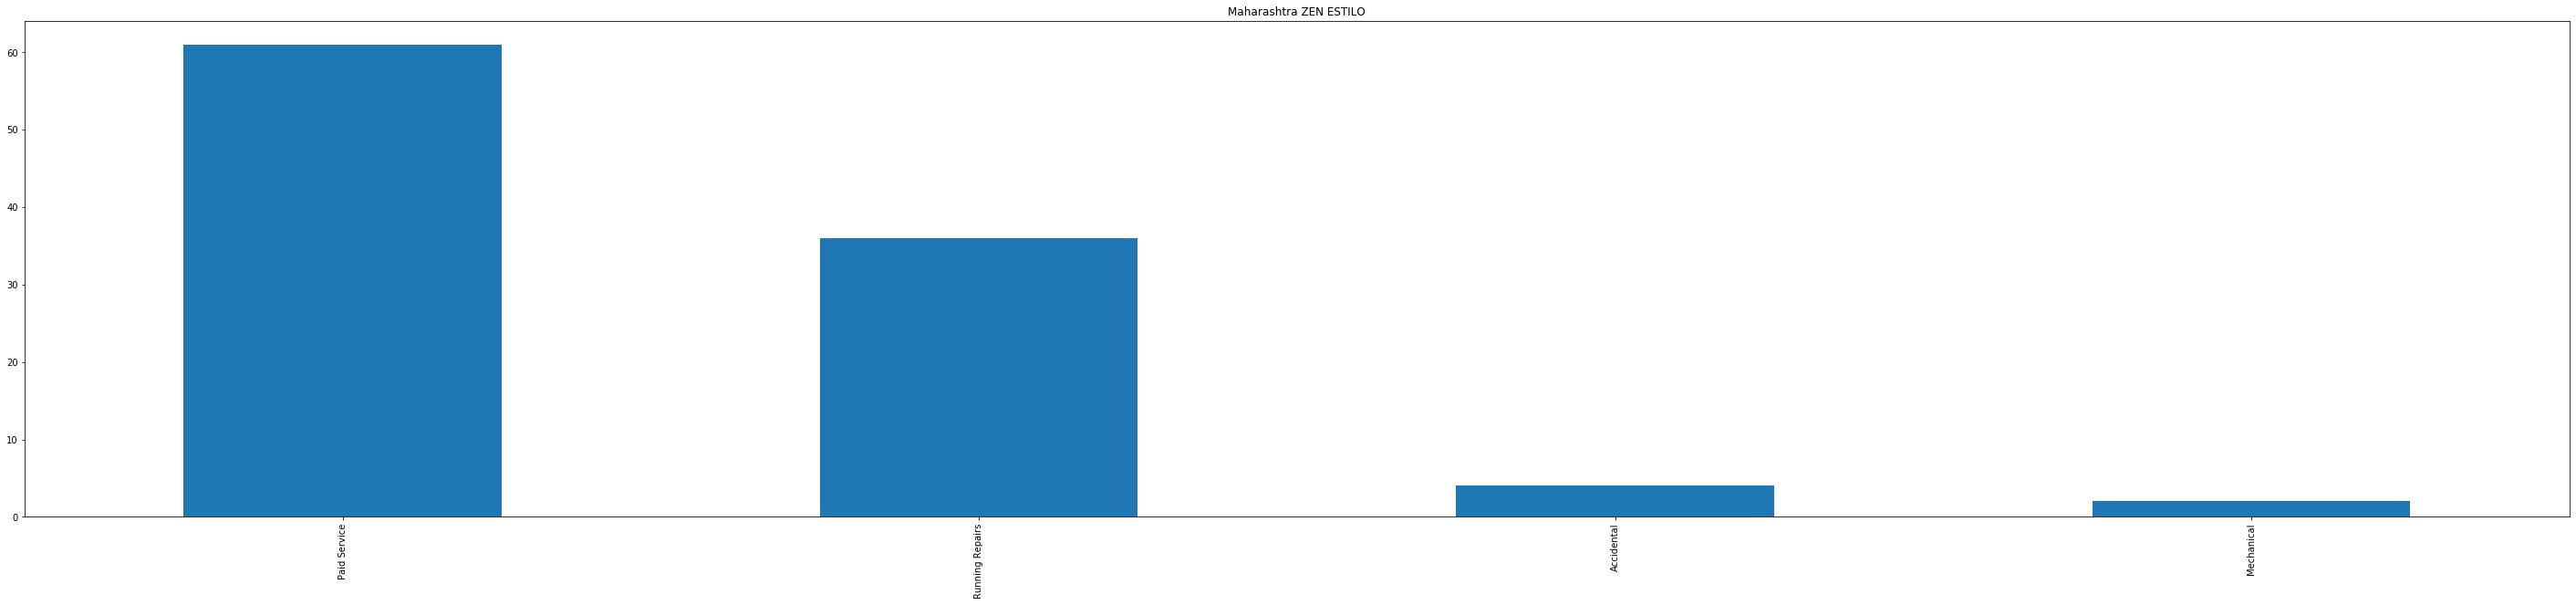

INDIGO


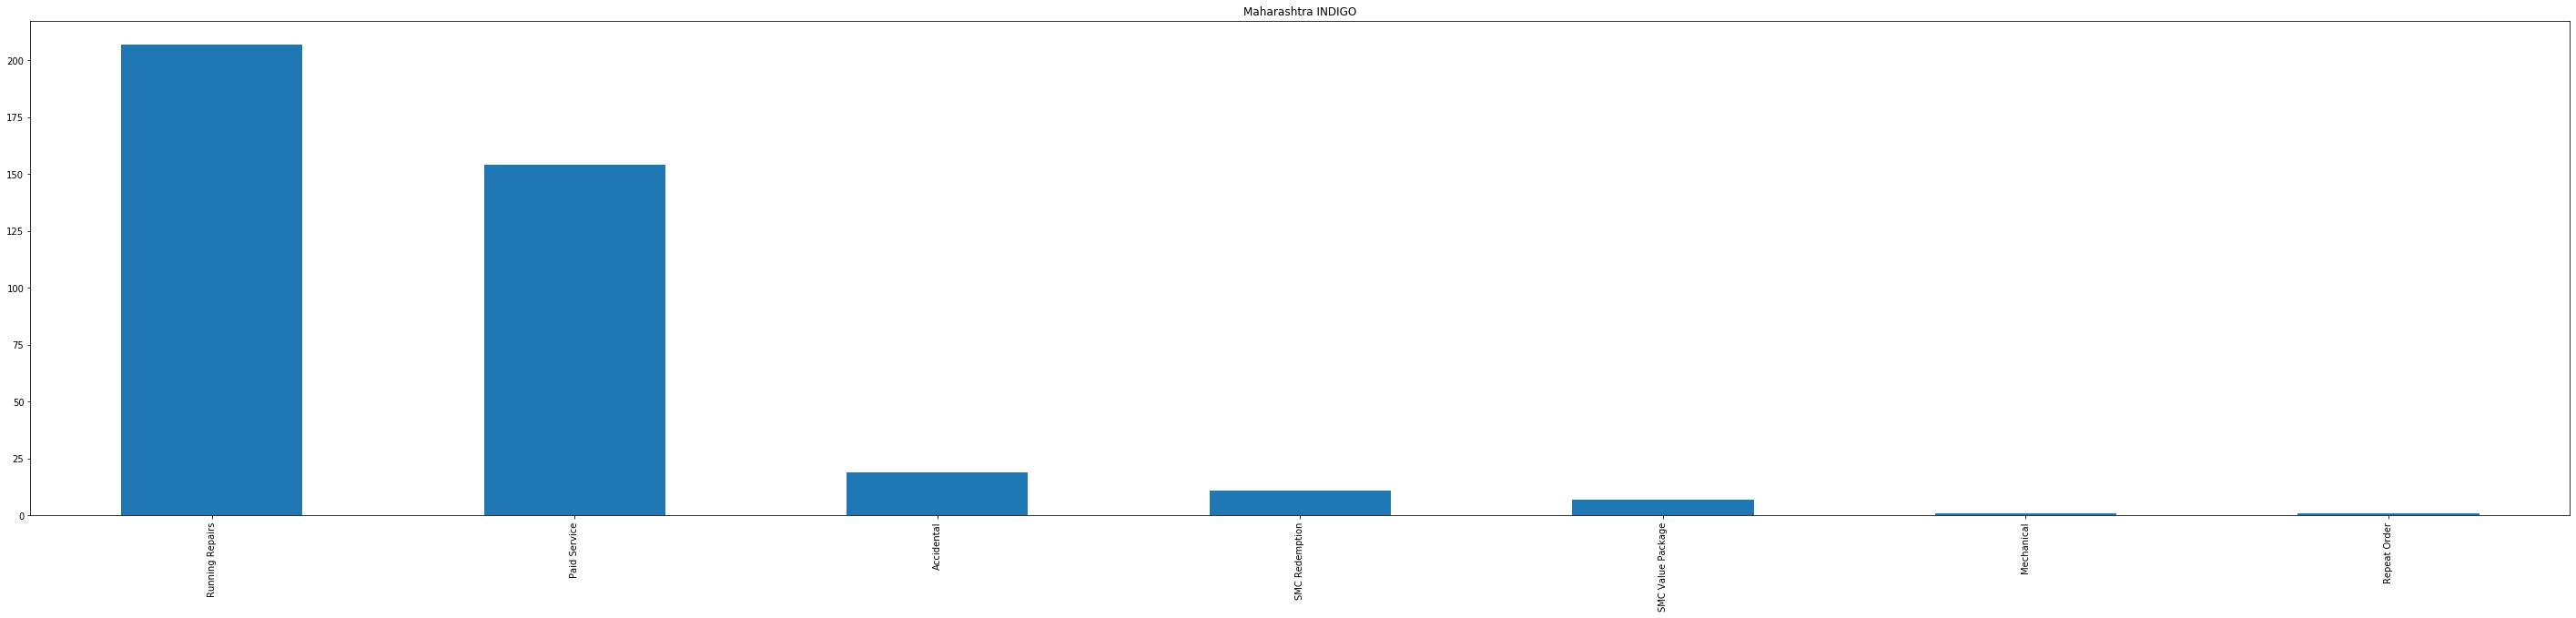

AVEO UV-A


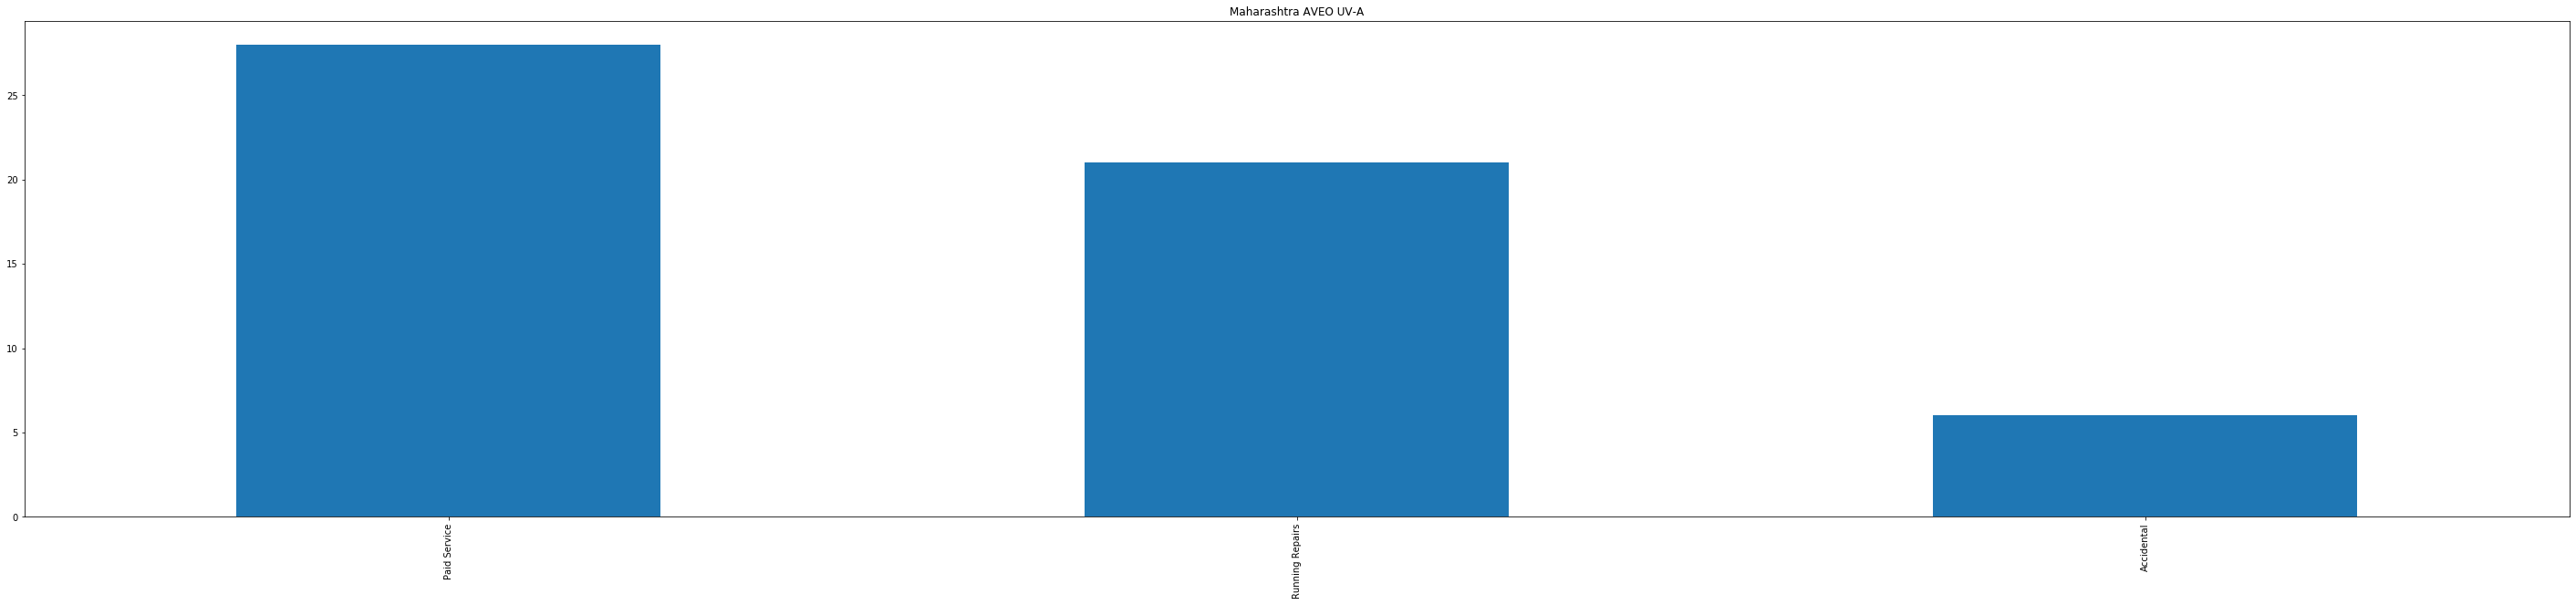

POLO


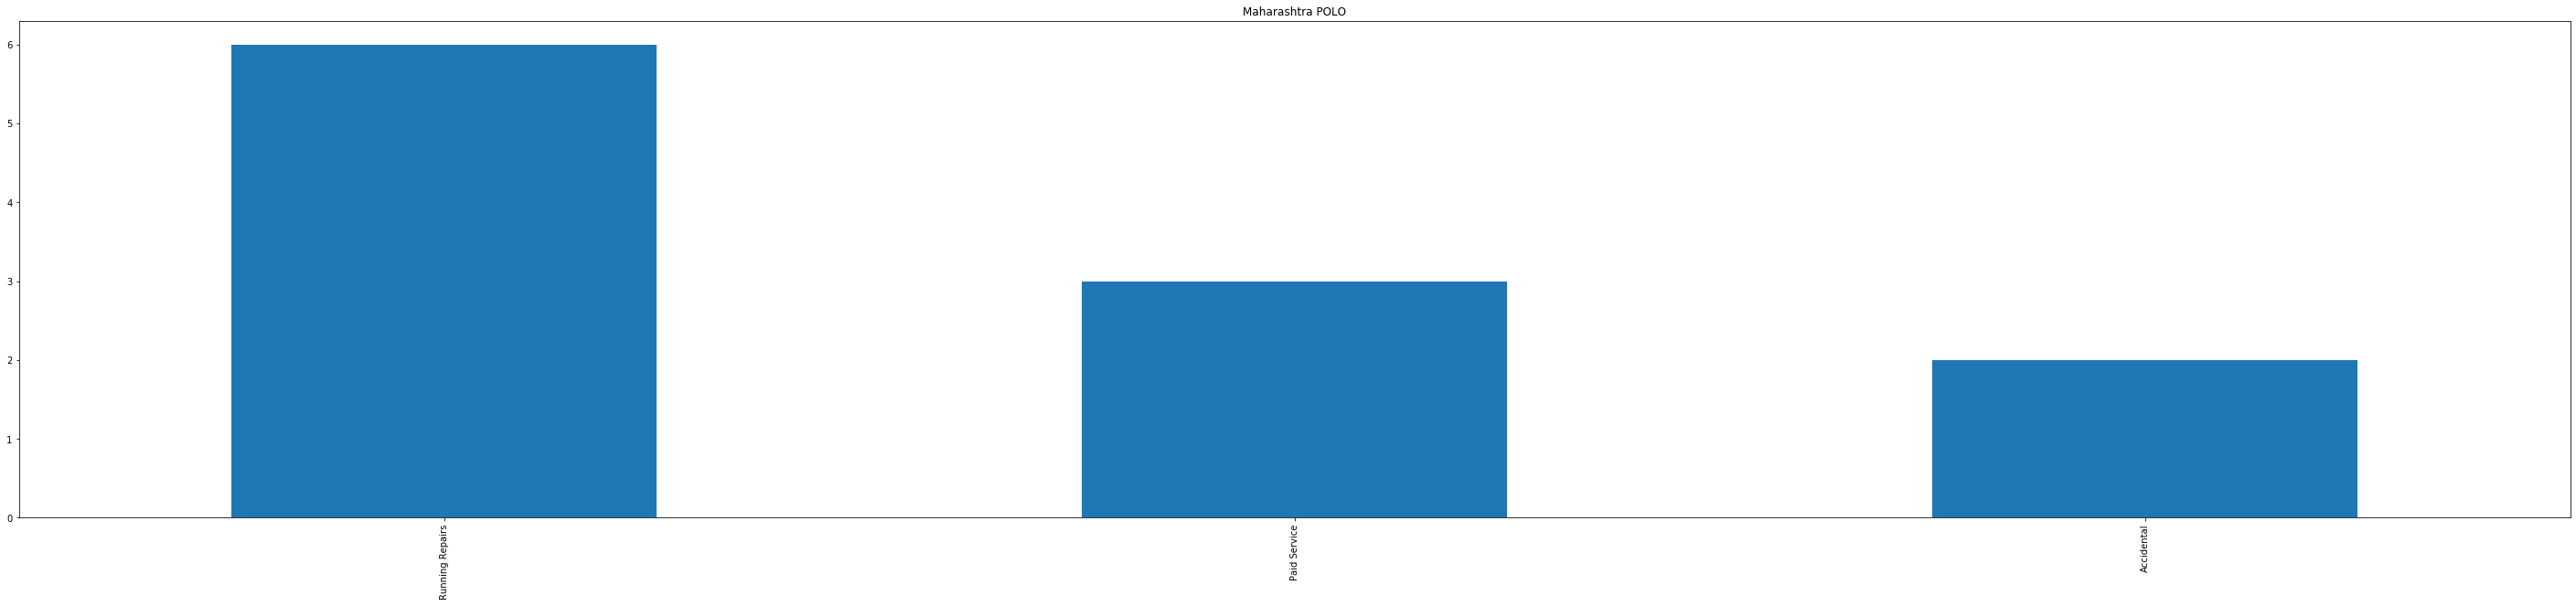

SWIFT


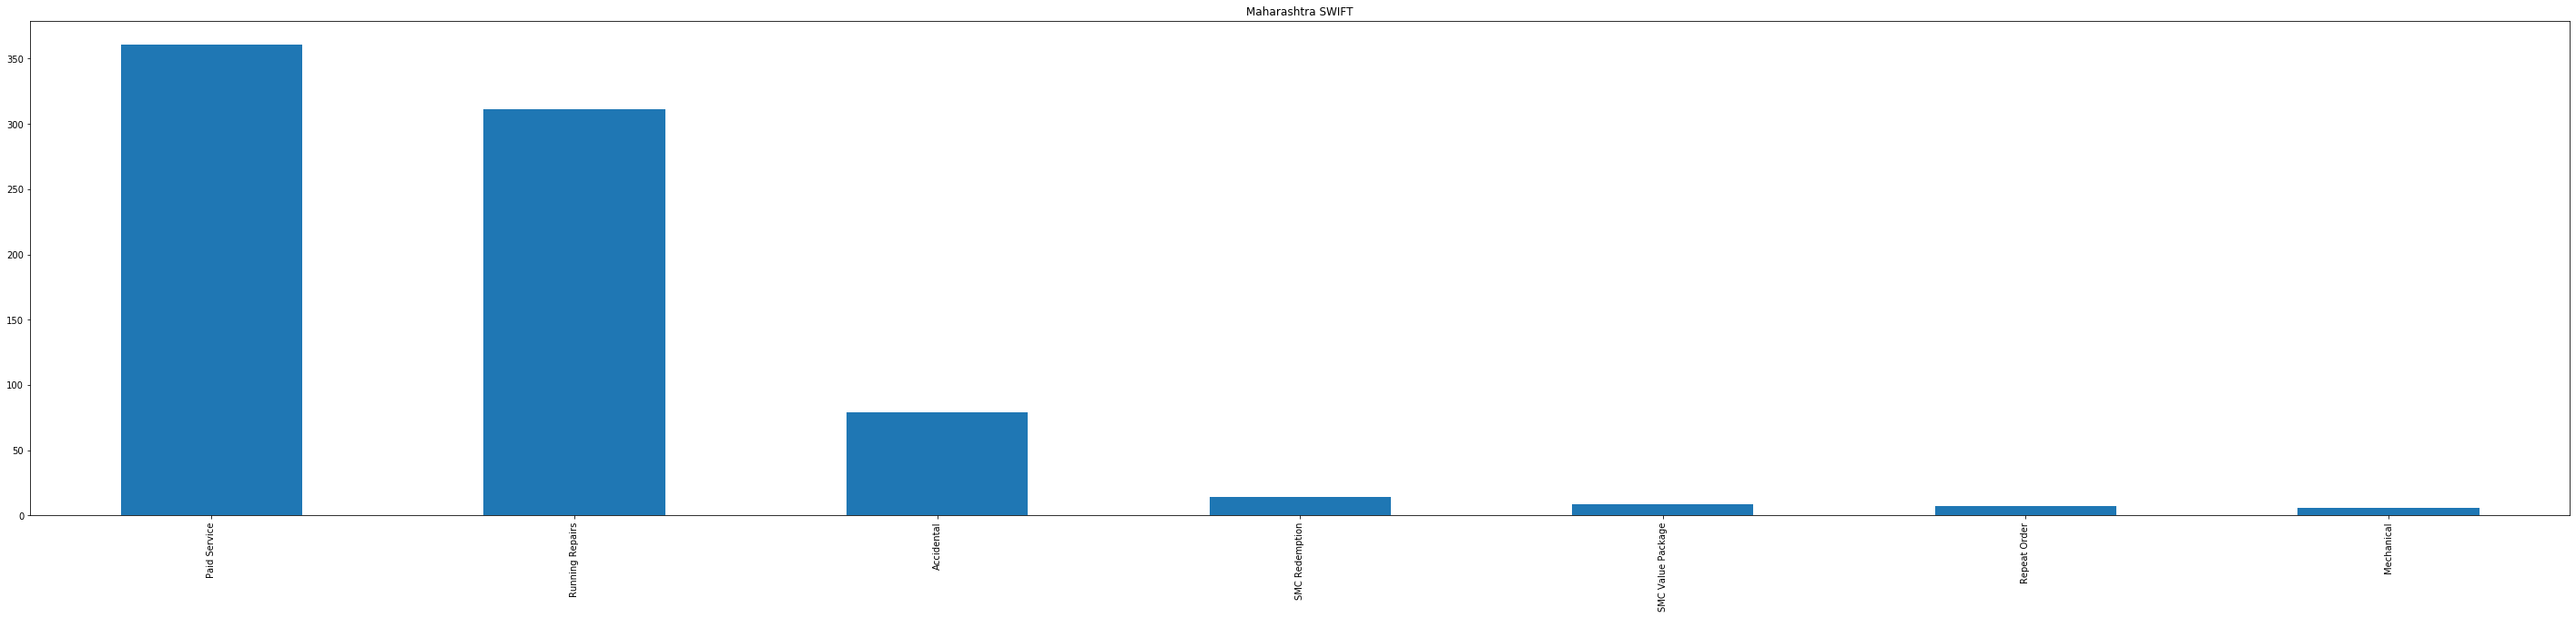

EECO


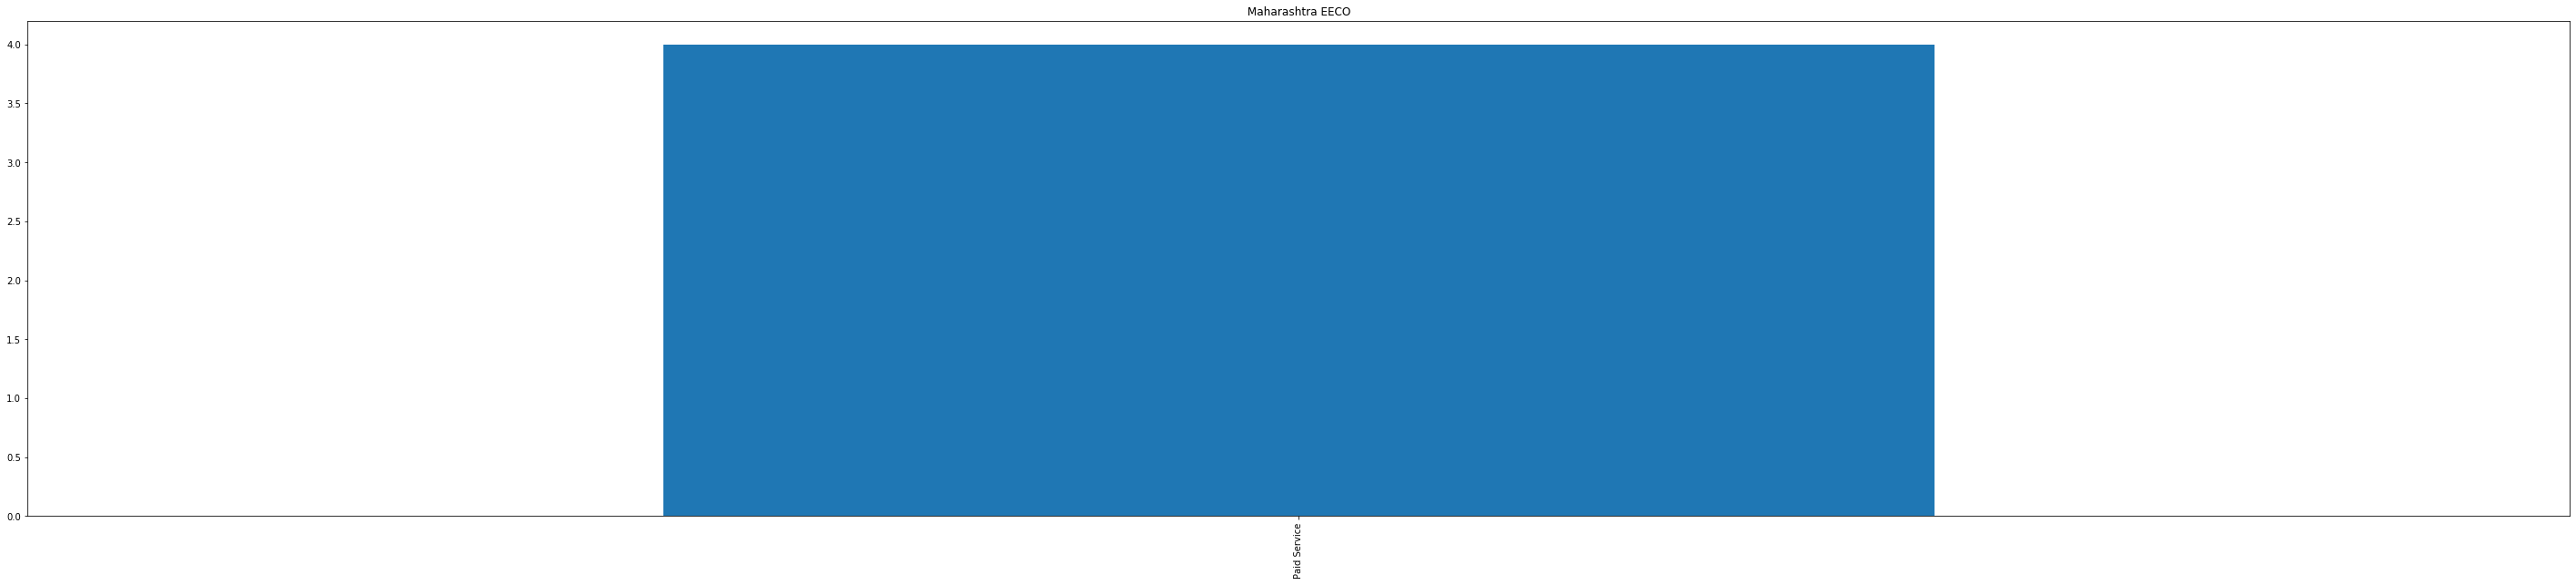

SANTRO XING


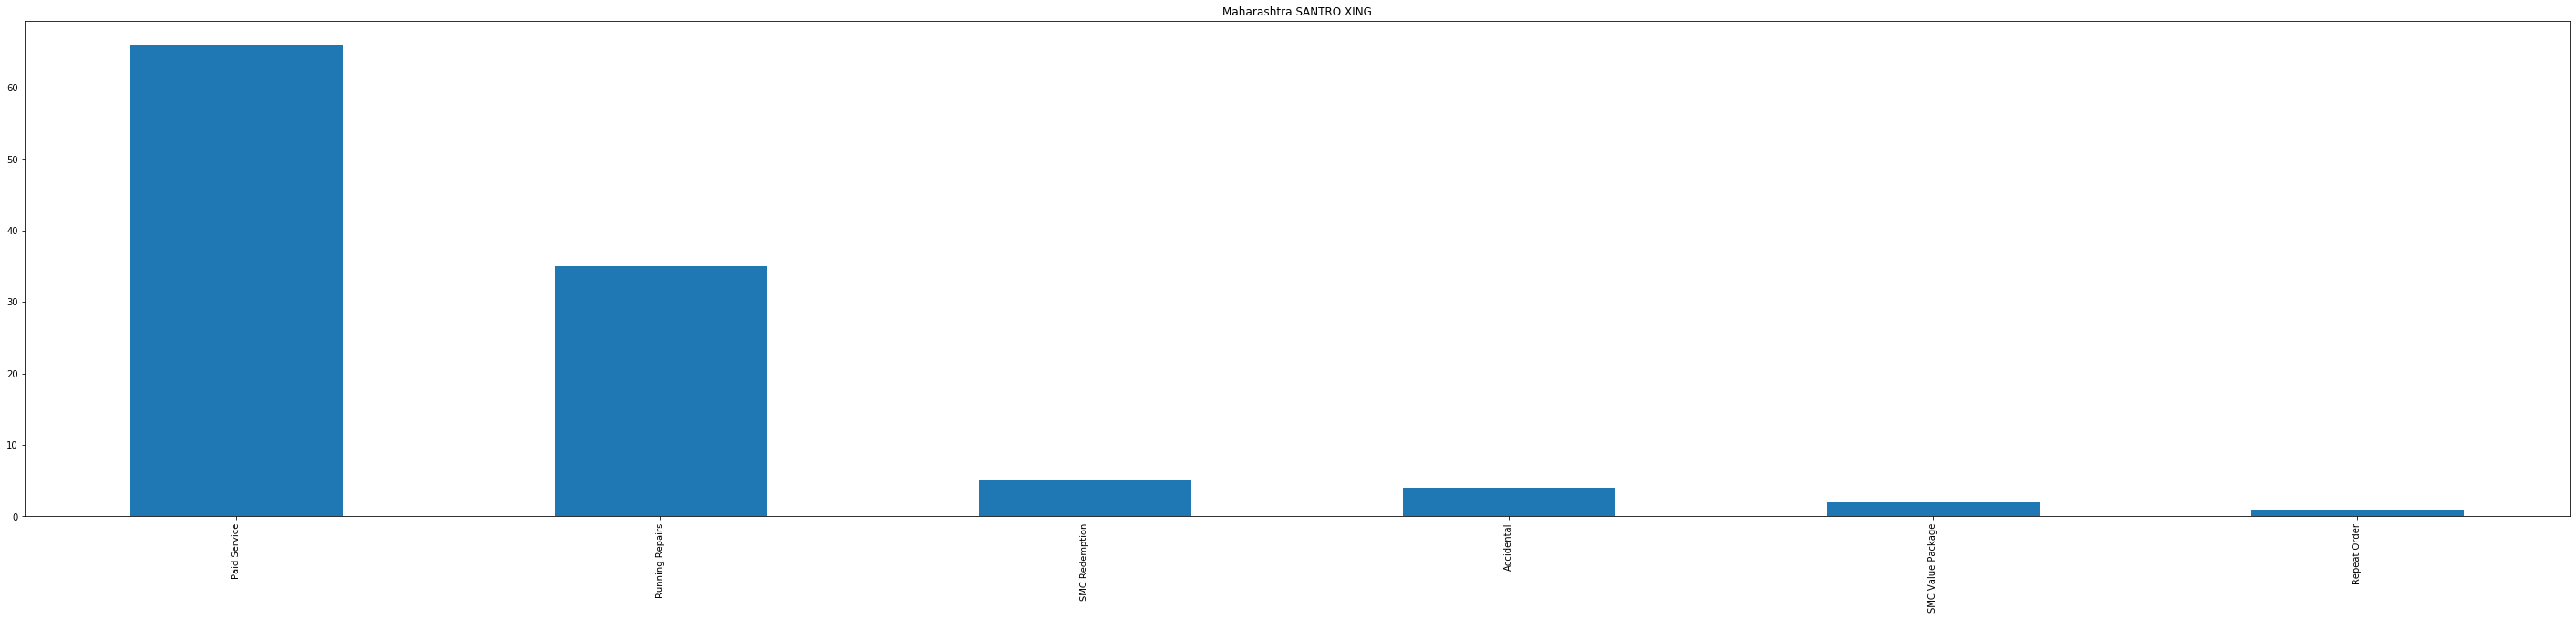

LOGAN D


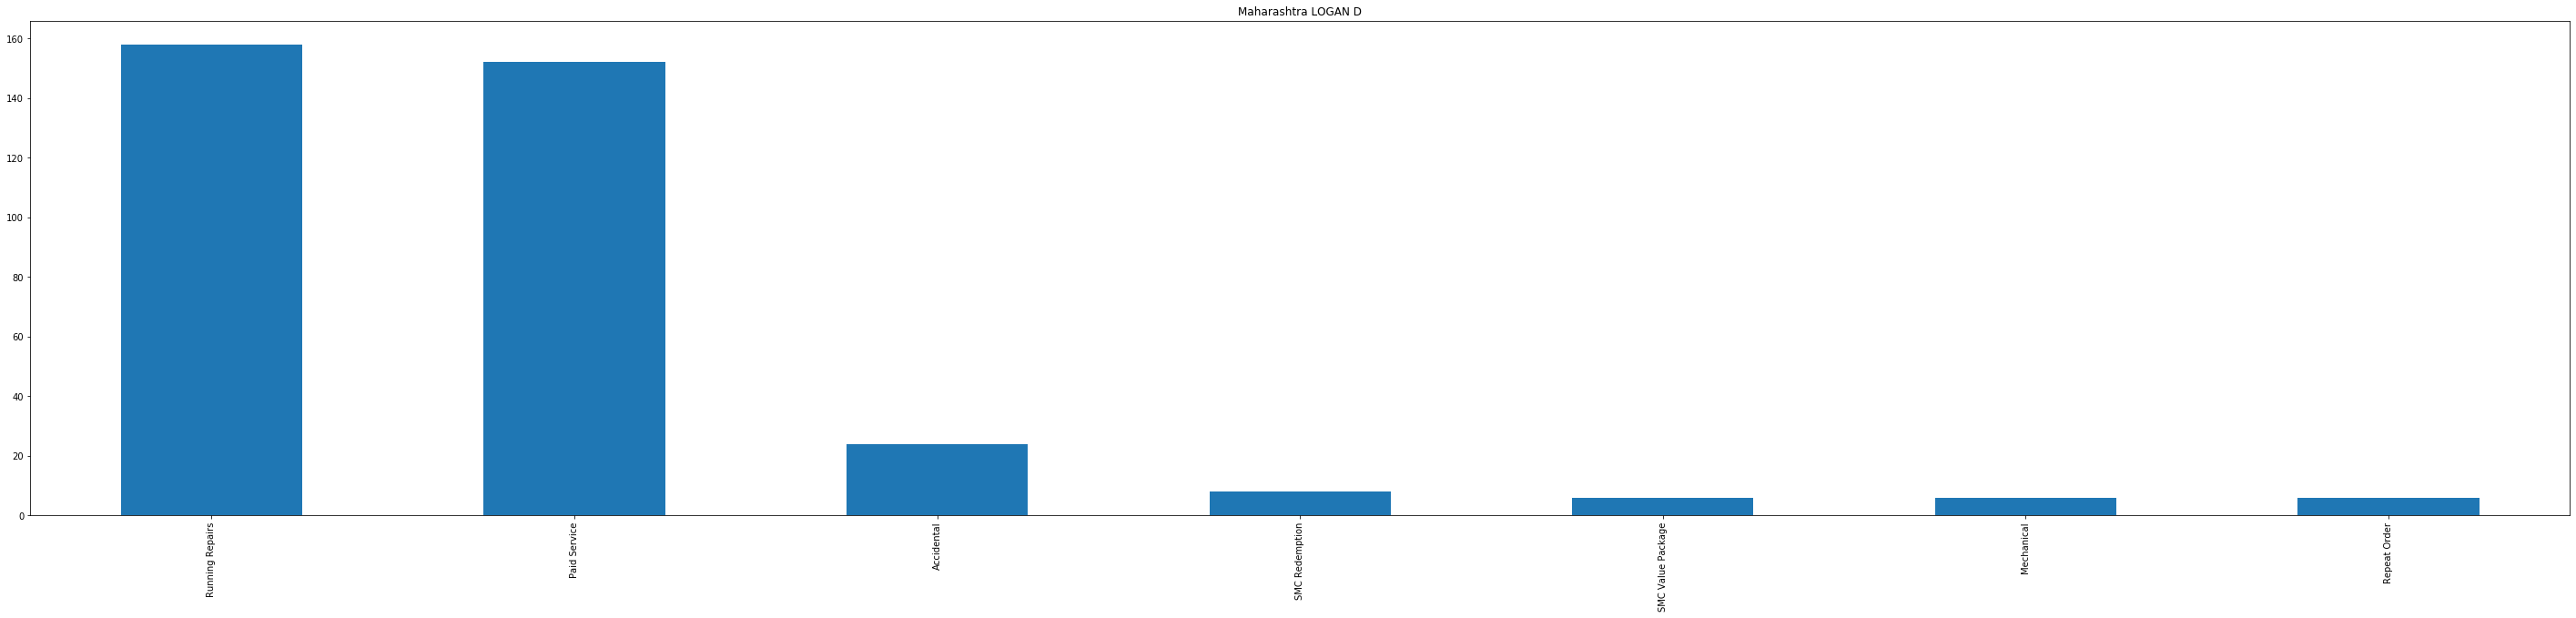

VERITO


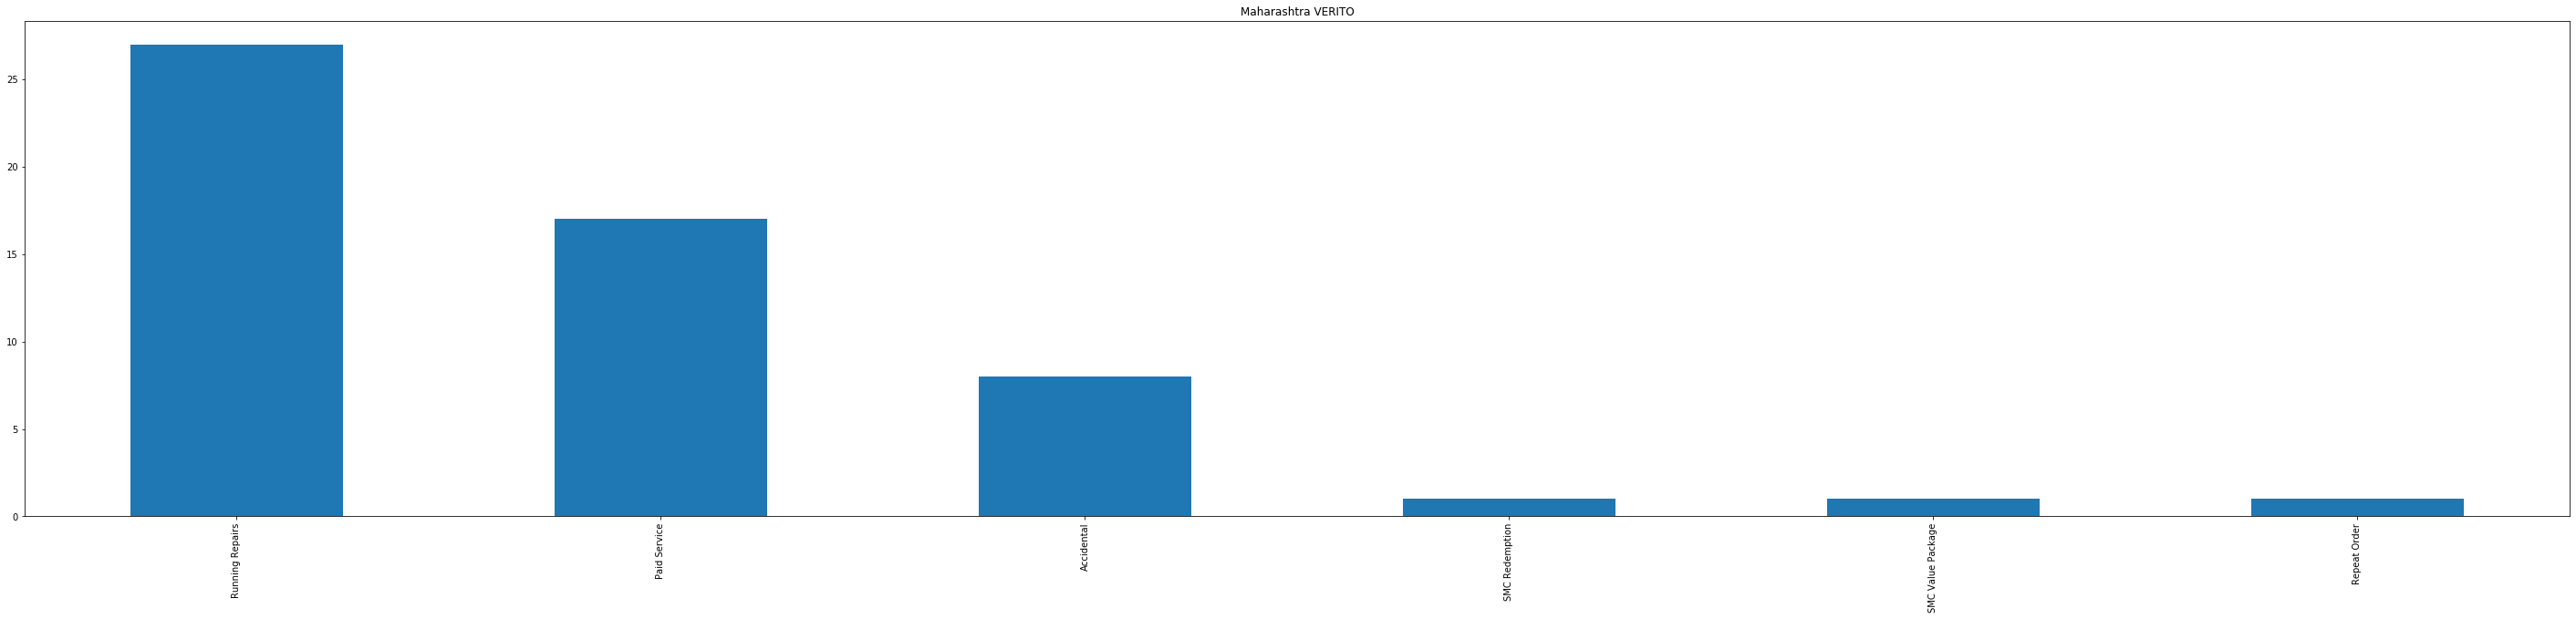

DUSTER


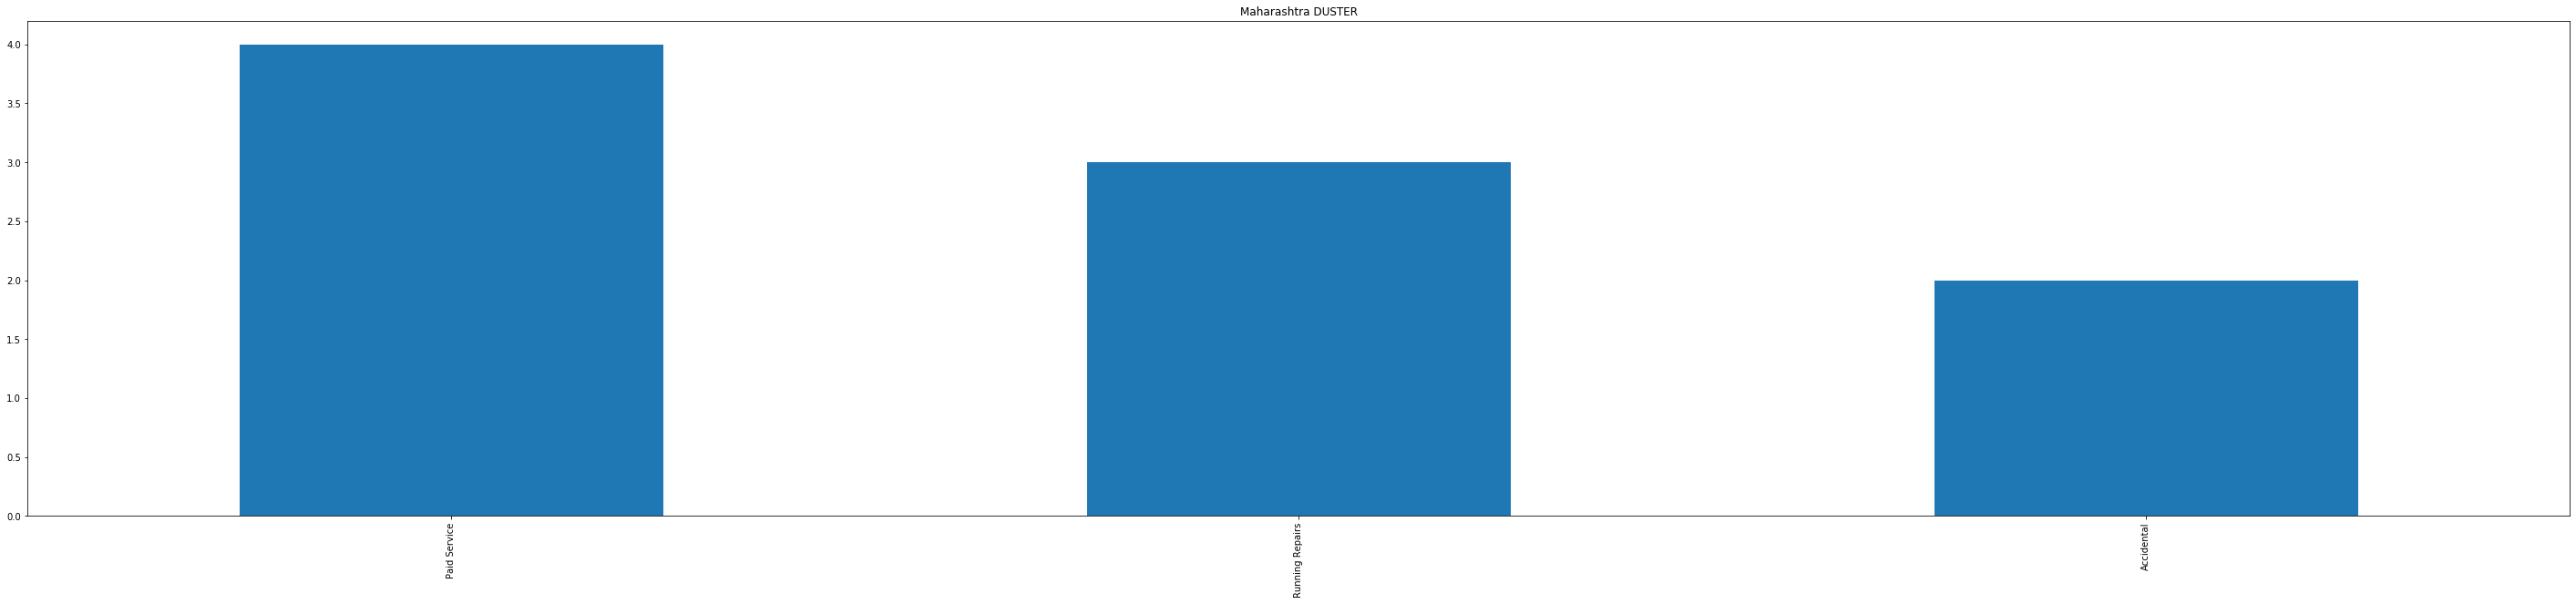

GETZ


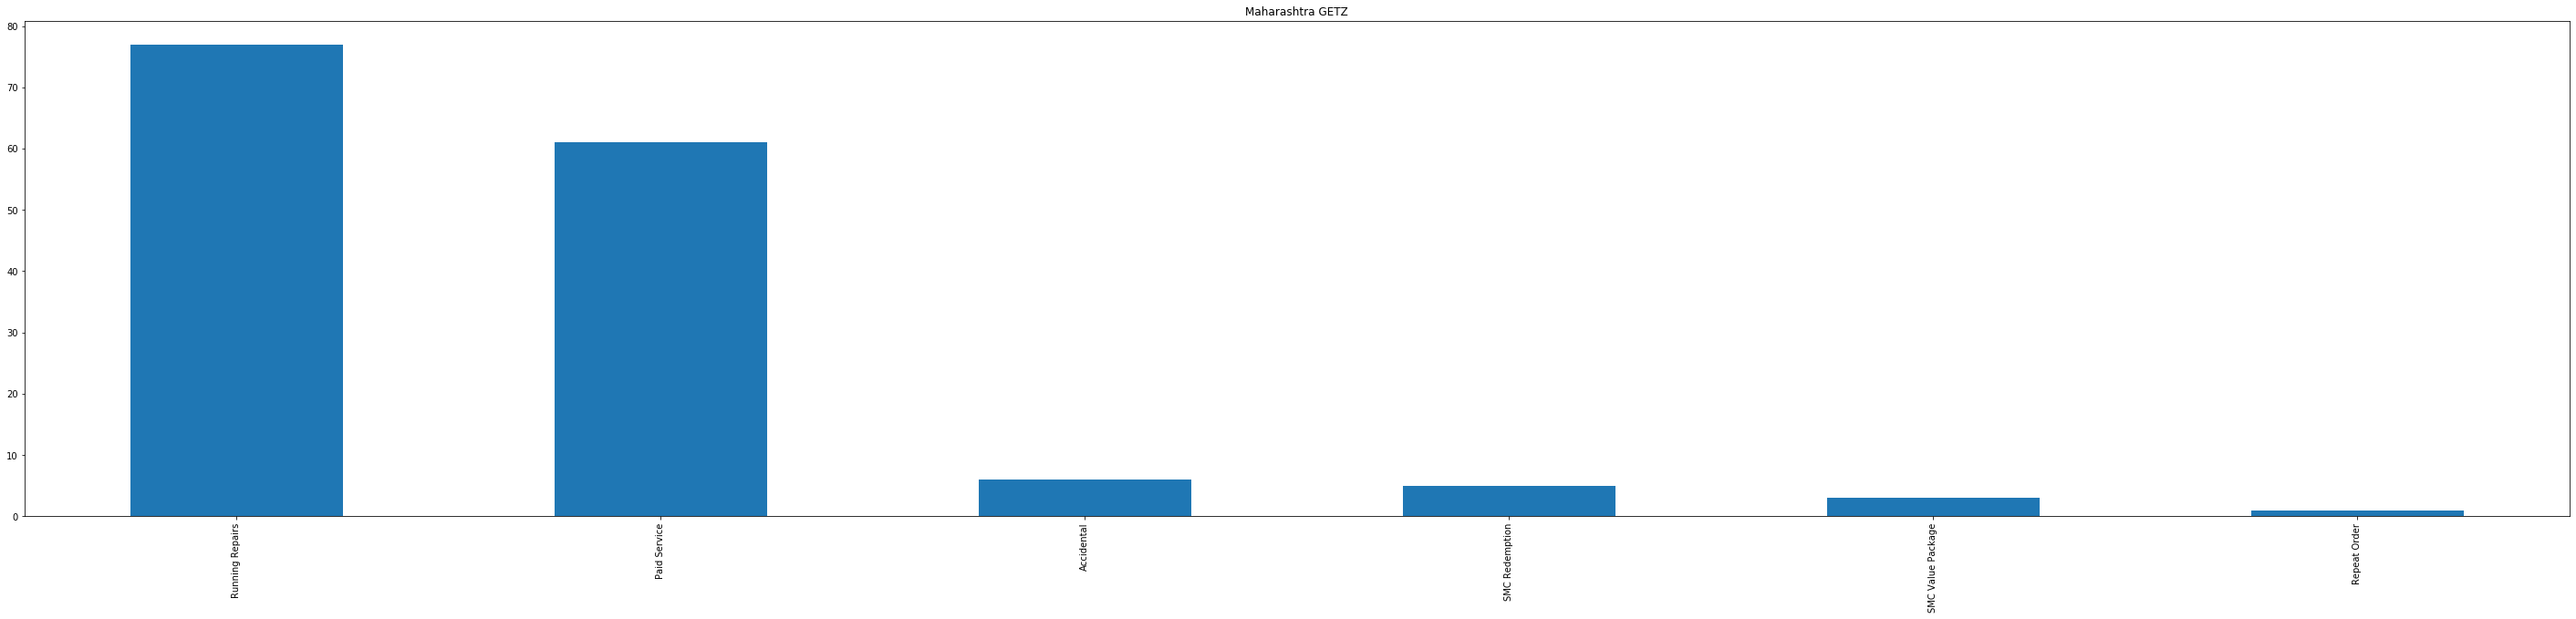

BALENO


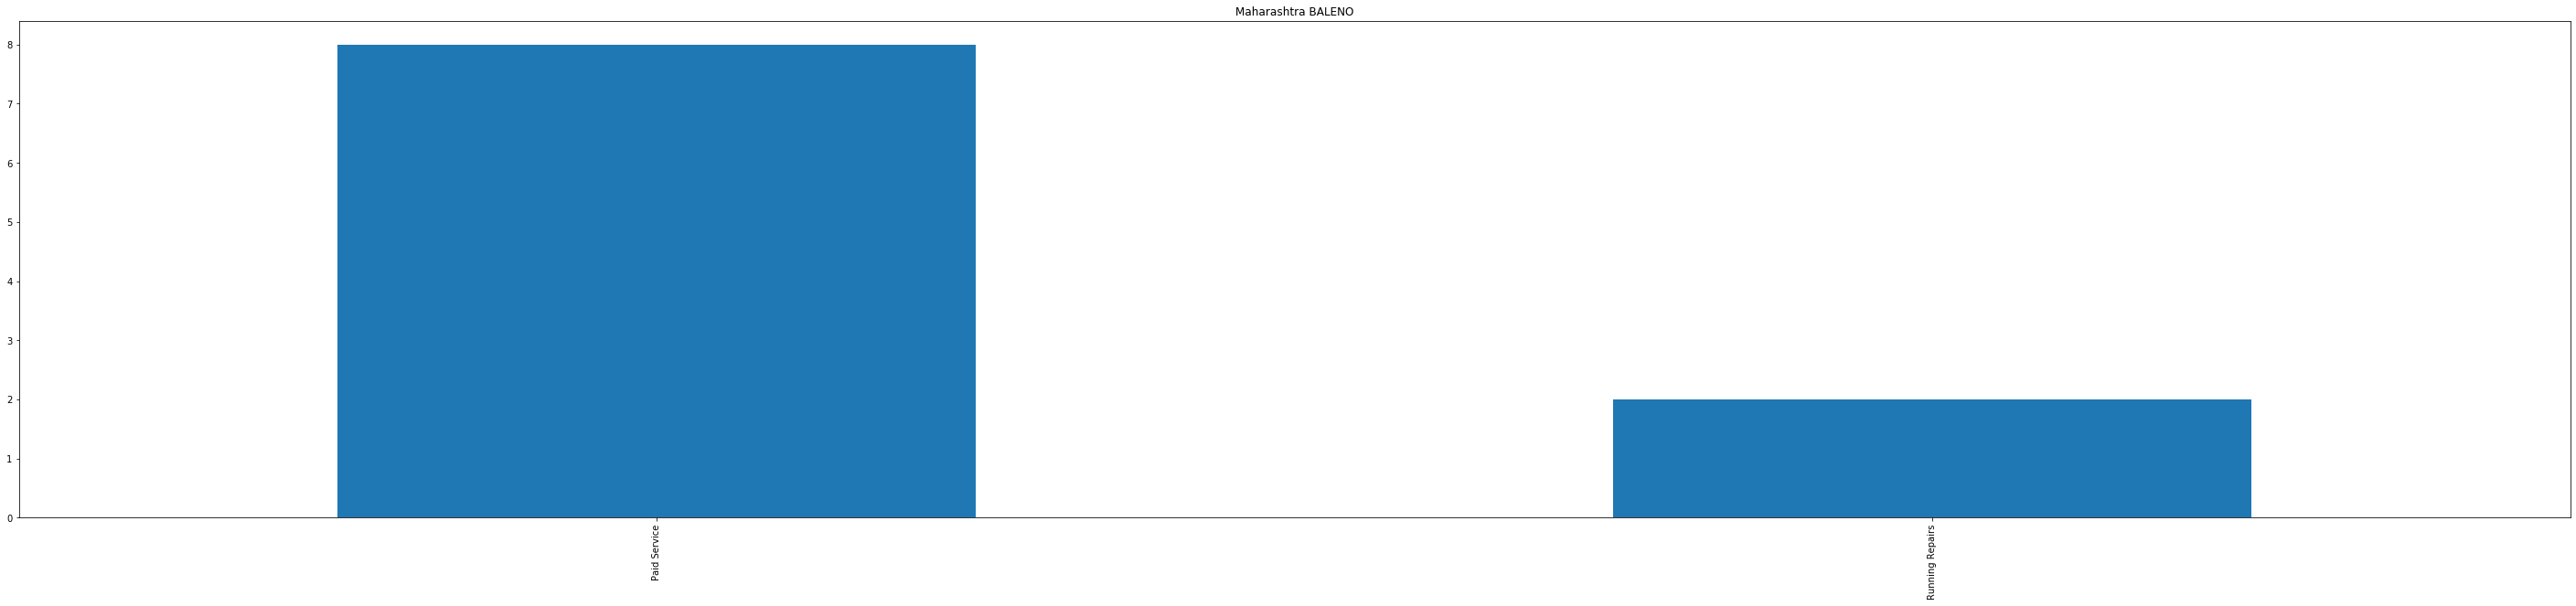

GYPSY 1300


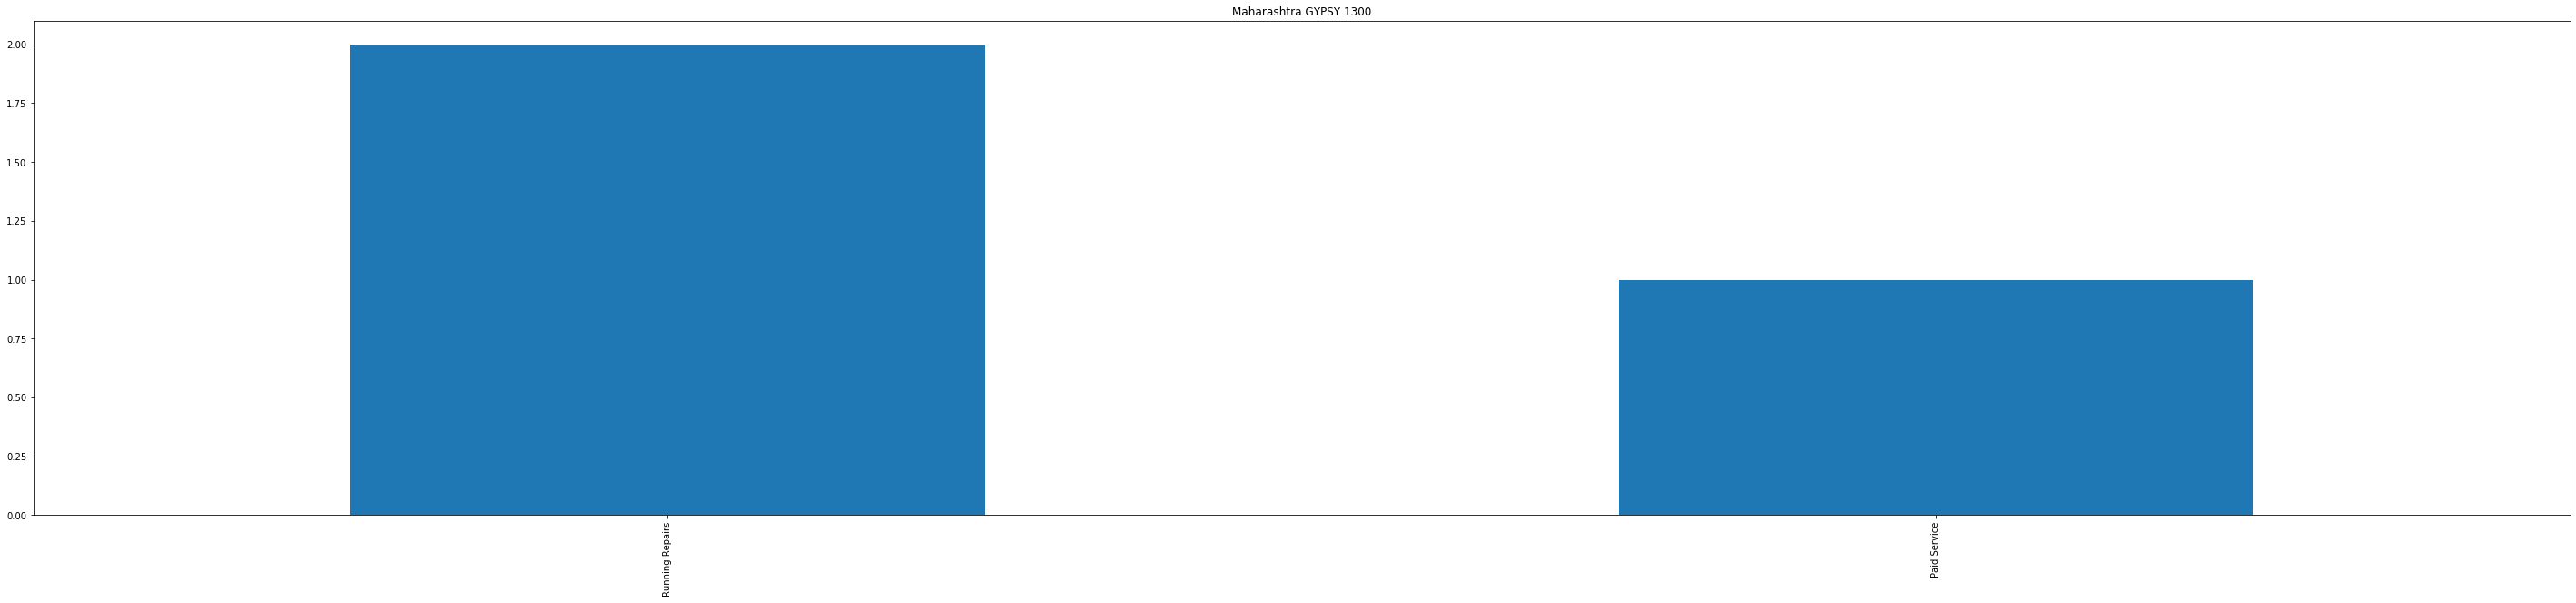

SUMO


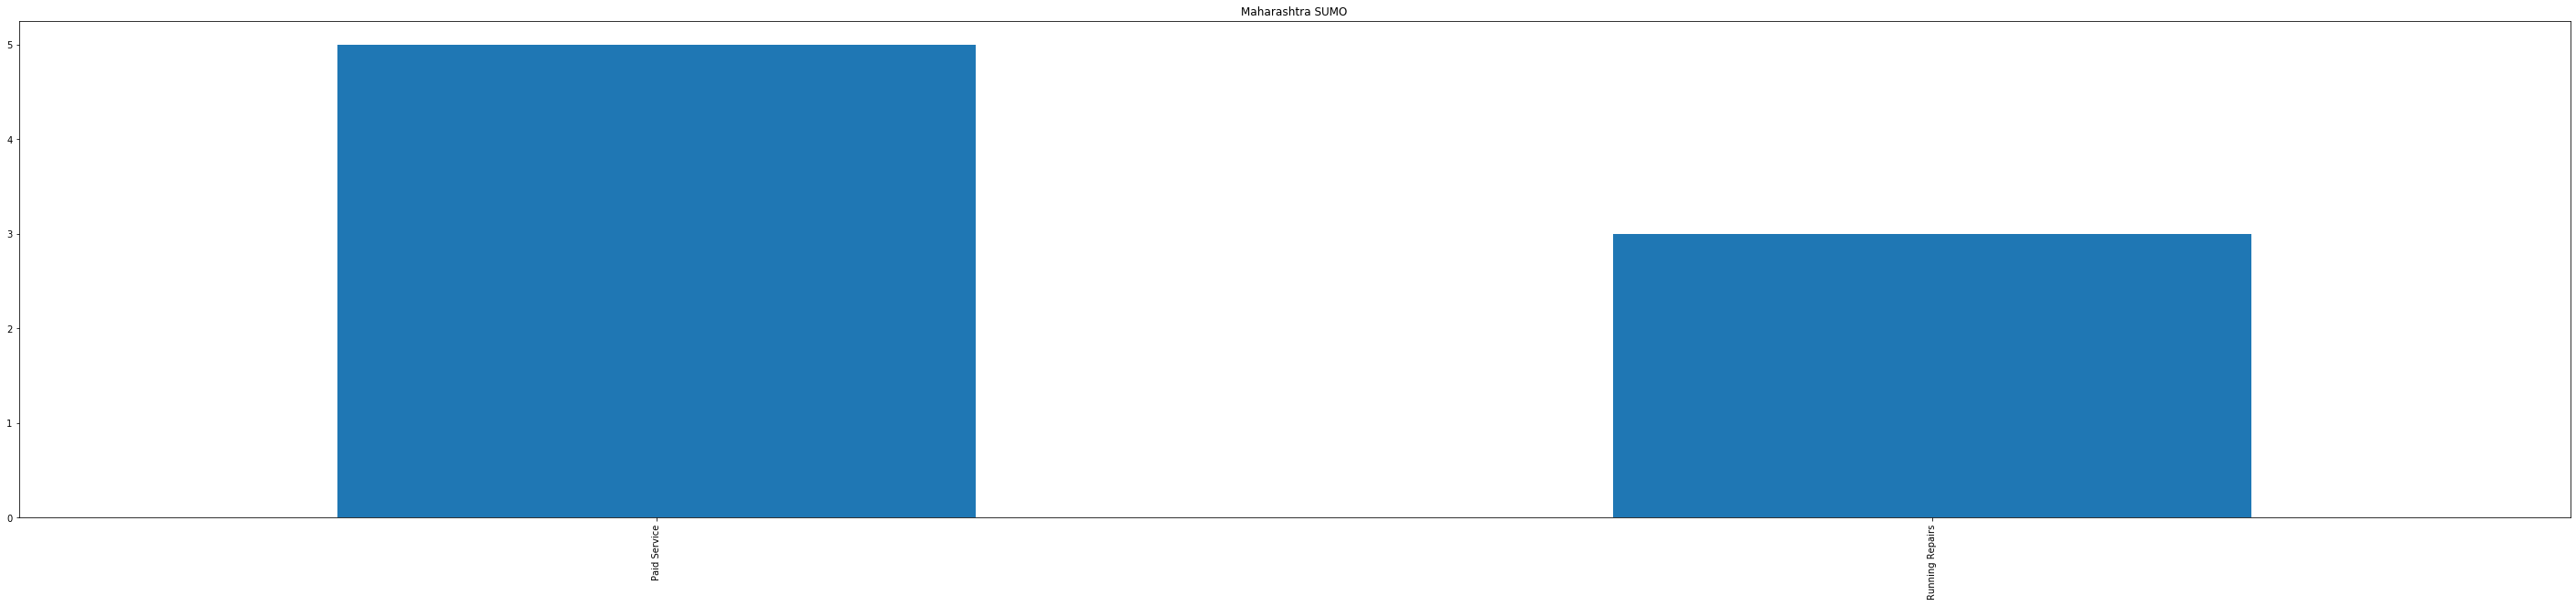

I20


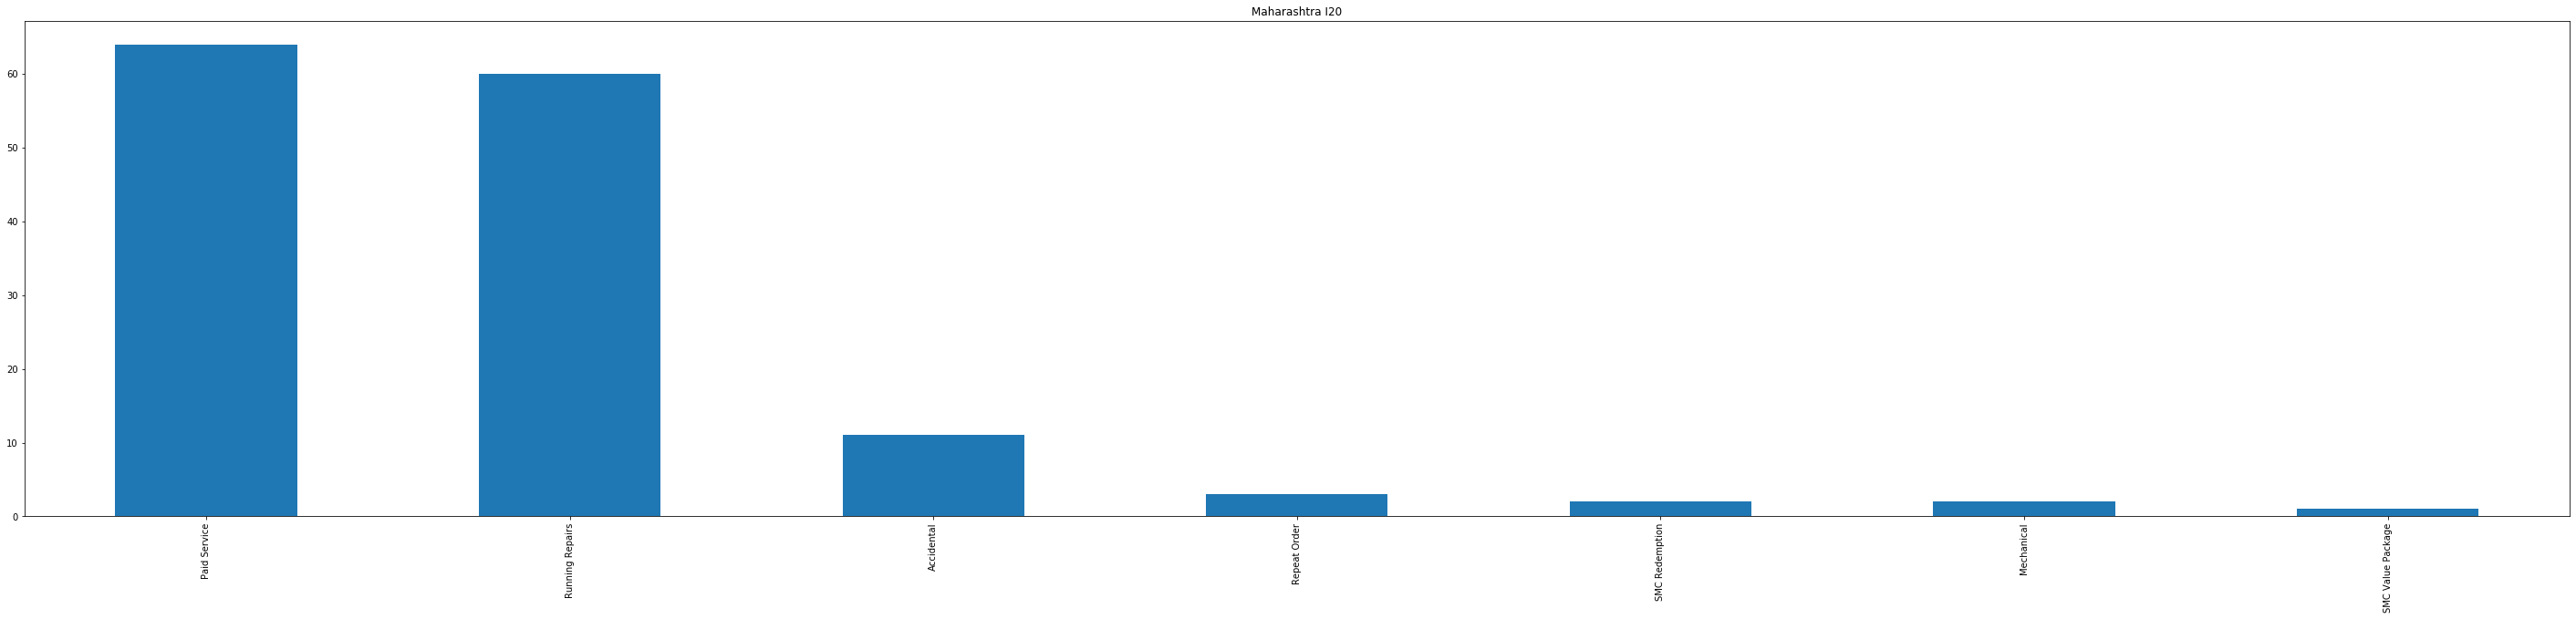

IKON


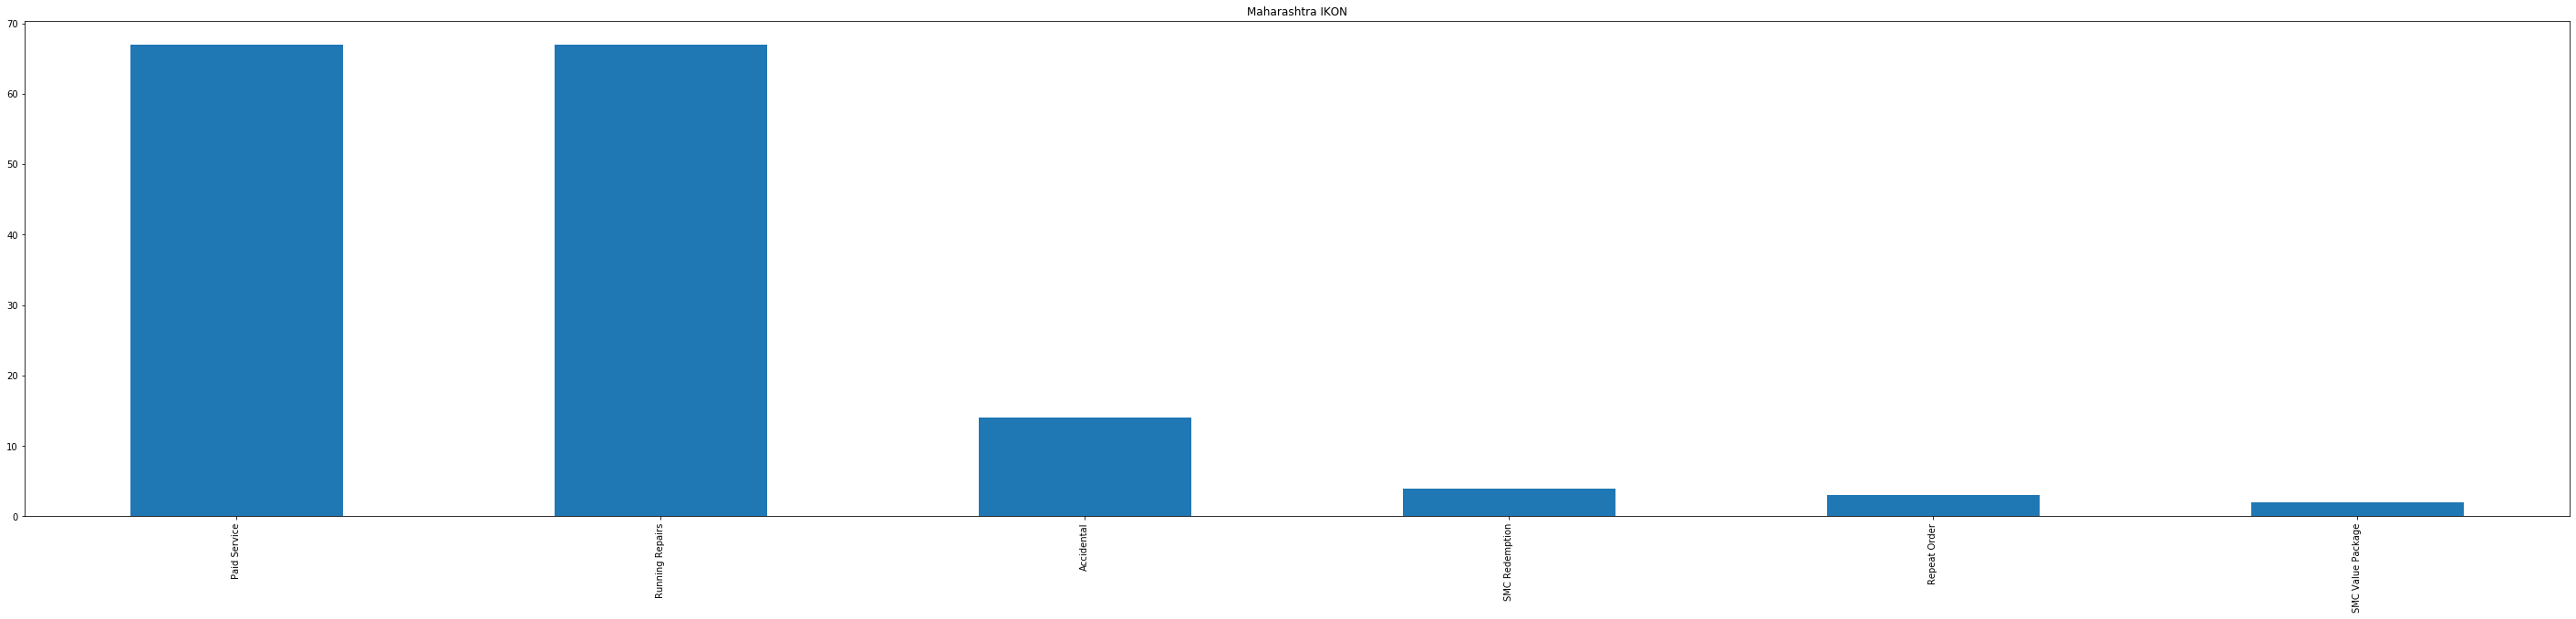

ACCORD


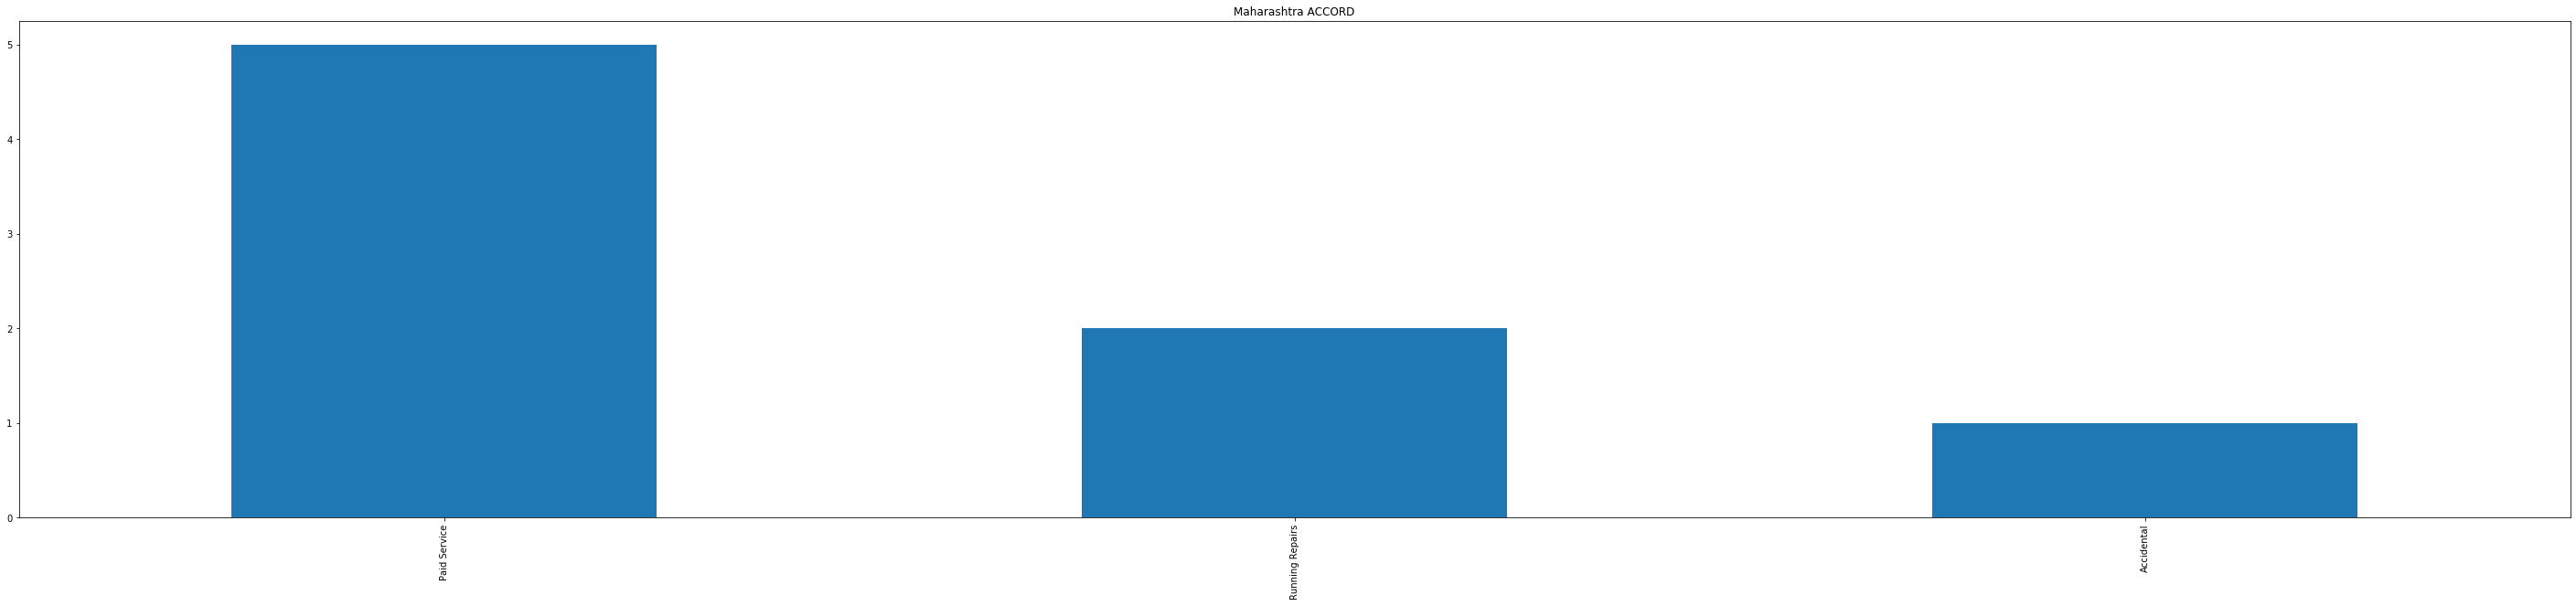

C-CLASS


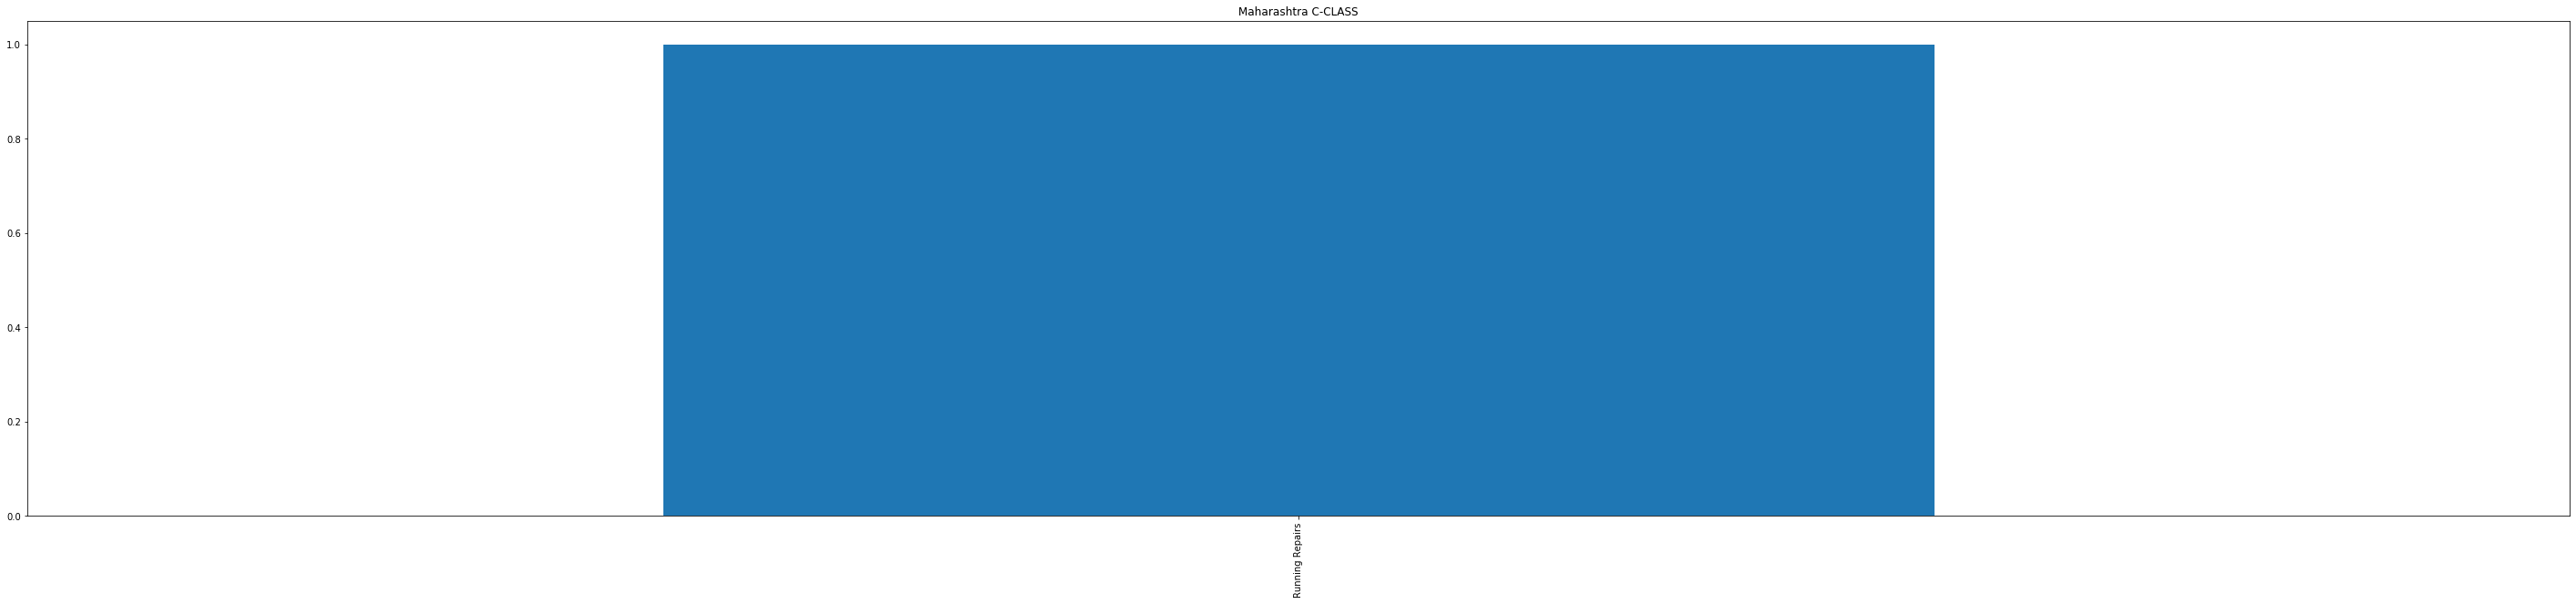

I10


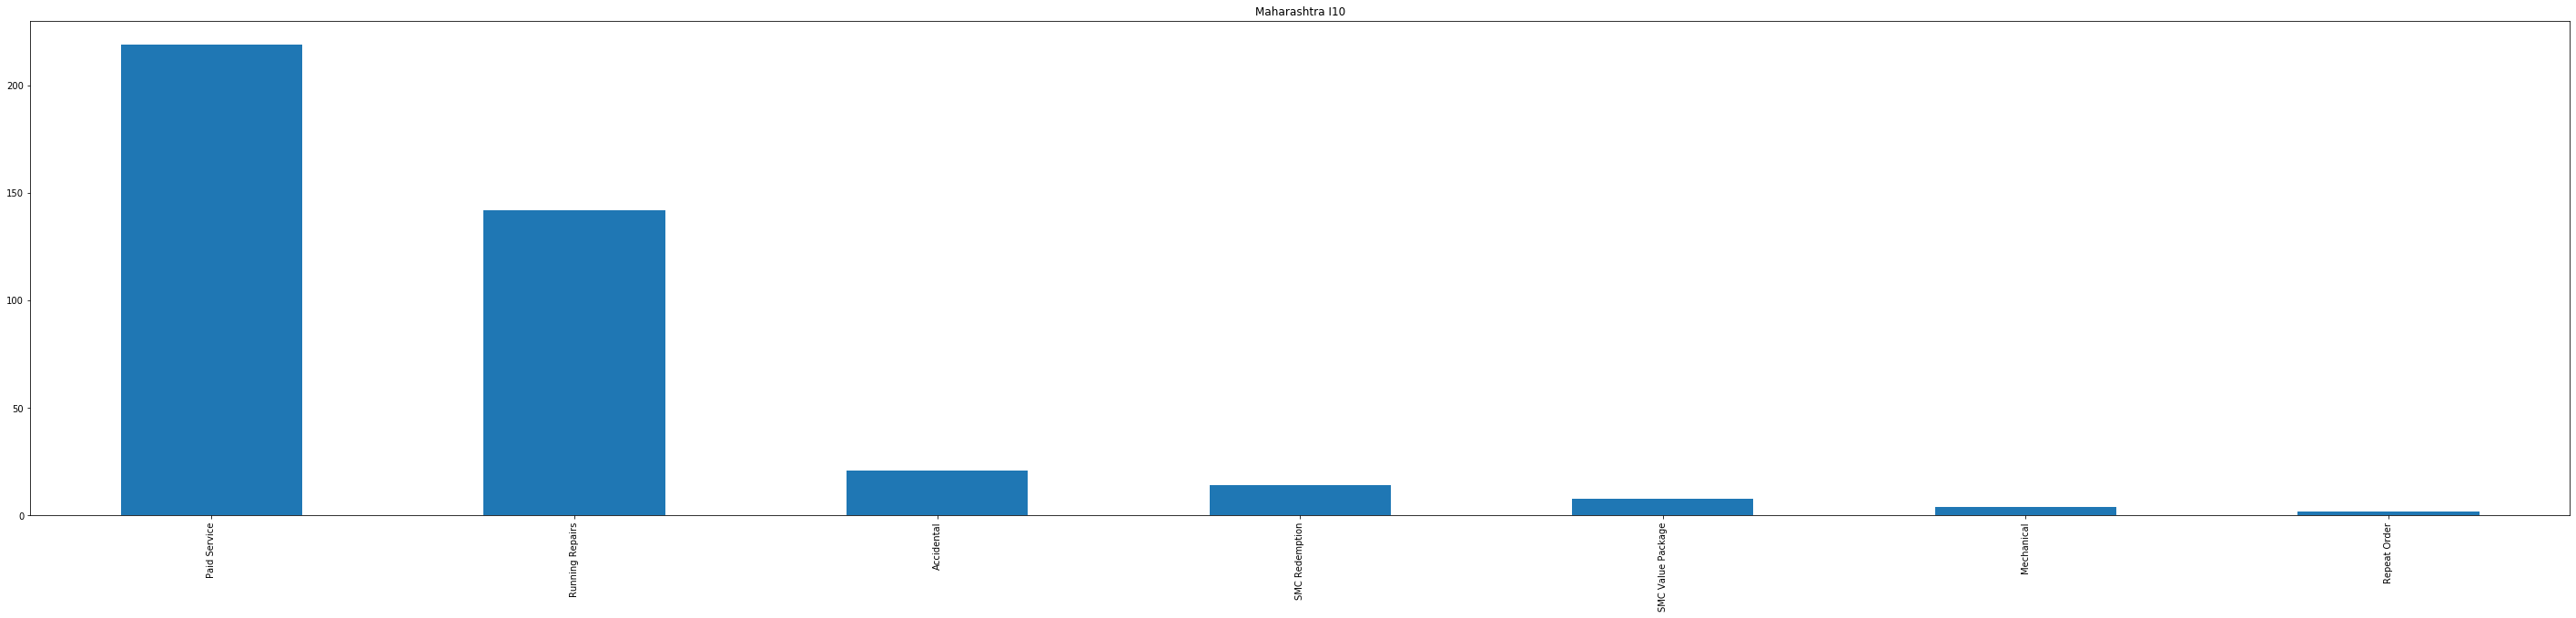

OPTRA


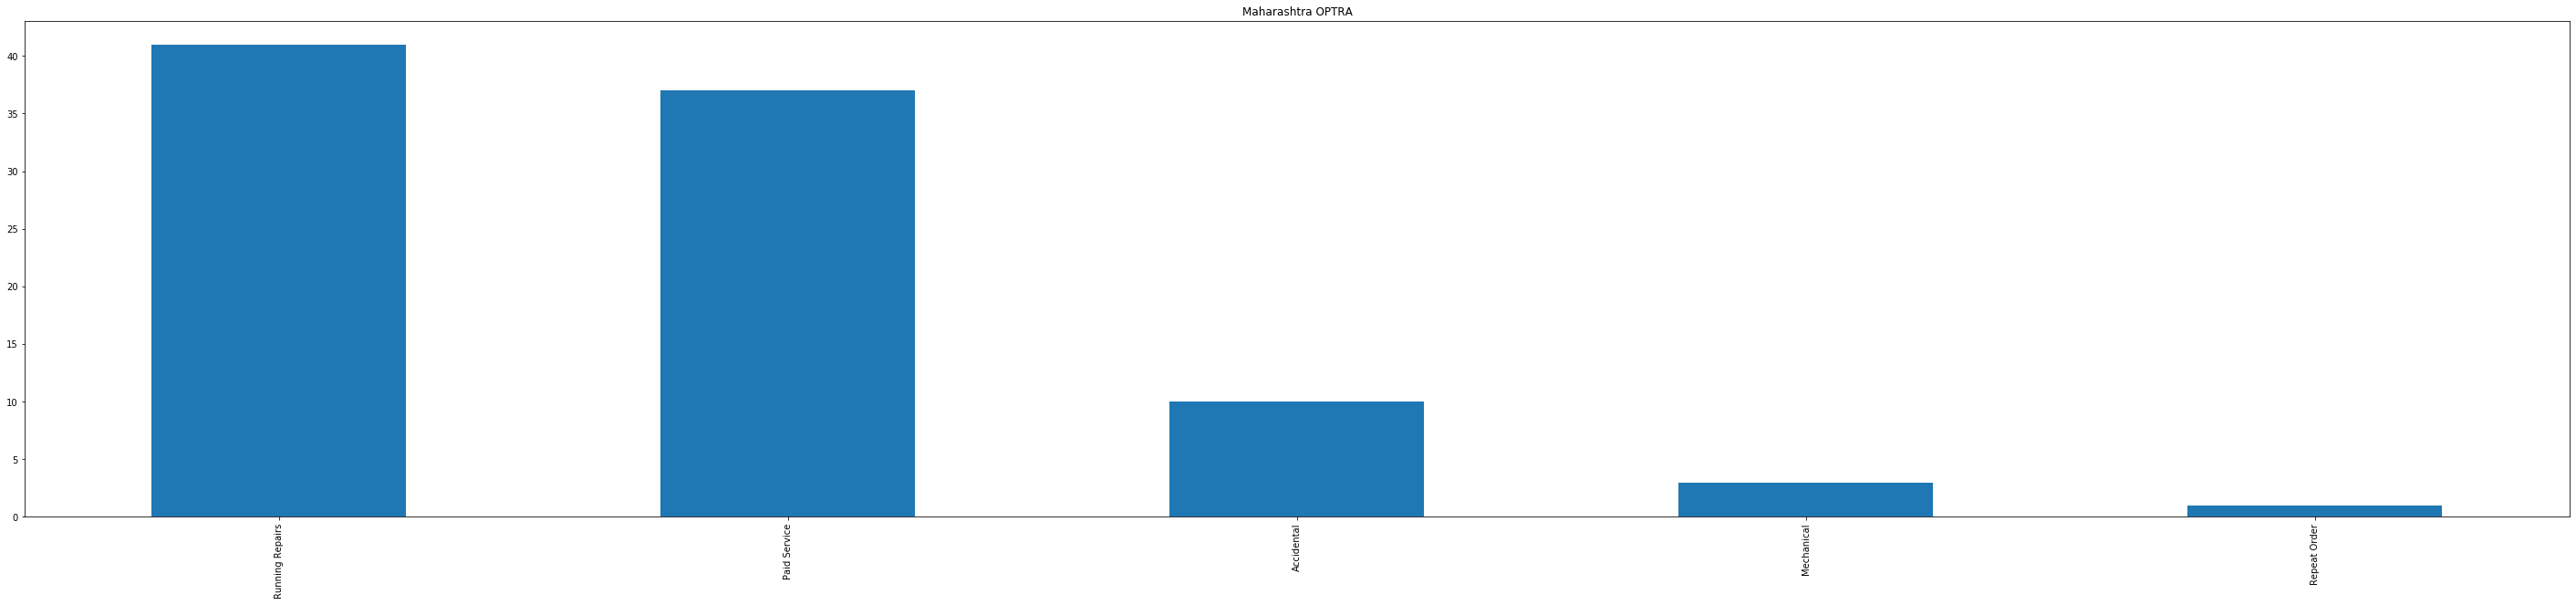

LANCER


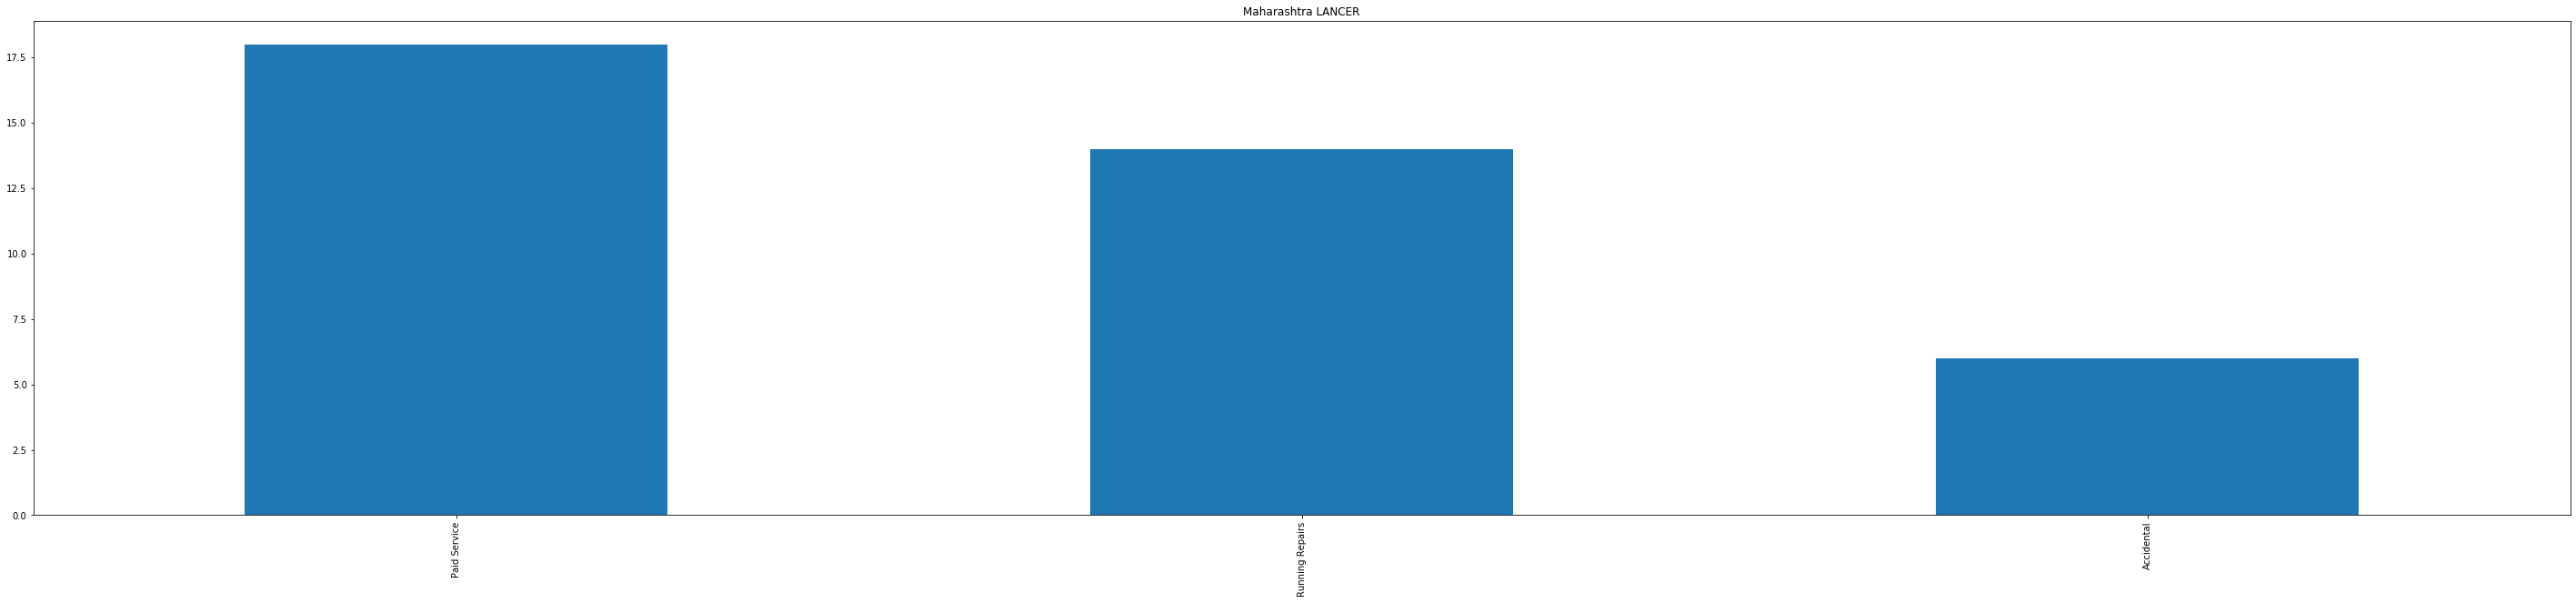

SPARK


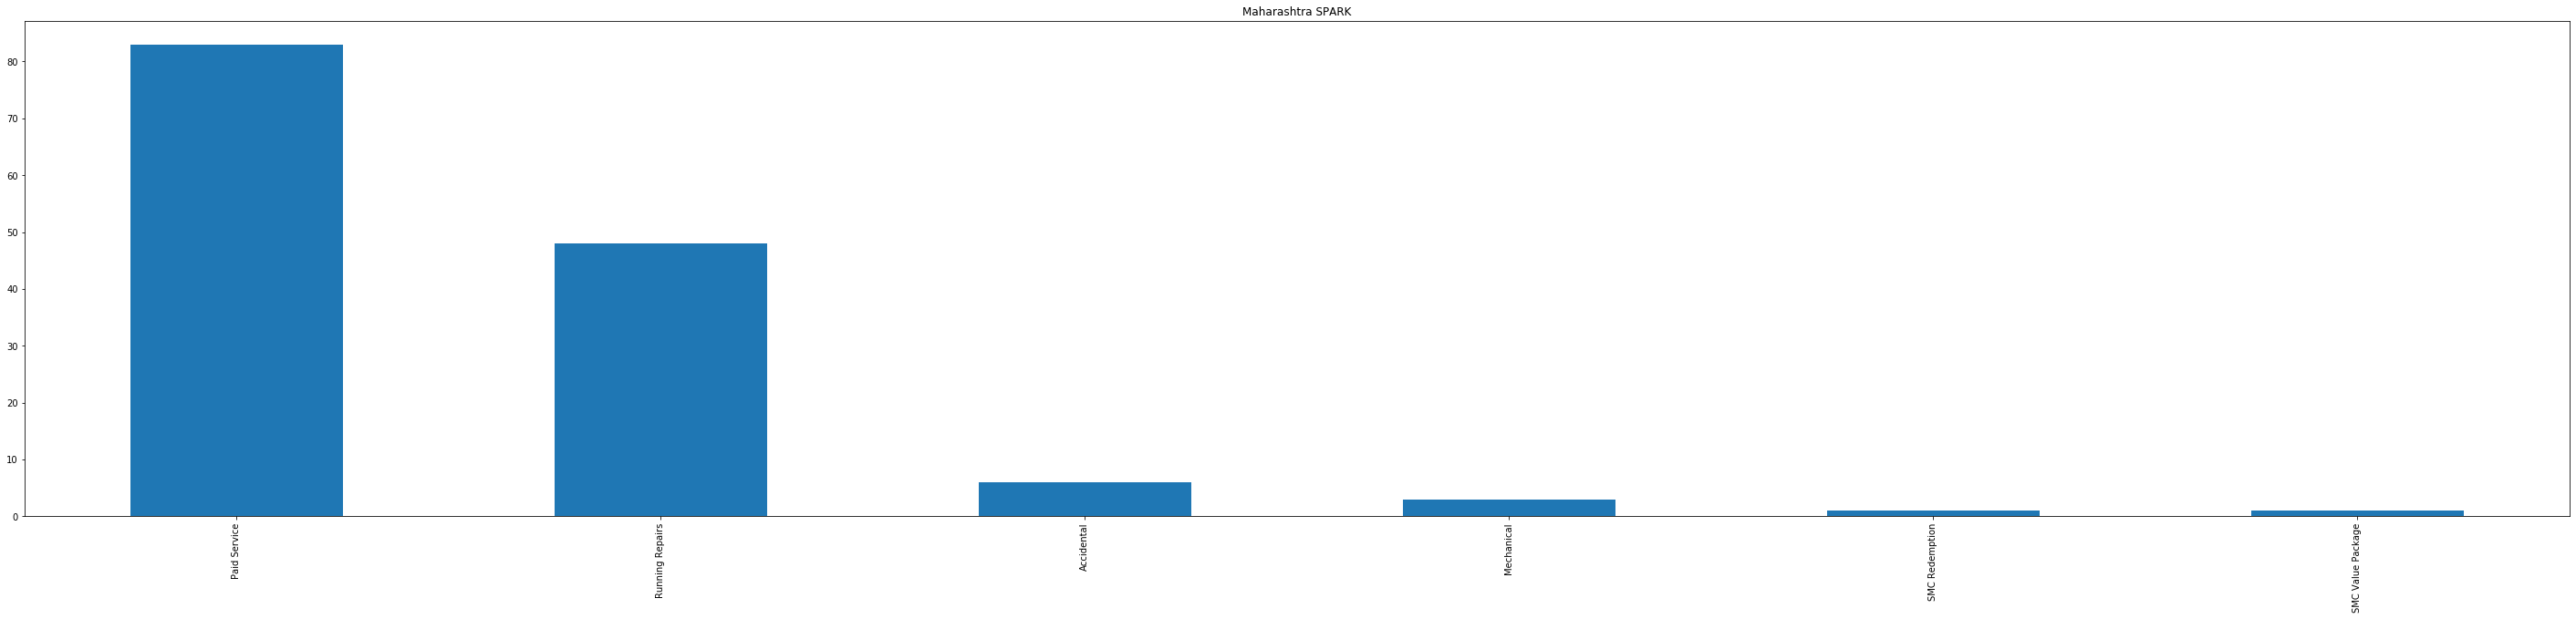

SAFARI


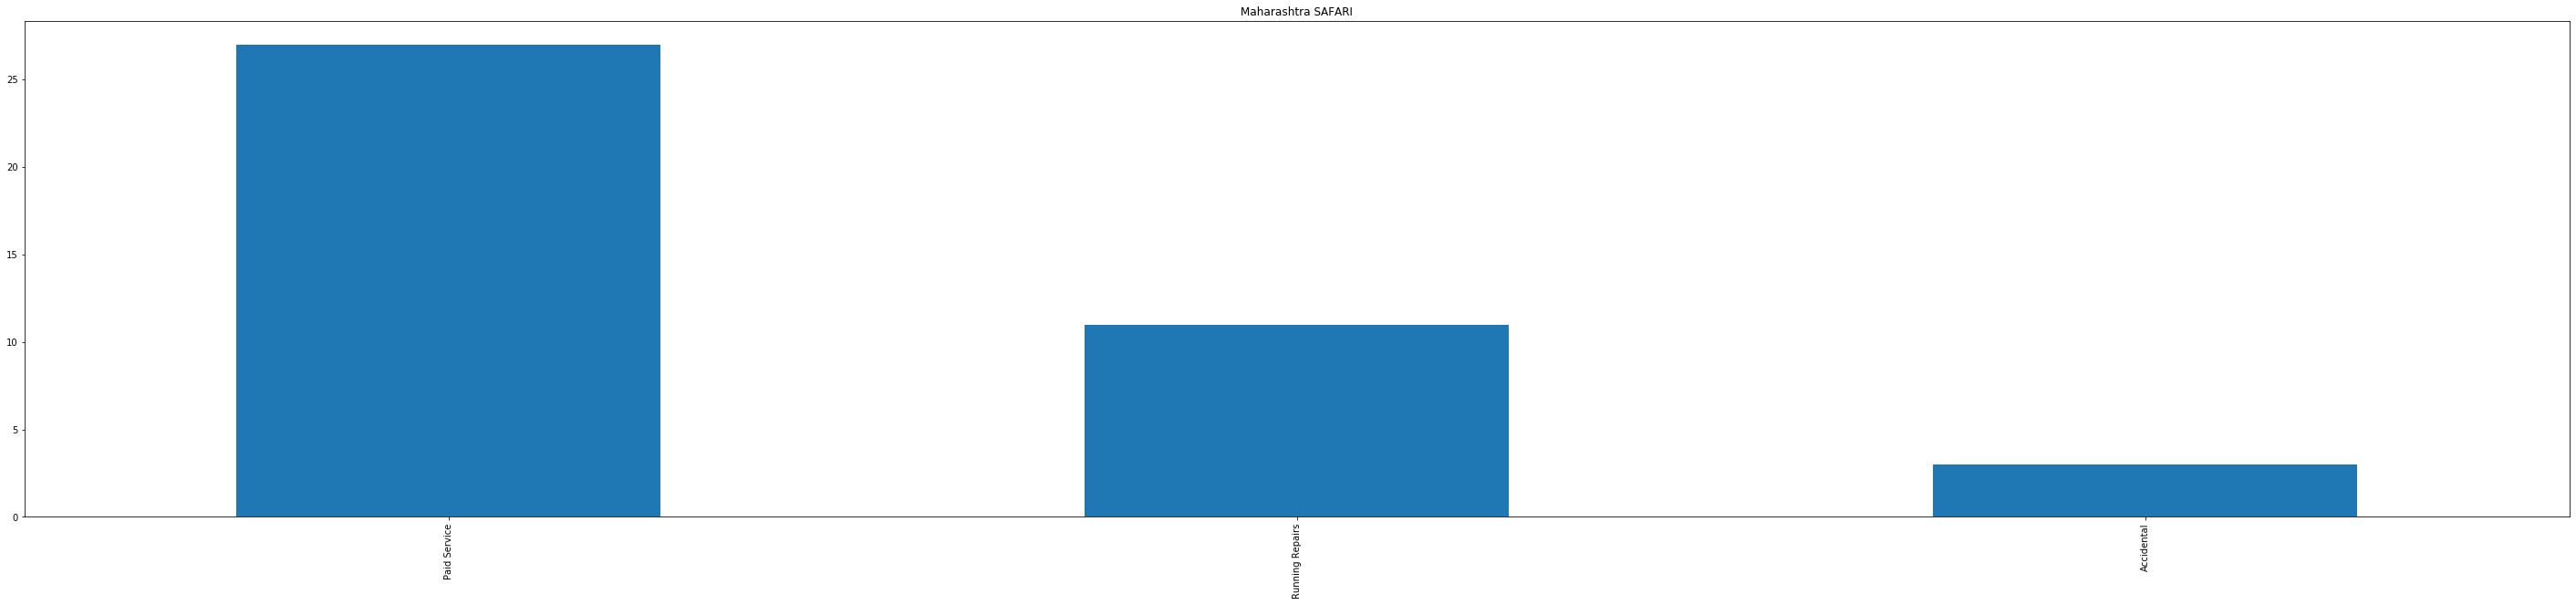

SAIL


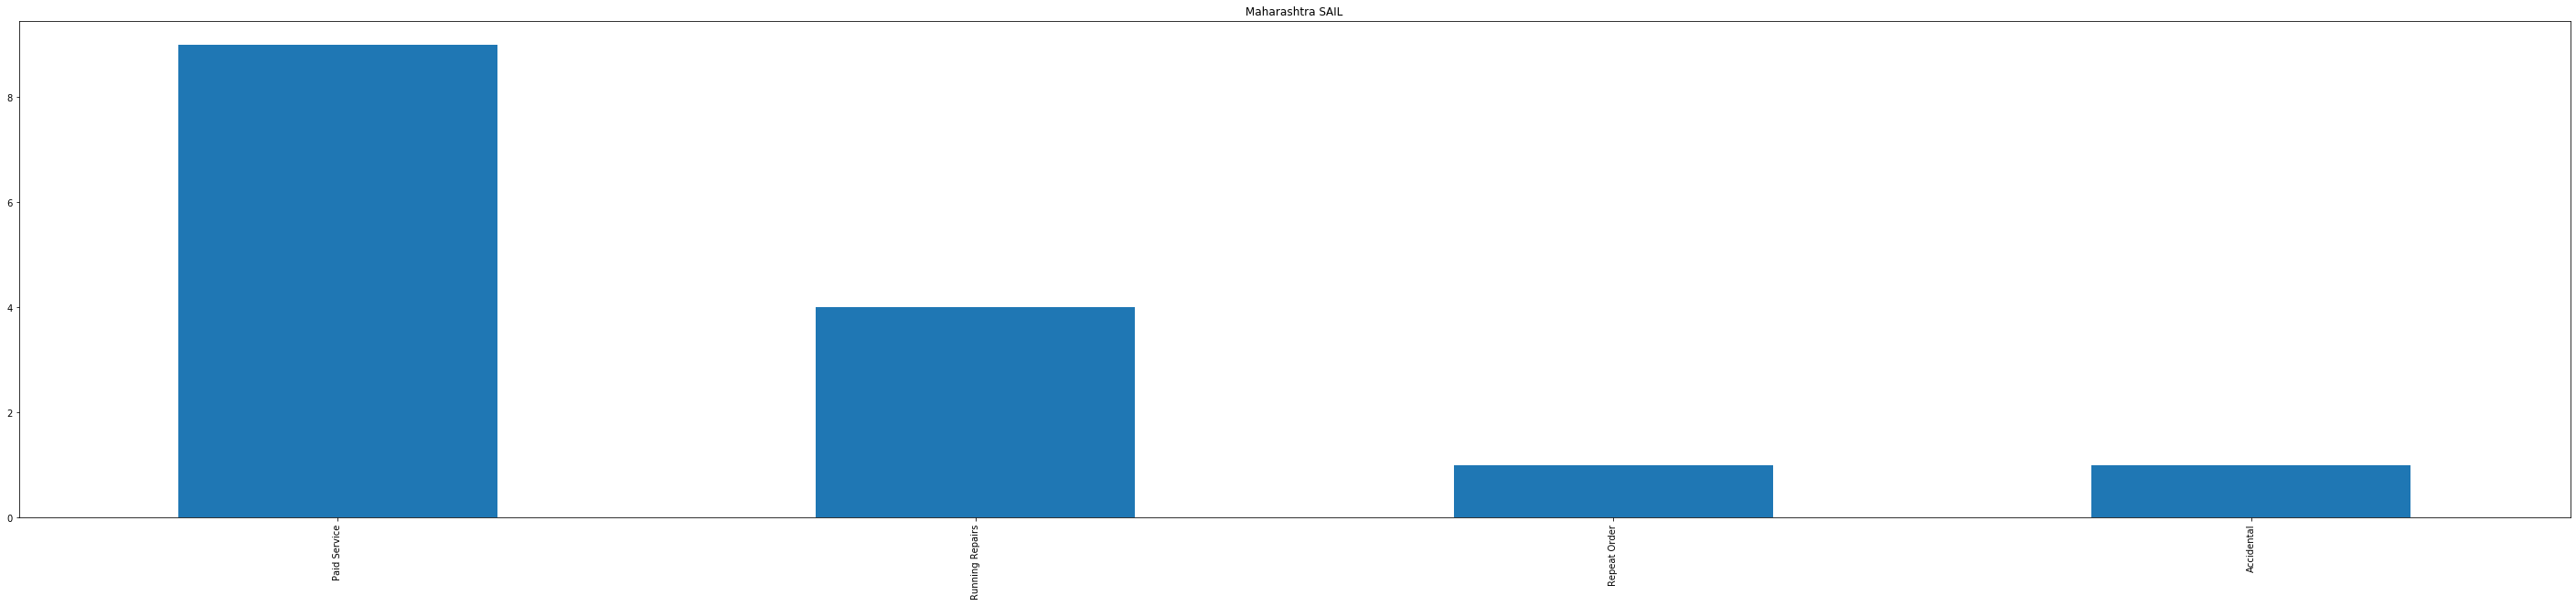

MATIZ


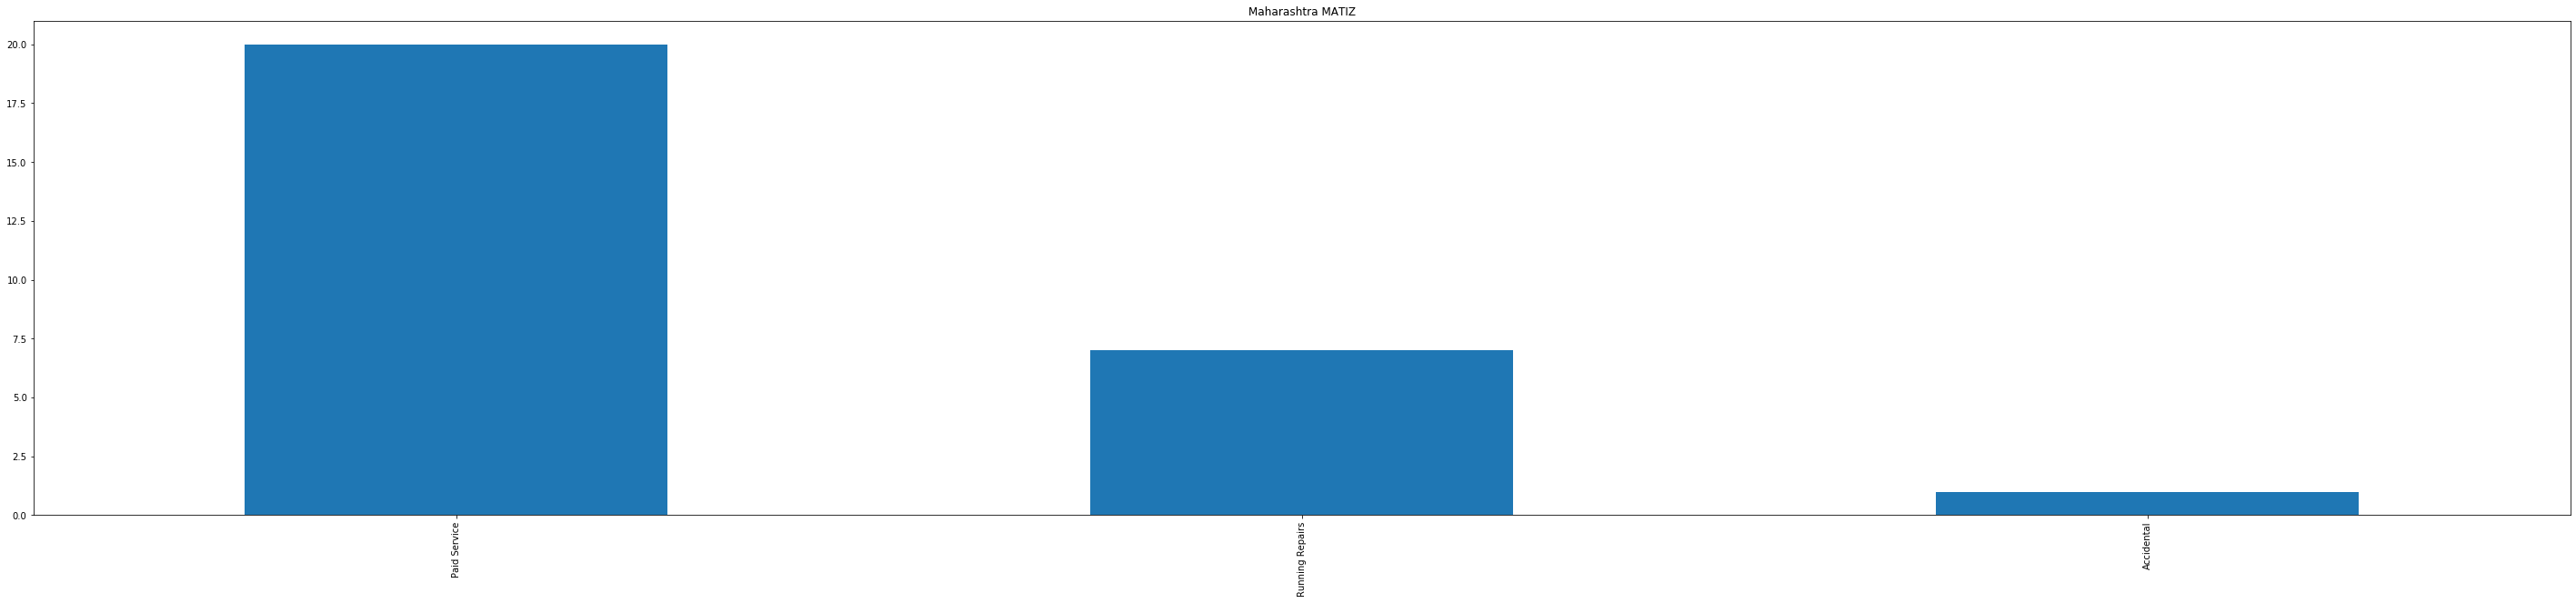

ZEN


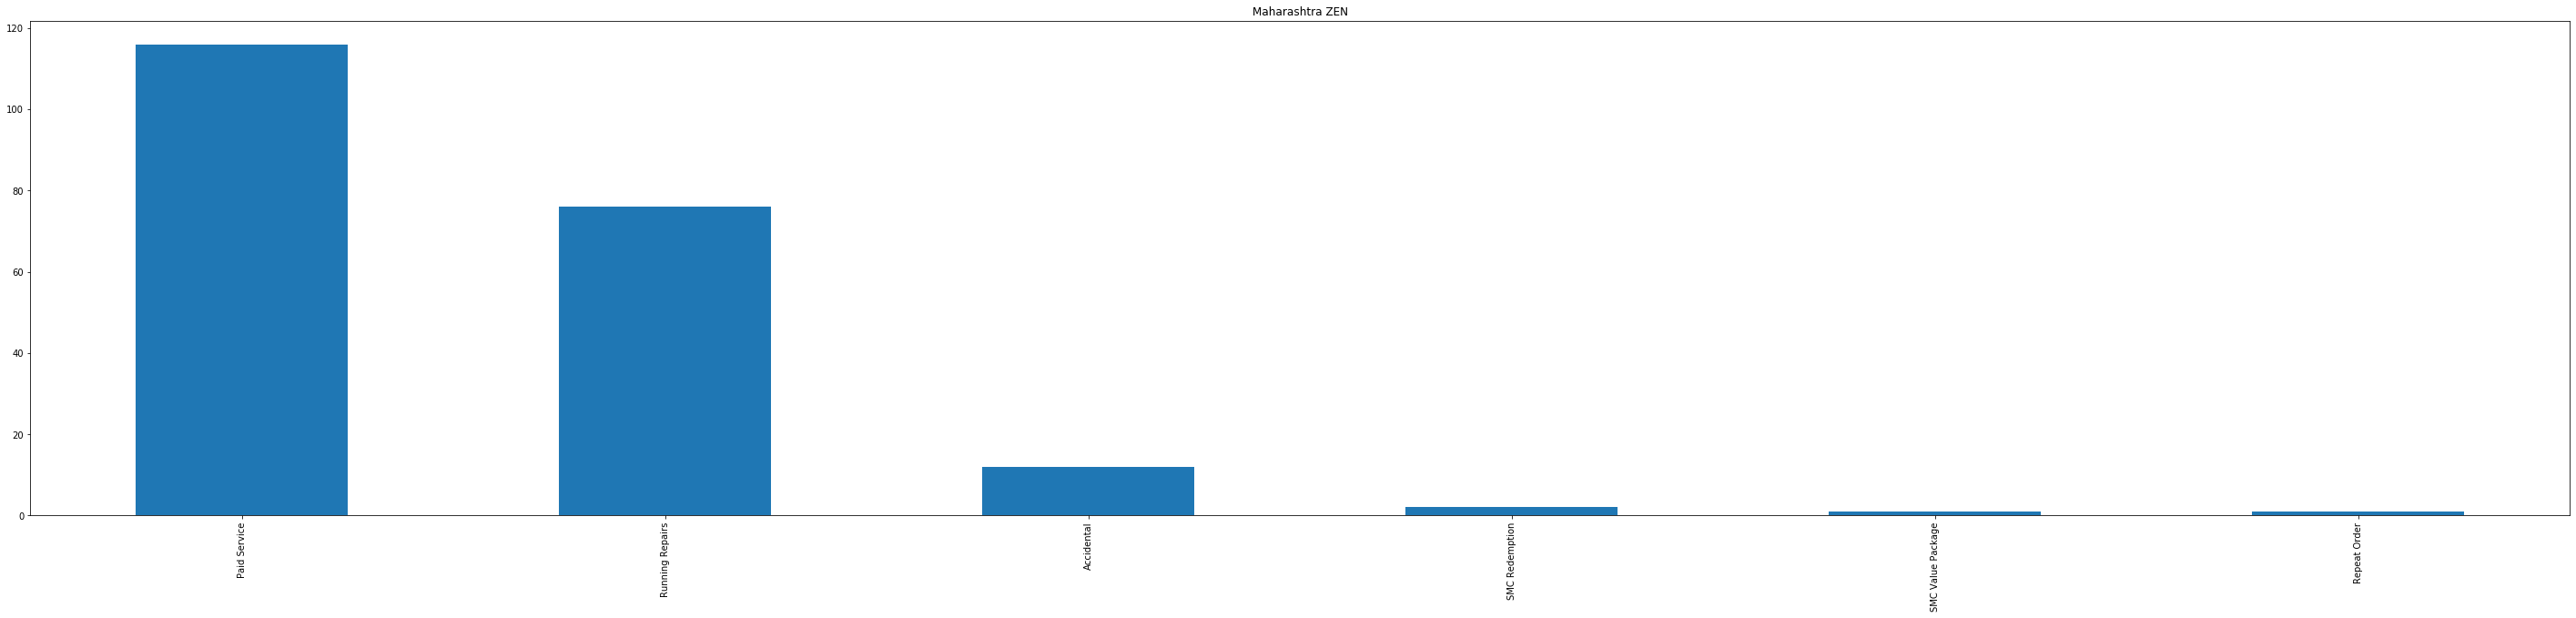

OCTAVIA


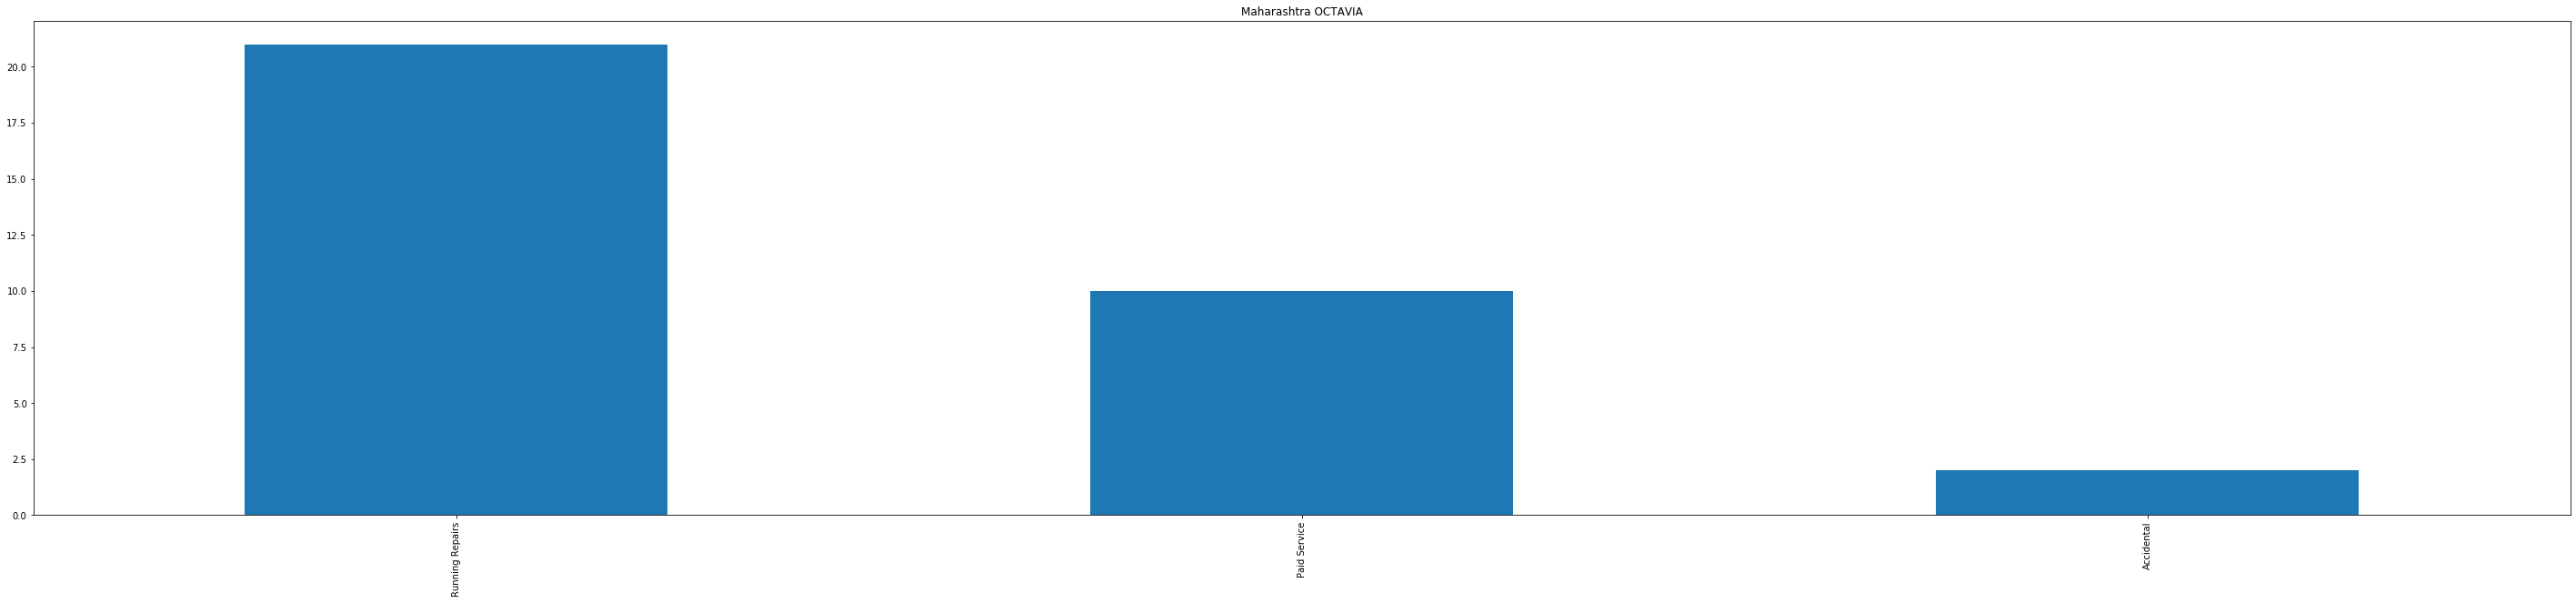

RENAULT 1.9


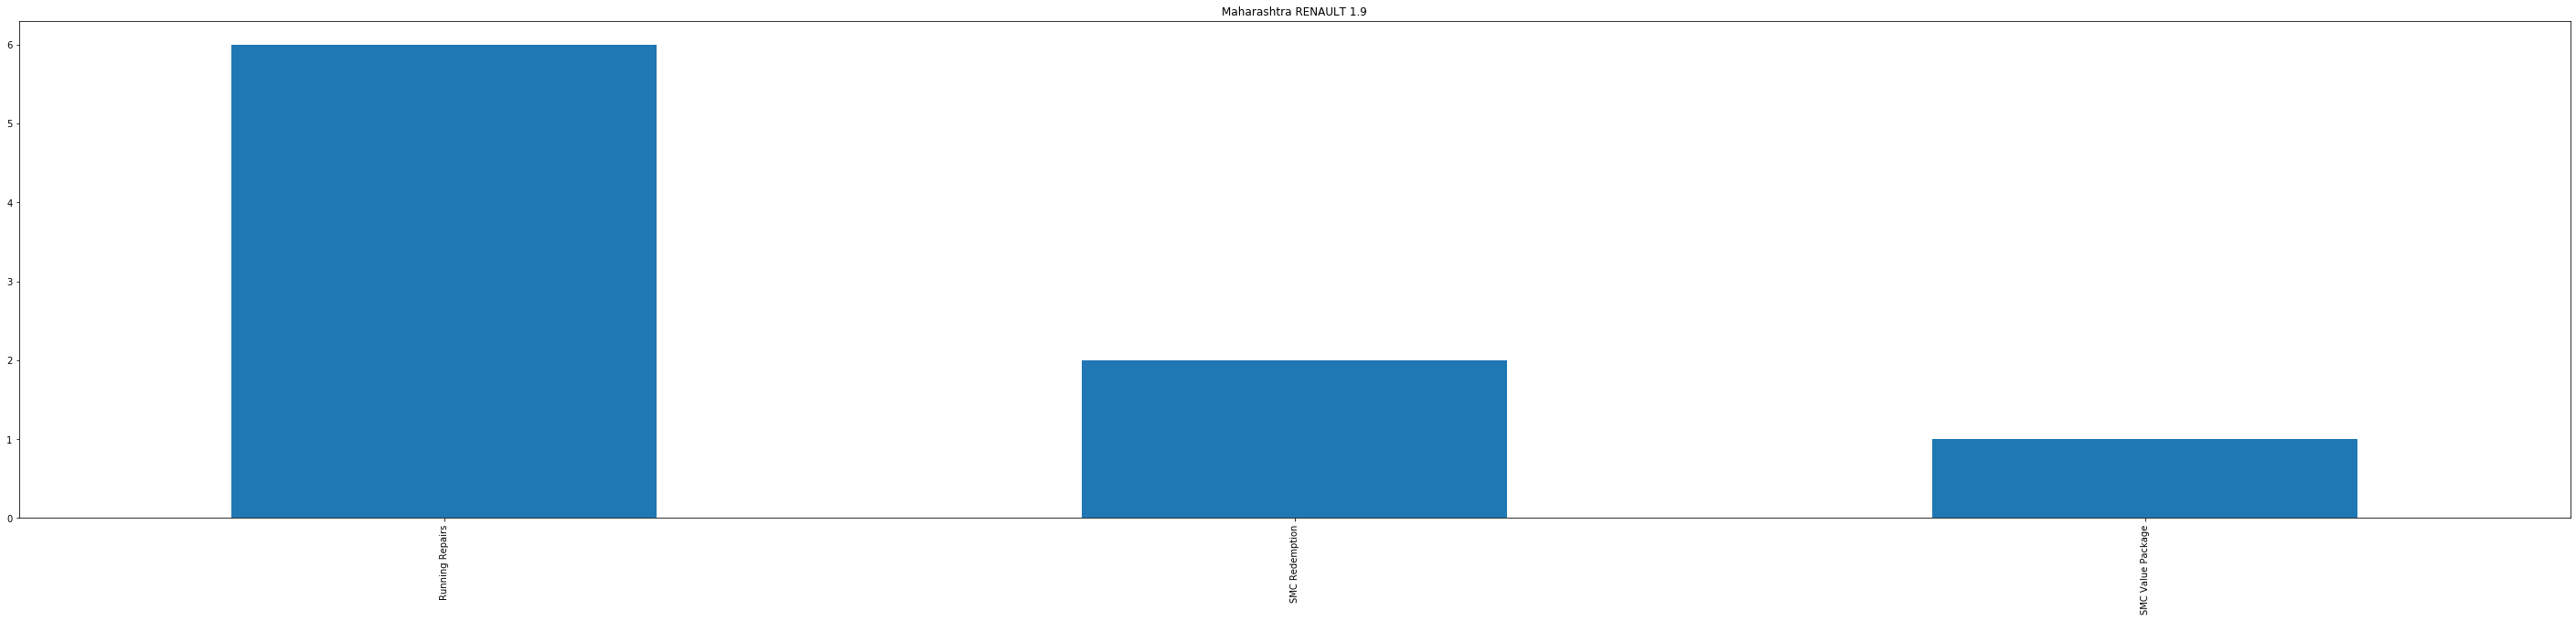

SUPERB


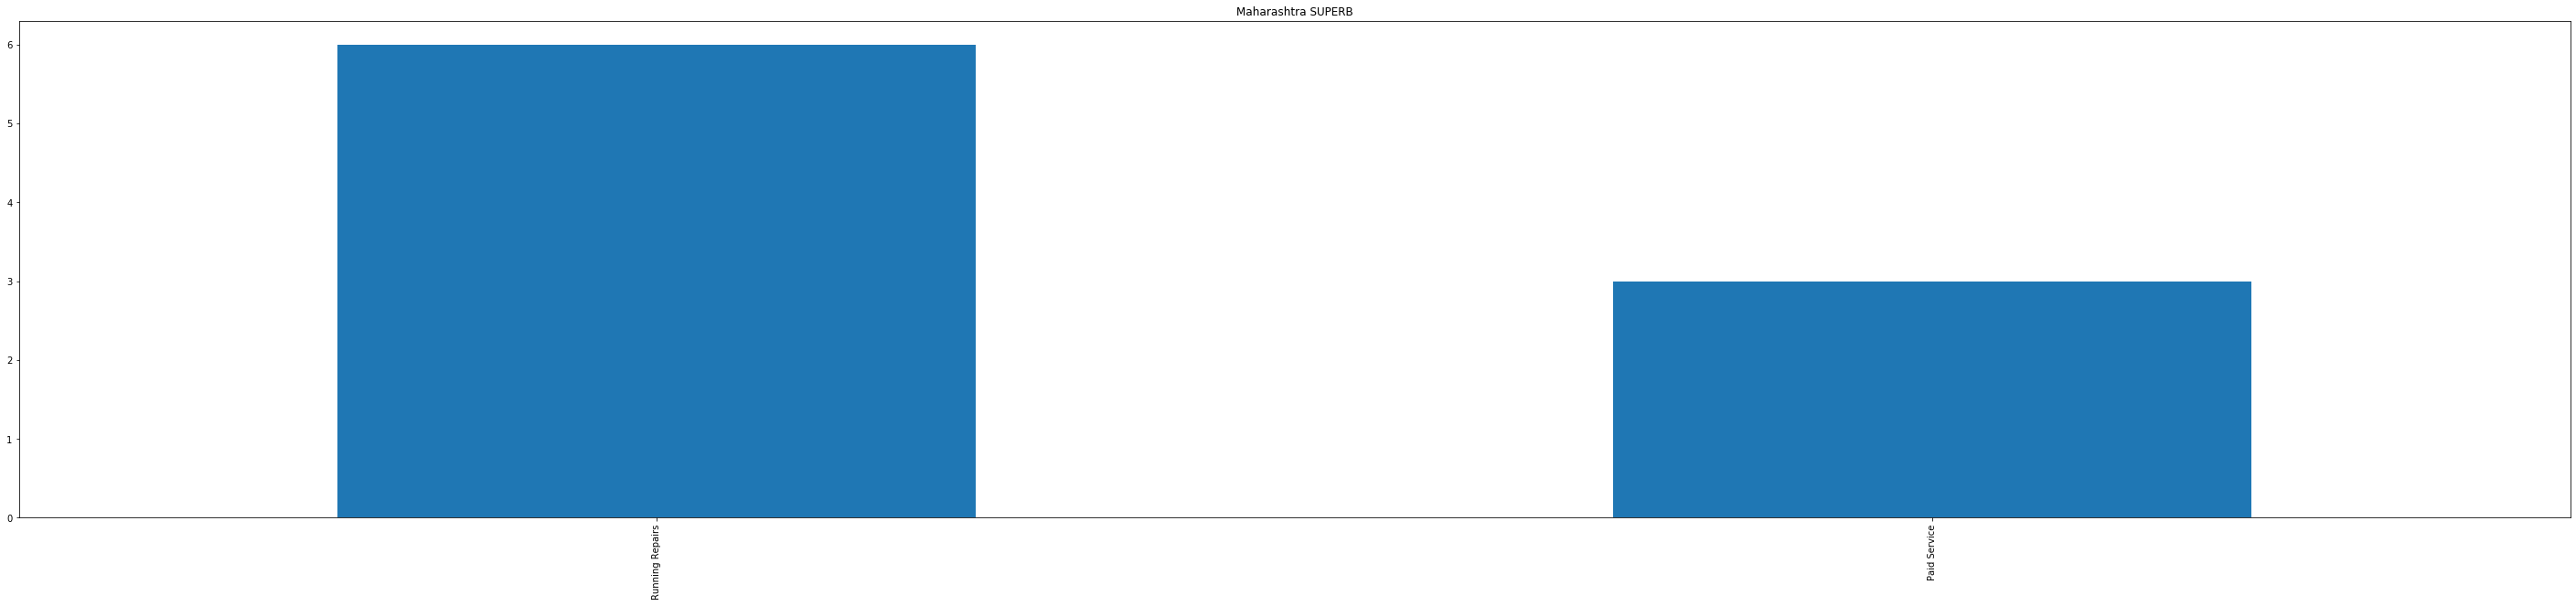

MAHINDRA PIK UP


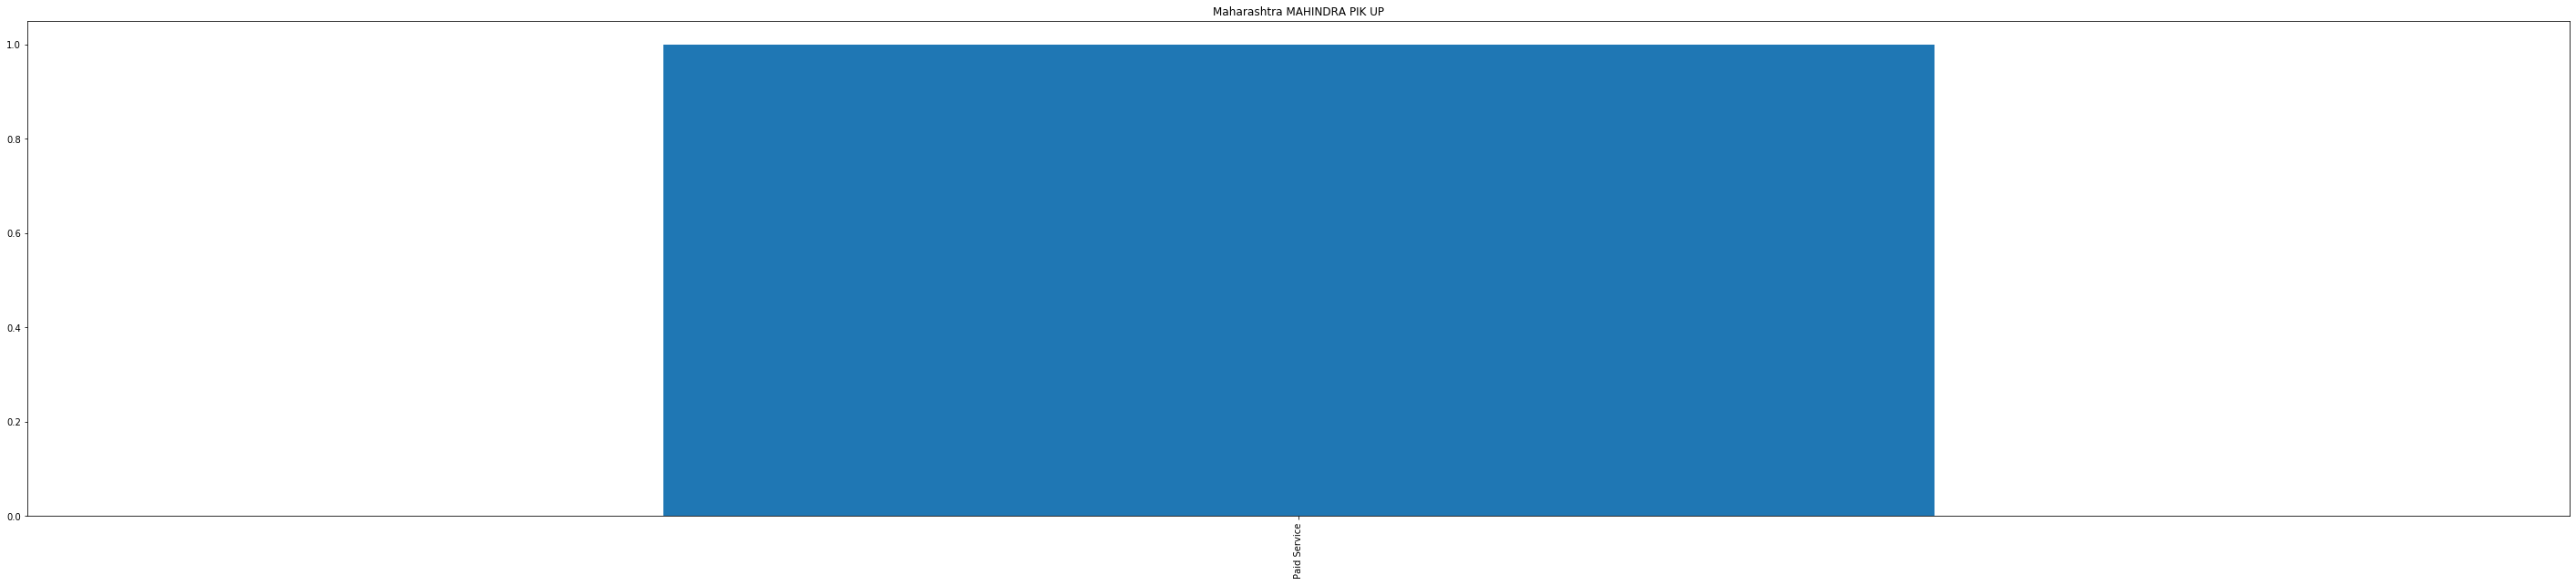

UNO


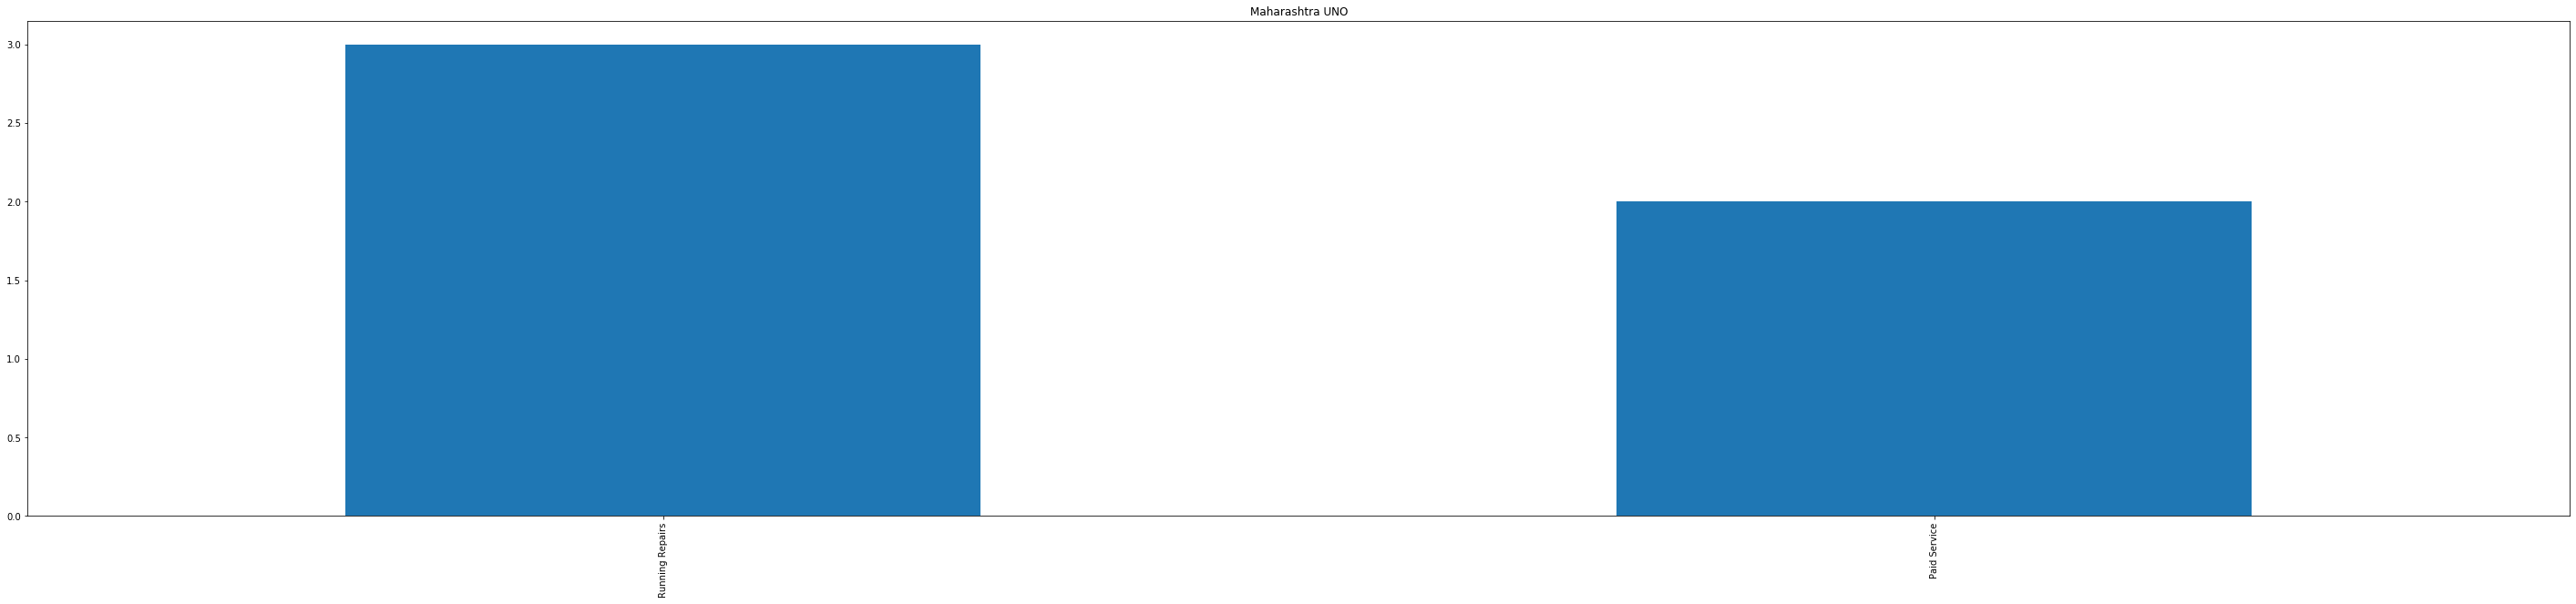

LINEA


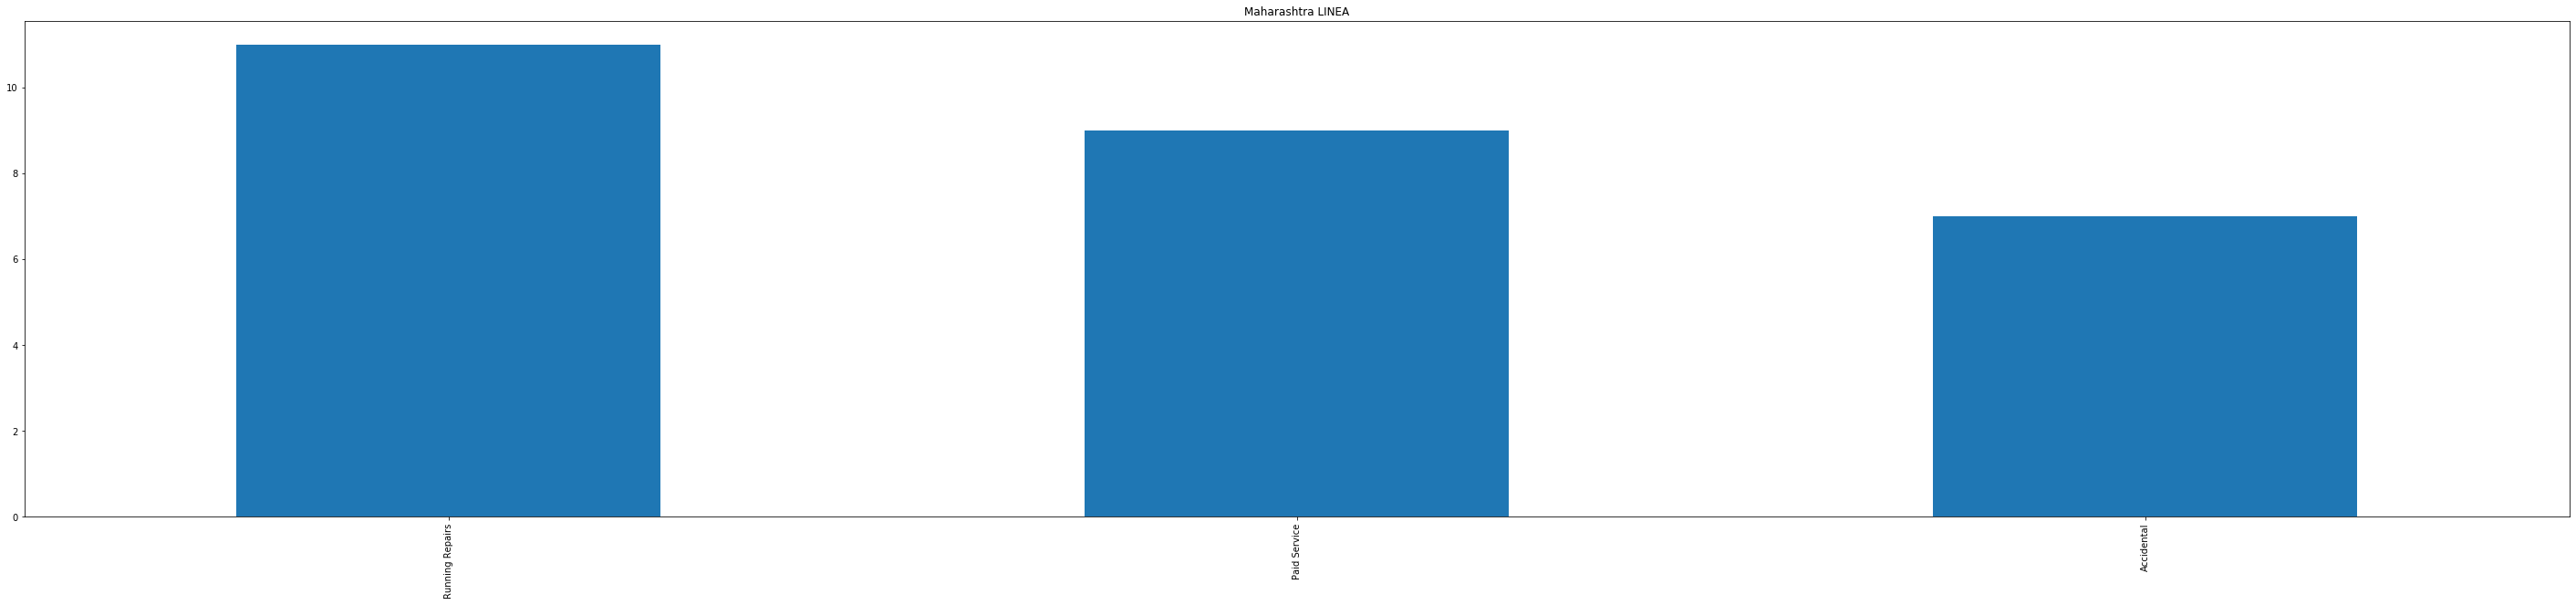

FIGO


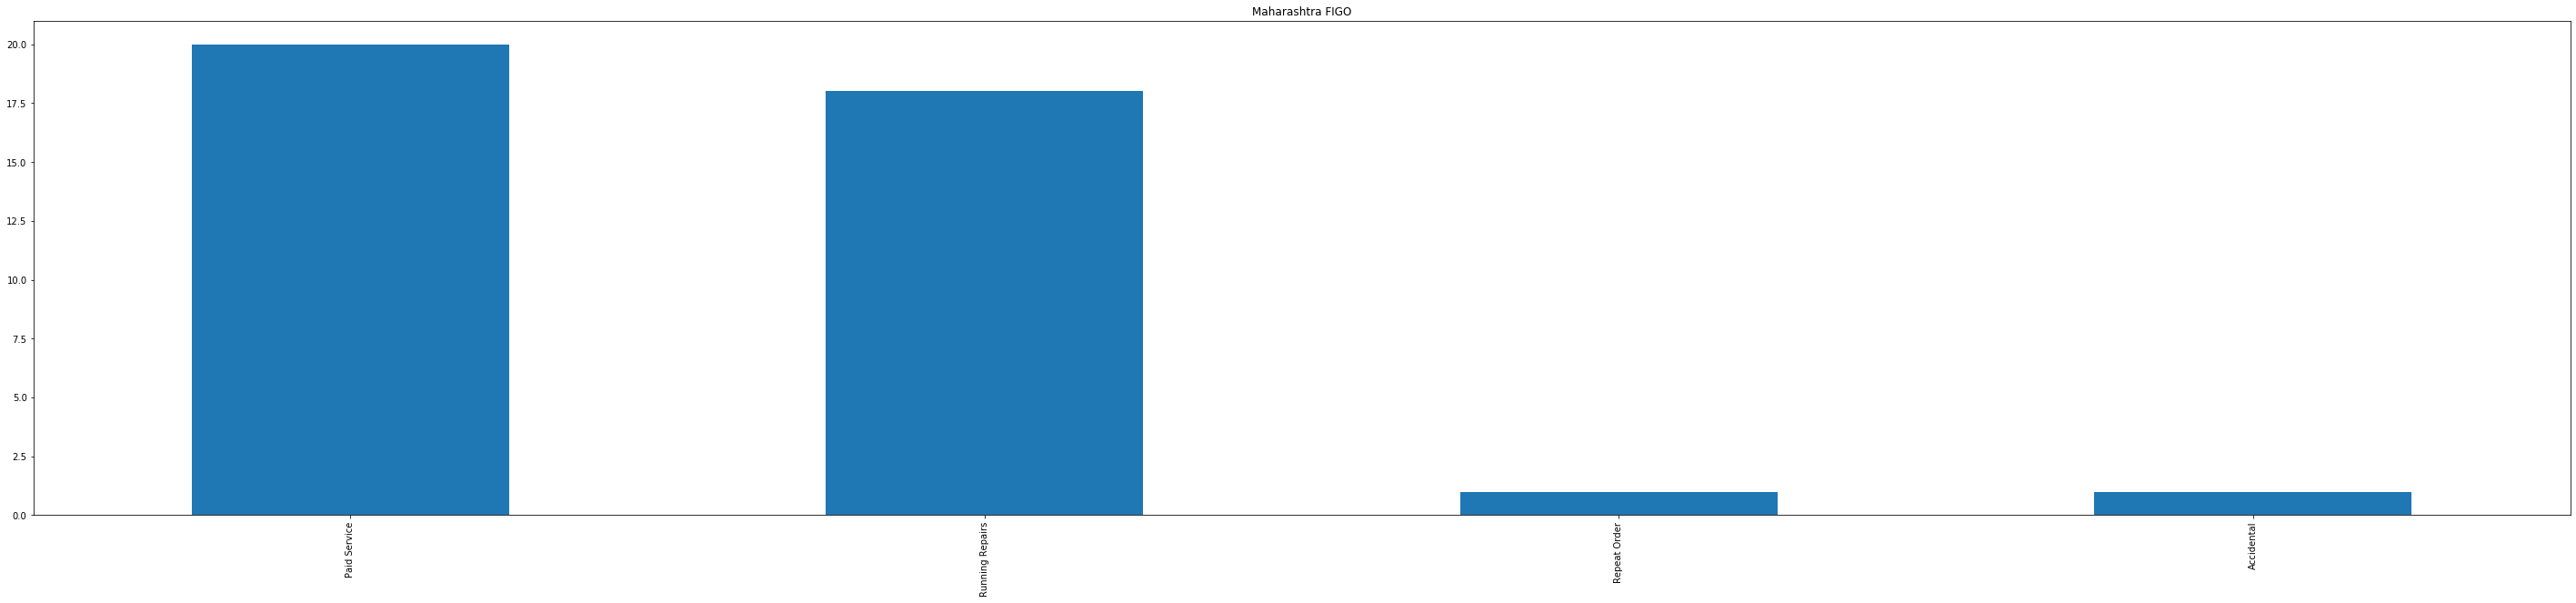

A STAR


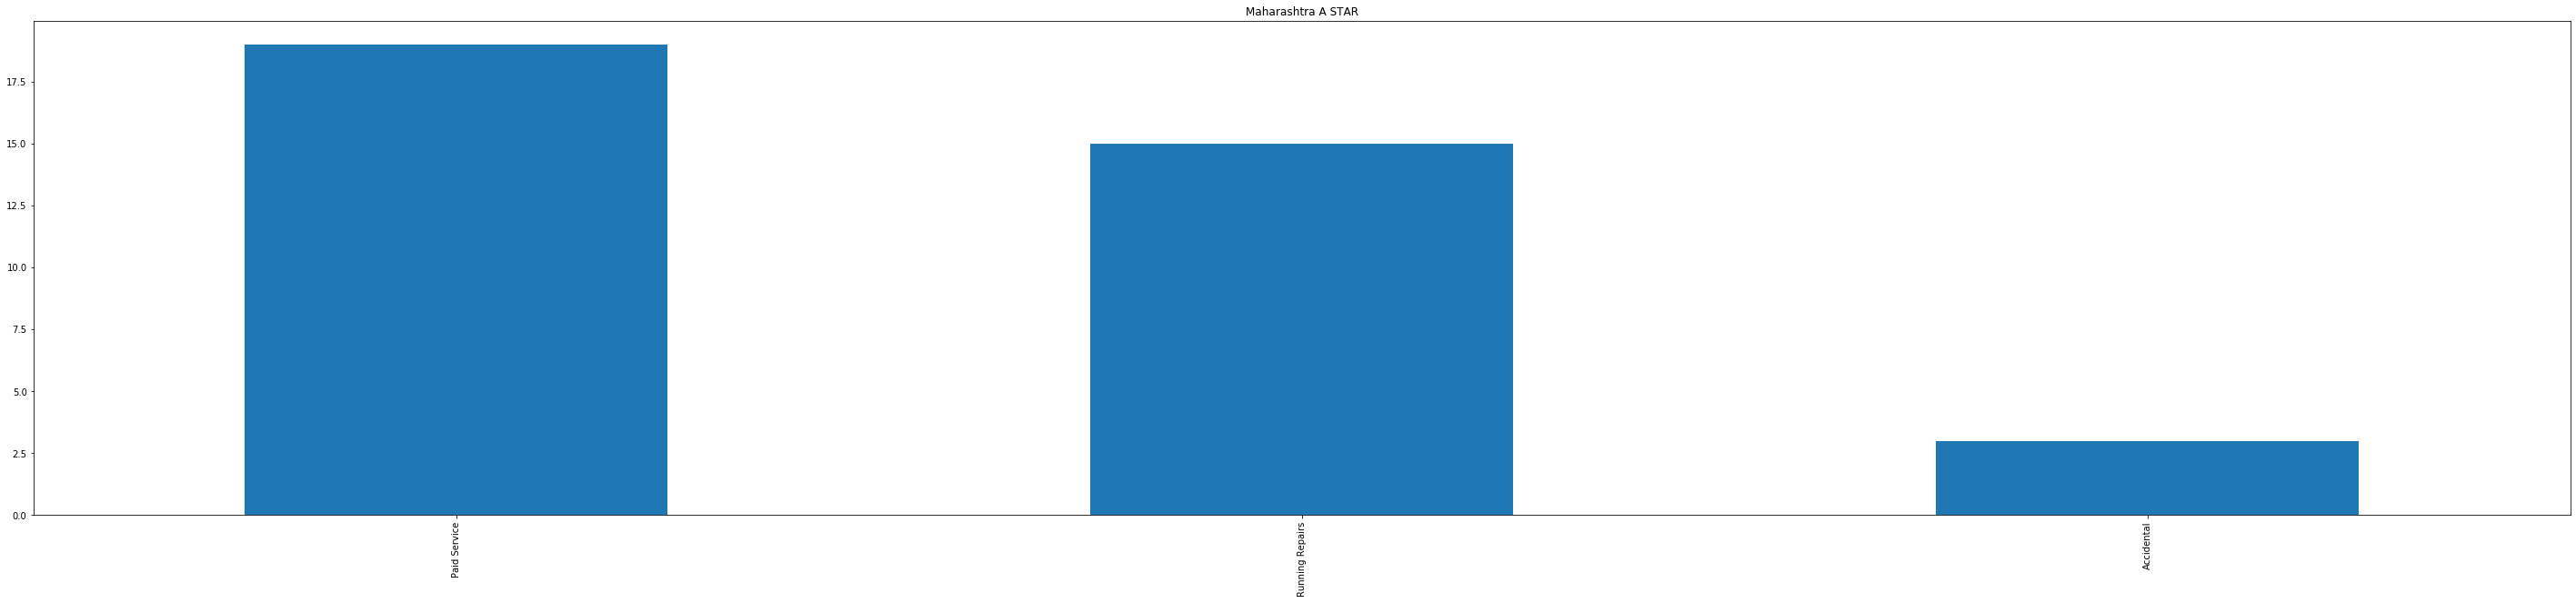

XYLO


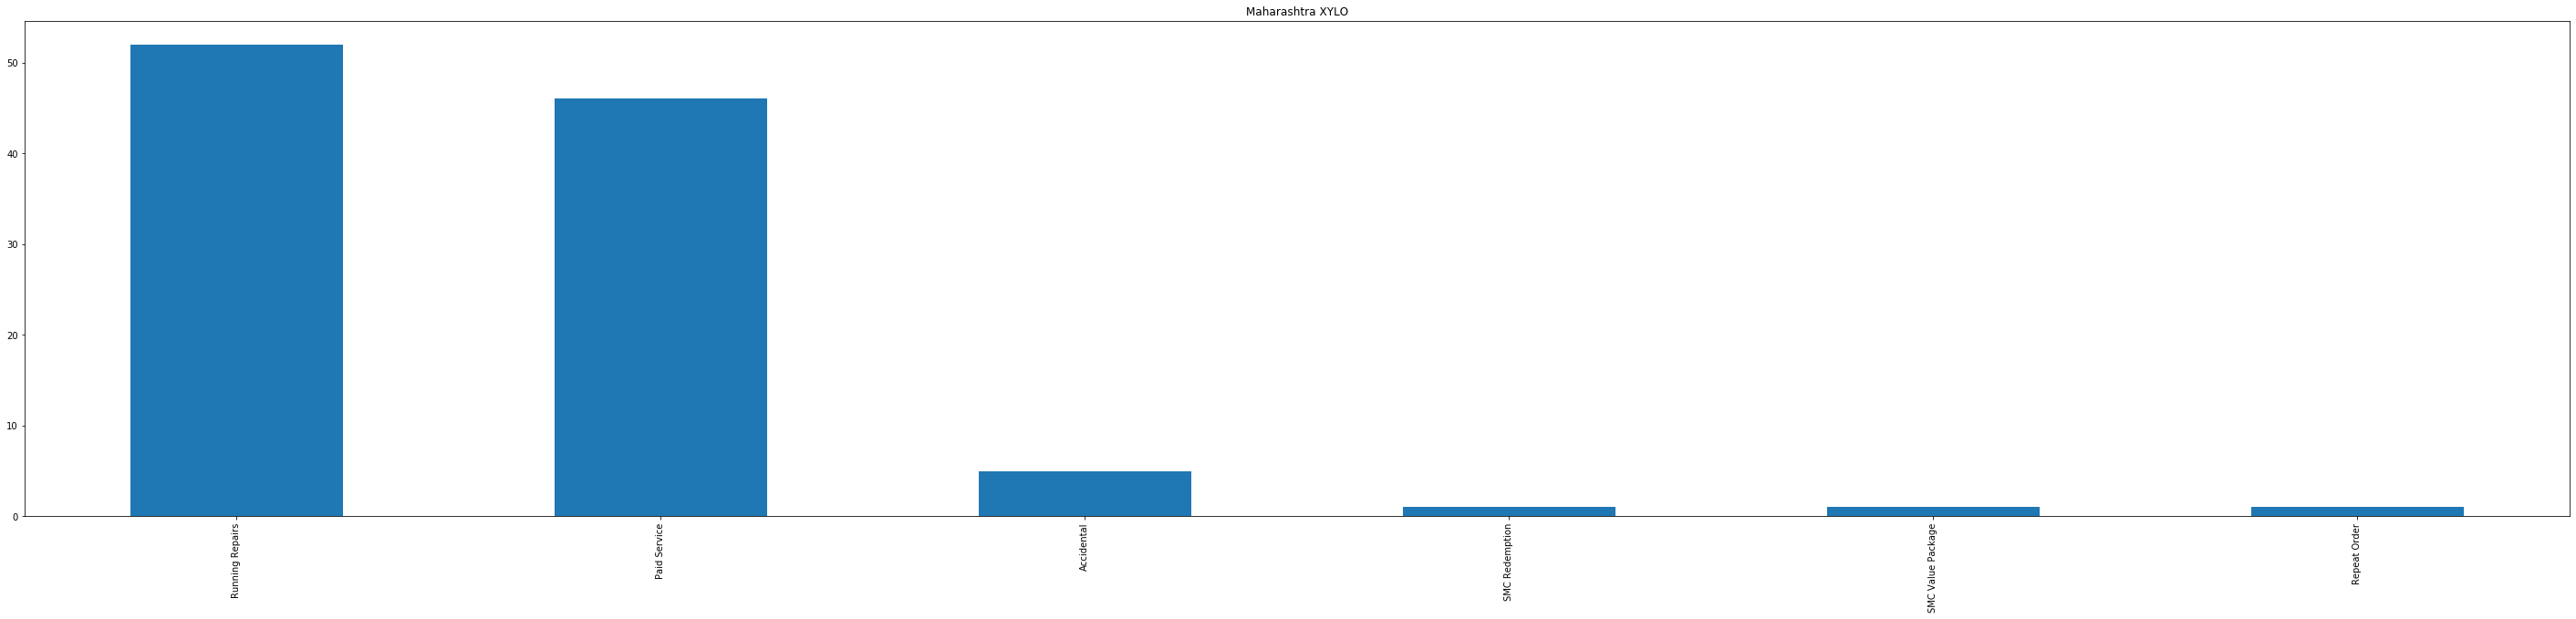

FABIA


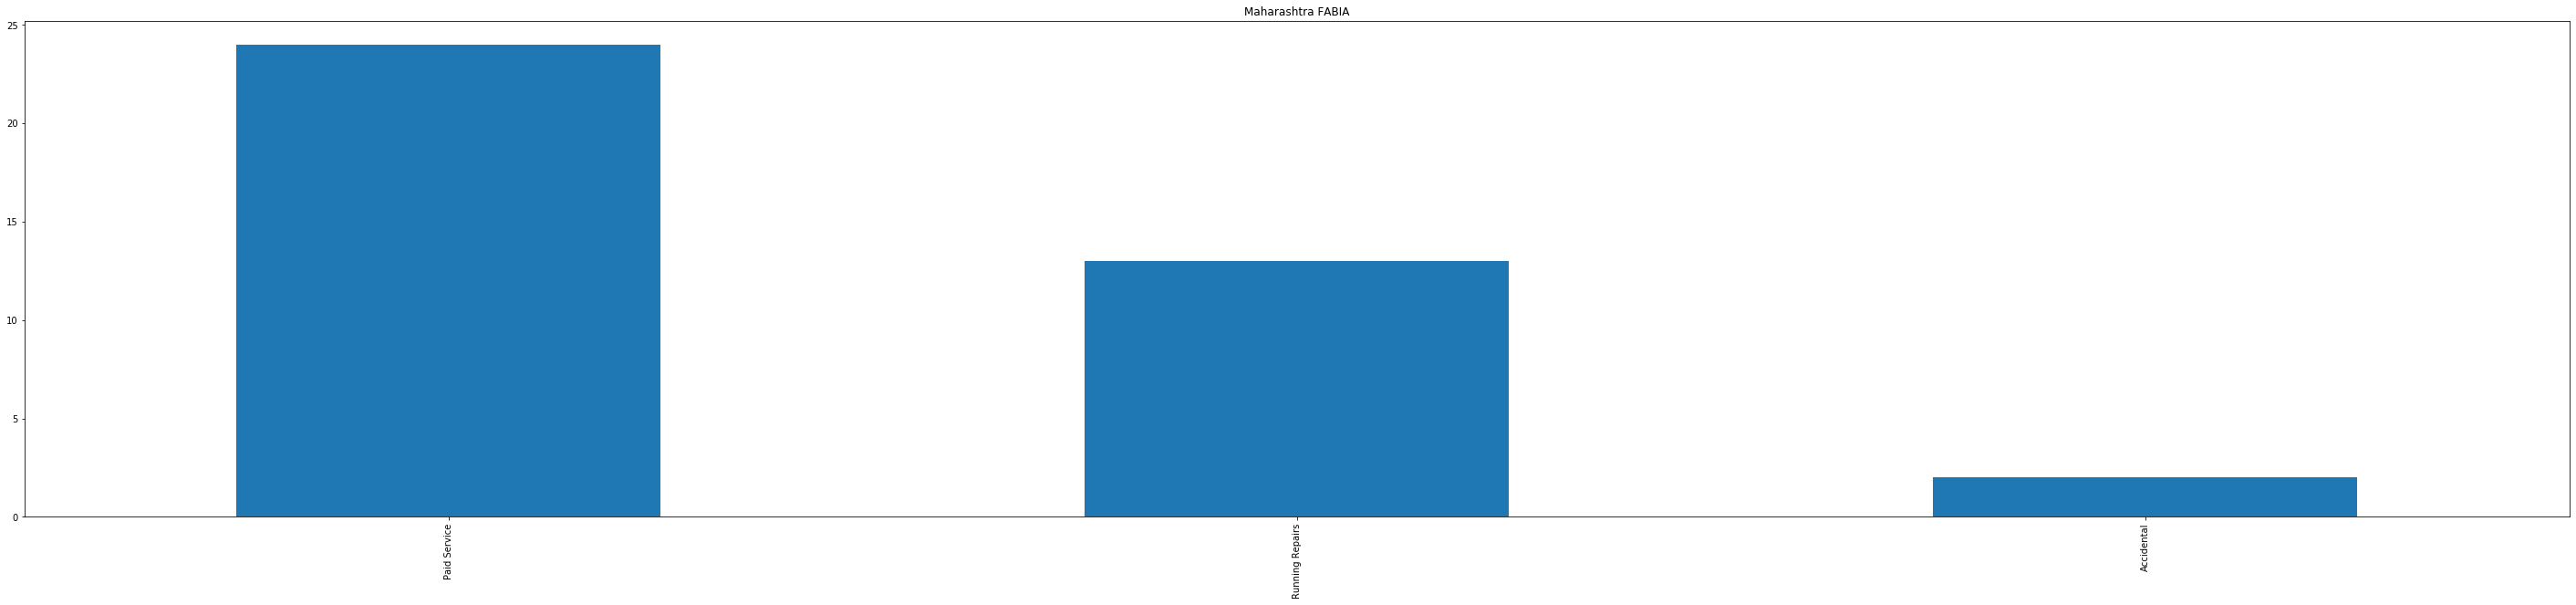

COROLLA


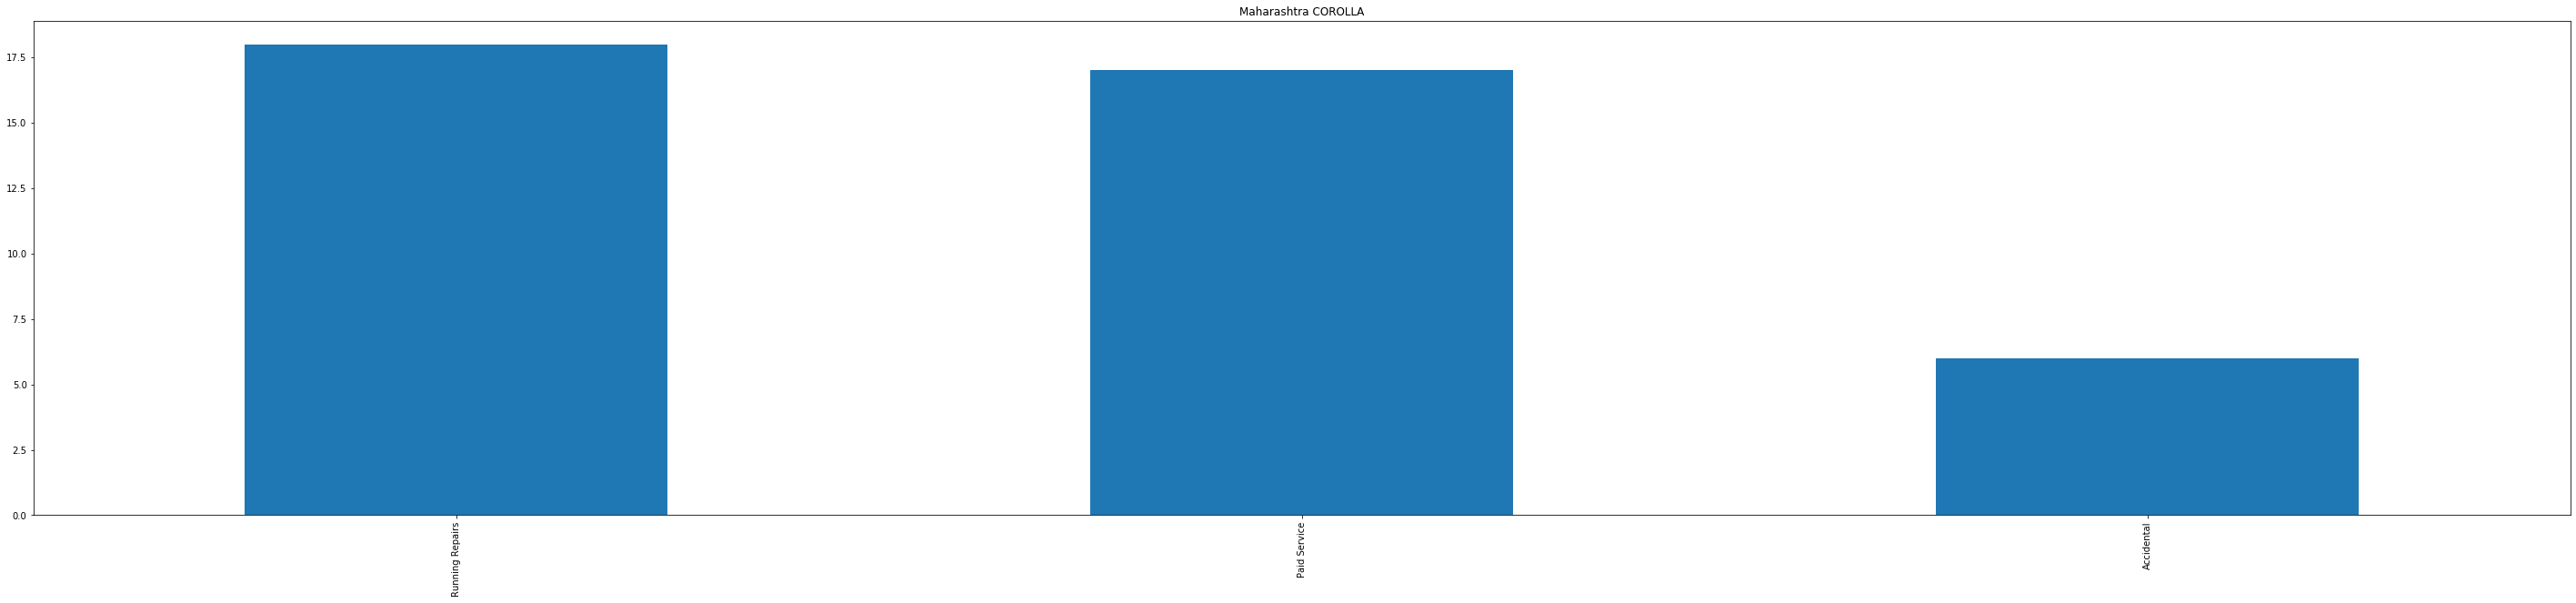

AVEO


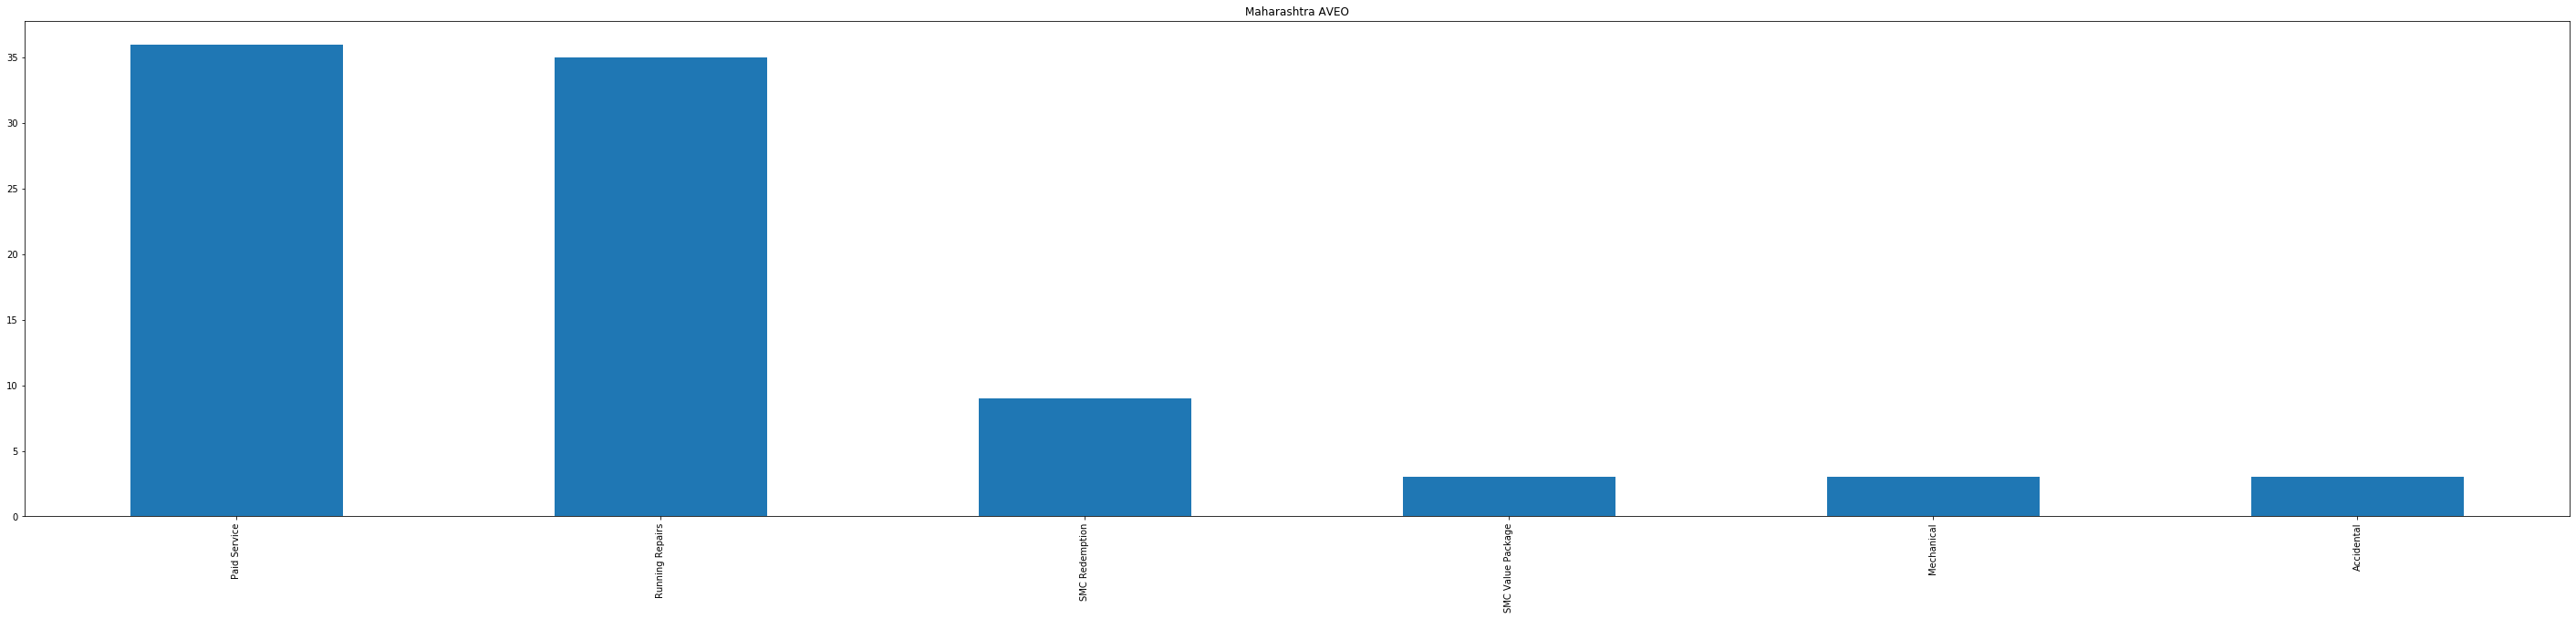

RITZ


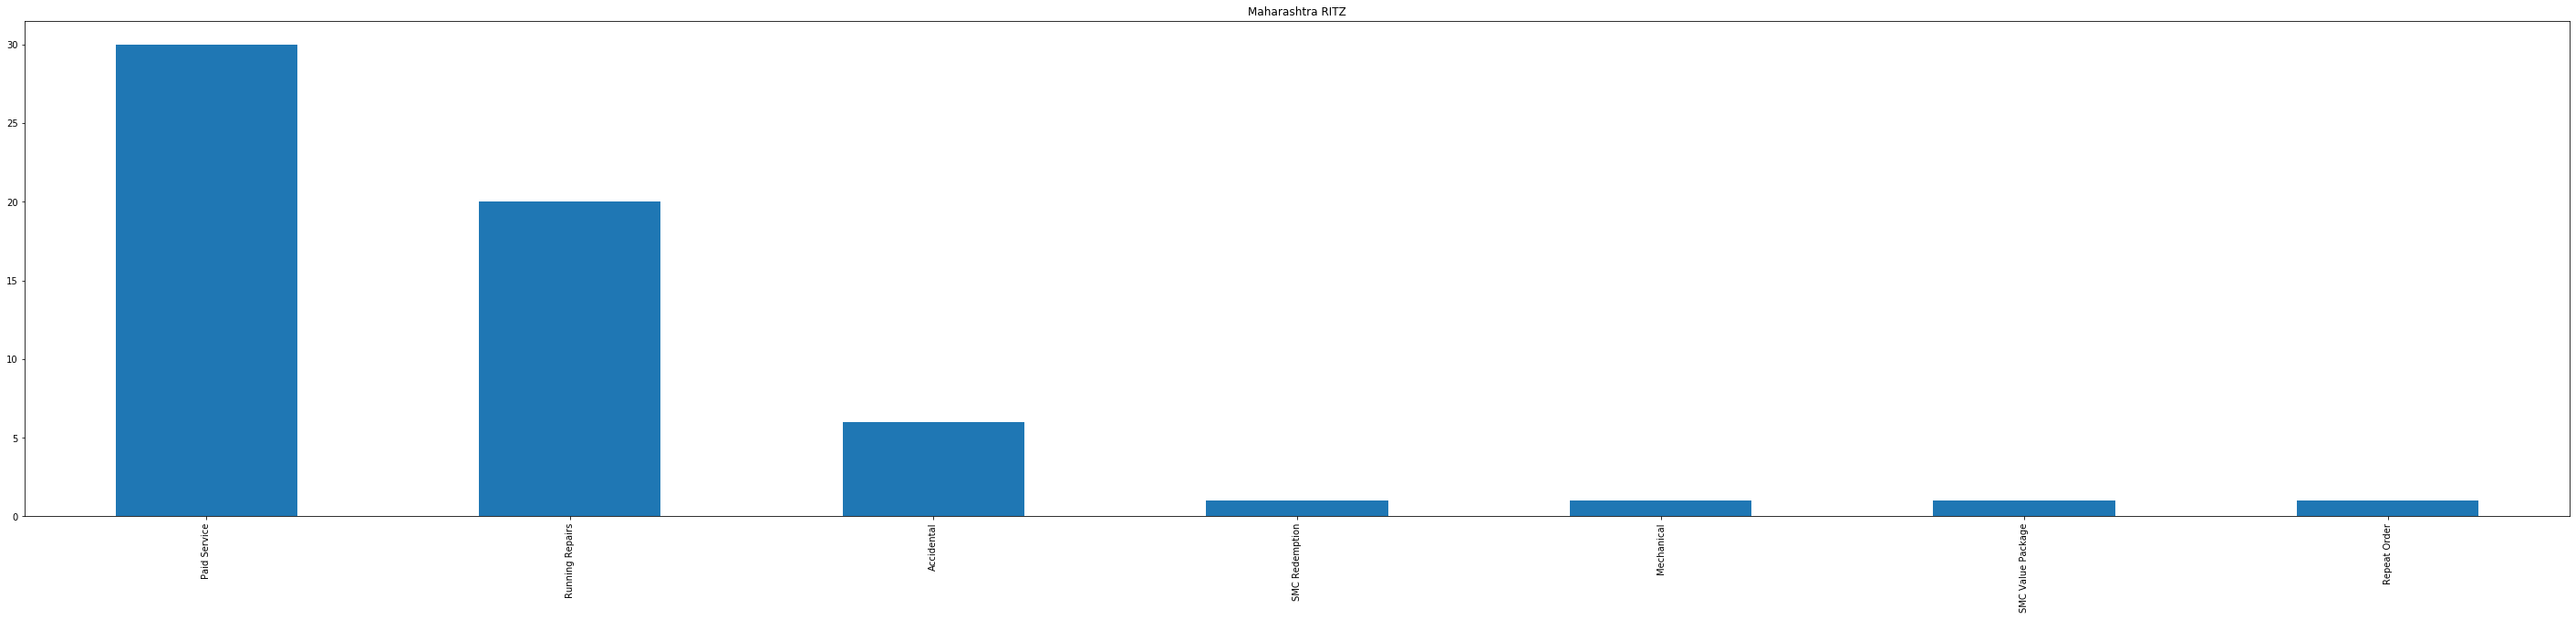

ARMADA


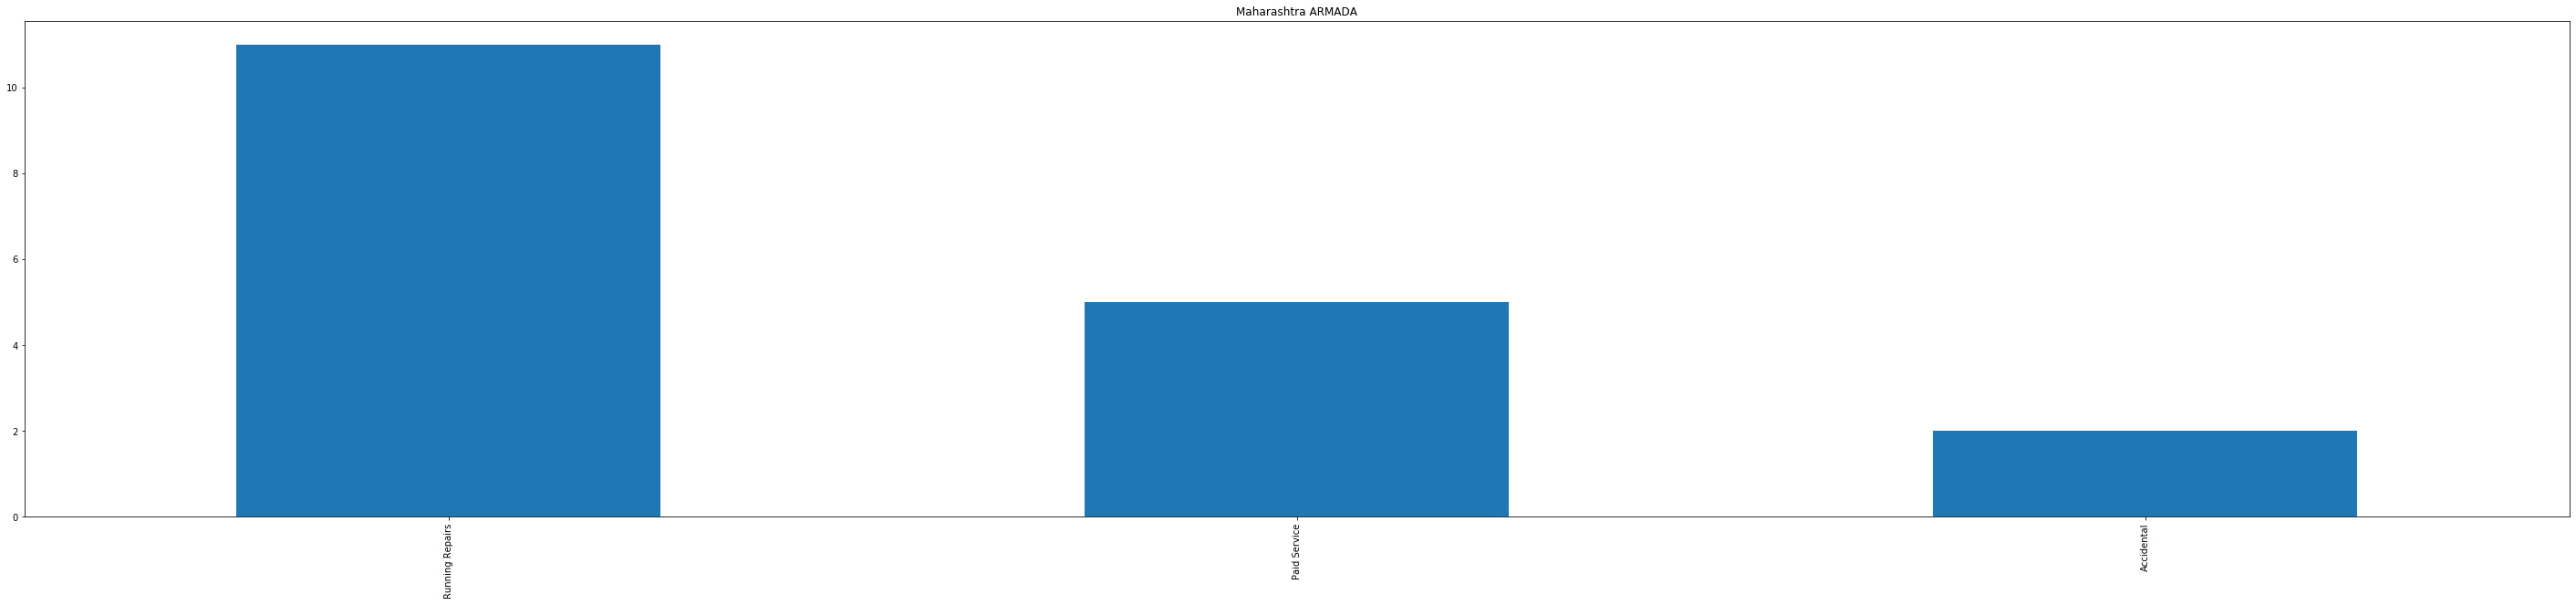

VENTO


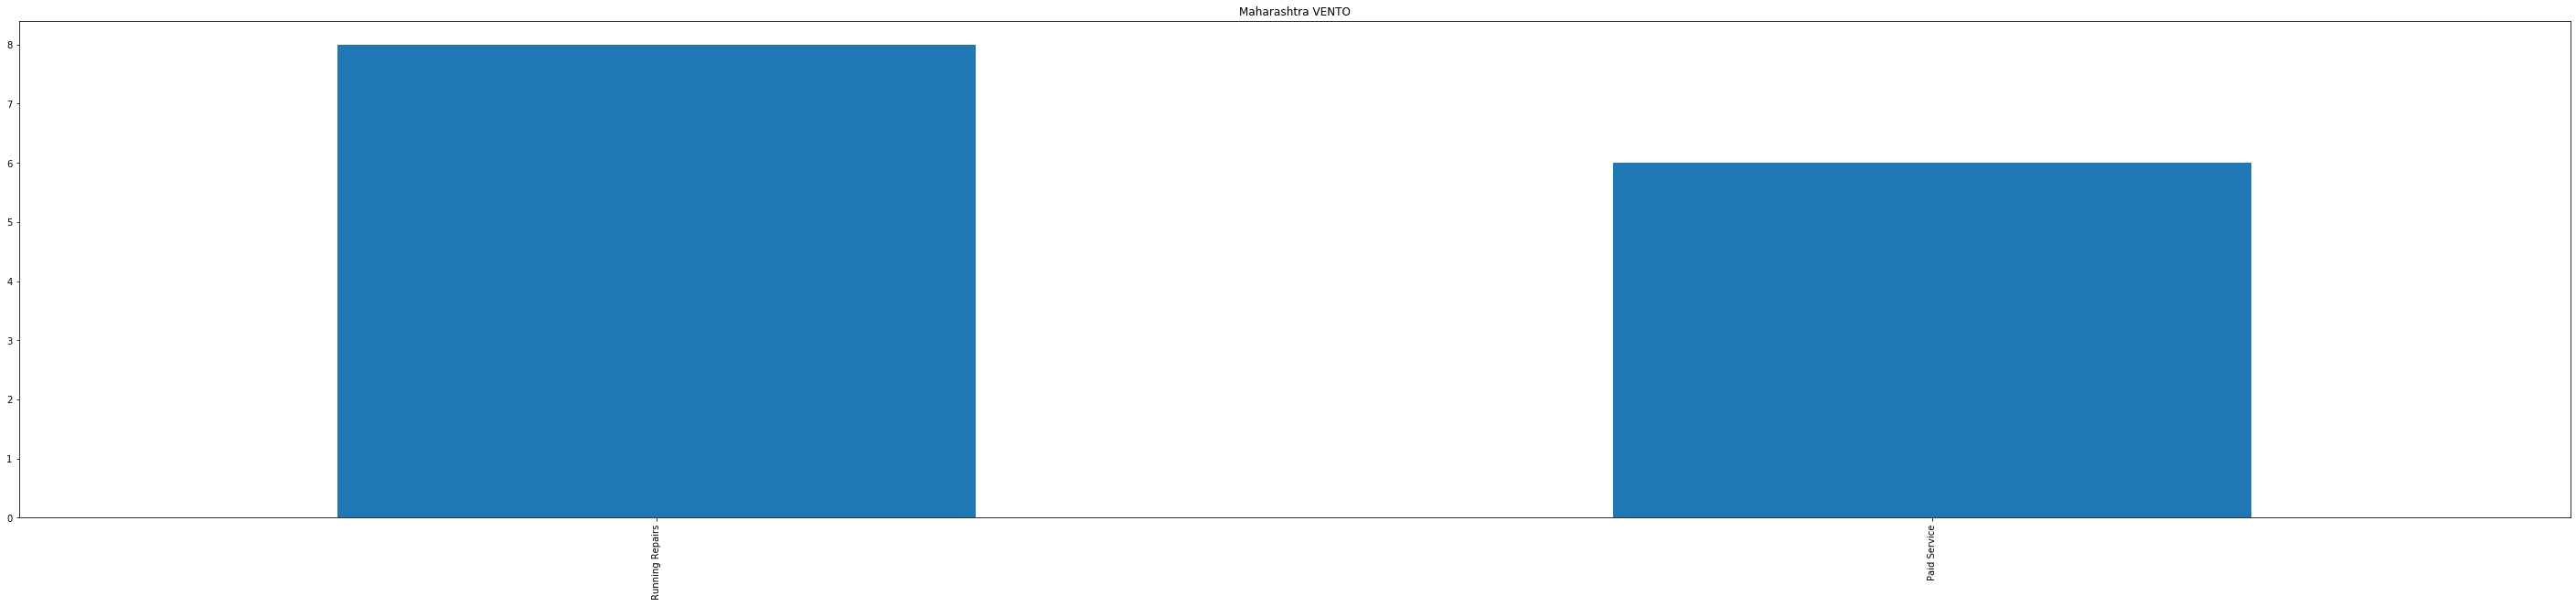

XUV 500


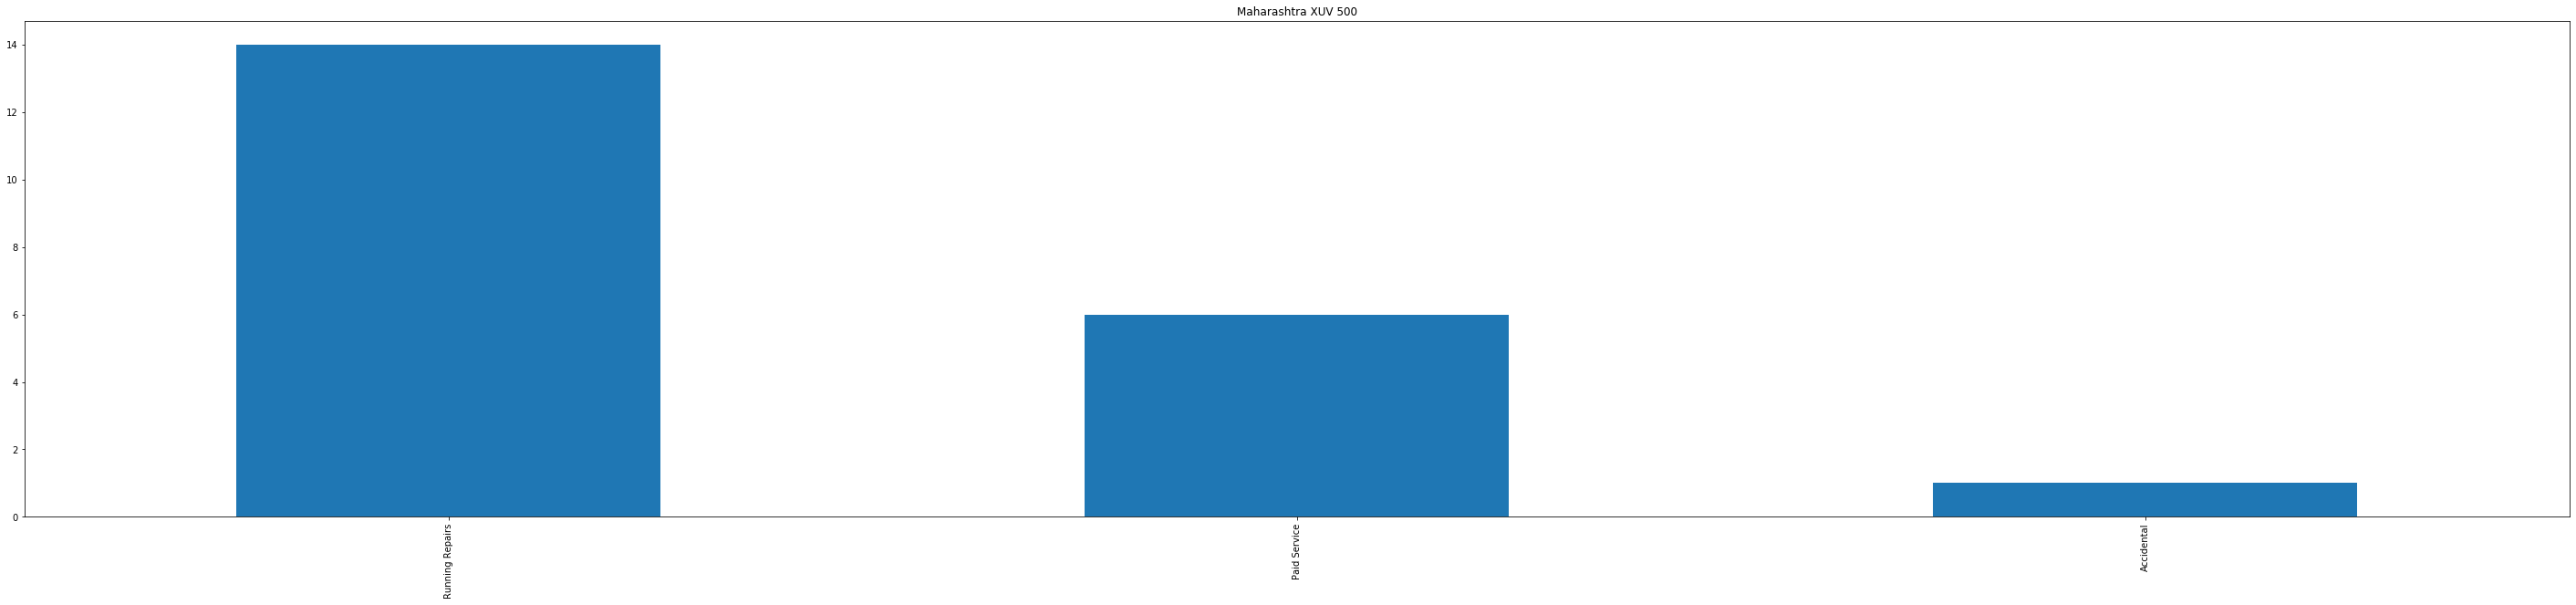

TUCSON


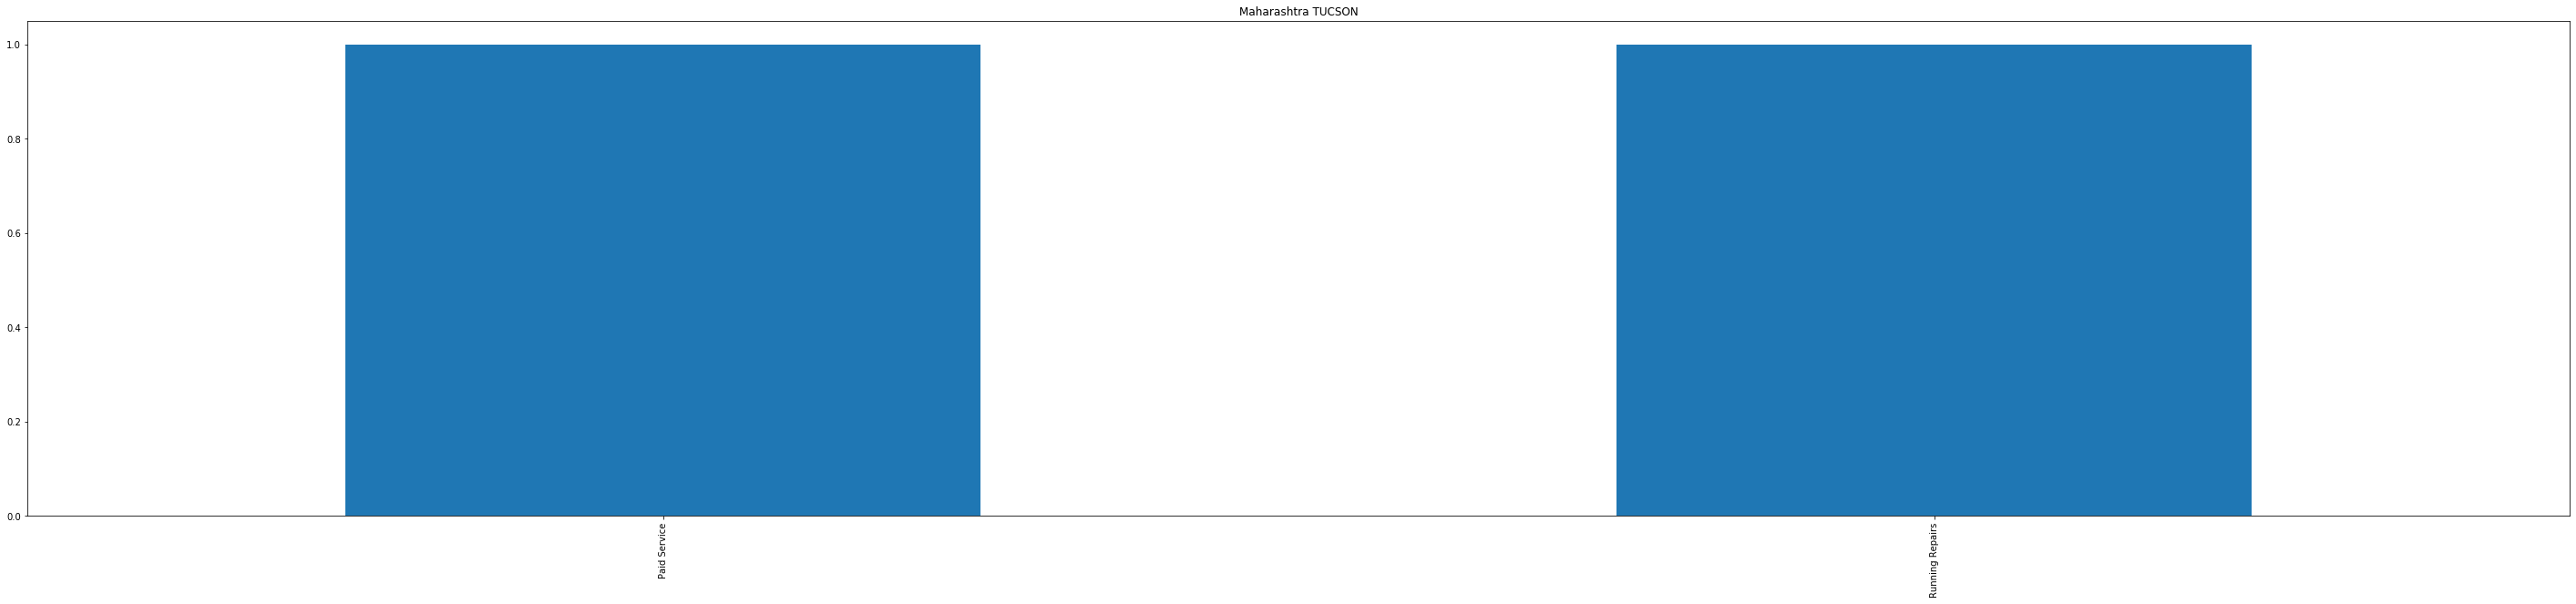

QUALIS


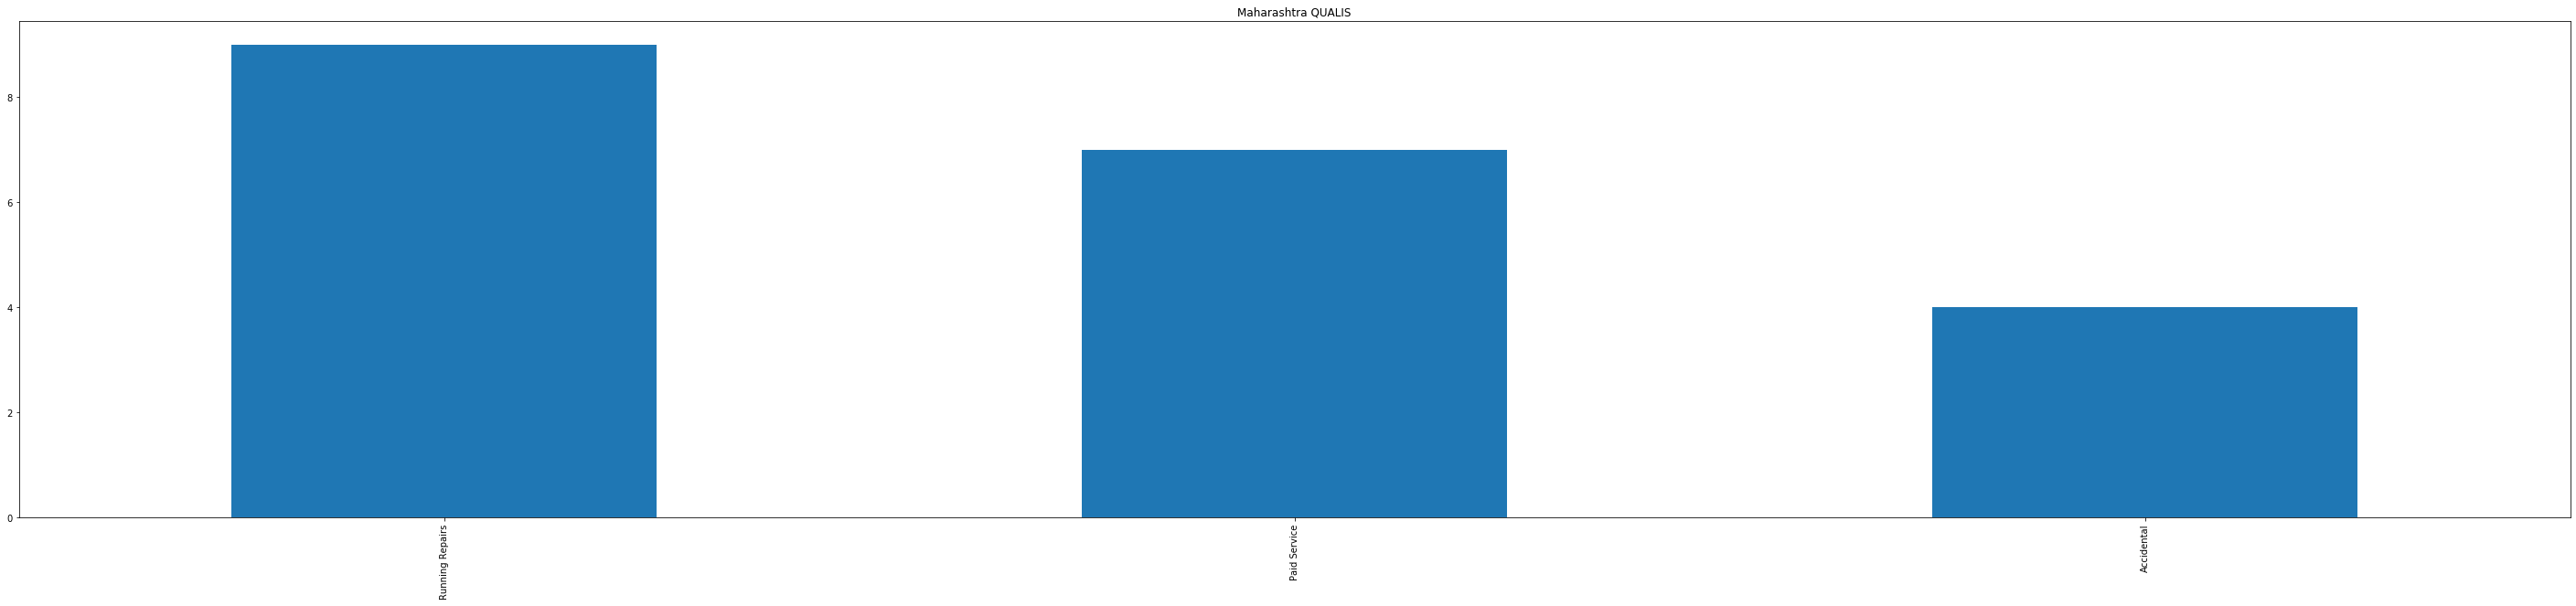

FUSION


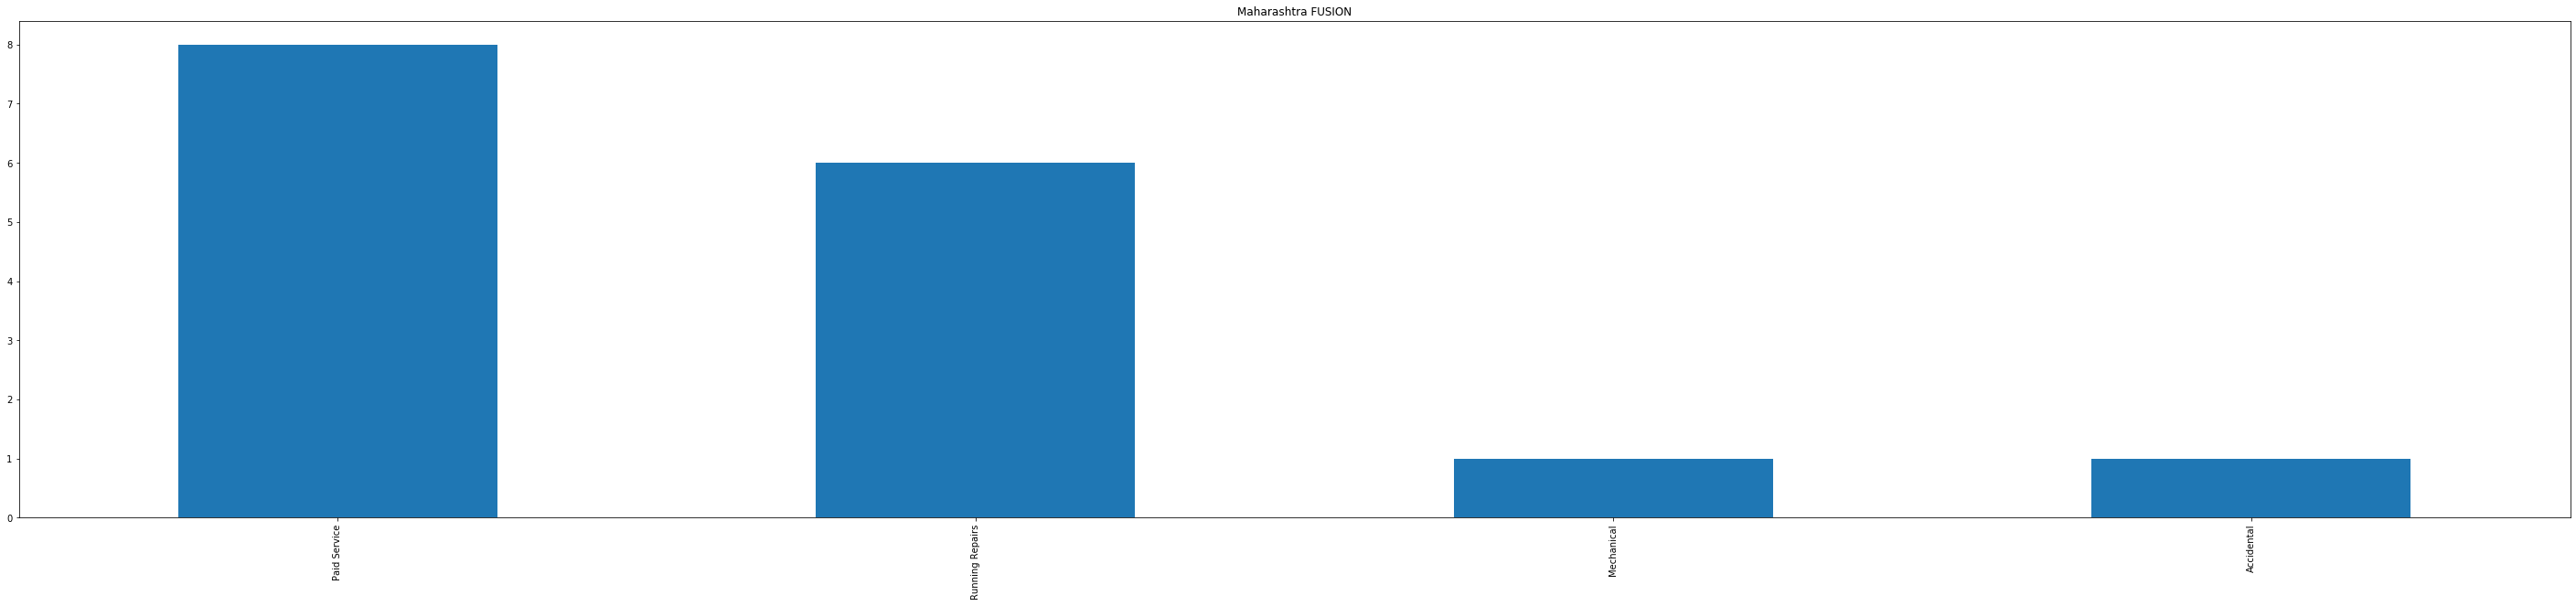

COROLLA ALTIS


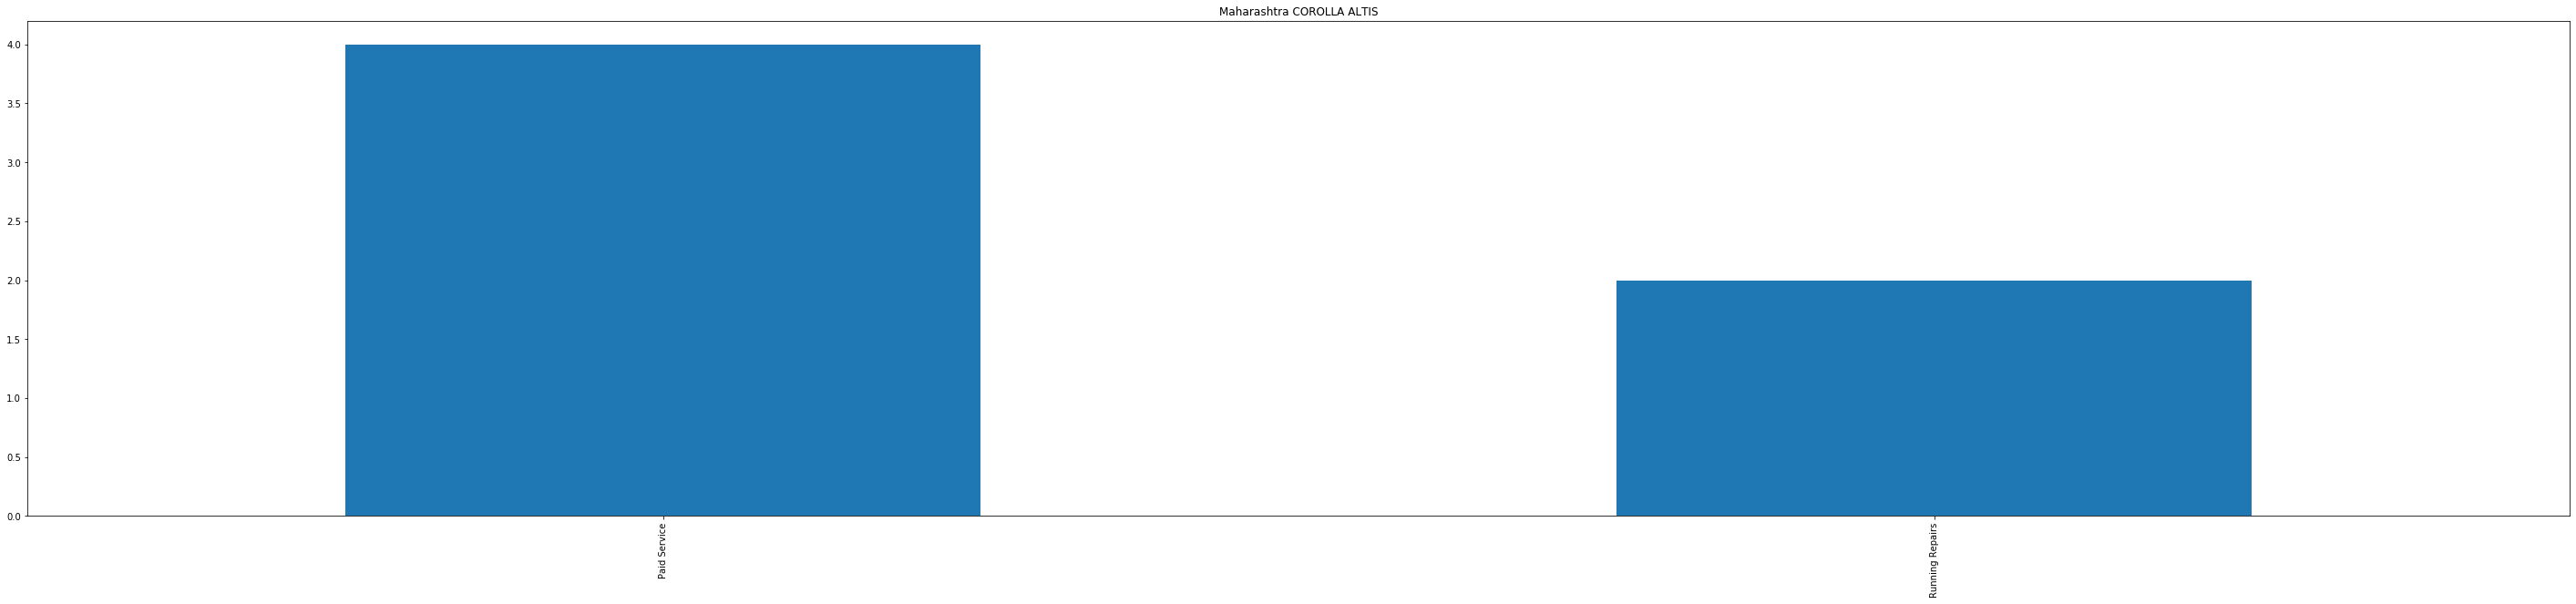

ESTEEM 1300


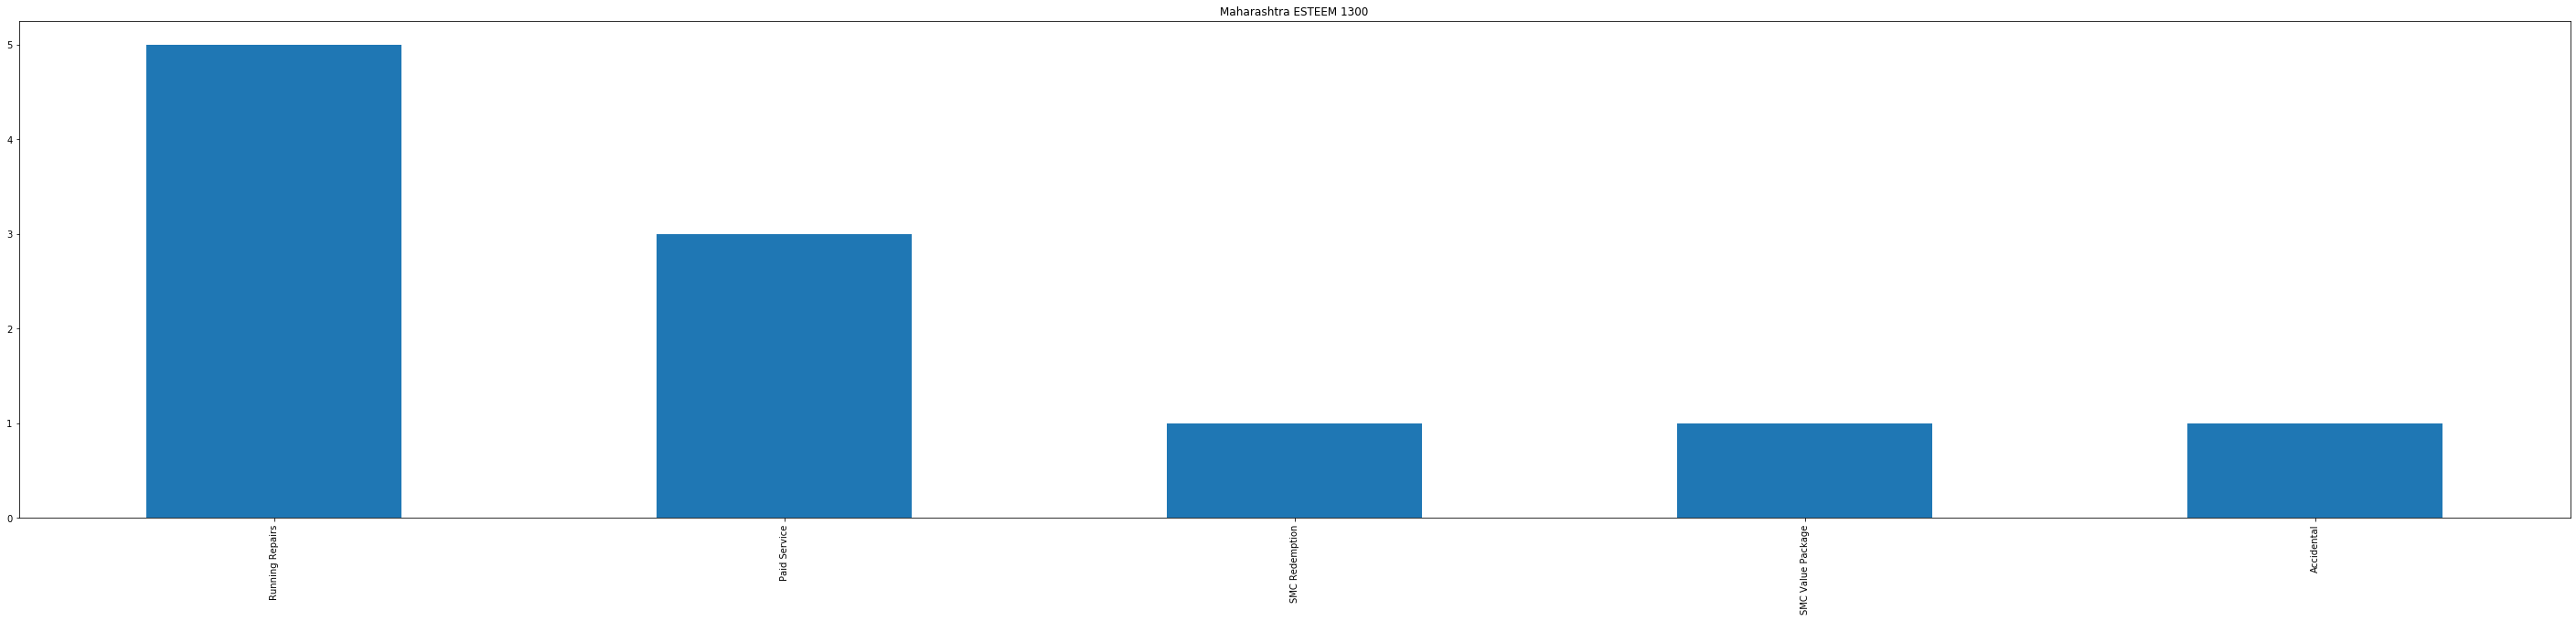

PAJERO


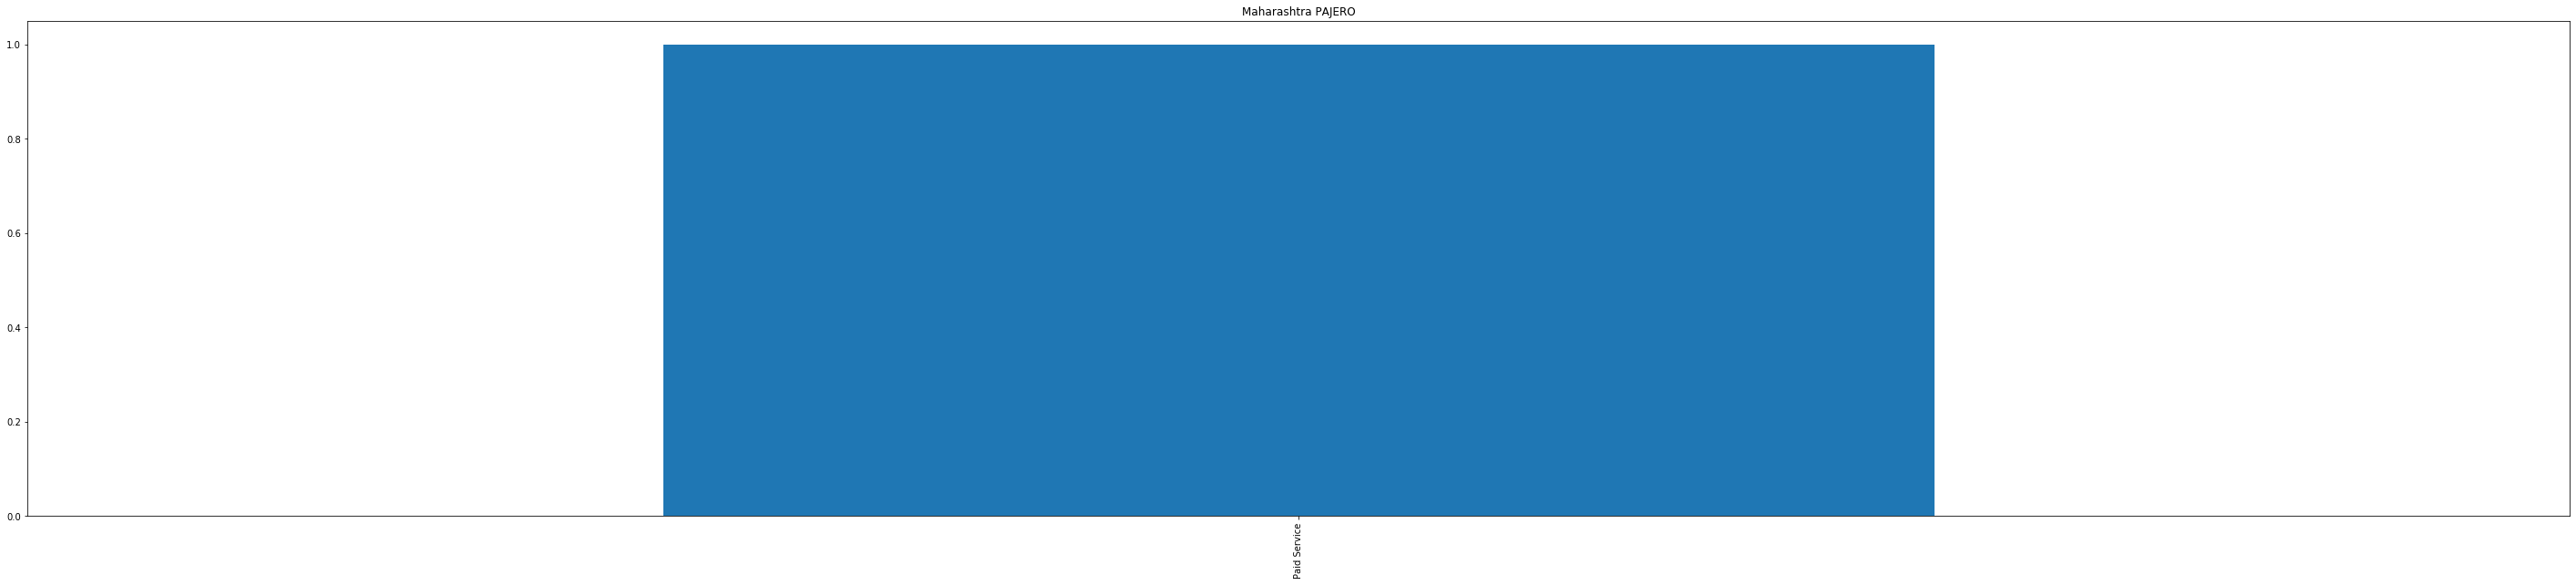

207


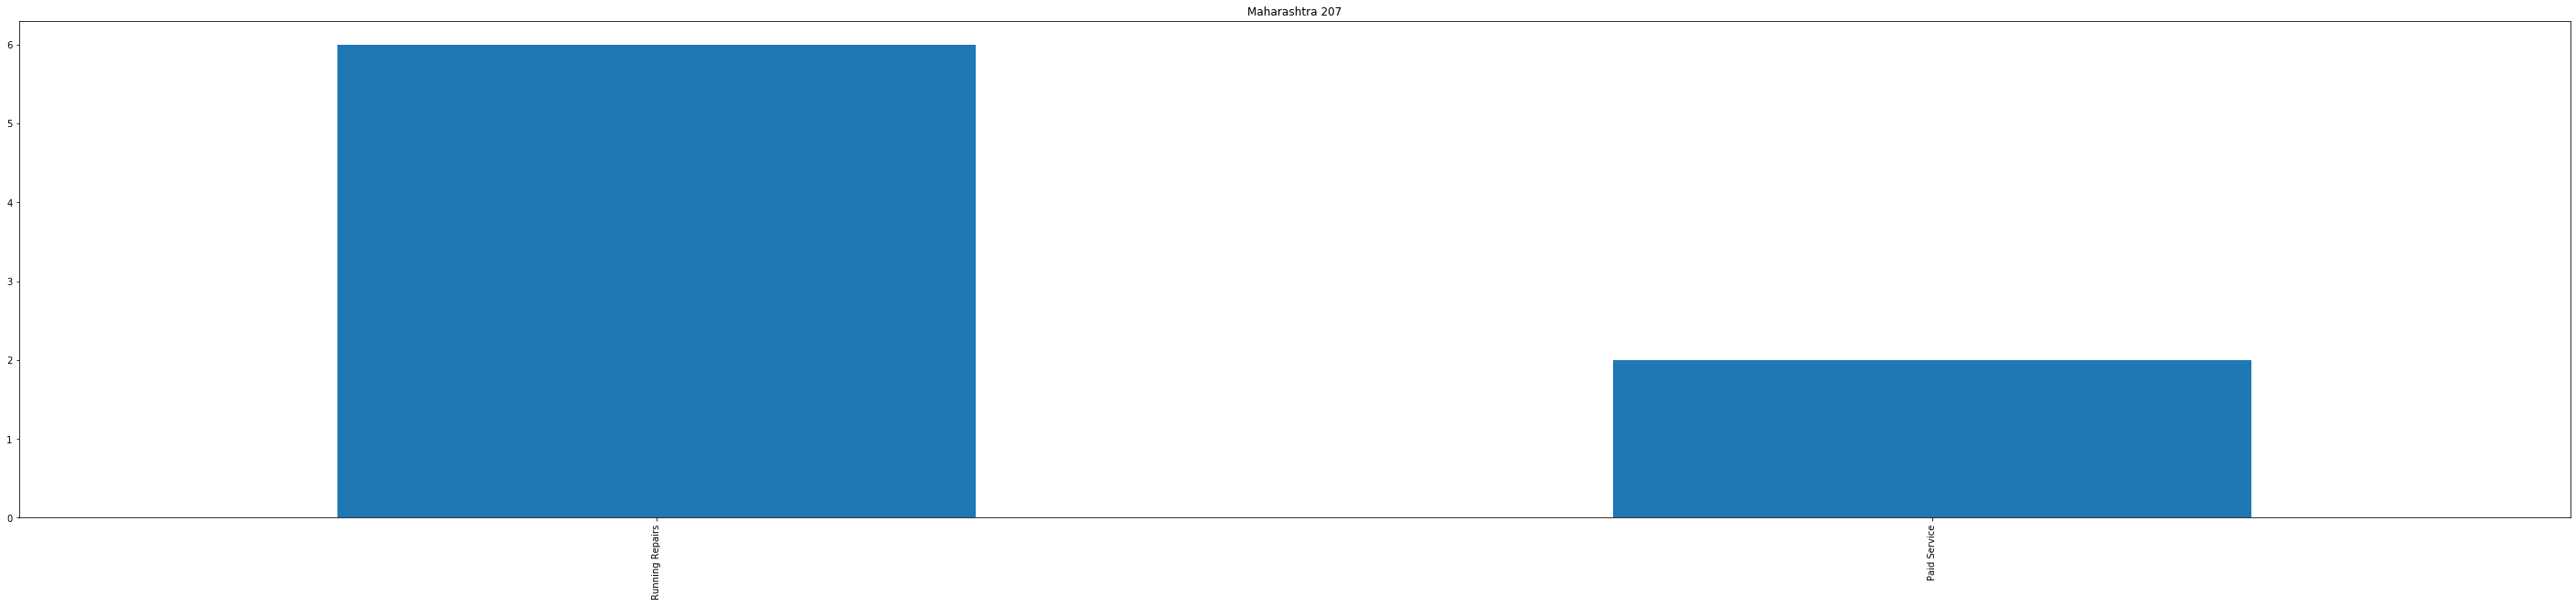

MARSHAL


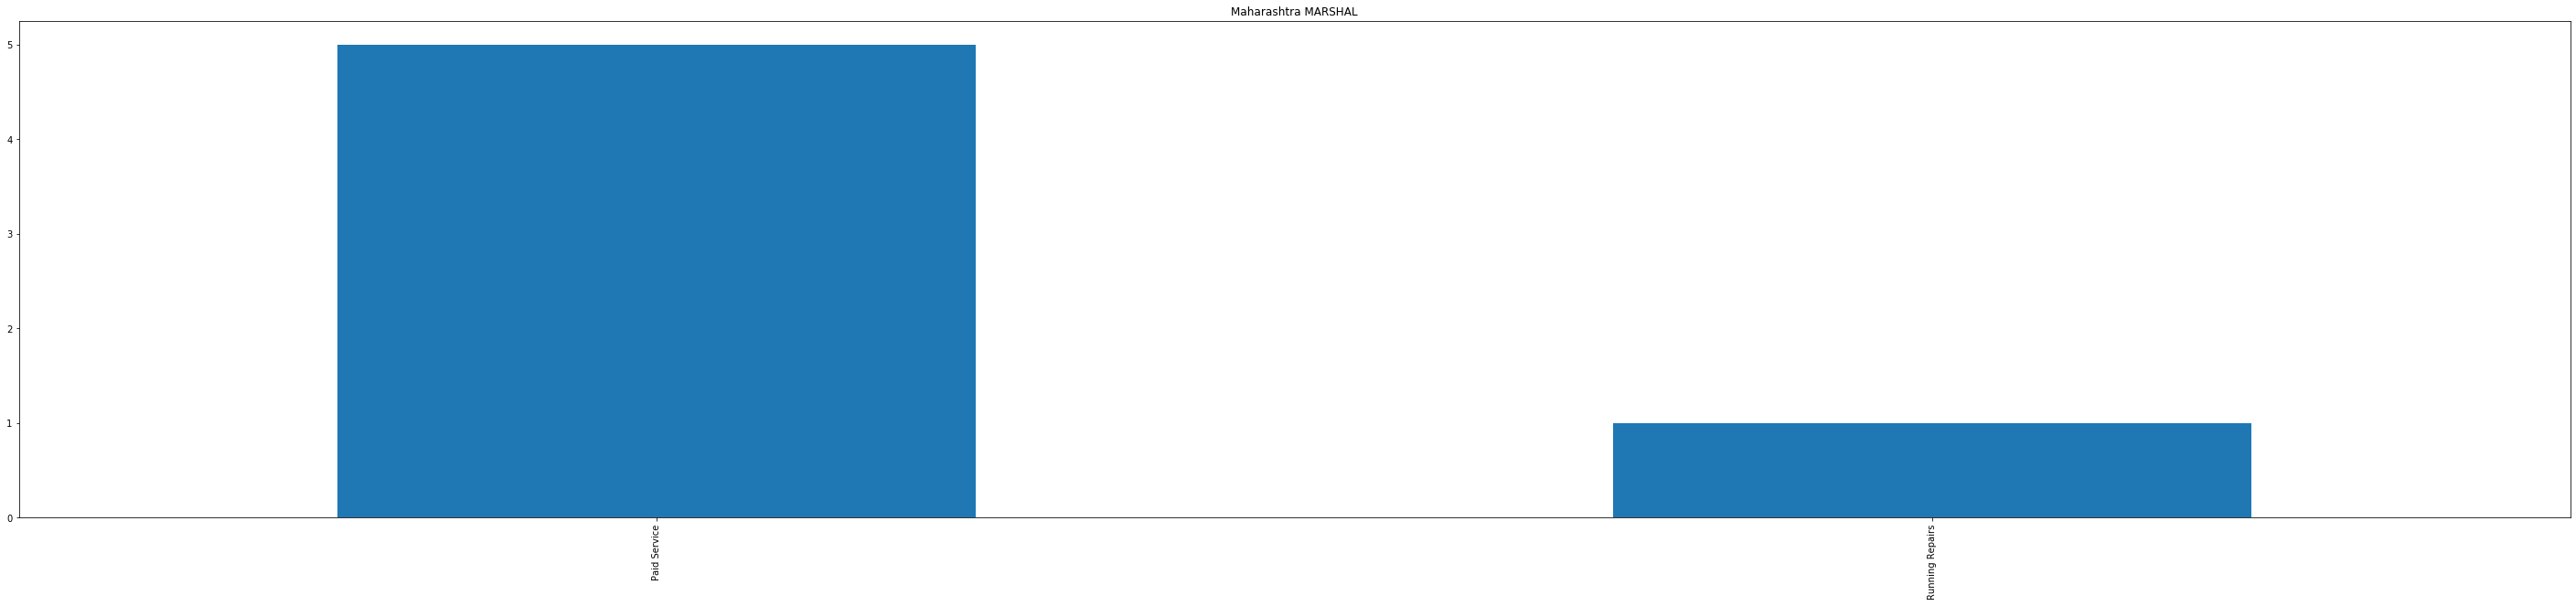

ELANTRA


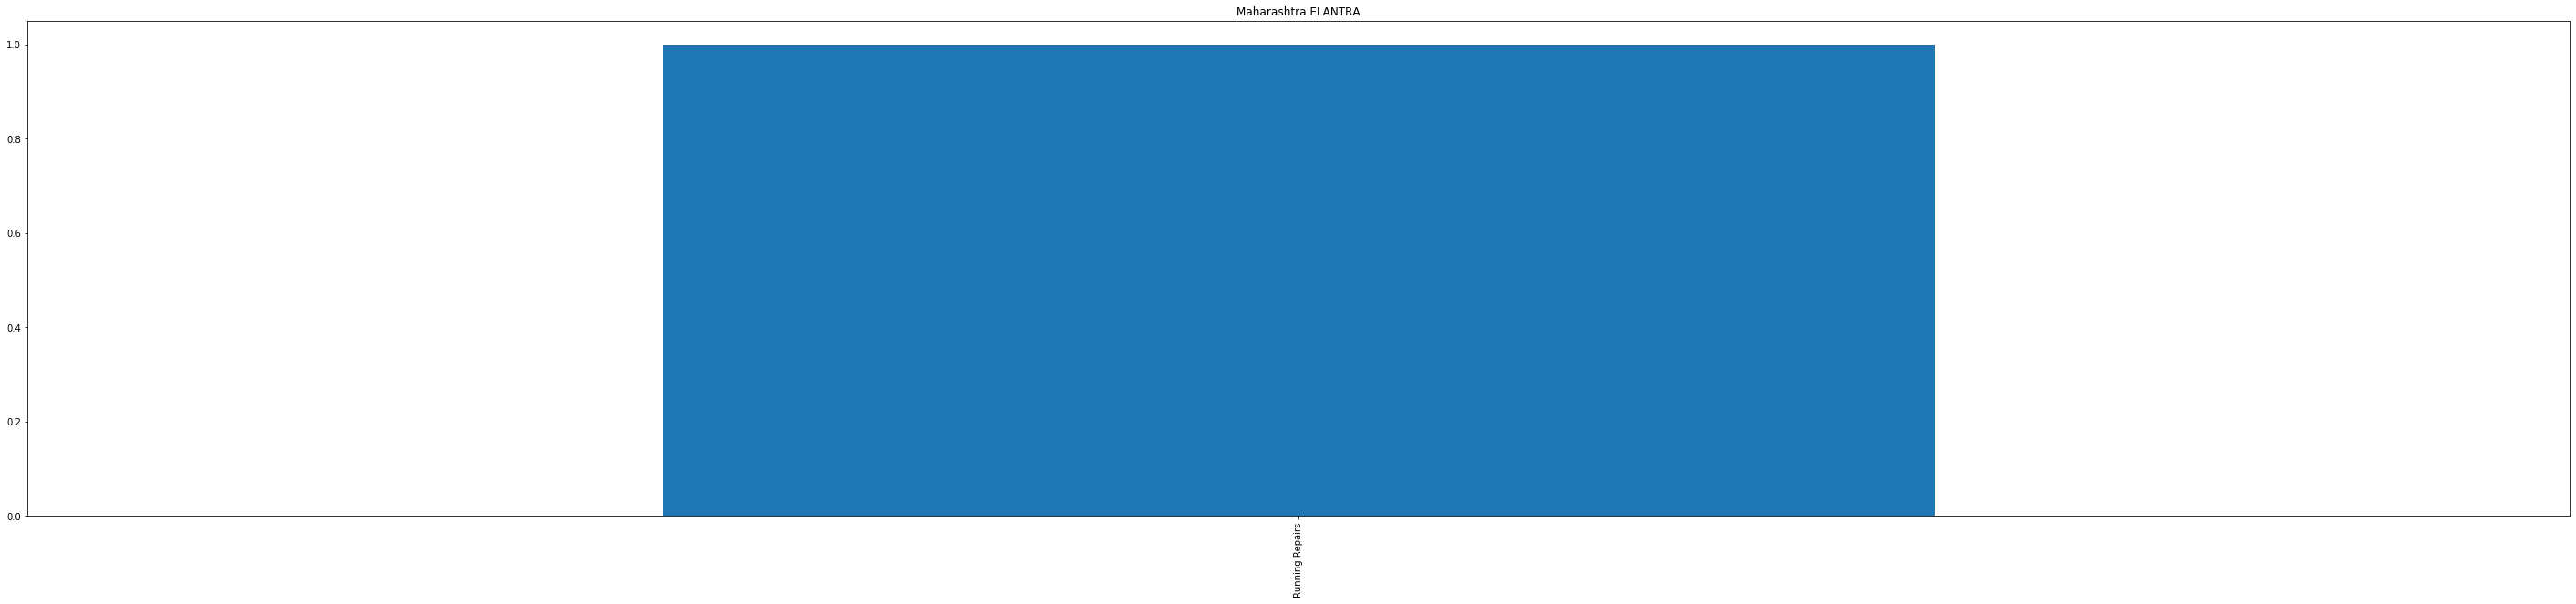

AMAZE


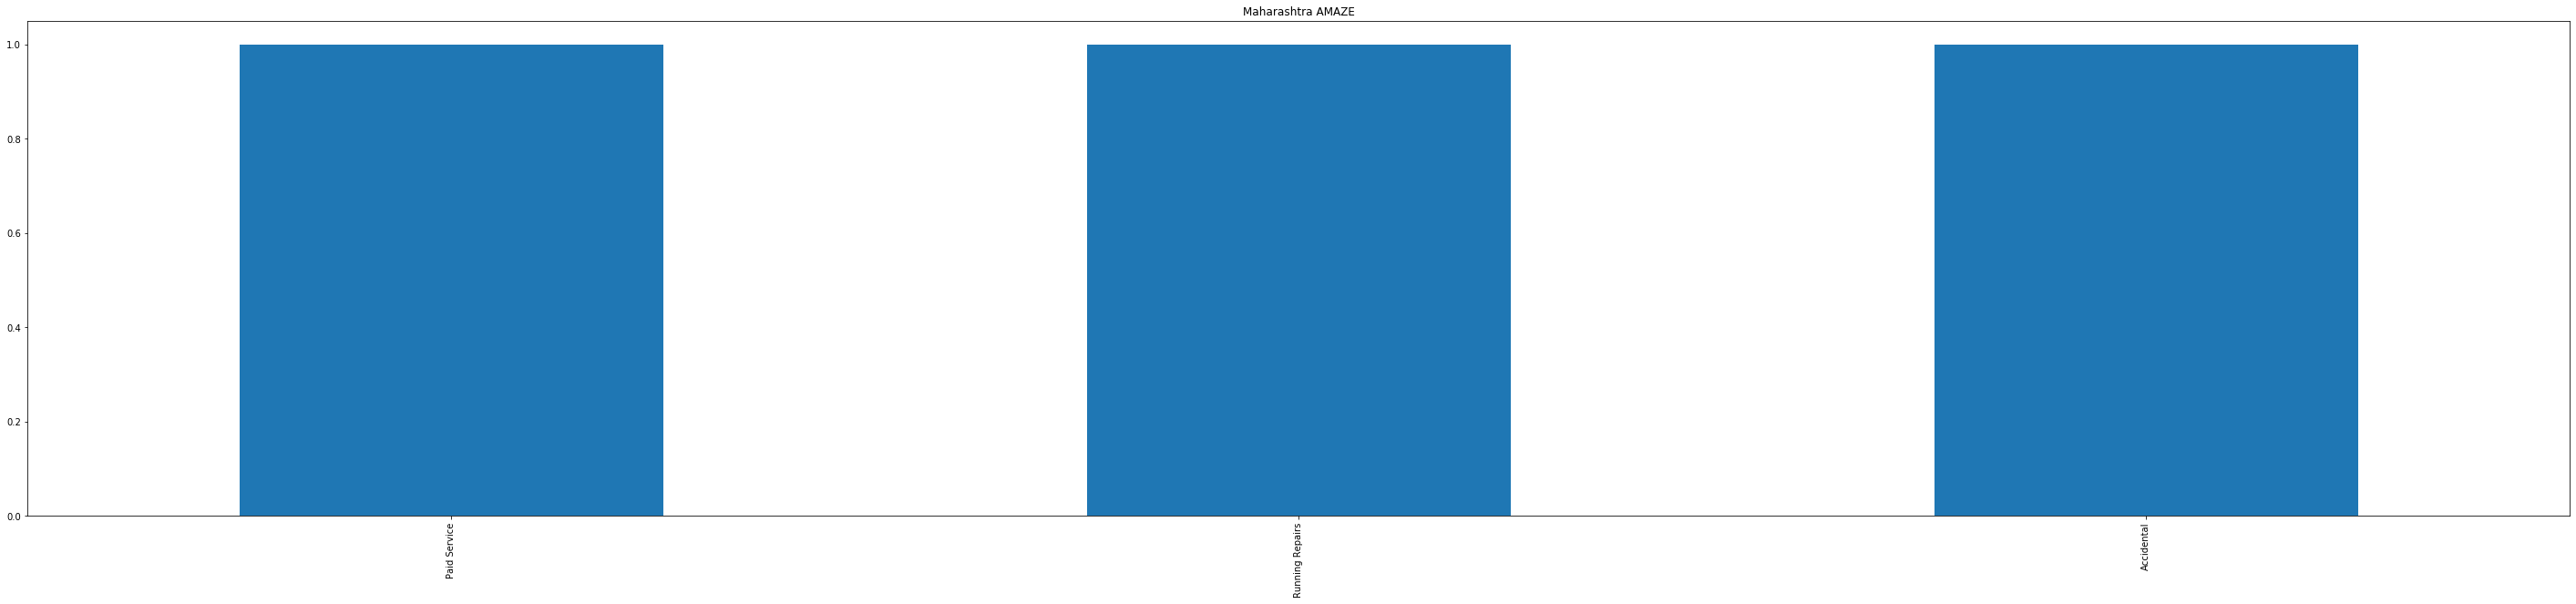

MONDEO


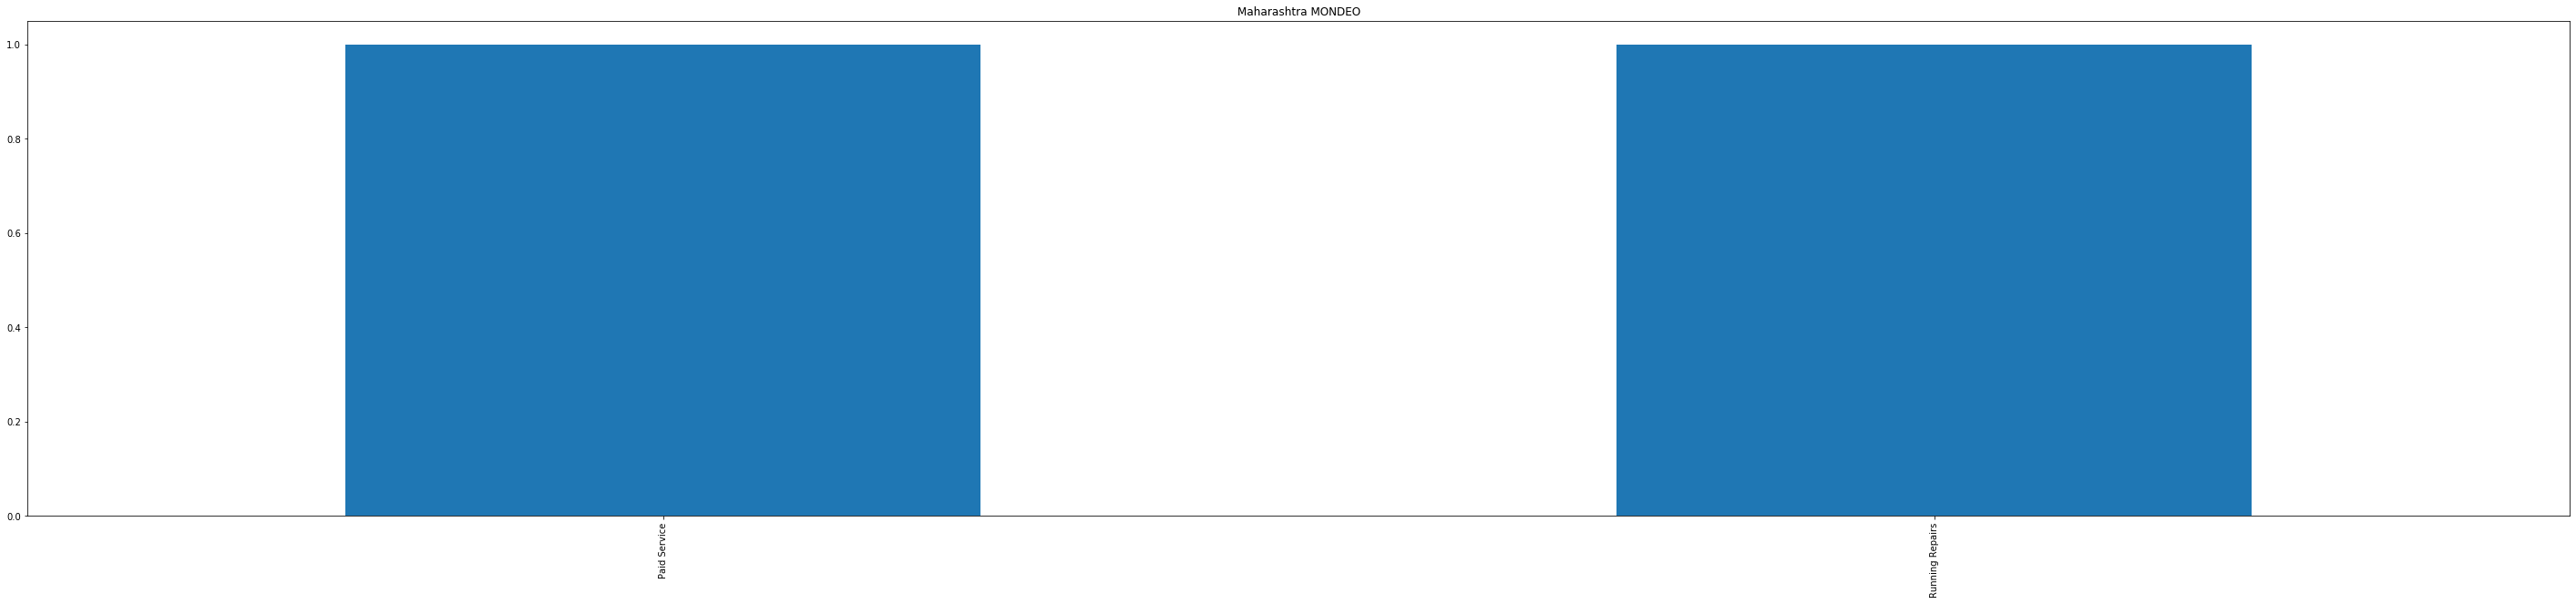

BMW-M5


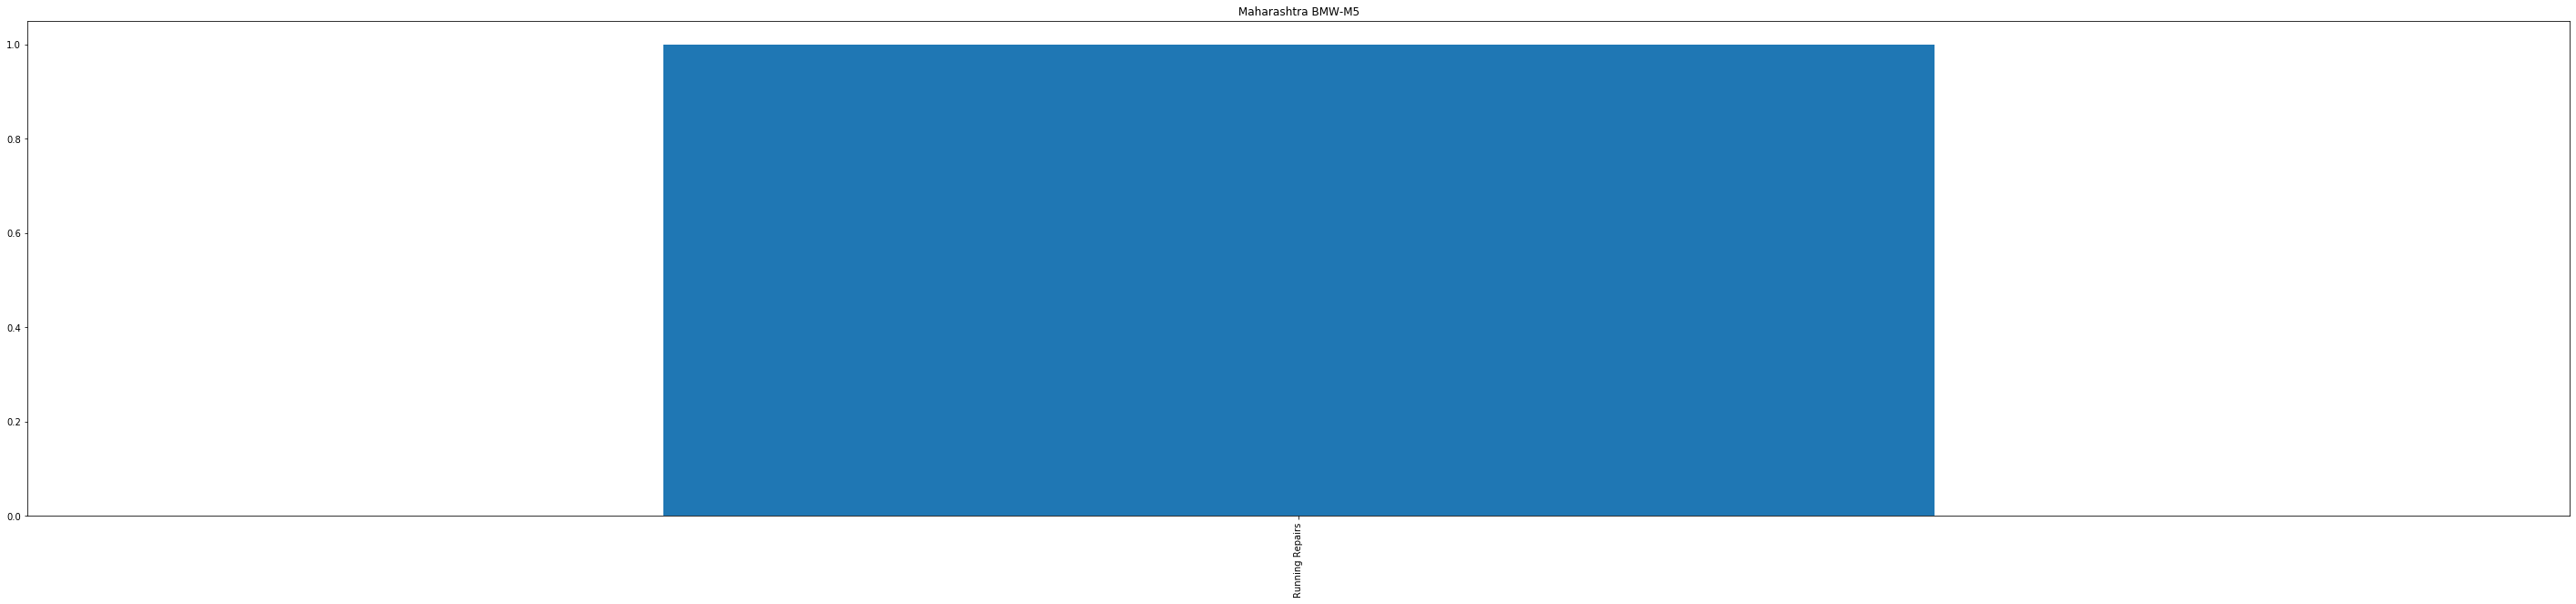

CAPTIVA


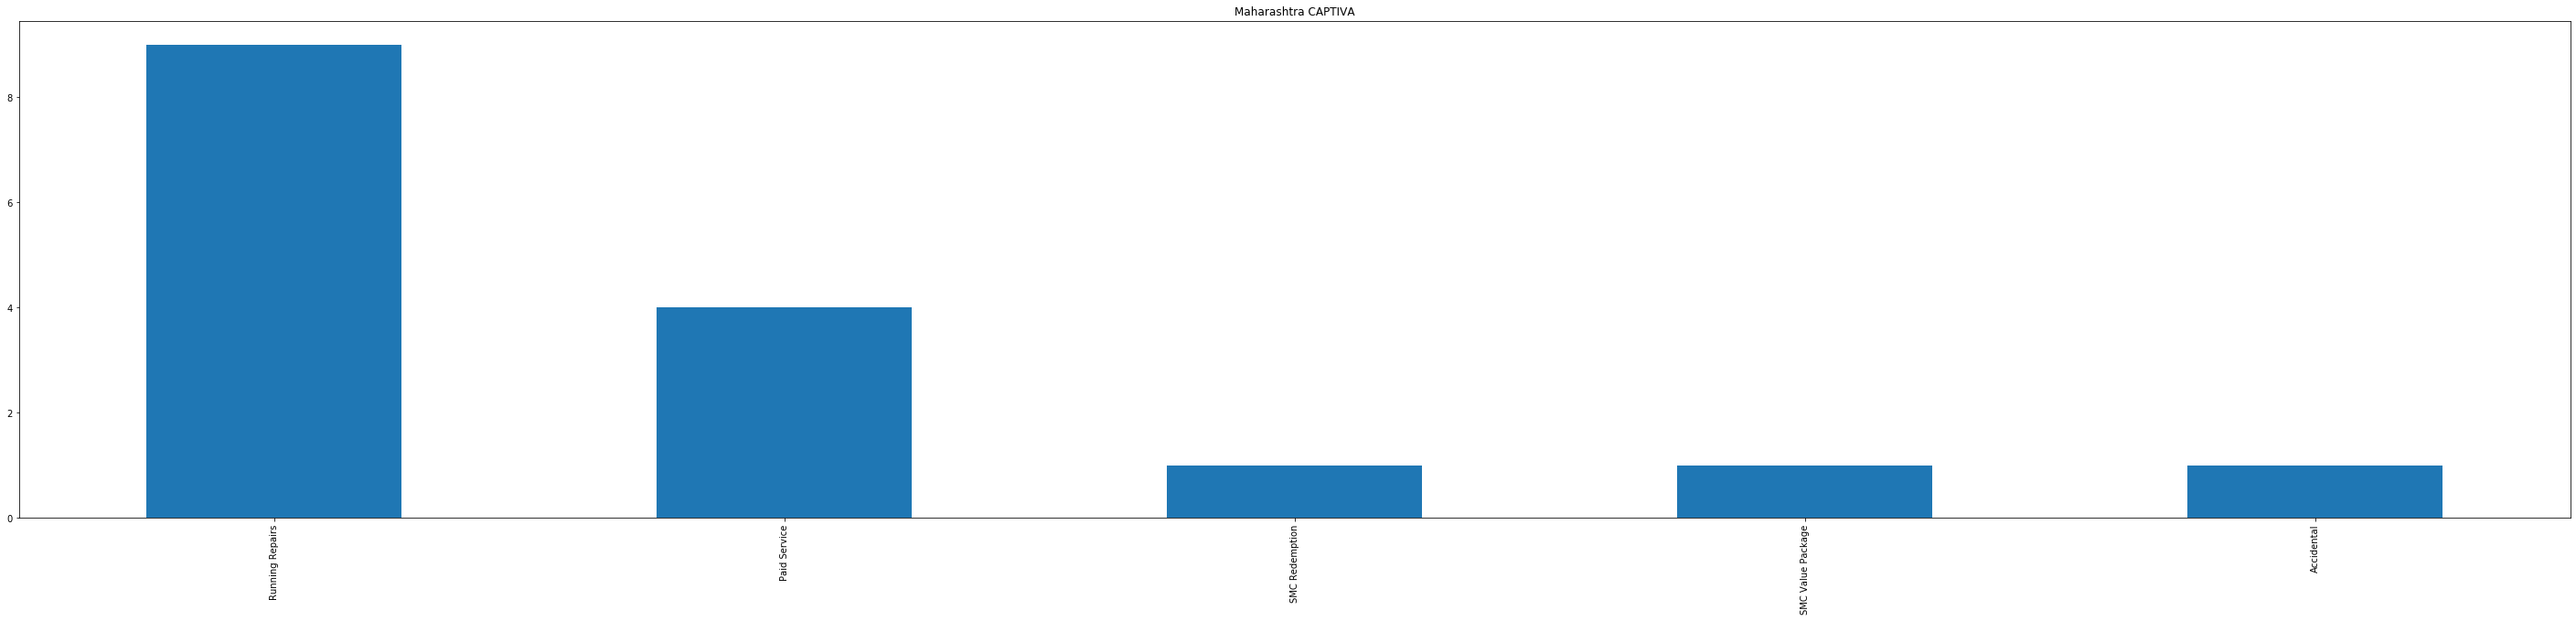

CR-V


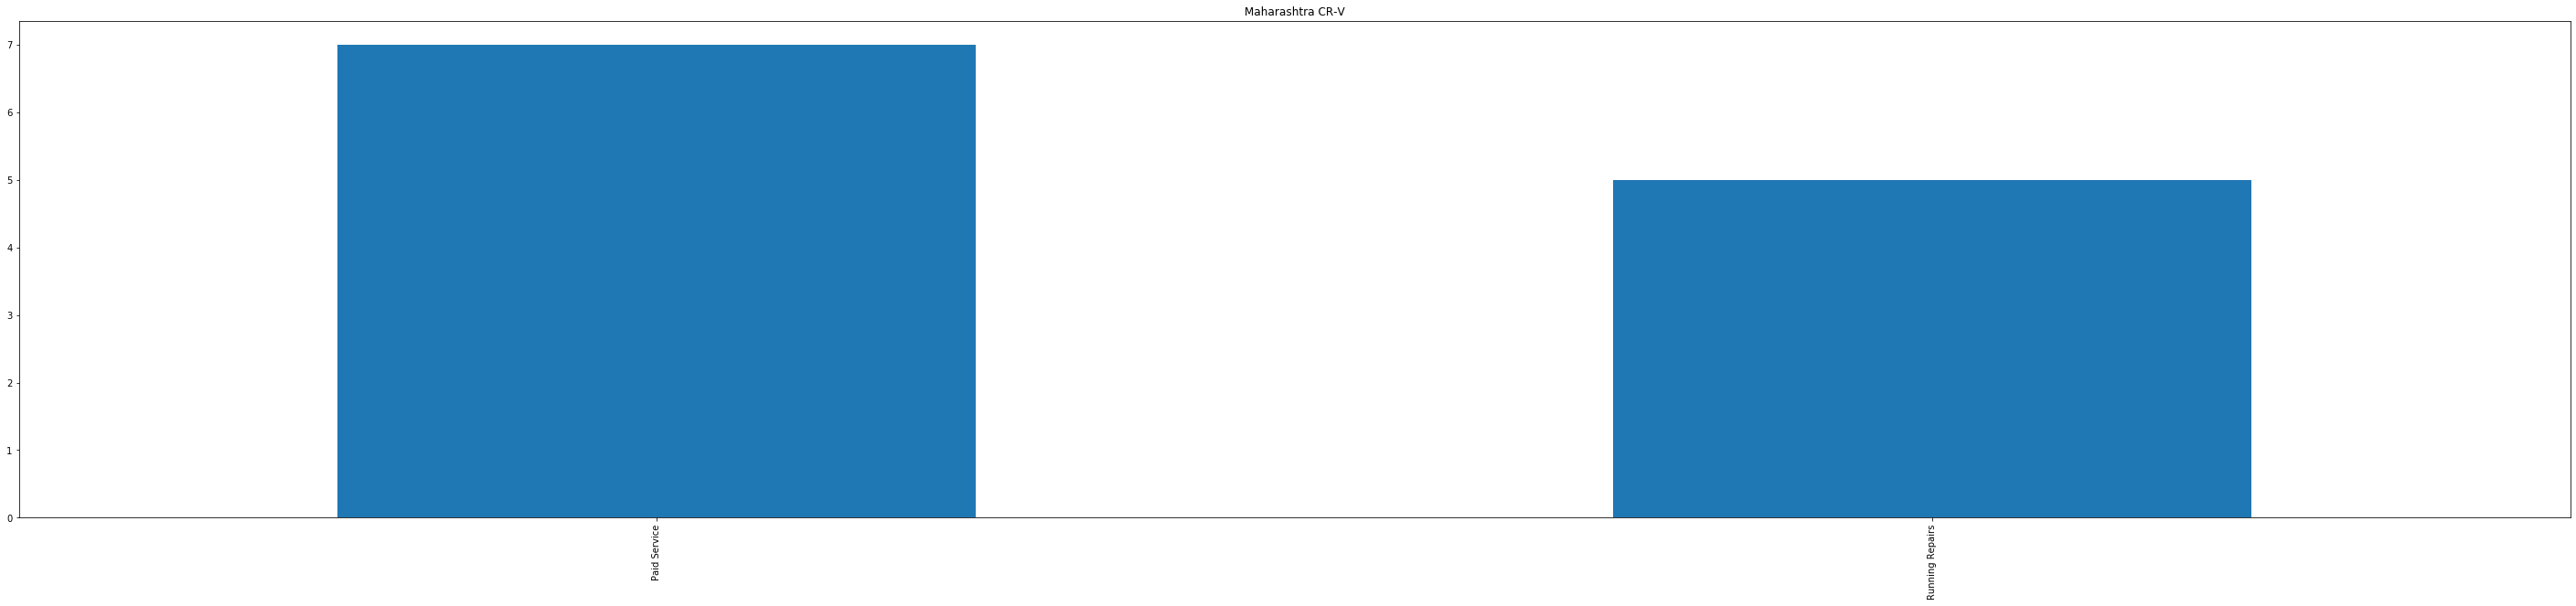

CIELO


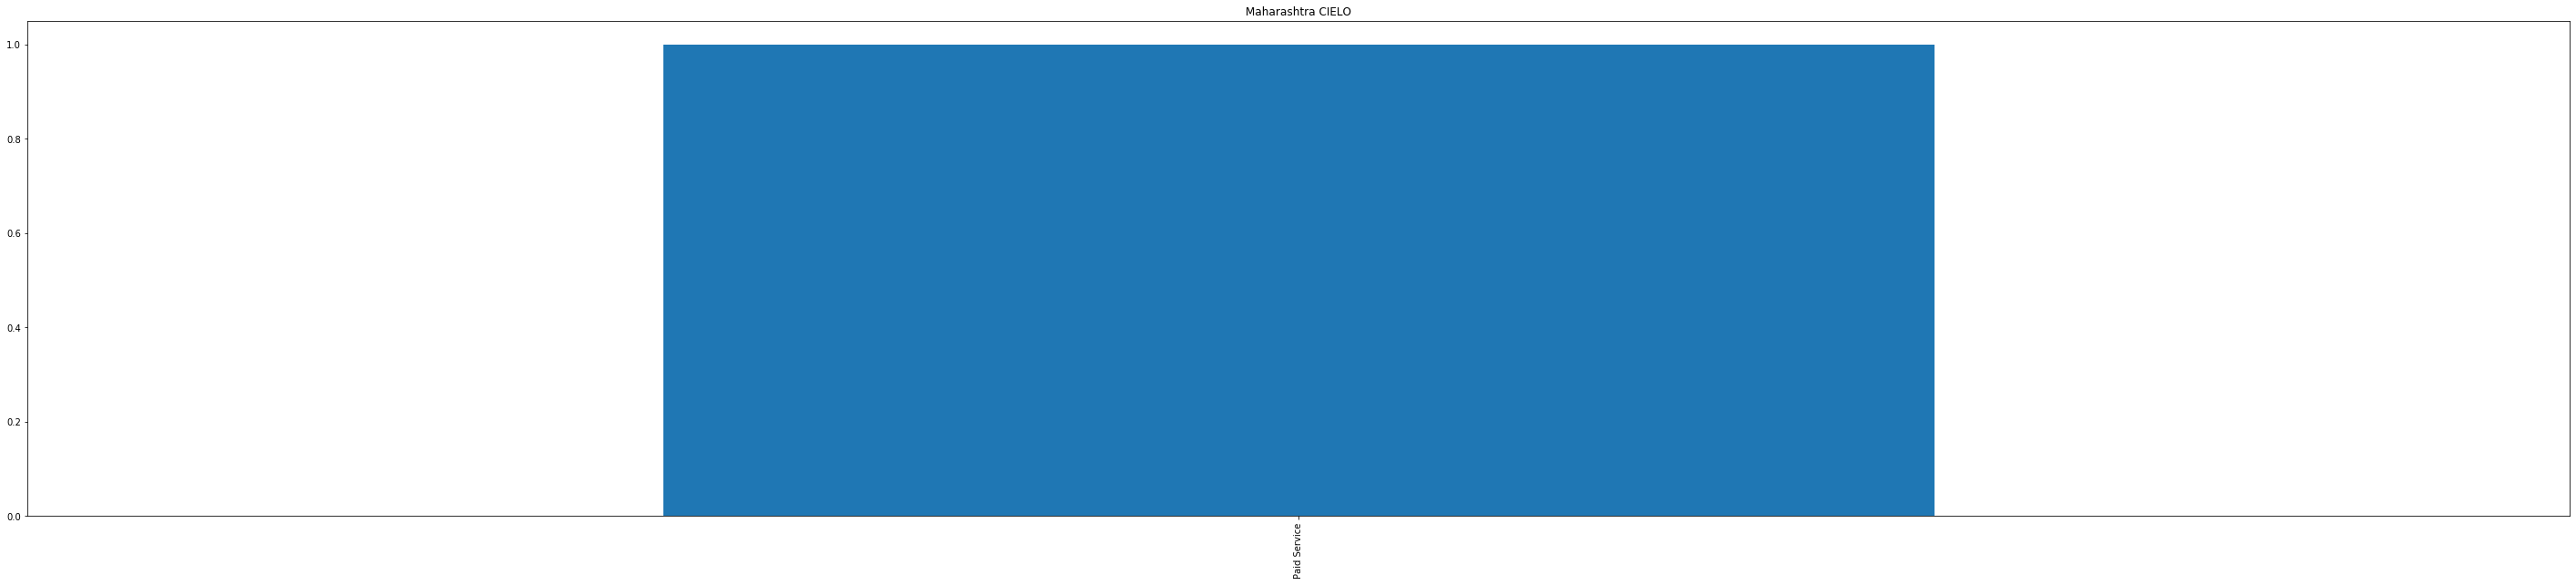

QUANTO


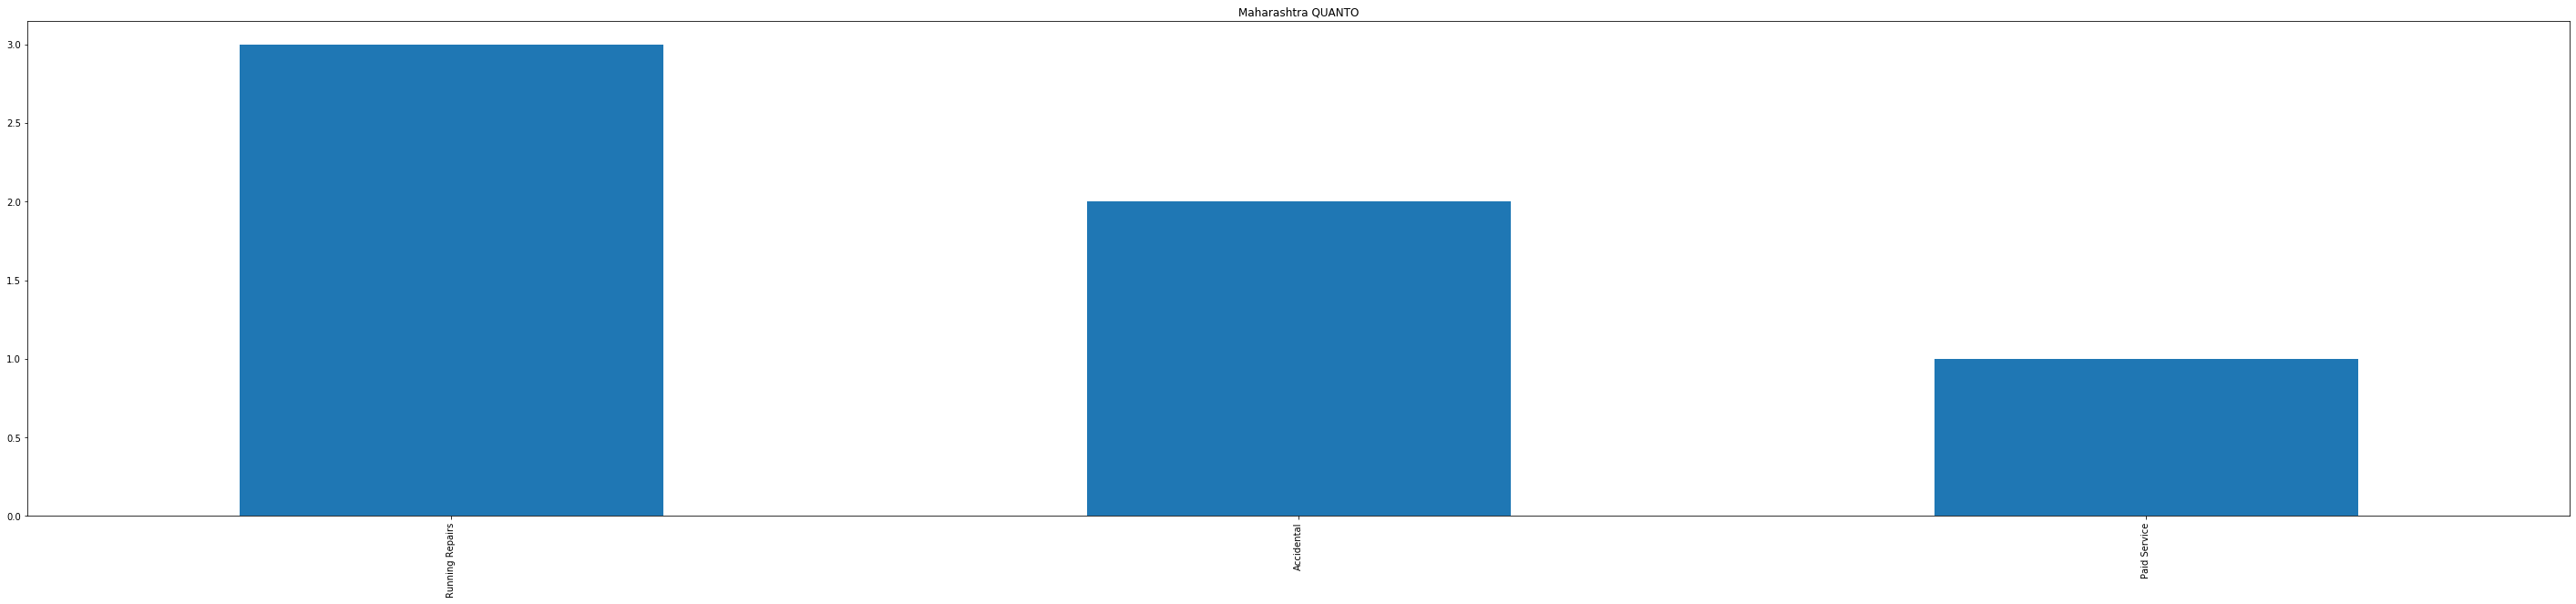

CL-CLASS


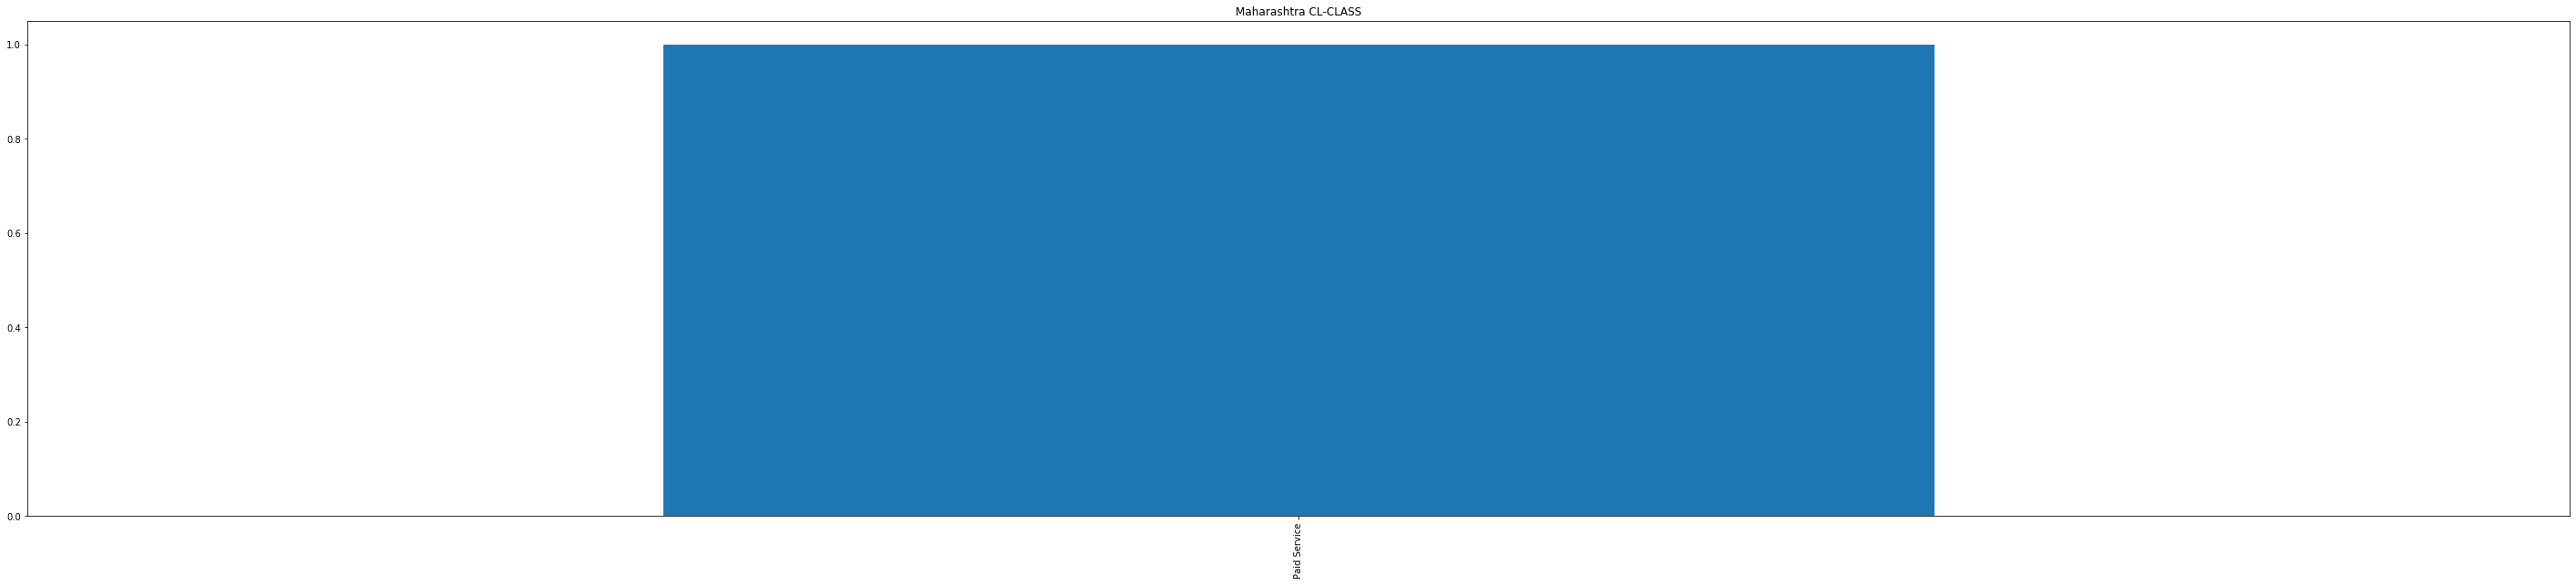

MAXX


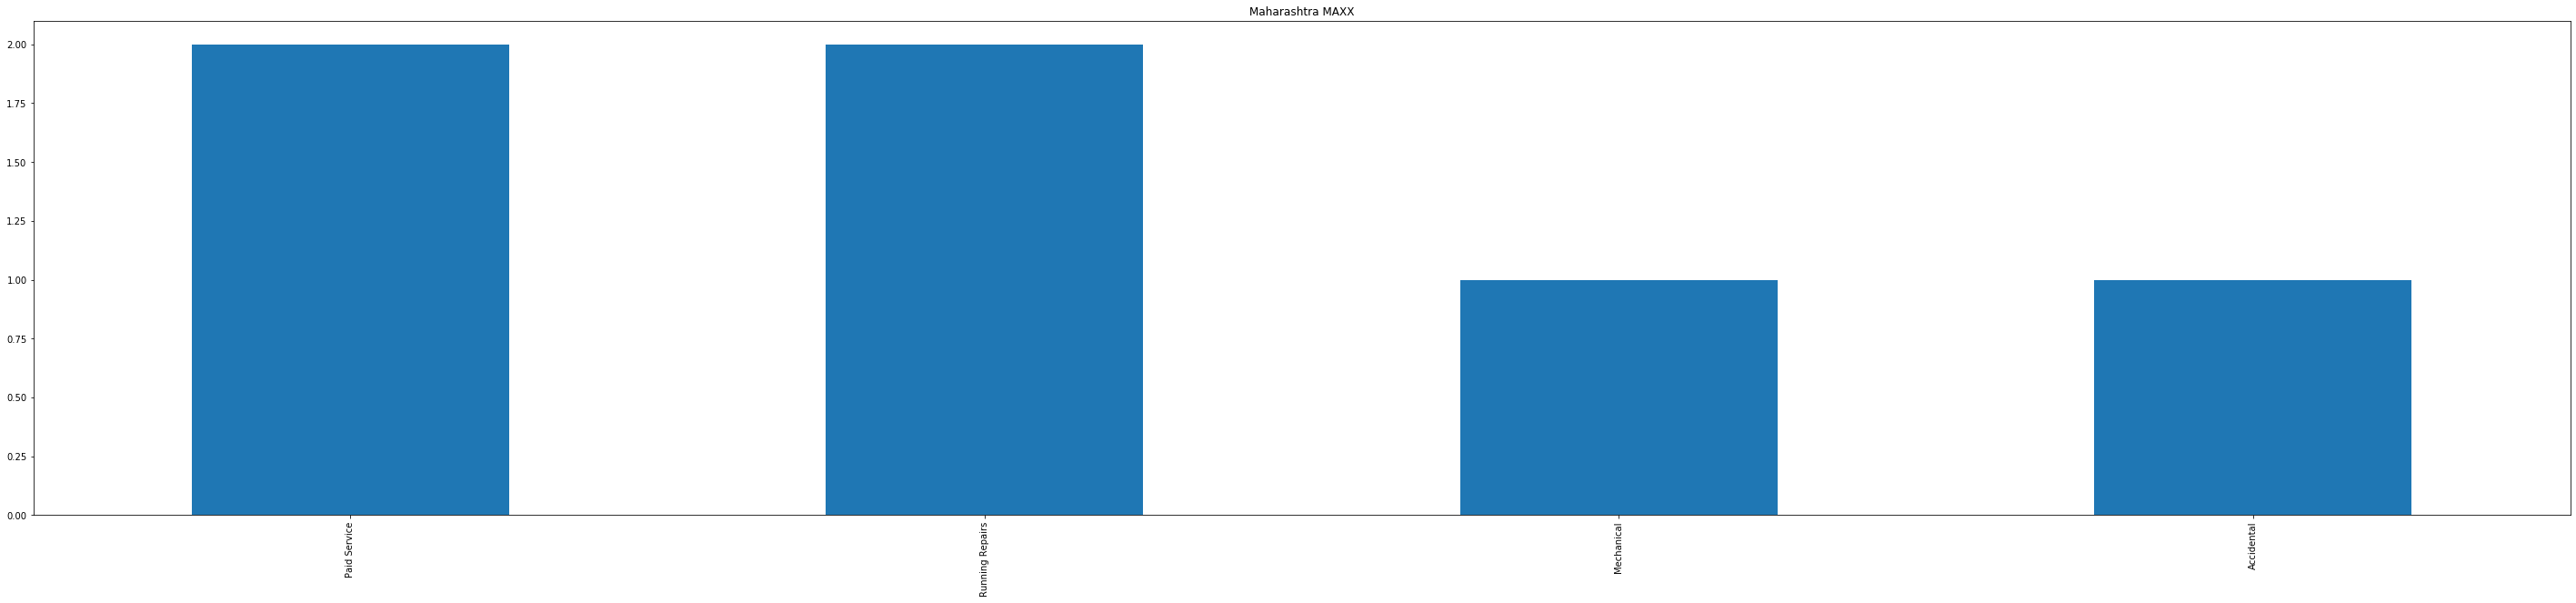

OPEL CORSA


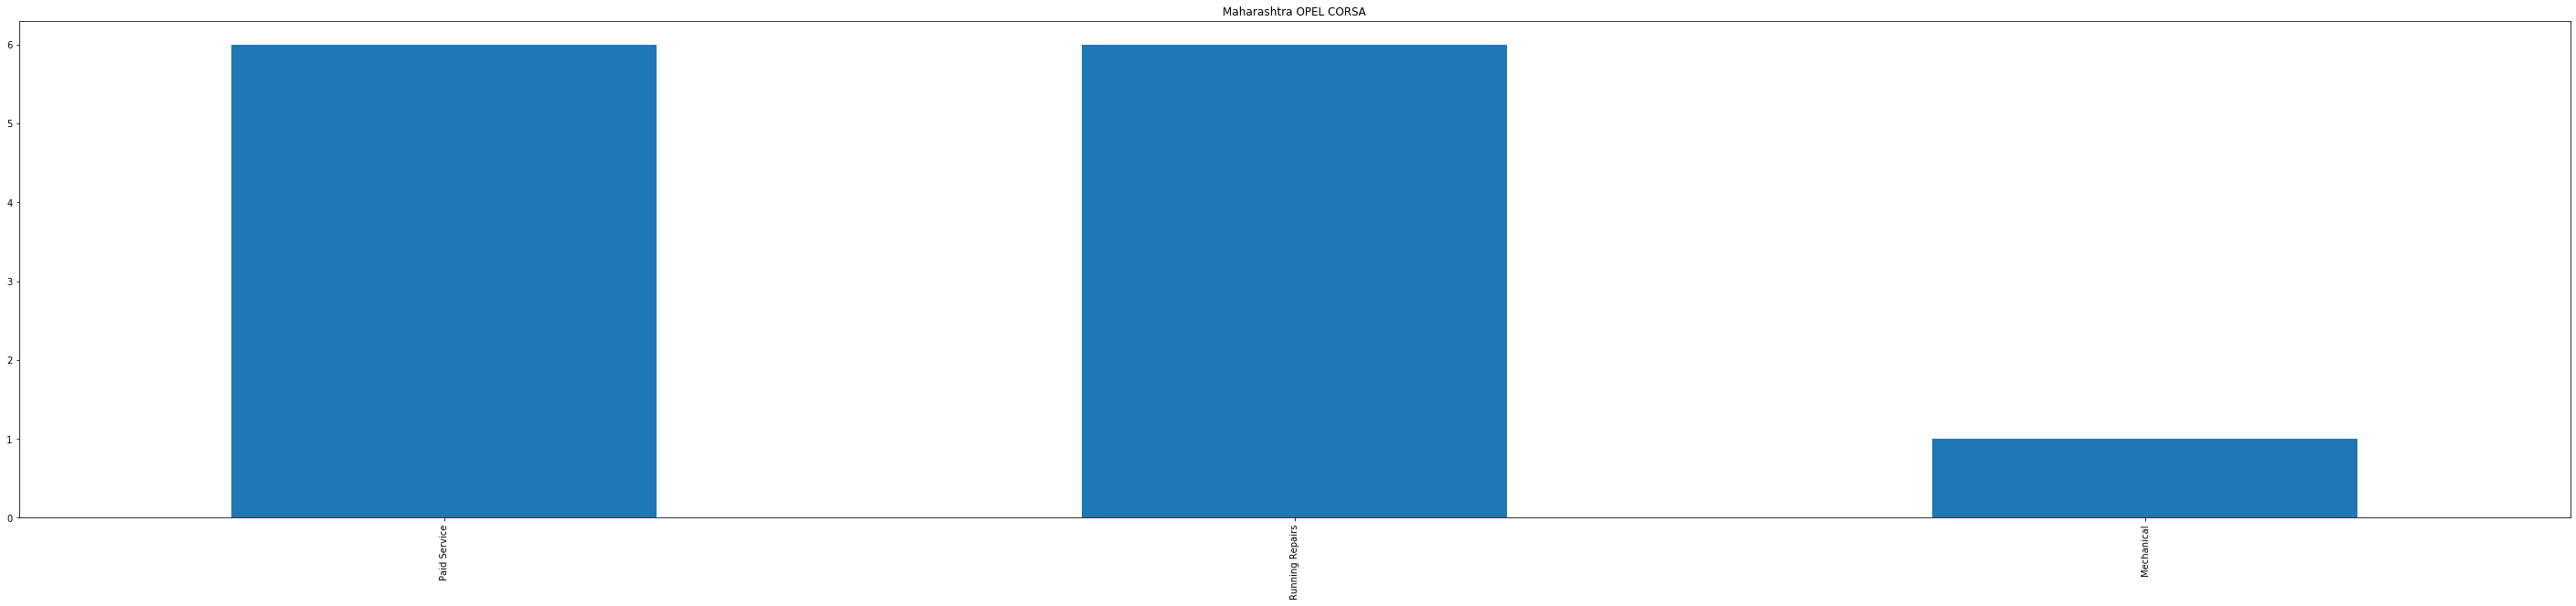

CHEVROLET CRUZE


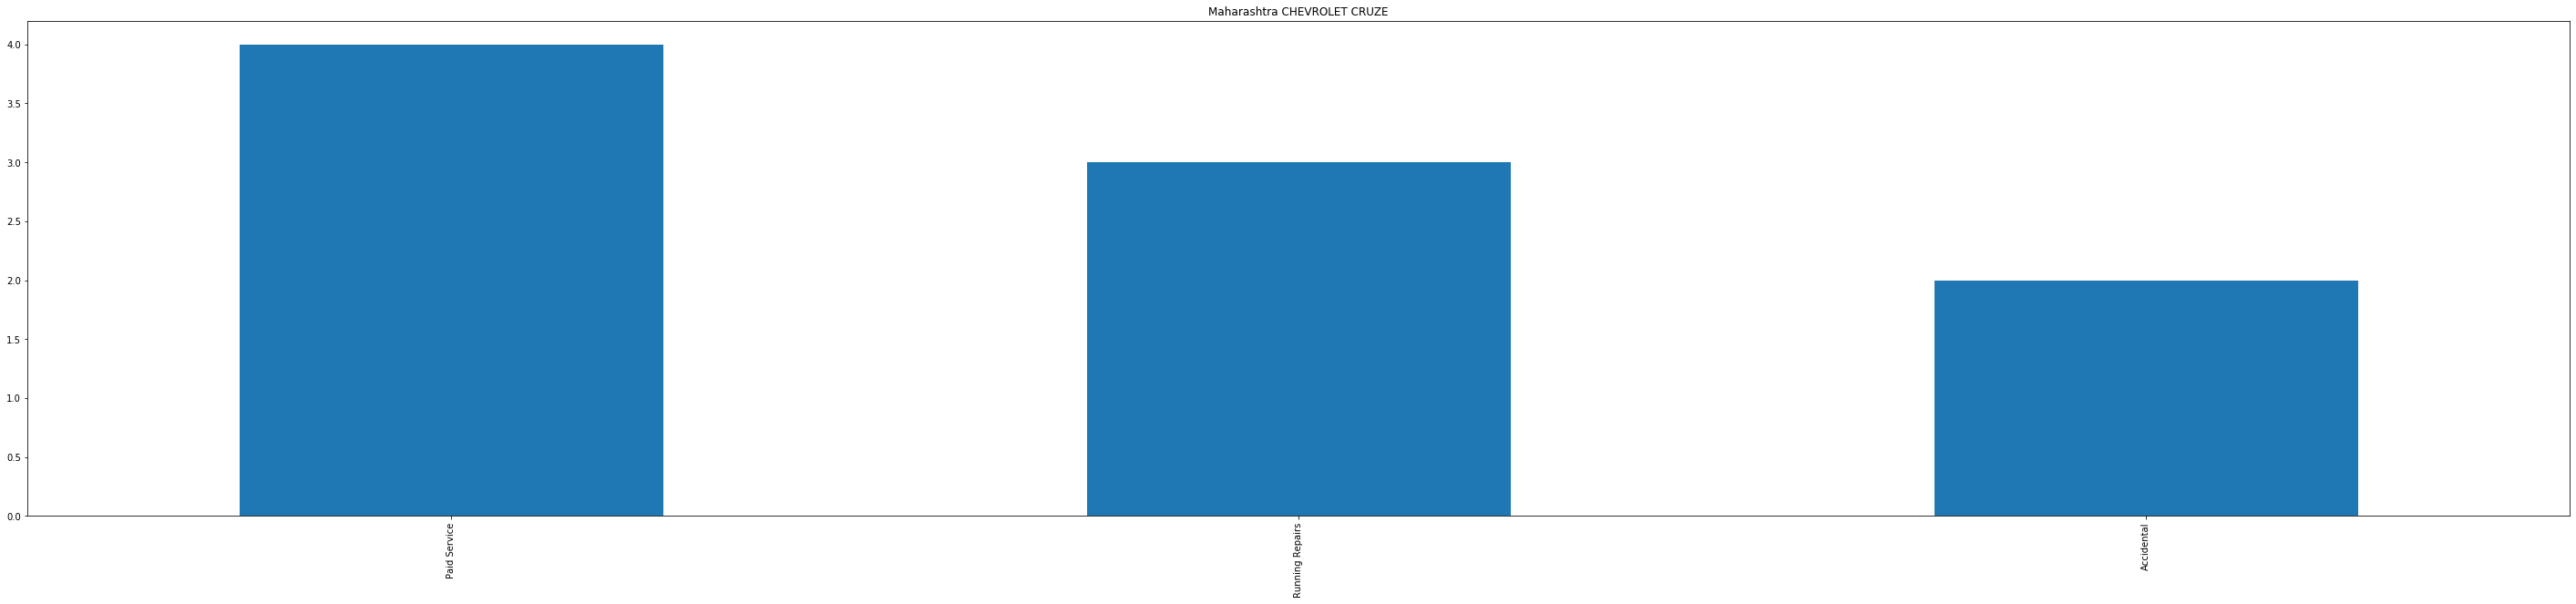

GRAND PUNTO


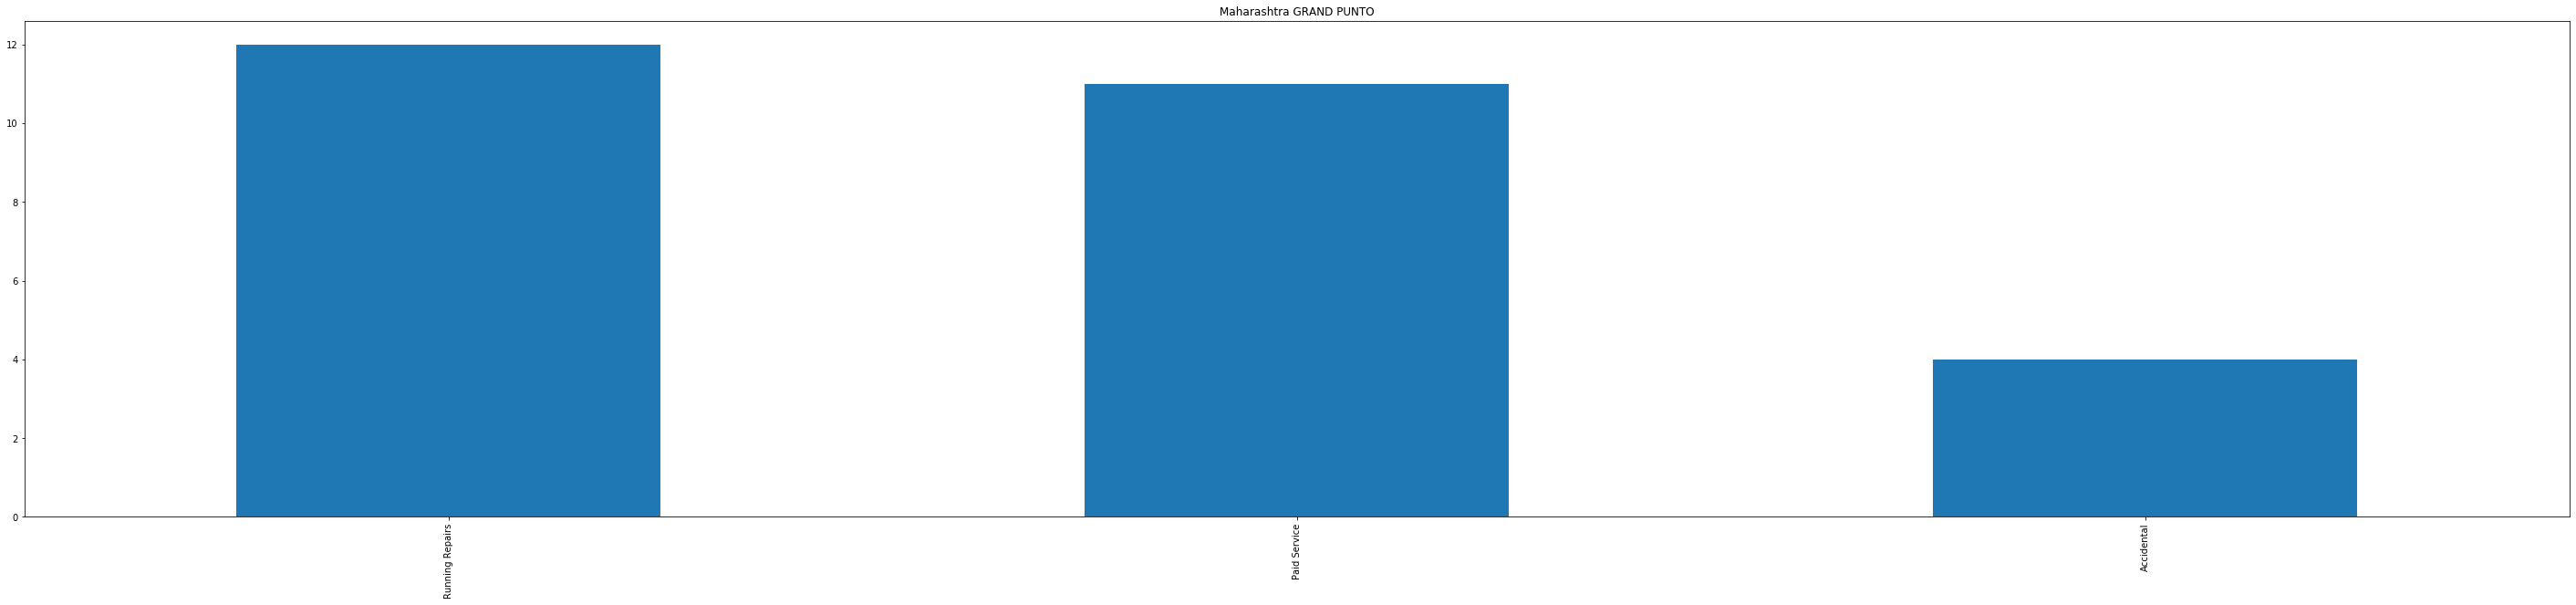

ENDEAVOUR


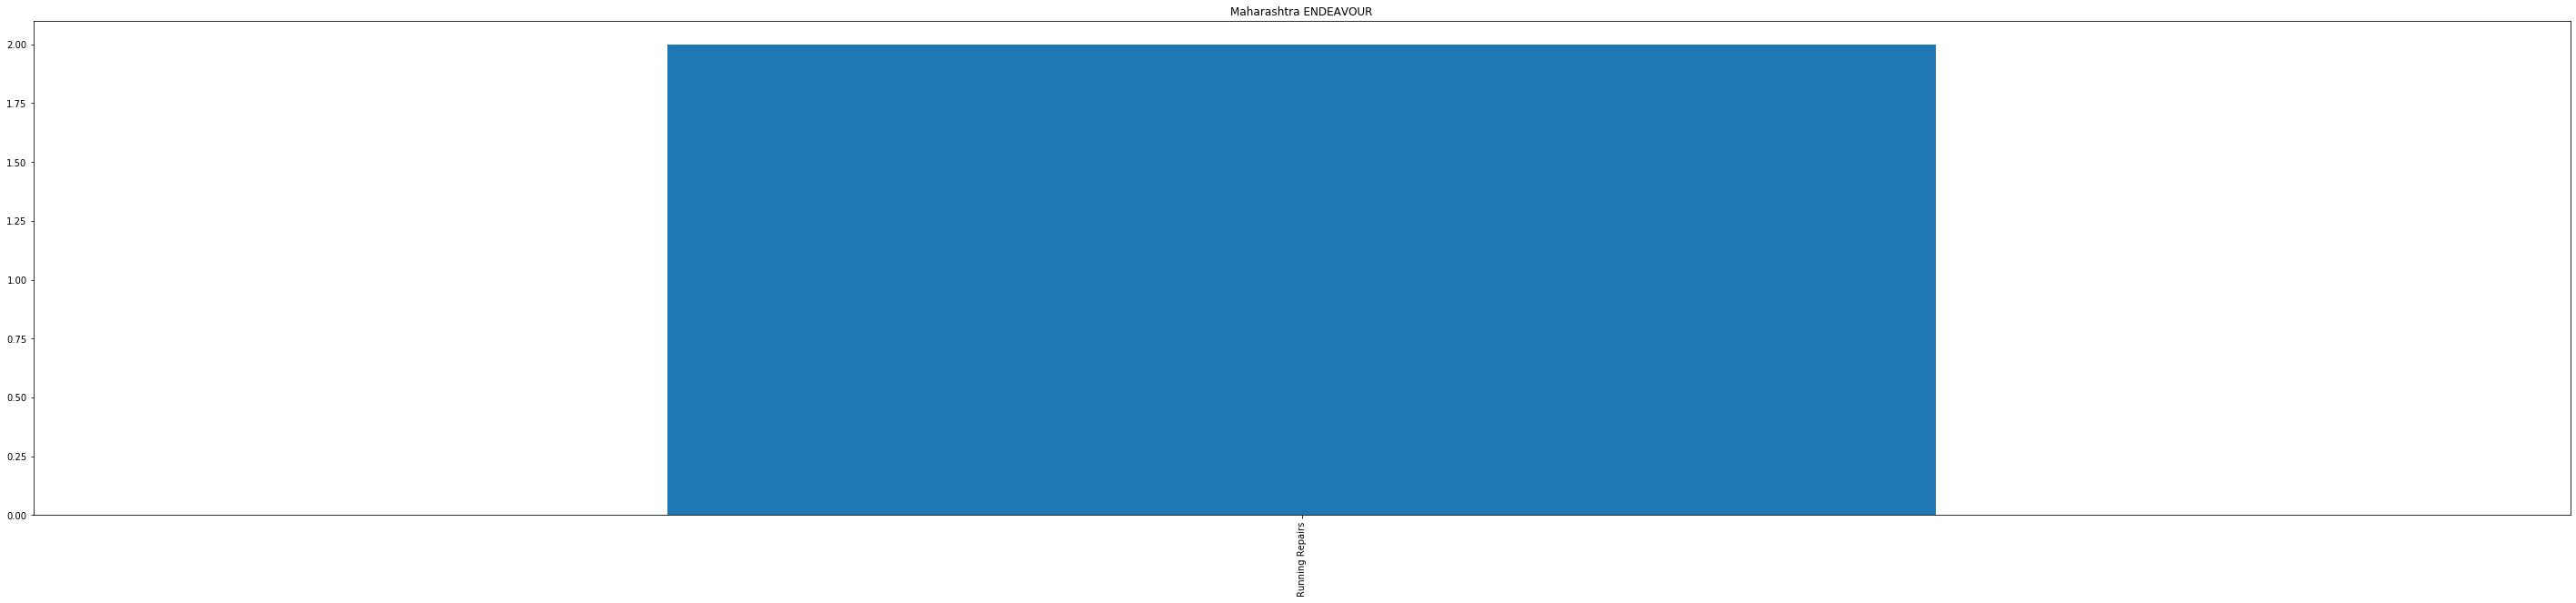

CIAZ


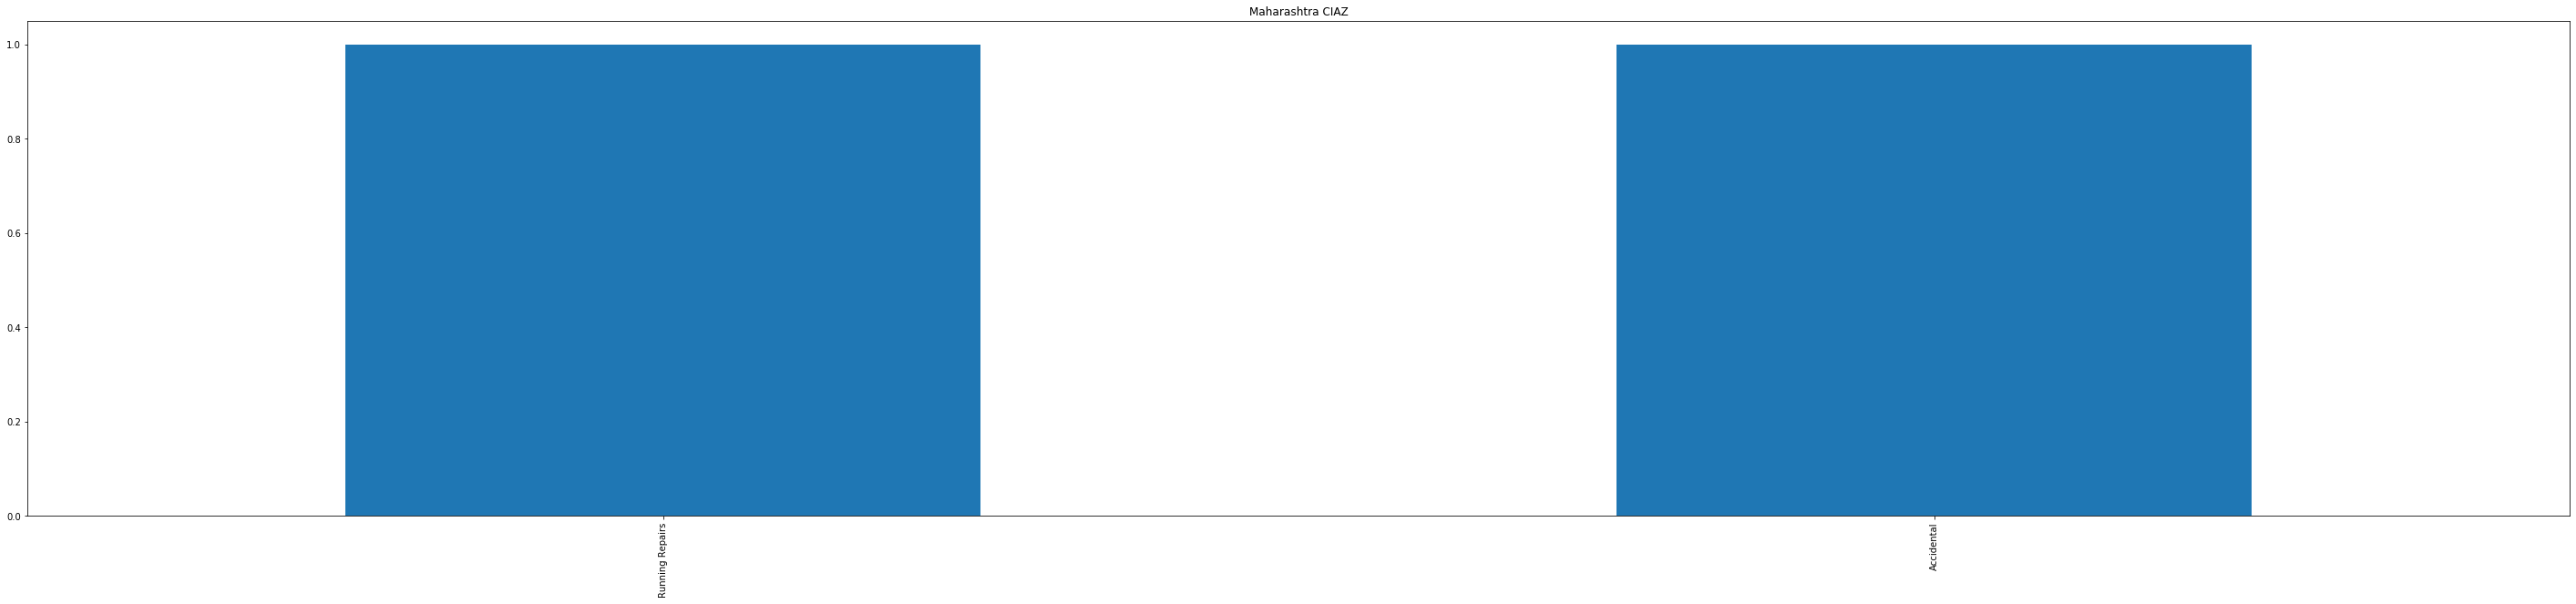

INDIGO MARINA


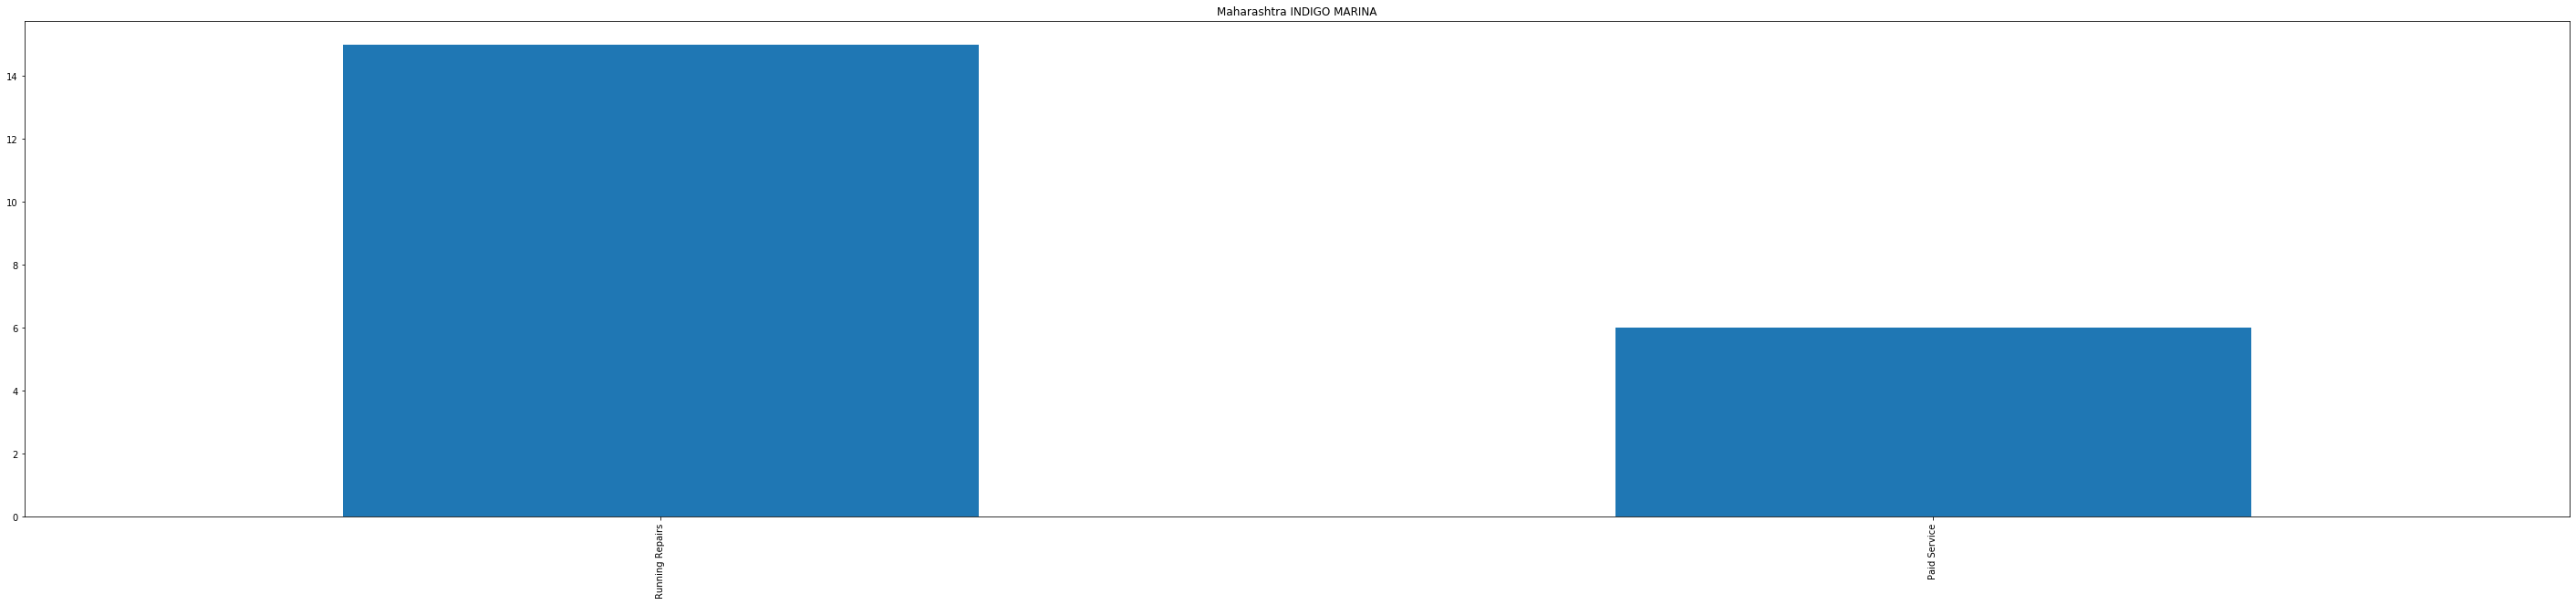

OPTRA MAGNUM


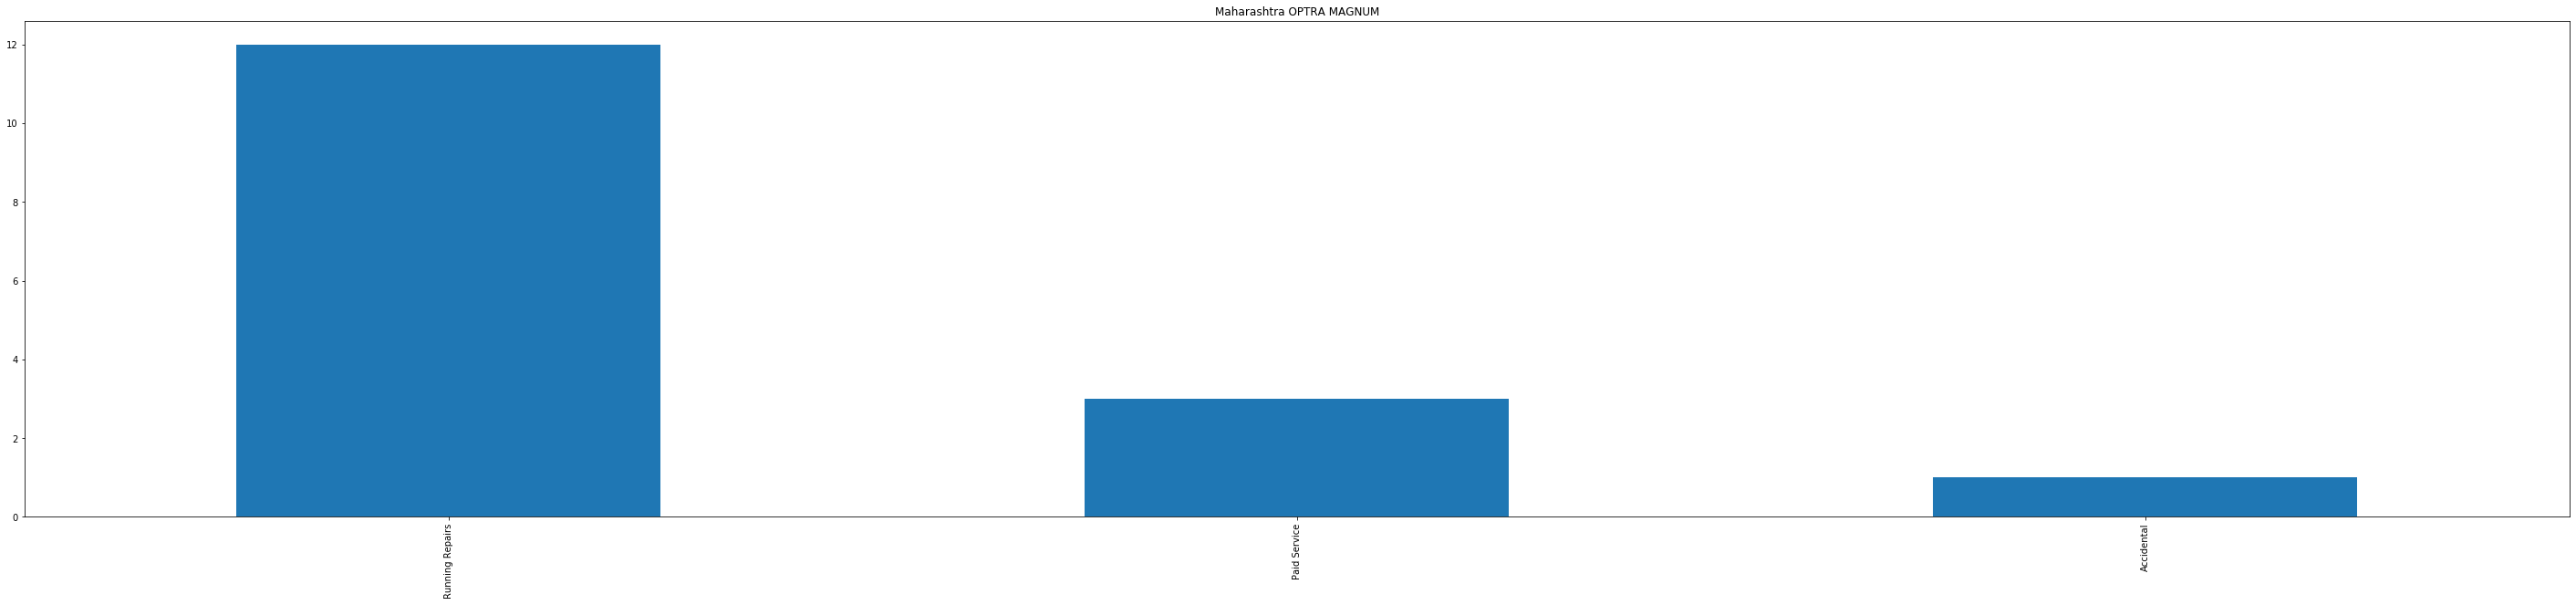

OPEL


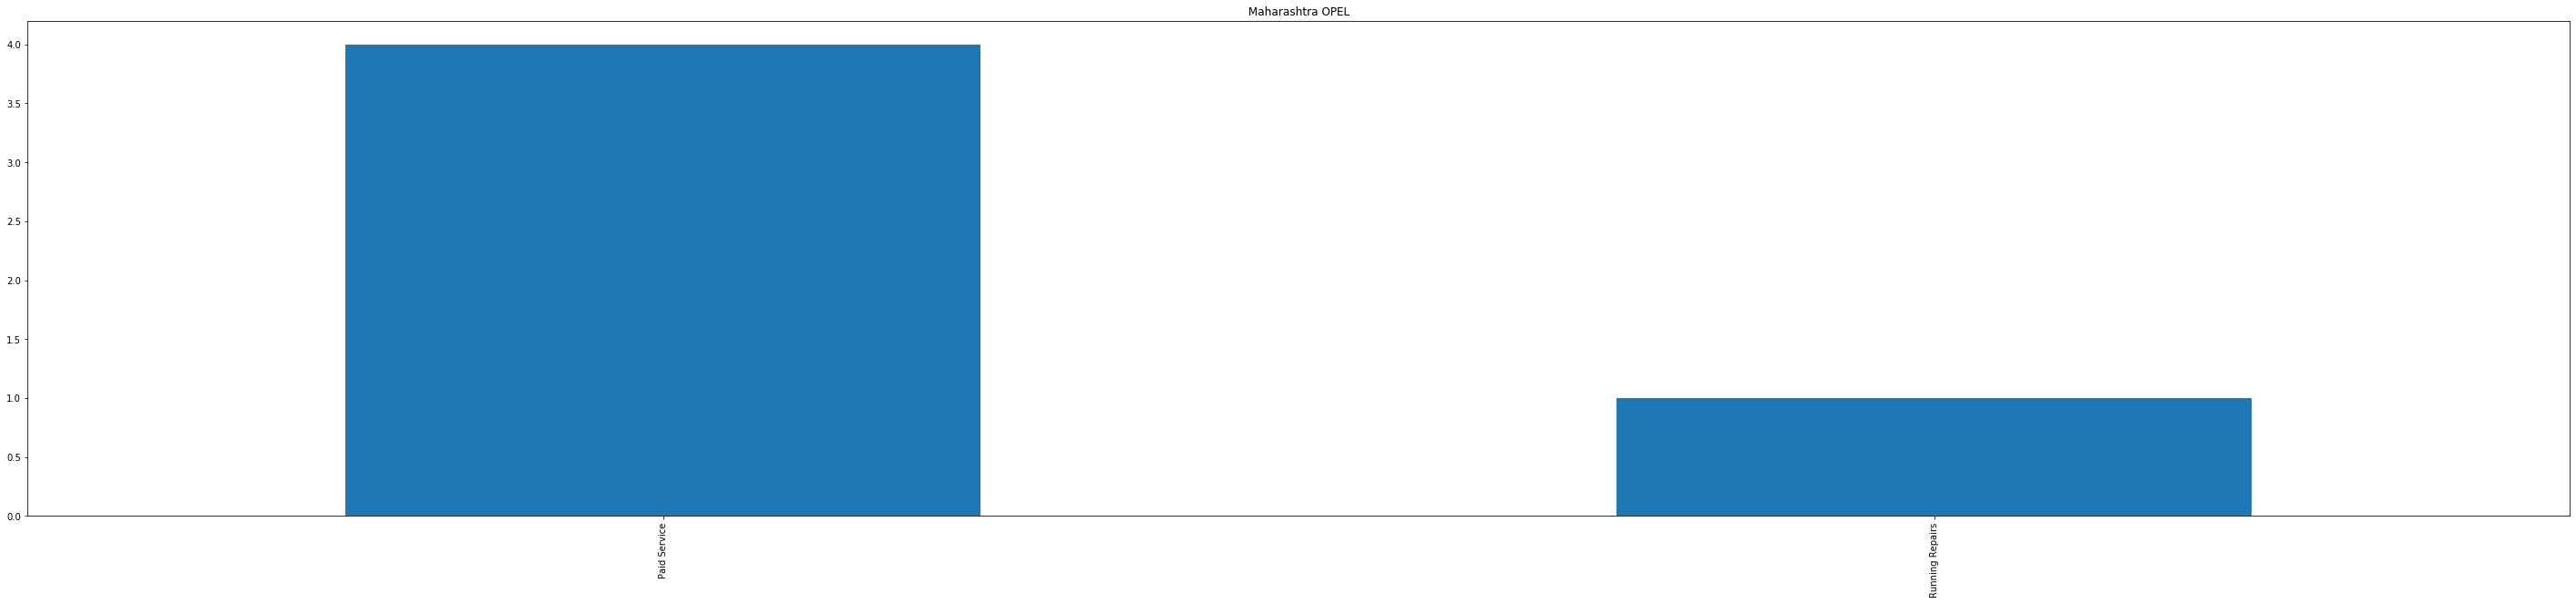

BMW-M3


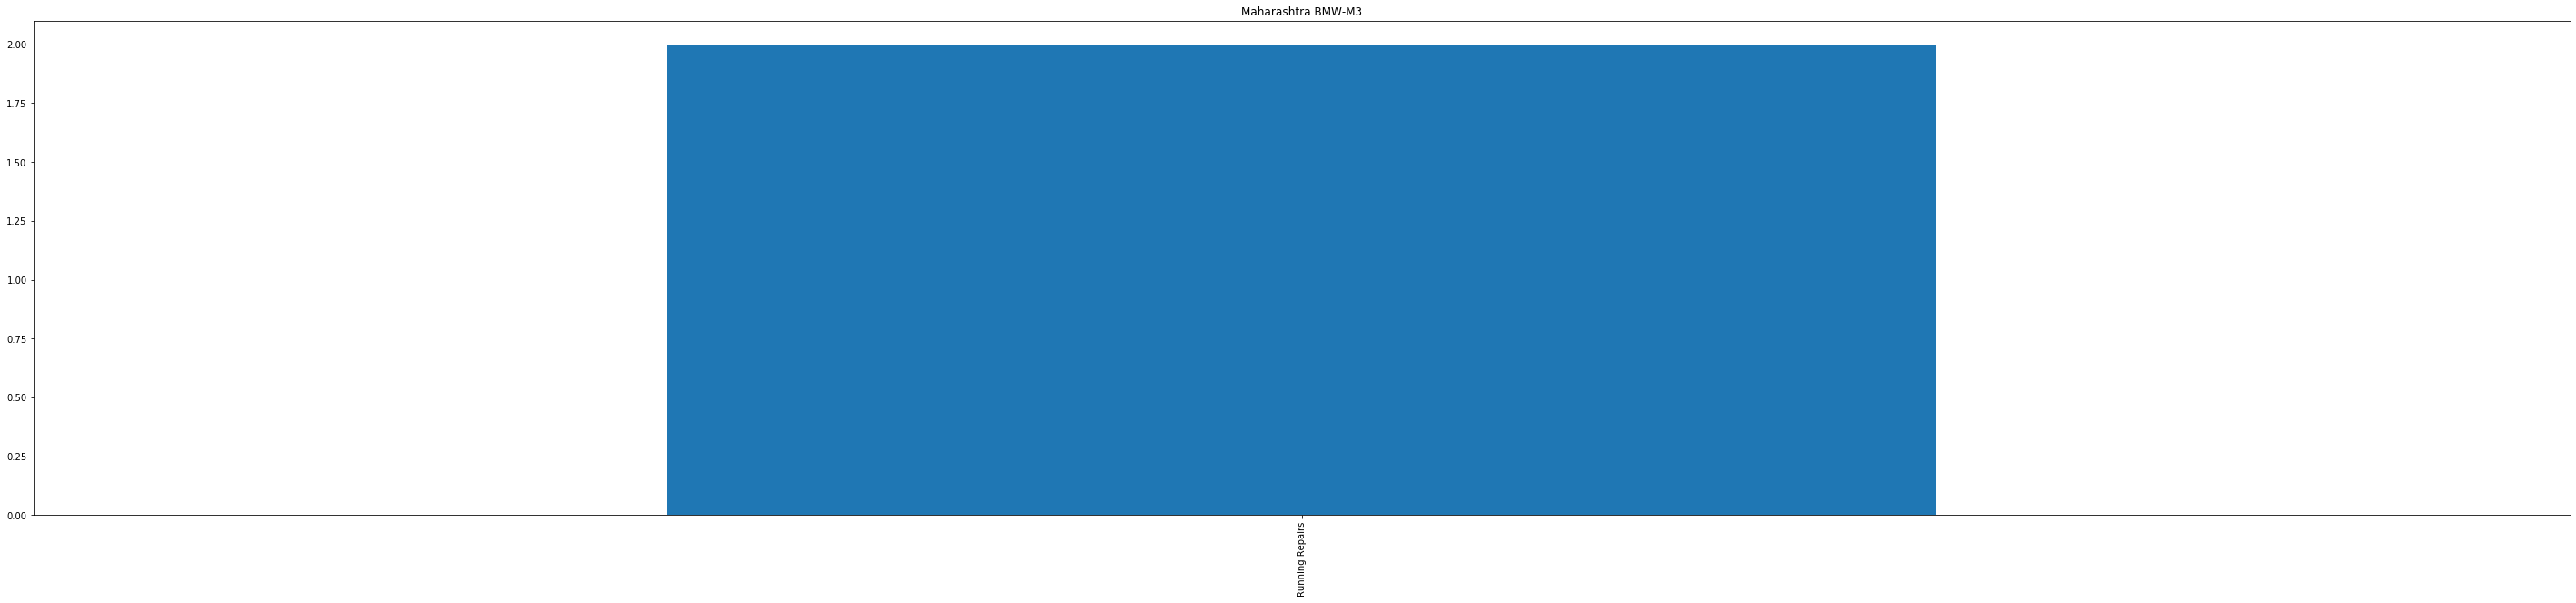

VERSA


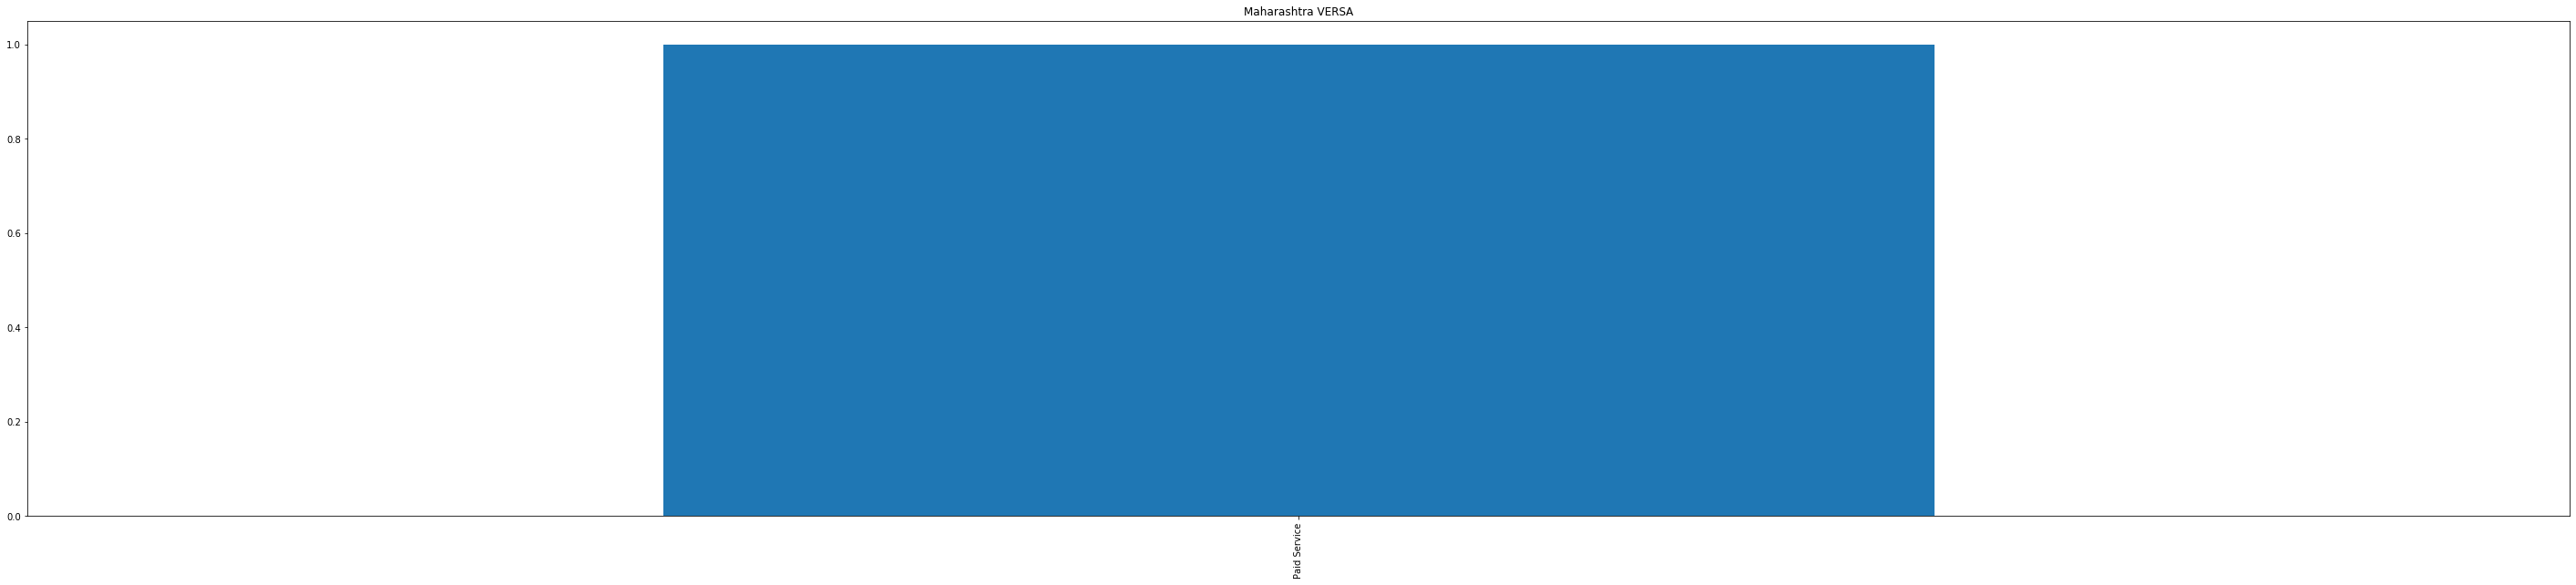

NANO


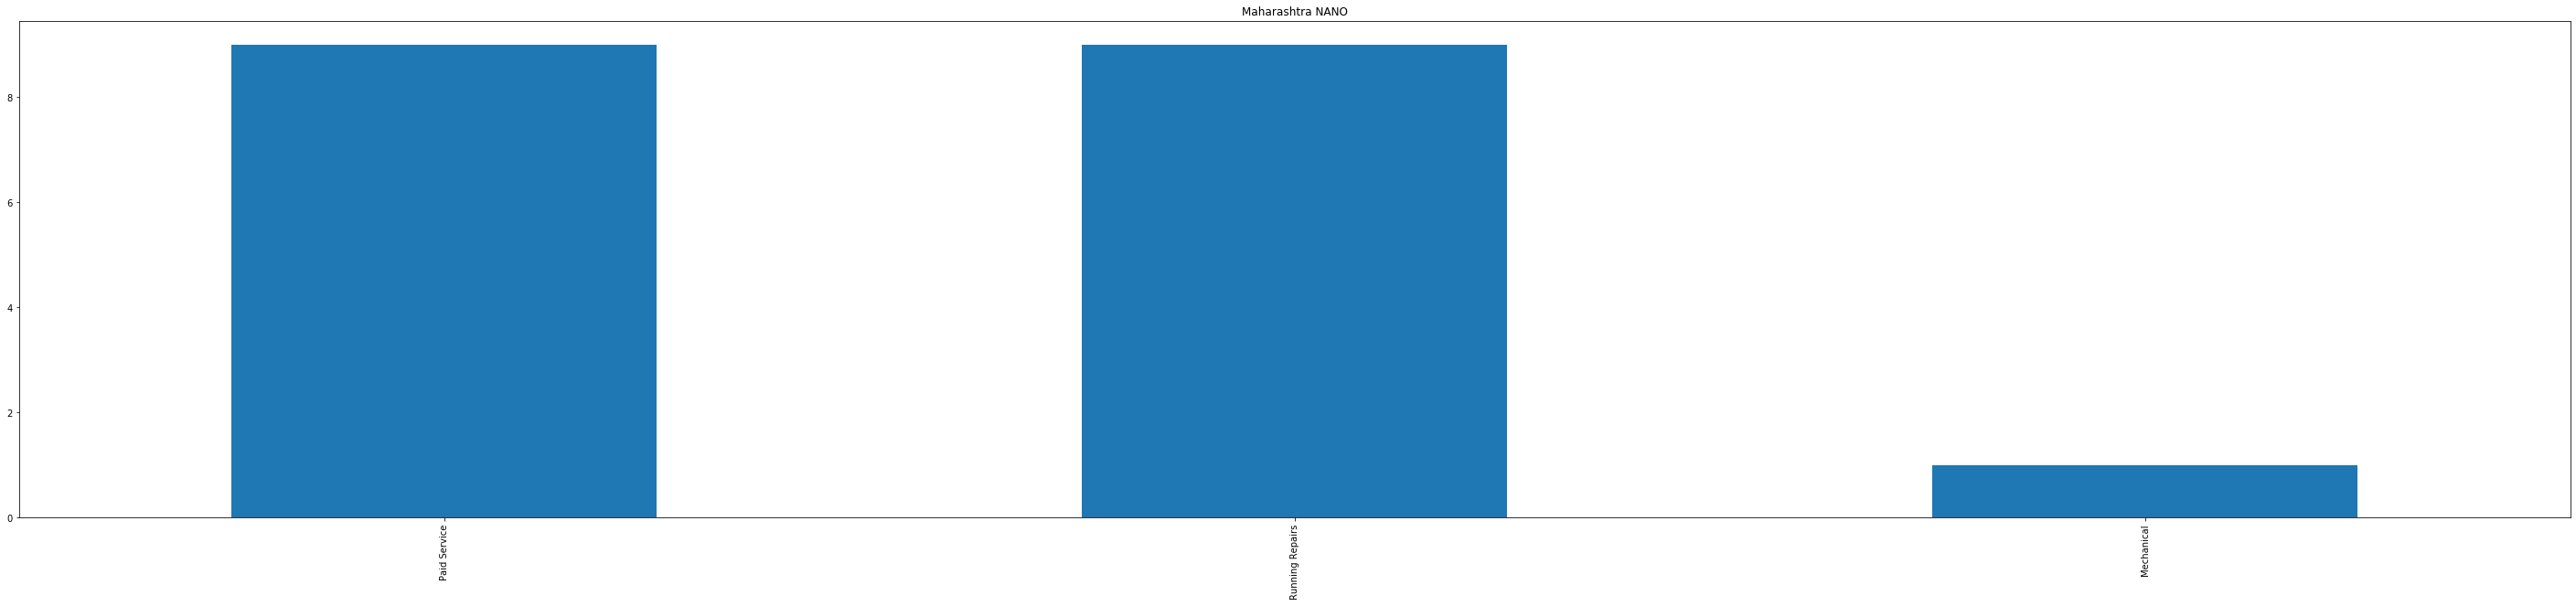

ERTIGA


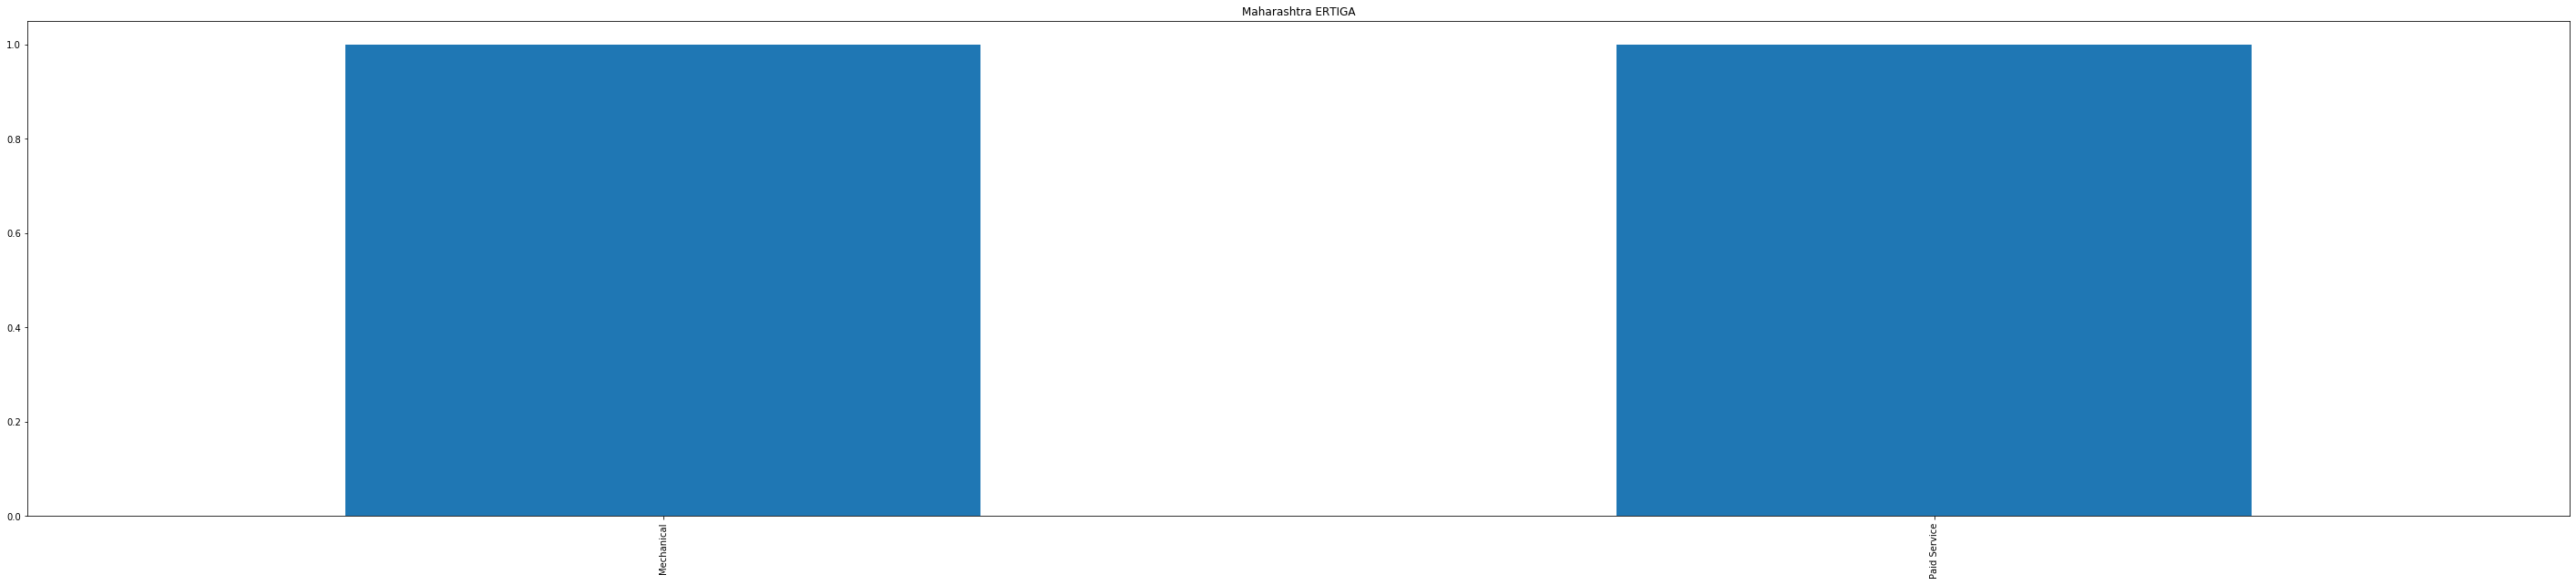

JETTA


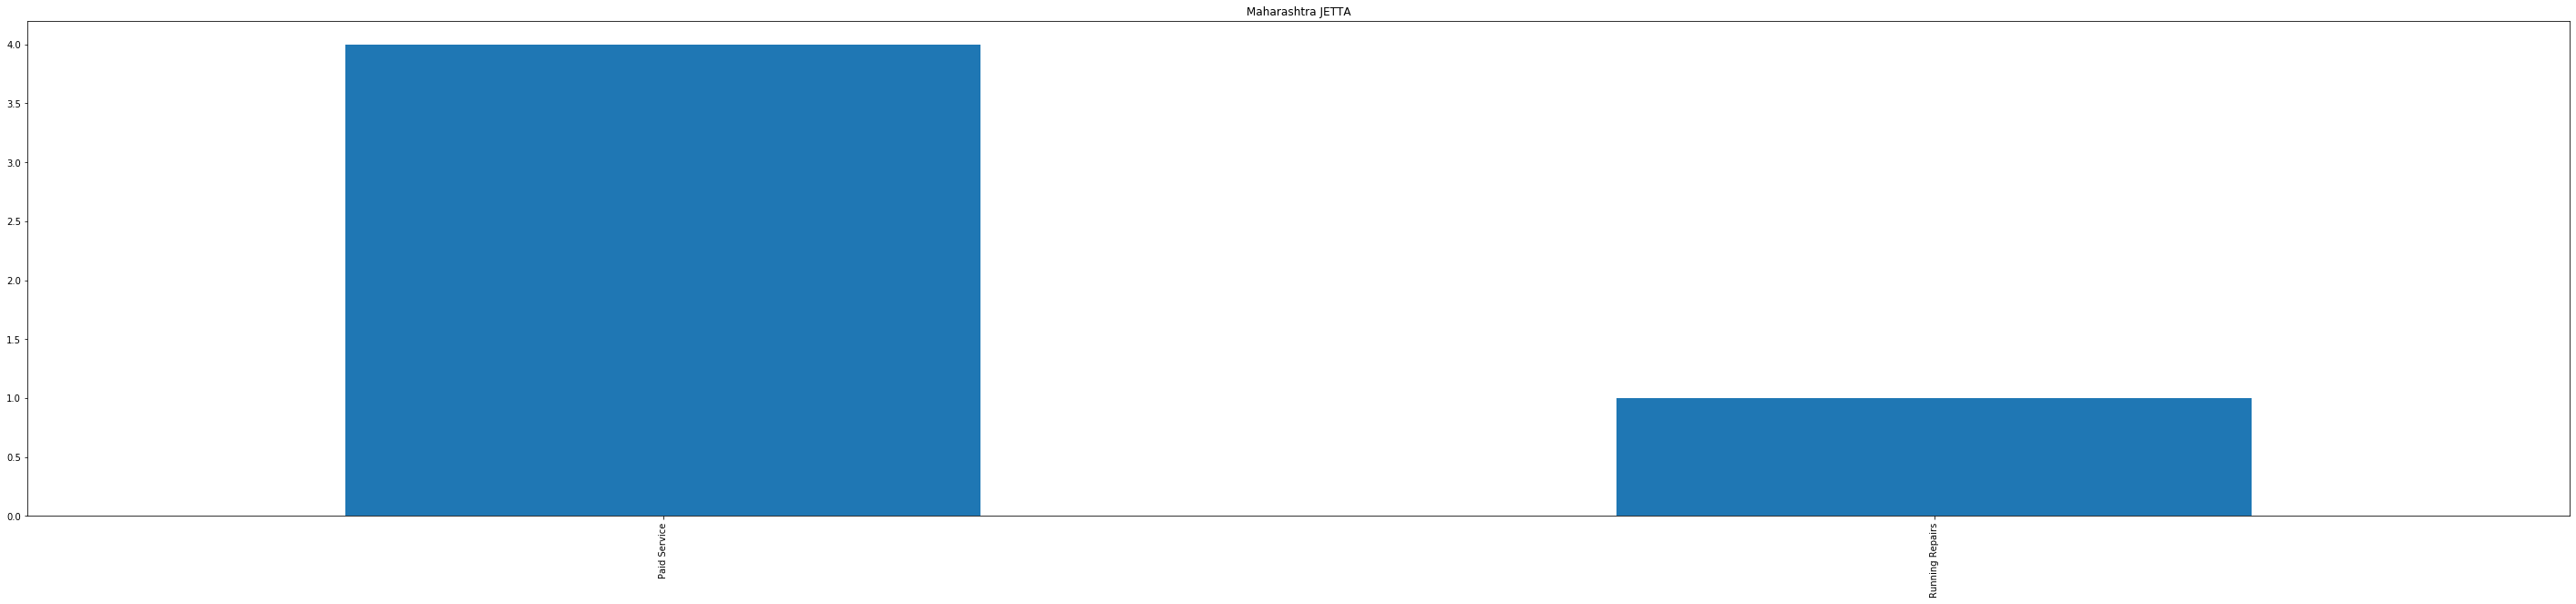

BEAT


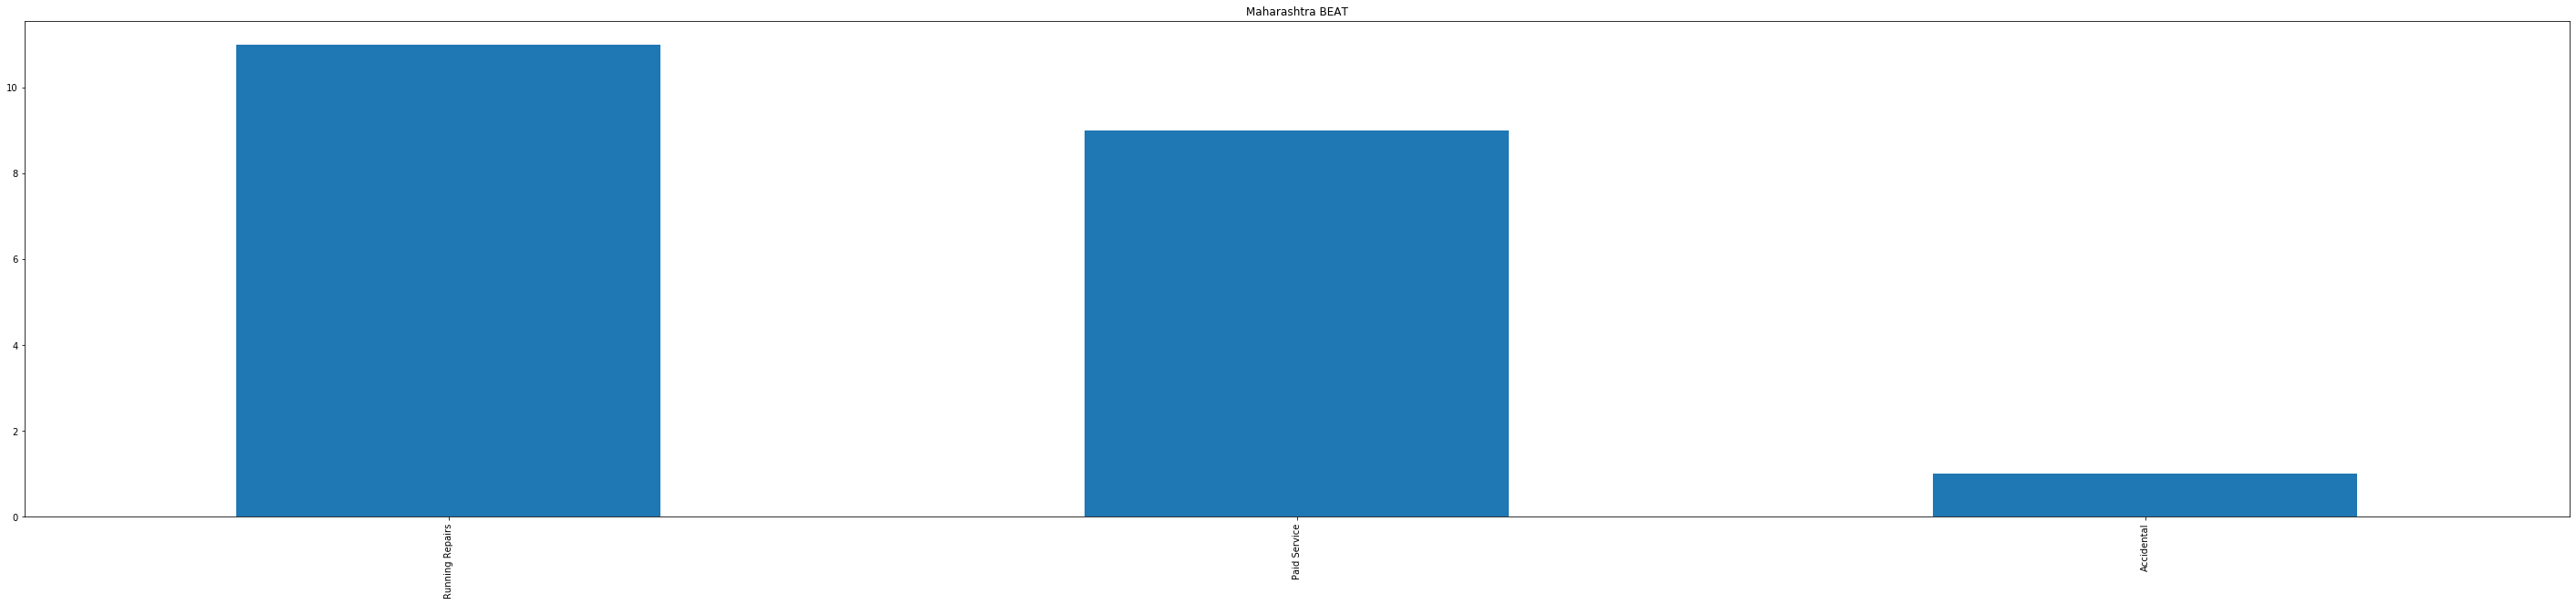

PULSE


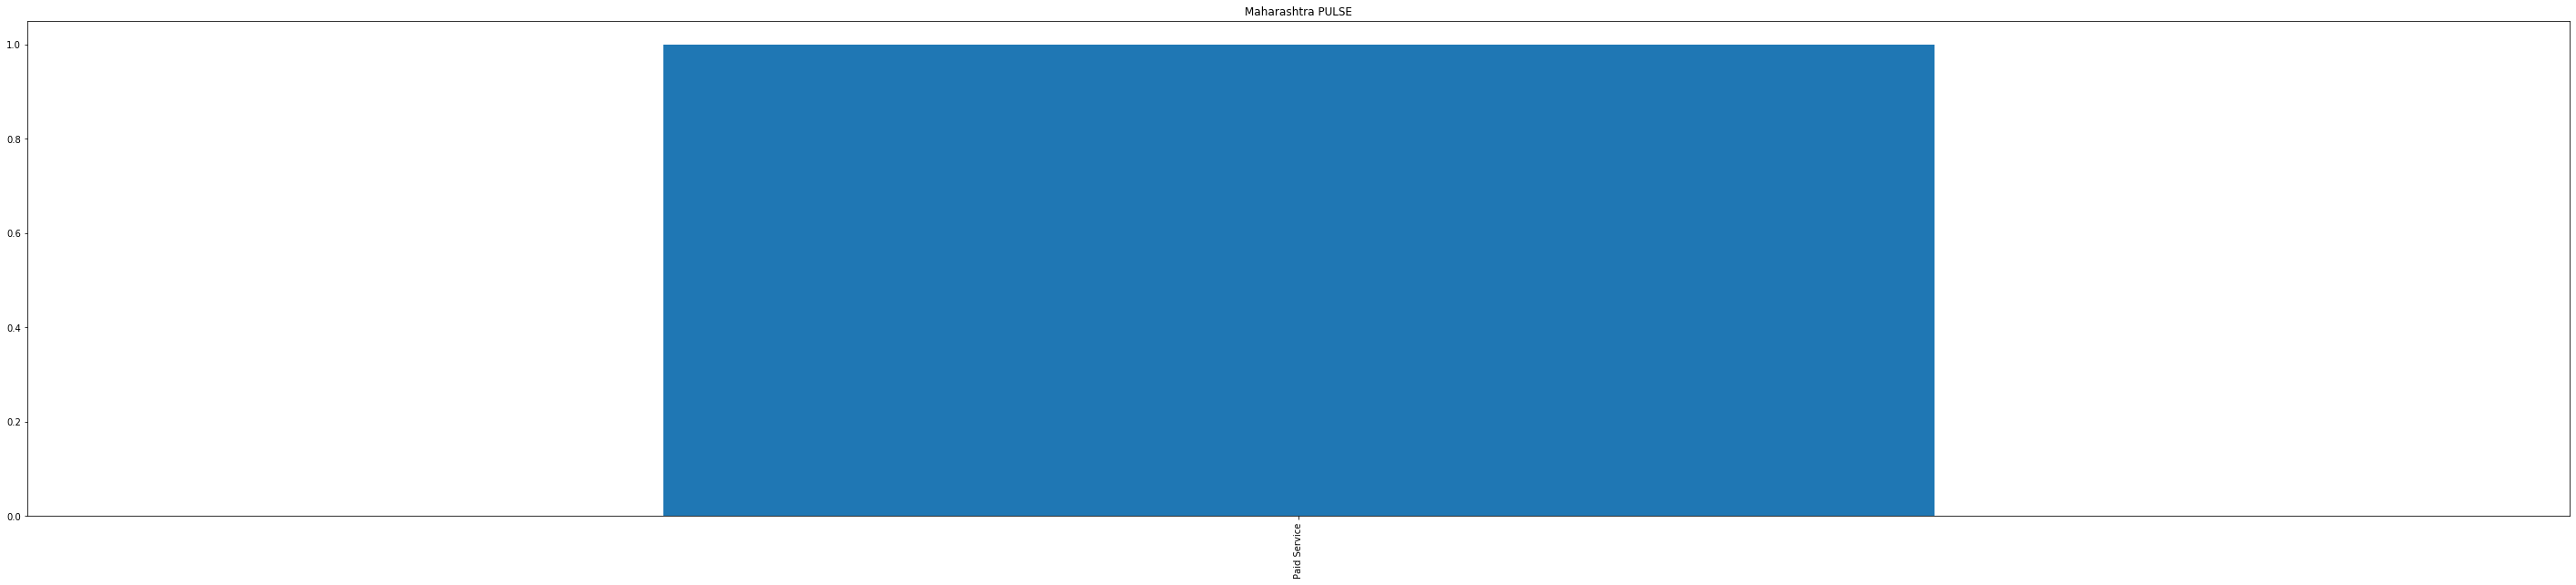

JAZZ


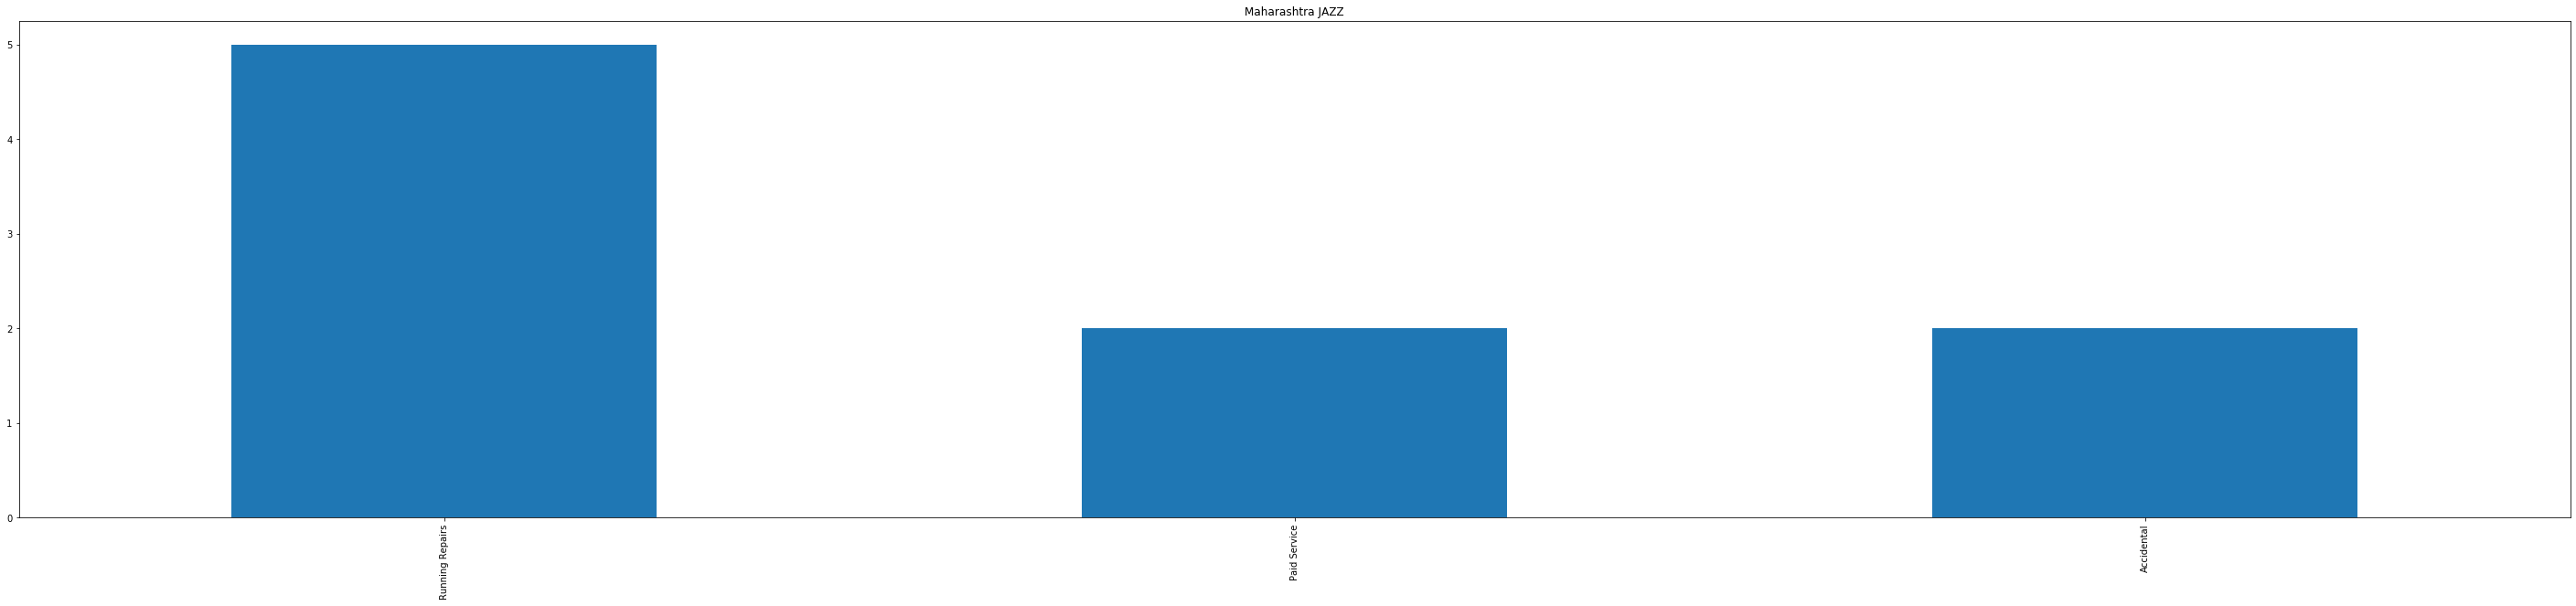

PETRA


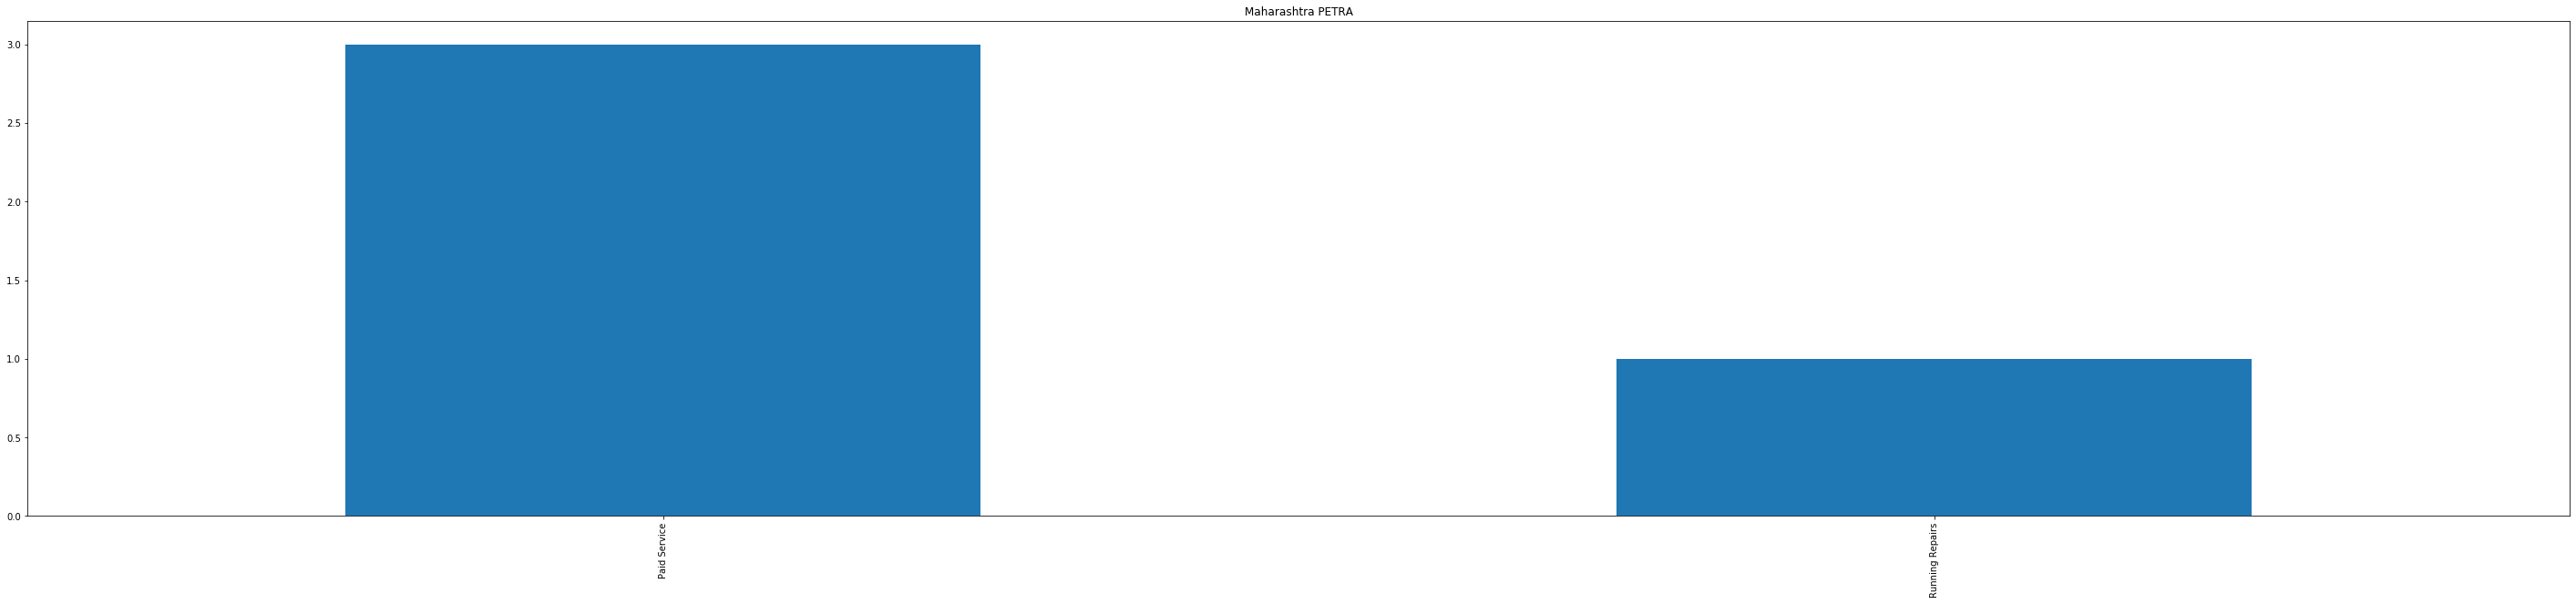

ADVENTURE


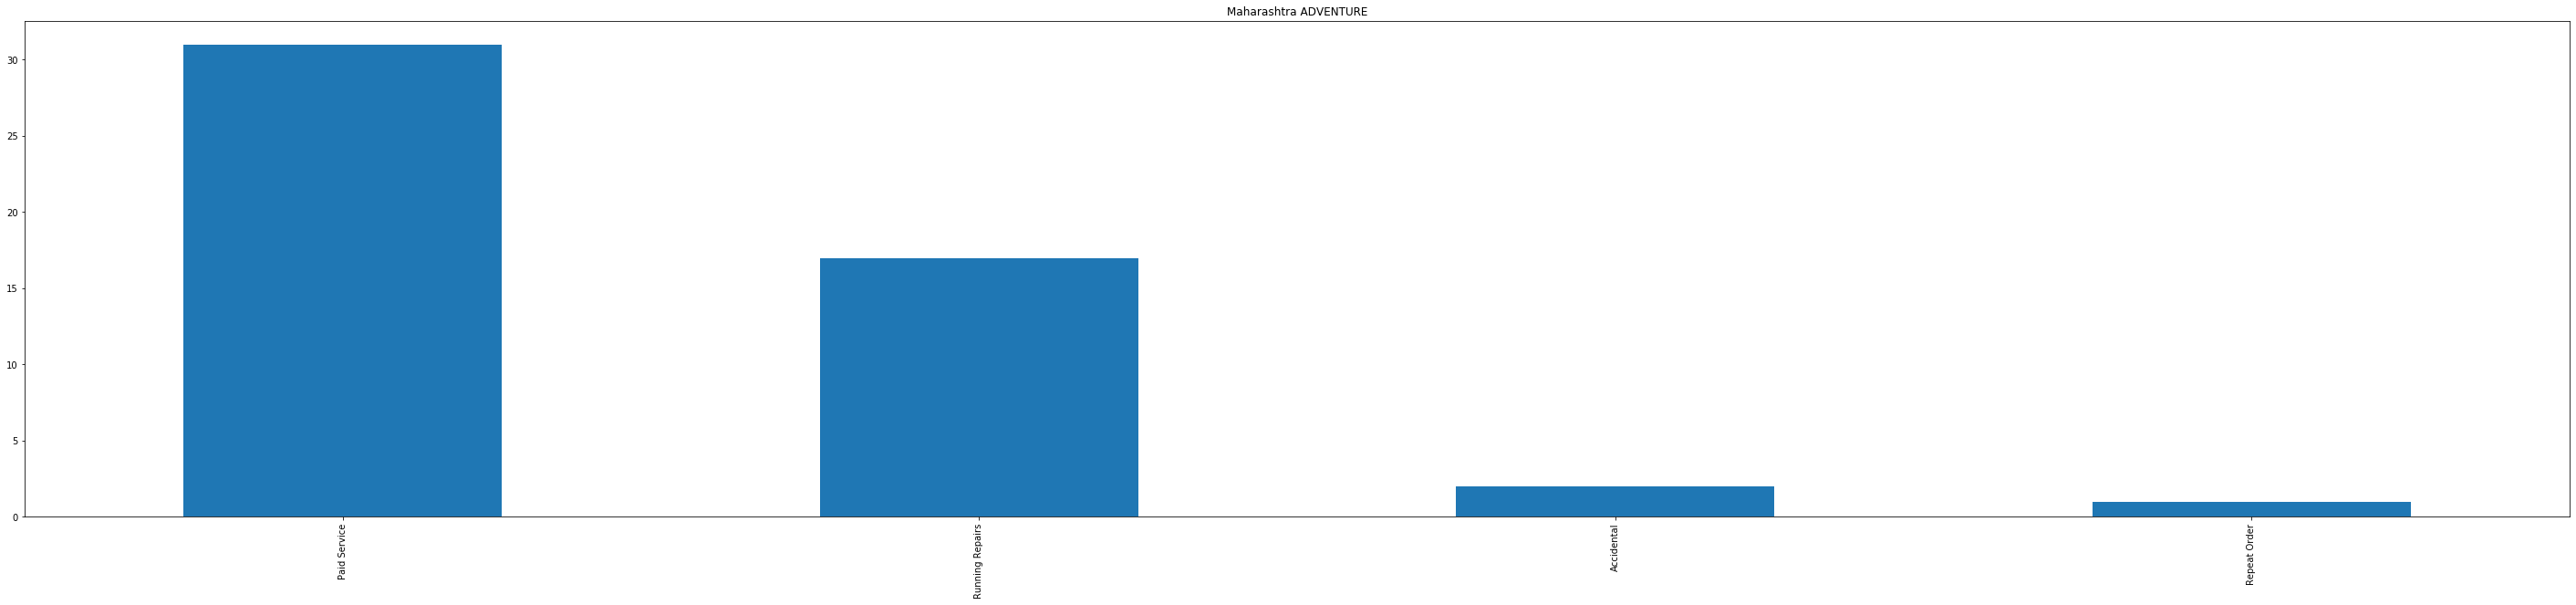

PALIO STILE


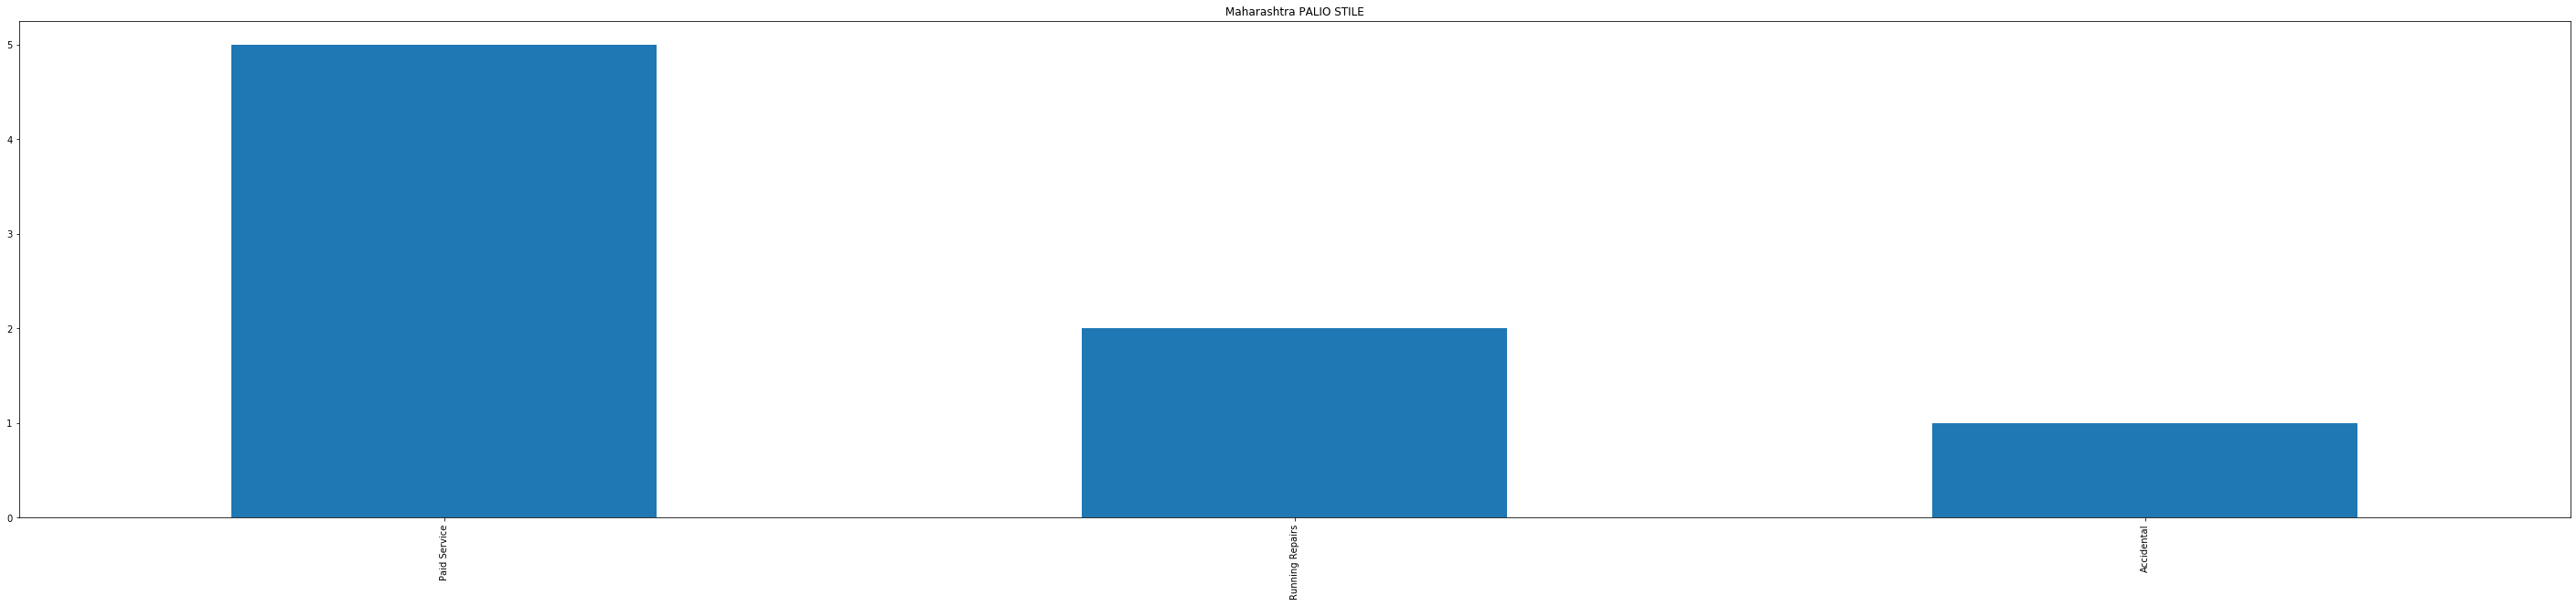

EON


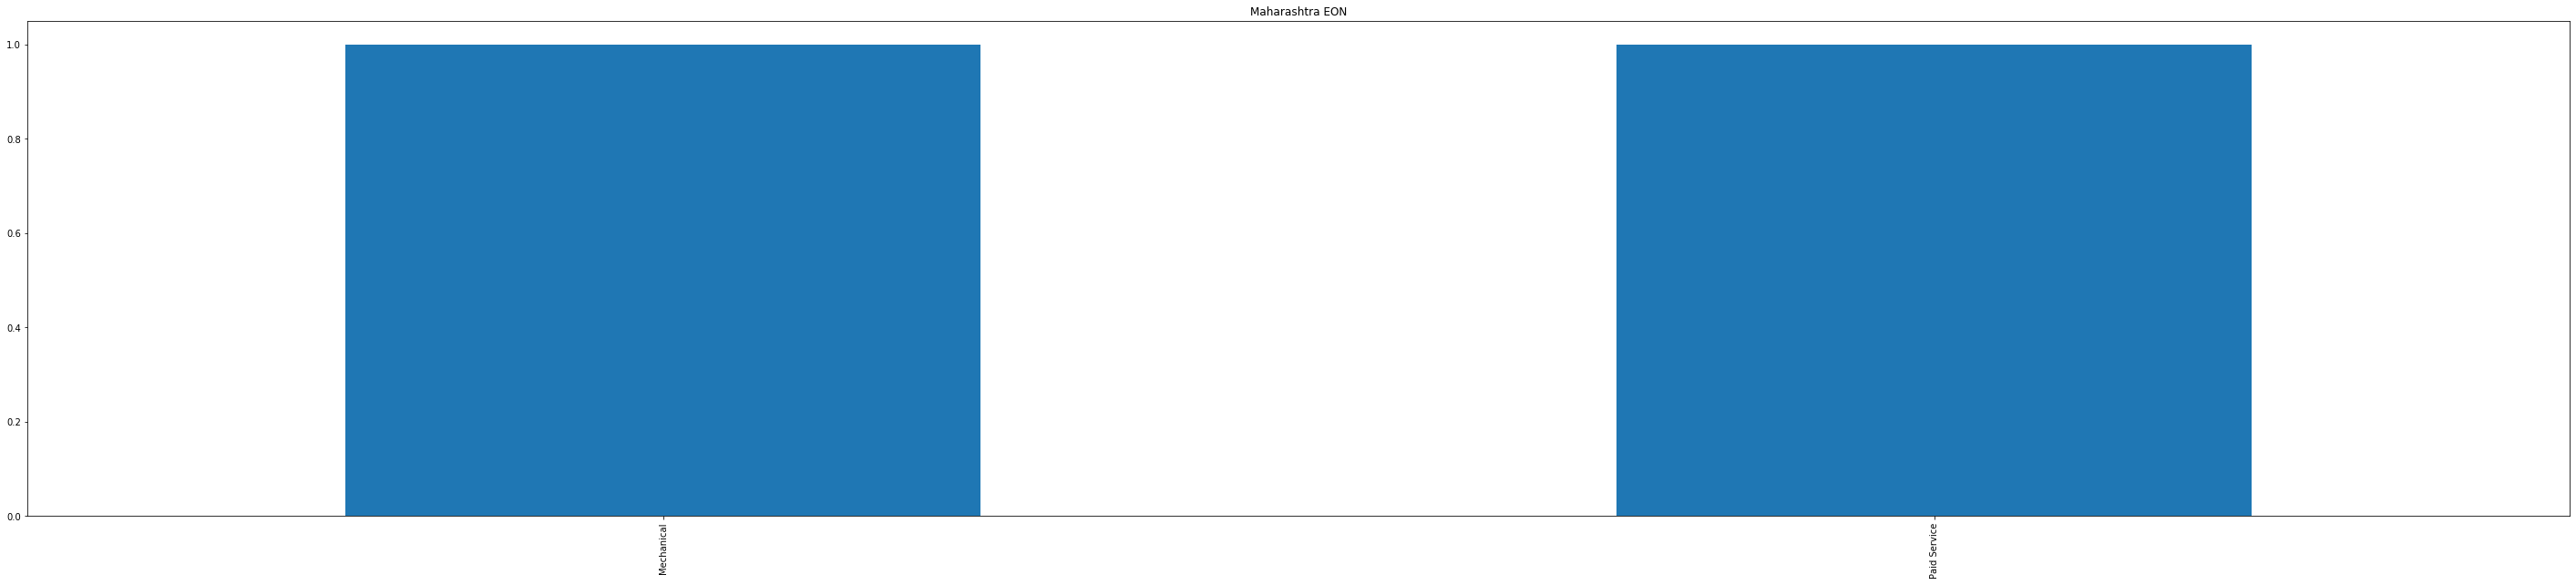

ETIOS


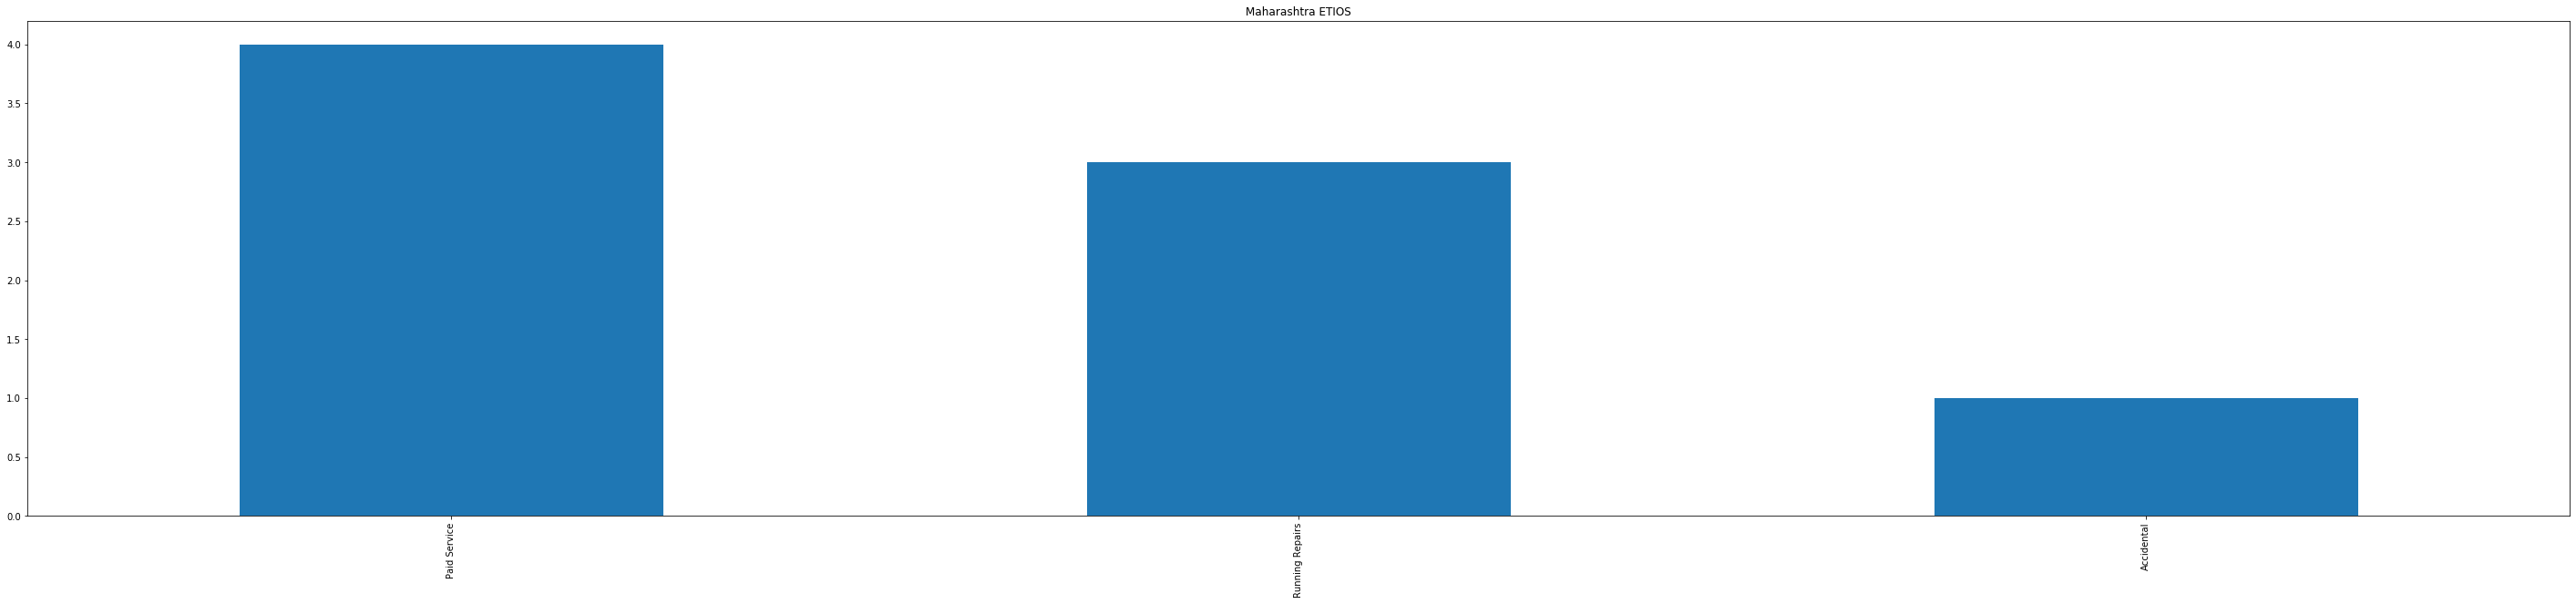

X-TRAIL


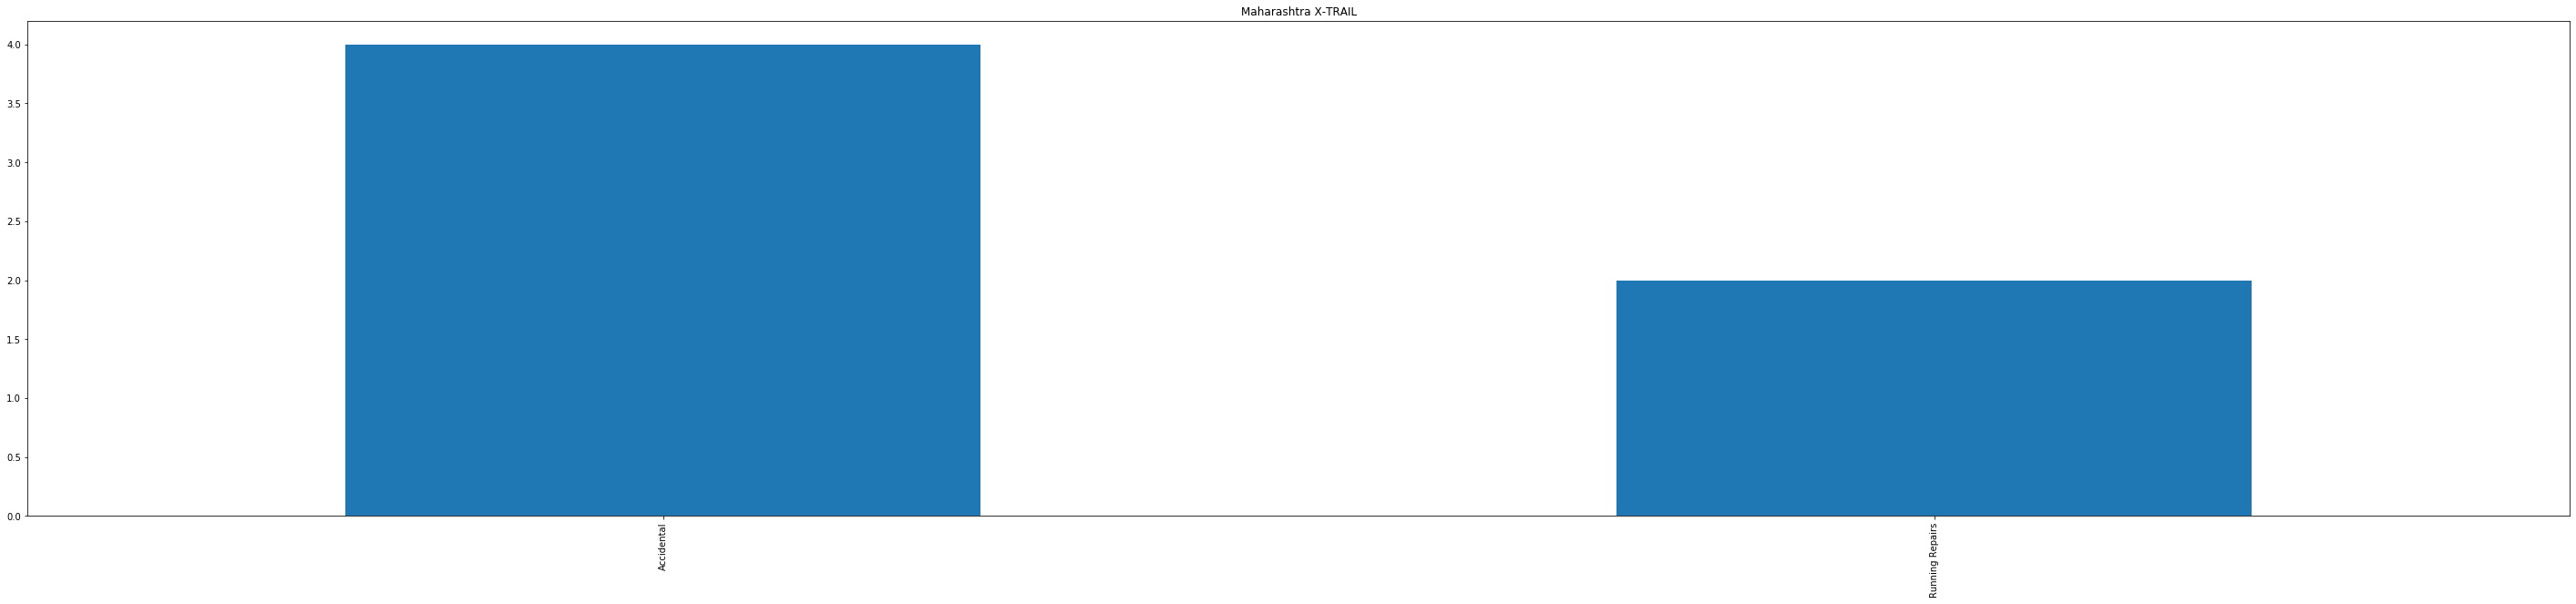

SUPER SUNNY


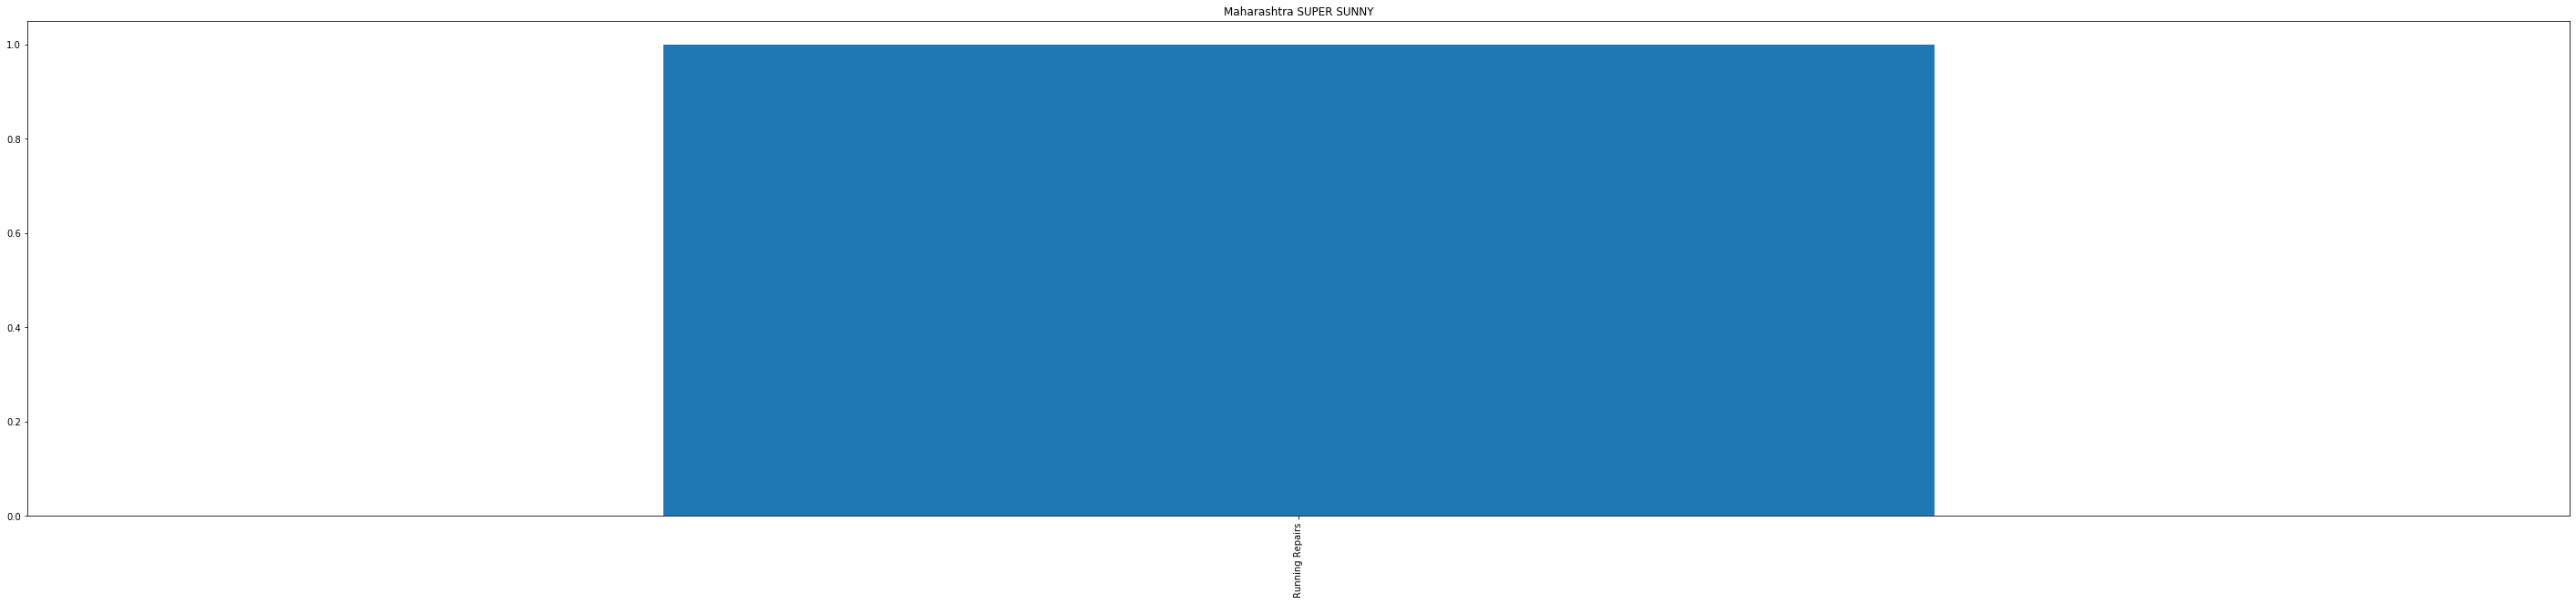

AMBASSADOR


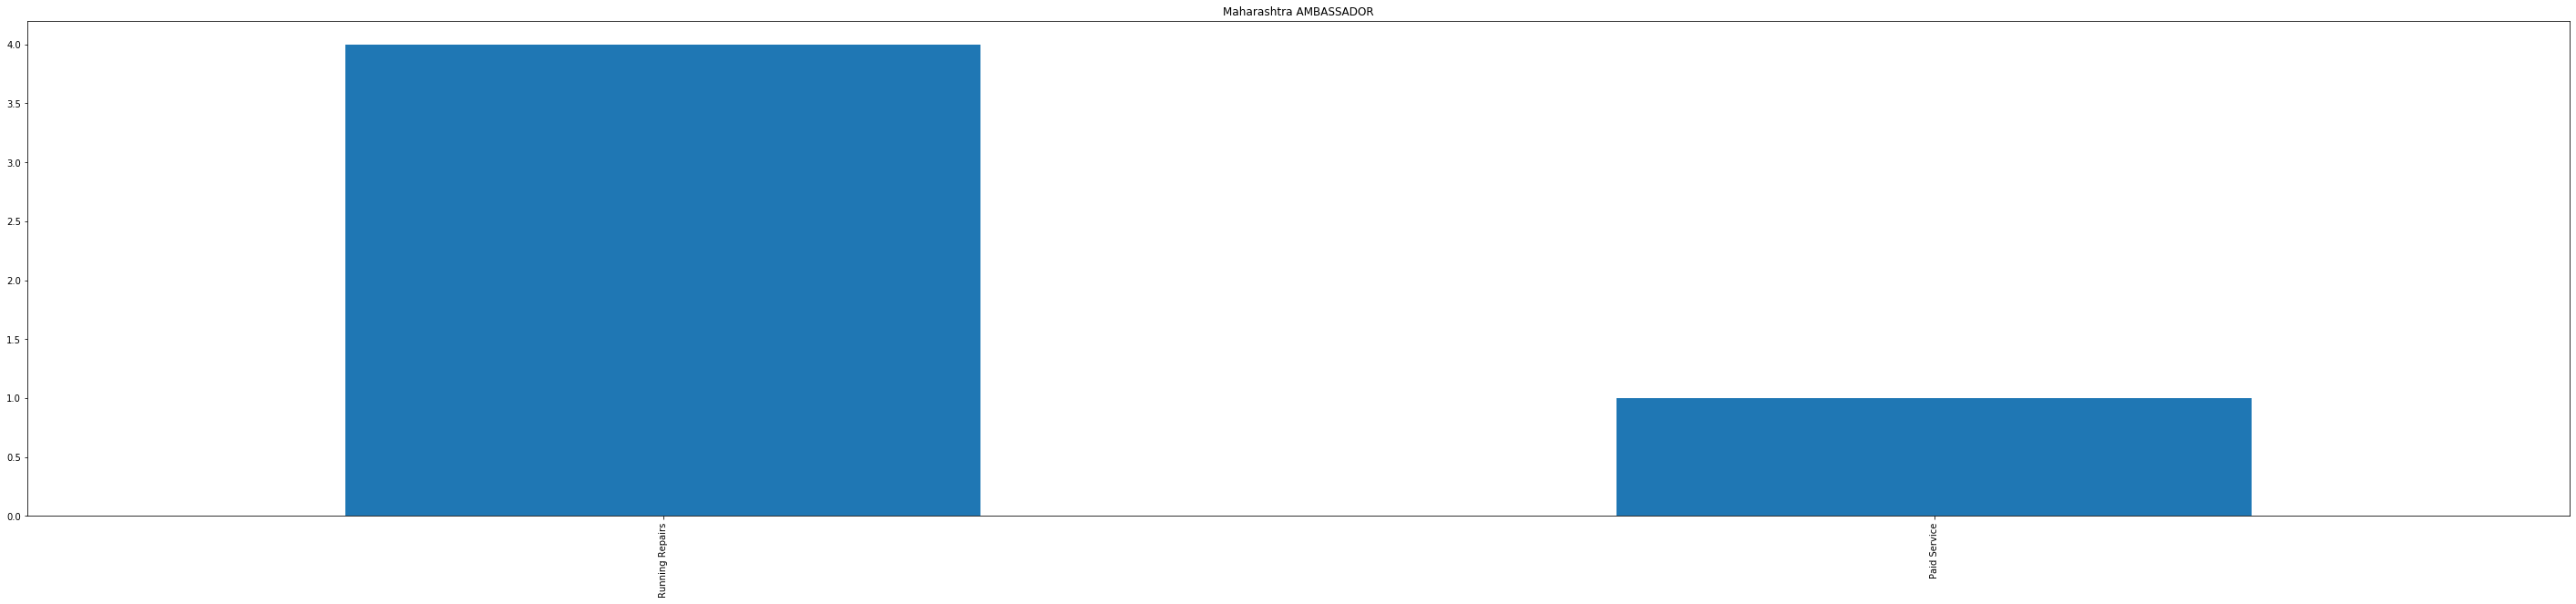

VENTURE


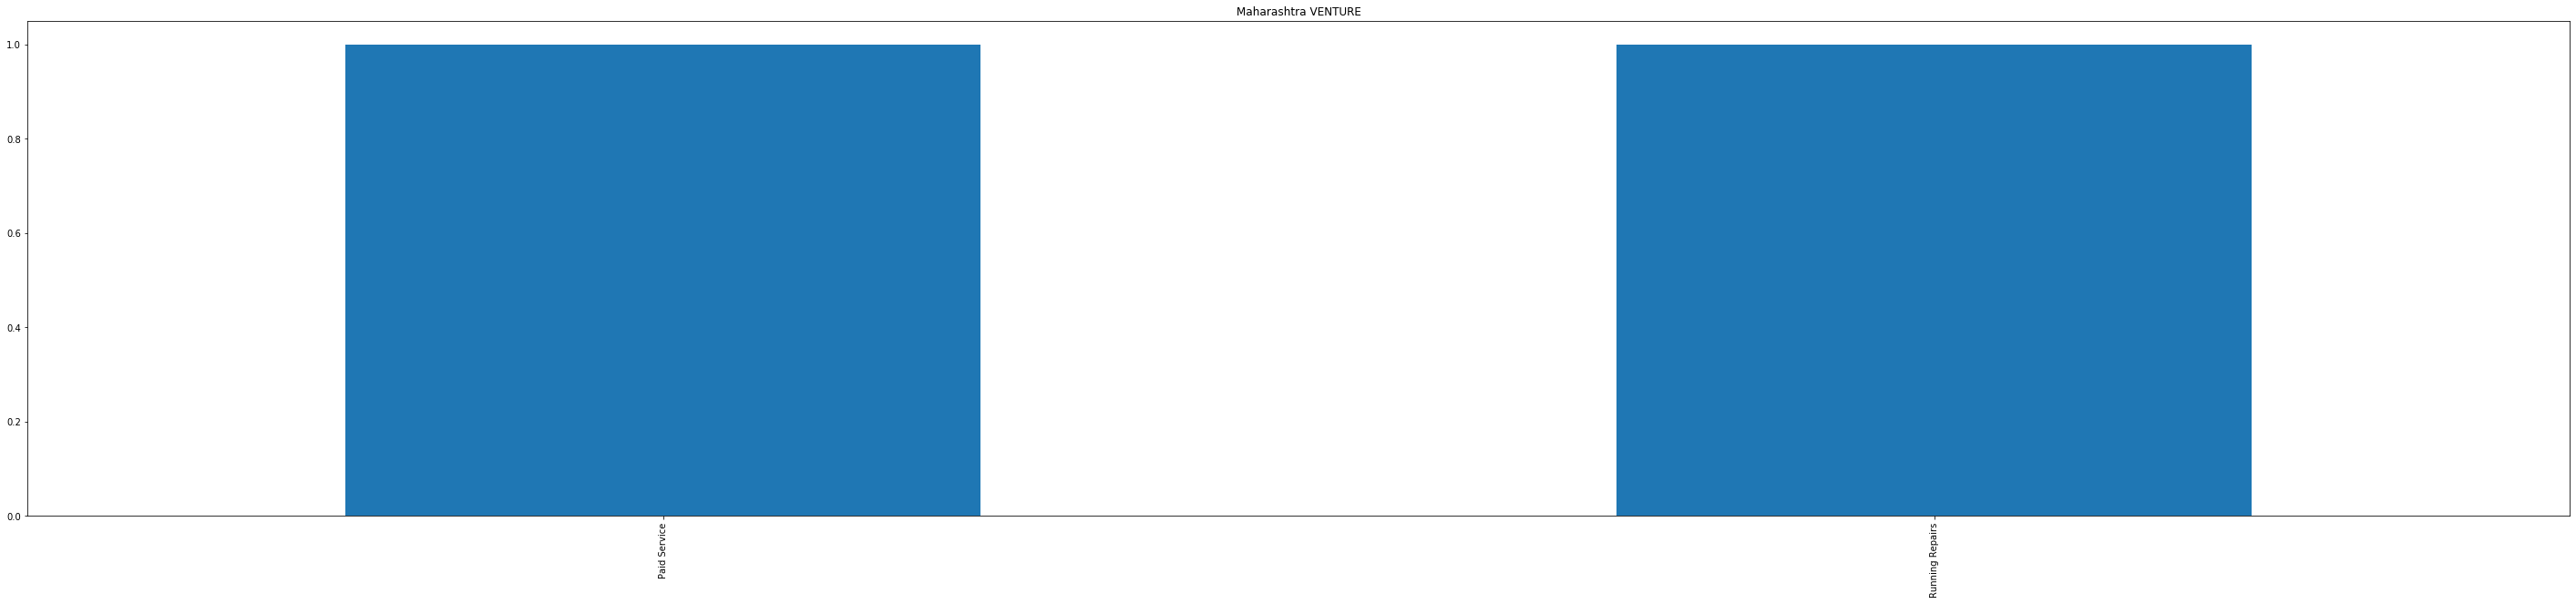

BOLERO PIK UP


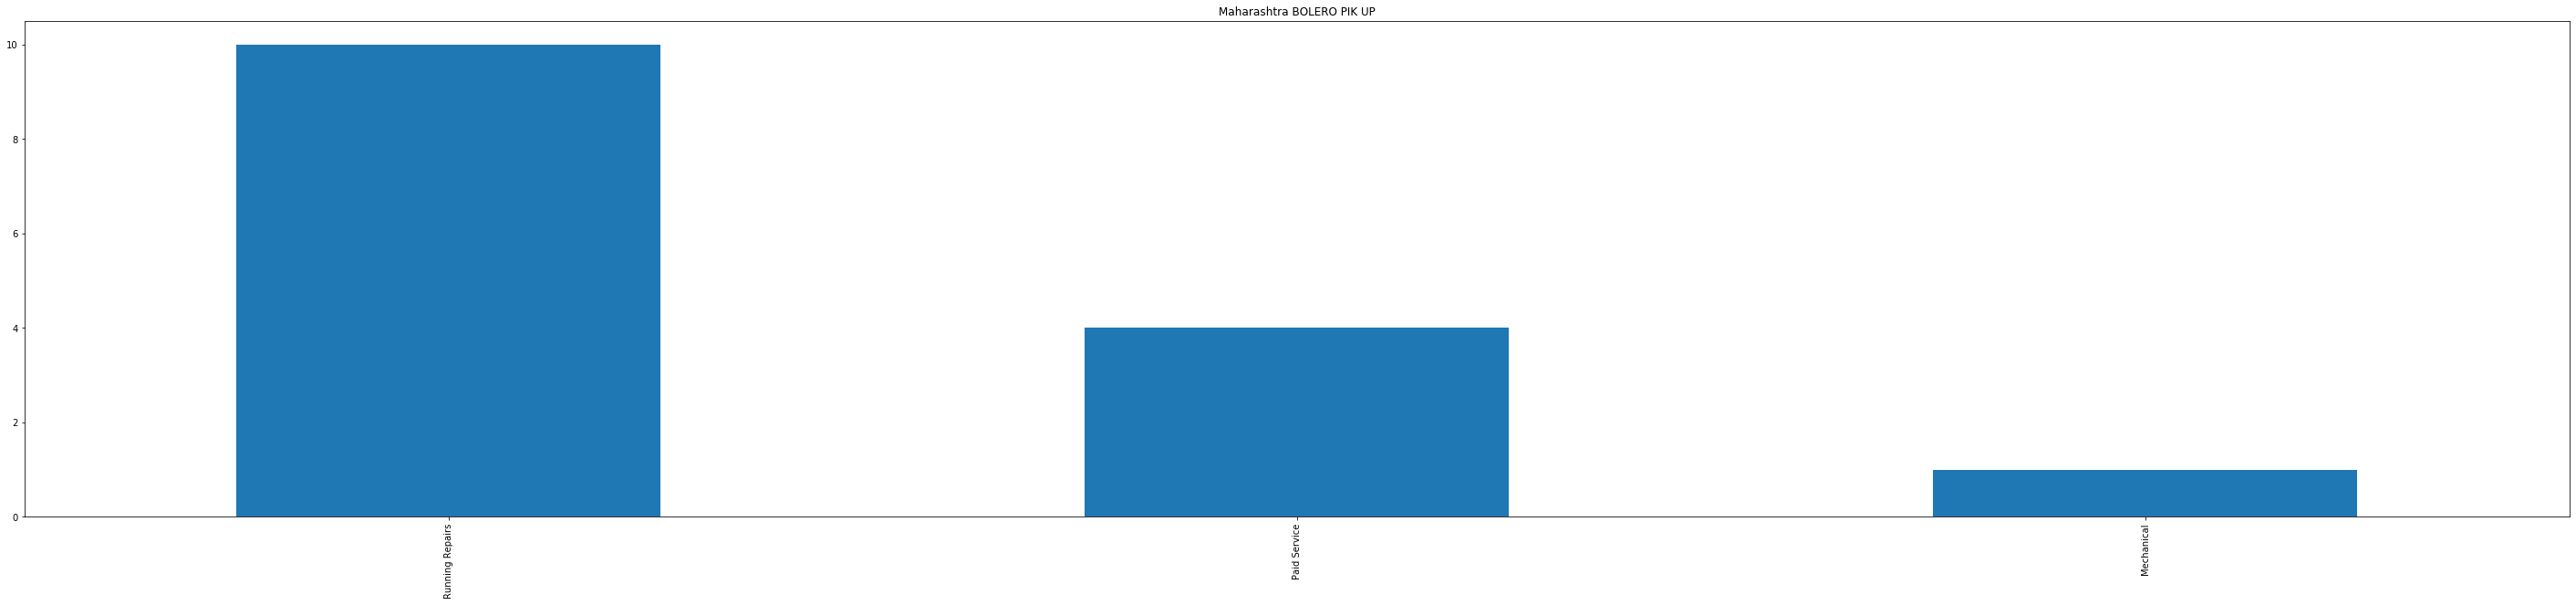

XCENT


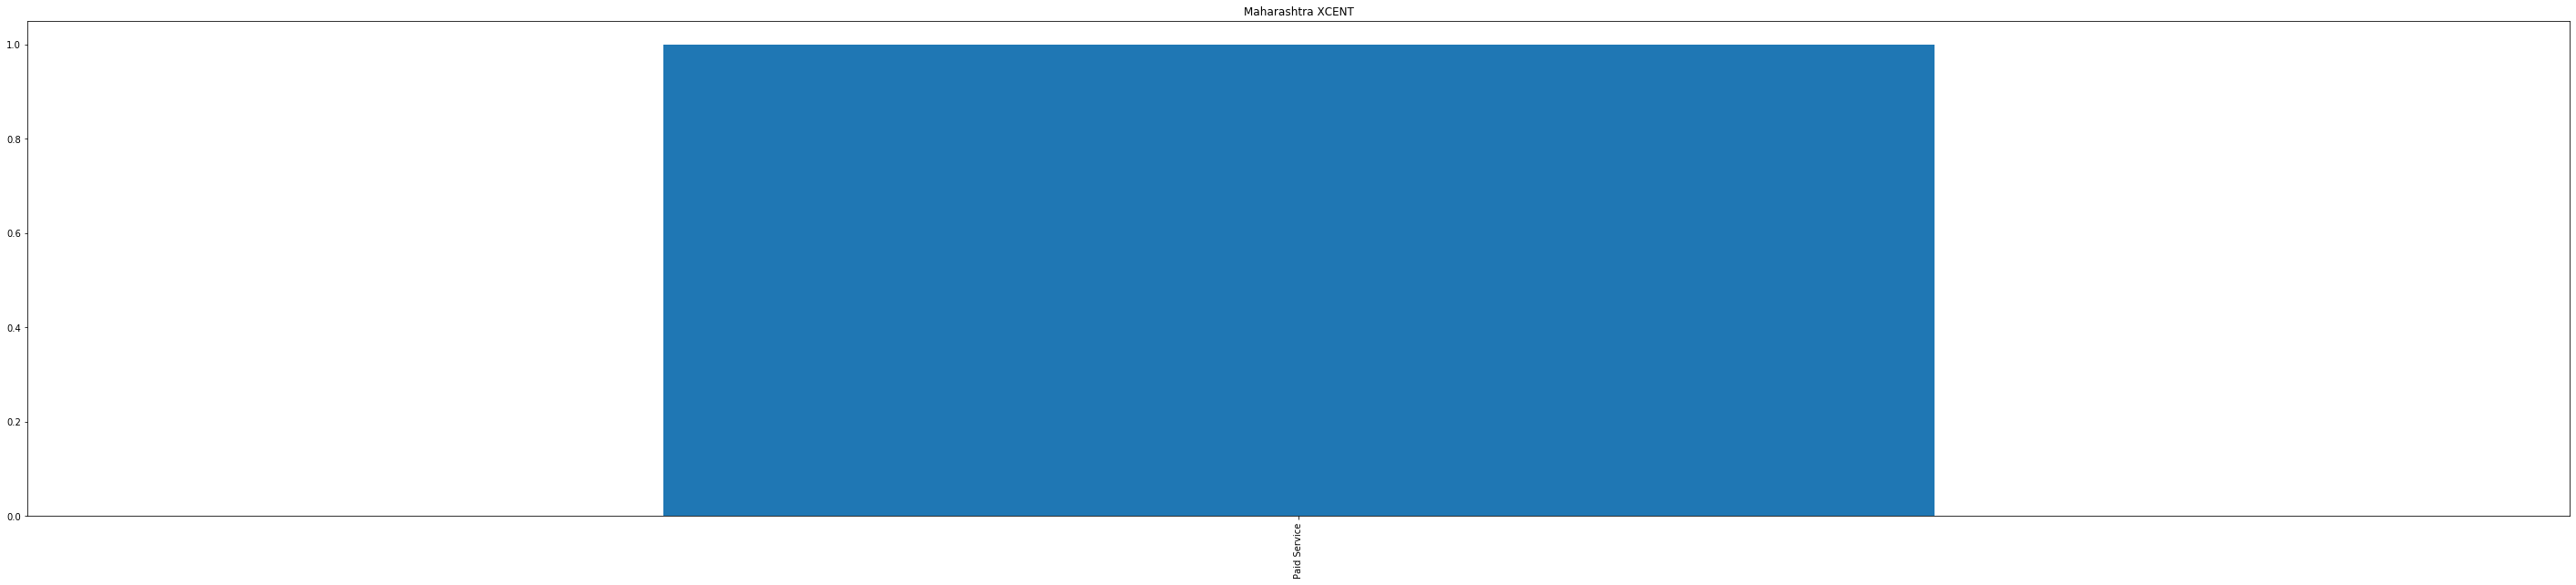

BRIO


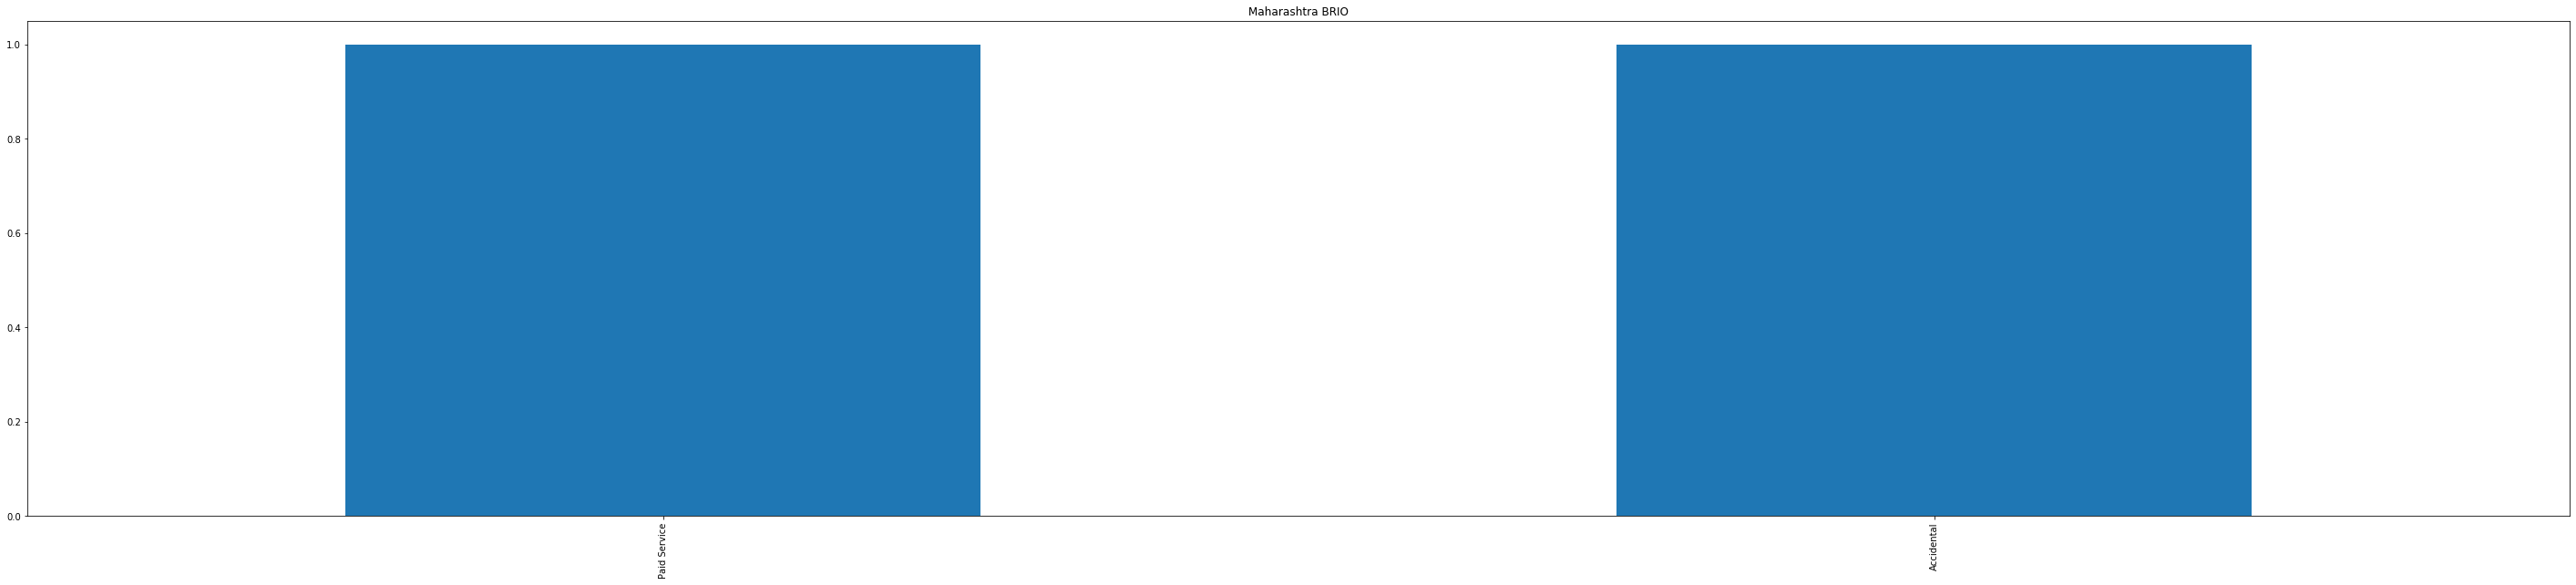

FLUENCE


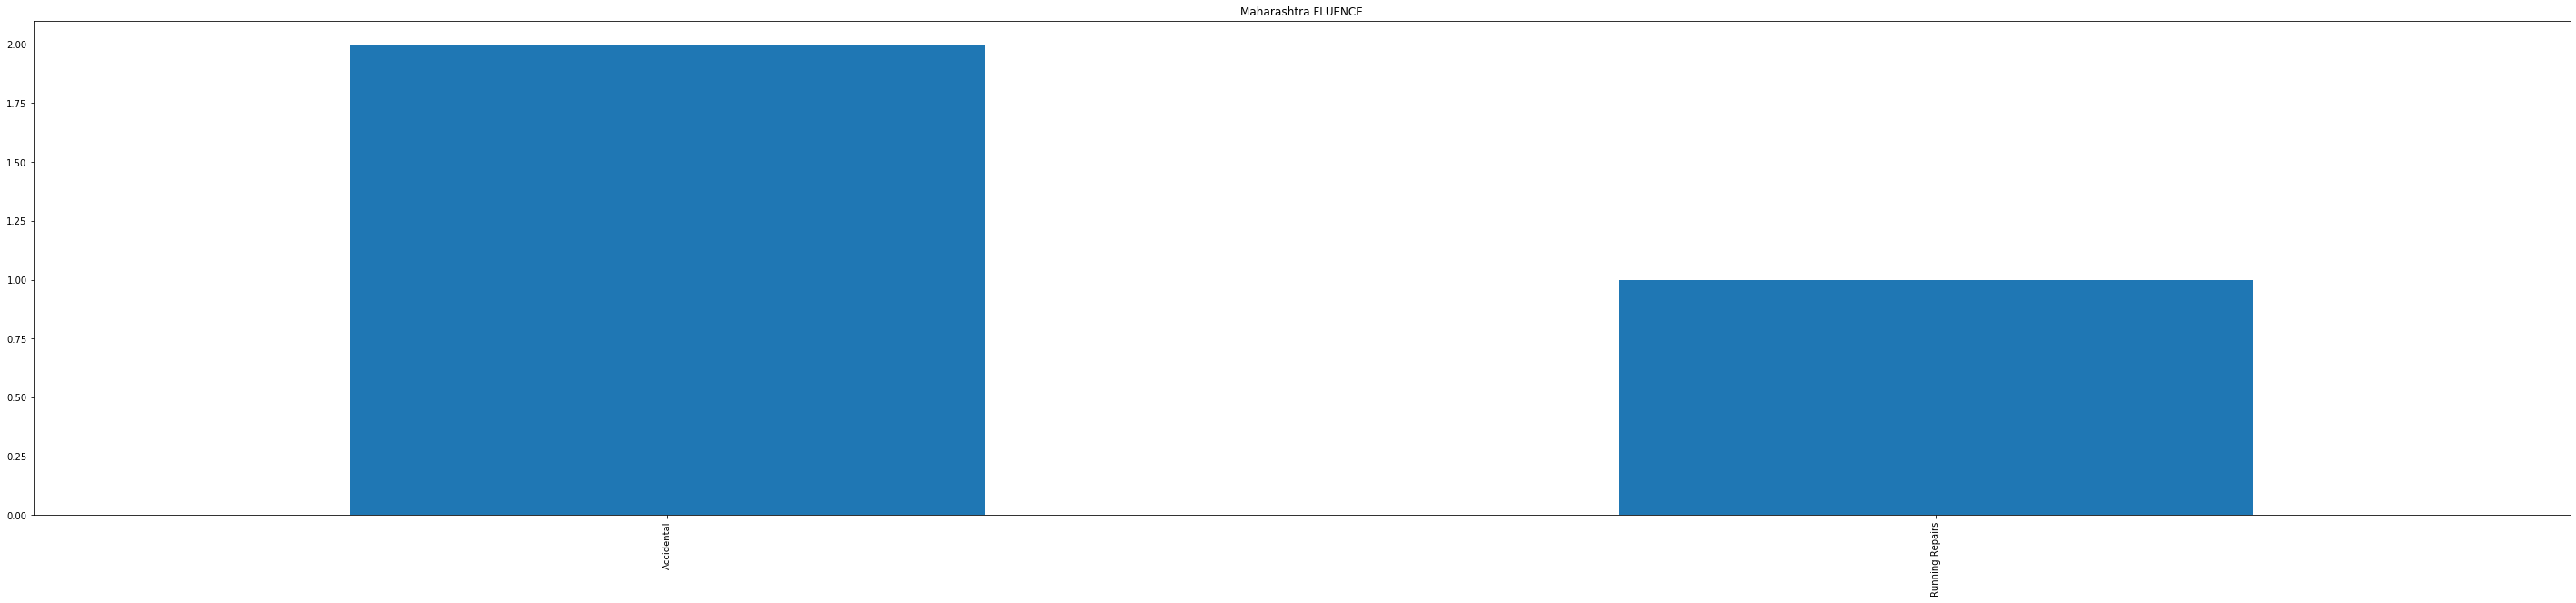

SSANYONG REXTON


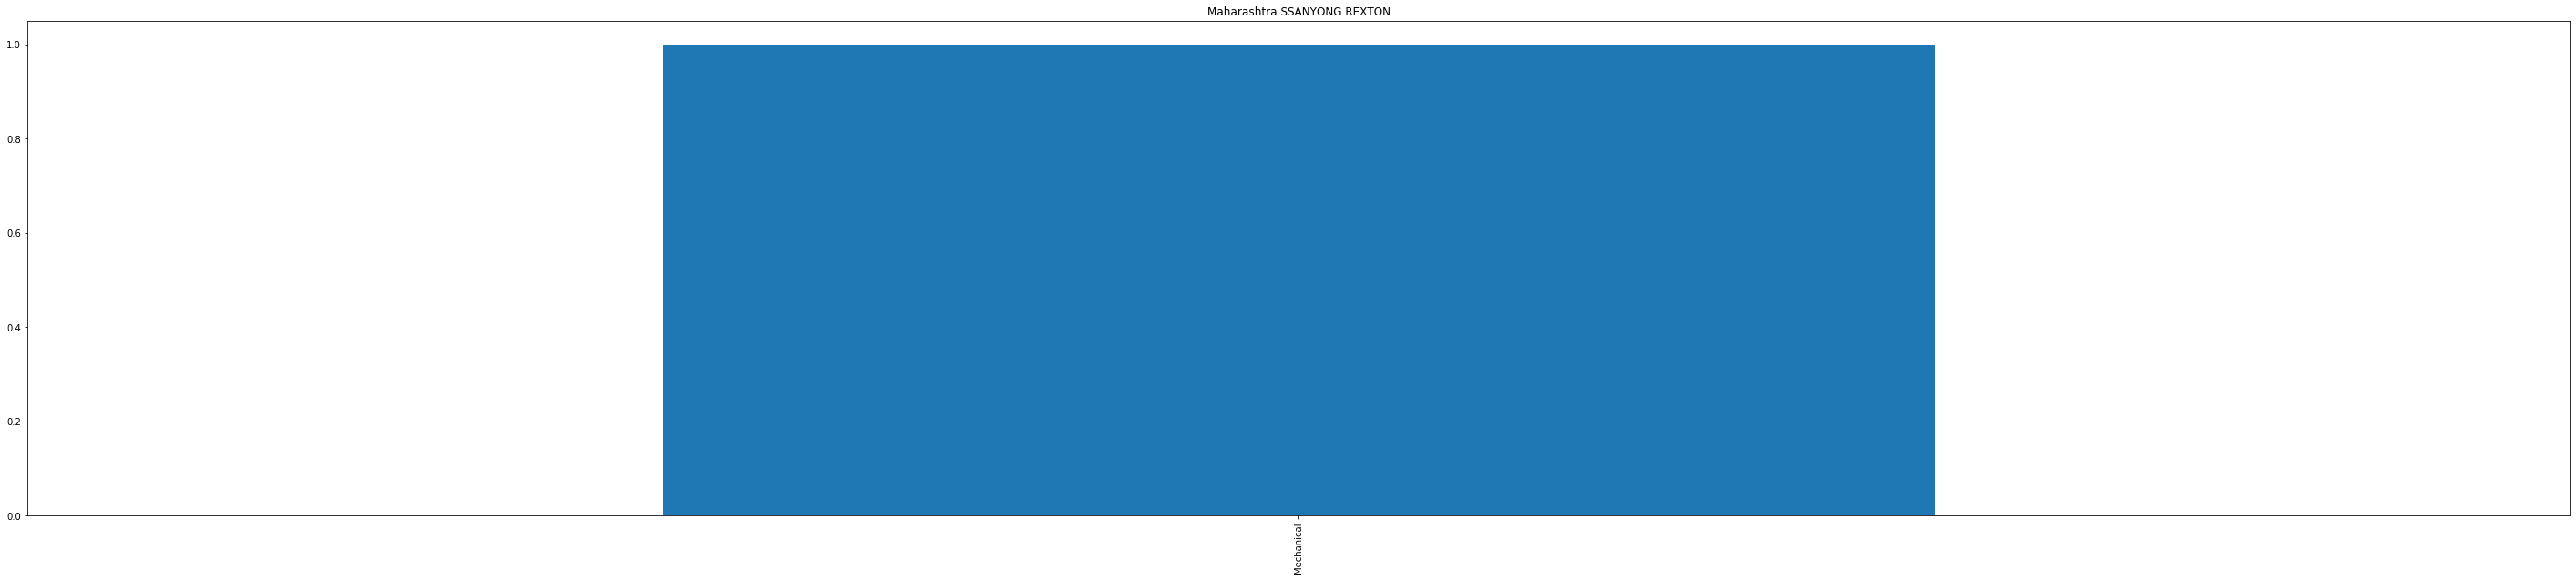

In [158]:
def model_order(state):
    city=[]
    city=join['District'].unique()
    order=join['Order Type'].unique()
    #print(cars['Order Type'].value_counts())

    cars=join[join['District']==state]
    for j in cars['Model'].unique():
        print(j)
        order=cars[cars['Model']==j]
        fig=plt.figure(figsize=(50,10))
        plt.title('Maharashtra'+" "+j)
        #cars=cars.sort_values('Total Amt Wtd Tax.',ascending=False)
        order['Order Type'].value_counts().plot(kind='bar')
        plt.xticks(rotation=90)
        plt.show()
    
model_order('maharashtra')   

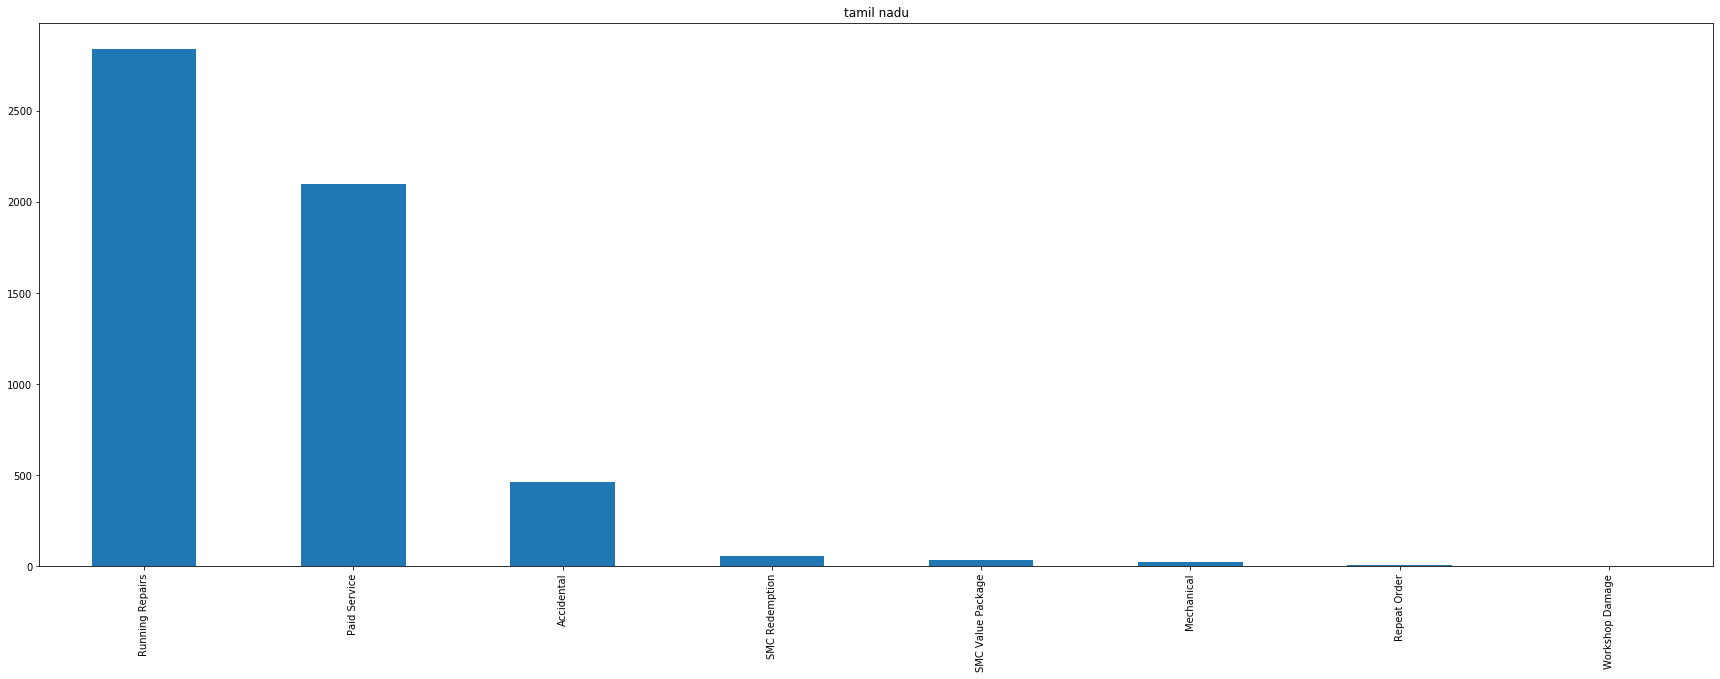

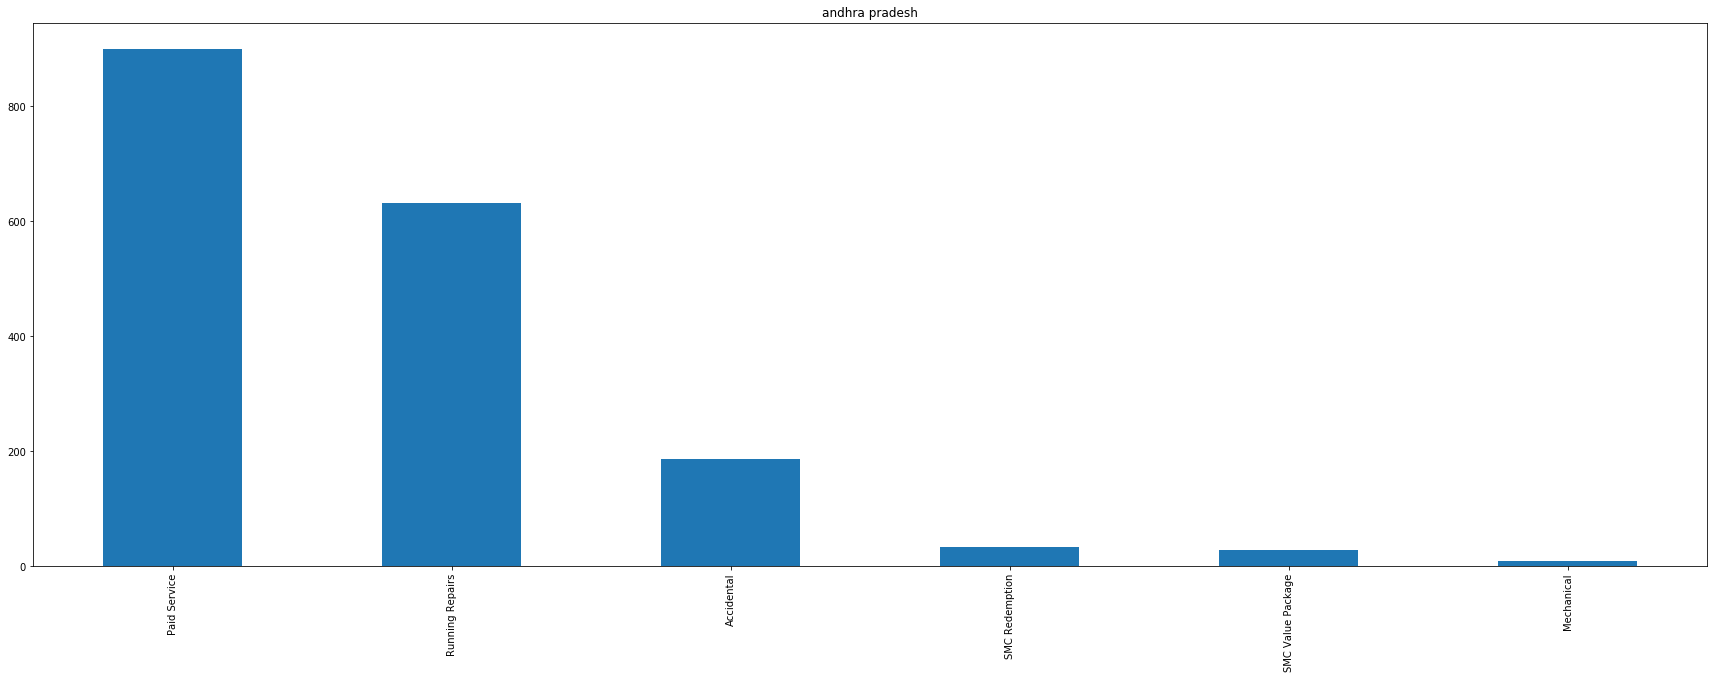

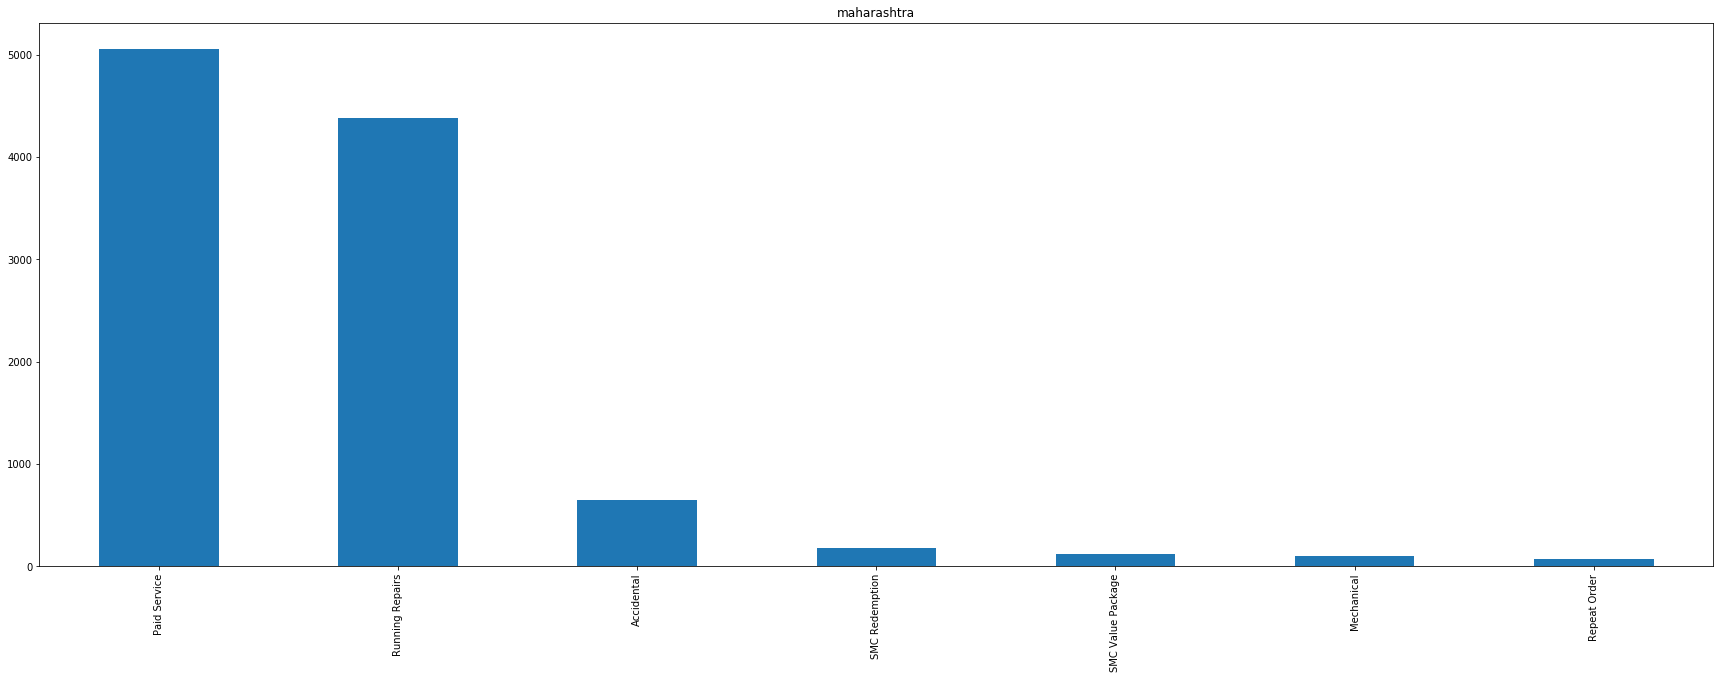

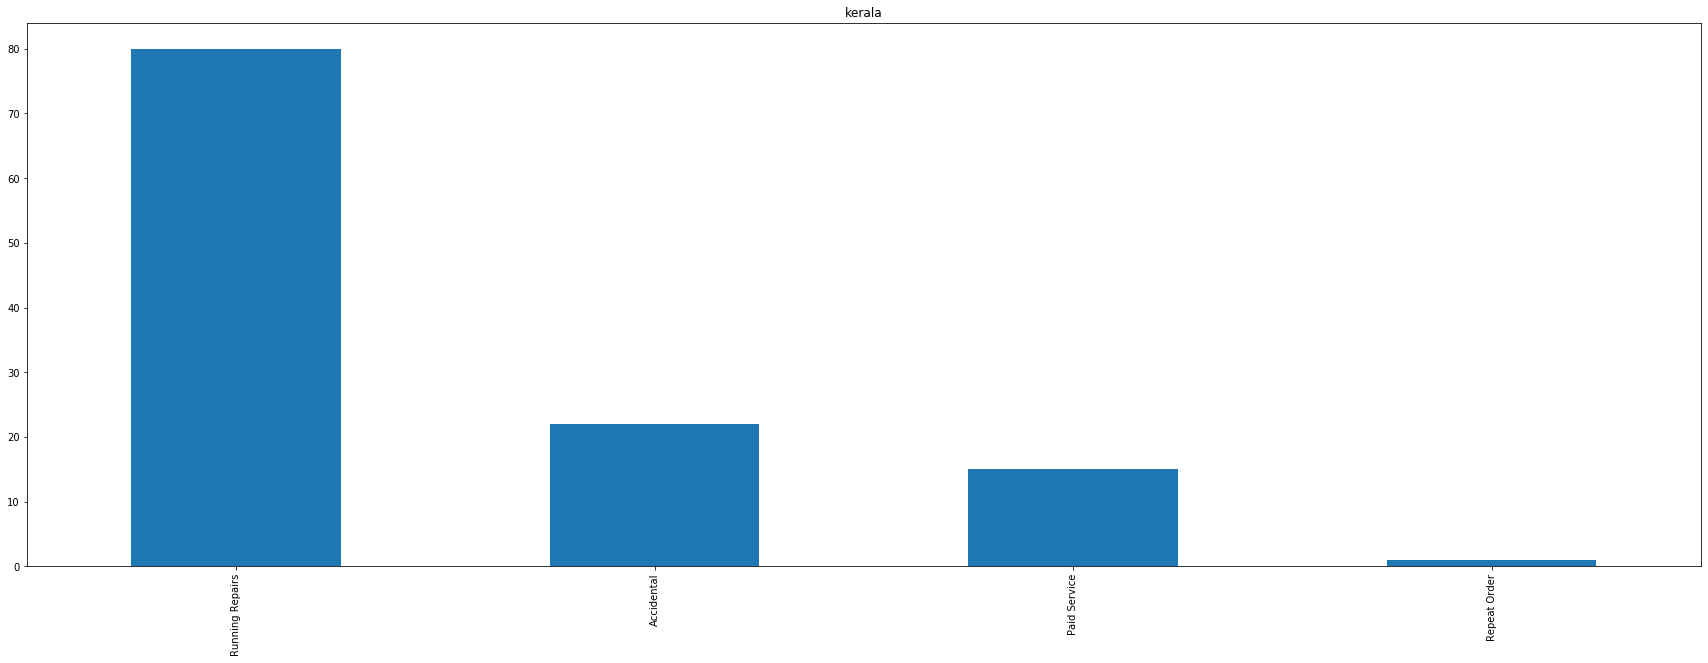

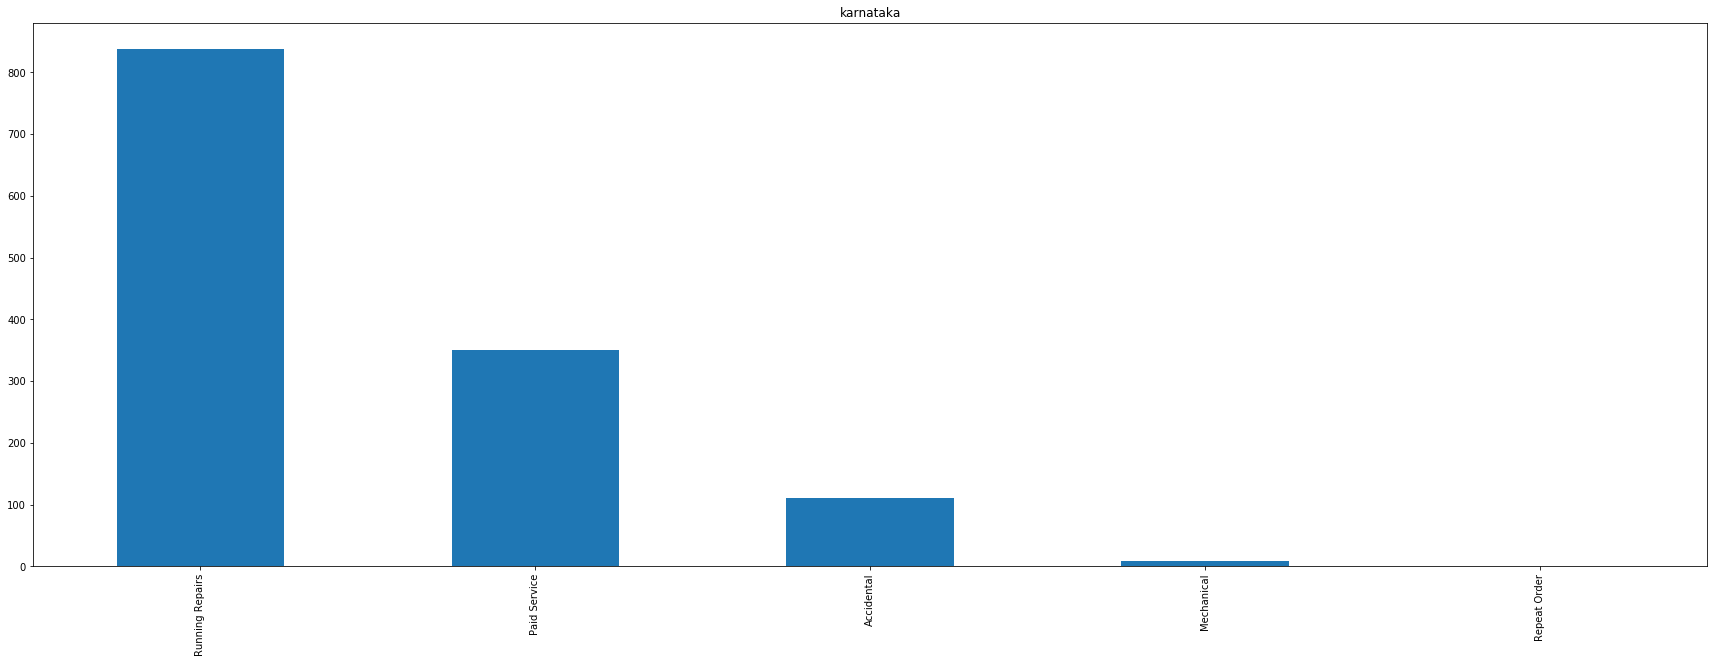

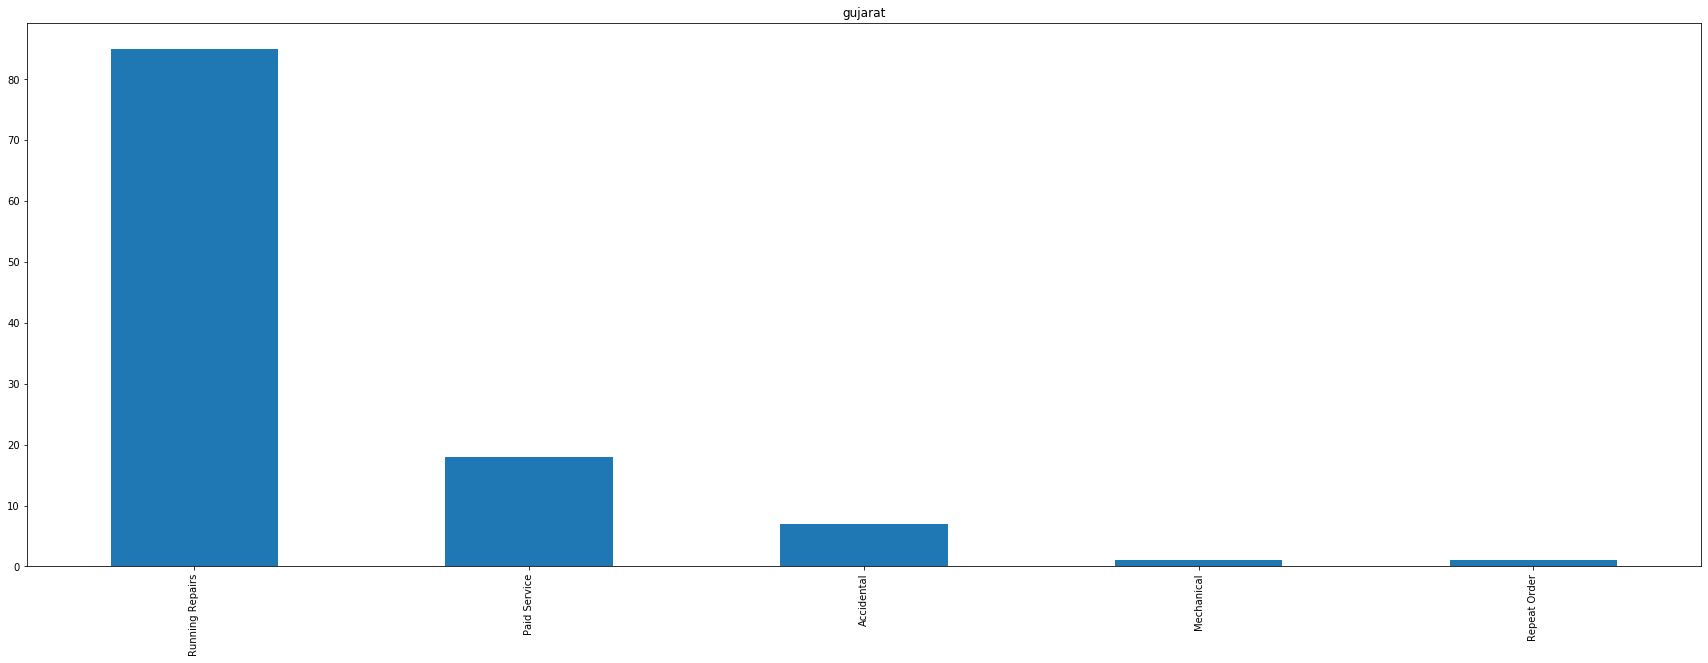

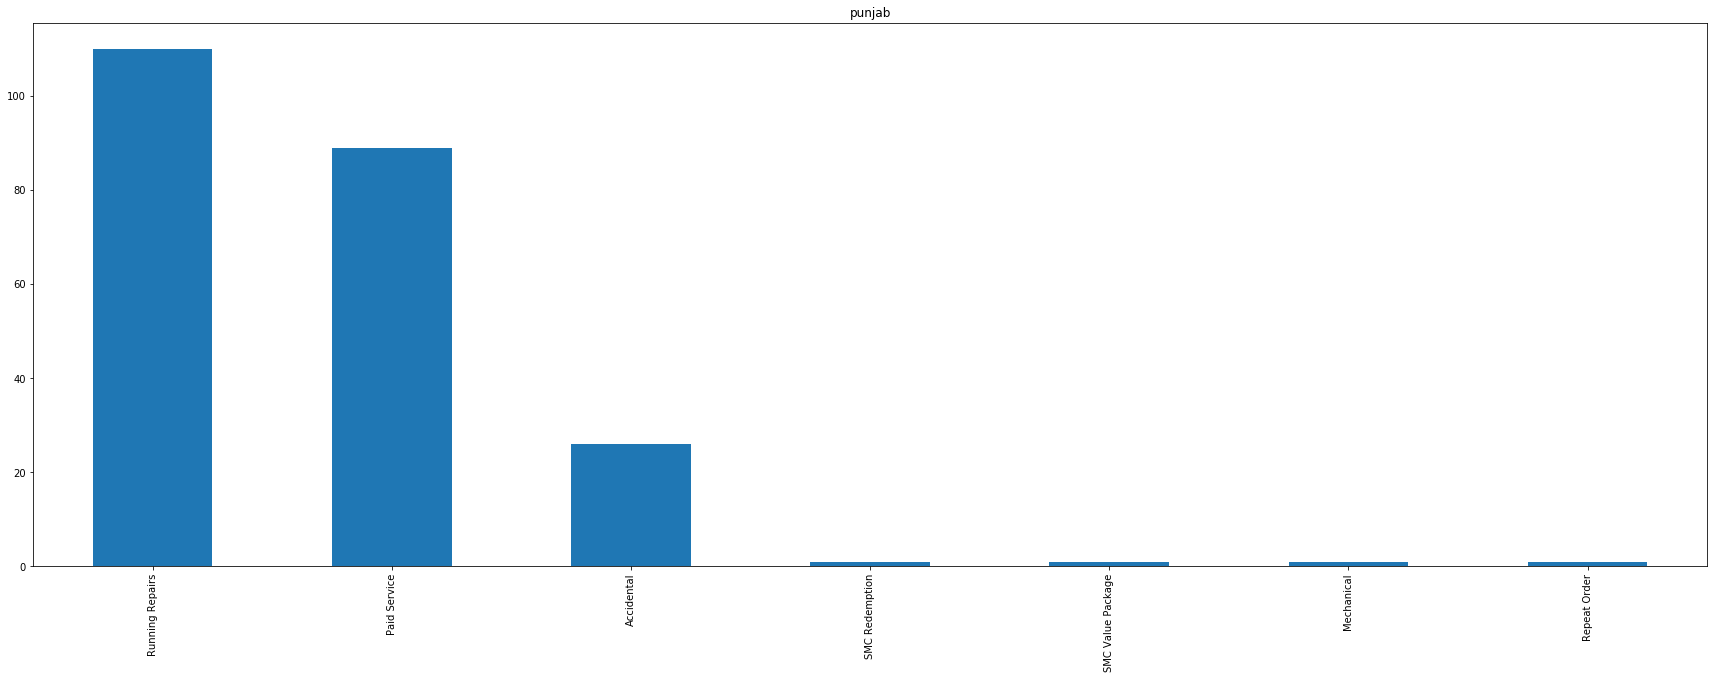

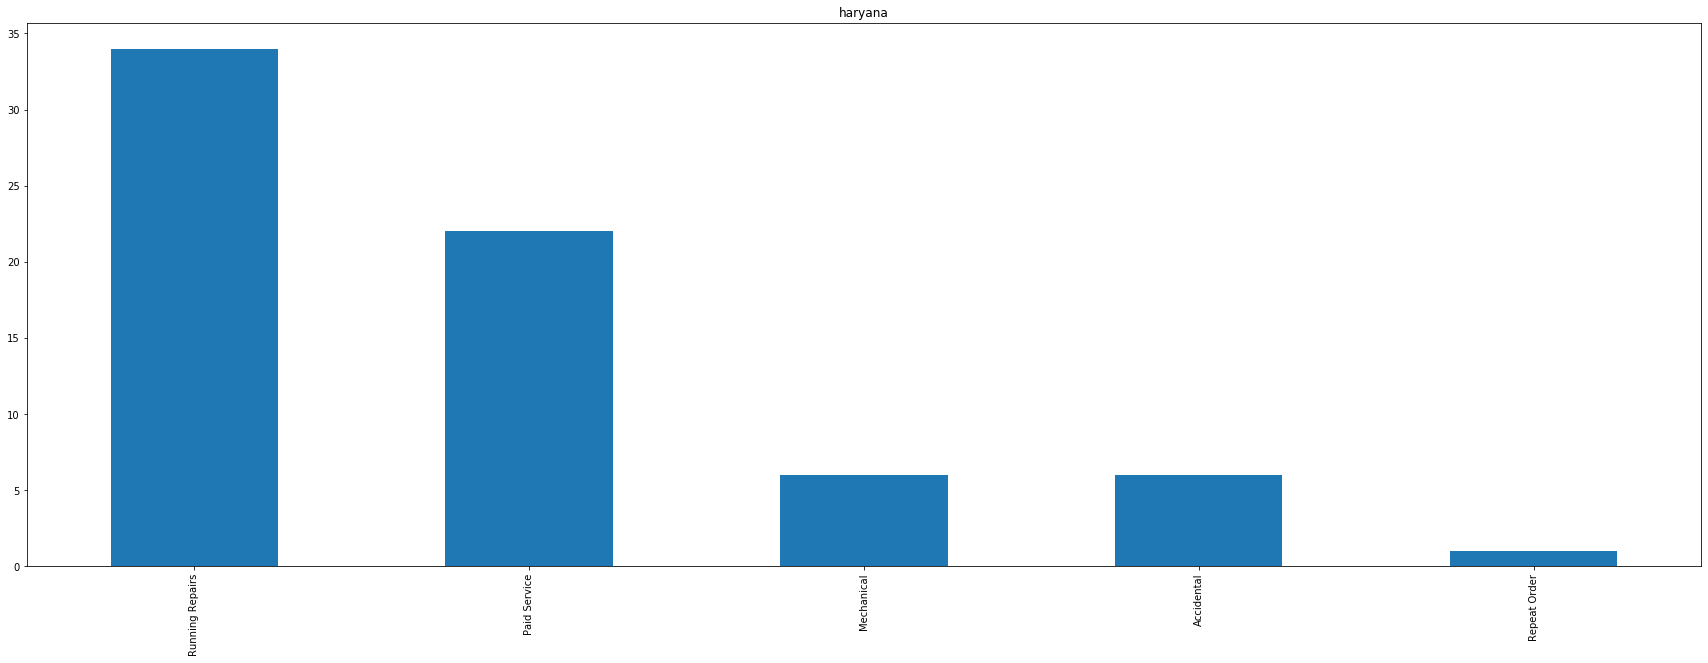

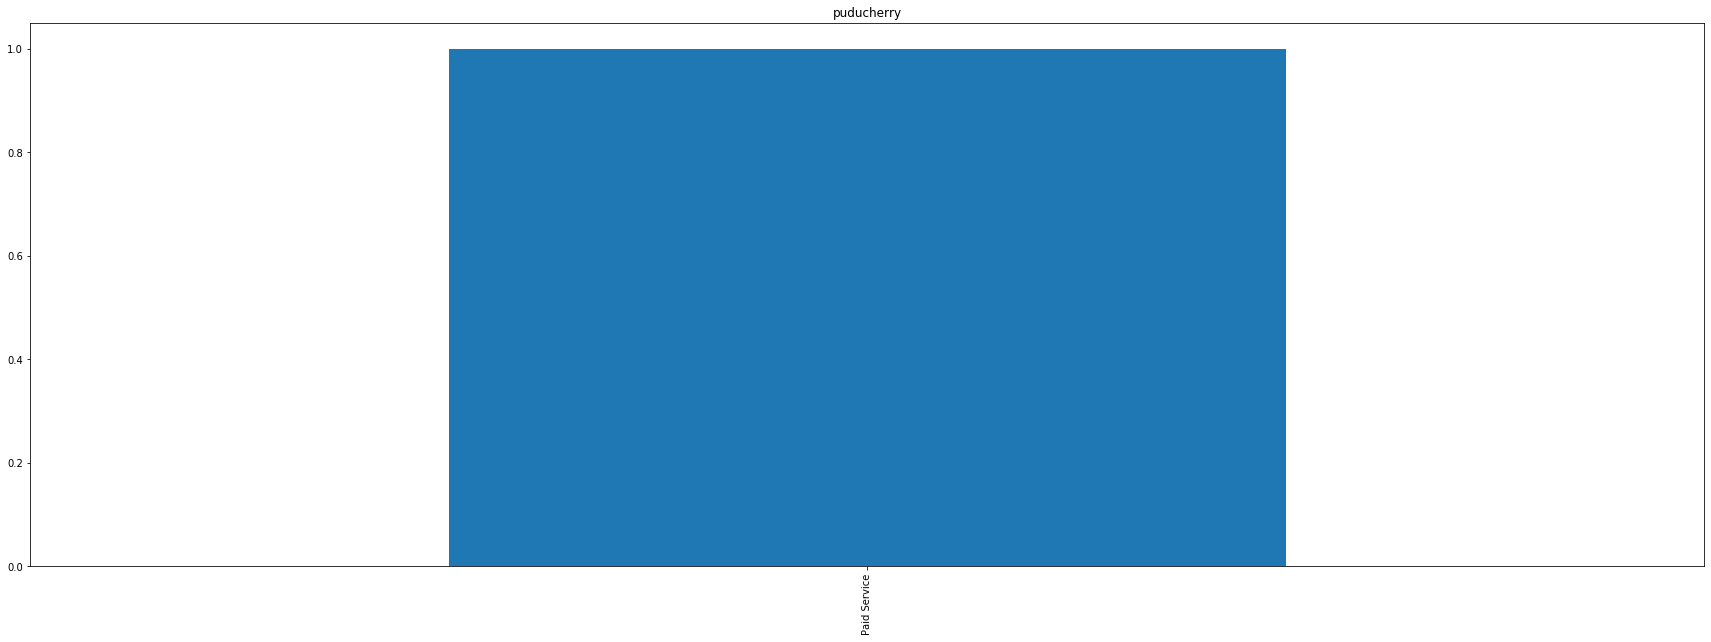

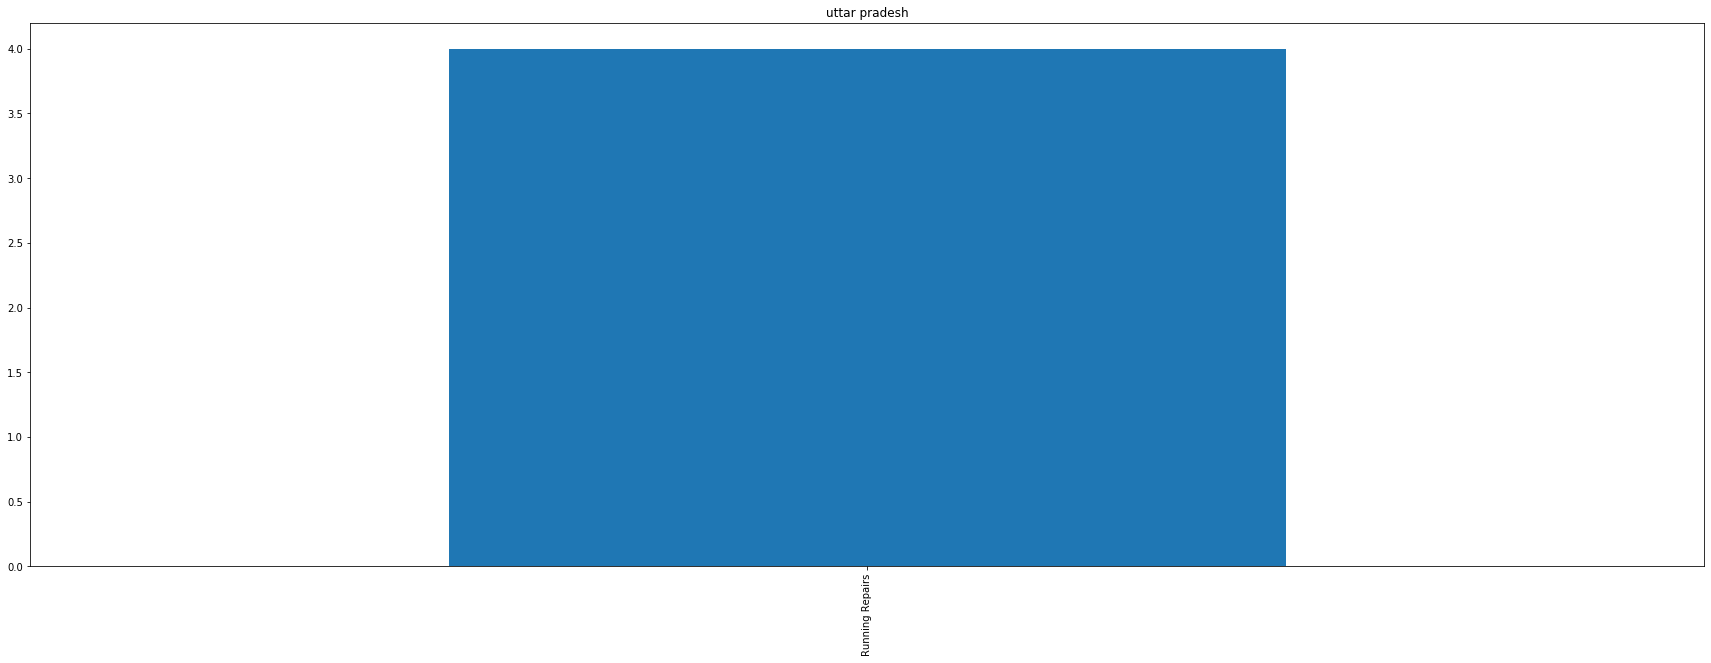

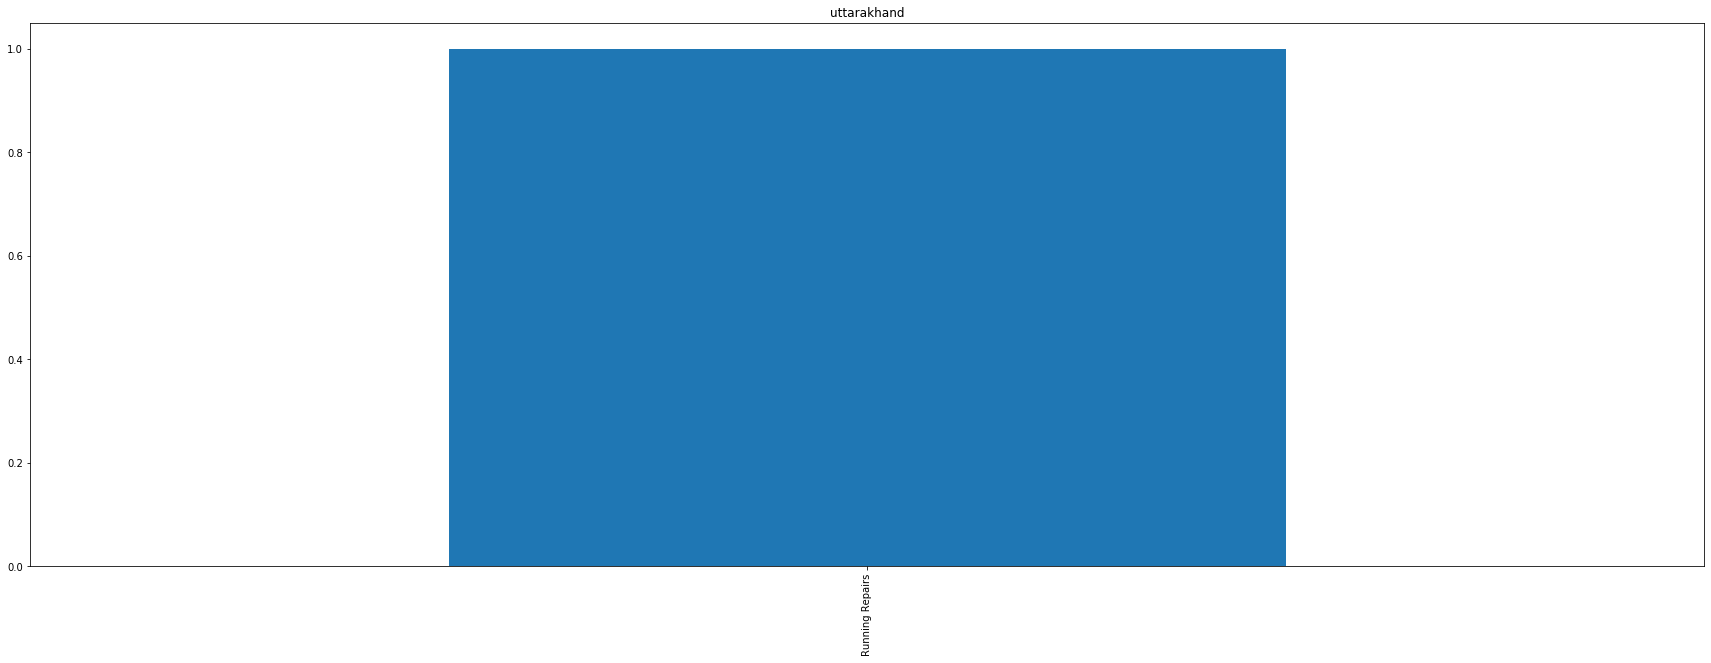

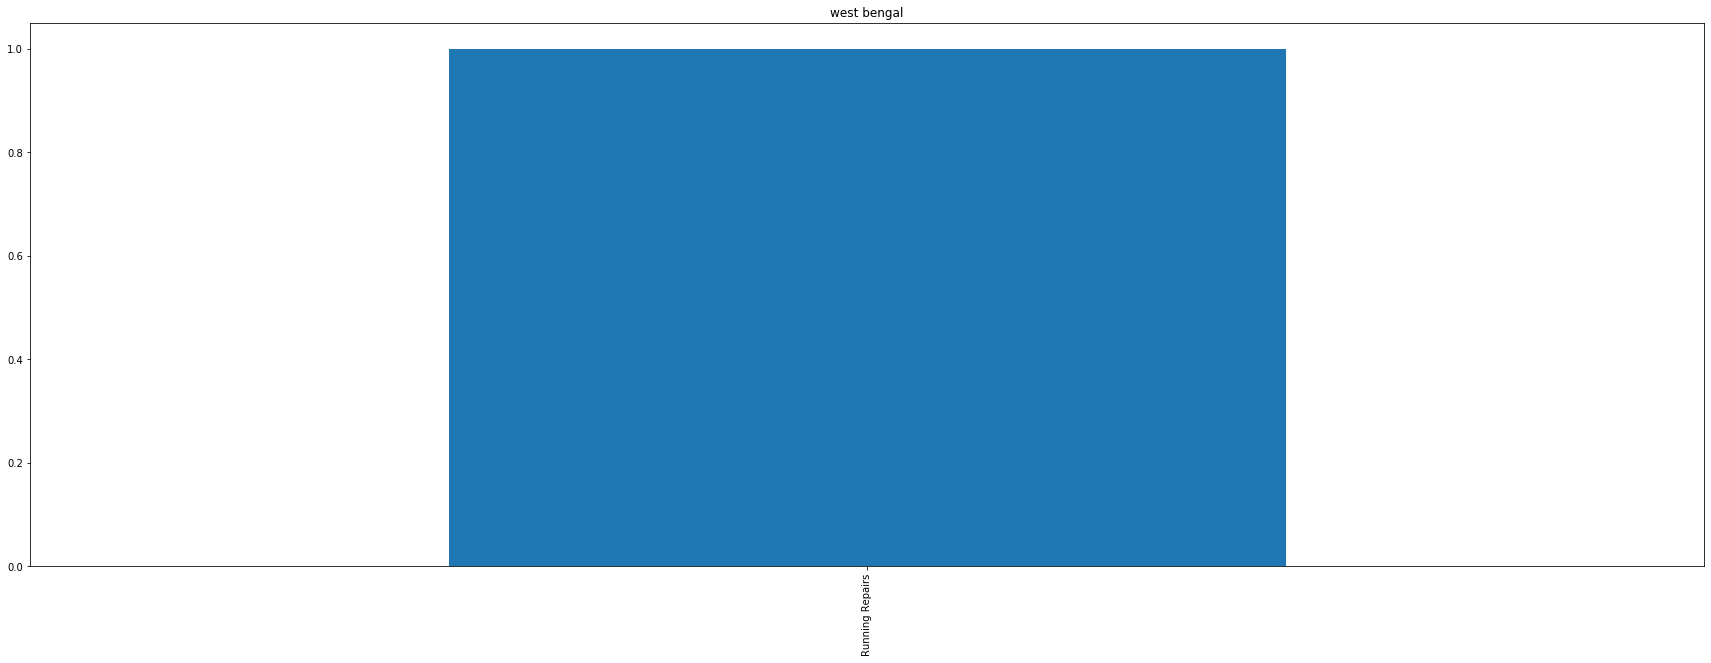

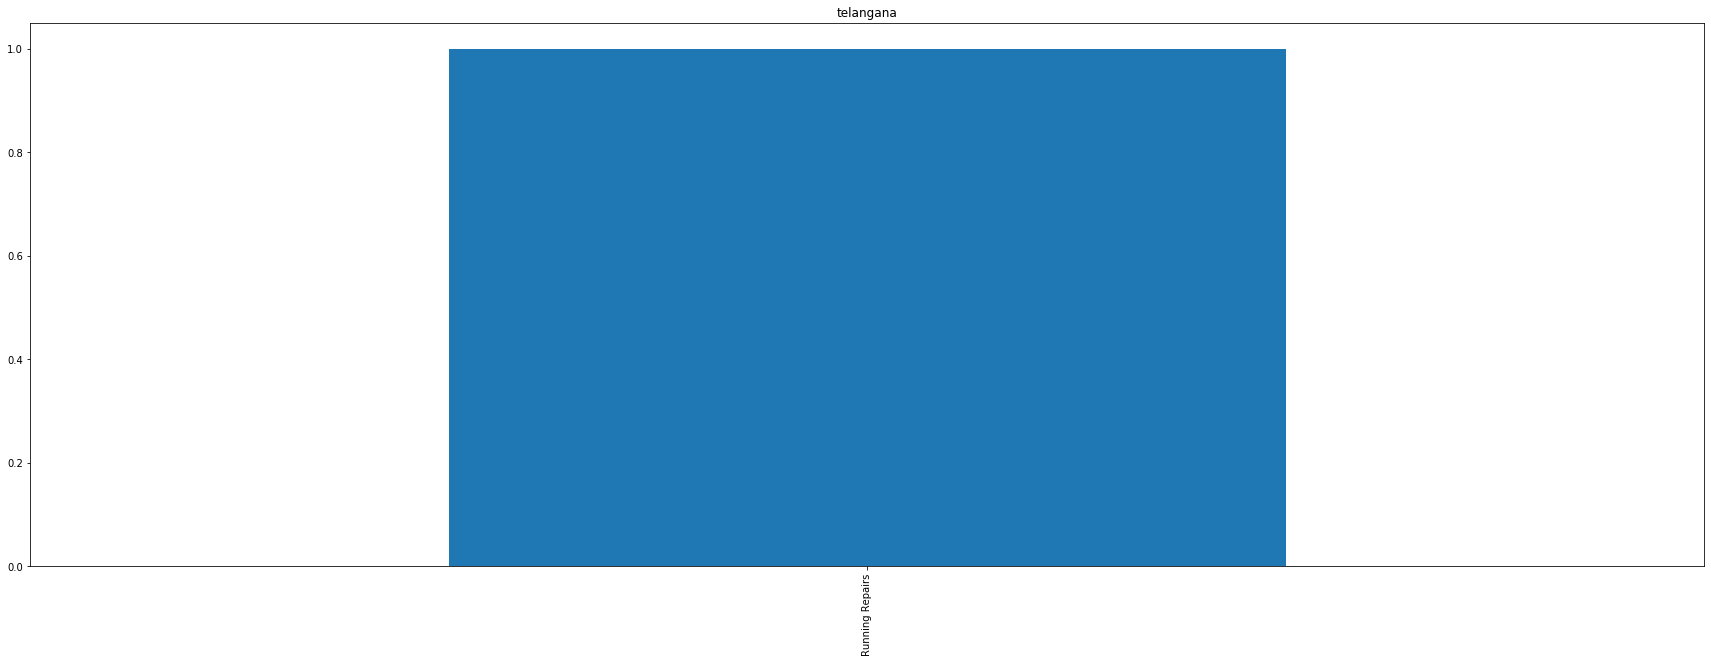

In [159]:
city=[]
city=join['District'].unique()
for i in city:
    cars=join[join['District']==i]
    
    fig=plt.figure(figsize=(30,10))
    plt.title(i)
    cars['Order Type'].value_counts().plot(kind='bar')
    plt.show()

April


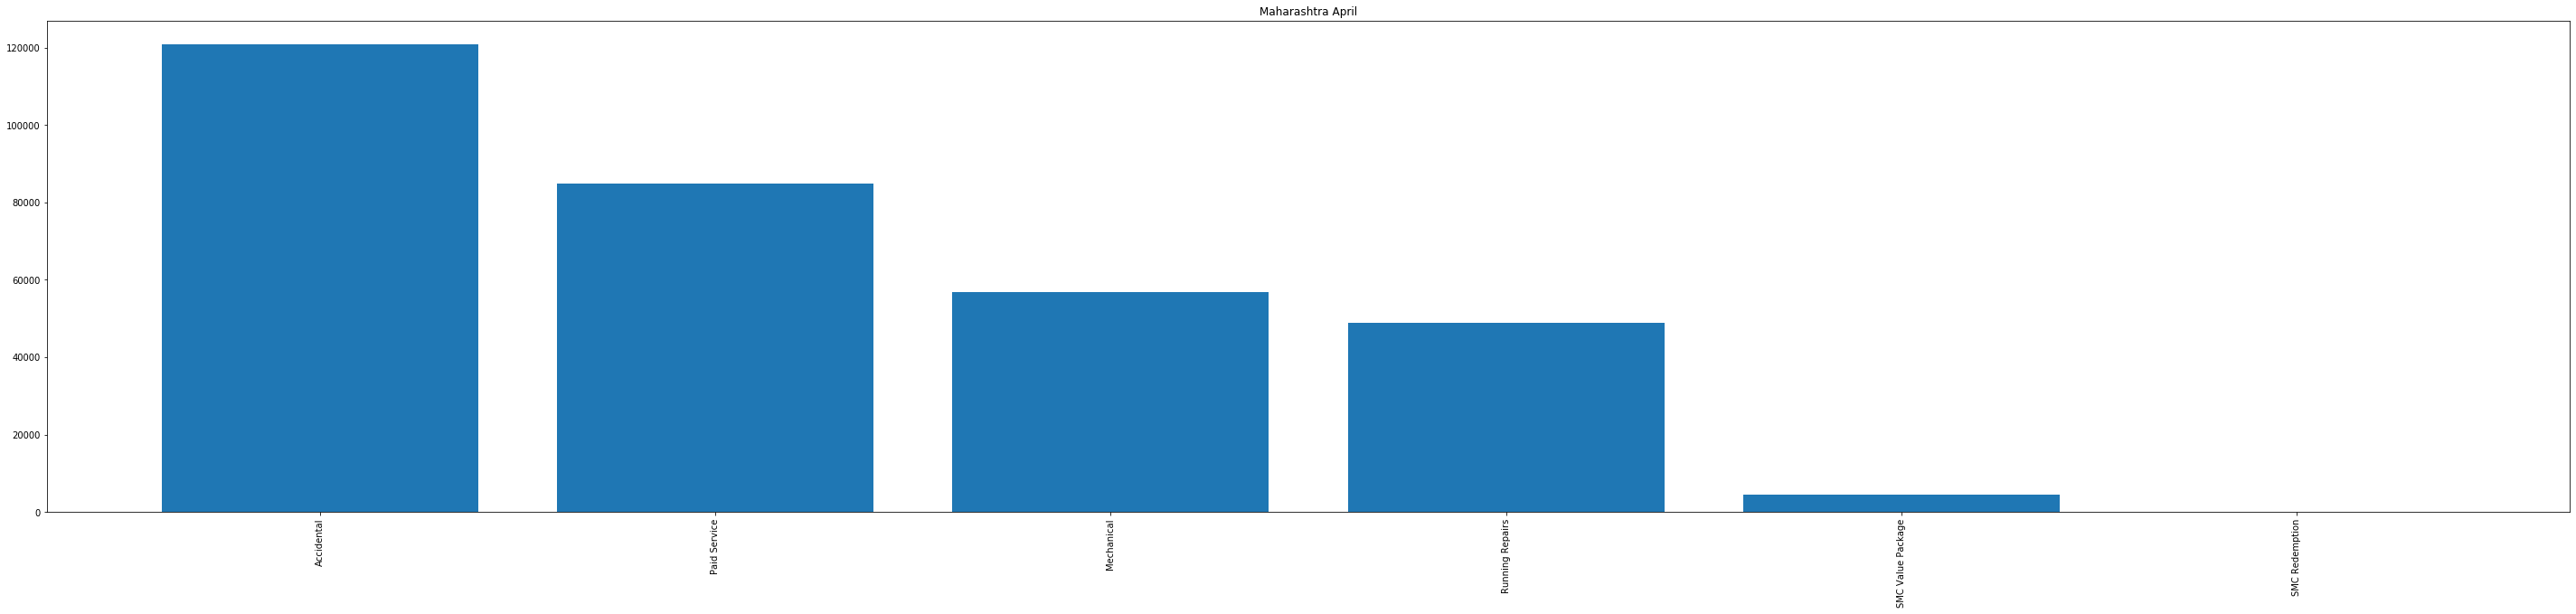

March


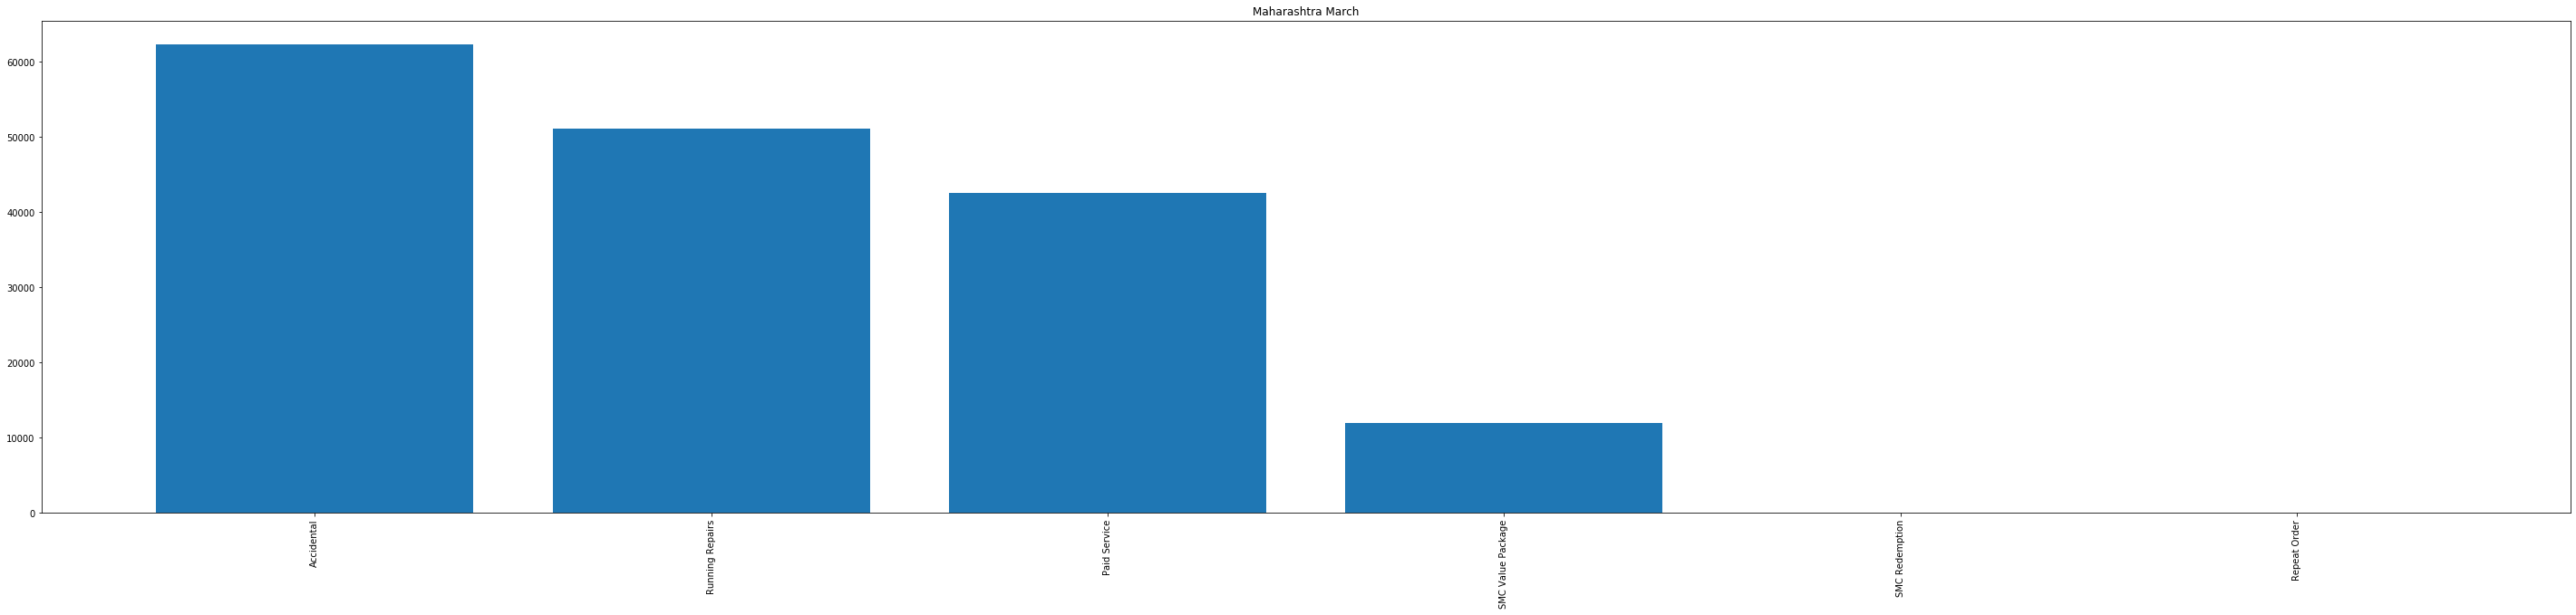

February


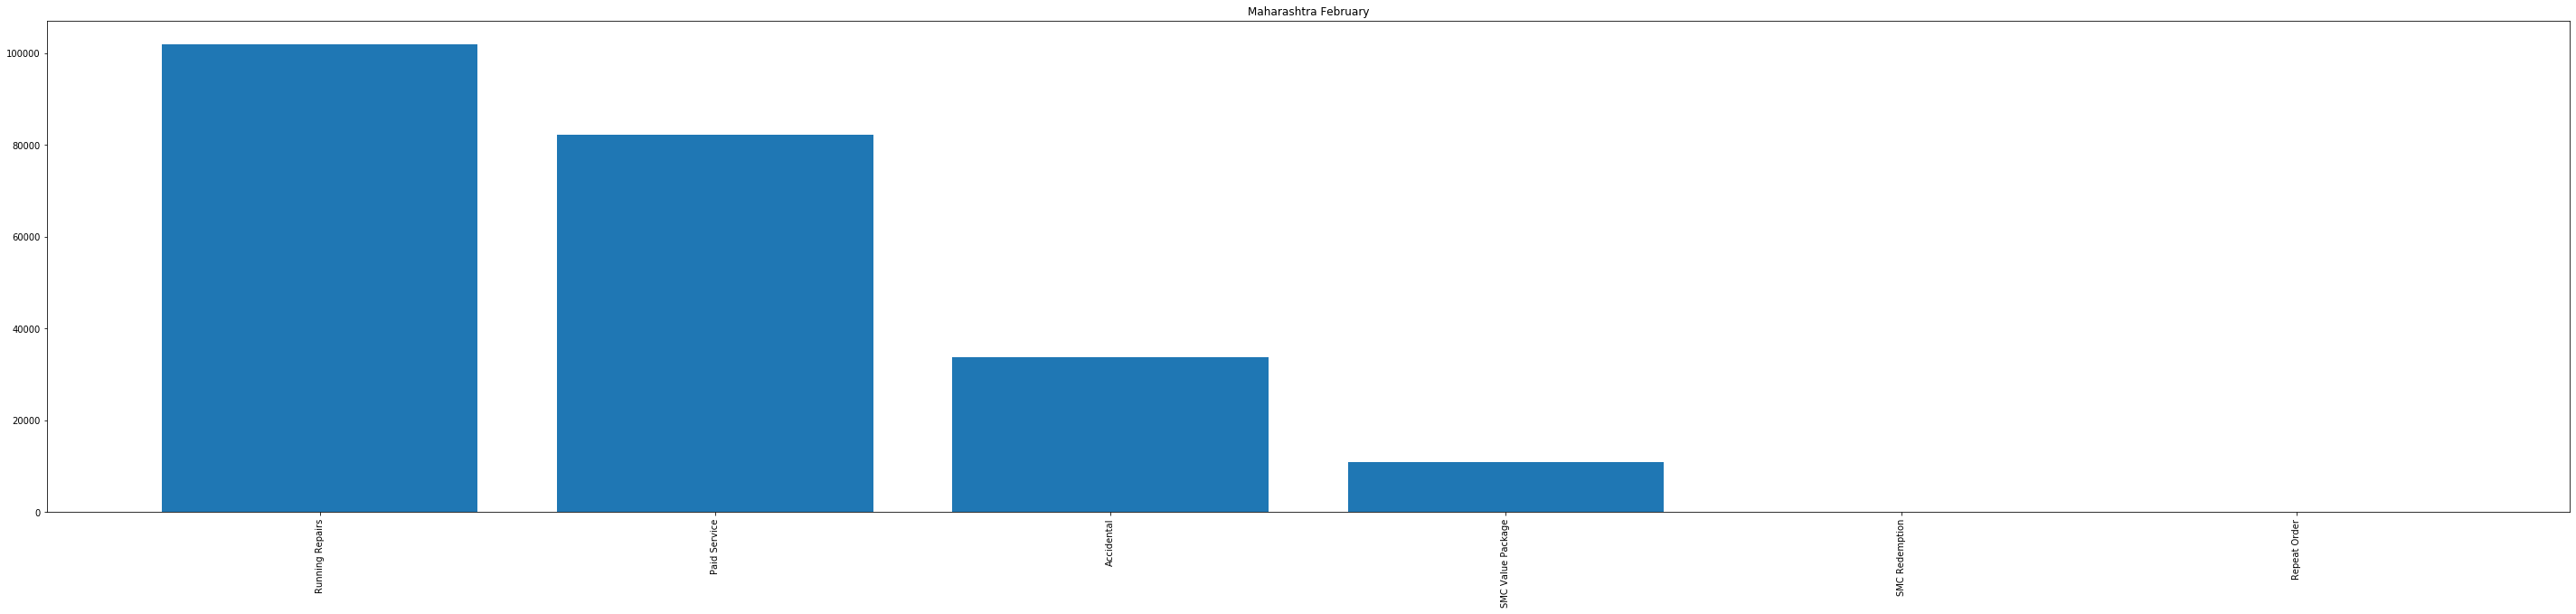

August


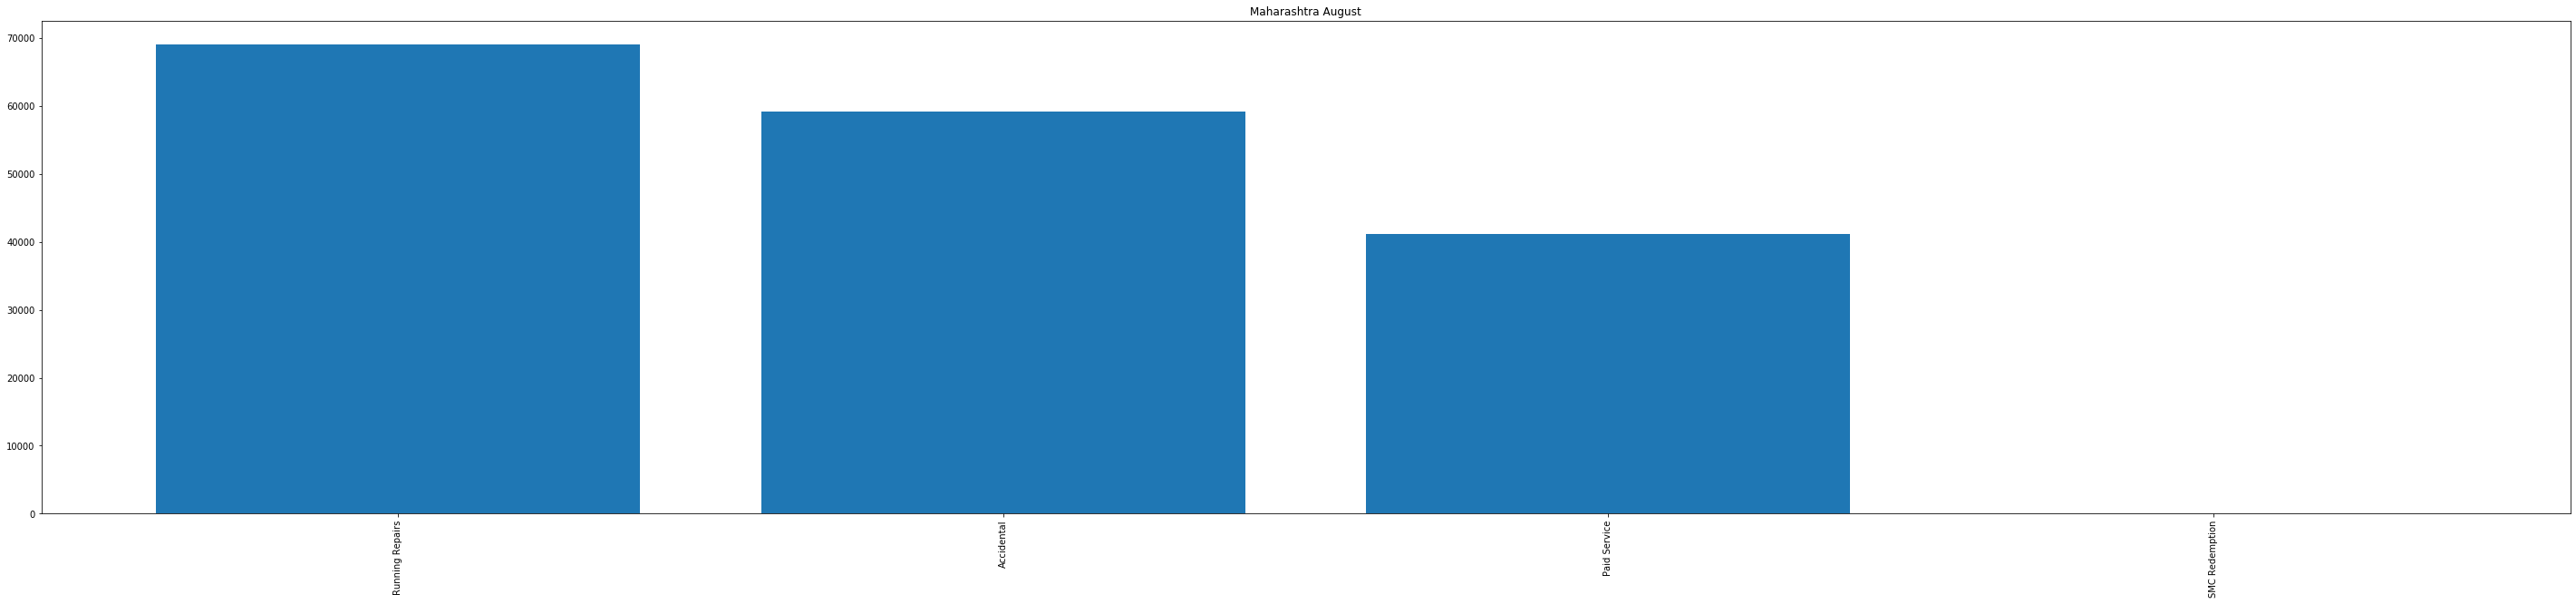

November


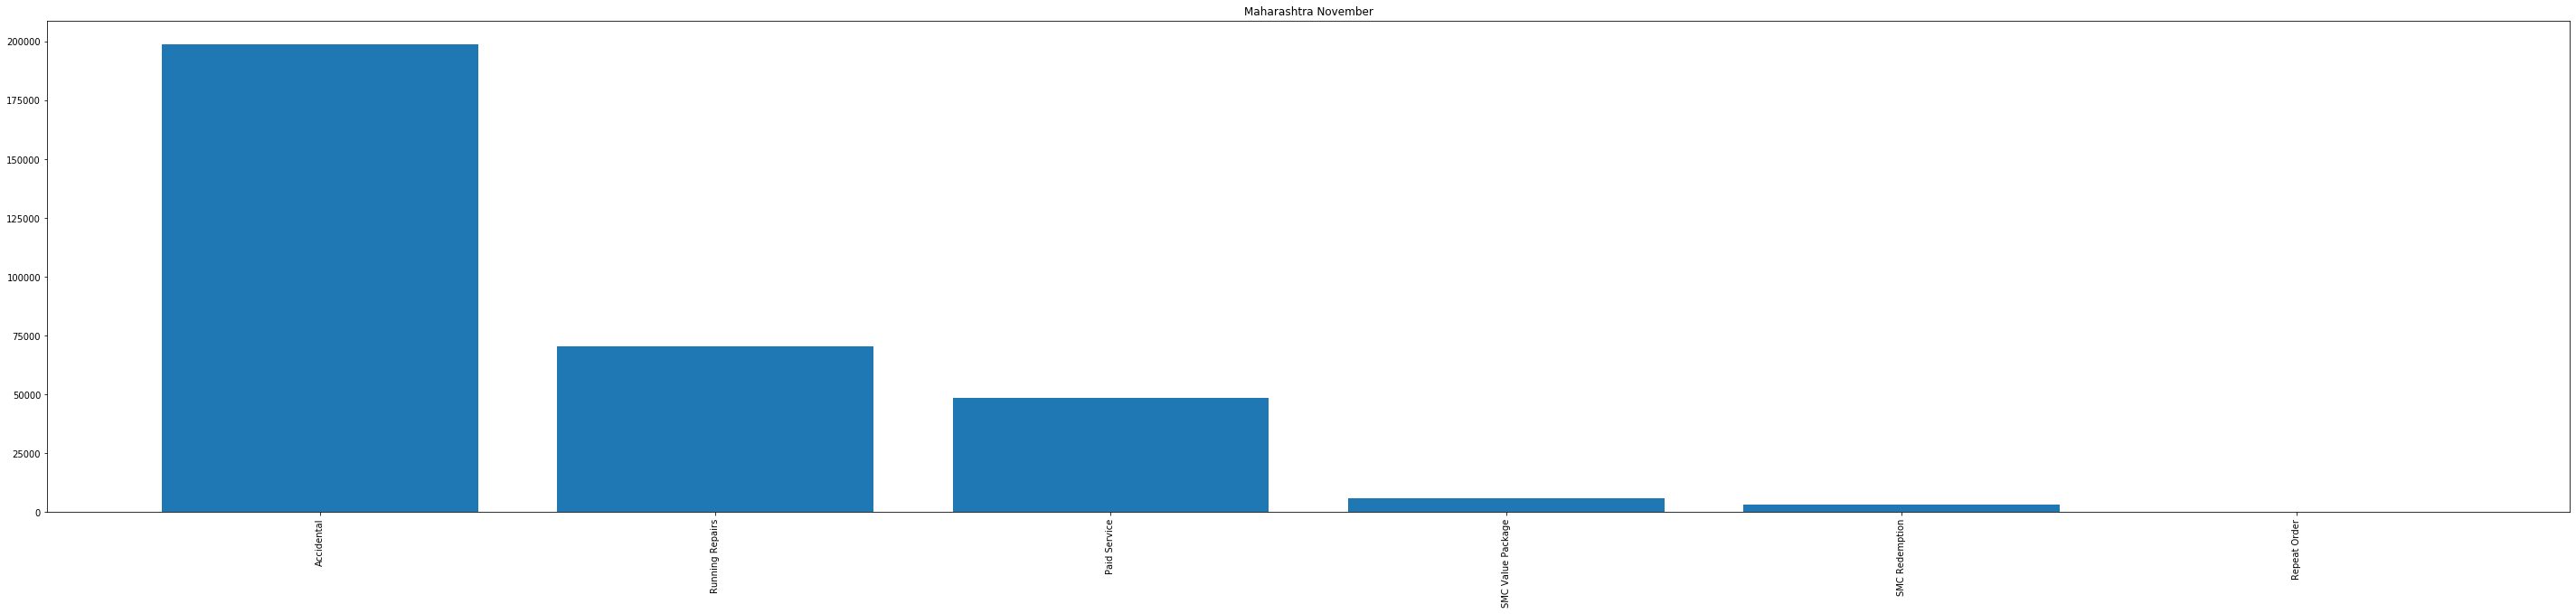

December


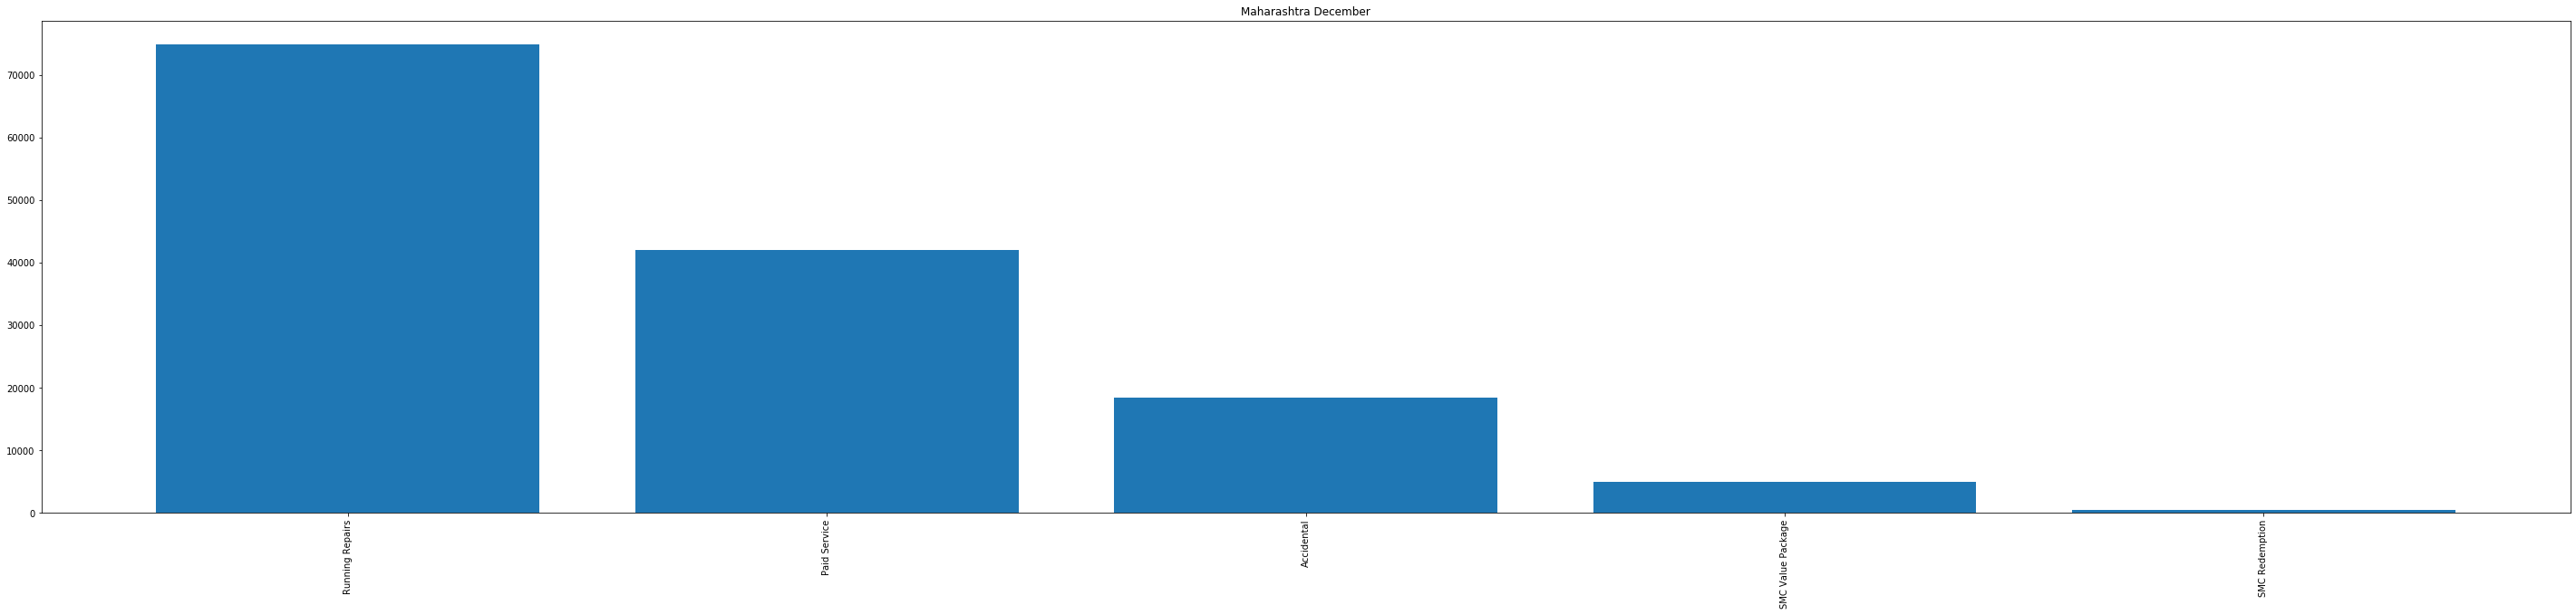

June


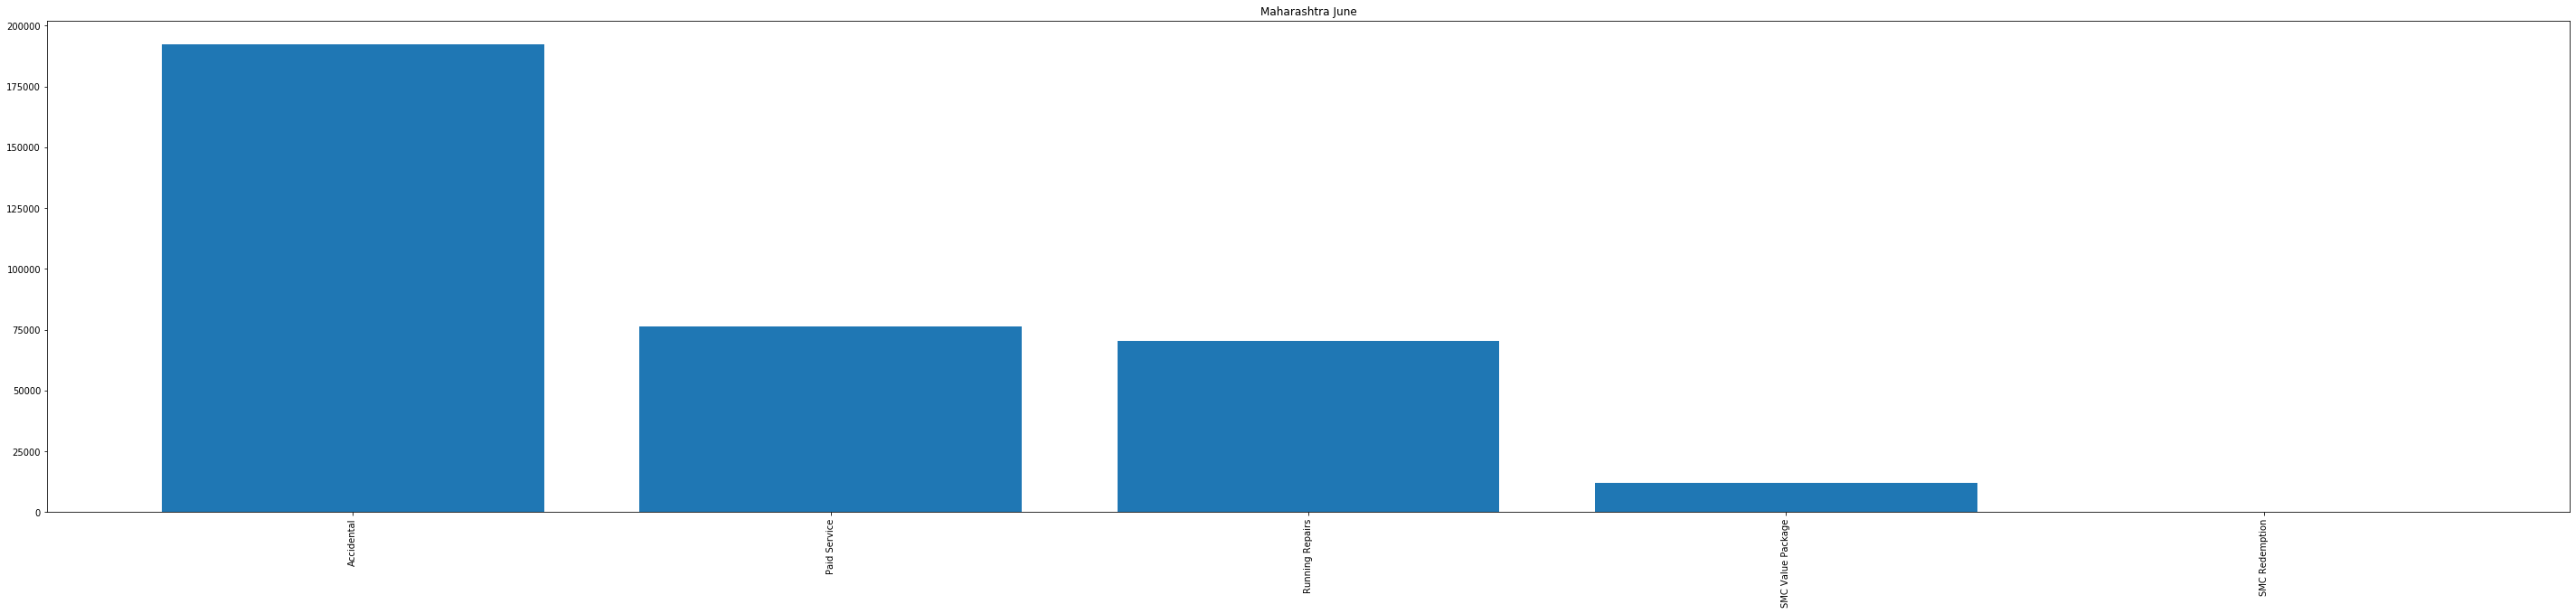

October


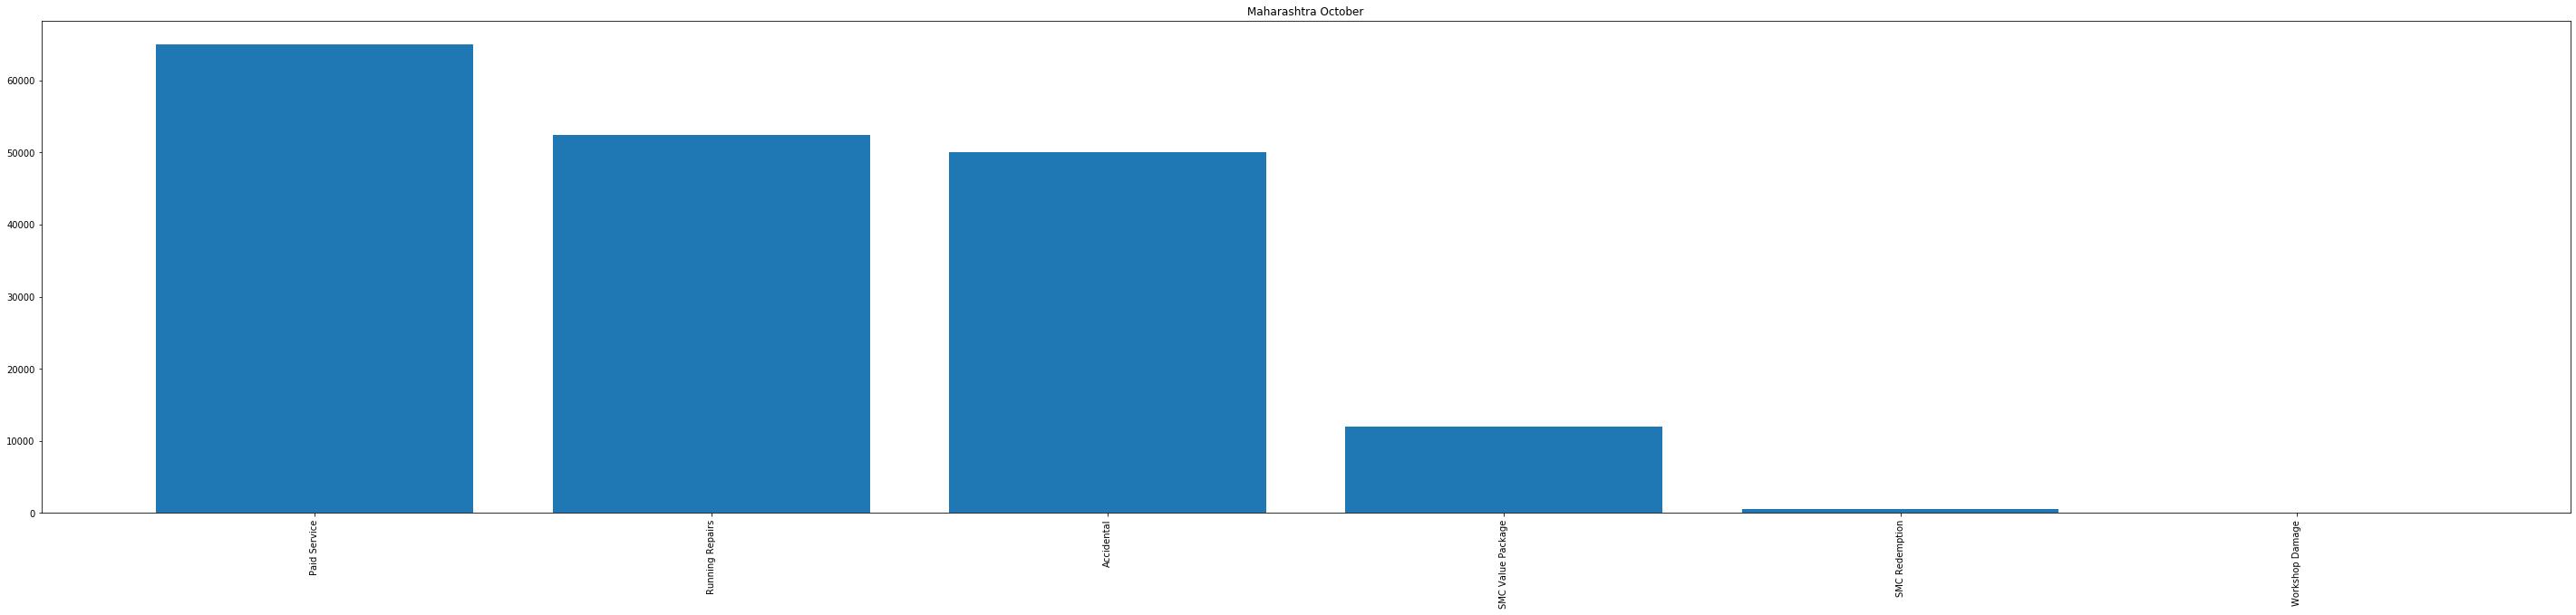

September


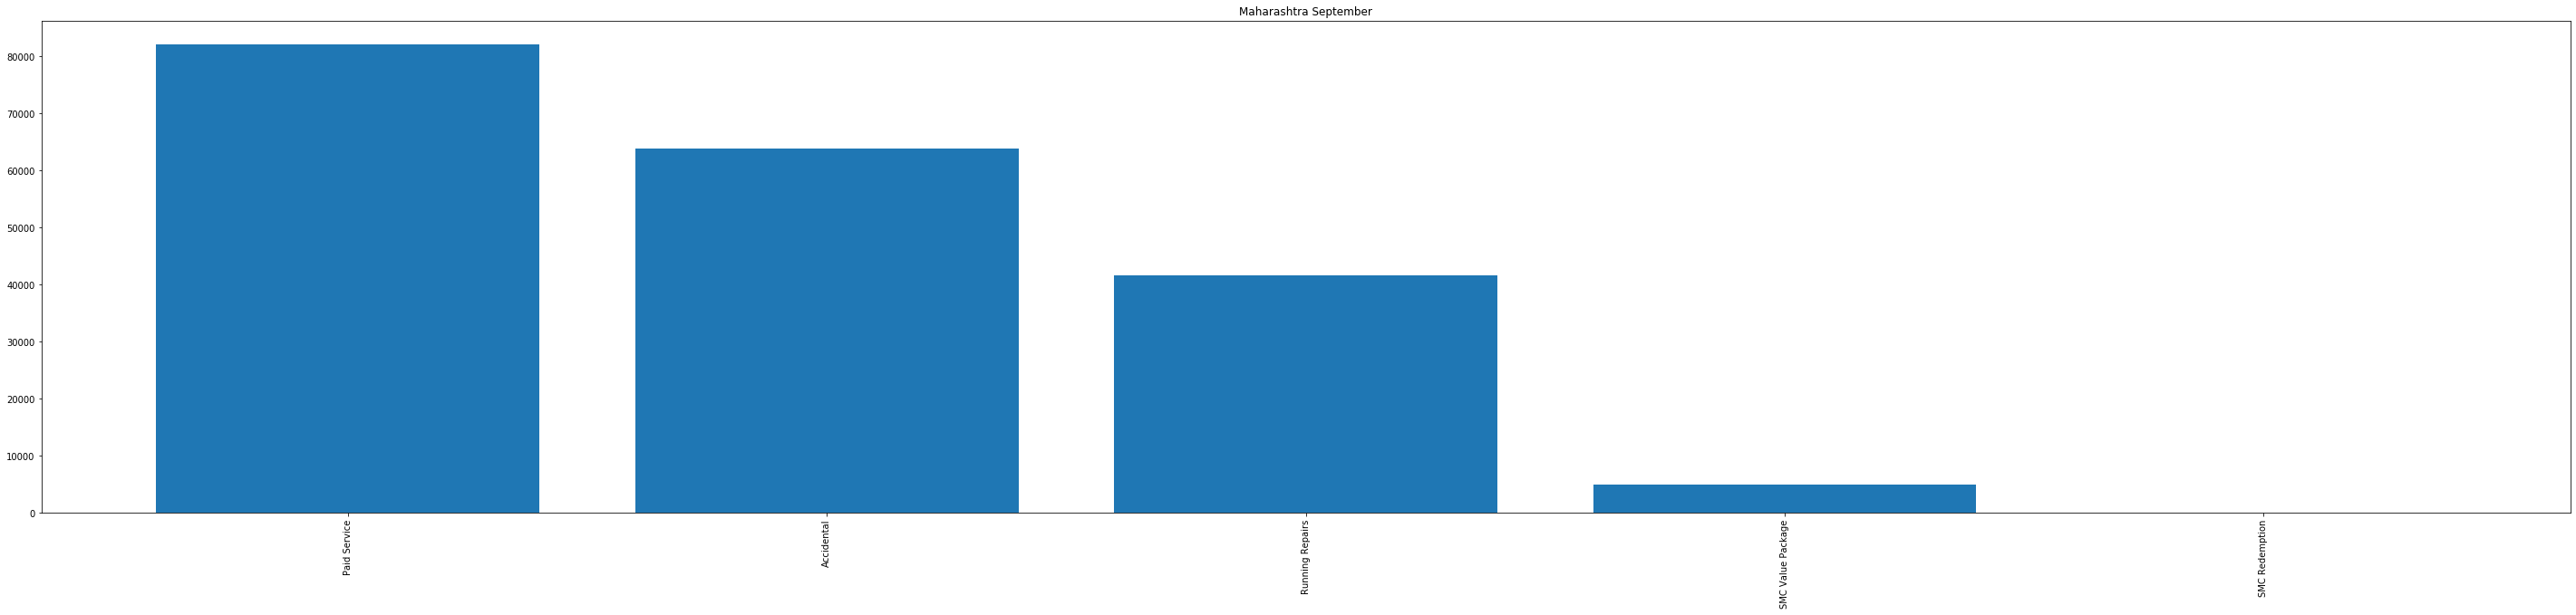

May


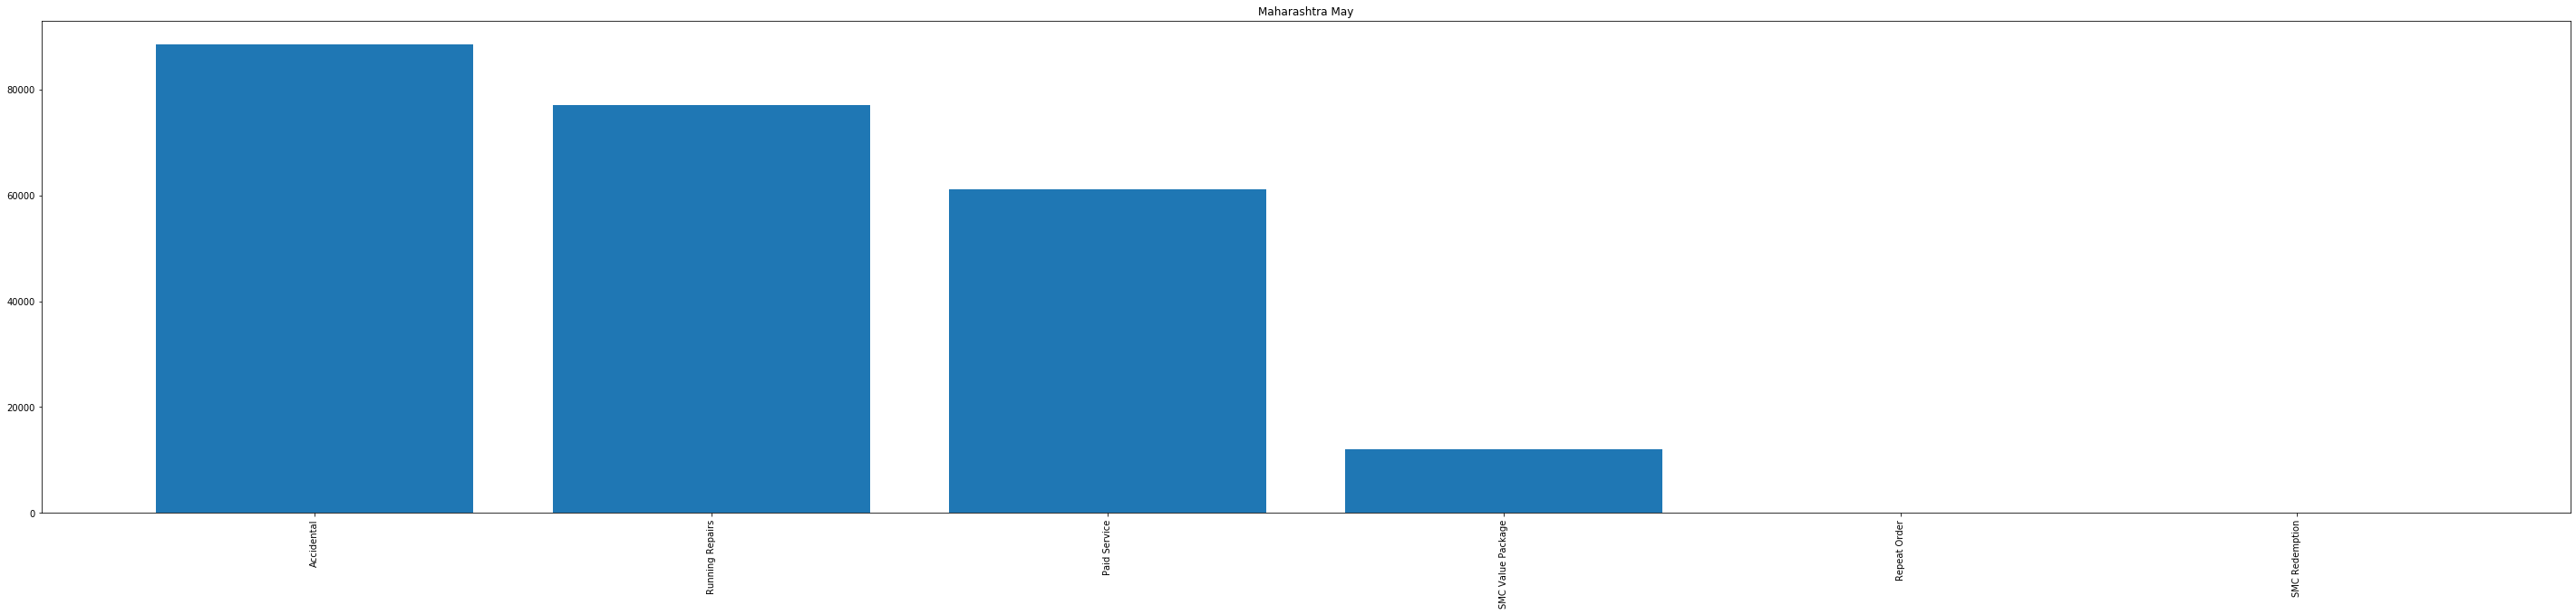

July


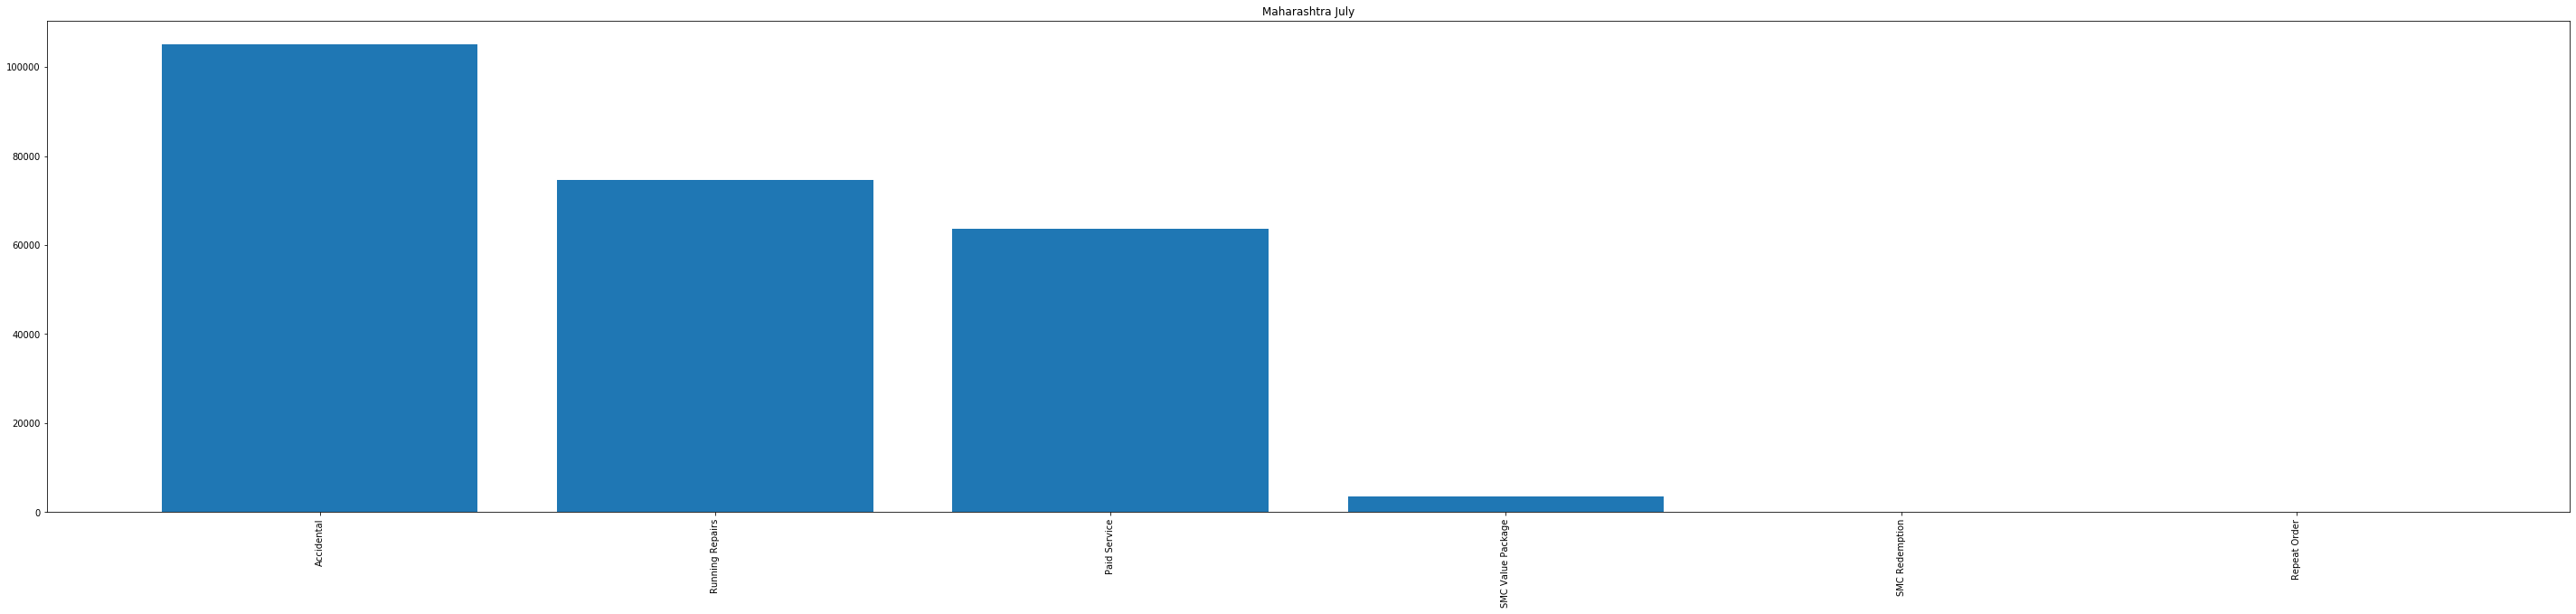

January


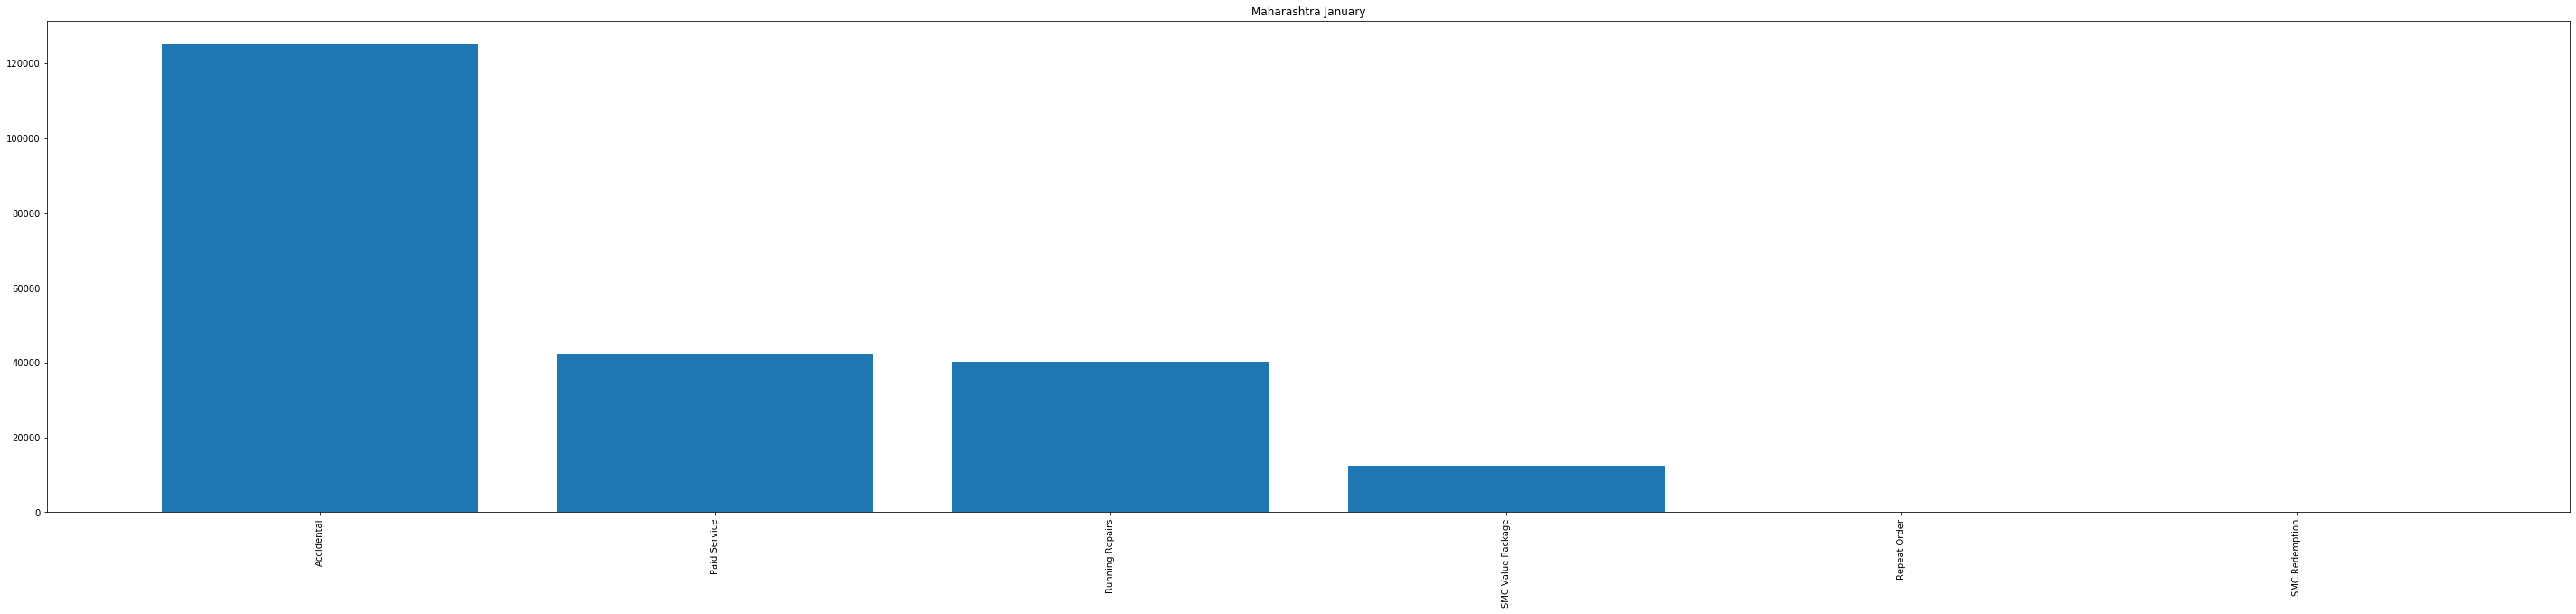

In [160]:
def model_order(state):
    city=[]
    city=join['District'].unique()
    order=join['Order Type'].unique()
    #print(cars['Order Type'].value_counts())

    cars=join[join['District']==state]
    for j in cars['month'].unique():
        print(j)
        order=cars[cars['month']==j]
        fig=plt.figure(figsize=(50,10))
        plt.title('Maharashtra'+" "+j)
        #cars=cars.sort_values('Total Amt Wtd Tax.',ascending=False)
        #order['Order Type'].value_counts().plot(kind='bar')
        order=order.sort_values('Revenue',ascending=False)
        plt.bar(order['Order Type'],order['Revenue'])
        plt.xticks(rotation=90)
        plt.show()
    
model_order('tamil nadu') 

In [161]:
parts=pd.read_csv('JTD.csv')

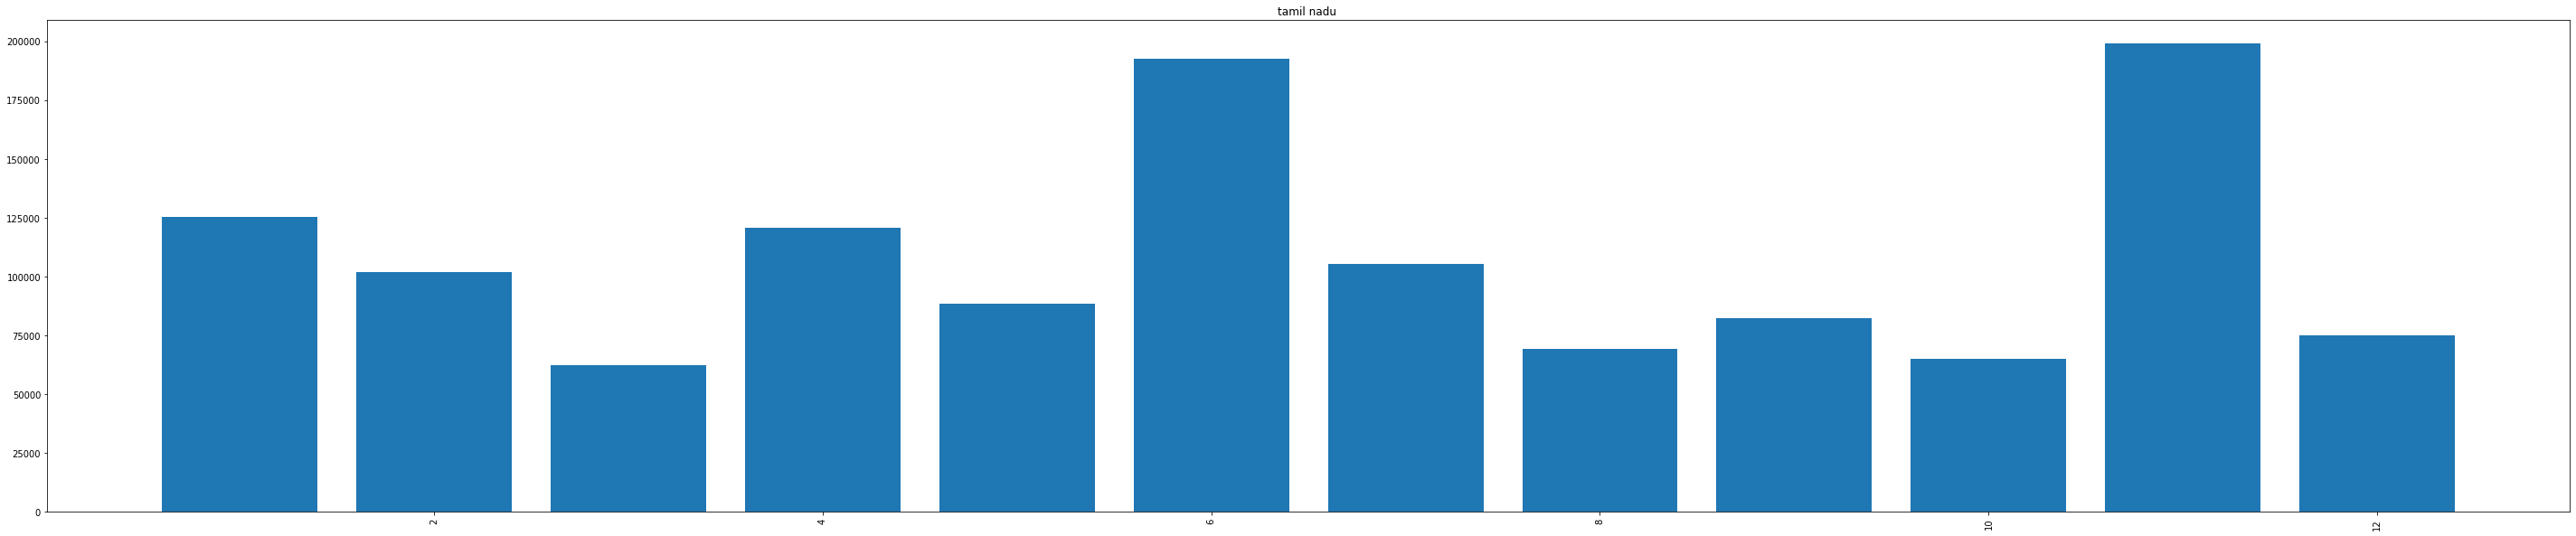

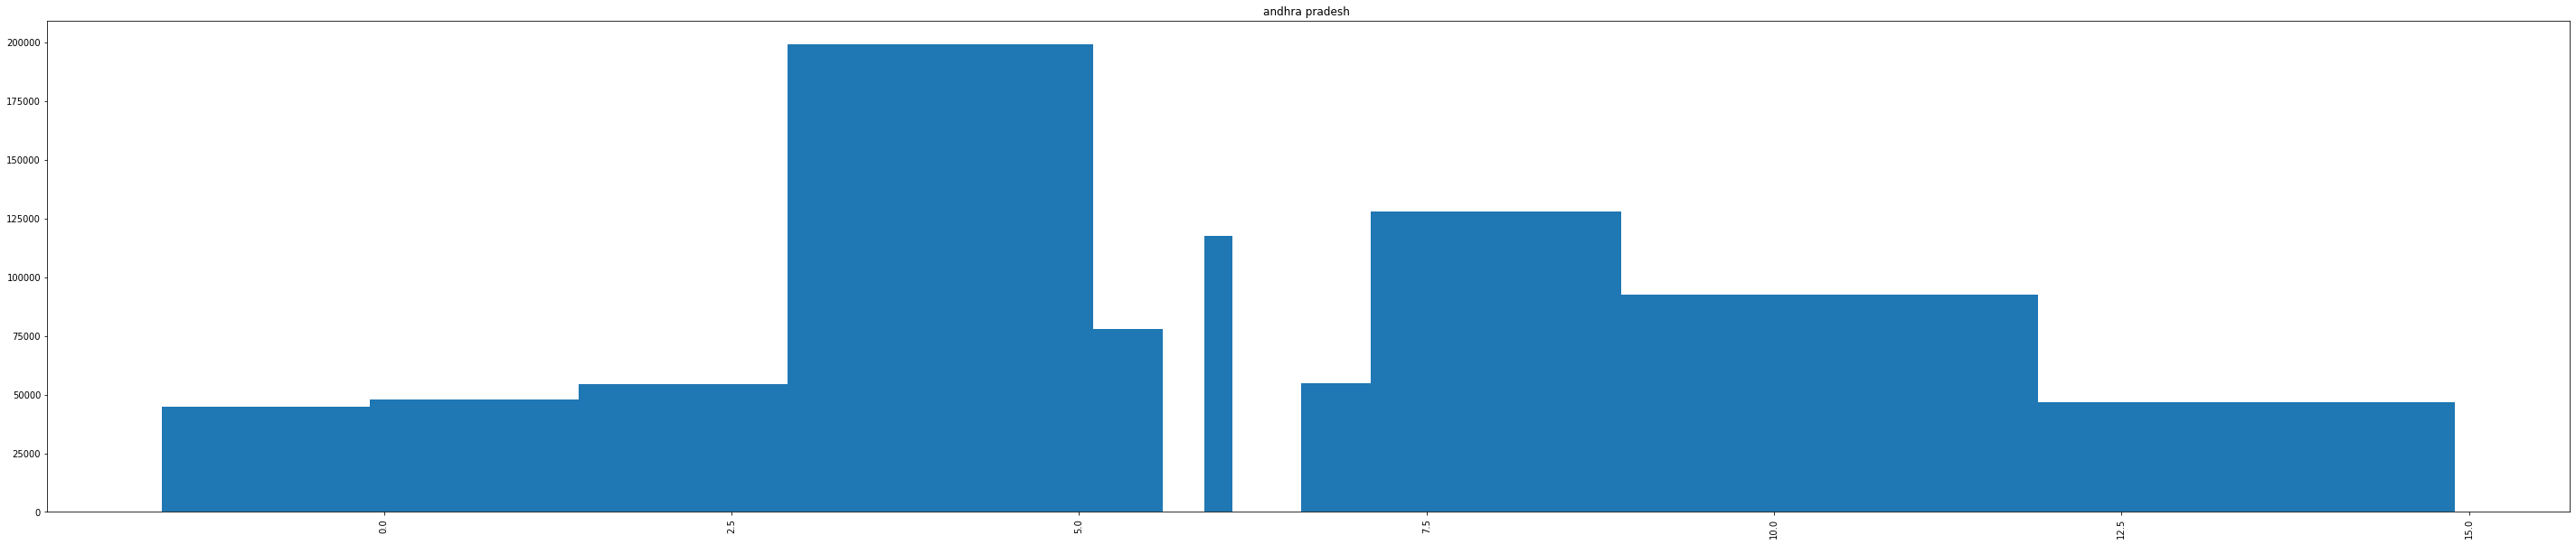

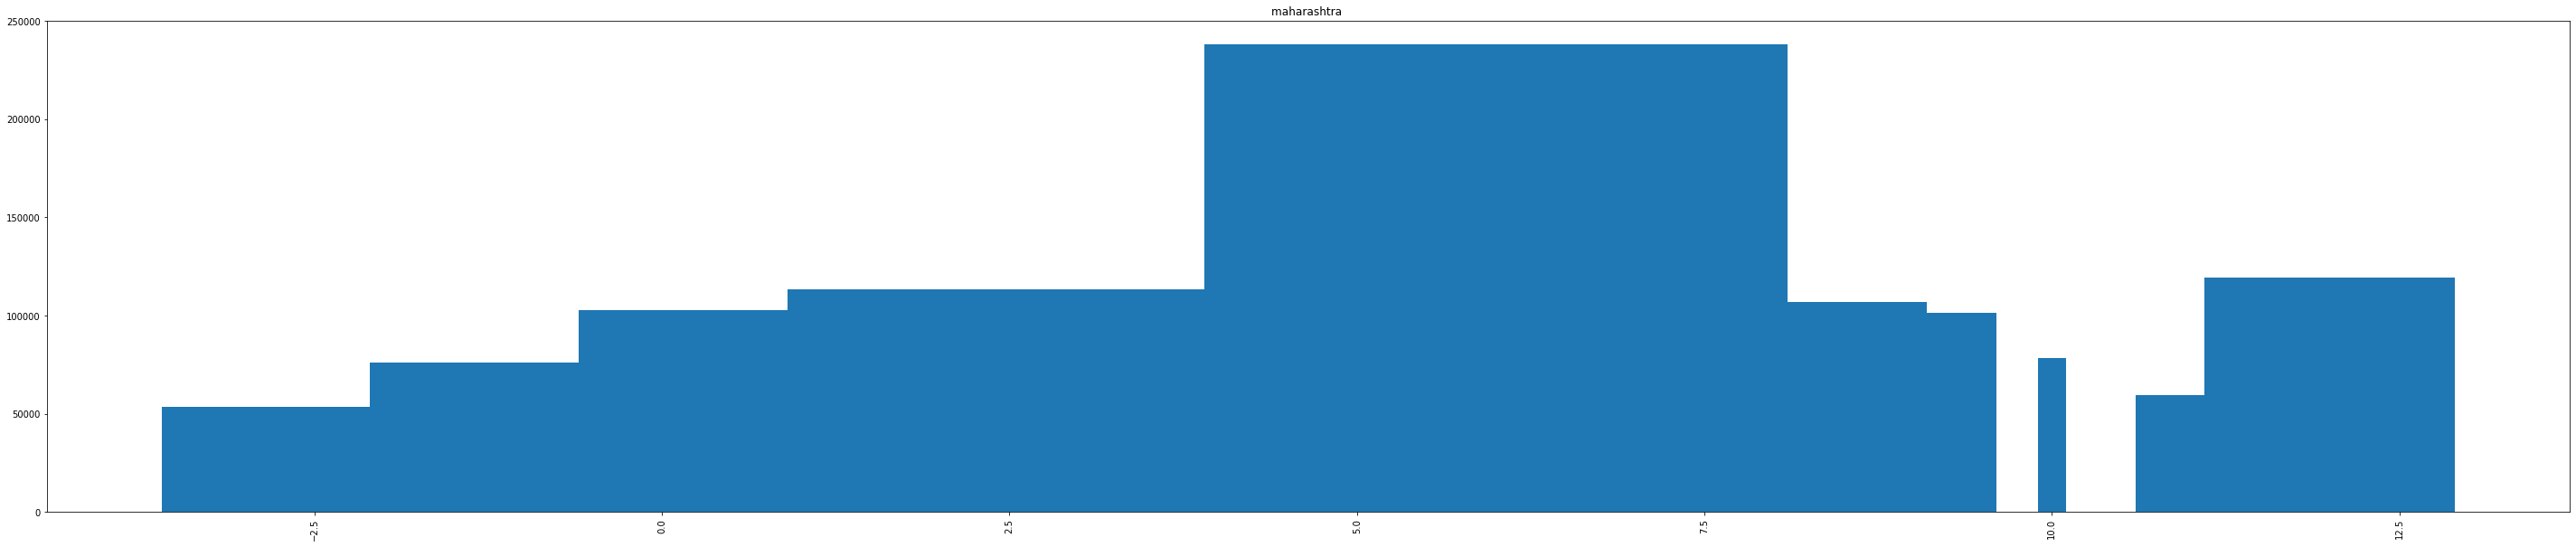

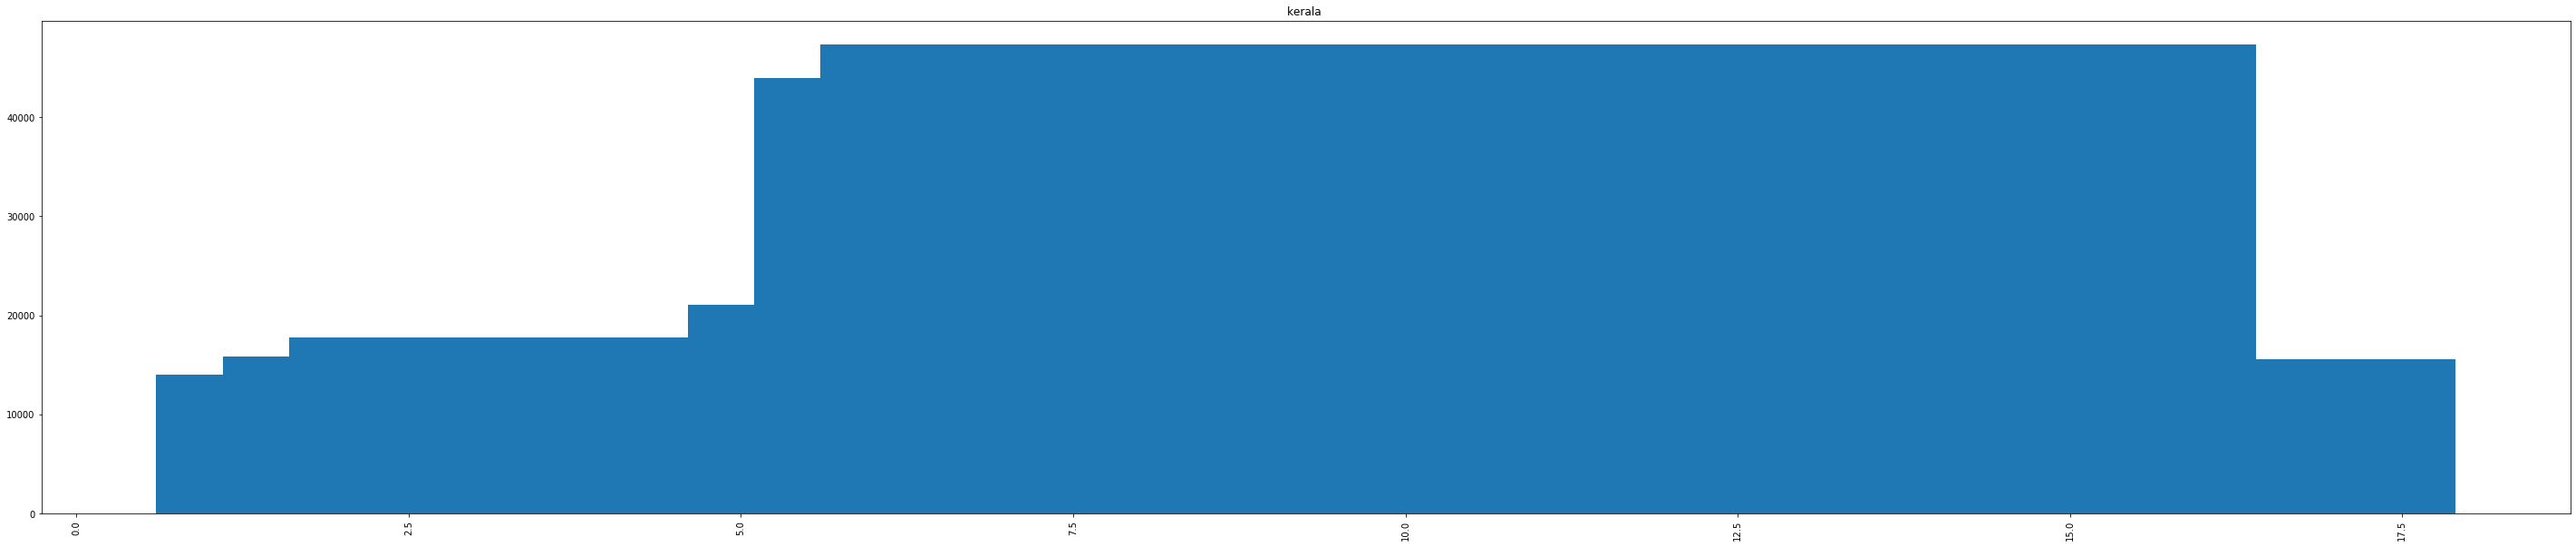

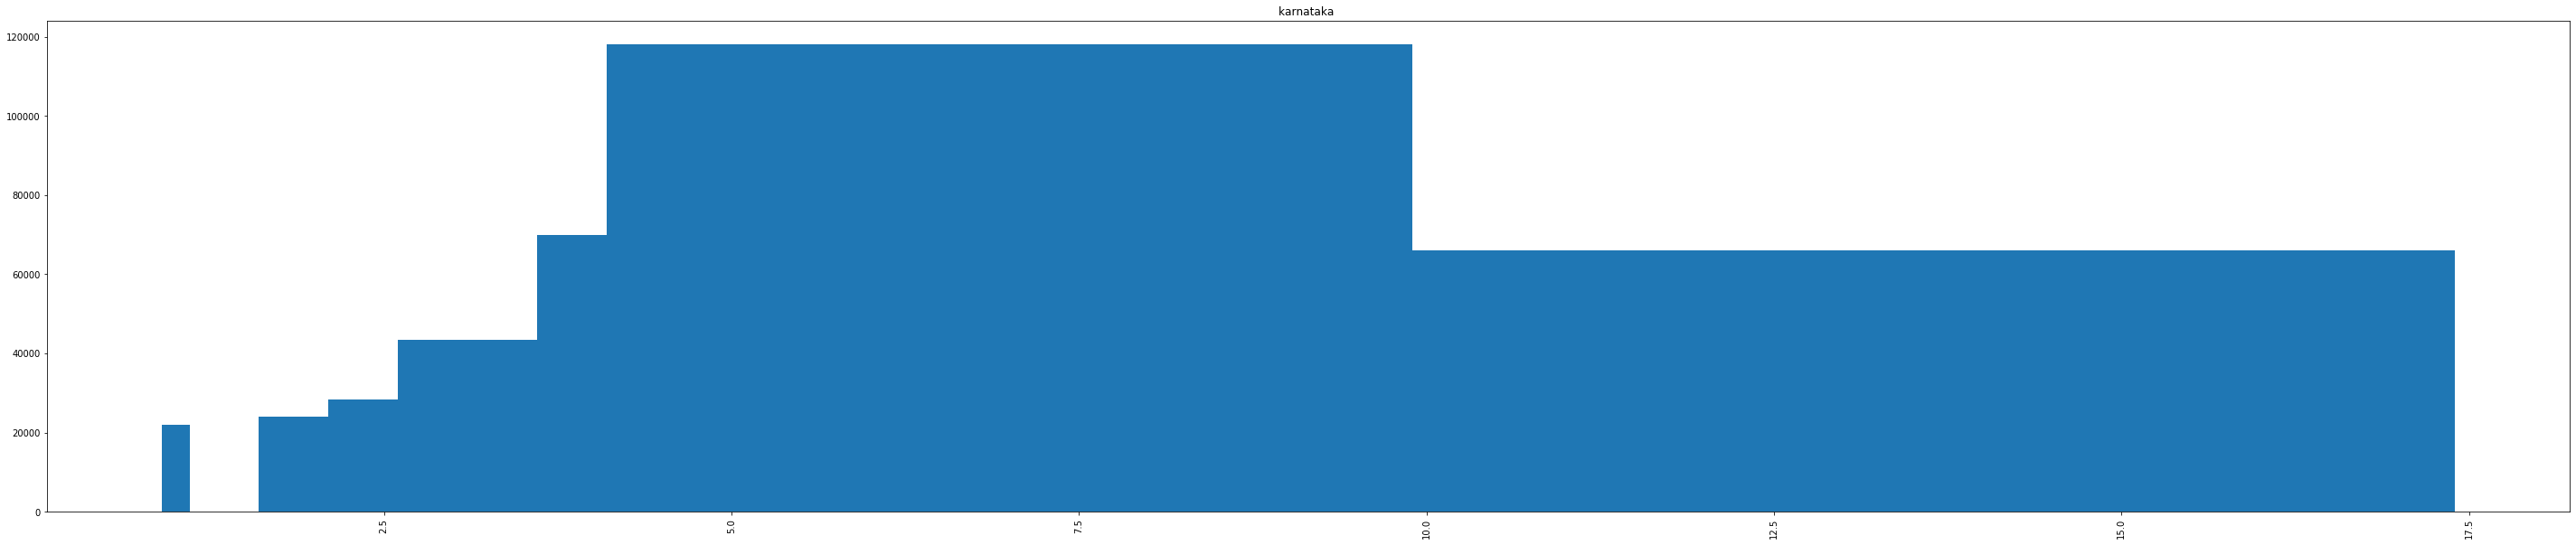

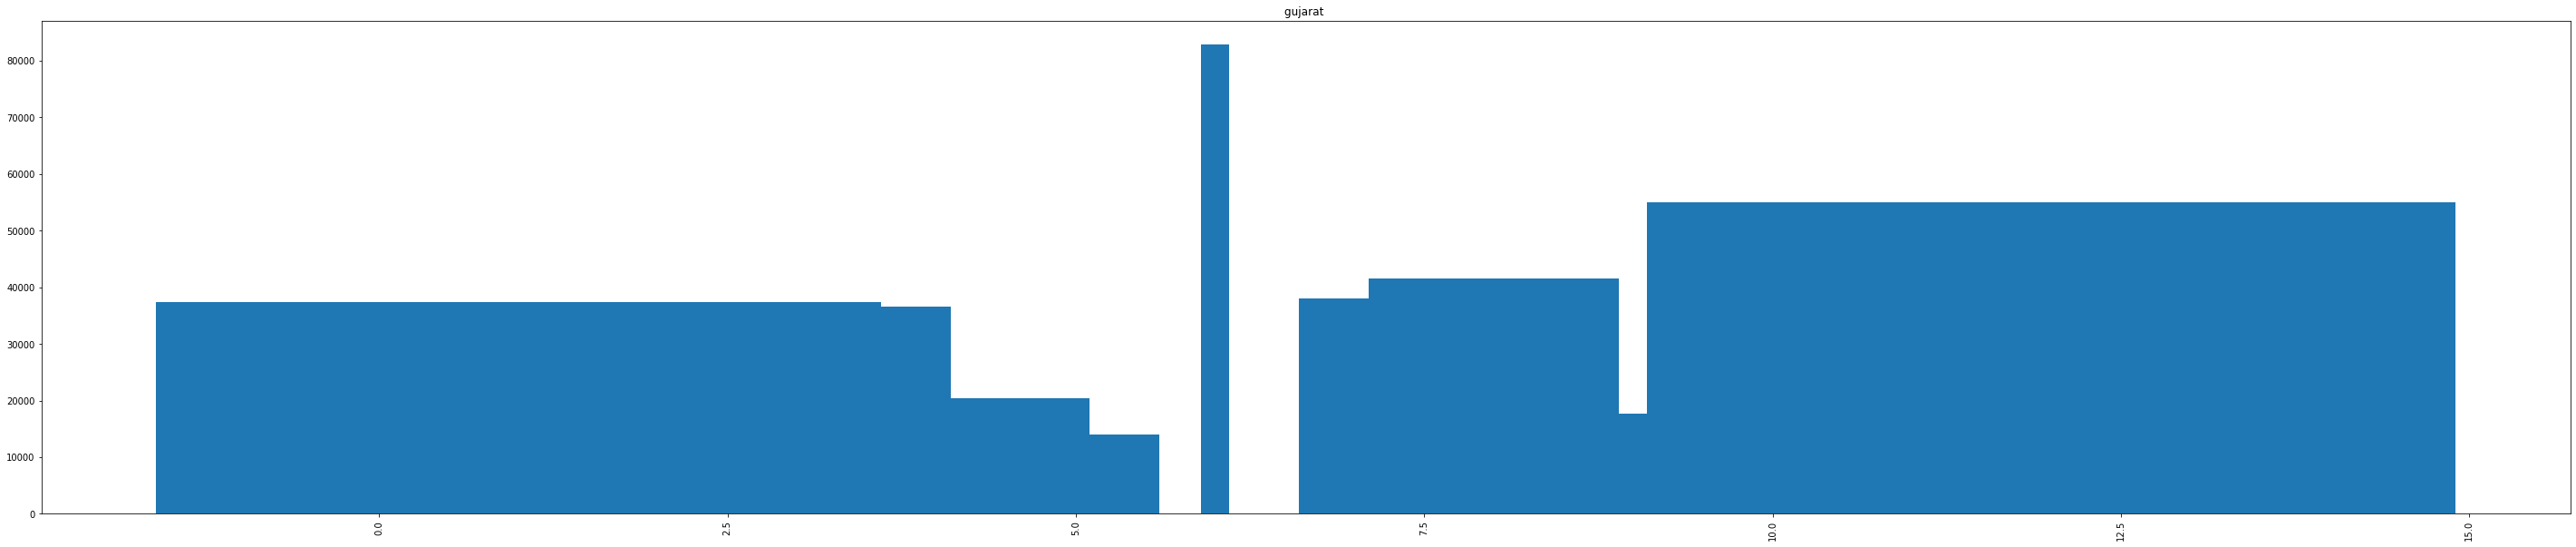

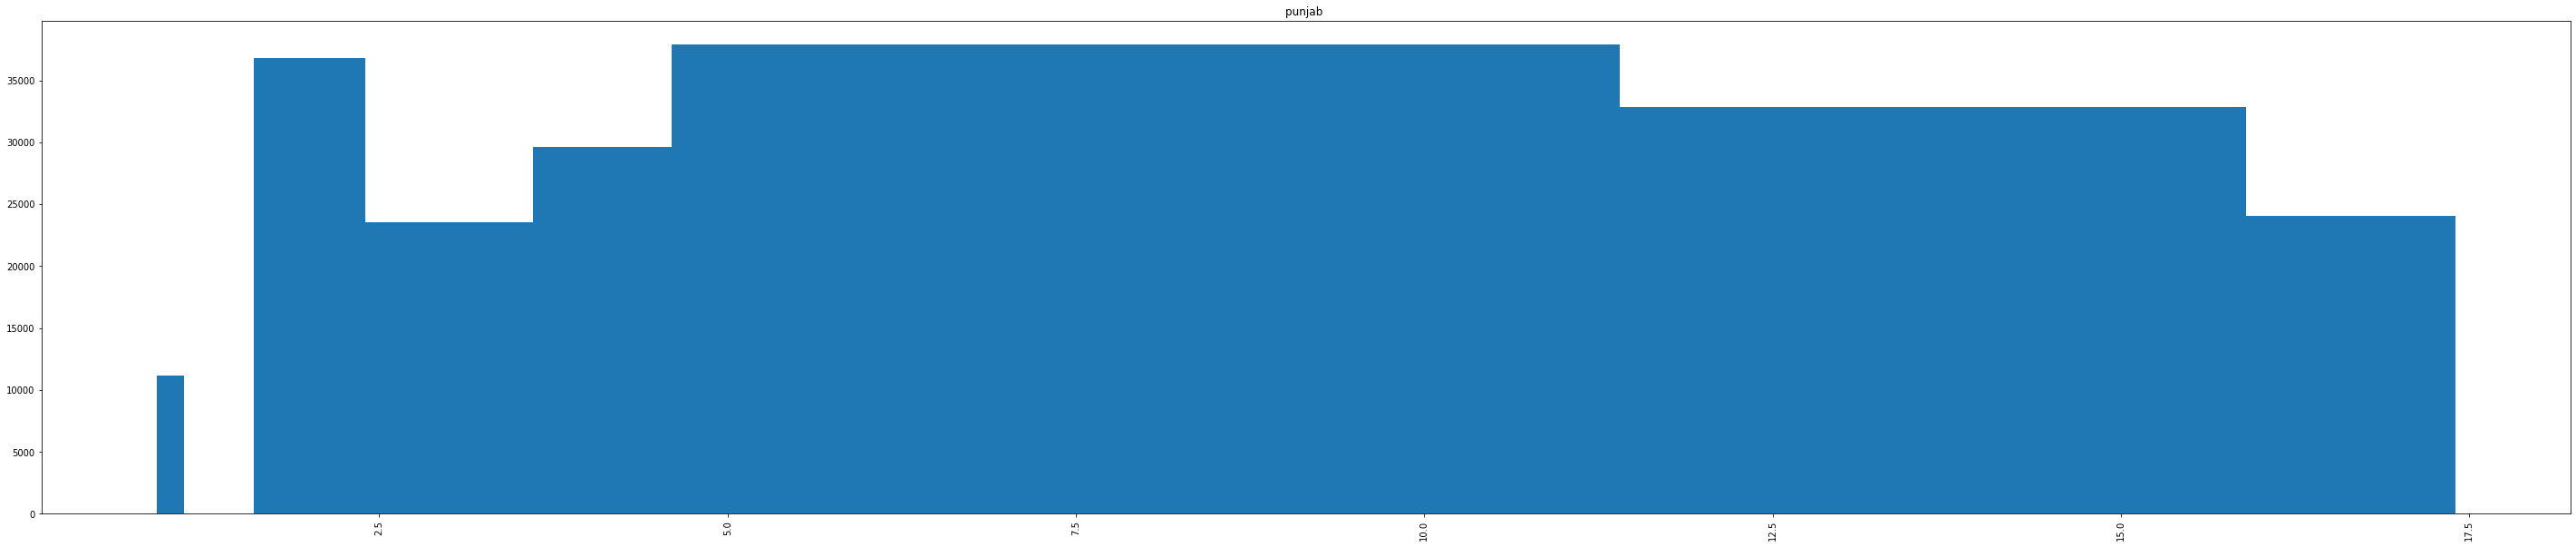

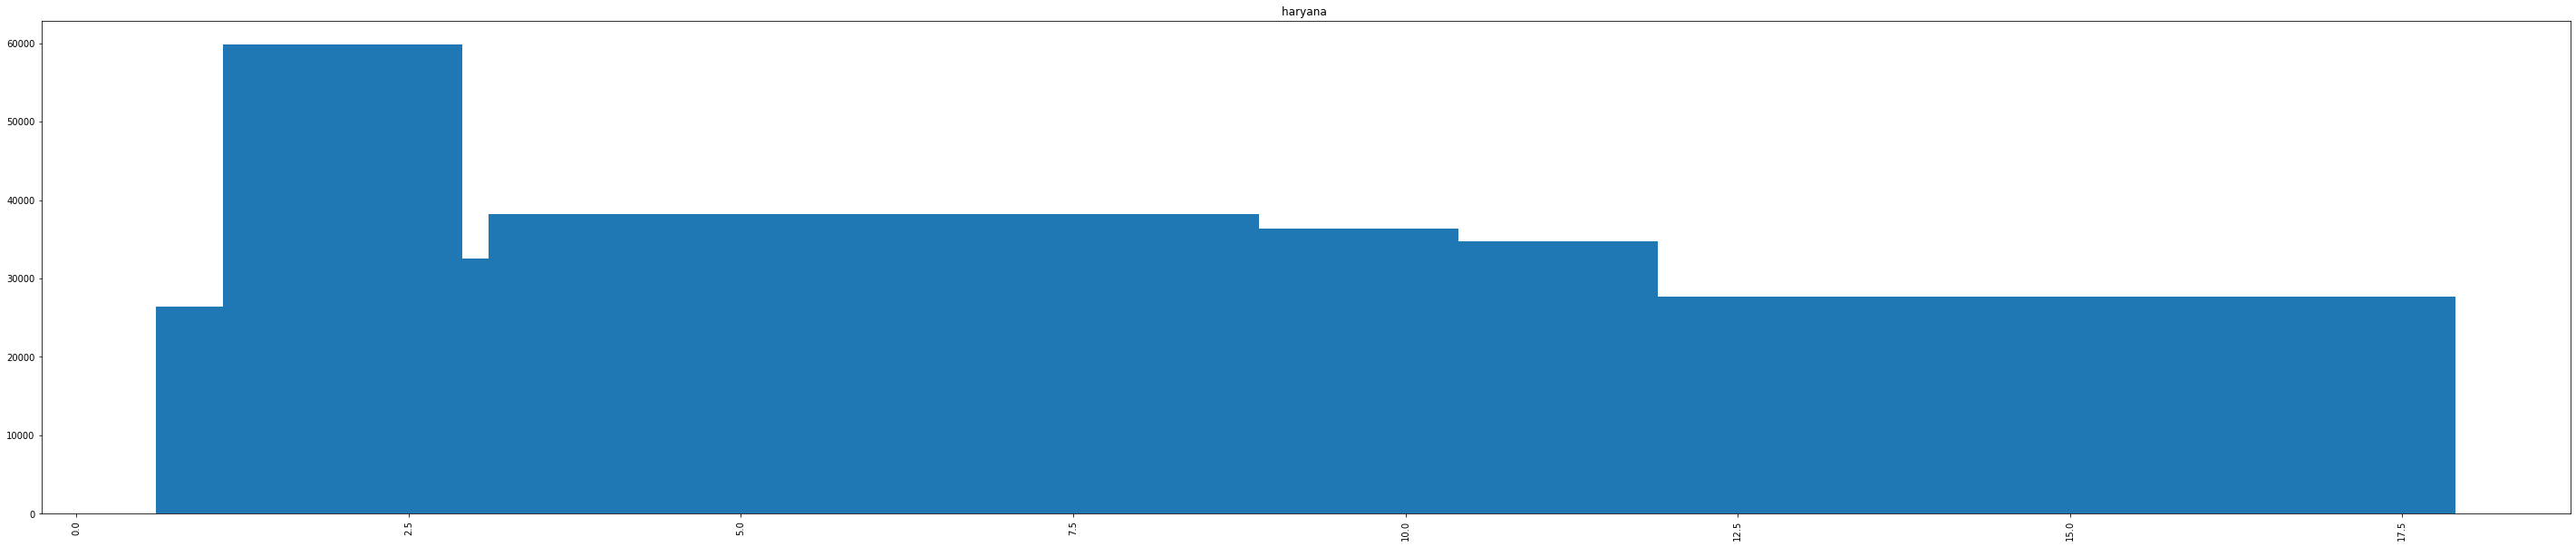

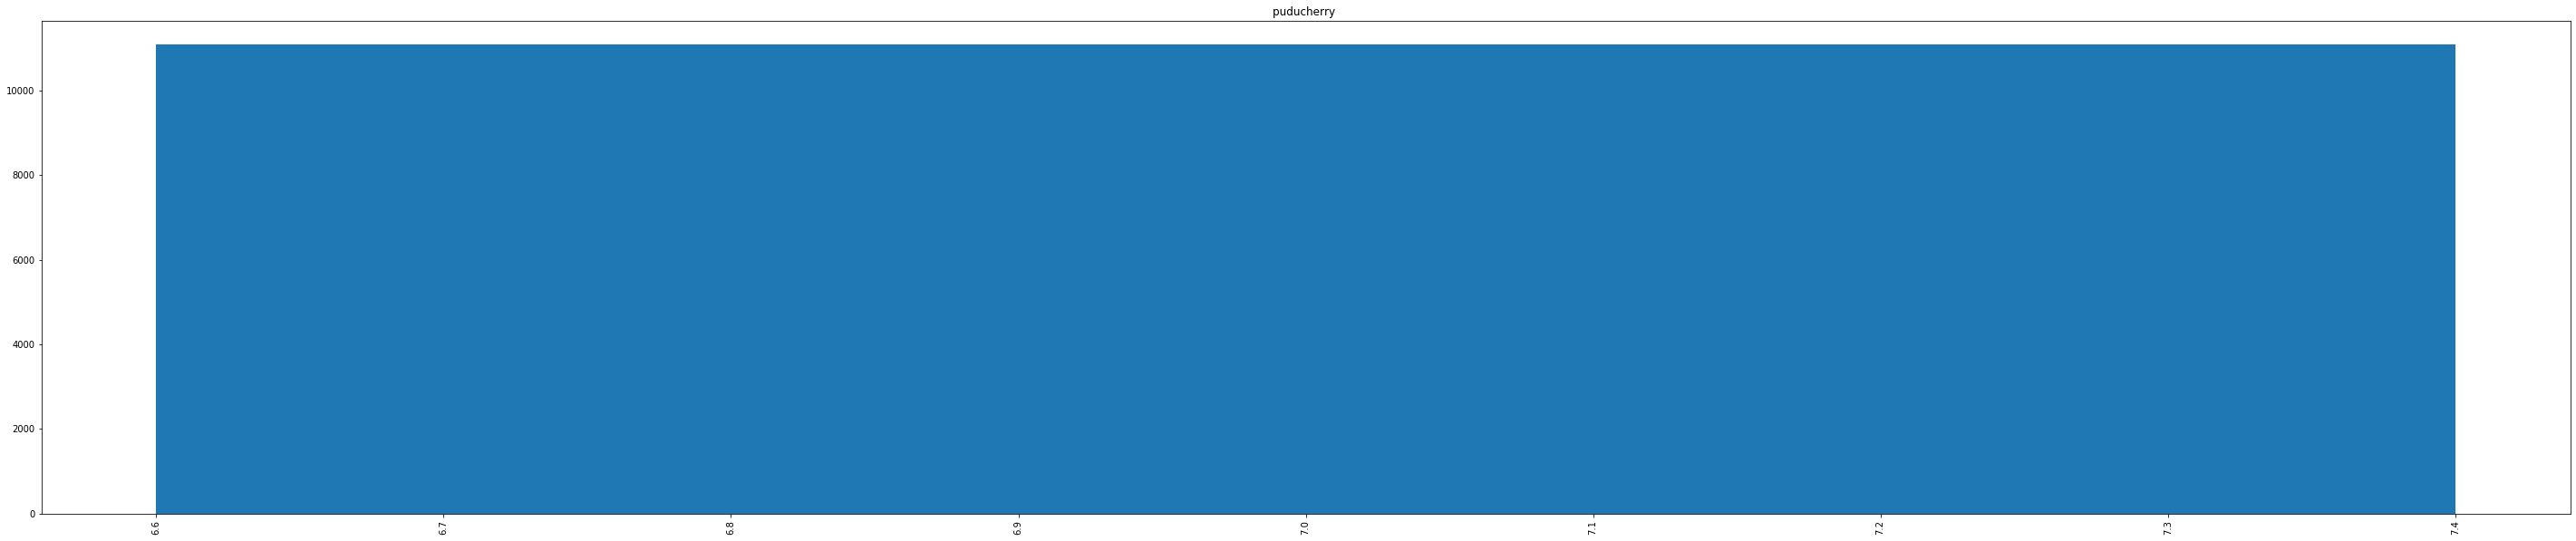

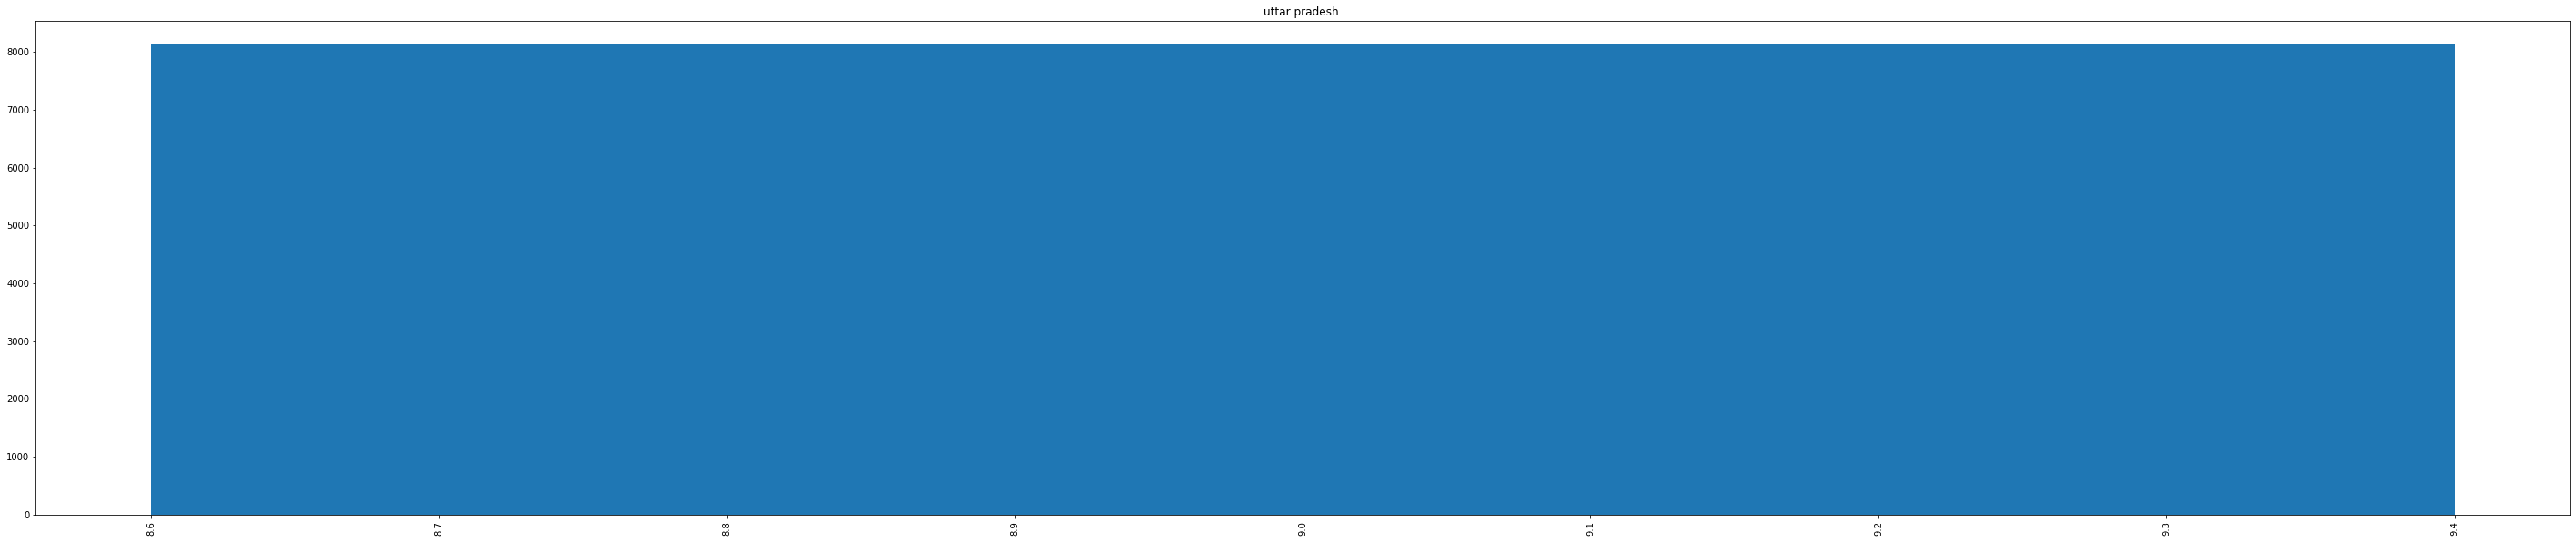

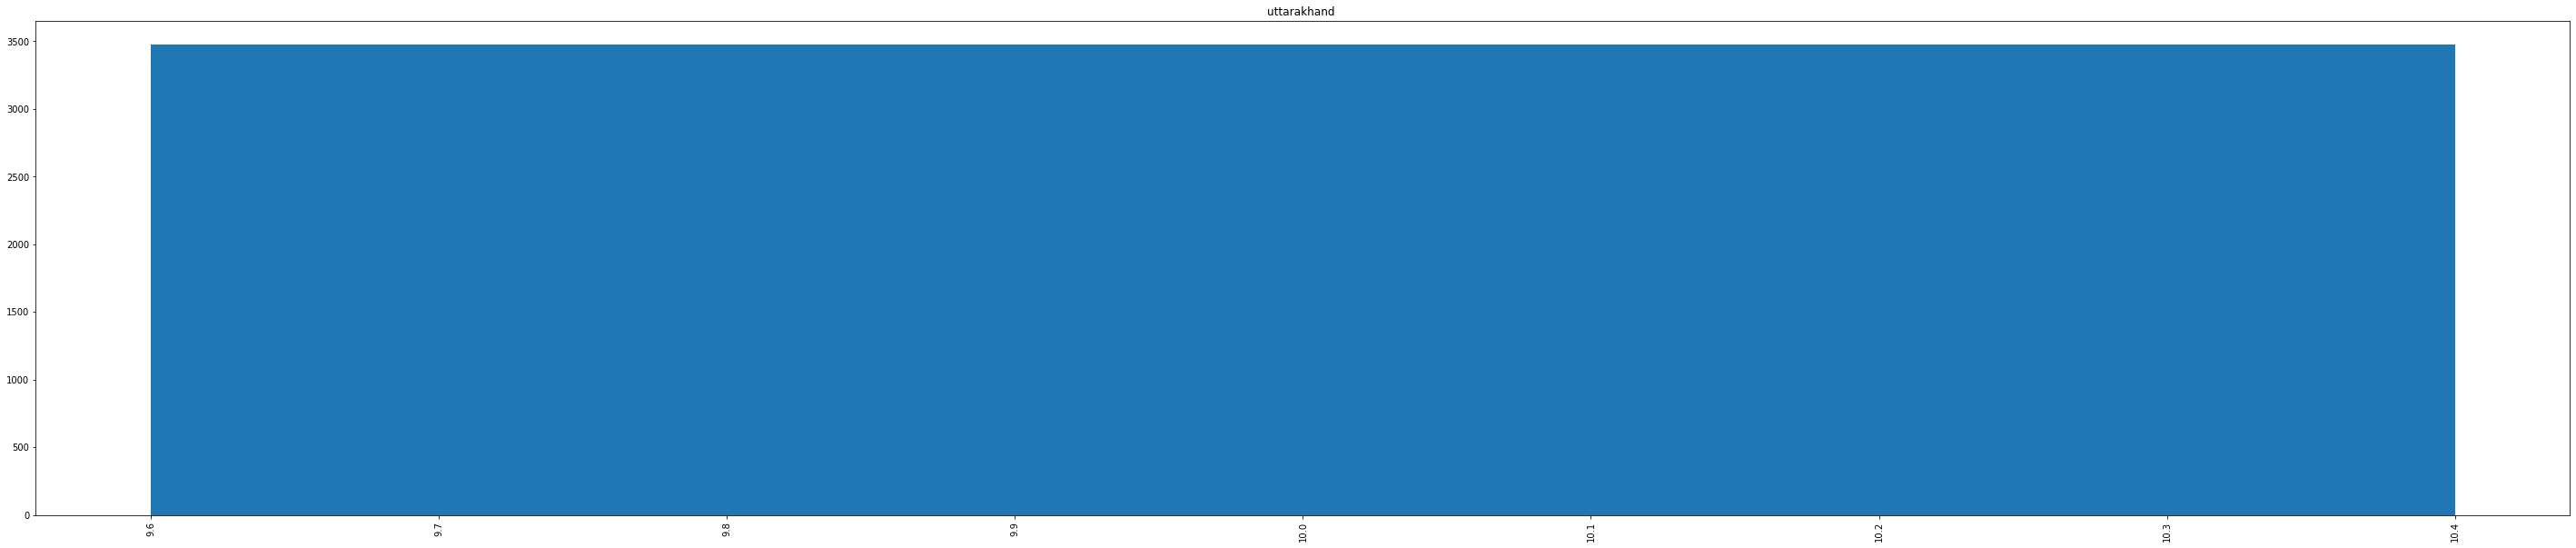

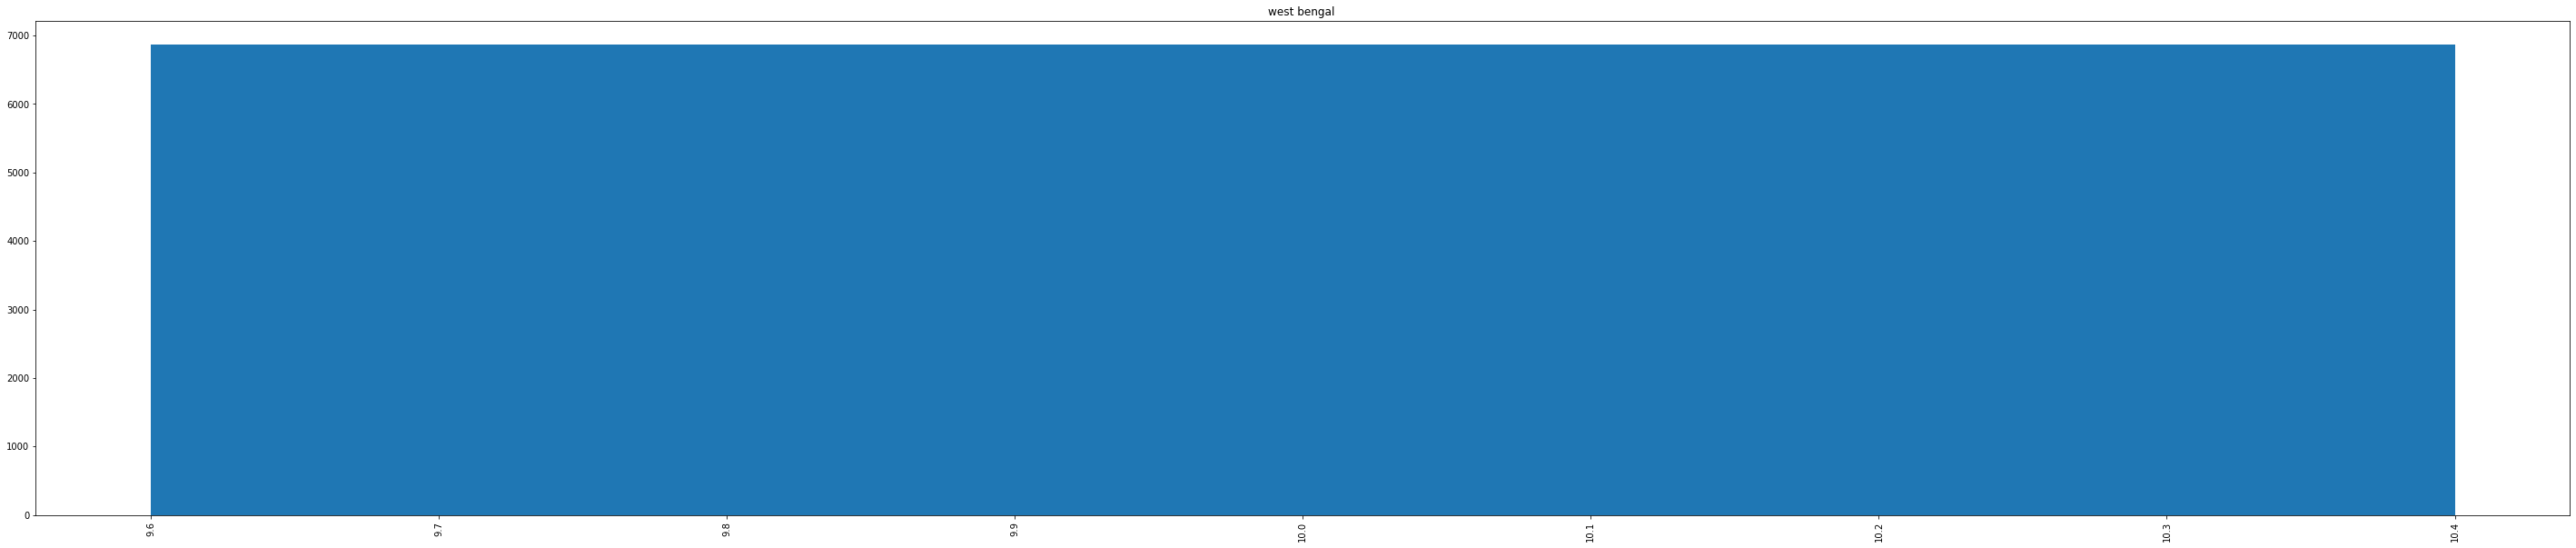

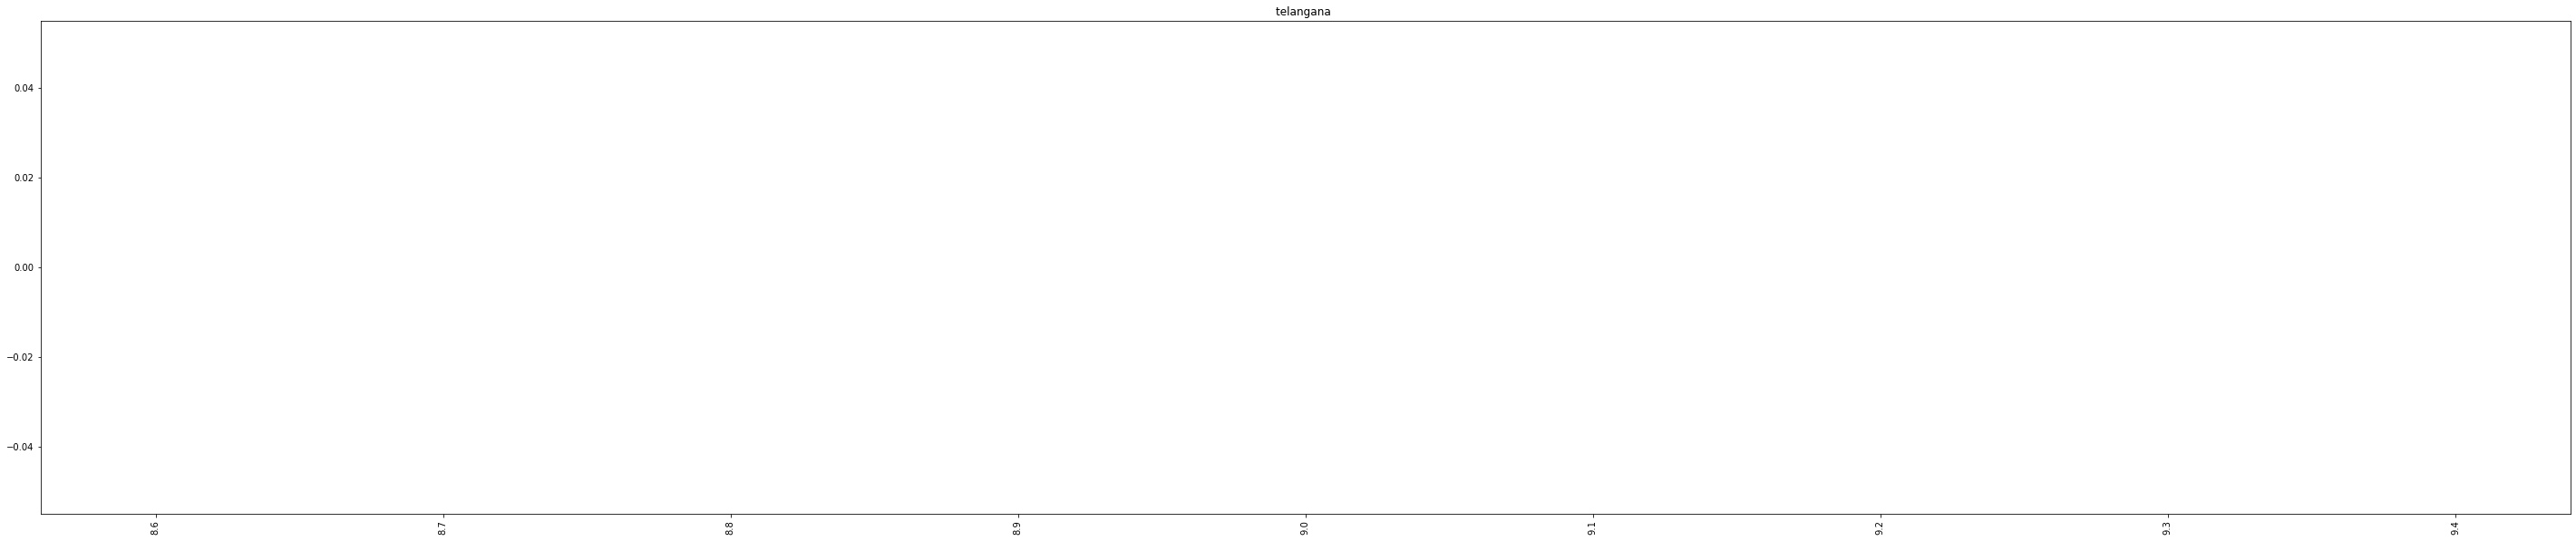

In [162]:
def model_order(state):
    city=[]
    city=join['District'].unique()
    order=join['Order Type'].unique()
    #print(cars['Order Type'].value_counts())

    cars=join[join['District']==state]
    #for j in cars['District'].unique():
       # print(j)
        #order=cars[cars['month']==j]
    fig=plt.figure(figsize=(50,10))
    plt.title(state+" ")
        #cars=cars.sort_values('Total Amt Wtd Tax.',ascending=False)
        #order['Order Type'].value_counts().plot(kind='bar')
        #order=order.sort_values('Total Amt Wtd Tax.',ascending=False)
    plt.bar(cars['monthno'],cars['Revenue'])
    plt.xticks(rotation=90)
    plt.show()
for i in join['District'].unique():  
    model_order(i) 

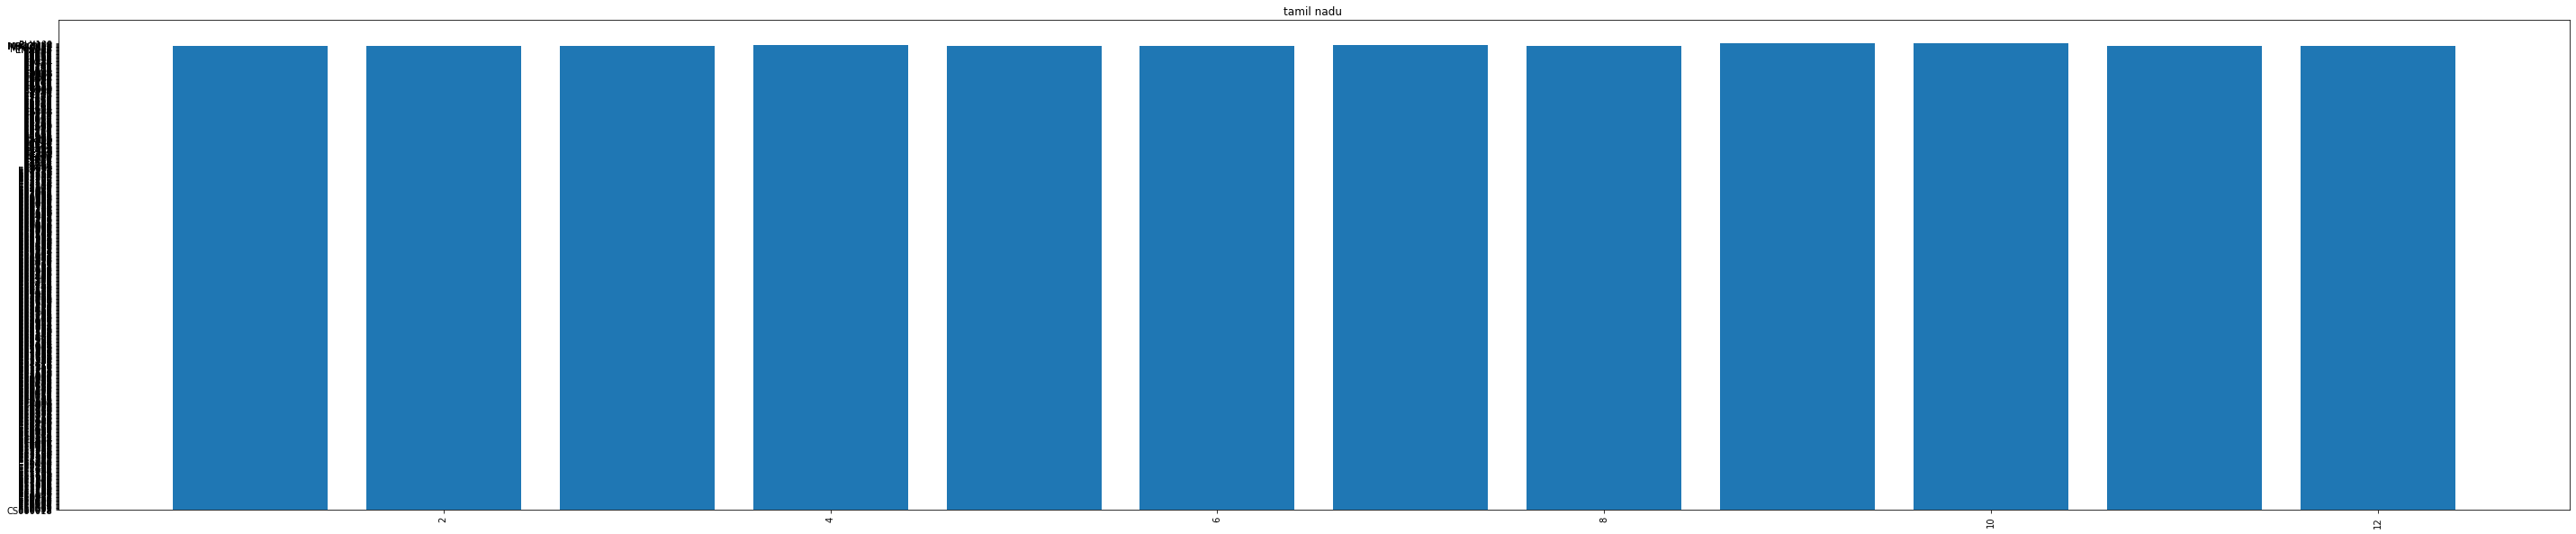

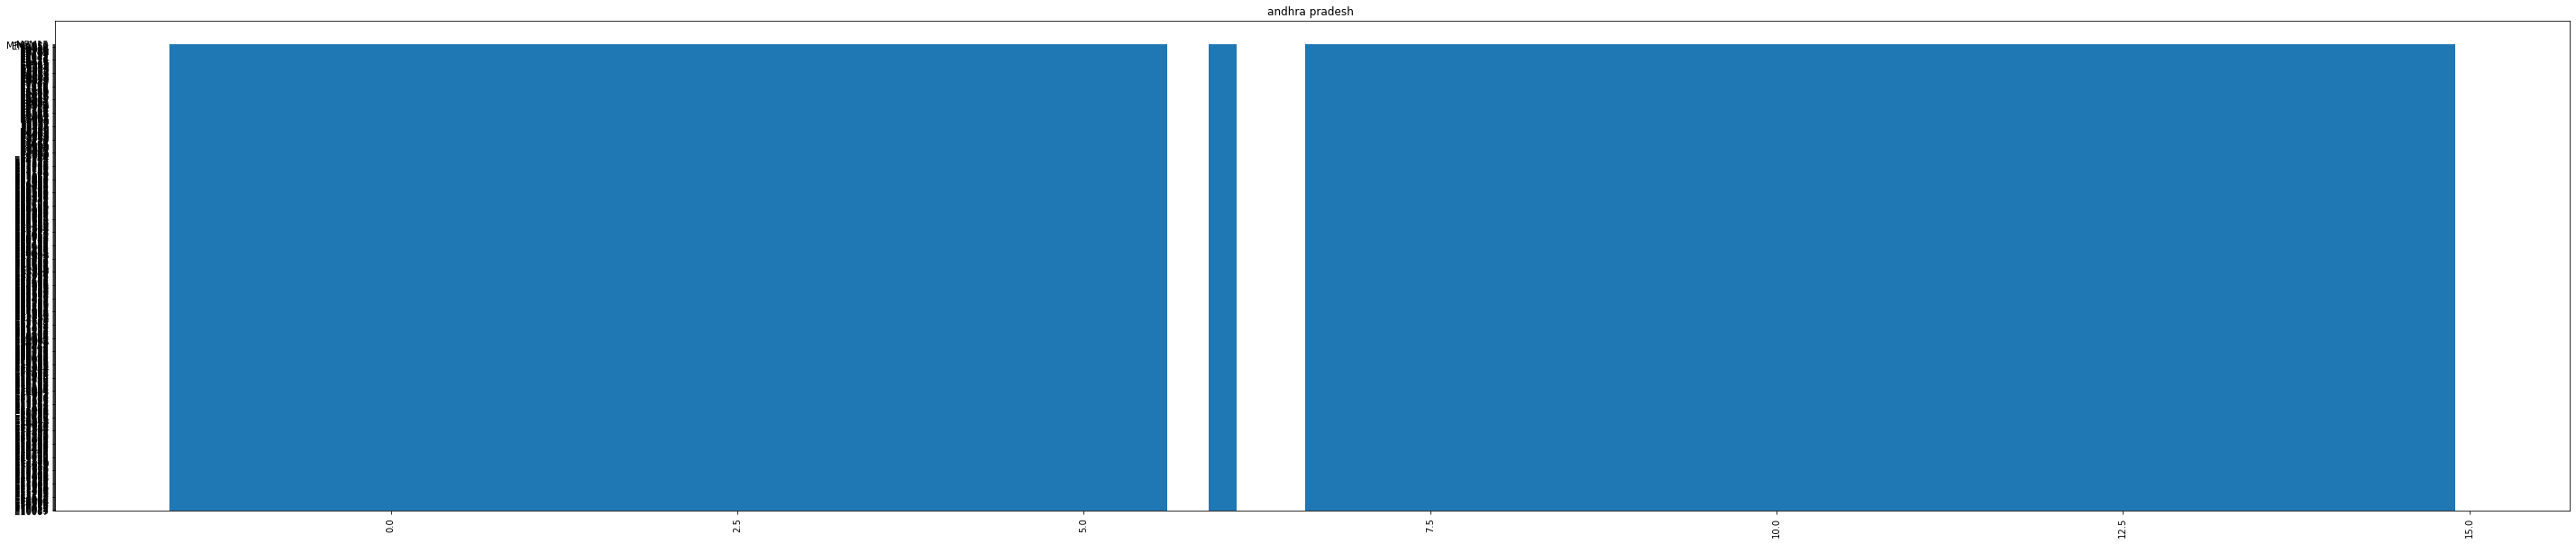

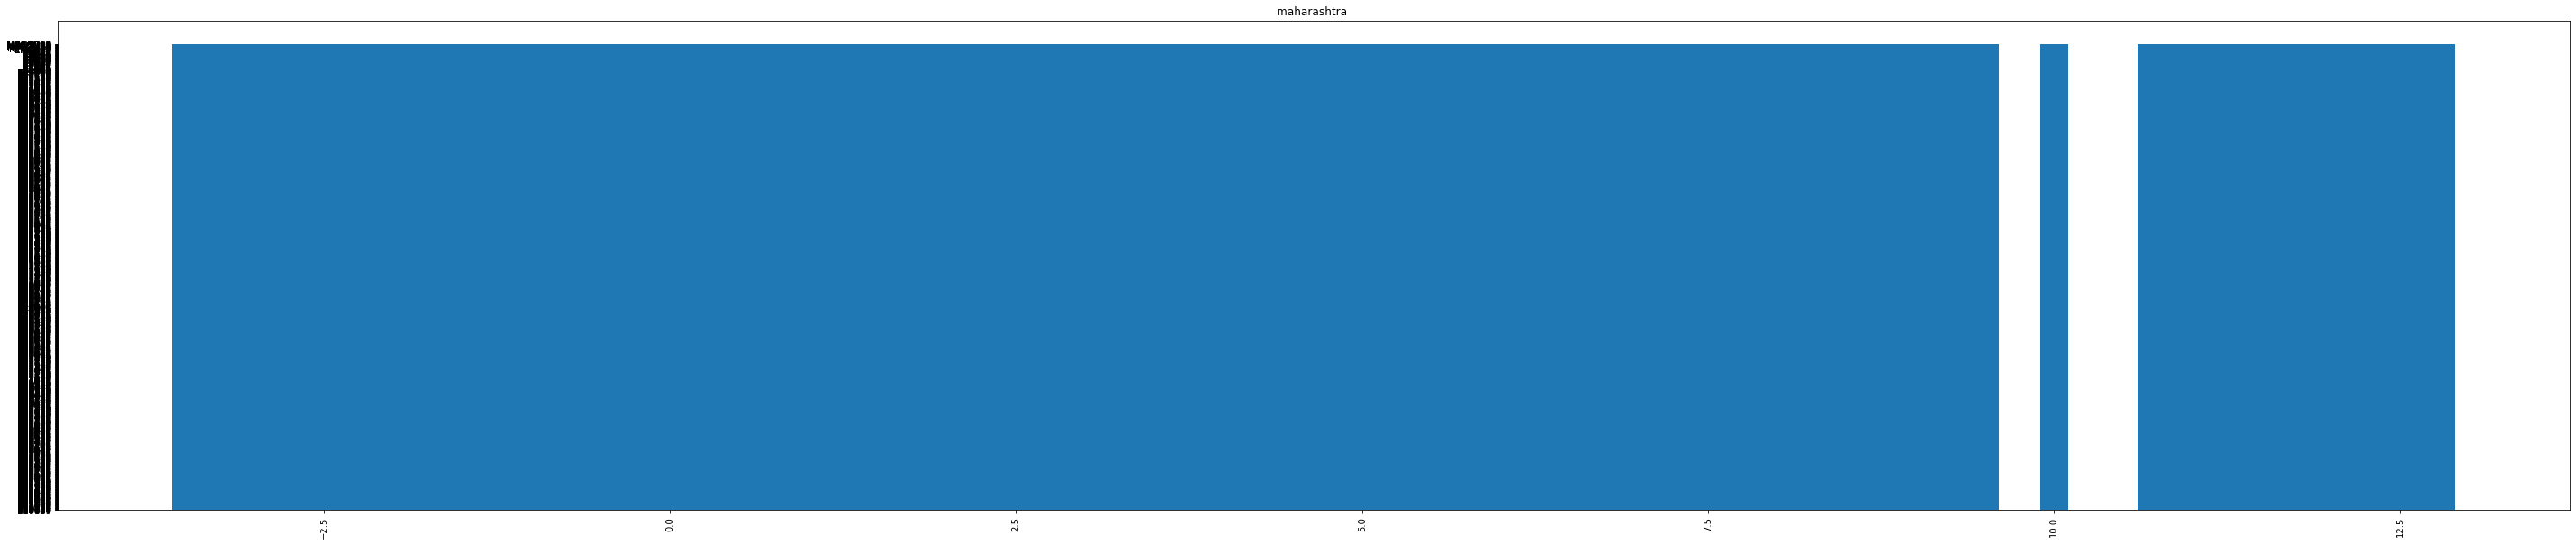

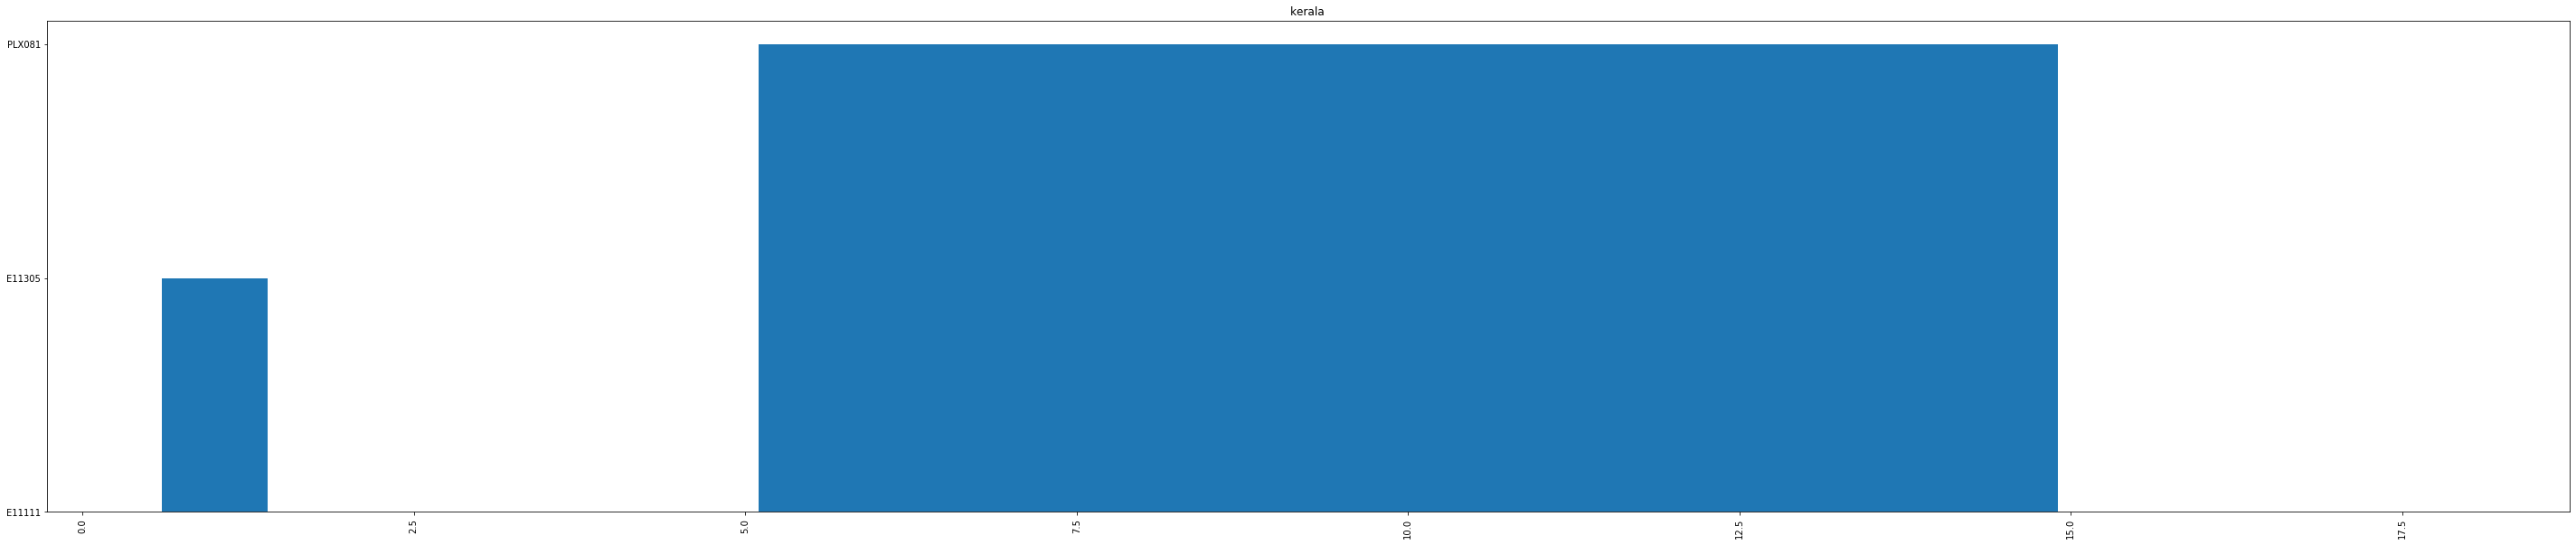

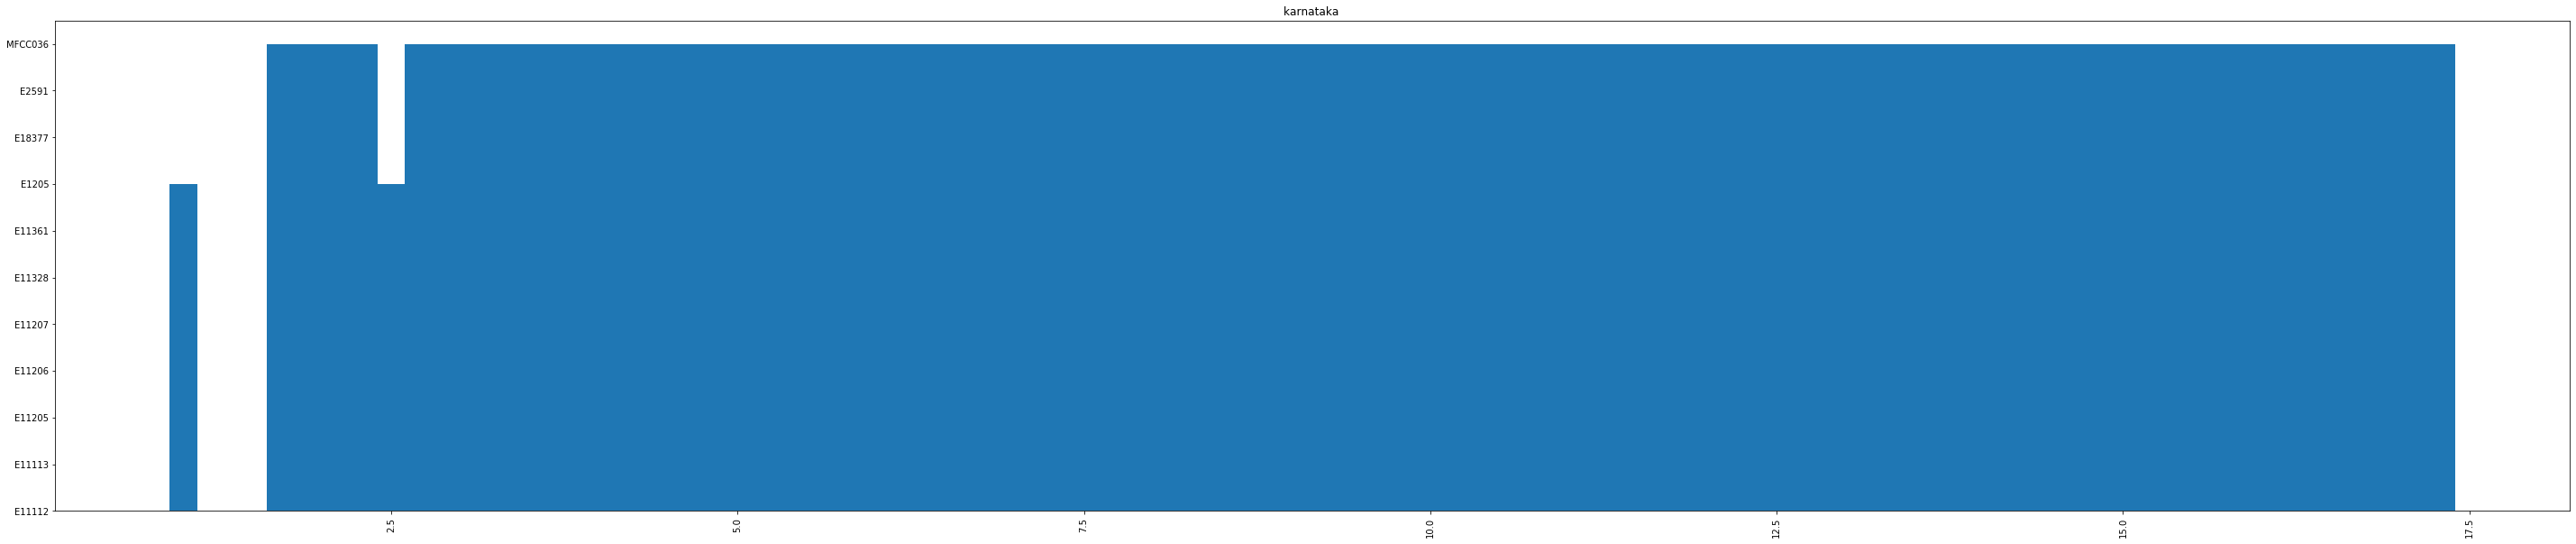

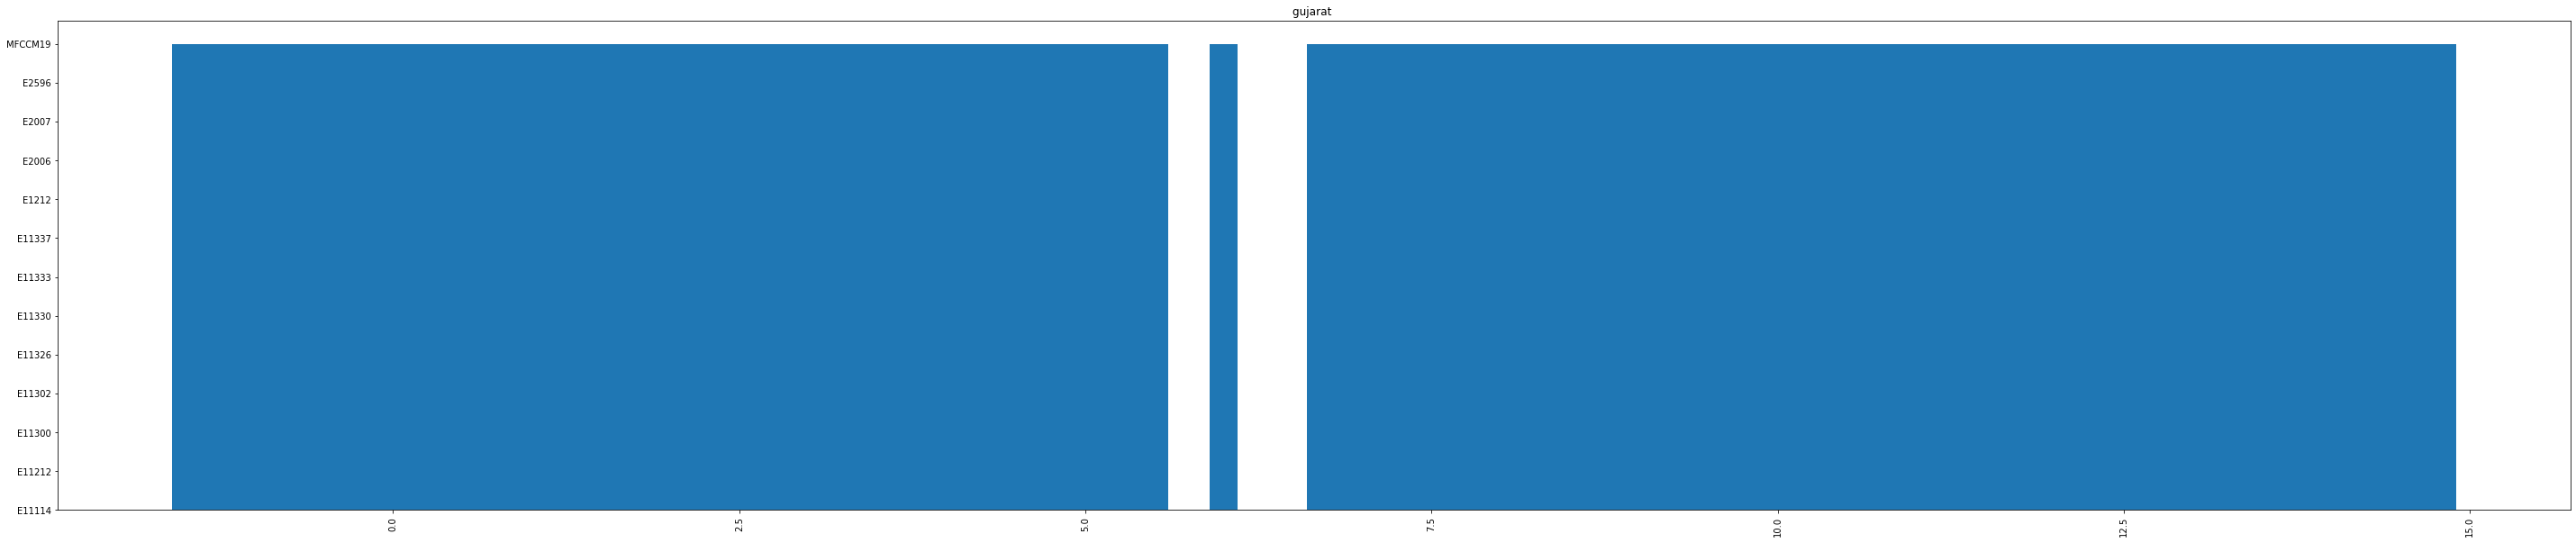

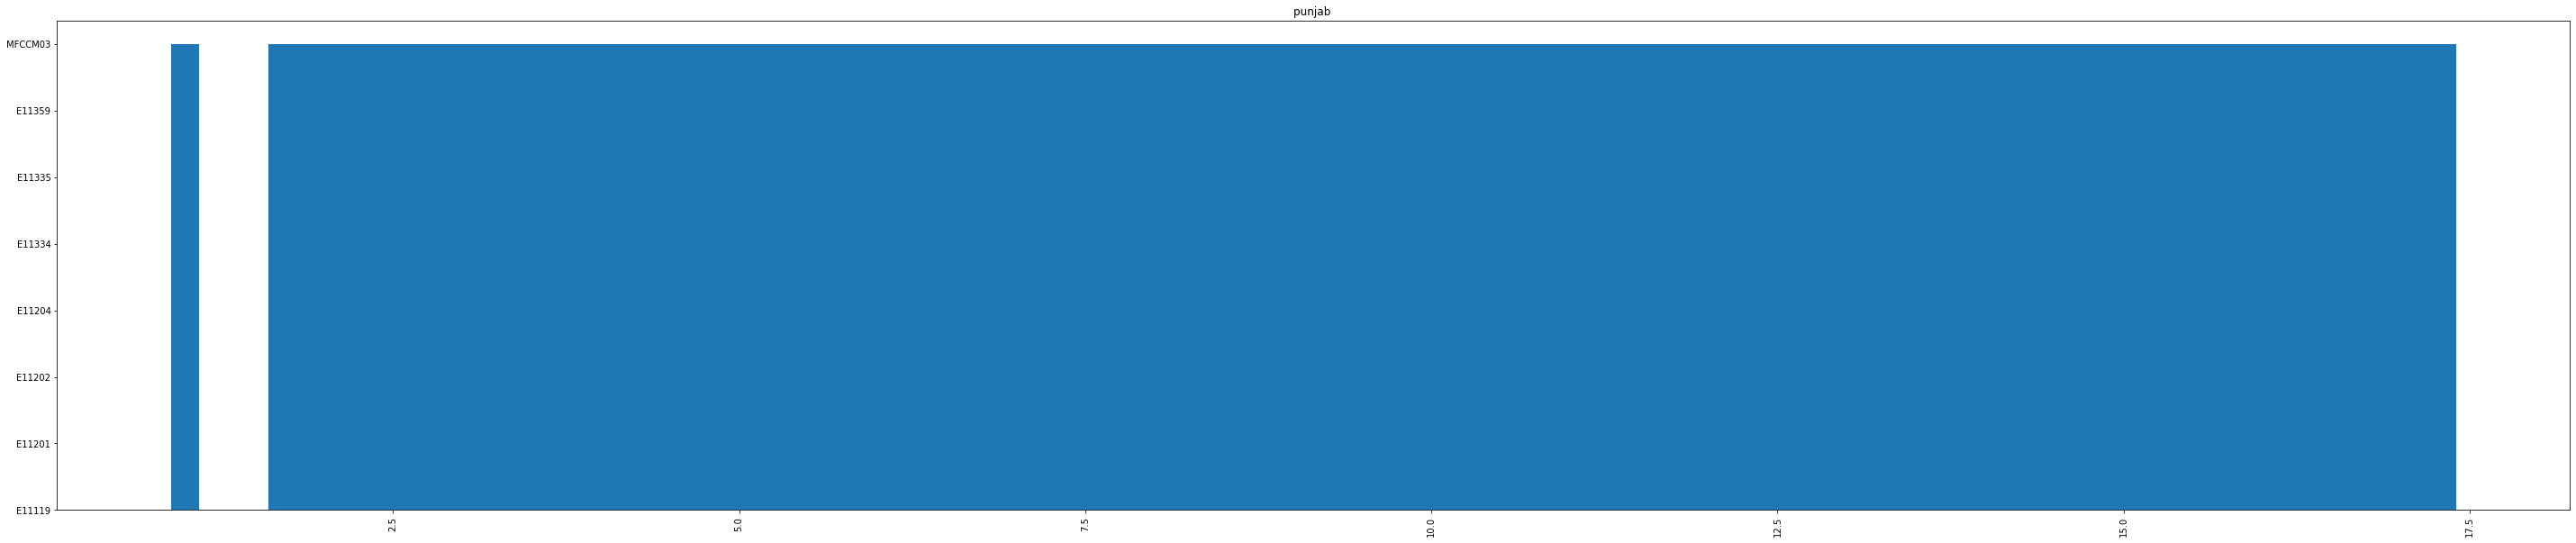

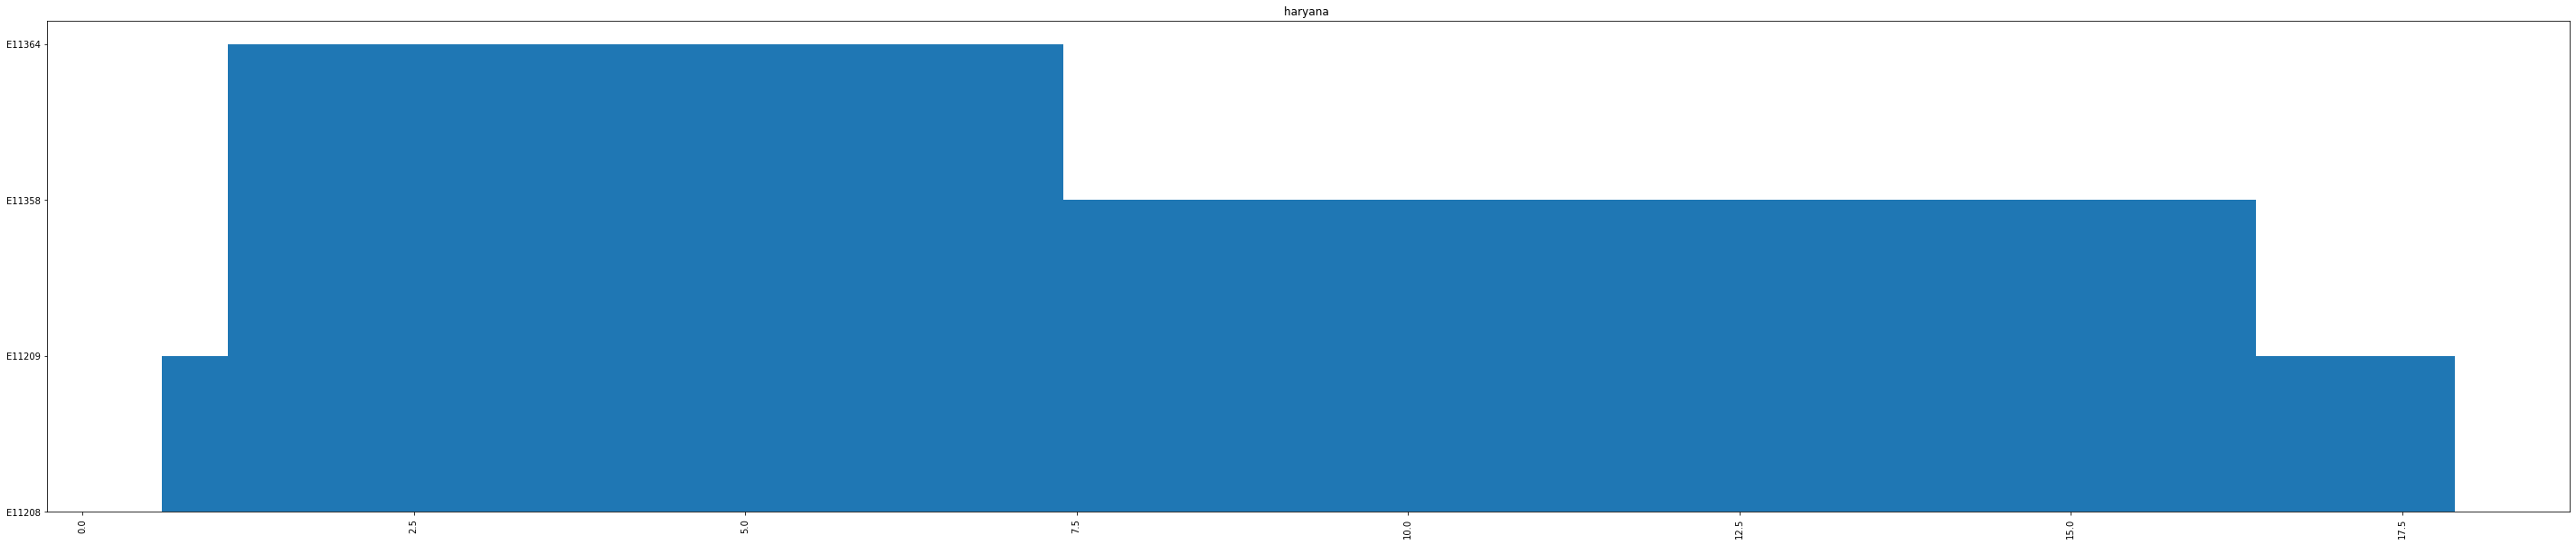

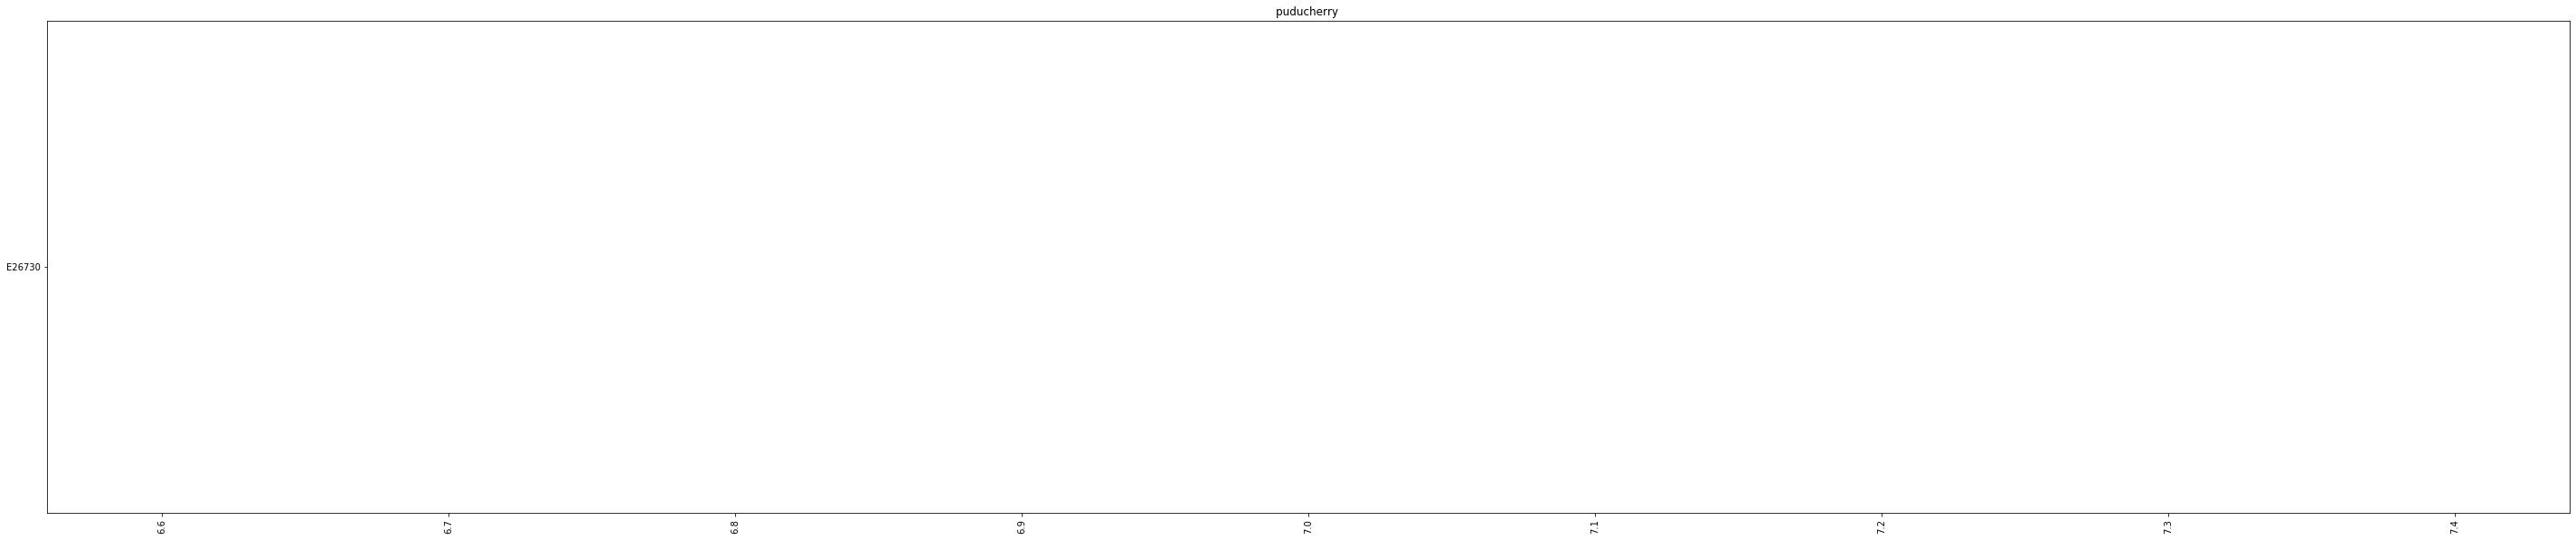

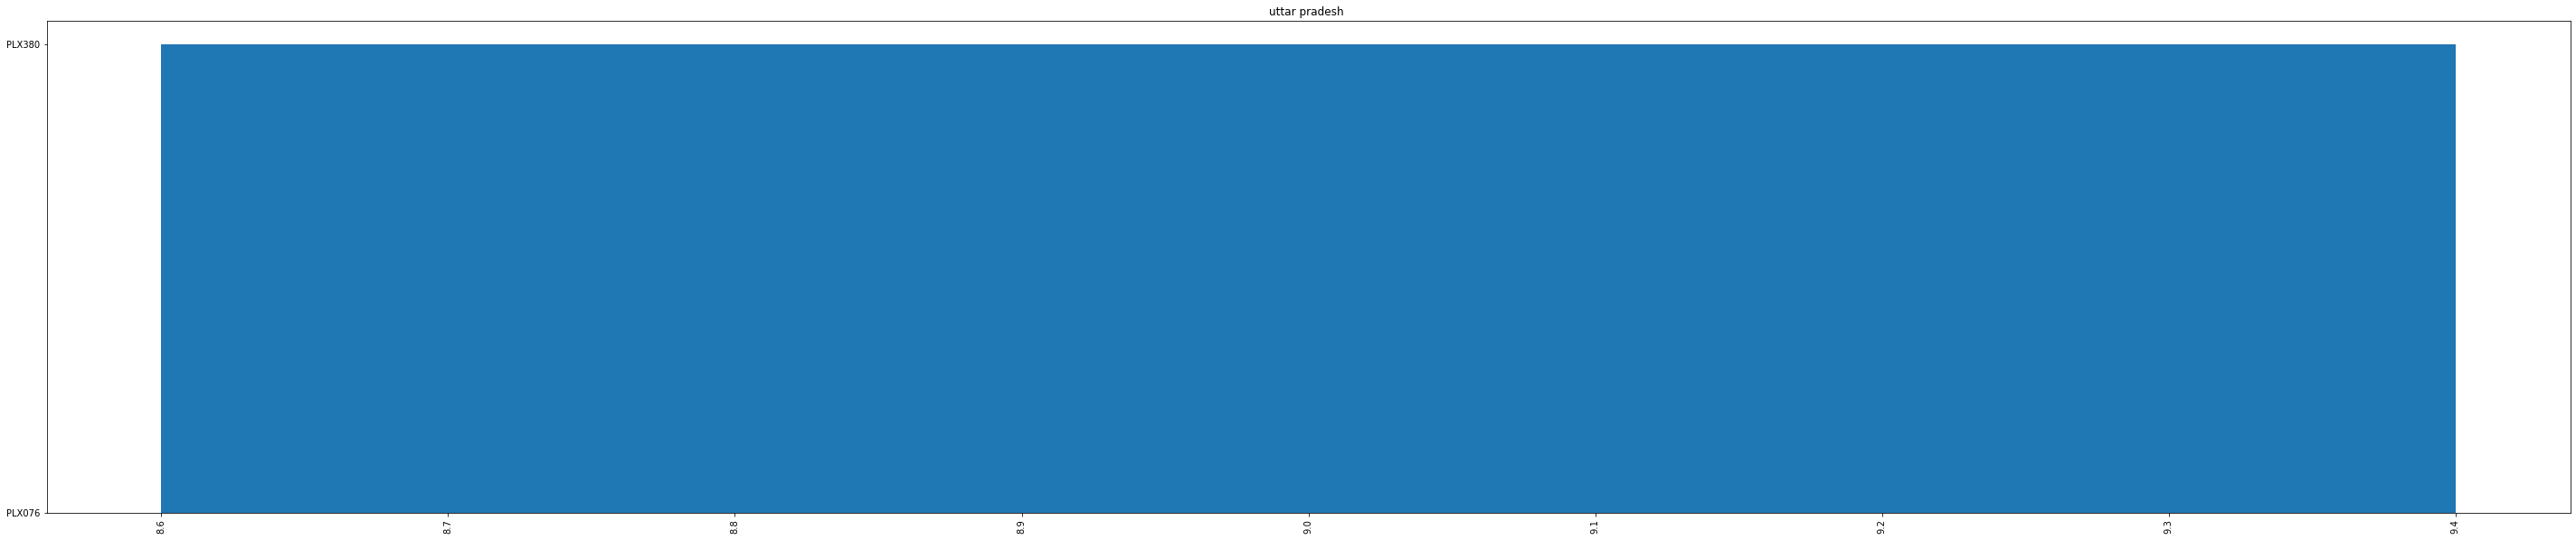

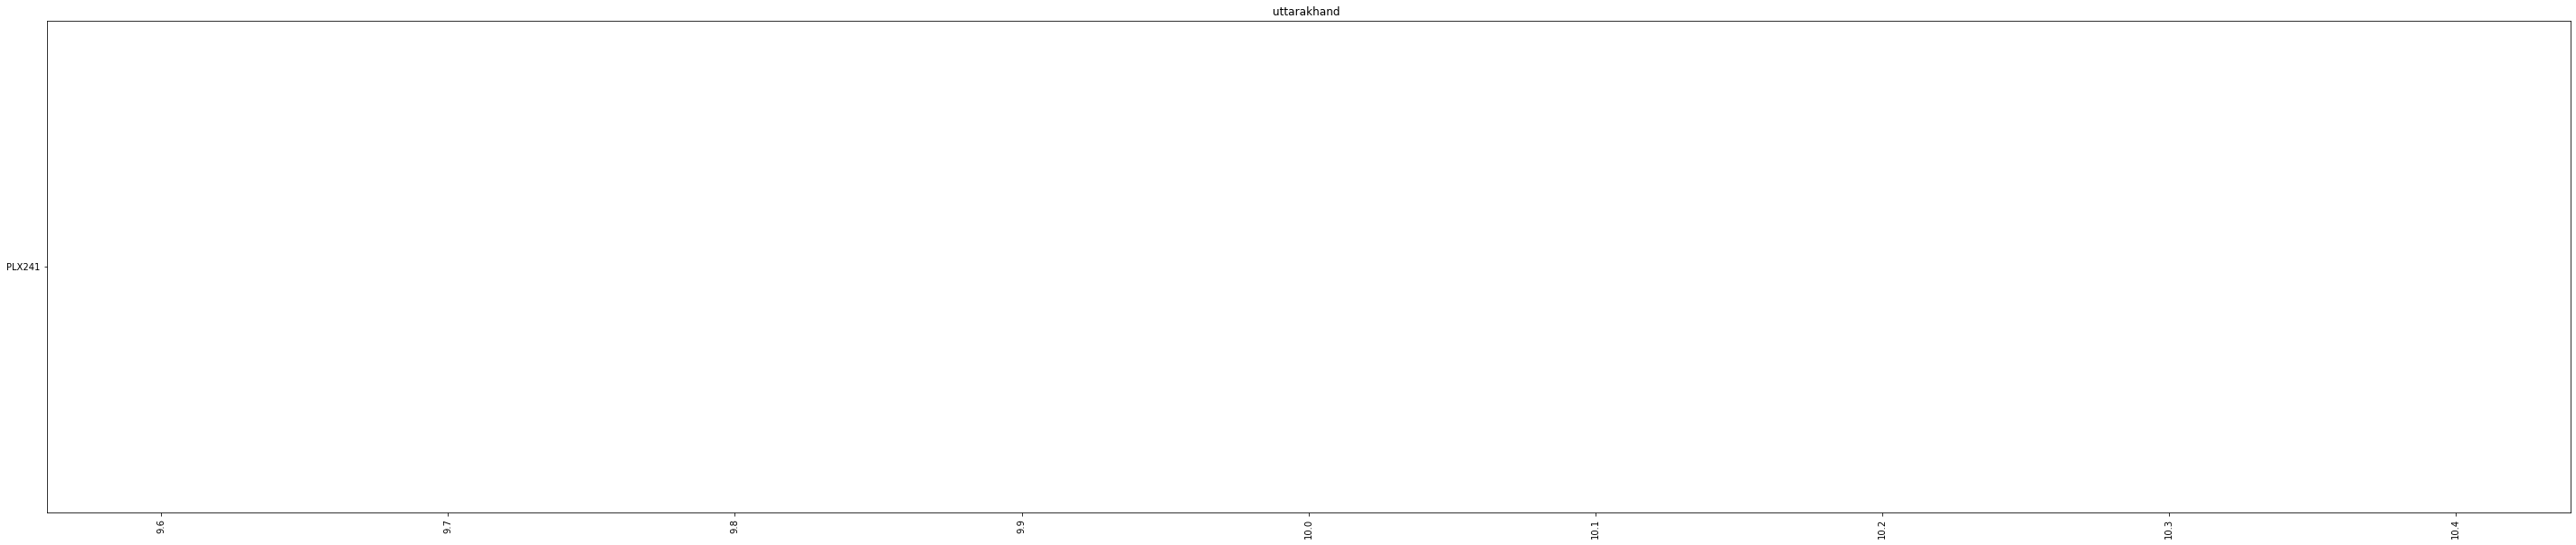

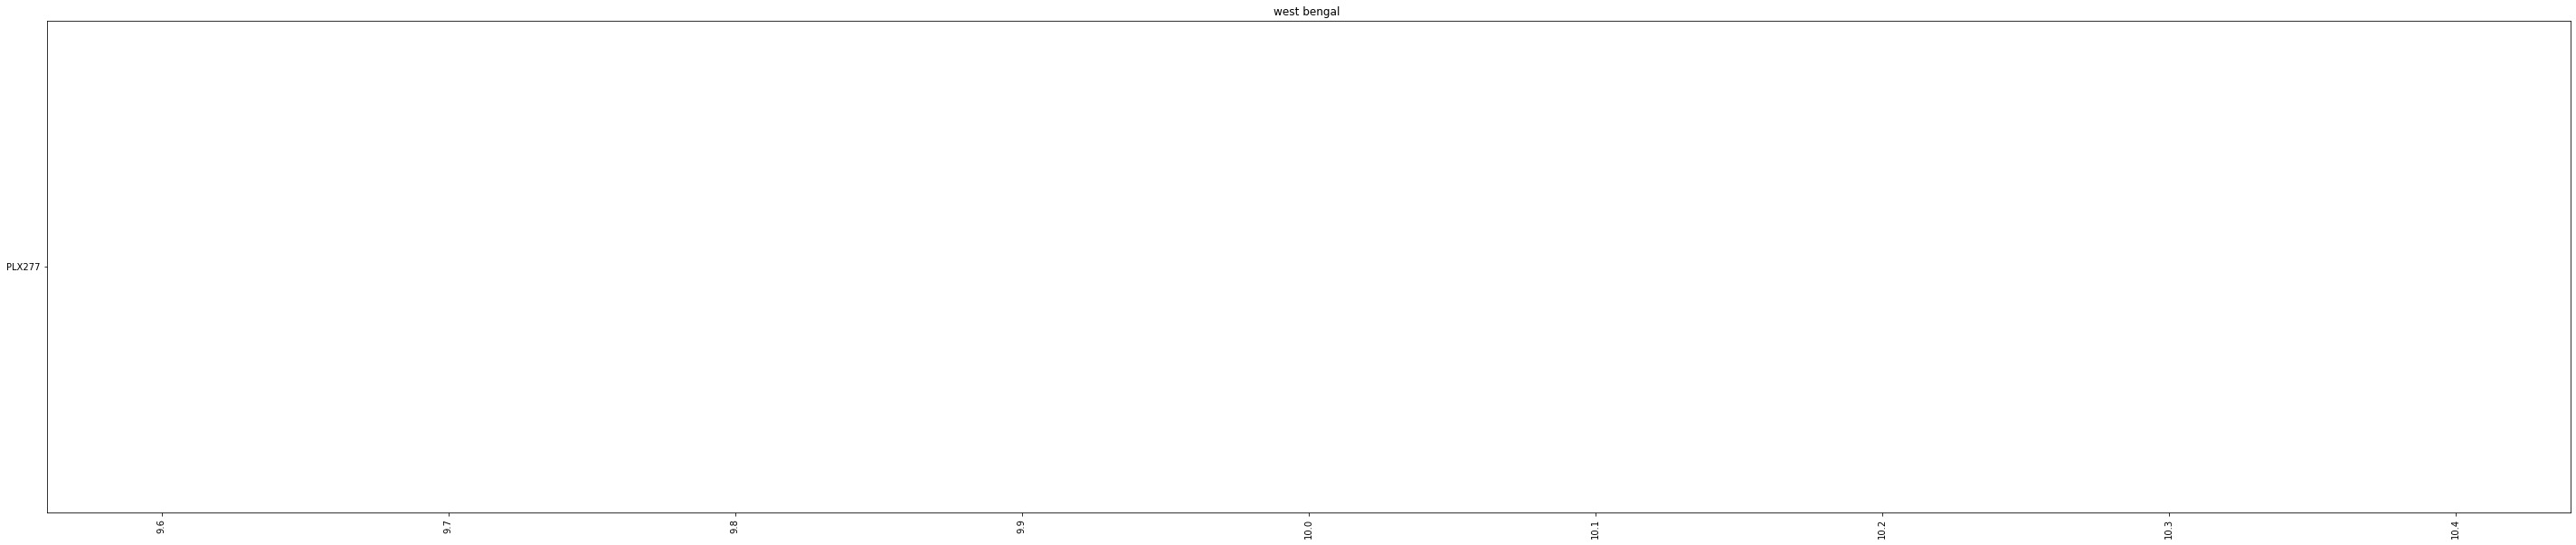

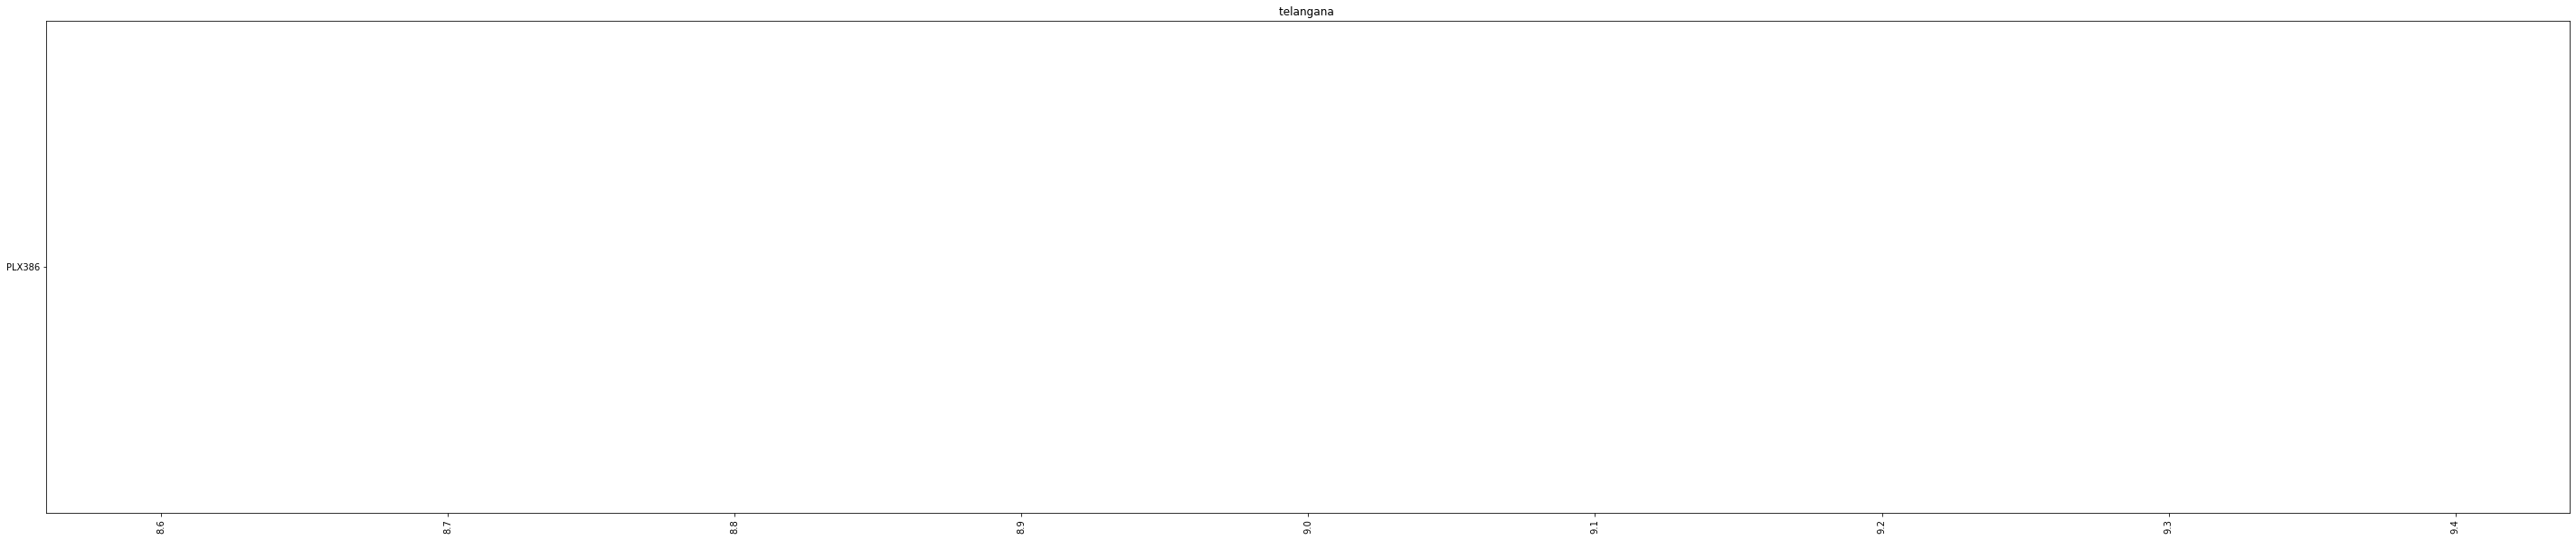

In [163]:
def model_order(state):
    city=[]
    city=join['District'].unique()
    order=join['Order Type'].unique()
    #print(cars['Order Type'].value_counts())

    cars=join[join['District']==state]
    #for j in cars['District'].unique():
       # print(j)
        #order=cars[cars['month']==j]
    fig=plt.figure(figsize=(50,10))
    plt.title(state+" ")
        #cars=cars.sort_values('Total Amt Wtd Tax.',ascending=False)
        #order['Order Type'].value_counts().plot(kind='bar')
        #order=order.sort_values('Total Amt Wtd Tax.',ascending=False)
    plt.bar(cars['monthno'],cars['Customer No.'])
    plt.xticks(rotation=90)
    plt.show()
for i in join['District'].unique():  
    model_order(i)

In [164]:
tx_user = pd.DataFrame(join['Customer No.'].unique())
tx_user.columns = ['Customer No.']

In [165]:
tx_max_purchase = join.groupby('Customer No.').InvoiceDate.max().reset_index()
print(tx_max_purchase)

     Customer No. InvoiceDate
0        CS000018  2016-04-28
1          E10007  2013-07-04
2          E10013  2013-12-14
3          E10014  2013-04-20
4          E10023  2015-11-23
...           ...         ...
3644       PLX241  2016-10-14
3645       PLX277  2016-10-26
3646       PLX312  2016-08-09
3647       PLX380  2016-09-30
3648       PLX386  2016-09-27

[3649 rows x 2 columns]


In [166]:
tx_max_purchase.columns = ['Customer No.','MaxPurchaseDate']
print(tx_max_purchase)

     Customer No. MaxPurchaseDate
0        CS000018      2016-04-28
1          E10007      2013-07-04
2          E10013      2013-12-14
3          E10014      2013-04-20
4          E10023      2015-11-23
...           ...             ...
3644       PLX241      2016-10-14
3645       PLX277      2016-10-26
3646       PLX312      2016-08-09
3647       PLX380      2016-09-30
3648       PLX386      2016-09-27

[3649 rows x 2 columns]


In [167]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

print(tx_user)

     Customer No.
0        CS000018
1          E10007
2          E10013
3          E10014
4          E10023
...           ...
3644       PLX241
3645       PLX277
3646       PLX312
3647       PLX380
3648       PLX386

[3649 rows x 1 columns]


In [168]:
tx_user = pd.merge(tx_user, tx_max_purchase[['Customer No.','Recency']], on='Customer No.') 
print(tx_user)

     Customer No.  Recency
0        CS000018      186
1          E10007     1215
2          E10013     1052
3          E10014     1290
4          E10023      343
...           ...      ...
3644       PLX241       17
3645       PLX277        5
3646       PLX312       83
3647       PLX380       31
3648       PLX386       34

[3649 rows x 2 columns]


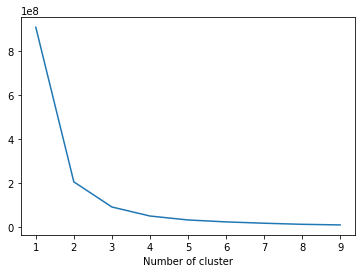

In [169]:
from sklearn.cluster import KMeans
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [170]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    #print(new_cluster_field_name)
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    #print(df_new)
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    print(df_new)
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

   RecencyCluster      Recency  index
0               1  1438.055556      0
1               2   904.918112      1
2               0   274.830250      2


In [171]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

count         mean         std     min     25%     50%  \
RecencyCluster                                                            
0               1692.0  1438.055556  145.381532  1171.0  1315.0  1445.0   
1               1038.0   904.918112  167.660946   591.0   758.0   920.0   
2                919.0   274.830250  169.708296     0.0   144.5   264.0   

                   75%     max  
RecencyCluster                  
0               1568.0  1673.0  
1               1050.0  1167.0  
2                416.5   588.0

In [172]:
#calculate revenue for each customer
#tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = join.groupby('Customer No.').Revenue.sum().reset_index()

#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='Customer No.')

In [173]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])


#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

   RevenueCluster       Revenue  index
0               0  1.851473e+04      0
1               2  1.433561e+06      1
2               1  1.185973e+07      2


count          mean            std          min          25%  \
RevenueCluster                                                                  
0               3637.0  1.851473e+04   36972.662027         0.00      2538.15   
1                 11.0  1.433561e+06  513122.536847    854562.73    970503.03   
2                  1.0  1.185973e+07            NaN  11859728.34  11859728.34   

                        50%          75%          max  
RevenueCluster                                         
0                   7740.73     19929.65    533176.86  
1                1416264.31   1663123.29   2388655.35  
2               11859728.34  11859728.34  11859728.34

In [174]:
tx_frequency = join.groupby('Customer No.').InvoiceDate.count().reset_index()
tx_frequency.columns = ['Customer No.','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='Customer No.')

kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

   FrequencyCluster    Frequency  index
0                 0     4.236004      0
1                 2   405.750000      1
2                 1  2668.000000      2


In [175]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] +  tx_user['RevenueCluster']+tx_user['FrequencyCluster']
tx_user.groupby('OverallScore')['Recency','Revenue','Frequency'].mean()

Recency       Revenue    Frequency
OverallScore                                        
0             1438.181549  9.178380e+03     1.966884
1              905.226179  1.915543e+04     4.228104
2              276.830396  3.608976e+04     7.779736
3              136.166667  1.464715e+06   108.833333
4               85.500000  1.531579e+06   405.750000
6               48.000000  1.185973e+07  2668.000000

In [176]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>0,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'High-Value'

In [177]:
tx_user[tx_user['Customer No.']=='E12068']

Customer No.  Recency  RecencyCluster   Revenue  RevenueCluster  \
975       E12068     1236               0  77190.68               0   

     Frequency  FrequencyCluster  OverallScore    Segment  
975         20                 0             0  Low-Value

In [178]:
tx_data = pd.read_csv('invoice_customer_plant_jtd_2.csv')

In [179]:
tx_data.head()

Cust Type Customer No. Gate Pass Time  Invoice No  Job Card No  KMs Reading  \
0    Retail        80479       00:00:00  7151201169       227460        65714   
1    Retail       E15810       00:00:00  7151205340       413455        53903   
2    Retail       E15810       00:00:00  7151205916       446448        54231   
3    Retail        73857       00:00:00  7151206592       487708        55118   
4    Retail       E25519       00:00:00  7151201014       220109       182687   

   Labour Total                  Make  Misc Total    Model  OSL Total  \
0       1802.05                  FORD         0.0   FIESTA        0.0   
1       2874.80         MARUTI SUZUKI         0.0    SWIFT        0.0   
2       2799.96         MARUTI SUZUKI         0.0    SWIFT        0.0   
3        554.95               HYUNDAI         0.0    VERNA        0.0   
4         75.02  MAHINDRA &  MAHINDRA         0.0  LOGAN D        0.0   

        Order Type  Parts Total  Pin code Plant        Plant Name1  \
0     Paid Service       399.73    600406  X006  X006 - A.M.MOTORS   
1  Running Repairs      3151.06    421301  X006  X006 - A.M.MOTORS   
2  Running Repairs       664.04    421301  X006  X006 - A.M.MOTORS   
3  Running Repairs      1510.80    400096  X006  X006 - A.M.MOTORS   
4  Running Repairs       578.43    400607  X006  X006 - A.M.MOTORS   

  Print Status  Recovrbl Exp  Total Amt Wtd Tax.  User ID  \
0           NO           0.0             2201.78  X006SA1   
1           NO           0.0             6025.86  X006WM1   
2           NO           0.0             3464.00  X006WM1   
3           NO           0.0             2065.75  X006SA1   
4           NO           0.0              653.45  X006SA1   

      Invoice_DateTime     JobCard_DateTime               Service_Time  \
0  2015-06-19 18:10:34  2015-06-19 13:56:32  0 days 04:14:02.000000000   
1  2016-07-20 10:26:00  2016-07-18 15:49:34  1 days 18:36:26.000000000   
2  2016-09-04 11:12:47  2016-08-30 10:10:59  5 days 01:01:48.000000000   
3  2016-10-28 13:17:54  2016-10-18 17:47:35  9 days 19:30:19.000000000   
4  2015-05-28 18:20:37  2015-05-28 17:57:40  0 days 00:22:57.000000000   

  Clean_CITY Clean_District  \
0        NaN            NaN   
1      Thane    Maharashtra   
2      Thane    Maharashtra   
3     Mumbai    Maharashtra   
4      Thane    Maharashtra   

                                 Clean_Location_Area Business Partner  \
0                                                NaN            85246   
1  Kalyan Rs, Kalyan City H.O, Subhash Road (Than...           E15810   
2  Kalyan Rs, Kalyan City H.O, Subhash Road (Than...           E15810   
3                                              Seepz            78259   
4                     Chitalsar Manpada, Sandozbaugh           E25519   

   Partner Type Data Origin             Name 1 Customer no. - plant  \
0           1.0        Z010  X006 - A.M.MOTORS               PLX006   
1           1.0        Z001  X006 - A.M.MOTORS               PLX006   
2           1.0        Z001  X006 - A.M.MOTORS               PLX006   
3           1.0        Z001  X006 - A.M.MOTORS               PLX006   
4           1.0        Z001  X006 - A.M.MOTORS               PLX006   

  Vendor number plant         House number and street    PO Box  Postal Code  \
0                 NaN  8, Mira, Behind Ajit Palace Ho  401104.0       401104   
1                 NaN  8, Mira, Behind Ajit Palace Ho  401104.0       401104   
2                 NaN  8, Mira, Behind Ajit Palace Ho  401104.0       401104   
3                 NaN  8, Mira, Behind Ajit Palace Ho  401104.0       401104   
4                 NaN  8, Mira, Behind Ajit Palace Ho  401104.0       401104   

    City Sales organization        State  Service_Time_category  \
0  Thane               MFCB  Maharashtra                    NaN   
1  Thane               MFCB  Maharashtra                    NaN   
2  Thane               MFCB  Maharashtra                    NaN   
3  Thane               MFCB  Maharashtra 

In [180]:
tx_data['Invoice_DateTime'] = pd.to_datetime(tx_data['Invoice_DateTime'])
pd.options.display.float_format = '{:.4f}'.format
tx_data['InvoiceYearMonth'] = tx_data['Invoice_DateTime'].map(lambda date: 100*date.year + date.month)
#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
tx_data['Revenue'] = tx_data['Net value']
tx_revenue = tx_data.groupby(['InvoiceYearMonth', 'State'])['Revenue'].sum().reset_index()
tx_revenue

InvoiceYearMonth          State       Revenue
0              201204     Tamil Nadu  1015388.5900
1              201205     Tamil Nadu   692735.1900
2              201206     Tamil Nadu   713588.4200
3              201207     Tamil Nadu   976837.6200
4              201208     Tamil Nadu   720316.0300
..                ...            ...           ...
362            201610     Tamil Nadu 26203051.2500
363            201610      Telangana  3945953.4600
364            201610  Uttar Pradesh  5183917.7000
365            201610    Uttarakhand  2530388.3400
366            201610    West Bengal  1566802.5600

[367 rows x 3 columns]

<function matplotlib.pyplot.show(*args, **kw)>

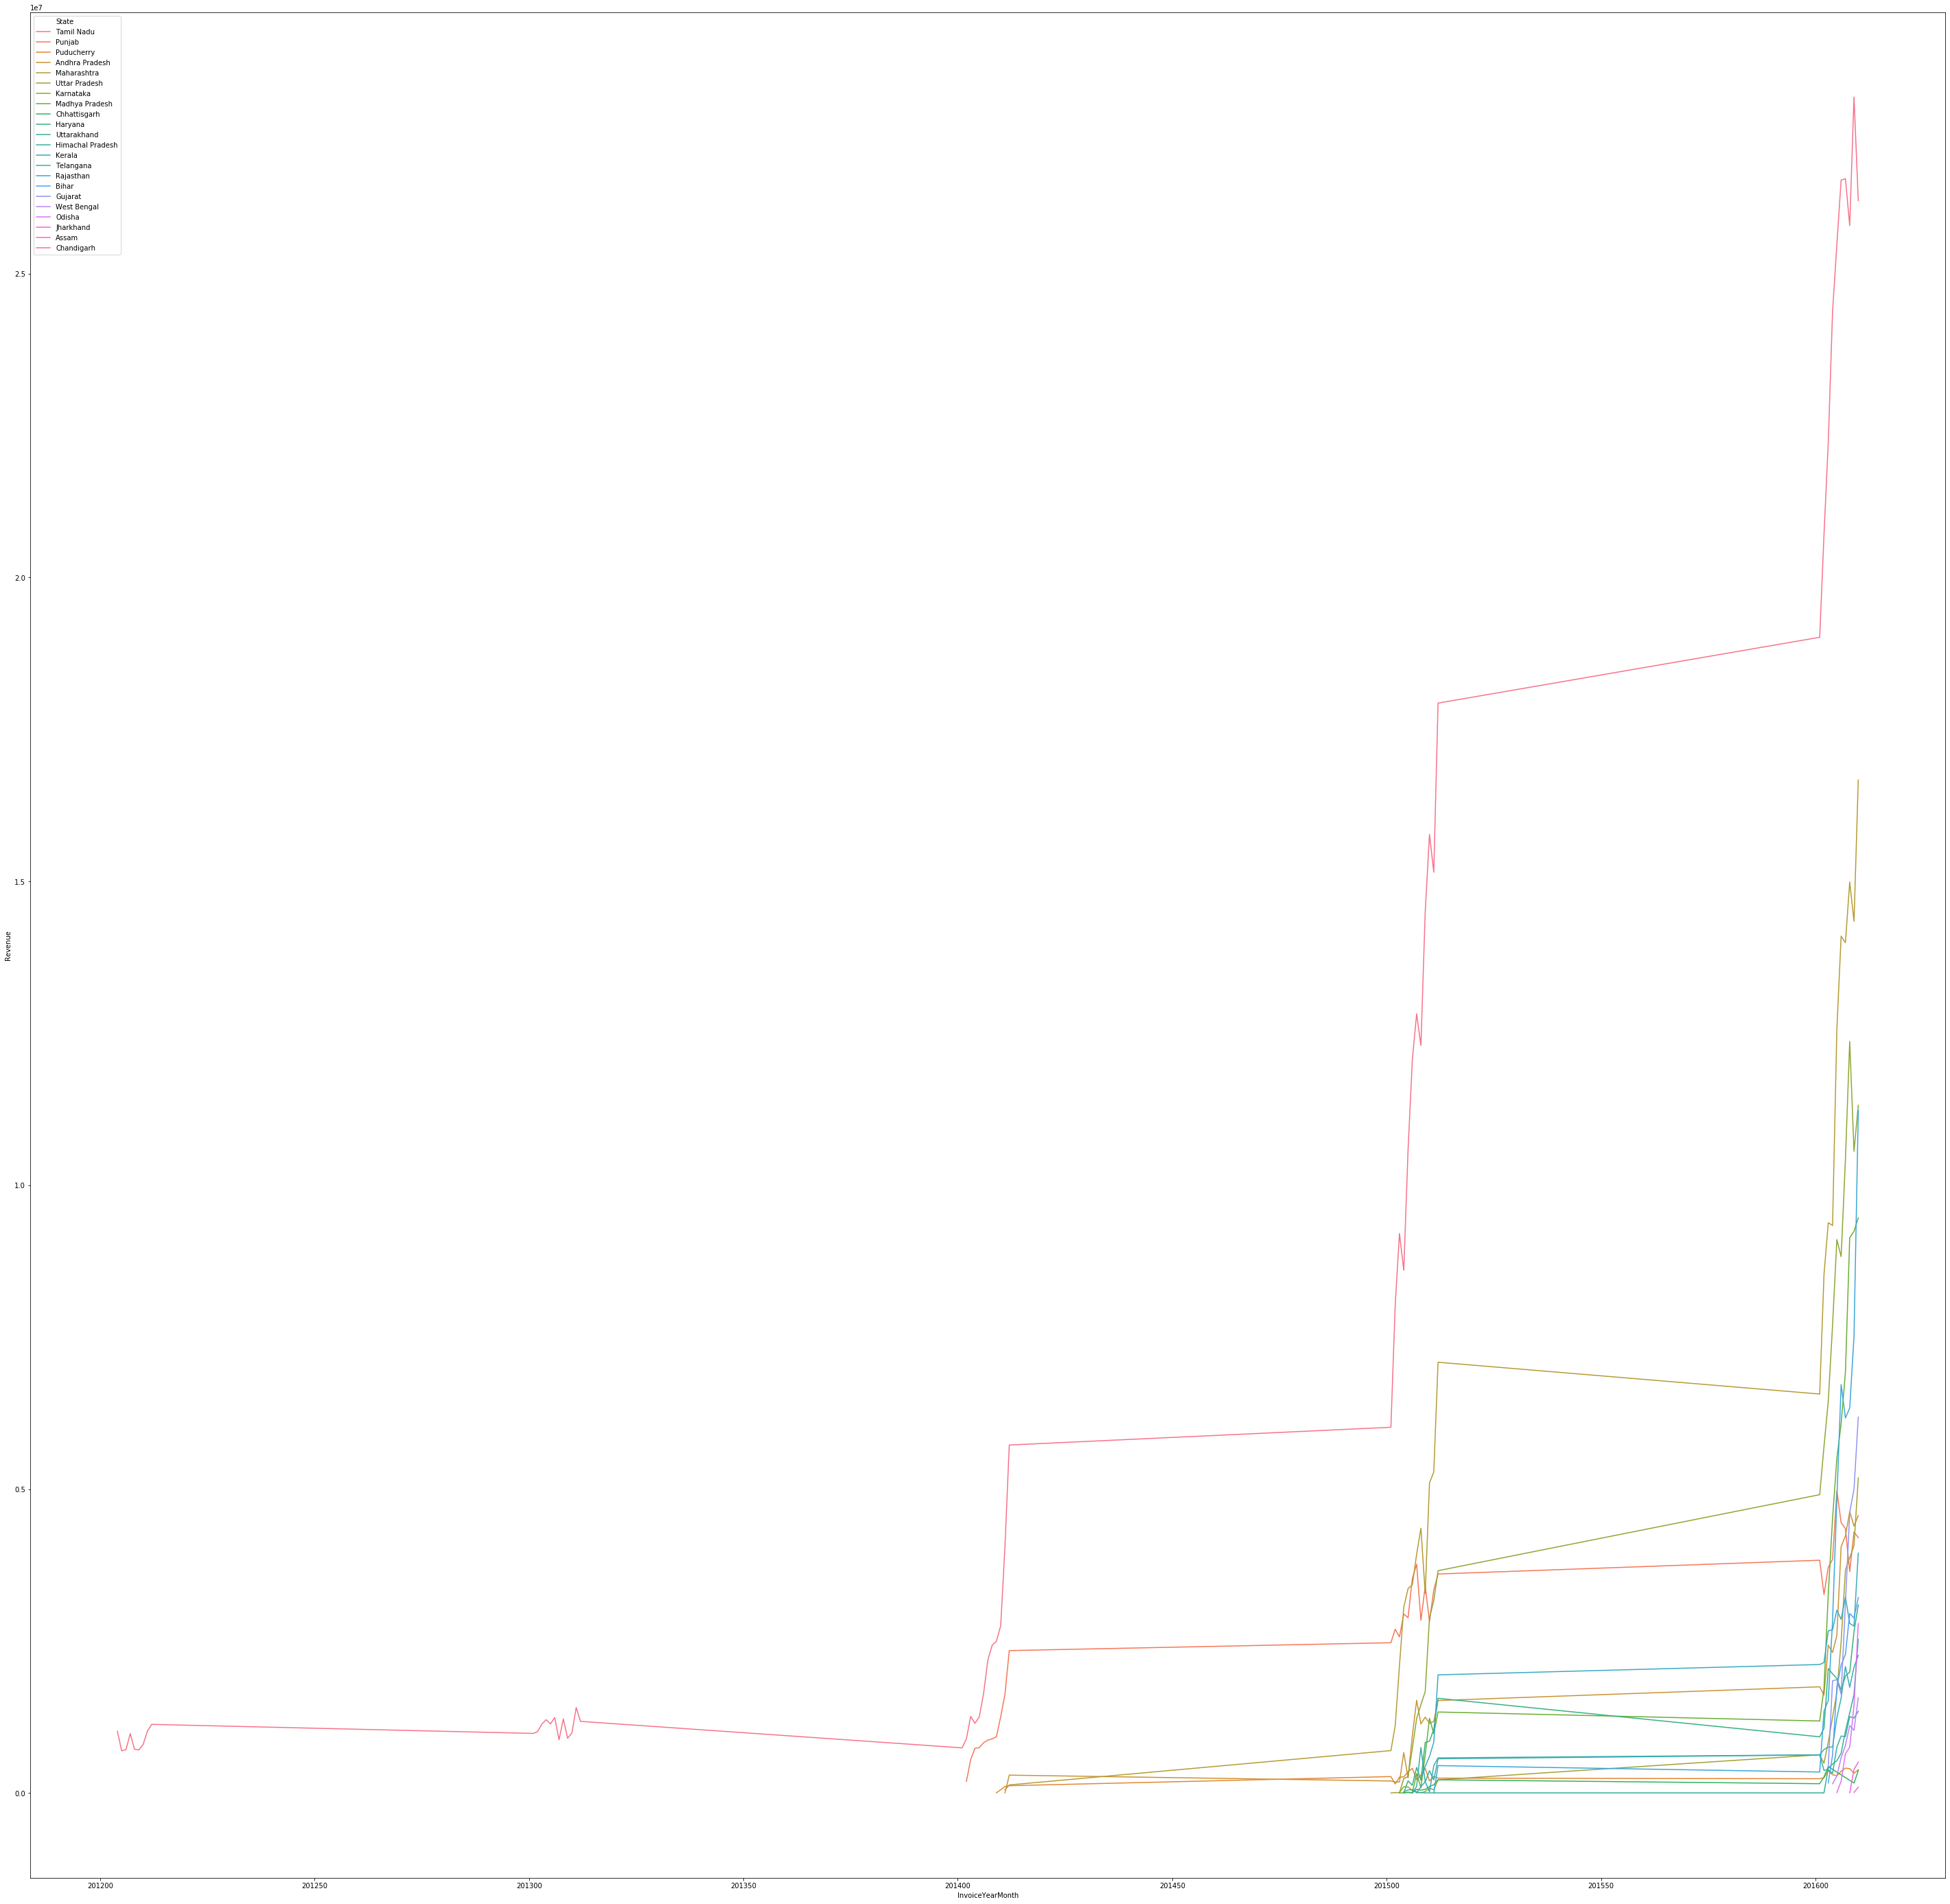

In [181]:
import seaborn as sns
#X and Y axis inputs for Plotly graph. We use Scatter for line graphs
plt.figure(figsize=(50,50))
sns.lineplot(x="InvoiceYearMonth", y="Revenue", data=tx_revenue, hue='State')

plt.show